# RL Project - Actor Critic Network 

In [1]:
import numpy as np 
import gym
import minihack 
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import flatten

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Helper Functions

In [3]:
def moving_average(a, n):
    """Calculates the moving average of an array a with a window size n"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [4]:
def display_screen(state):
    """Displays the state as the screen in image form using the 'pixel' observation key"""
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

In [5]:
def format_state(state):
    """Formats the state according to the input requirements of the Actor Critic Neural Network"""
    
    # Normalize and reshape for convolutional layer input
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    # Normalize the message and reshape for the fully connected layer input 
    message = state["message"]
    if state["message"].max()>0: 
        # Occassionally the message is empty which will cause a Zero Division error 
        message = message/message.max()
    message = message.reshape((1,len(message)))
    
    state = {"glyphs":glyphs,"message":message}
    return state

In [6]:
def compute_returns(rewards, gamma):
    """Computes the discounted returns of a sequence of rewards achieved in a trajectory"""
    returns = []
    r= 0
    for reward in rewards[::-1]:
        r = reward + gamma*r
        returns.append(r)
    returns.reverse()
    returns = np.array(returns)
    
    # Standardize Returns 
    if np.mean(returns)!= 0:
         returns = returns - np.mean(returns)
    if np.std(returns) != 0:
        returns = returns/ np.std(returns)

    return returns

In [79]:
def plot_results(env_name,scores, color='blue'):
    """Plots the reward attained by an Agent at each step of training in 
        an environment for each iteration and average over all iterations"""
    
    plt.figure(figsize=(8,6))
    
    # Plot individual iterations 
    for score in scores:
        plt.plot(score, alpha =0.1, color=color)
    
    # Plot mean over all iterations
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Mean Reward")
    
    plt.title(f"Actor Critic - {env_name}")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward")
    
    plt.yticks(np.arange(-11, 2, 1.00))
    #splt.ylim(-12,2)
    plt.legend(loc=4)
    plt.savefig(f"Actor-Critic-{env_name}.pdf")
    plt.show()

## Model 

In [8]:
class ActorCritic(nn.Module):
    """The Actor Critic Neural Network used to estimate the state value function and action probabilities"""
    def __init__(self,s_size=8,h_size=128, a_size=4):
        
        # The network architecture follows the popular lenet-5 CNN architeture 
        super(ActorCritic, self).__init__()
        
        # Initialize first set of convolutional and pooling layers with a ReLU activation function 
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
                            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize second set of of convolutional and pooling layers with a ReLU activation function 
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
                            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize fully connected layers for glyph output after convolutional and pooling layers
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features=500, out_features=128)
        self.relu4 = ReLU()
        
        # Initialize fully connected for message input 
        self.fc3 = Linear(in_features=256, out_features=128)
        self.relu5 = ReLU()
        
        # Initialize fully connected for combination of glyphs and message 
        self.fc4 = Linear(in_features=256, out_features=128)
        self.relu6 = ReLU()

        # To estimate the value function of the state 
        self.value_layer = nn.Linear(128, 1)

        # To calculate the probability of taking each action in the given state
        self.action_layer = nn.Linear(128, a_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        
        # Transform the glyph and state arrays into tensors 
        glyphs_t  = torch.from_numpy(state["glyphs"]).float().to(device)
        message_t  = torch.from_numpy(state["message"]).float().to(device)

        # Pass the 2D glyphs input through our convolutional and pooling layers 
        glyphs_t = self.conv1(glyphs_t)
        glyphs_t = self.relu1(glyphs_t)
        glyphs_t = self.maxpool1(glyphs_t)
        glyphs_t = self.conv2(glyphs_t)
        glyphs_t = self.relu2(glyphs_t)
        glyphs_t = self.maxpool2(glyphs_t)
        
        # Platten the output from the final pooling layer and pass it through the fully connected layers 
        glyphs_t = glyphs_t.reshape(glyphs_t.shape[0], -1)
        glyphs_t = self.fc1(glyphs_t)
        glyphs_t = self.relu3(glyphs_t)
        glyphs_t = self.fc2(glyphs_t)
        glyphs_t = self.relu4(glyphs_t)
        
        # Pass the message input through a fully connected layer
        message_t = self.fc3(message_t)
        message_t = self.relu5(message_t)
        
        # Combine glyphs output from convolution and fully connected layers 
        # with message output from fully connected layer 
        combined = torch.concat([glyphs_t,message_t],1)

        # Pass glyphs and messaged combination through a fully connected layer
        combined = self.fc4(combined)
        combined = self.relu6(combined)
        
        # Pass the output from the previous fully connected layer through two seperate 
        # fully connected layers, one with a single output neuron (to estimate the state value function)
        # and the other with the number of output neurons equal to the number of actions 
        # (to estimate the action probabilities)
        state_value = self.value_layer(combined)
        
        action_probs = self.action_layer(combined)
        action_probs = self.softmax(action_probs)
        
        return action_probs,state_value

## Actor Critic Method

In [9]:
def actor_critic(env, model, seed, learning_rate, number_episodes, max_episode_length, gamma, verbose=True):
    """
    Method to train Actor Critic model.
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    learning_rate: The learning rate uesd for the Adam optimizer when training the model 
    number_episodes: Number of episodes to train for 
    max_episode_length: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode
    verbose: Print episode reward after each episode
    
    Returns:
    policy: The neural network model after training that approximates the state value functions and action probabilities
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """
    # Setting random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    # Initialize optimizer for Actor Critic Network
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # List to store the rewards attained in each episode 
    scores =[]
    
    for i in range(number_episodes):
        # Reset environment
        state = format_state(env.reset())
        # Flag to see if episode has terminated
        done = False
        
        # Lists to store the rewards acquired, the log_probability of the actions and
        # the value function of the states visited in this episode 
        rewards = []
        log_probs = []
        state_values = []
        
        for t in range(1, max_episode_length):
            
            # Get the probability distribution over actions and 
            # estimated state value function from Actor Critic network 
            action_probs,state_value = model.forward(state)
            distribution = torch.distributions.Categorical(action_probs)
            # Sample from the probability distribution to determine which action to take 
            action = distribution.sample()
            
            # Take selected action, observe the reward received, the next state 
            # and whether or not the episode terminated 
            next_state, reward, done, _ = env.step(action.item())
            next_state = format_state(next_state)
    
            # Store the reward, log of the probability of the action selected 
            # And
            rewards.append(reward)
            log_probs.append(distribution.log_prob(action))
            state_values.append(state_value)
            
            state = next_state
            
            if done:
                break
        
        # Store the reward acquired in the episode and calculate the discounted return of the episode
        scores.append(np.sum(rewards))
        returns = compute_returns(rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        
        # Print the episode, the reward acquired in the episode and the mean reward over the last 50 episodes 
        if verbose:
            print("Episode:",i,"Reward:",np.sum(rewards),"Average Reward:",np.mean(scores[-50:]),"Steps",t)
        
        # Calculate the loss for the episode and use it to update the network parameters 
        loss = 0
        for logprob, value, reward in zip(log_probs, state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            reward = reward.resize(1,1)
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    # Store the policy as the neural network model at the final iteration 
    policy = model

    return policy, scores

In [10]:
def run_actor_critic(env,number_episodes,max_episode_length,iterations):
    """Trains Actor Critic model for a number of episodes on a given environment"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        # Initialize the Actor Critic Model 
        ac_model = ActorCritic(h_size=512, a_size=env.action_space.n)

        # Train the Actor Critic Model 
        policy, scores = actor_critic(env=env,
                                    model= ac_model, 
                                    seed=seed, 
                                    learning_rate=0.02,
                                    number_episodes=number_episodes, 
                                    max_episode_length=max_episode_length, 
                                    gamma=0.99 ,
                                    verbose=True)
        
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr

## Testing

## 1.1 Navigation - Room 5x5 

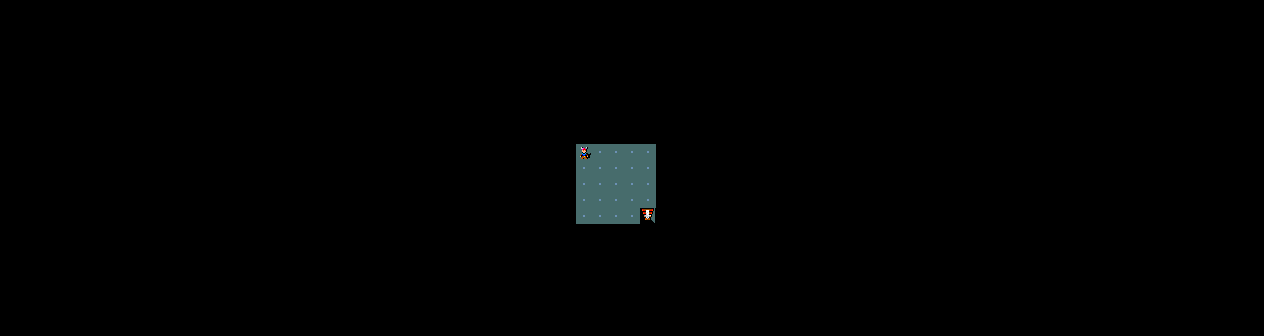

In [13]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
# The max number of epsidoe steps for the environment needs to be increased as it defaults to 250 for Navigation tasks
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [64]:
room_5x5_scores = run_actor_critic(env,number_episodes=100,max_episode_length=1000,iterations=5)

Episode: 0 Reward: 0.69 Average Reward: 0.69 Steps 140


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


KeyboardInterrupt: 

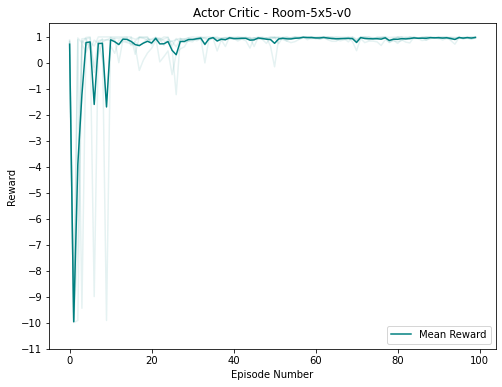

In [80]:
plot_results(env_name="Room-5x5-v0",scores=room_5x5_scores, color = "teal" )

## 1.2 Navigation - Room 15x15  

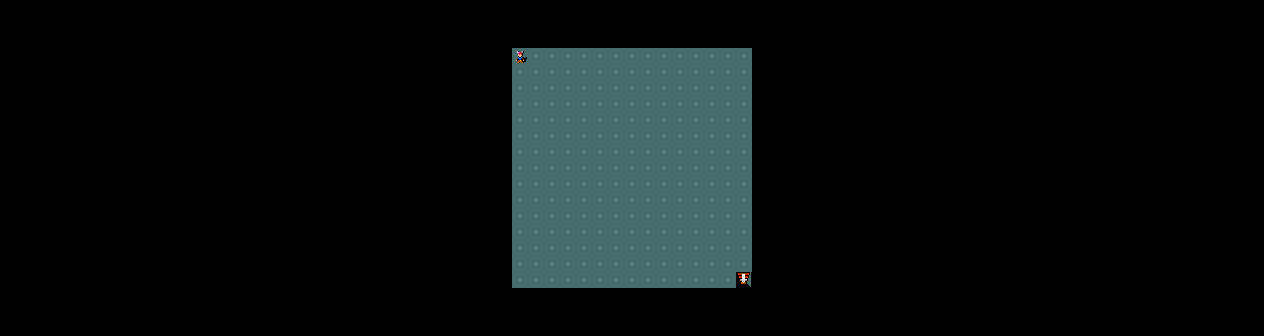

In [118]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
env = gym.make("MiniHack-Room-15x15-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [119]:
room_15x15_scores = run_actor_critic(env,number_episodes=100, max_episode_length=1000,iterations=5)

Episode: 0 Reward: 0.7599999999999999 Average Reward: 0.7599999999999999 Steps 179
Episode: 1 Reward: -9.85 Average Reward: -4.545 Steps 999
Episode: 2 Reward: 0.6199999999999999 Average Reward: -2.8233333333333337 Steps 137
Episode: 3 Reward: 0.82 Average Reward: -1.9125 Steps 78
Episode: 4 Reward: 0.75 Average Reward: -1.3800000000000001 Steps 140
Episode: 5 Reward: 0.8799999999999999 Average Reward: -1.0033333333333334 Steps 120
Episode: 6 Reward: 0.69 Average Reward: -0.7614285714285715 Steps 250
Episode: 7 Reward: 0.8 Average Reward: -0.56625 Steps 140
Episode: 8 Reward: 0.72 Average Reward: -0.4233333333333334 Steps 156
Episode: 9 Reward: 0.82 Average Reward: -0.29900000000000004 Steps 235
Episode: 10 Reward: 0.86 Average Reward: -0.19363636363636372 Steps 88
Episode: 11 Reward: 0.85 Average Reward: -0.10666666666666673 Steps 91
Episode: 12 Reward: 0.91 Average Reward: -0.028461538461538514 Steps 51
Episode: 13 Reward: -0.5199999999999998 Average Reward: -0.0635714285714286 Steps

Episode: 17 Reward: -0.5099999999999998 Average Reward: -0.495 Steps 241
Episode: 18 Reward: 0.08999999999999986 Average Reward: -0.46421052631578946 Steps 262
Episode: 19 Reward: -0.47999999999999987 Average Reward: -0.465 Steps 212
Episode: 20 Reward: -0.6000000000000002 Average Reward: -0.4714285714285714 Steps 264
Episode: 21 Reward: 0.21999999999999986 Average Reward: -0.44 Steps 144
Episode: 22 Reward: 0.53 Average Reward: -0.3978260869565218 Steps 161
Episode: 23 Reward: 0.85 Average Reward: -0.3458333333333334 Steps 88
Episode: 24 Reward: 0.6699999999999999 Average Reward: -0.3052 Steps 101
Episode: 25 Reward: -0.33999999999999986 Average Reward: -0.30653846153846154 Steps 196
Episode: 26 Reward: 0.78 Average Reward: -0.2662962962962963 Steps 94
Episode: 27 Reward: 0.93 Average Reward: -0.2235714285714286 Steps 85
Episode: 28 Reward: 0.75 Average Reward: -0.19000000000000003 Steps 113
Episode: 29 Reward: 0.6499999999999999 Average Reward: -0.16200000000000003 Steps 169
Episode:

Episode: 30 Reward: 0.96 Average Reward: -0.587741935483871 Steps 68
Episode: 31 Reward: 0.76 Average Reward: -0.5456249999999999 Steps 133
Episode: 32 Reward: 0.95 Average Reward: -0.5003030303030302 Steps 82
Episode: 33 Reward: 0.73 Average Reward: -0.46411764705882347 Steps 72
Episode: 34 Reward: 0.97 Average Reward: -0.42314285714285704 Steps 67
Episode: 35 Reward: 0.52 Average Reward: -0.3969444444444444 Steps 167
Episode: 36 Reward: 0.5599999999999999 Average Reward: -0.371081081081081 Steps 108
Episode: 37 Reward: 0.71 Average Reward: -0.34263157894736834 Steps 67
Episode: 38 Reward: 0.85 Average Reward: -0.31205128205128196 Steps 64
Episode: 39 Reward: 1.0 Average Reward: -0.27925 Steps 35
Episode: 40 Reward: 0.94 Average Reward: -0.24951219512195122 Steps 81
Episode: 41 Reward: 0.87 Average Reward: -0.2228571428571429 Steps 65
Episode: 42 Reward: 0.89 Average Reward: -0.19697674418604652 Steps 65
Episode: 43 Reward: 0.6 Average Reward: -0.1788636363636364 Steps 78
Episode: 44 

Episode: 52 Reward: 1.0 Average Reward: 0.8154 Steps 14
Episode: 53 Reward: 1.0 Average Reward: 0.9468000000000001 Steps 14
Episode: 54 Reward: 1.0 Average Reward: 0.96 Steps 14
Episode: 55 Reward: 1.0 Average Reward: 0.9626 Steps 14
Episode: 56 Reward: 1.0 Average Reward: 0.9690000000000001 Steps 14
Episode: 57 Reward: 1.0 Average Reward: 0.972 Steps 14
Episode: 58 Reward: 1.0 Average Reward: 0.9741999999999998 Steps 14
Episode: 59 Reward: 1.0 Average Reward: 0.9772 Steps 14
Episode: 60 Reward: 1.0 Average Reward: 0.9790000000000001 Steps 14
Episode: 61 Reward: 1.0 Average Reward: 0.9802000000000001 Steps 14
Episode: 62 Reward: 1.0 Average Reward: 0.9808 Steps 14
Episode: 63 Reward: 1.0 Average Reward: 0.9845999999999999 Steps 14
Episode: 64 Reward: 1.0 Average Reward: 0.9853999999999999 Steps 14
Episode: 65 Reward: 0.5299999999999999 Average Reward: 0.9786000000000001 Steps 63
Episode: 66 Reward: 1.0 Average Reward: 0.9798 Steps 14
Episode: 67 Reward: 1.0 Average Reward: 0.9892 Steps

Episode: 72 Reward: 0.7999999999999999 Average Reward: 0.8344 Steps 56
Episode: 73 Reward: 0.88 Average Reward: 0.8338 Steps 46
Episode: 74 Reward: 0.8 Average Reward: 0.8336 Steps 58
Episode: 75 Reward: 0.98 Average Reward: 0.8369999999999999 Steps 32
Episode: 76 Reward: 0.99 Average Reward: 0.8416 Steps 29
Episode: 77 Reward: 0.91 Average Reward: 0.8404 Steps 41
Episode: 78 Reward: 0.87 Average Reward: 0.8407999999999999 Steps 41
Episode: 79 Reward: 0.95 Average Reward: 0.84 Steps 35
Episode: 80 Reward: 0.89 Average Reward: 0.8384 Steps 46
Episode: 81 Reward: 0.98 Average Reward: 0.8382 Steps 33
Episode: 82 Reward: 0.9 Average Reward: 0.8375999999999999 Steps 43
Episode: 83 Reward: 1.0 Average Reward: 0.841 Steps 30
Episode: 84 Reward: 0.93 Average Reward: 0.8467999999999999 Steps 35
Episode: 85 Reward: 0.92 Average Reward: 0.8472 Steps 39
Episode: 86 Reward: 1.0 Average Reward: 0.8482 Steps 30
Episode: 87 Reward: 0.96 Average Reward: 0.8533999999999999 Steps 32
Episode: 88 Reward: 0

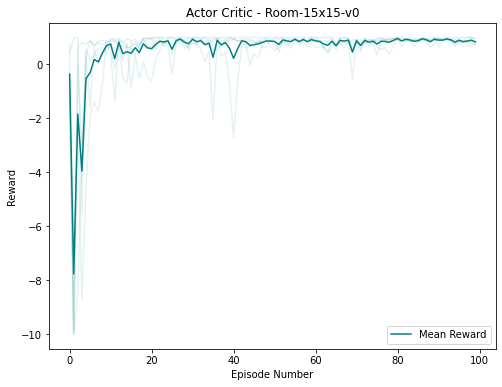

In [120]:
plot_results(env_name="Room-15x15-v0",scores=room_15x15_scores, color = "teal" )

## 1.3 Navigation - MazeWalk 9x9 

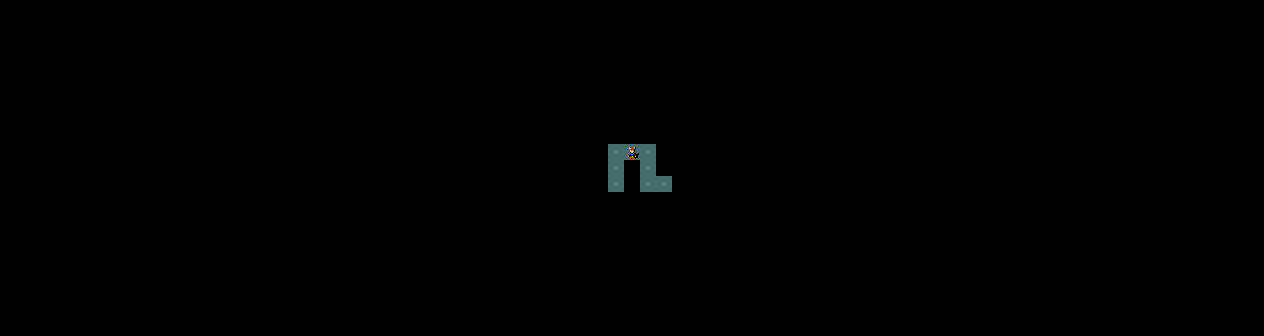

In [121]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
# Once again we need to set the max_episode_steps to larger than the default 250 for the more compicated environment
env = gym.make("MiniHack-MazeWalk-9x9-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=10000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [122]:
maze_9x9_scores = run_actor_critic(env,number_episodes=100,max_episode_length=10000,iterations=2)

Episode: 0 Reward: 0.78 Average Reward: 0.78 Steps 36


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


KeyboardInterrupt: 

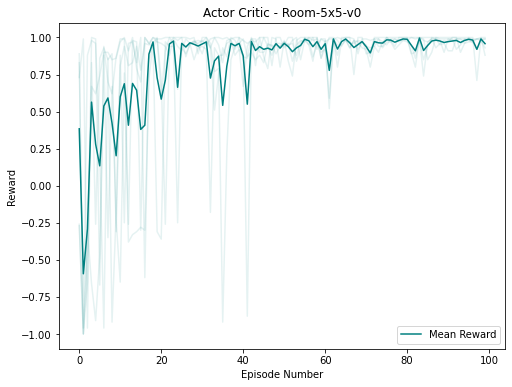

In [93]:
plot_results(env_name="MazeWalk-9x9-v0",scores=room_15x15_scores, color = "teal" )

## 2.1 Skill Acquisition - Eat 

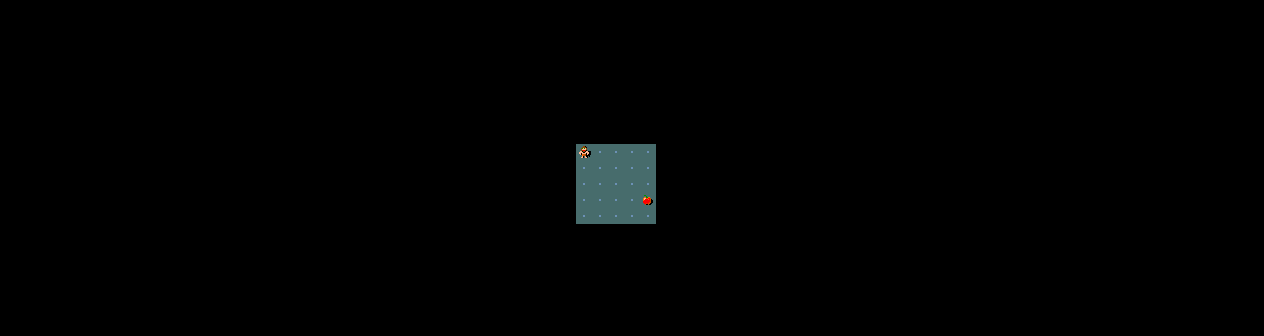

In [127]:
# By default Skill Acquisition tasks have an action space consisting of the full 78 actions available 
# Because most of these actions are unnecessary for smaller tasks we restrict the action space to the necessary 
# actions necesssary to complete the task in each environment only 
MOVE_ACTIONS = tuple(nethack.CompassDirection) # These are the cardinal directions
EAT_ACTIONS = MOVE_ACTIONS + (nethack.Command.EAT,) # Eat is to complete an episode by confirmation 


# Create the environment with the restricted action space as well as
# the observations keys required as input to the Actor Critic Neural Network 
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"],
               actions = EAT_ACTIONS, max_episode_steps=1000)
 
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [ ]:
# For skills acquisition tasks more training is required so not only are the episodes longer 
# but the number of episodes is also increased from 100 to 1000 
eat_scores = run_actor_critic(env,number_episodes=250,max_episode_length=1000,iterations=5)

Episode: 0 Reward: 0.9 Average Reward: 0.9 Steps 60


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode: 1 Reward: -9.95 Average Reward: -4.5249999999999995 Steps 999
Episode: 2 Reward: 0.95 Average Reward: -2.6999999999999997 Steps 20
Episode: 3 Reward: 0.5999999999999999 Average Reward: -1.875 Steps 87
Episode: 4 Reward: 0.94 Average Reward: -1.312 Steps 17
Episode: 5 Reward: 0.16000000000000014 Average Reward: -1.0666666666666667 Steps 108
Episode: 6 Reward: 0.25 Average Reward: -0.8785714285714287 Steps 103
Episode: 7 Reward: -4.64 Average Reward: -1.34875 Steps 587
Episode: 8 Reward: 0.73 Average Reward: -1.1177777777777775 Steps 55
Episode: 9 Reward: 0.84 Average Reward: -0.9219999999999999 Steps 44
Episode: 10 Reward: 0.87 Average Reward: -0.759090909090909 Steps 45
Episode: 11 Reward: 0.9299999999999999 Average Reward: -0.6183333333333333 Steps 15
Episode: 12 Reward: 0.94 Average Reward: -0.4984615384615385 Steps 20
Episode: 13 Reward: 0.8999999999999999 Average Reward: -0.3985714285714286 Steps 32
Episode: 14 Reward: 0.86 Average Reward: -0.31466666666666665 Steps 52
Epi

Episode: 125 Reward: 0.98 Average Reward: 0.9713999999999998 Steps 12
Episode: 126 Reward: 1.0 Average Reward: 0.9745999999999999 Steps 6
Episode: 127 Reward: 0.97 Average Reward: 0.9748 Steps 12
Episode: 128 Reward: 0.99 Average Reward: 0.9758000000000001 Steps 7
Episode: 129 Reward: 0.99 Average Reward: 0.9766000000000001 Steps 8
Episode: 130 Reward: 0.96 Average Reward: 0.9774 Steps 10
Episode: 131 Reward: 1.0 Average Reward: 0.9782000000000001 Steps 5
Episode: 132 Reward: 1.0 Average Reward: 0.9786000000000001 Steps 6
Episode: 133 Reward: 1.0 Average Reward: 0.98 Steps 6
Episode: 134 Reward: 0.99 Average Reward: 0.98 Steps 10
Episode: 135 Reward: 0.94 Average Reward: 0.9788000000000001 Steps 12
Episode: 136 Reward: 0.99 Average Reward: 0.9788000000000001 Steps 6
Episode: 137 Reward: 0.98 Average Reward: 0.9790000000000001 Steps 8
Episode: 138 Reward: 0.98 Average Reward: 0.9793999999999998 Steps 7
Episode: 139 Reward: 0.99 Average Reward: 0.9796 Steps 6
Episode: 140 Reward: 0.99 Av

Episode: 13 Reward: 0.81 Average Reward: -0.737142857142857 Steps 89
Episode: 14 Reward: 0.91 Average Reward: -0.6273333333333332 Steps 46
Episode: 15 Reward: 1.0 Average Reward: -0.5256249999999998 Steps 4
Episode: 16 Reward: 0.99 Average Reward: -0.4364705882352939 Steps 11
Episode: 17 Reward: 0.92 Average Reward: -0.36111111111111094 Steps 18
Episode: 18 Reward: 0.97 Average Reward: -0.2910526315789472 Steps 9
Episode: 19 Reward: 0.96 Average Reward: -0.22849999999999984 Steps 21
Episode: 20 Reward: 0.96 Average Reward: -0.17190476190476175 Steps 25
Episode: 21 Reward: 0.99 Average Reward: -0.11909090909090893 Steps 7
Episode: 22 Reward: 0.95 Average Reward: -0.07260869565217376 Steps 14
Episode: 23 Reward: 1.0 Average Reward: -0.02791666666666659 Steps 9
Episode: 24 Reward: 0.98 Average Reward: 0.012400000000000072 Steps 12
Episode: 25 Reward: 1.0 Average Reward: 0.05038461538461546 Steps 6
Episode: 26 Reward: 1.0 Average Reward: 0.08555555555555562 Steps 10
Episode: 27 Reward: 0.7

Episode: 139 Reward: 0.85 Average Reward: 0.9481999999999999 Steps 23
Episode: 140 Reward: 0.97 Average Reward: 0.9486 Steps 11
Episode: 141 Reward: 0.94 Average Reward: 0.9495999999999999 Steps 14
Episode: 142 Reward: 0.9299999999999999 Average Reward: 0.9486 Steps 15
Episode: 143 Reward: 0.89 Average Reward: 0.9472 Steps 22
Episode: 144 Reward: 0.95 Average Reward: 0.9466 Steps 13
Episode: 145 Reward: 0.97 Average Reward: 0.9468000000000001 Steps 11
Episode: 146 Reward: 0.8499999999999999 Average Reward: 0.9445999999999999 Steps 24
Episode: 147 Reward: 0.96 Average Reward: 0.9446000000000001 Steps 14
Episode: 148 Reward: 0.92 Average Reward: 0.9438000000000001 Steps 22
Episode: 149 Reward: 0.98 Average Reward: 0.944 Steps 11
Episode: 150 Reward: 0.99 Average Reward: 0.9444 Steps 9
Episode: 151 Reward: 0.98 Average Reward: 0.9448000000000001 Steps 11
Episode: 152 Reward: 0.98 Average Reward: 0.9447999999999999 Steps 10
Episode: 153 Reward: 0.97 Average Reward: 0.945 Steps 11
Episode: 

Episode: 14 Reward: 0.97 Average Reward: 0.13266666666666682 Steps 26
Episode: 15 Reward: 0.9 Average Reward: 0.1806250000000001 Steps 17
Episode: 16 Reward: 0.76 Average Reward: 0.21470588235294125 Steps 70
Episode: 17 Reward: 0.91 Average Reward: 0.2533333333333334 Steps 43
Episode: 18 Reward: 0.9 Average Reward: 0.28736842105263166 Steps 33
Episode: 19 Reward: 0.94 Average Reward: 0.3200000000000001 Steps 26
Episode: 20 Reward: 0.97 Average Reward: 0.350952380952381 Steps 17
Episode: 21 Reward: 0.95 Average Reward: 0.3781818181818183 Steps 15
Episode: 22 Reward: 0.98 Average Reward: 0.40434782608695663 Steps 15
Episode: 23 Reward: 0.8200000000000001 Average Reward: 0.4216666666666667 Steps 27
Episode: 24 Reward: 0.7399999999999999 Average Reward: 0.43440000000000006 Steps 32
Episode: 25 Reward: 0.99 Average Reward: 0.4557692307692308 Steps 12
Episode: 26 Reward: 0.99 Average Reward: 0.4755555555555556 Steps 9
Episode: 27 Reward: 0.9 Average Reward: 0.49071428571428577 Steps 23
Episo

Episode: 139 Reward: 1.0 Average Reward: 0.9632 Steps 5
Episode: 140 Reward: 0.97 Average Reward: 0.9643999999999999 Steps 11
Episode: 141 Reward: 1.0 Average Reward: 0.965 Steps 6
Episode: 142 Reward: 0.97 Average Reward: 0.9653999999999999 Steps 10
Episode: 143 Reward: 0.98 Average Reward: 0.9653999999999998 Steps 7
Episode: 144 Reward: 0.99 Average Reward: 0.966 Steps 7
Episode: 145 Reward: 0.94 Average Reward: 0.9673999999999999 Steps 15
Episode: 146 Reward: 0.99 Average Reward: 0.9682 Steps 6
Episode: 147 Reward: 0.99 Average Reward: 0.9680000000000001 Steps 7
Episode: 148 Reward: 0.99 Average Reward: 0.9690000000000001 Steps 6
Episode: 149 Reward: 0.94 Average Reward: 0.9692000000000001 Steps 14
Episode: 150 Reward: 0.99 Average Reward: 0.9690000000000001 Steps 7
Episode: 151 Reward: 0.98 Average Reward: 0.9689999999999999 Steps 12
Episode: 152 Reward: 1.0 Average Reward: 0.9702 Steps 6
Episode: 153 Reward: 1.0 Average Reward: 0.9712000000000001 Steps 7
Episode: 154 Reward: 0.97 

Episode: 18 Reward: 1.0 Average Reward: 0.8273684210526315 Steps 4
Episode: 19 Reward: 1.0 Average Reward: 0.836 Steps 4
Episode: 20 Reward: 1.0 Average Reward: 0.8438095238095238 Steps 4
Episode: 21 Reward: 1.0 Average Reward: 0.8509090909090908 Steps 4
Episode: 22 Reward: 1.0 Average Reward: 0.8573913043478261 Steps 4
Episode: 23 Reward: 1.0 Average Reward: 0.8633333333333334 Steps 4
Episode: 24 Reward: 1.0 Average Reward: 0.8688000000000001 Steps 4
Episode: 25 Reward: 1.0 Average Reward: 0.8738461538461539 Steps 4
Episode: 26 Reward: 1.0 Average Reward: 0.8785185185185186 Steps 4
Episode: 27 Reward: 1.0 Average Reward: 0.8828571428571429 Steps 4
Episode: 28 Reward: 1.0 Average Reward: 0.8868965517241381 Steps 4
Episode: 29 Reward: 1.0 Average Reward: 0.8906666666666667 Steps 4
Episode: 30 Reward: 1.0 Average Reward: 0.8941935483870969 Steps 4
Episode: 31 Reward: 1.0 Average Reward: 0.8975000000000001 Steps 4
Episode: 32 Reward: 1.0 Average Reward: 0.9006060606060606 Steps 4
Episode:

Episode: 165 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 166 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 167 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 168 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 169 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 170 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 171 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 172 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 173 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 174 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 175 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 176 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 177 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 178 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 179 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 180 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 181 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 182 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 183 Reward: 1.0 Average Reward: 1.0 S

In [ ]:
plot_results(env_name="Eat-v0",scores=eat_scores, color = "teal" )

## 2.2 Skill Acquisition - Wear 

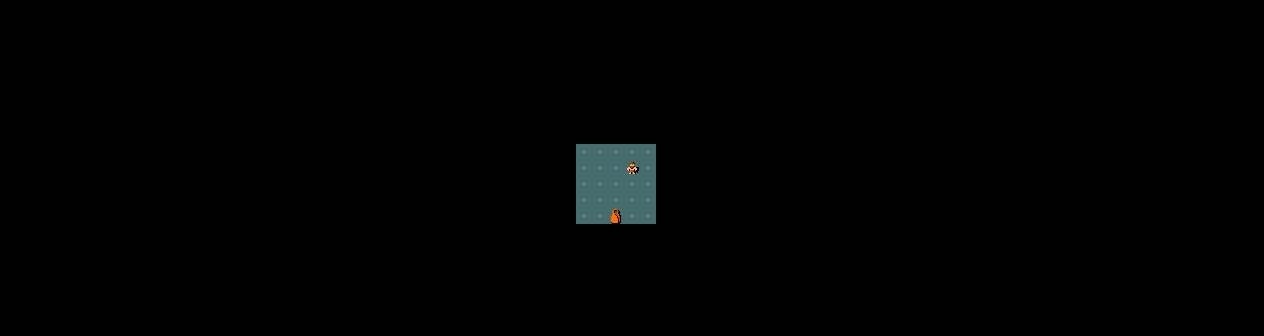

In [150]:
# For the Wear environment the agent also needs to be able to pickup an item, 
# choose to wear it and confirm that they want to wear 
MOVE_ACTIONS = tuple(nethack.CompassDirection)
WEAR_ACTIONS = MOVE_ACTIONS + (nethack.Command.PICKUP, nethack.Command.WEAR, nethack.Command.FIRE,)

# Much more complicated than any of the previous tasks so the episode length has to be increased to 10000
env = gym.make("MiniHack-Wear-v0", observation_keys=["glyphs","pixel","message"], 
               actions = WEAR_ACTIONS, max_episode_steps=10000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [157]:
wear_scores = run_actor_critic(env,number_episodes=100,max_episode_length=1000,iterations=5)

Episode: 0 Reward: -8.04 Average Reward: -8.04 Steps 999


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode: 1 Reward: -9.969999999999999 Average Reward: -9.004999999999999 Steps 999
Episode: 2 Reward: -6.98 Average Reward: -8.33 Steps 999
Episode: 3 Reward: -8.51 Average Reward: -8.375 Steps 999
Episode: 4 Reward: -9.5 Average Reward: -8.6 Steps 999
Episode: 5 Reward: -9.219999999999999 Average Reward: -8.703333333333333 Steps 999
Episode: 6 Reward: 0.22999999999999998 Average Reward: -7.427142857142857 Steps 210
Episode: 7 Reward: 0.31999999999999995 Average Reward: -6.45875 Steps 153
Episode: 8 Reward: -0.07000000000000006 Average Reward: -5.748888888888889 Steps 226
Episode: 9 Reward: -7.1899999999999995 Average Reward: -5.893 Steps 999
Episode: 10 Reward: 0.62 Average Reward: -5.300909090909091 Steps 69
Episode: 11 Reward: -7.969999999999999 Average Reward: -5.523333333333333 Steps 999
Episode: 12 Reward: -8.09 Average Reward: -5.720769230769231 Steps 999
Episode: 13 Reward: -7.2 Average Reward: -5.826428571428572 Steps 999
Episode: 14 Reward: -4.43 Average Reward: -5.7333333333

KeyboardInterrupt: 

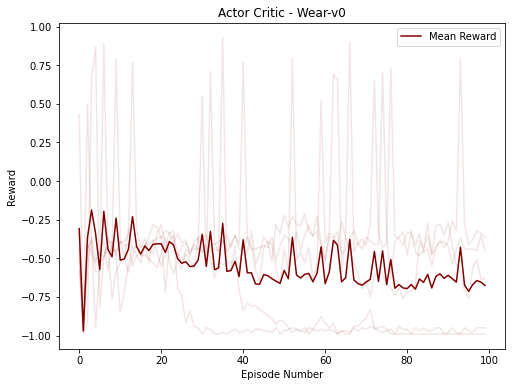

In [156]:
plot_results(env_name="Wear-v0",scores=wear_scores, color = "maroon" )

## 2.3 Skill Acquisition - Lava Cross Potion Inv

## 3. Quest Hard 

In [42]:
MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.READ, 
    nethack.Command.WEAR, 
    nethack.Command.QUAFF
 )

In [43]:
def maze_explore_reward(env, prev_obs, action, next_obs):
    if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
        return 0.1
    return 0

def standing_still(env, prev_obs, action, next_obs):
    if (prev_obs[13] == next_obs[13]).all():
        return -0.1
    return 0

In [44]:
from minihack import RewardManager
reward_gen = RewardManager()
reward_gen.add_eat_event("apple", reward=1)
#reward_gen.add_location_event("staircase down", reward=1, terminal_sufficient=True)
reward_gen.add_custom_reward_fn(maze_explore_reward)
#reward_gen.add_custom_reward_fn(standing_still)

In [45]:
env = gym.make("MiniHack-LavaCross-Levitate-Potion-Inv-v0", observation_keys=["glyphs","pixel","message"], actions=NAVIGATE_ACTIONS, 
               max_episode_steps=10000, reward_lose=-1)# reward_manager= reward_gen)

In [46]:
env.action_space.n

10

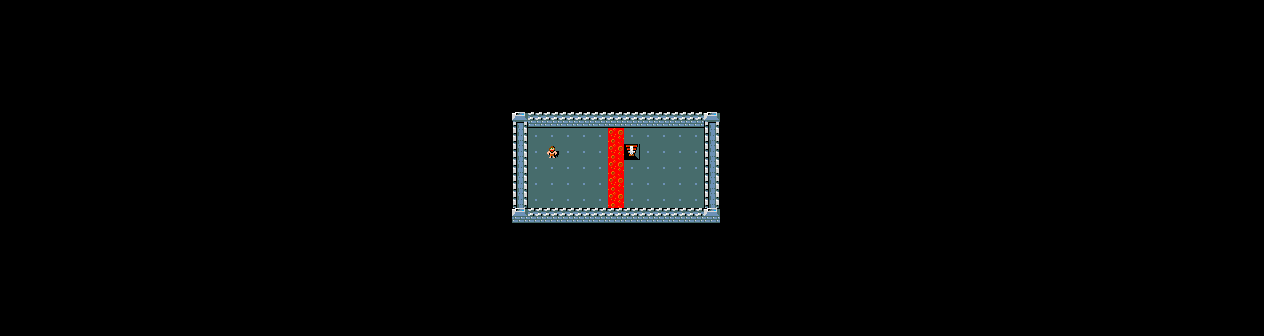

In [47]:
display_screen(env.reset())

In [ ]:
model = ActorCritic(h_size=512, a_size=env.action_space.n)
policy, scores = actor_critic(env=env, model= model, seed=42, learning_rate=0.02, betas=(0.9, 0.999),
                           number_episodes=1000, max_episode_length=10000, gamma=0.99 ,verbose=True, max_reward=1)

Episode: 0 Reward: -98.13999999999999 Average Reward: -98.13999999999999 Steps 9999


/var/folders/wm/vfztc0rx29d3qrfj3k_2nkgm0000gn/T/ipykernel_97978/3415855488.py:65: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode: 1 Reward: -99.96000000000001 Average Reward: -99.05 Steps 9999
Episode: 2 Reward: -97.61000000000001 Average Reward: -98.57000000000001 Steps 9999
Episode: 3 Reward: -98.47999999999999 Average Reward: -98.54750000000001 Steps 9999
Episode: 4 Reward: -3.14 Average Reward: -79.46600000000001 Steps 523
Episode: 5 Reward: -98.66999999999999 Average Reward: -82.66666666666667 Steps 9999
Episode: 6 Reward: -98.32 Average Reward: -84.90285714285713 Steps 9999
Episode: 7 Reward: -98.35999999999999 Average Reward: -86.585 Steps 9999
Episode: 8 Reward: -1.72 Average Reward: -77.15555555555555 Steps 154
Episode: 9 Reward: 0.78 Average Reward: -69.362 Steps 53
Episode: 10 Reward: -98.59 Average Reward: -72.0190909090909 Steps 9999
Episode: 11 Reward: -1.1 Average Reward: -66.10916666666667 Steps 14
Episode: 12 Reward: -98.01999999999998 Average Reward: -68.56384615384616 Steps 9999
Episode: 13 Reward: -0.08000000000000018 Average Reward: -63.672142857142866 Steps 260
Episode: 14 Reward: 0

Text(0, 0.5, ' ')

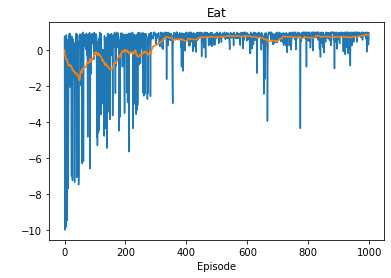

In [98]:
plt.title("Wear-Fixed")
plt.plot(scores, label="Rewards")
plt.plot(moving_average(scores,50), label = "Moving Average w = 50")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [ ]:
python -m minihack.scripts.play_gui --env MiniHack-River-v0

In [120]:
state = env.reset()
print("Rest")

Rest


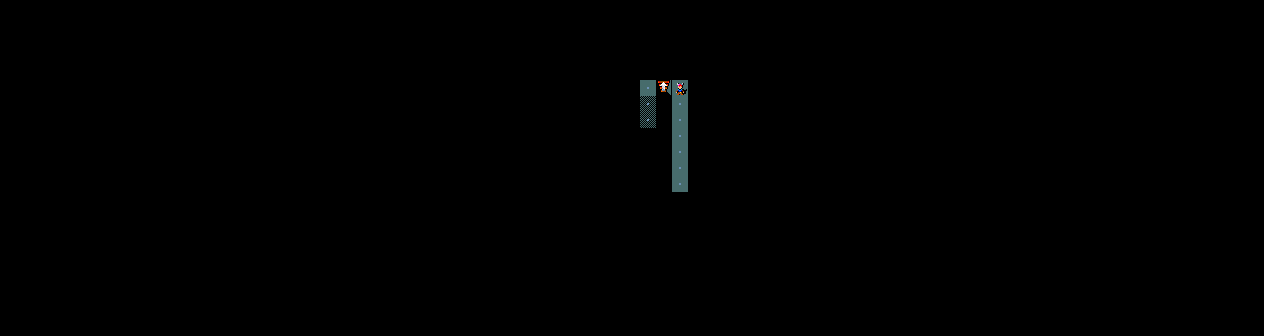

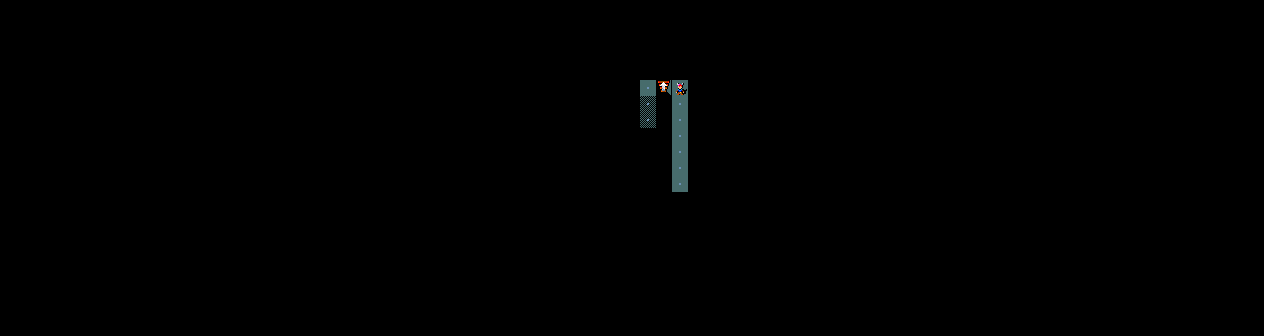

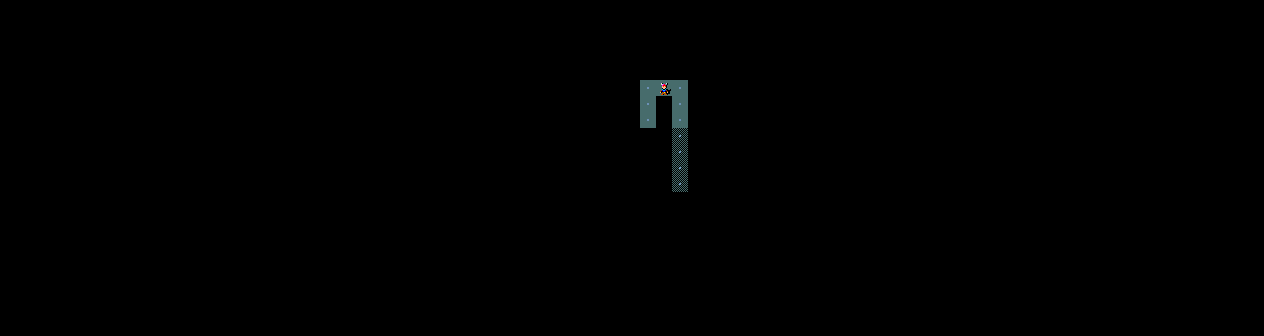

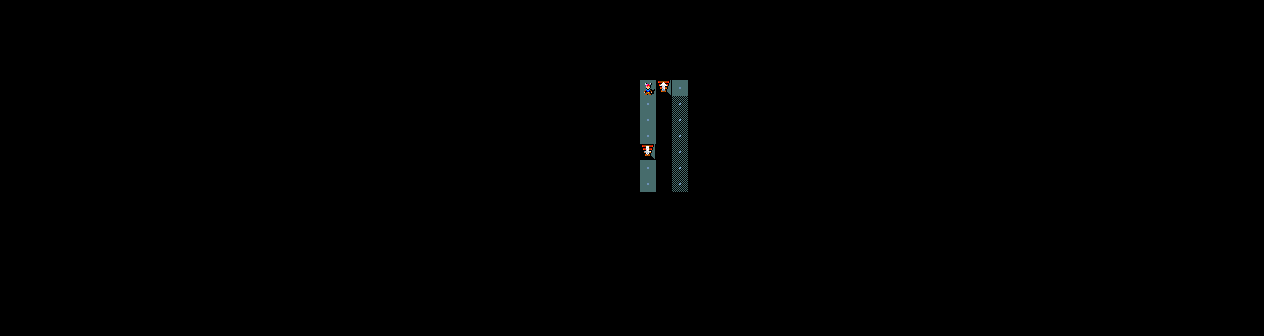

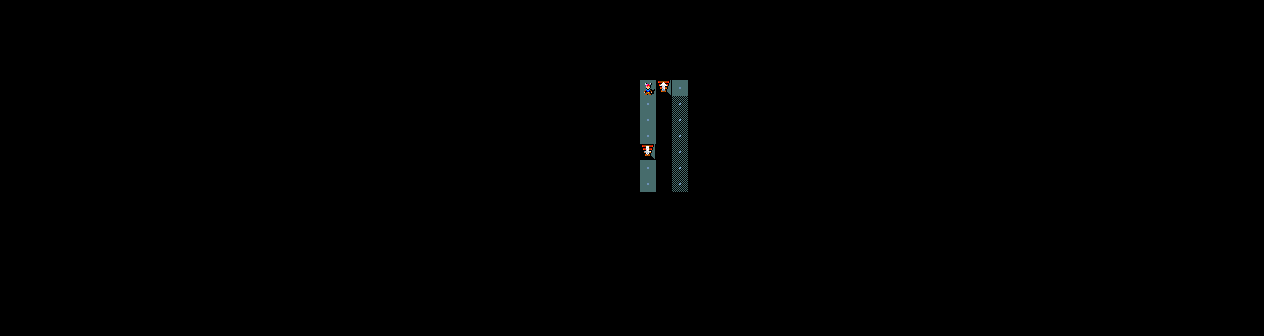

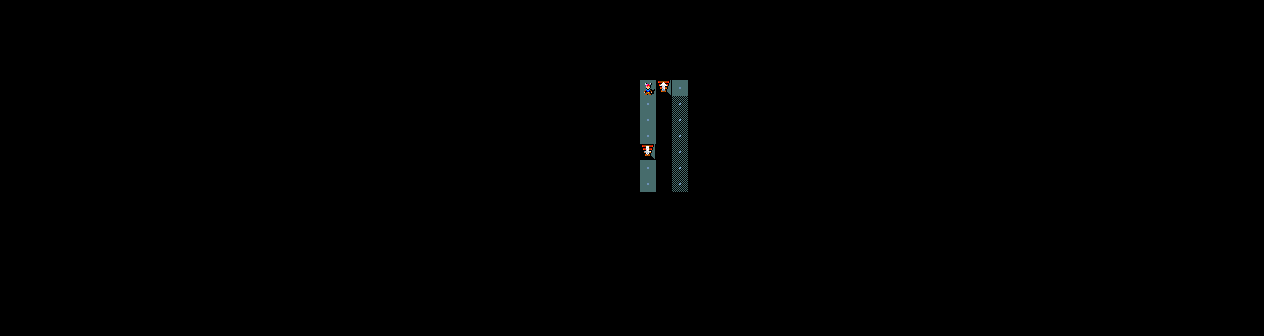

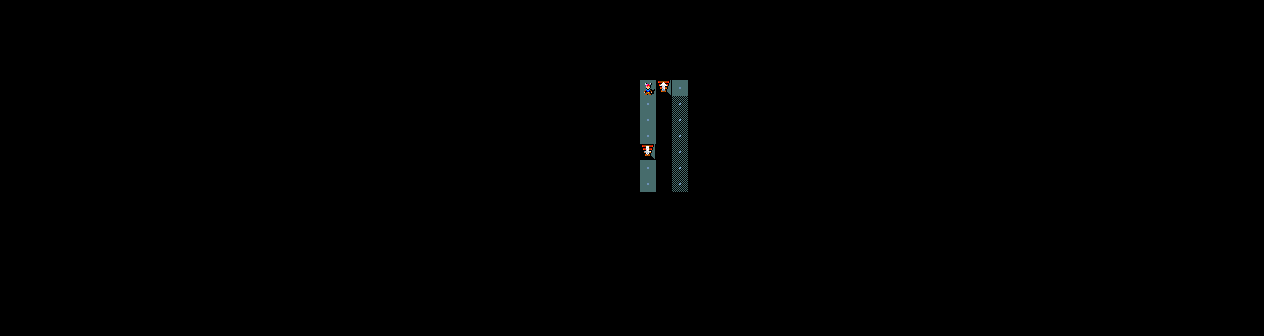

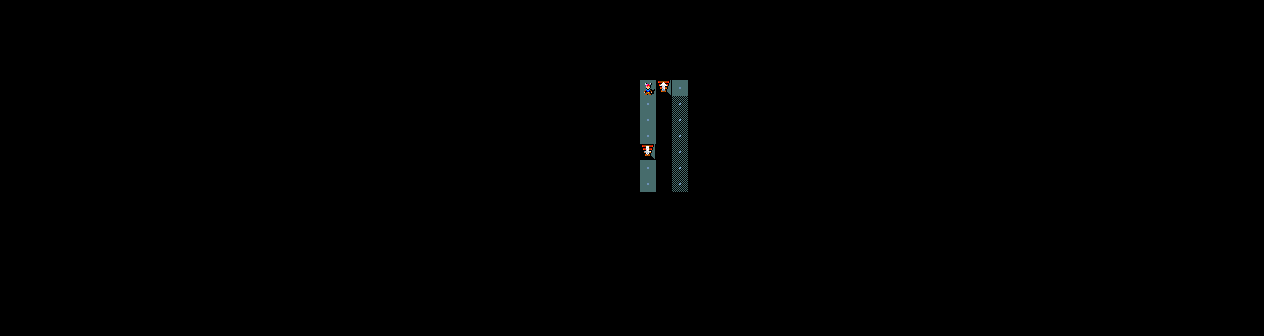

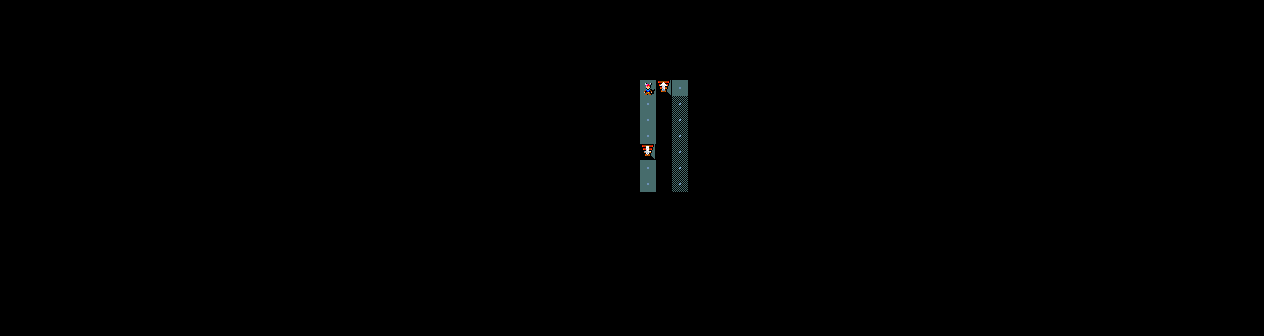

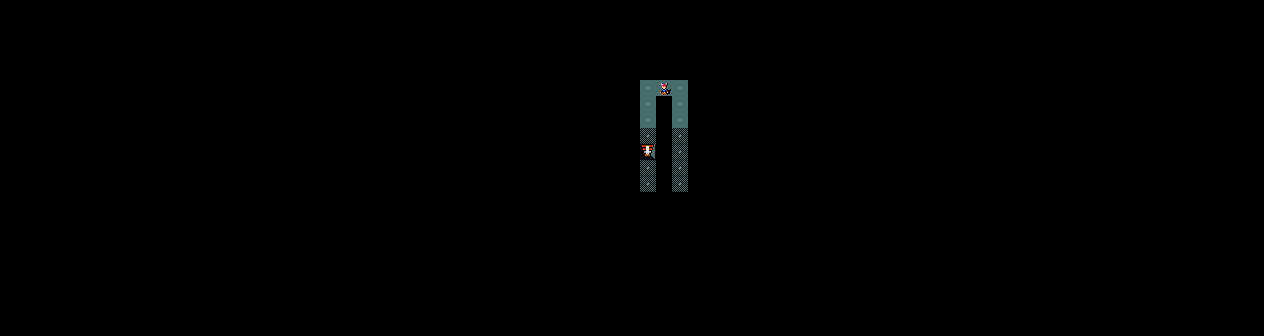

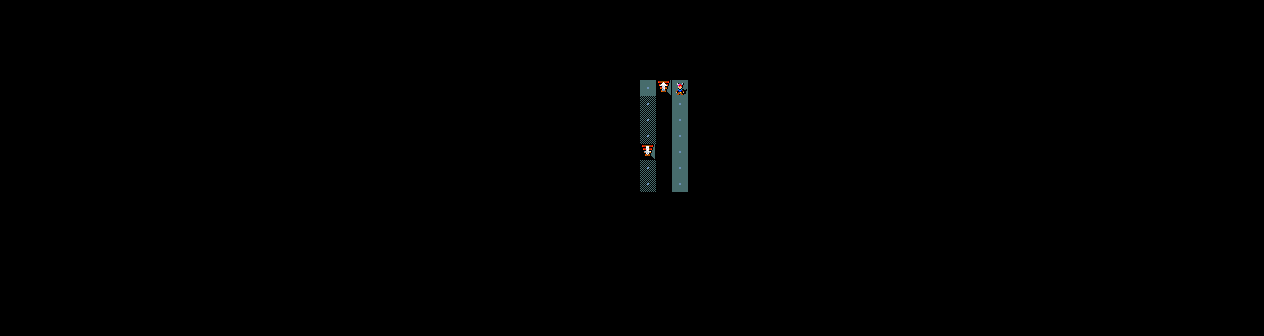

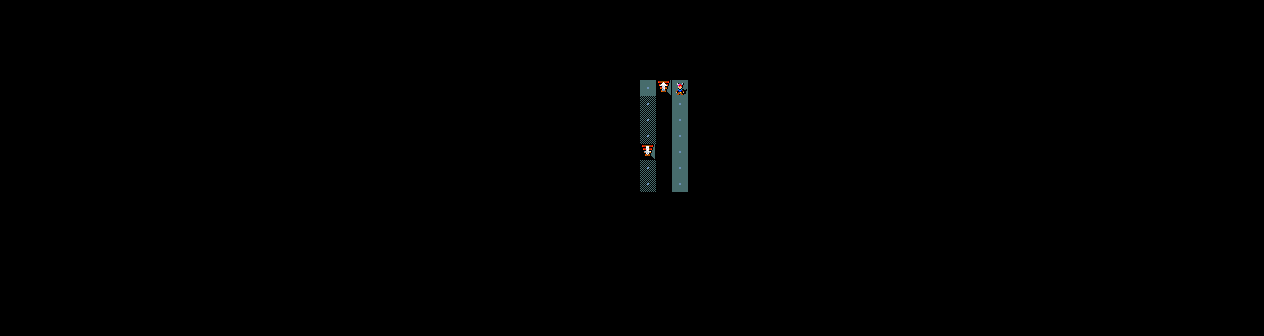

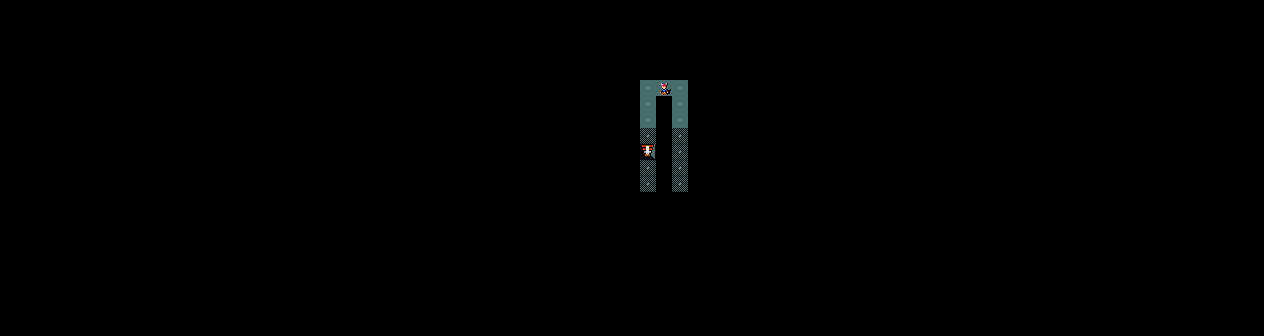

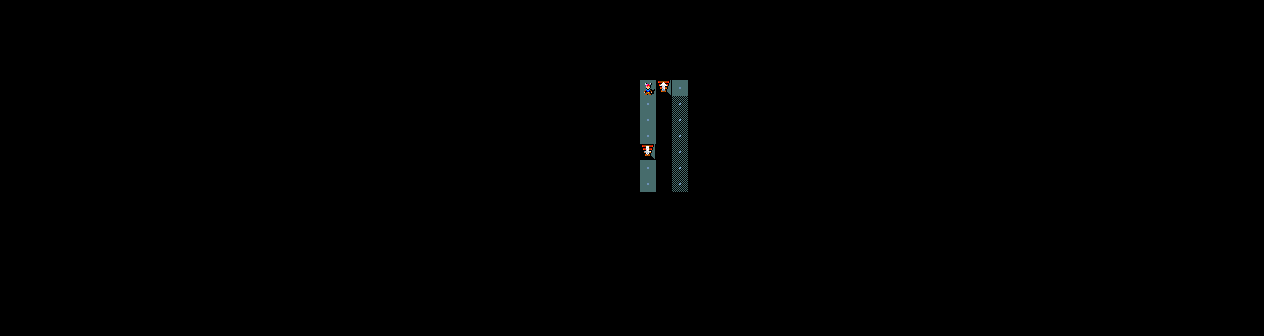

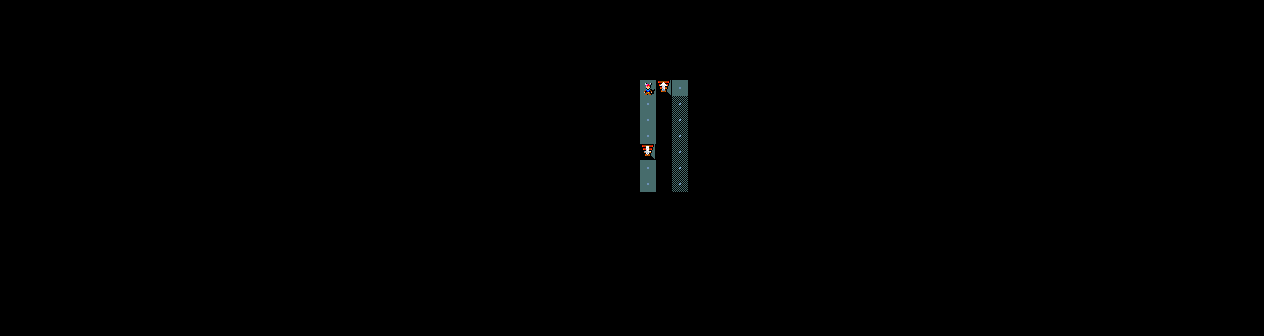

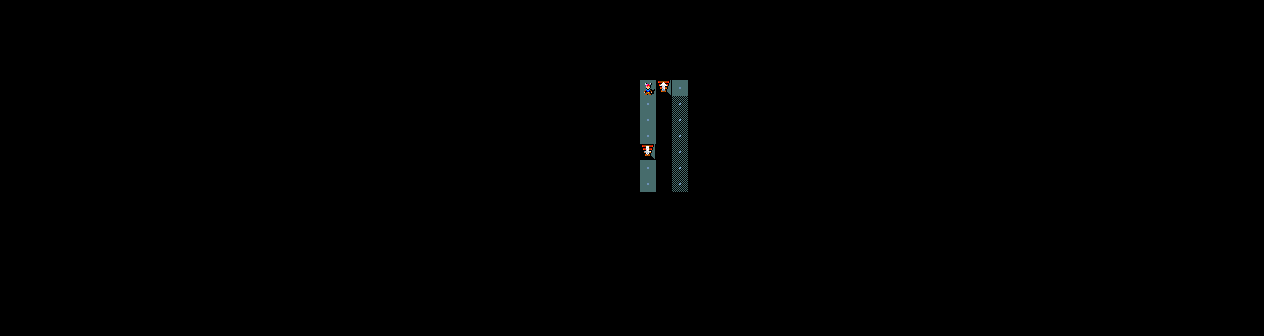

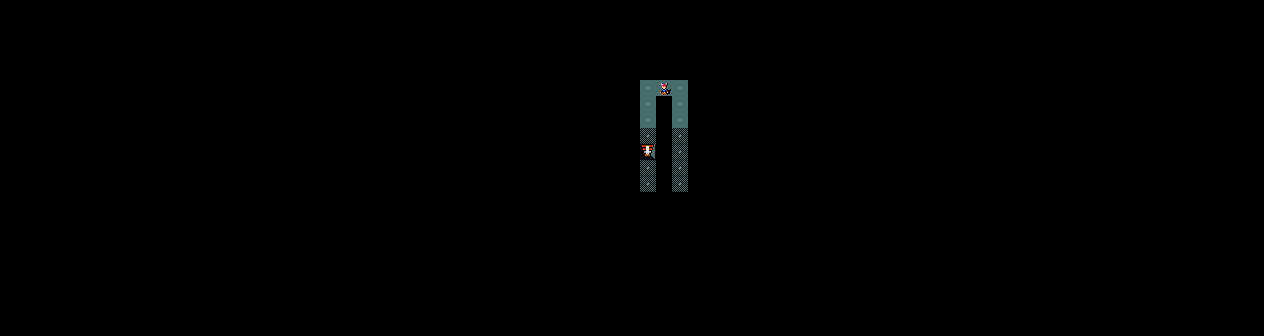

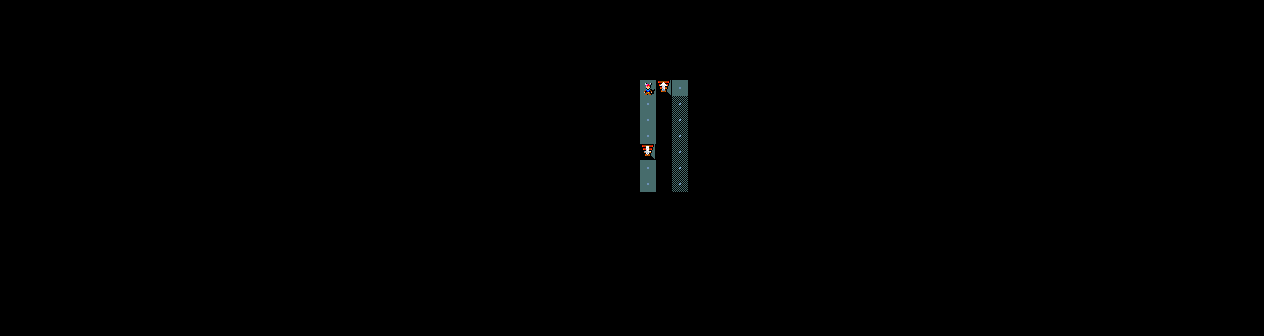

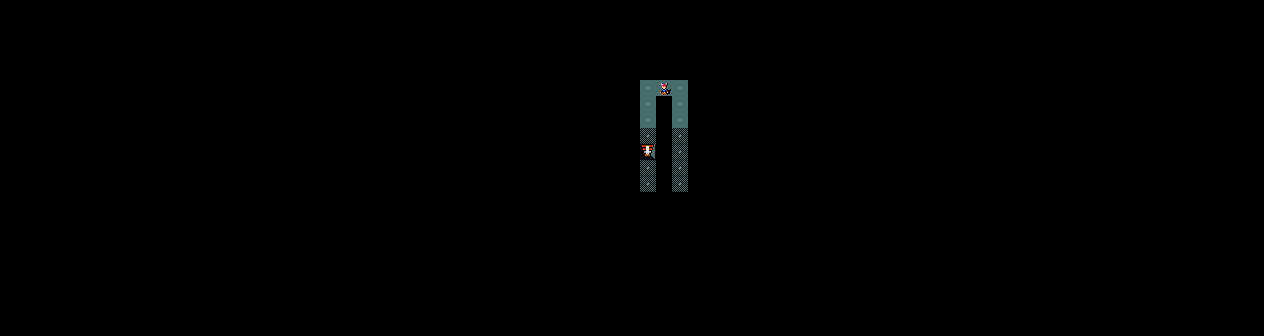

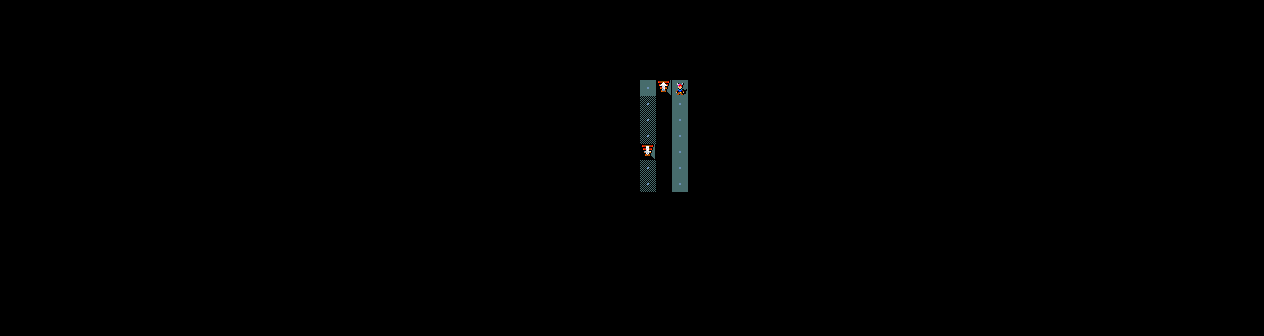

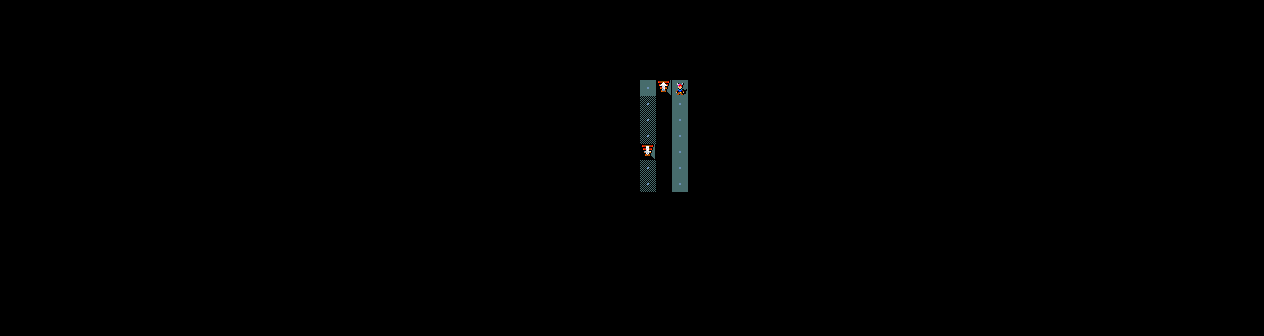

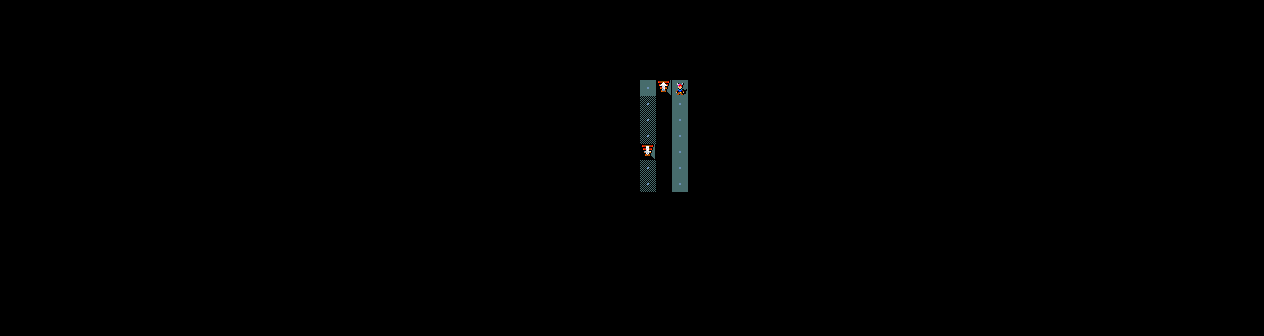

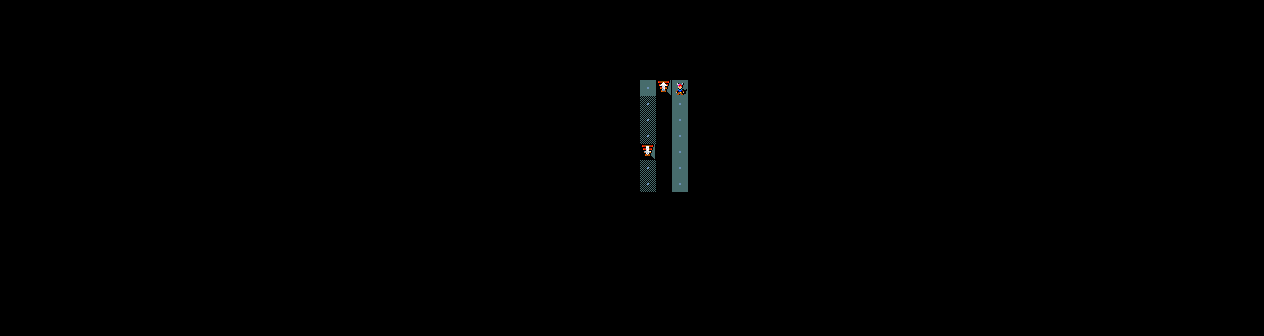

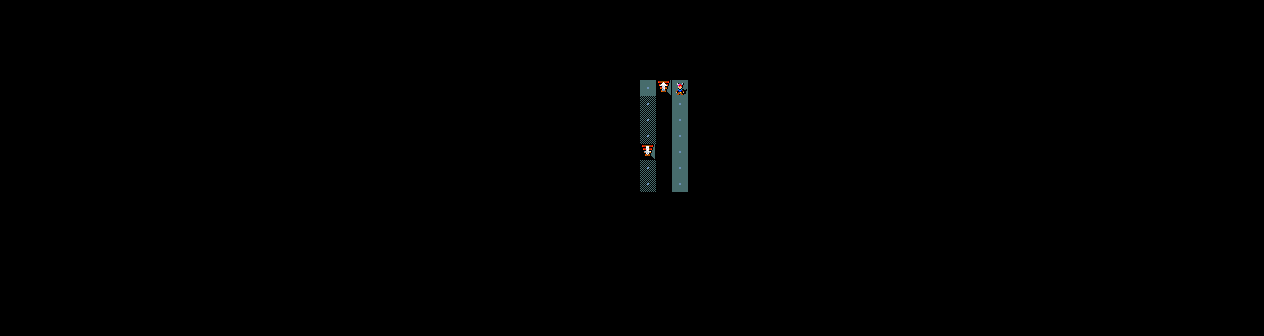

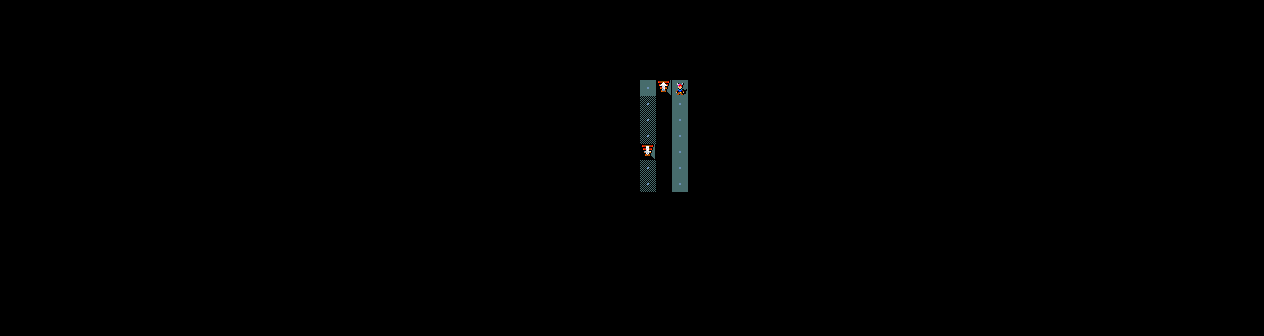

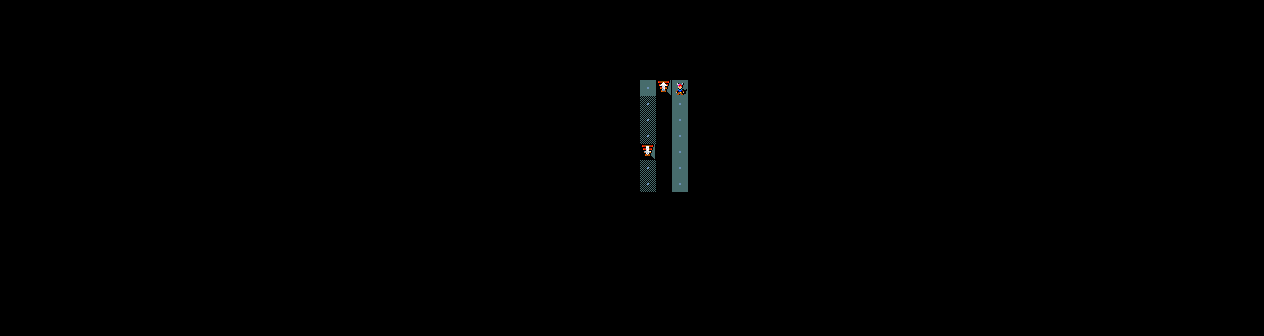

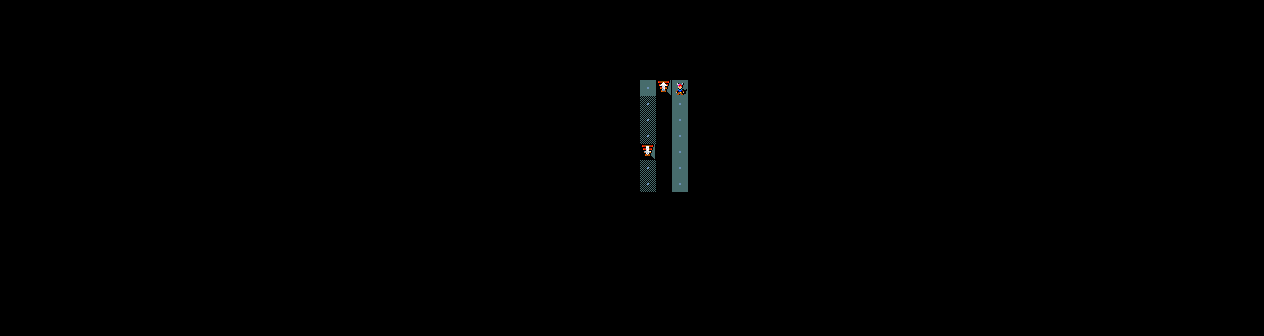

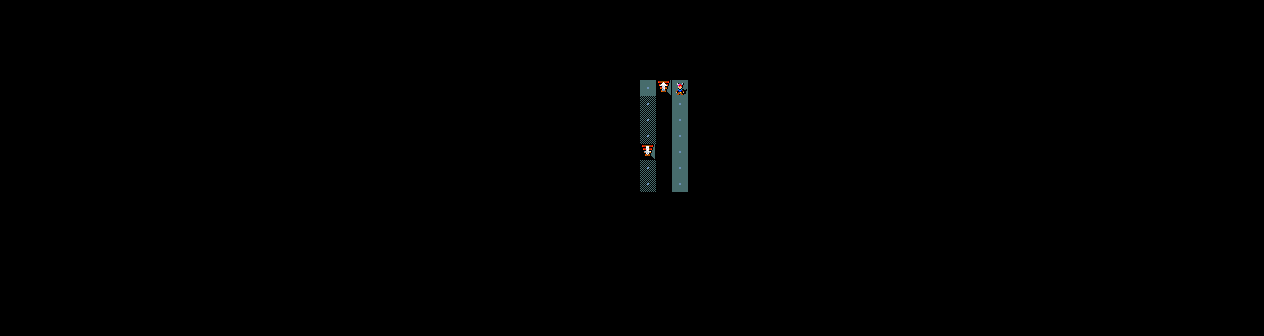

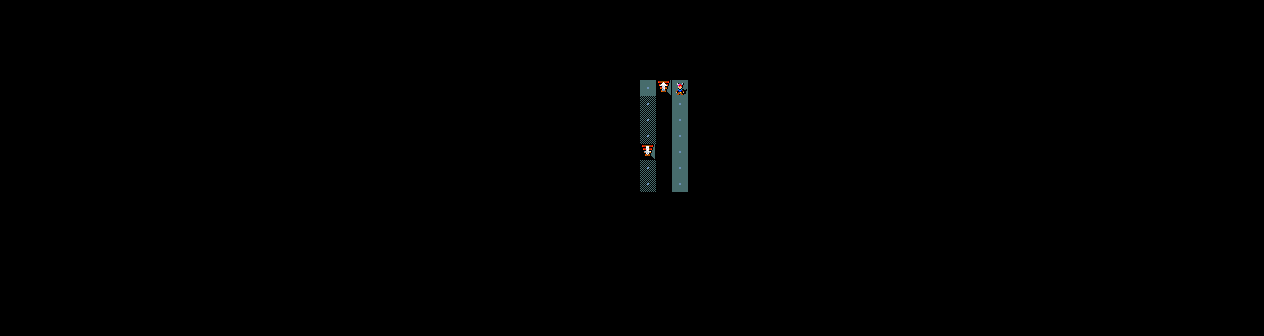

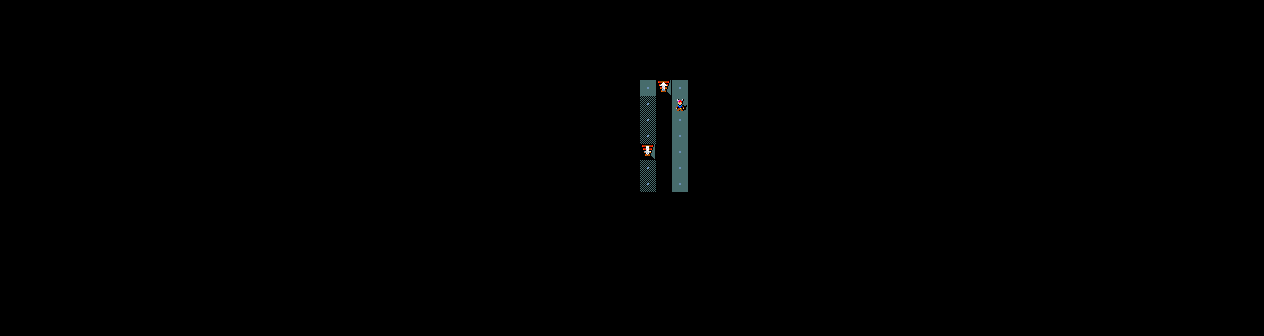

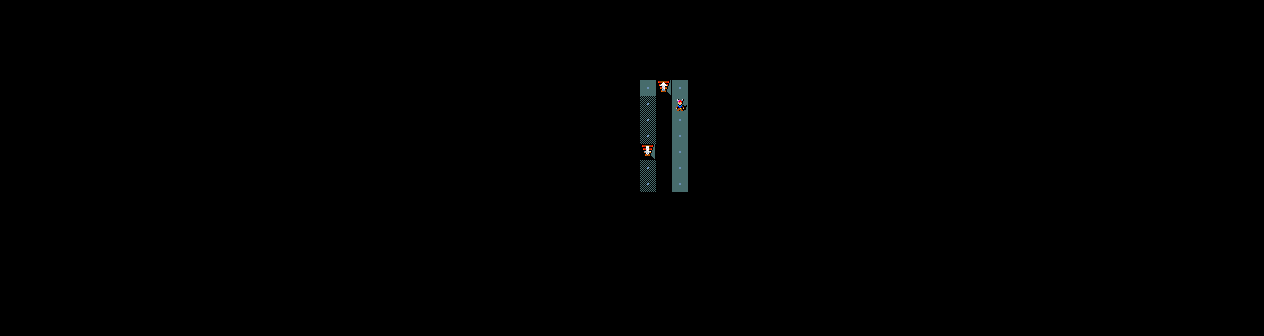

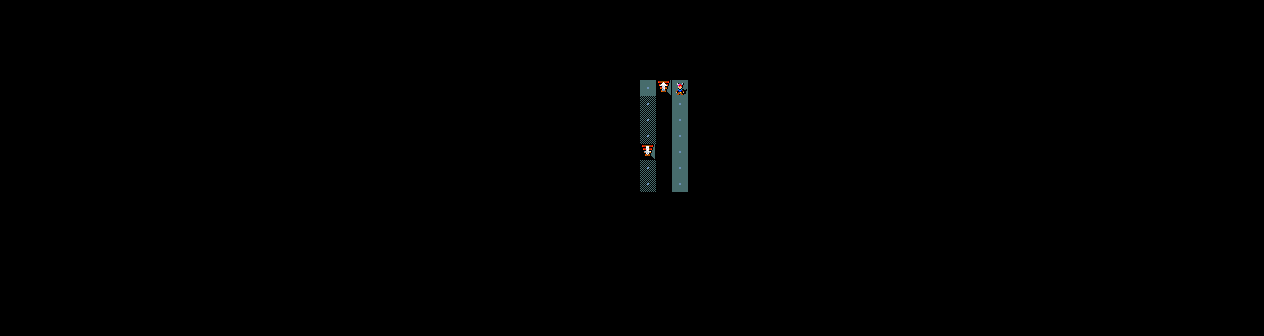

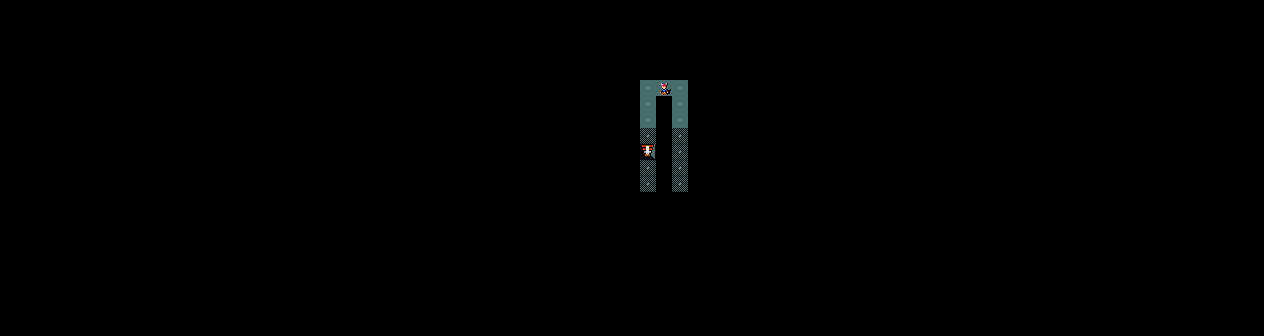

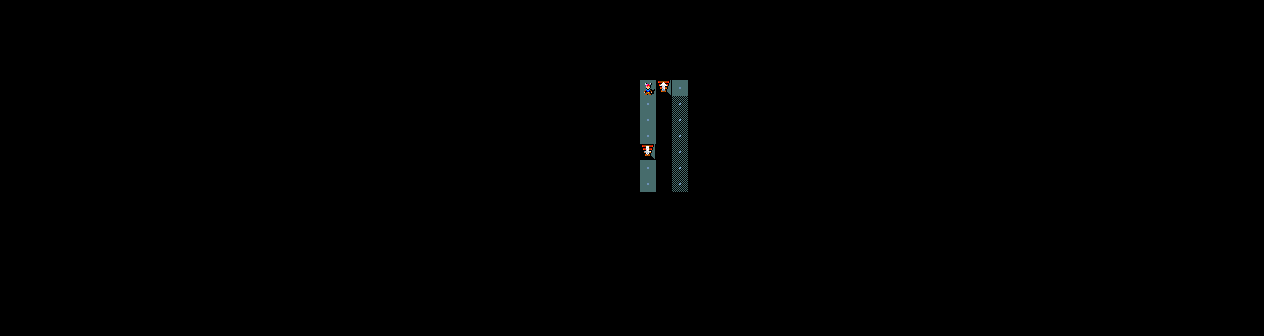

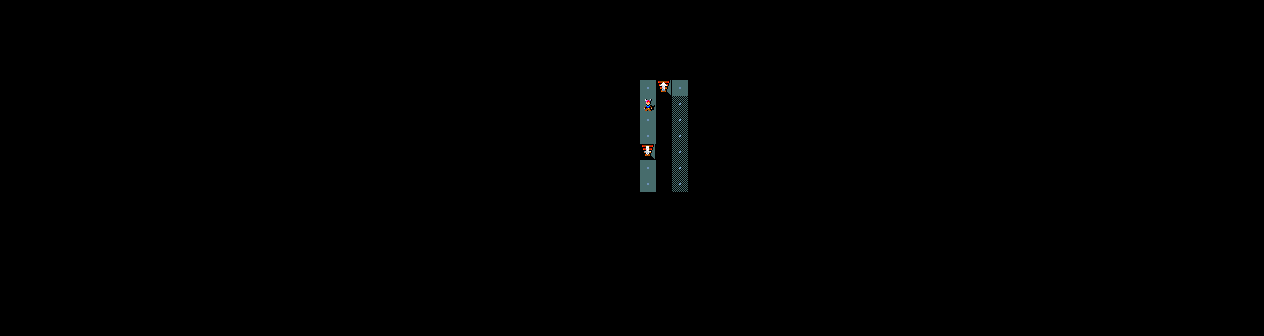

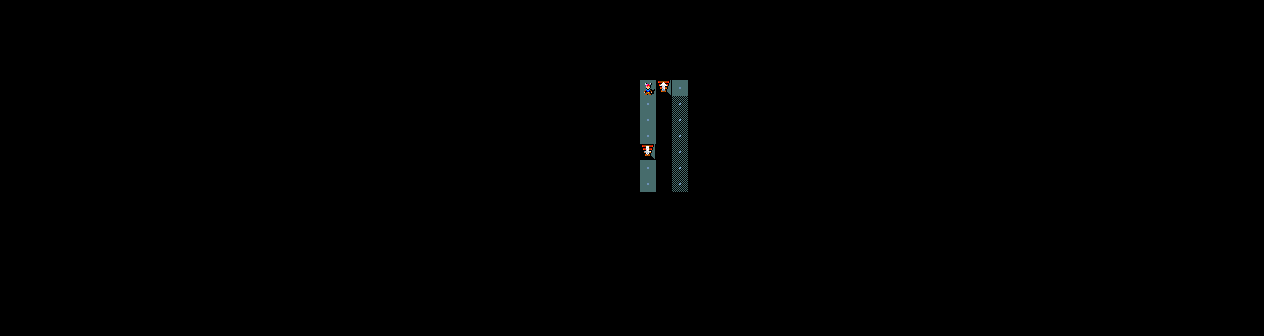

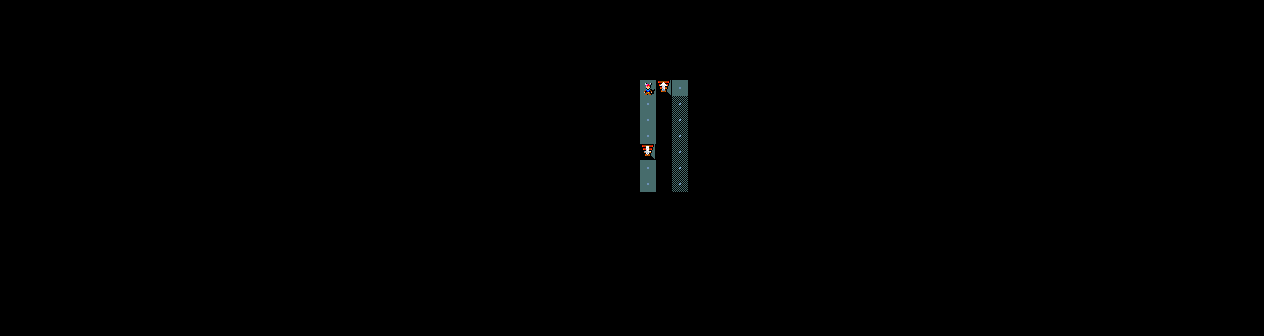

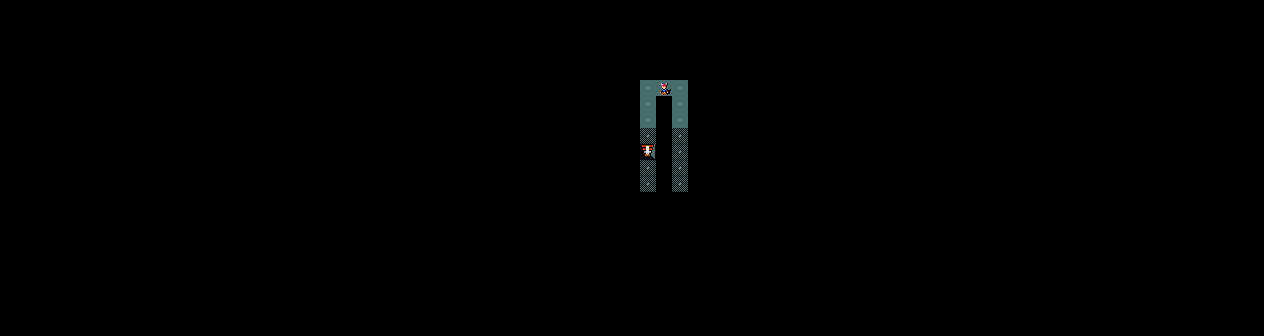

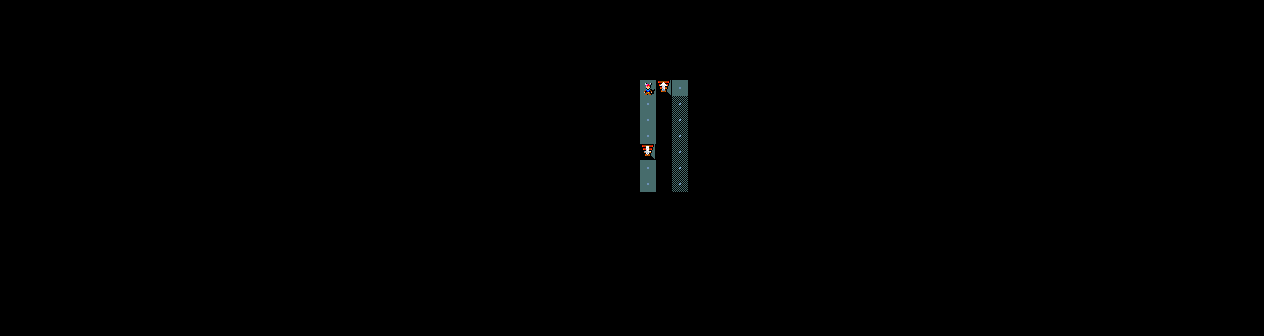

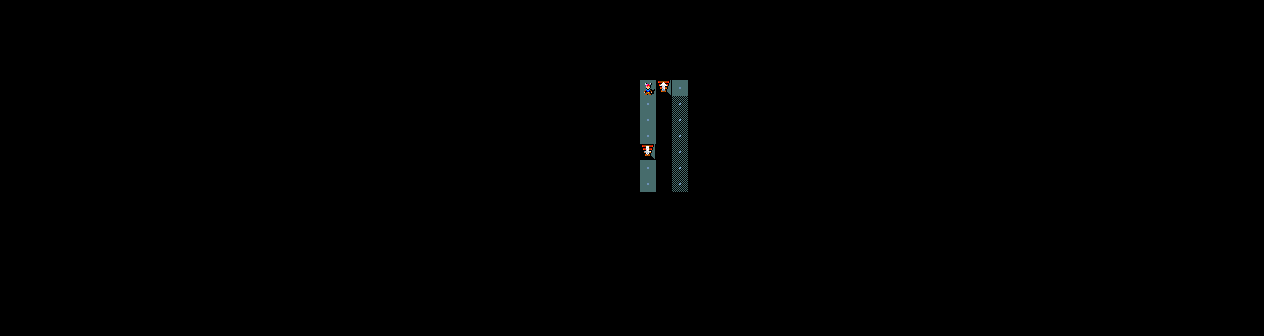

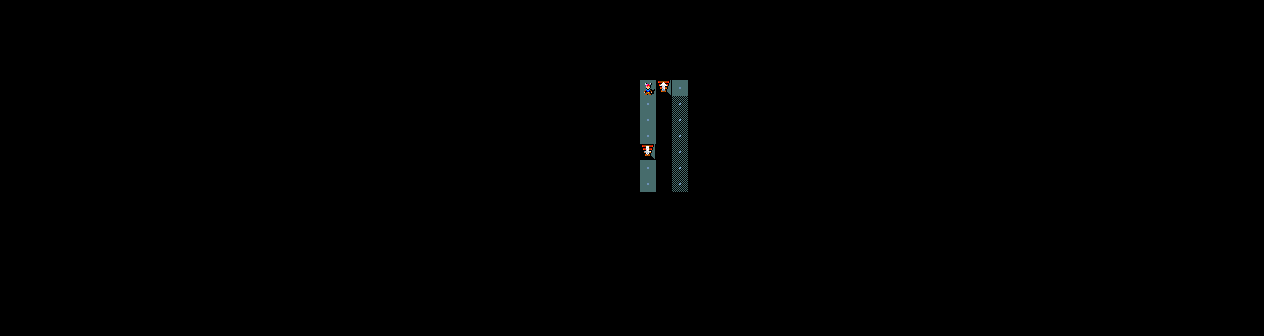

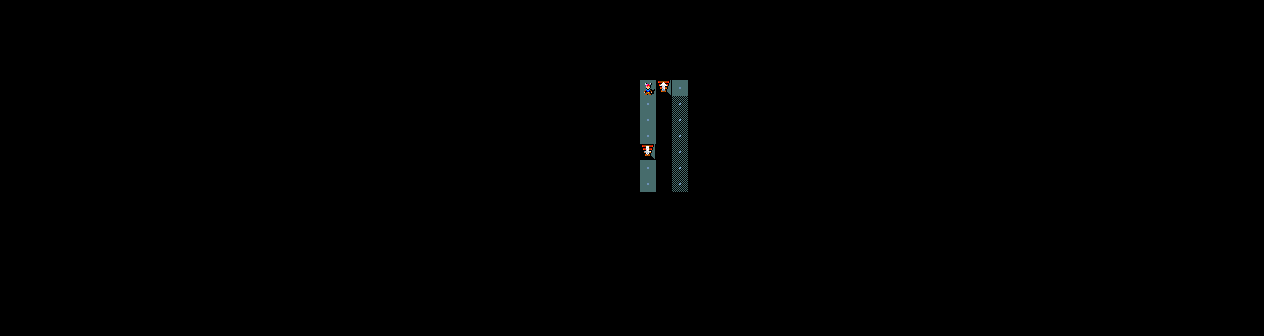

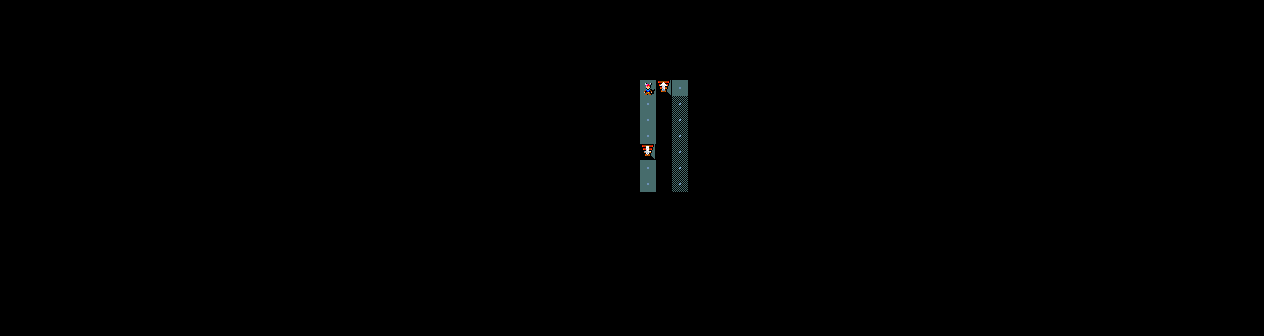

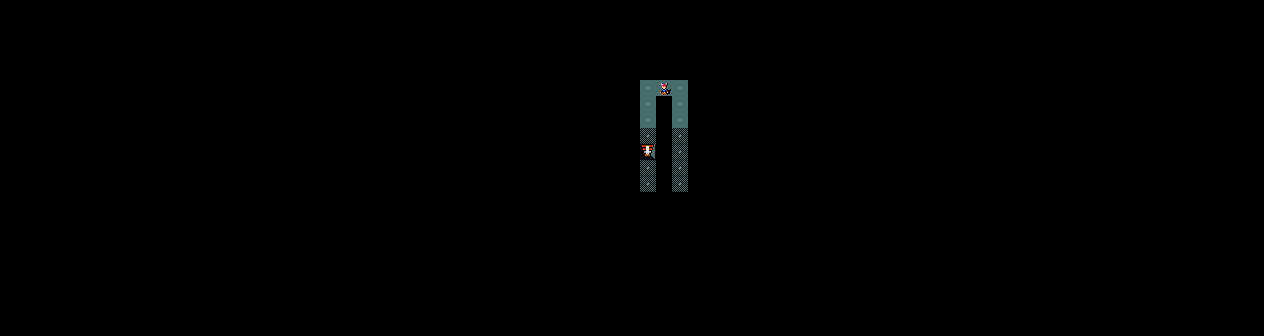

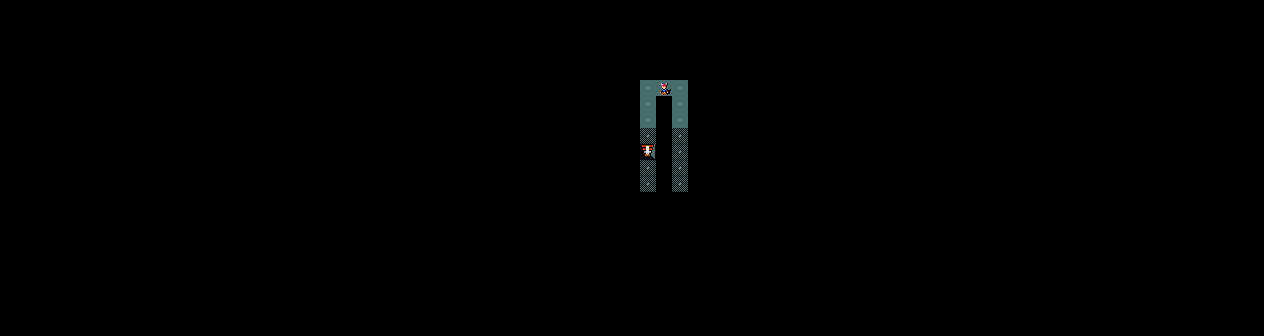

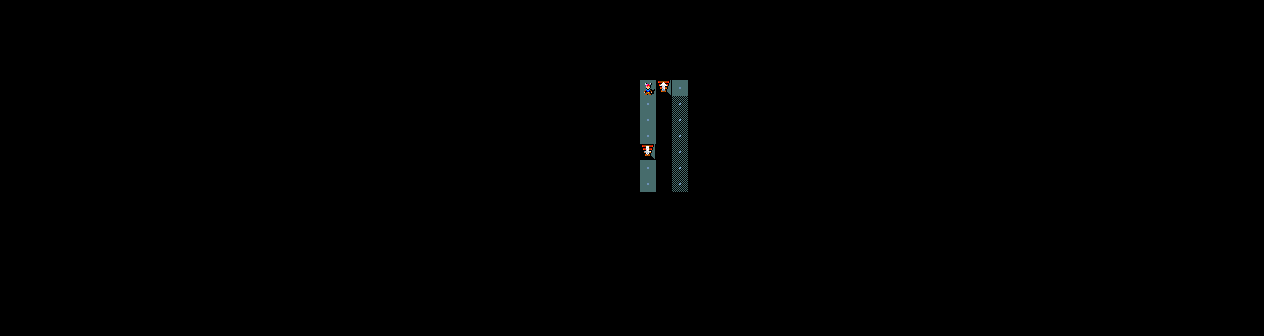

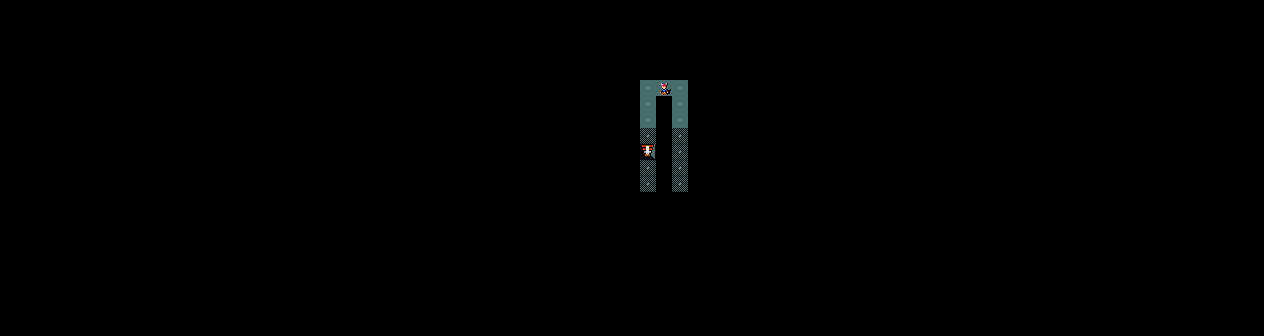

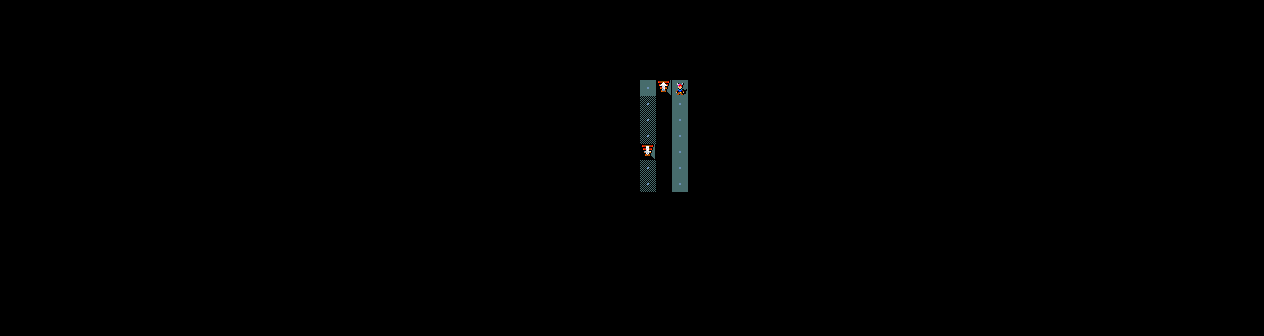

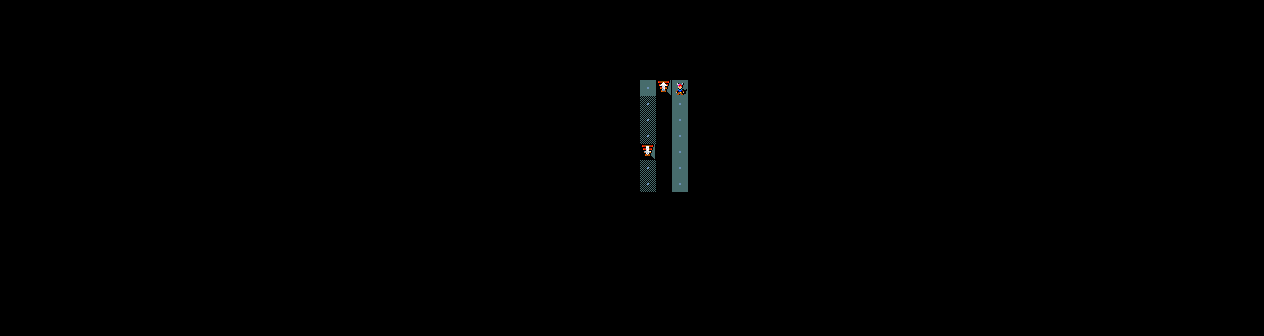

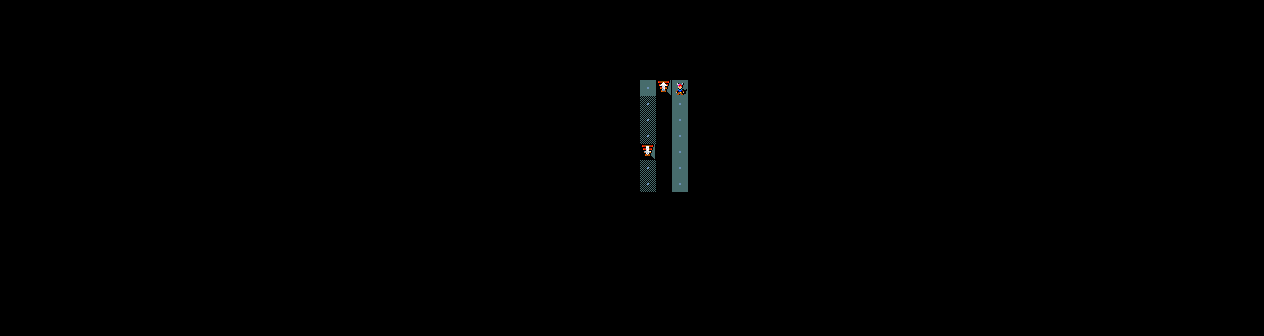

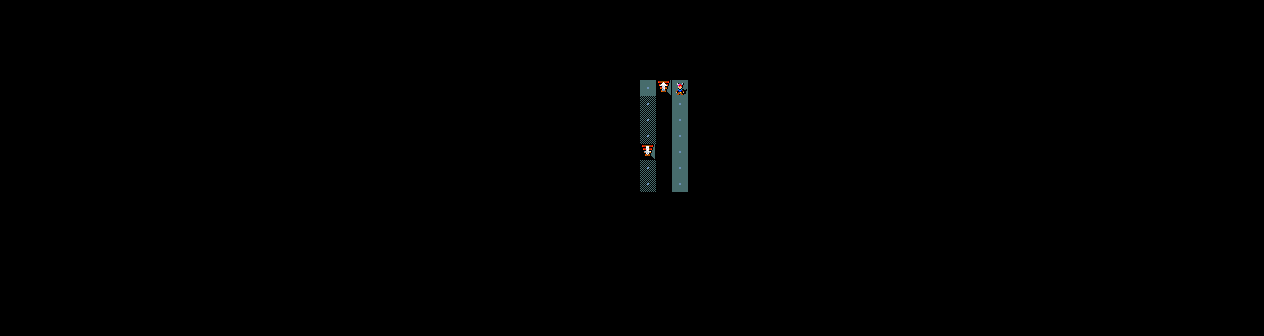

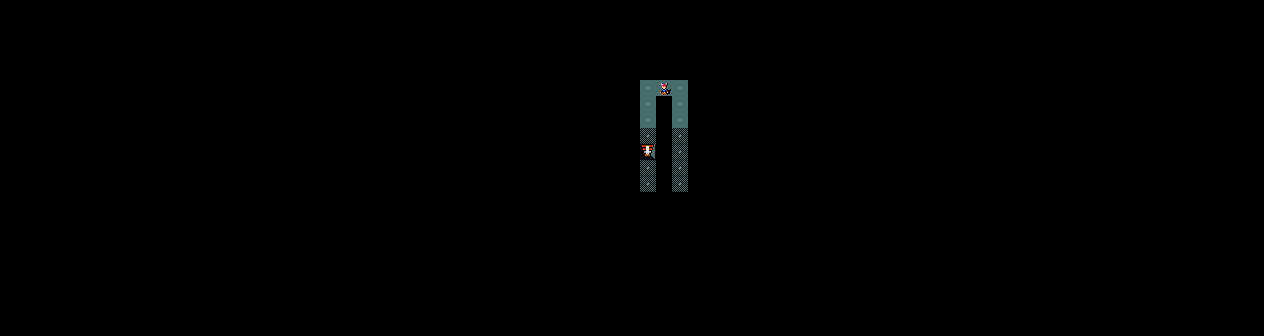

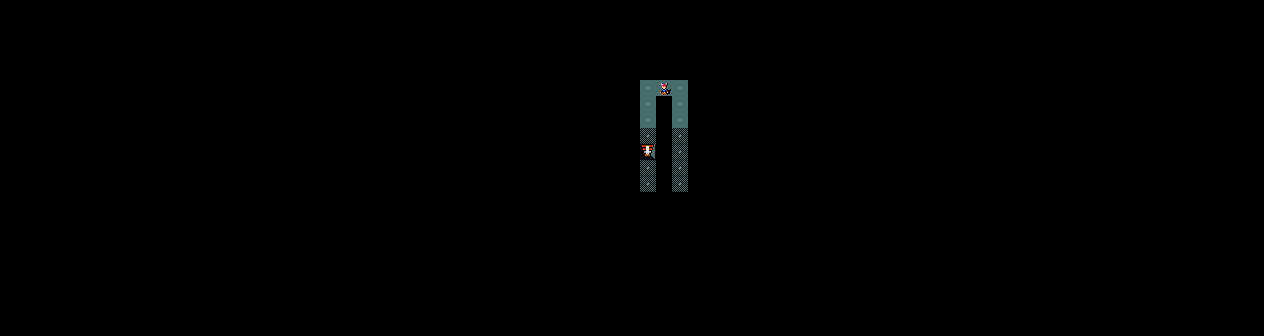

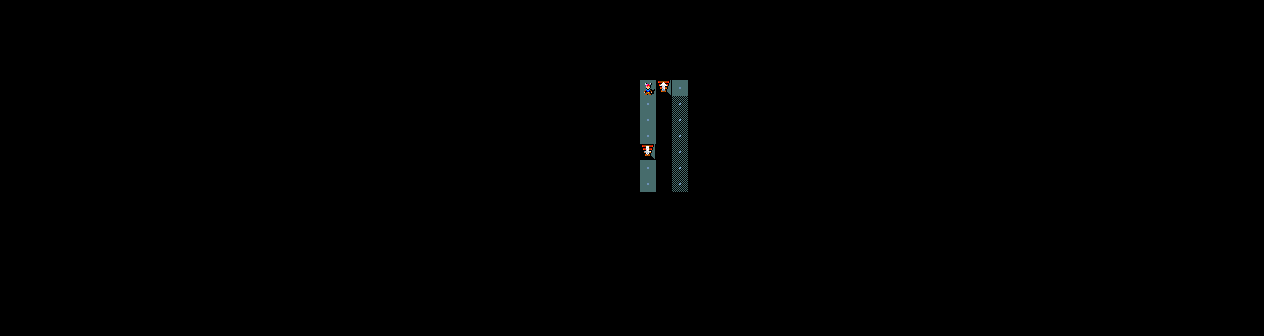

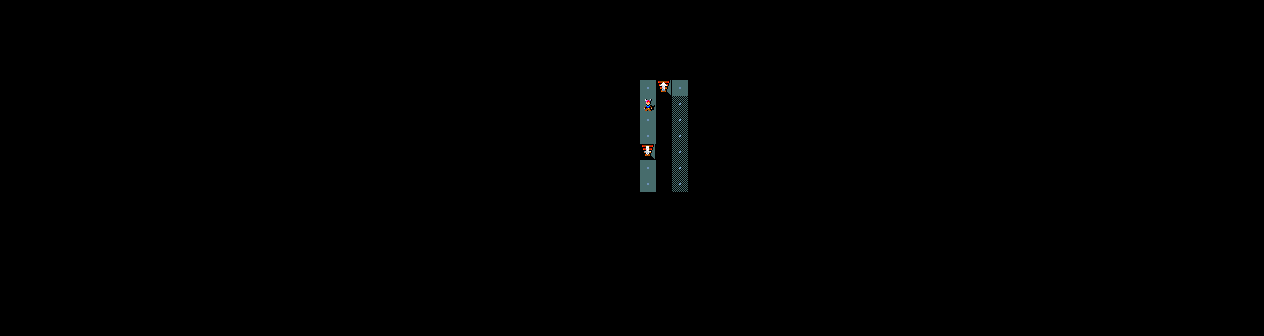

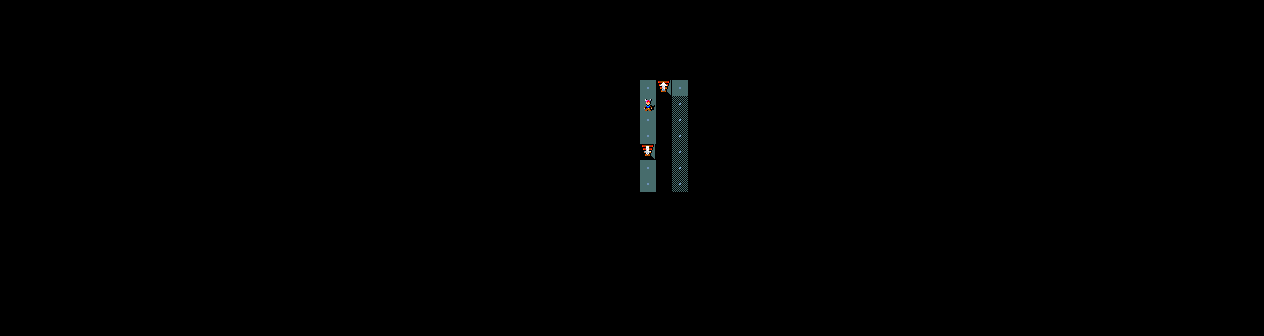

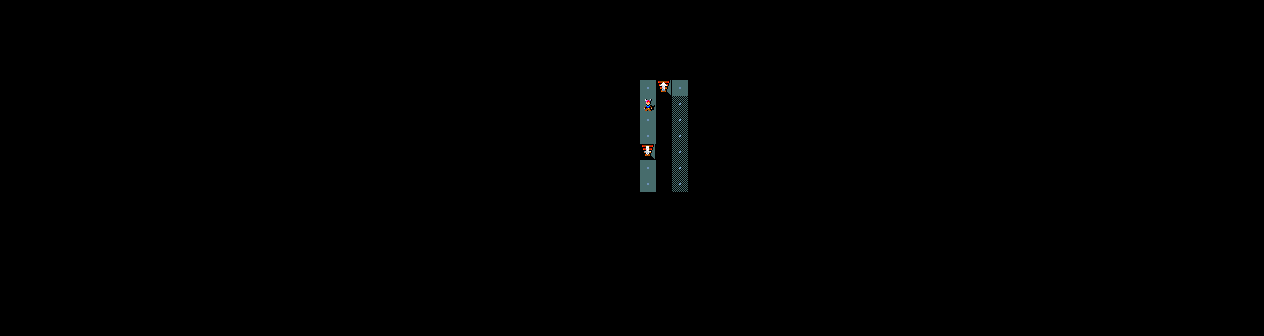

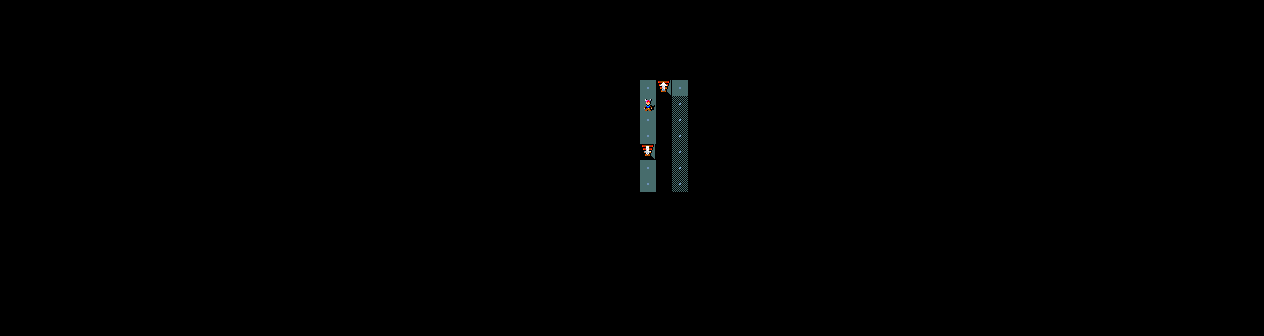

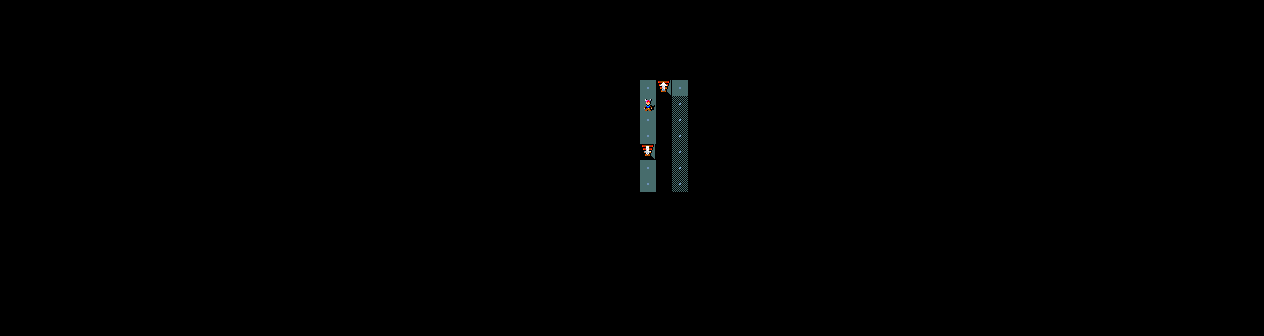

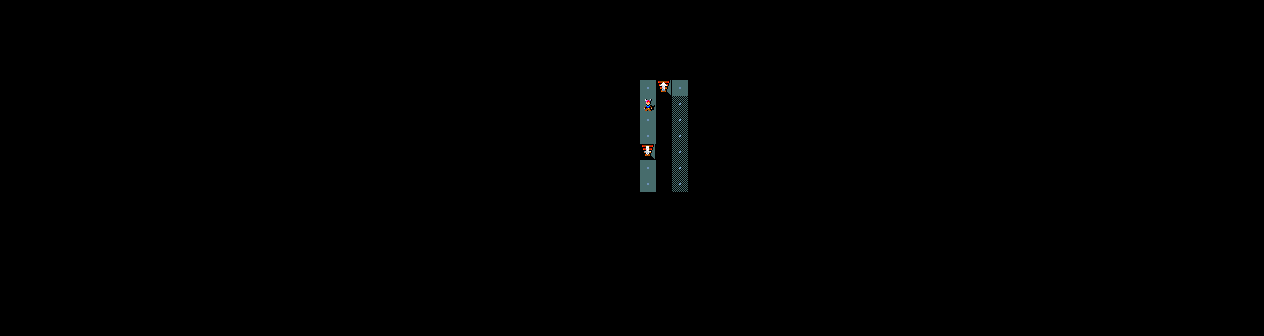

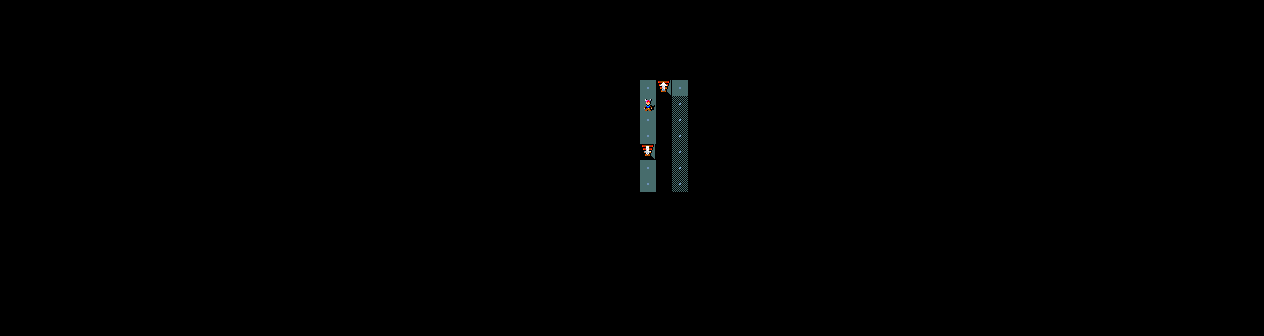

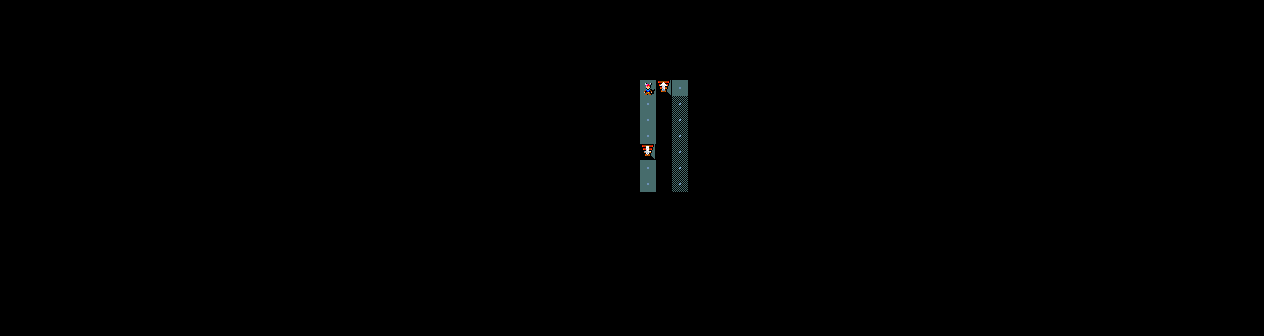

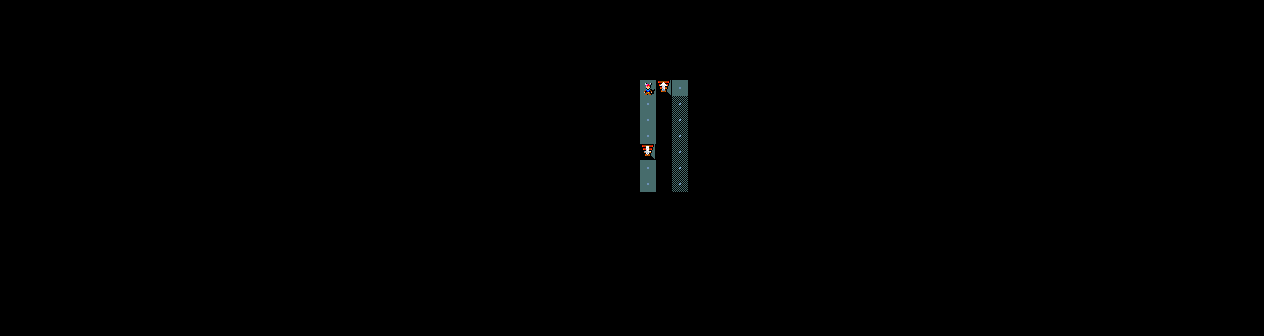

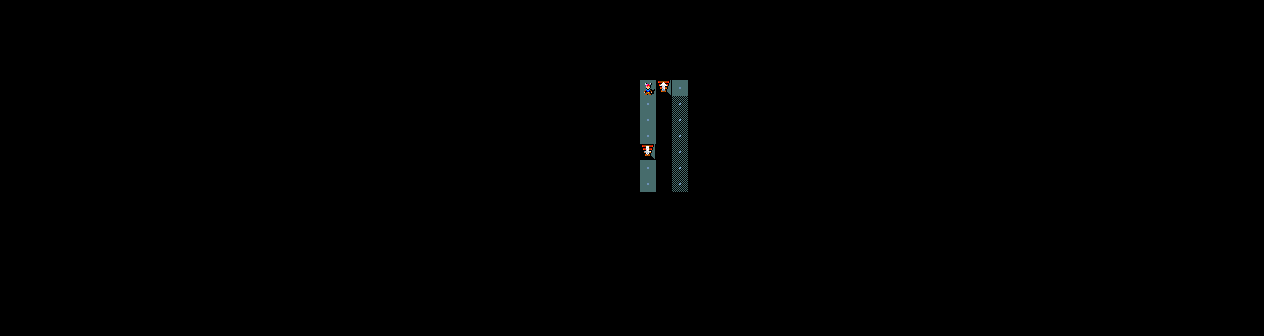

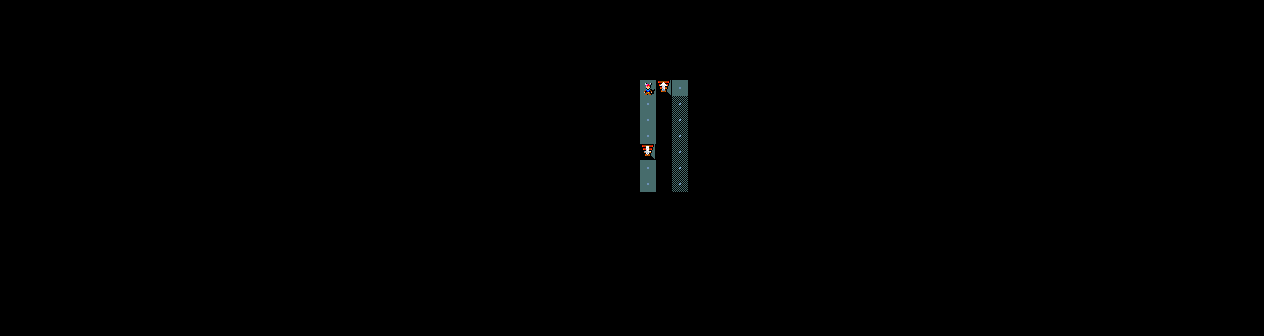

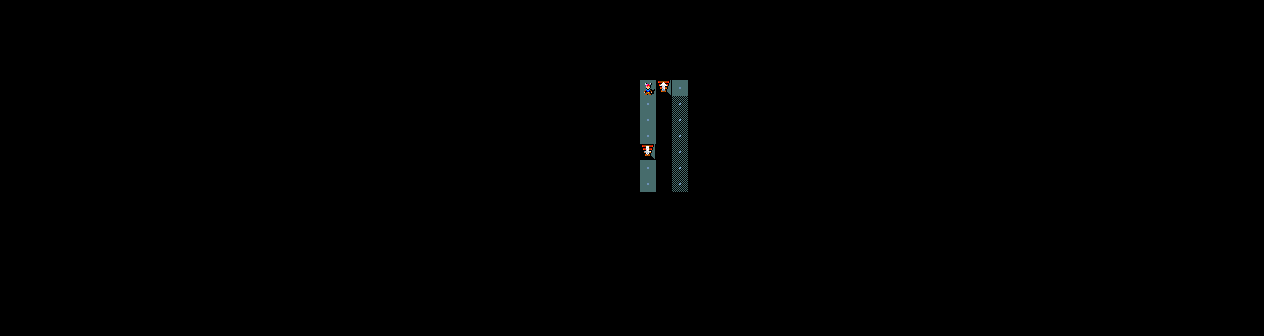

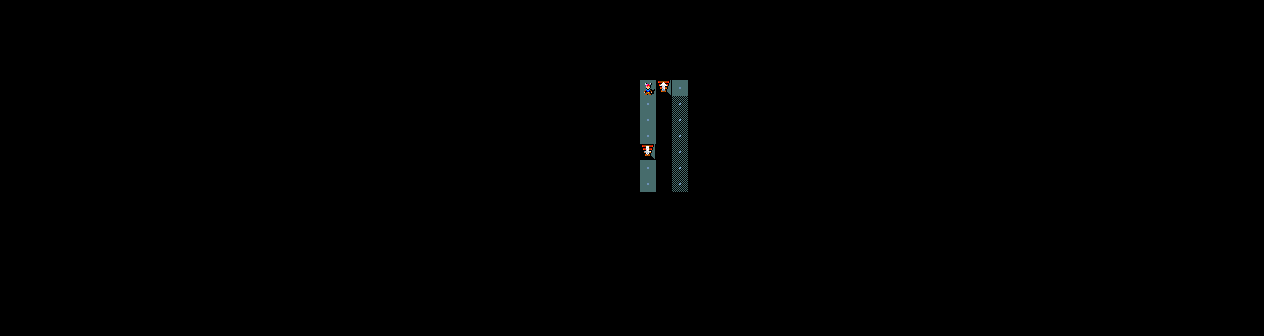

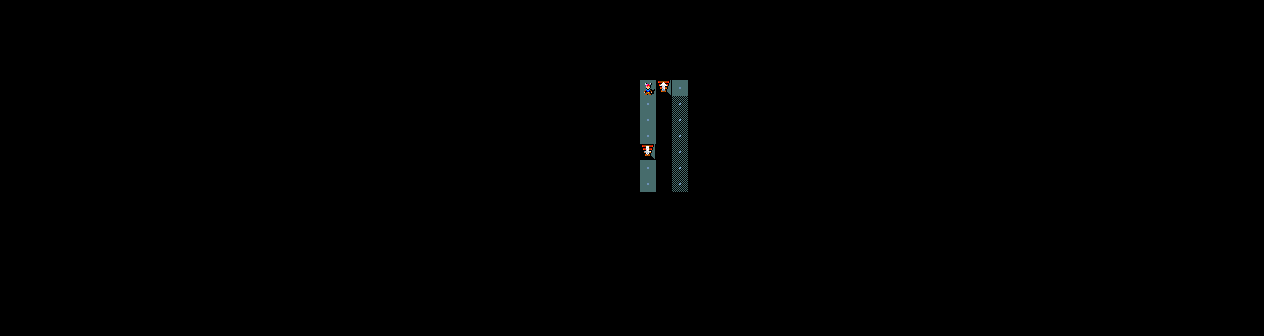

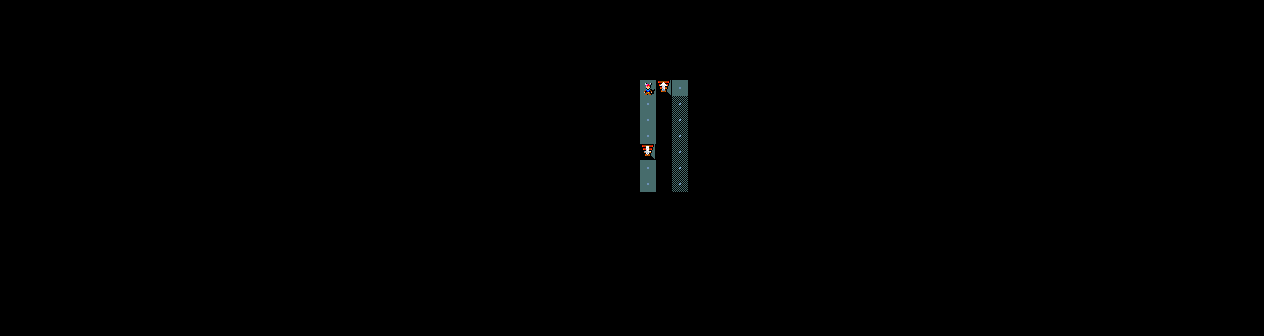

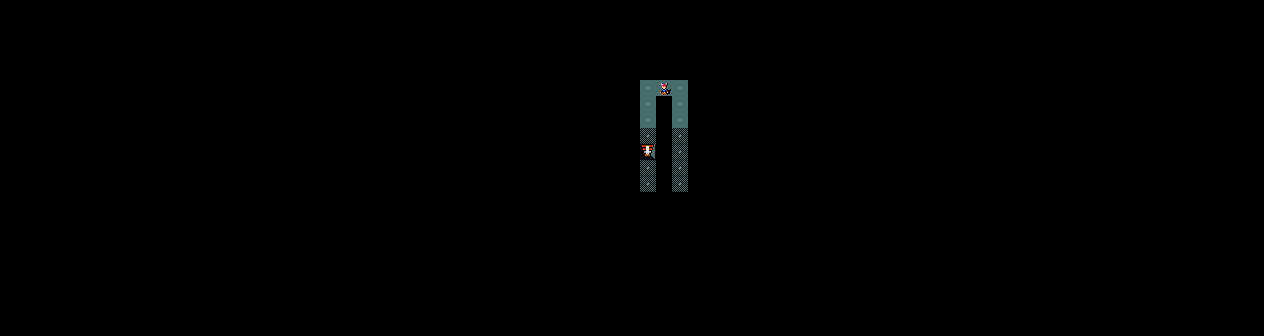

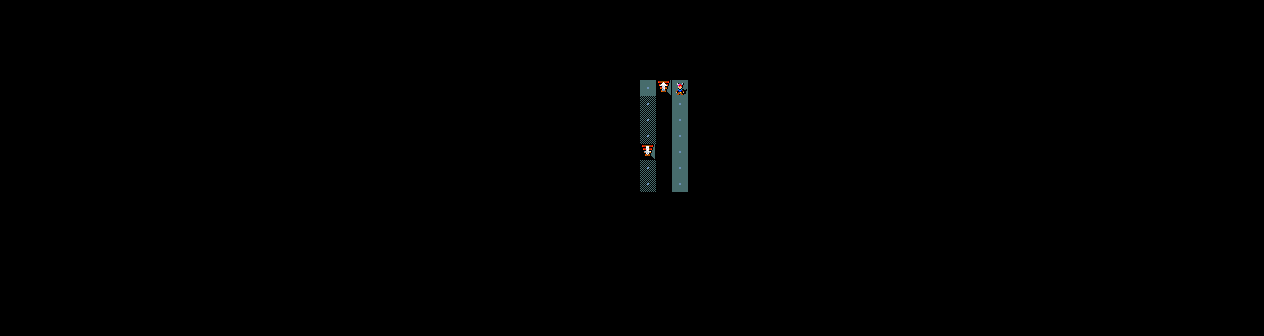

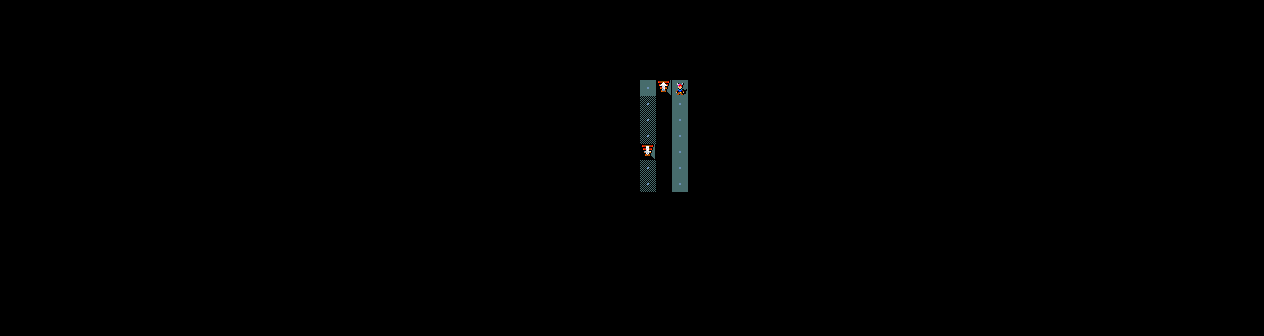

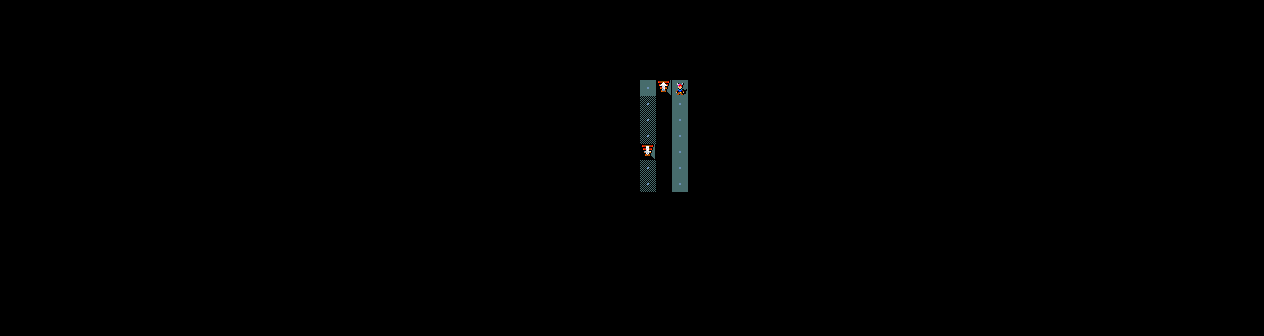

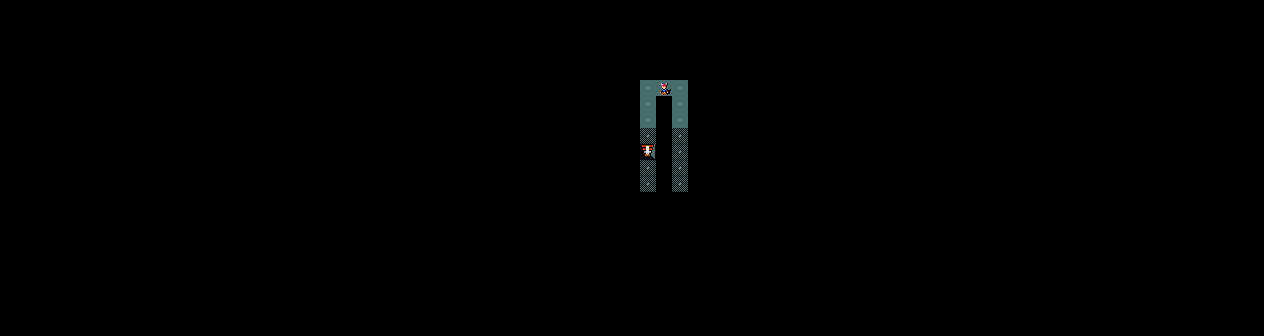

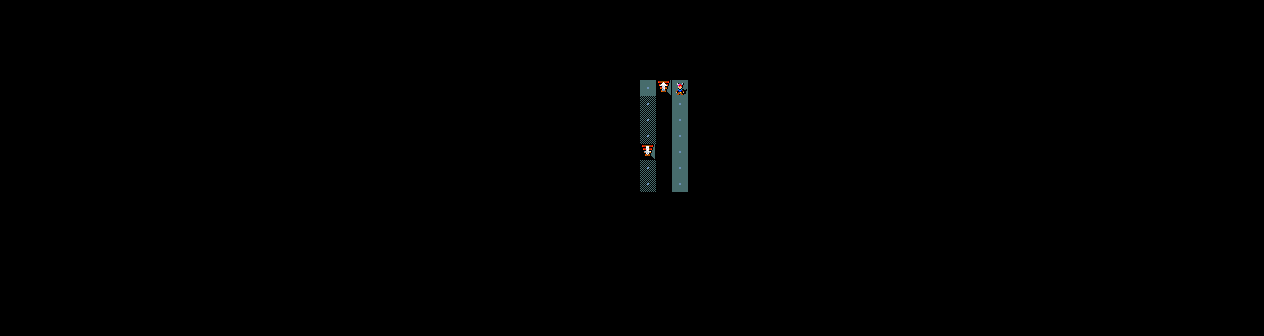

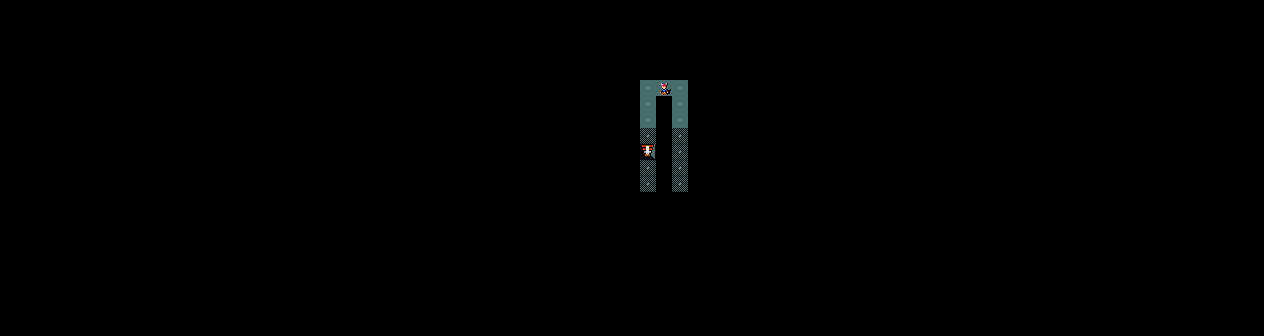

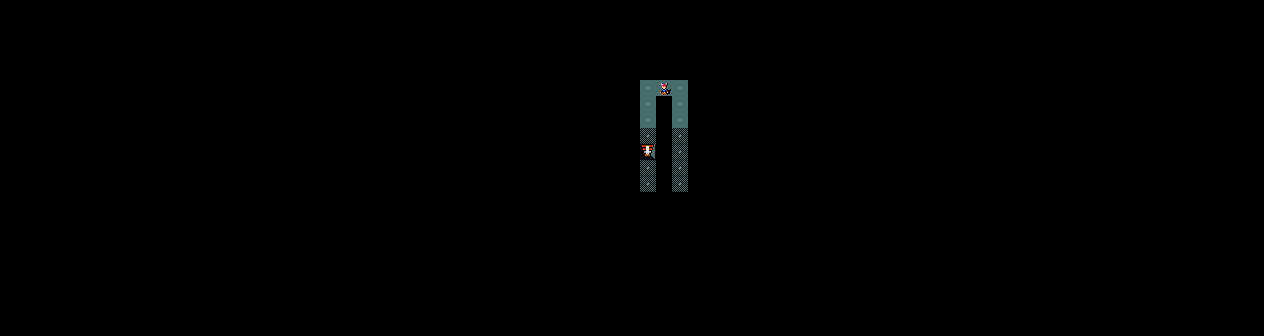

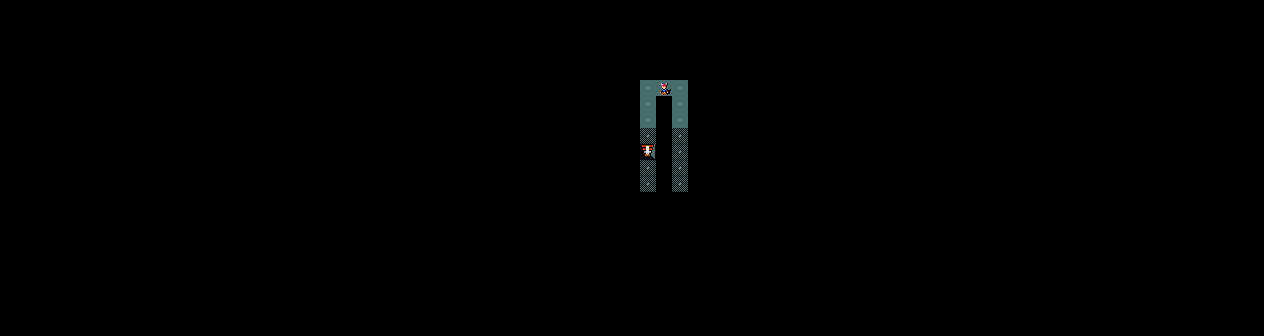

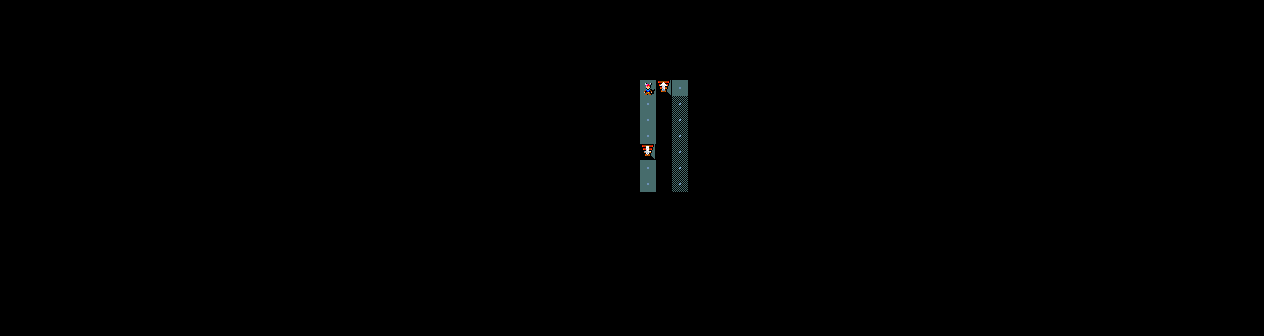

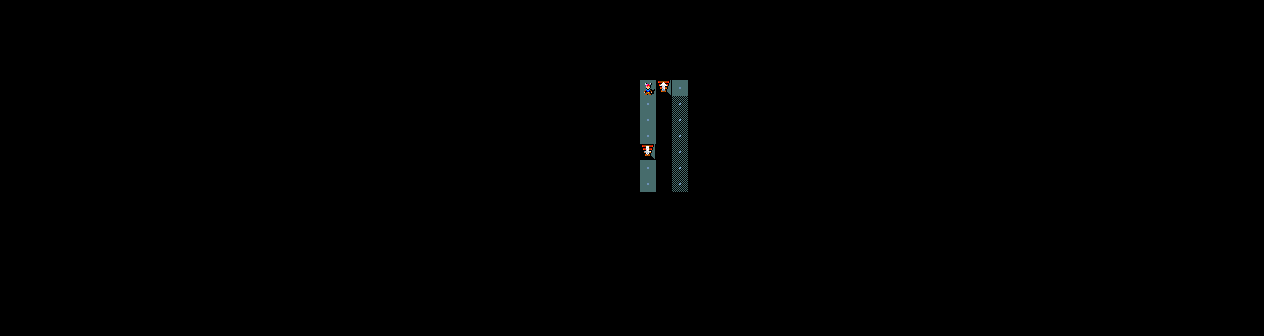

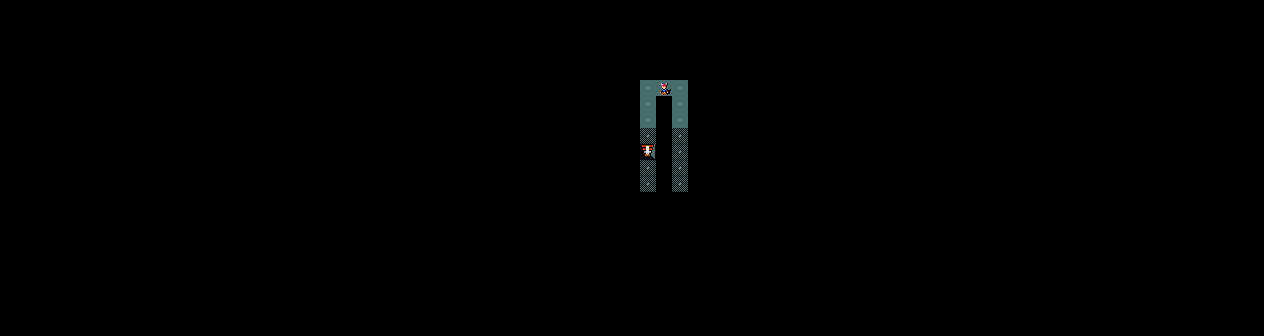

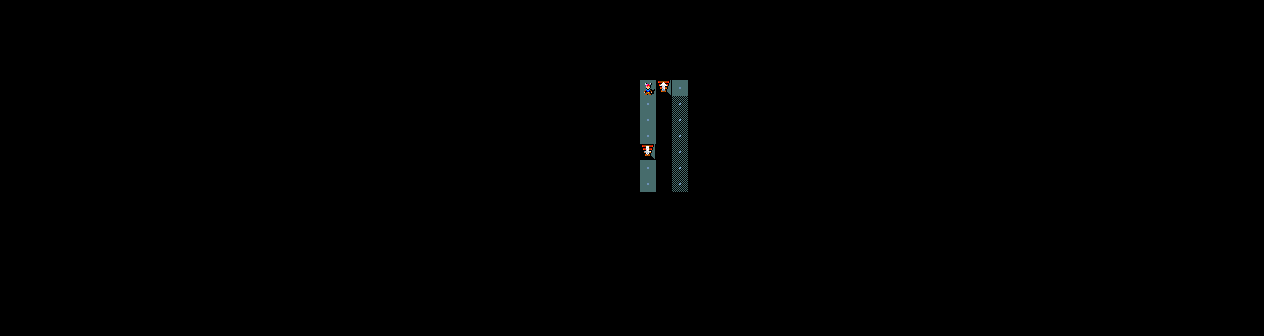

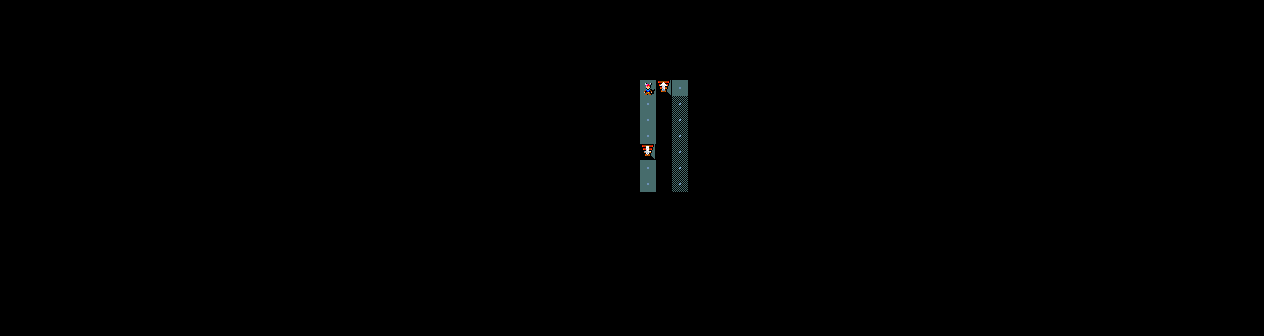

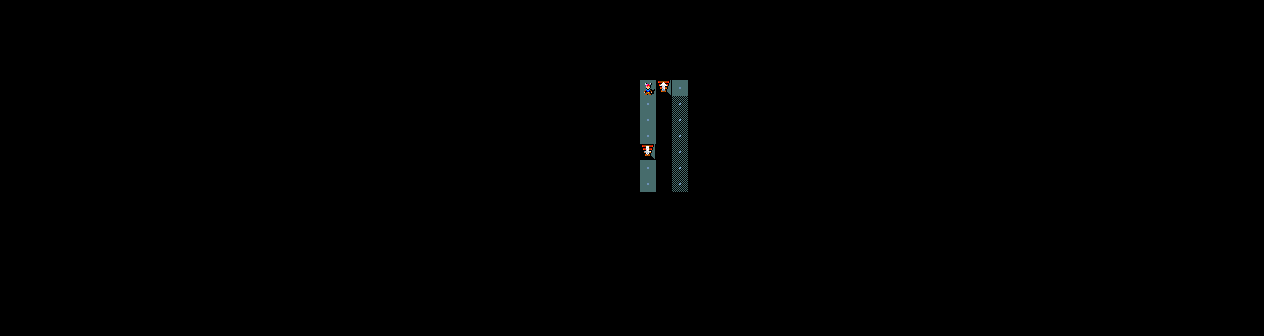

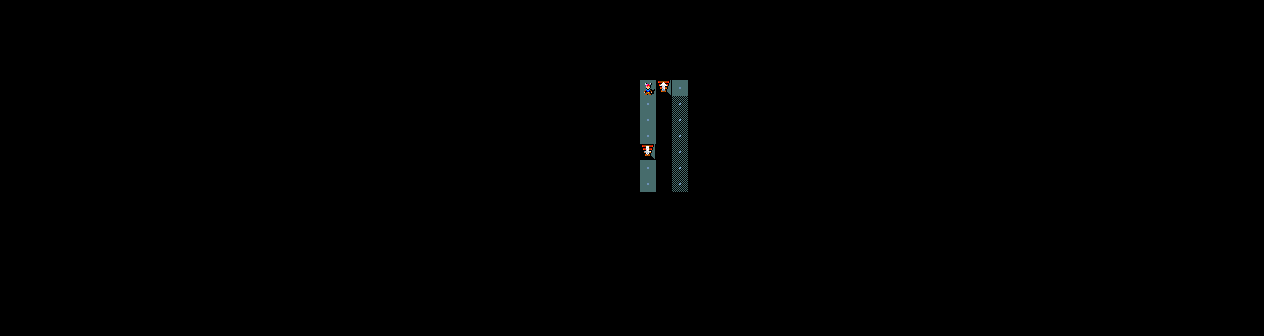

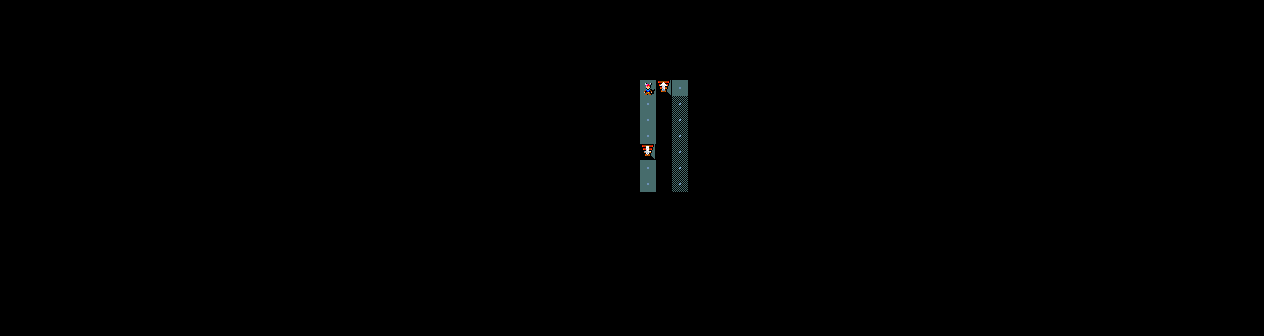

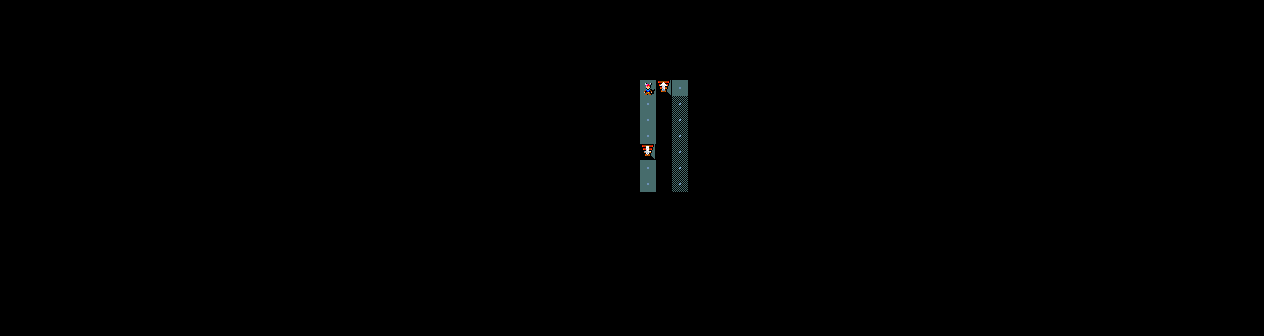

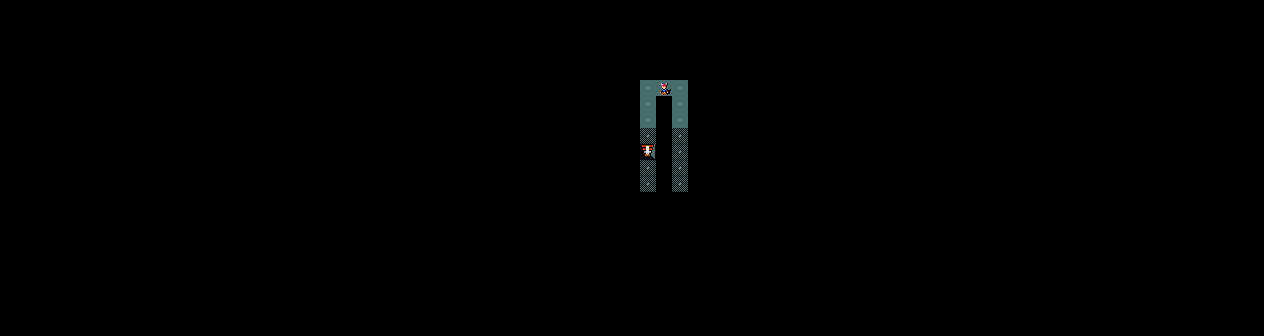

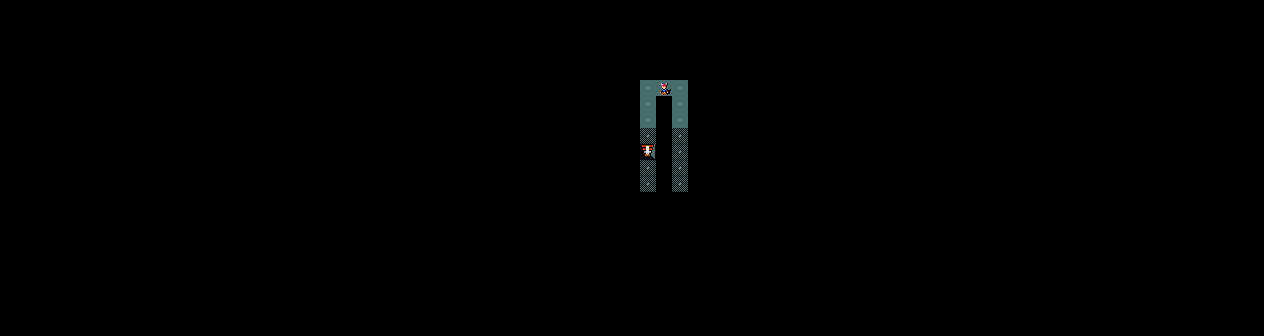

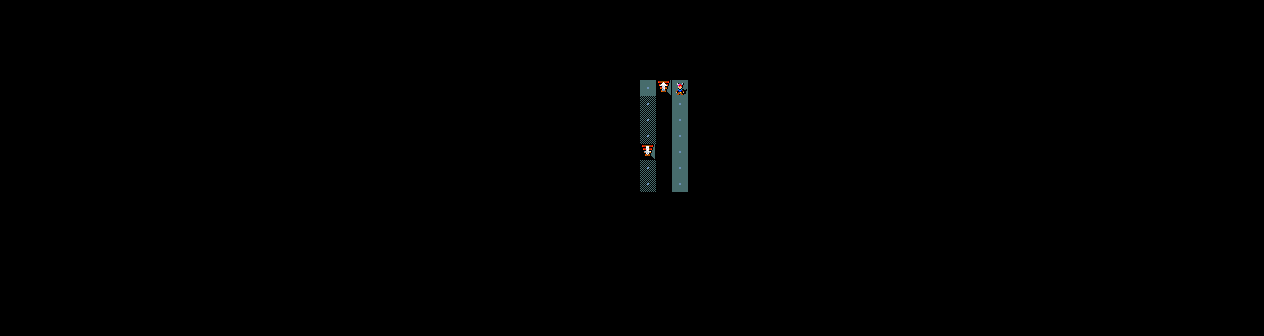

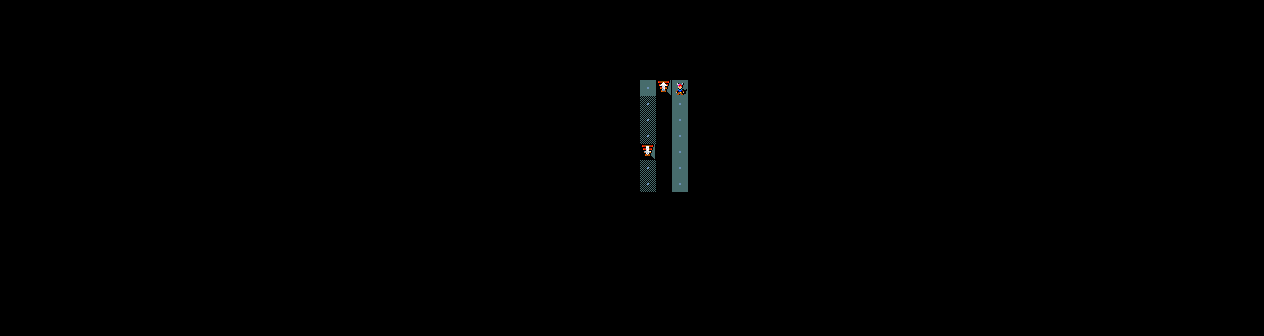

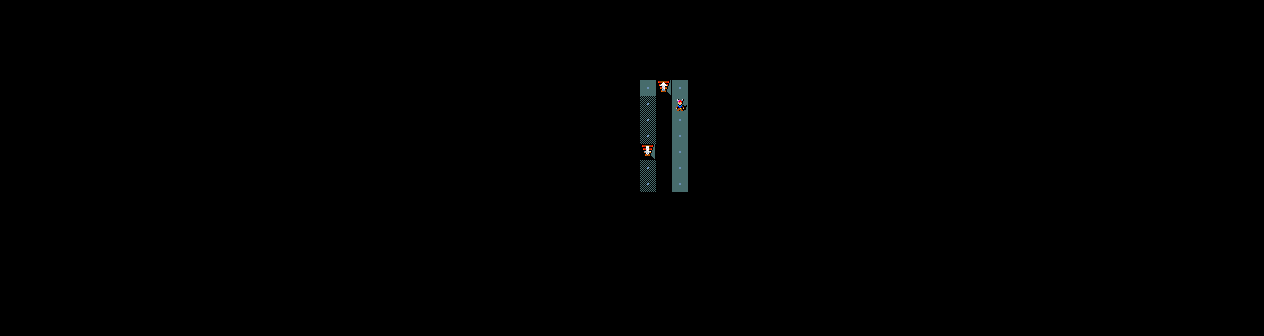

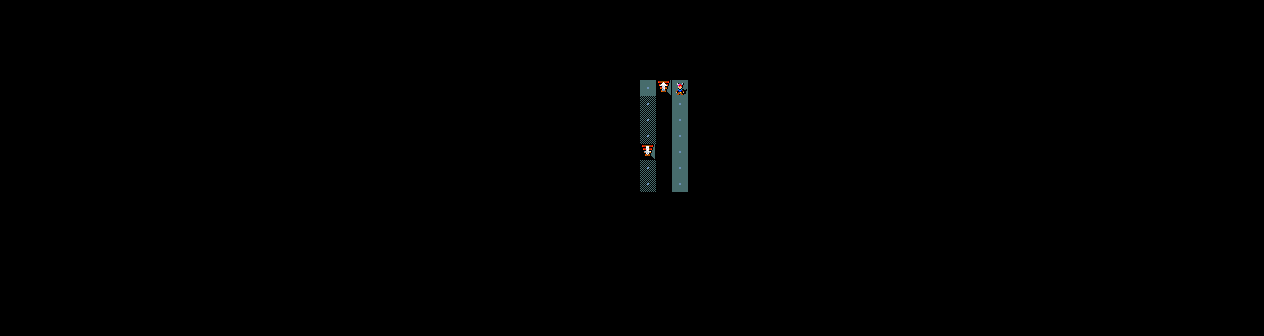

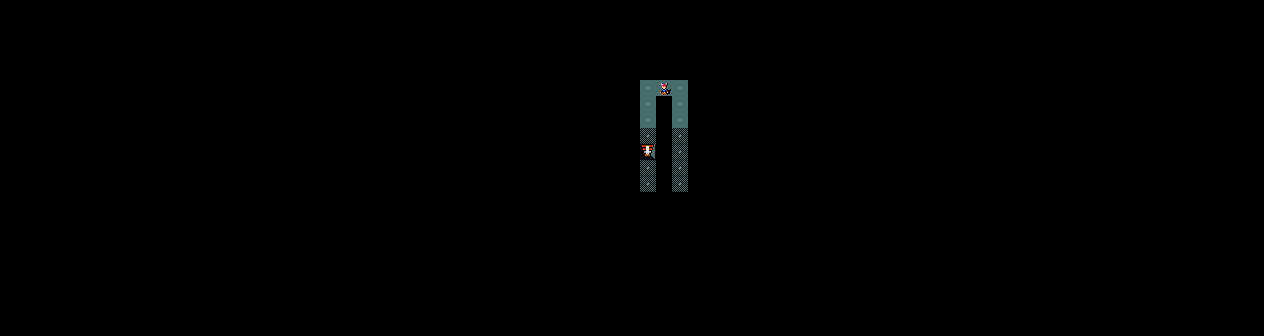

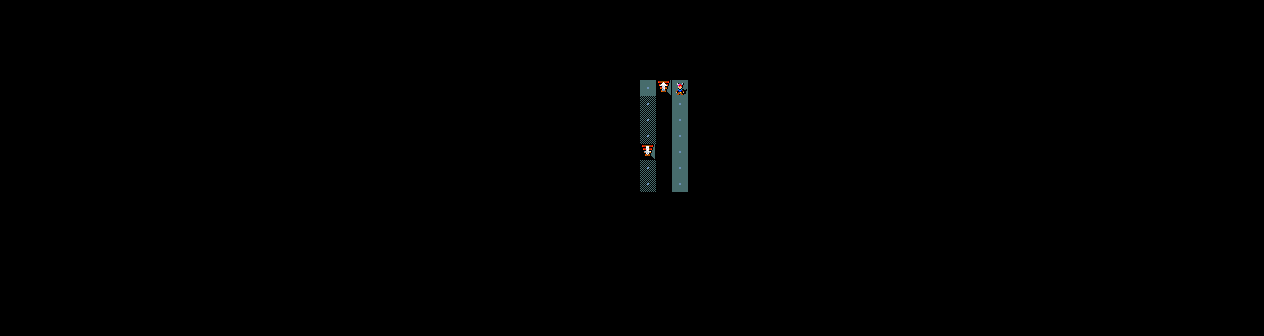

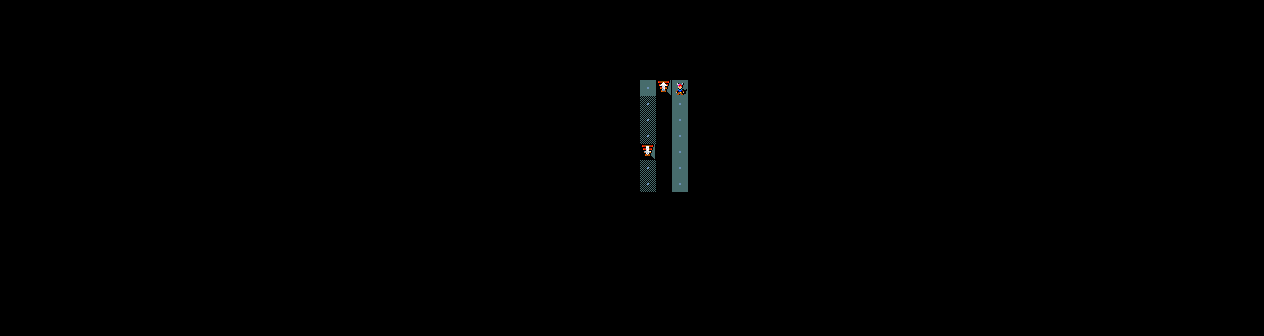

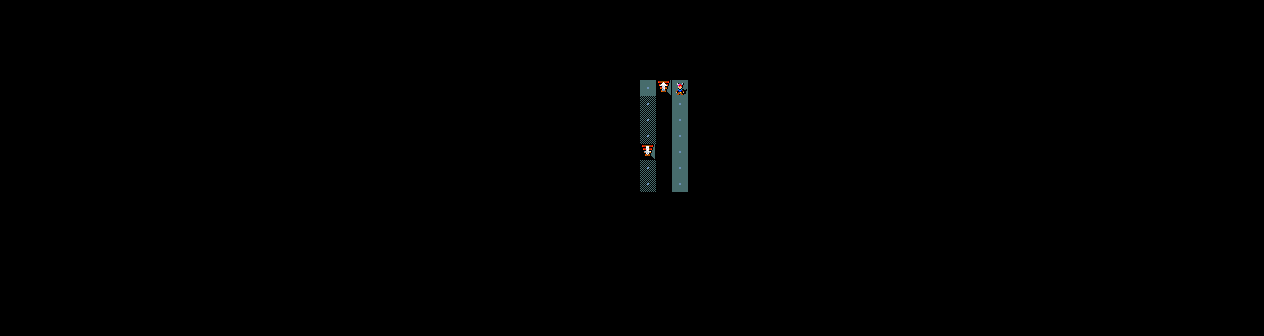

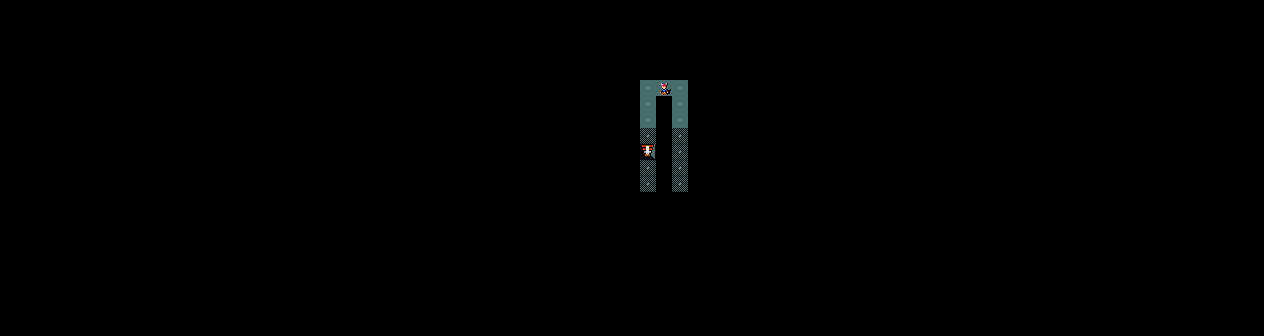

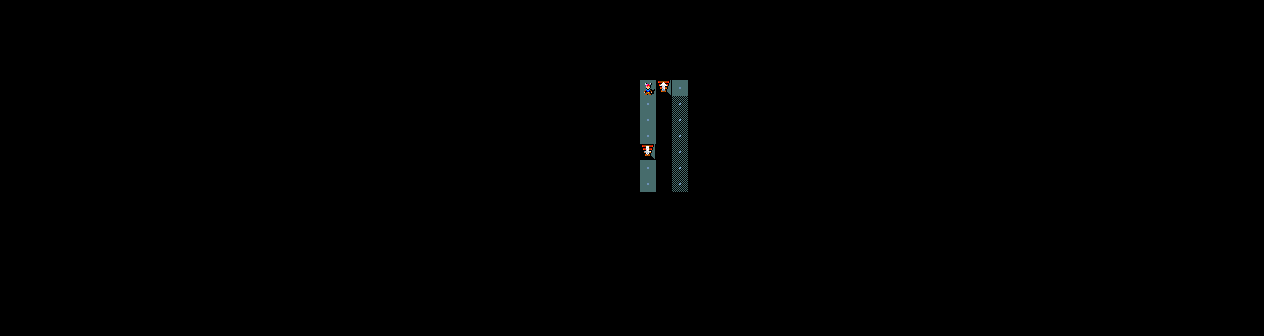

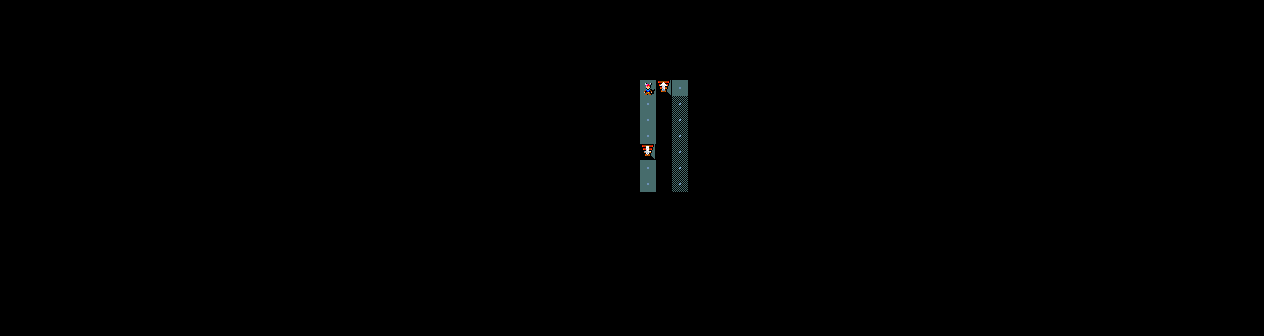

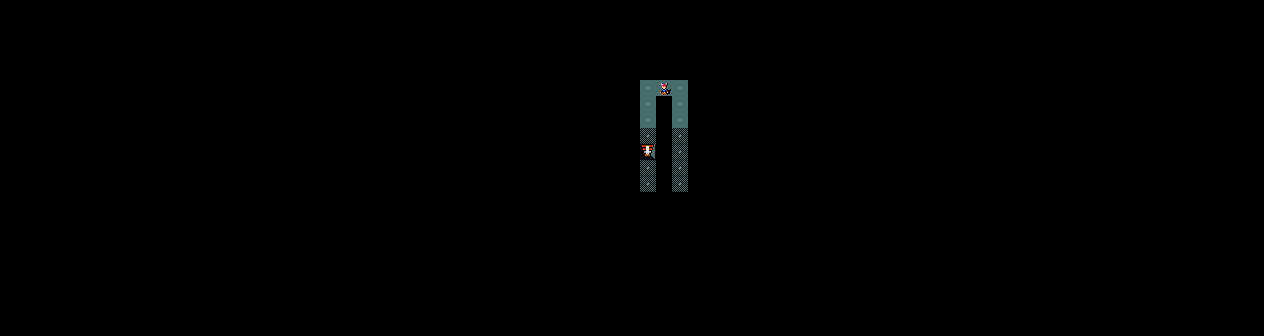

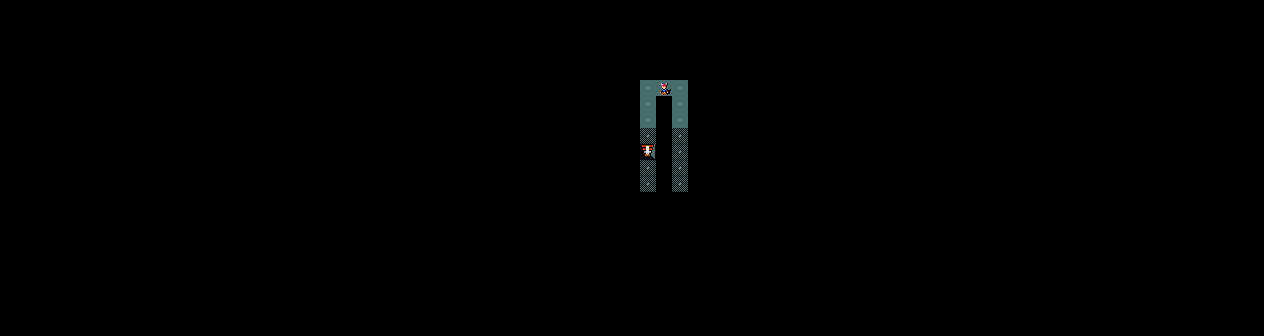

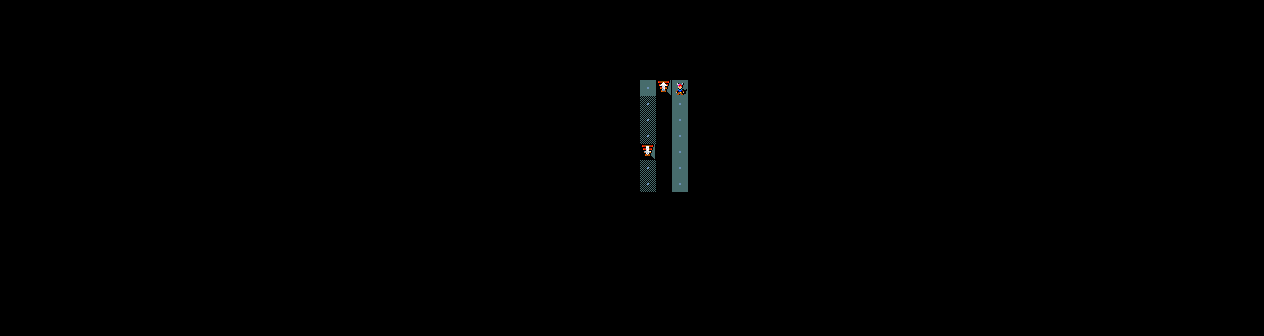

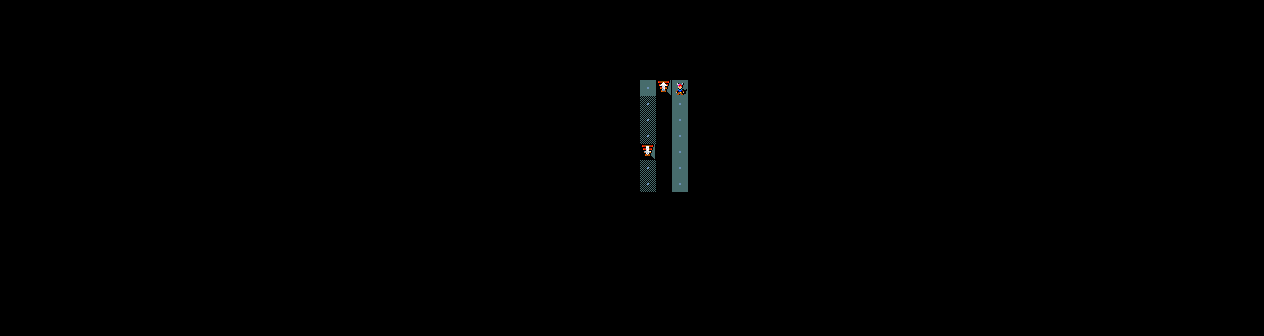

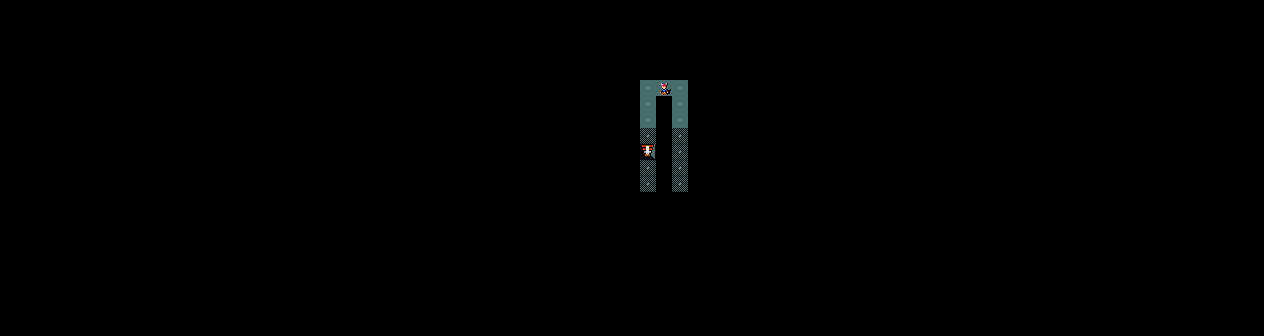

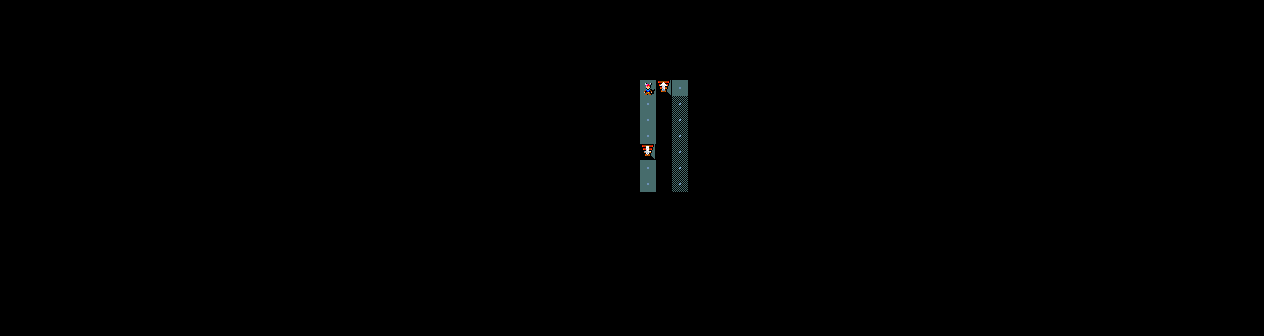

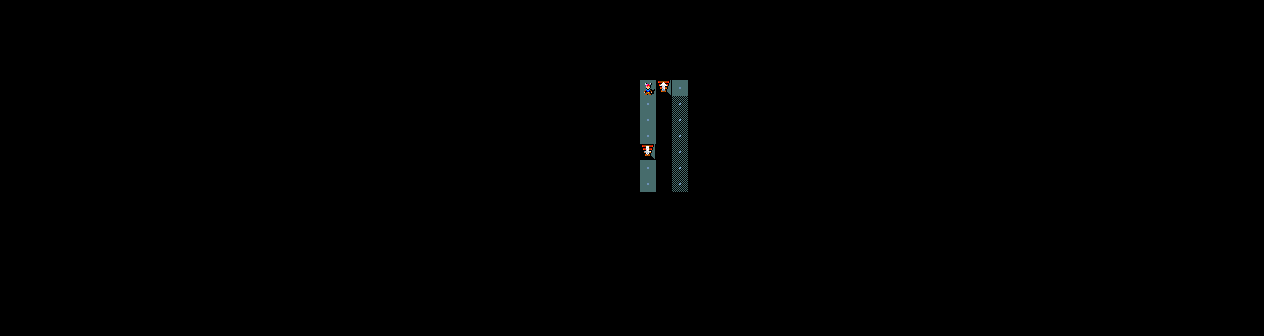

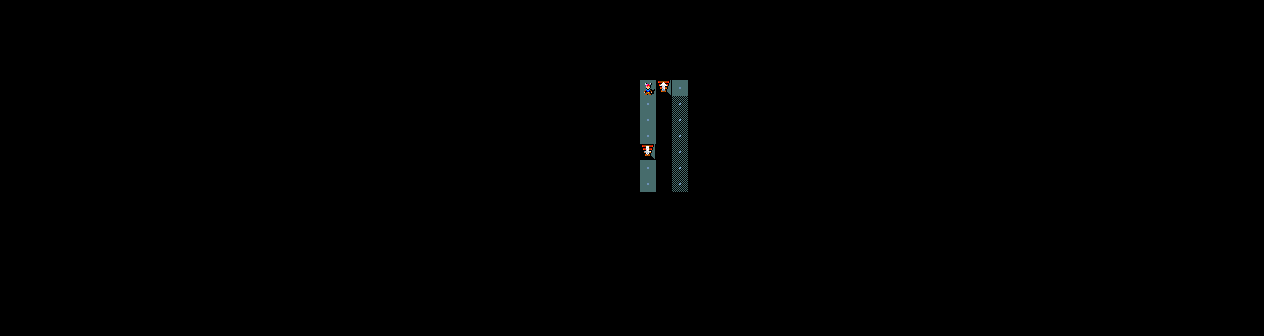

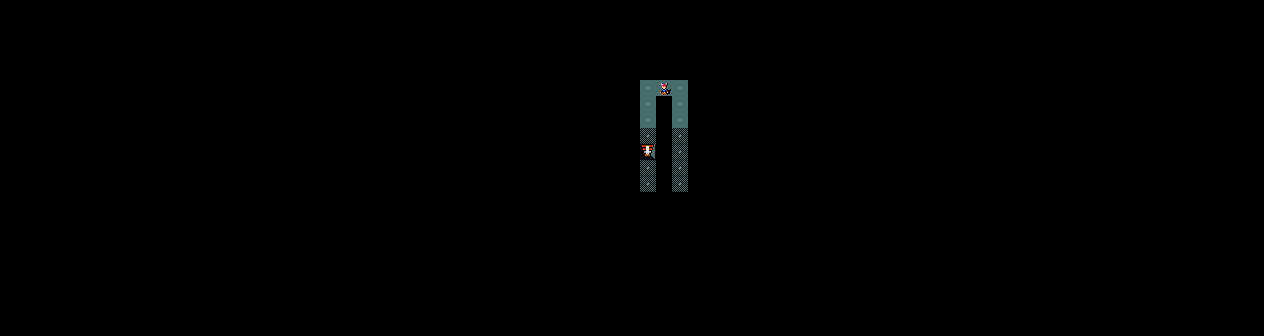

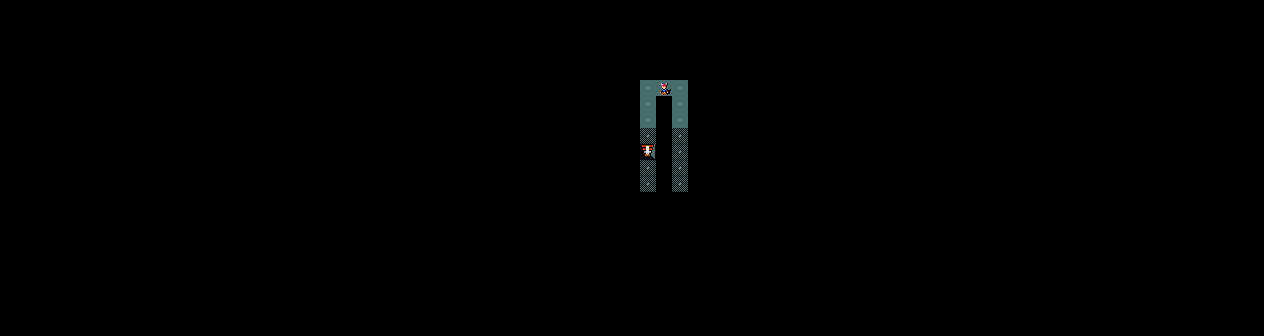

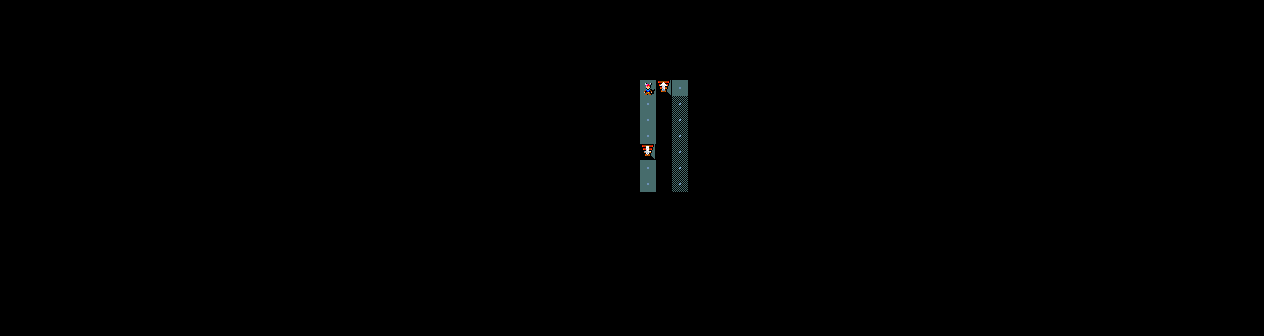

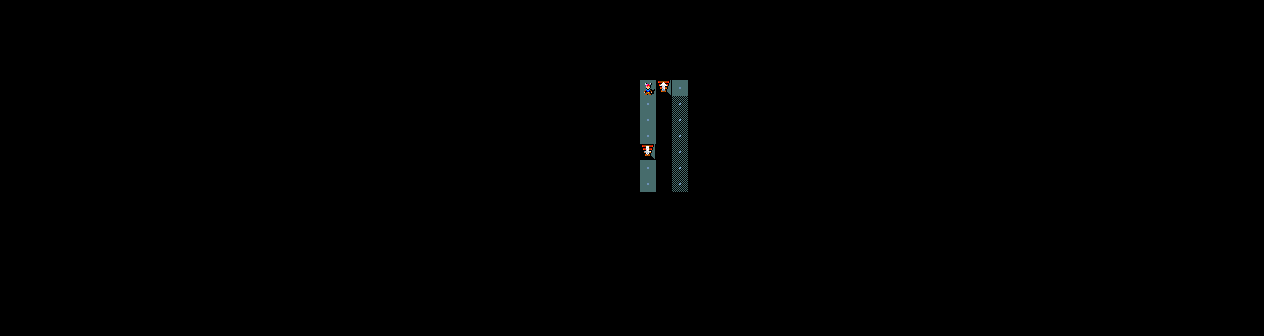

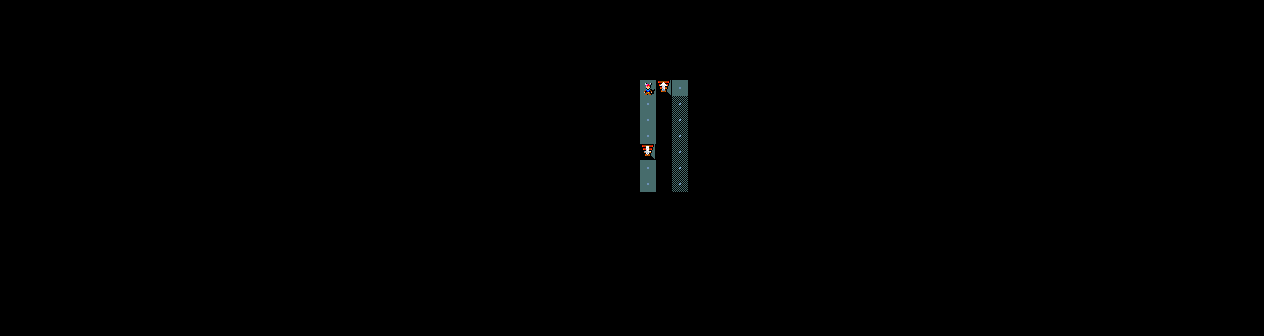

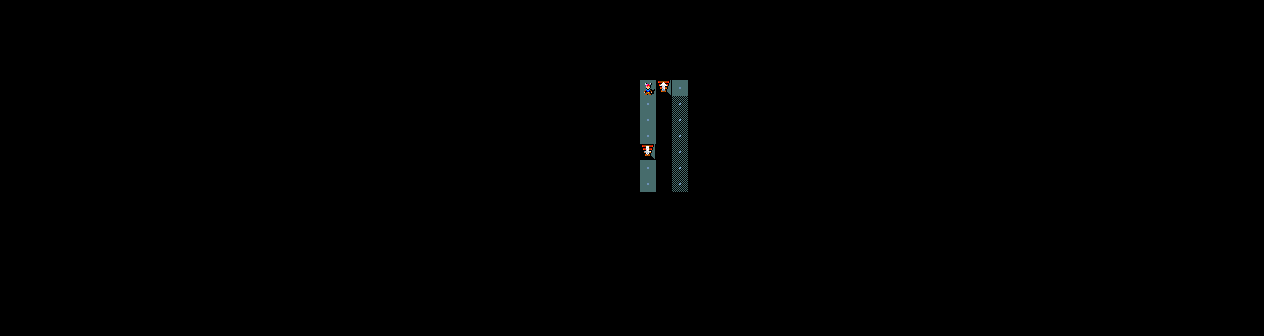

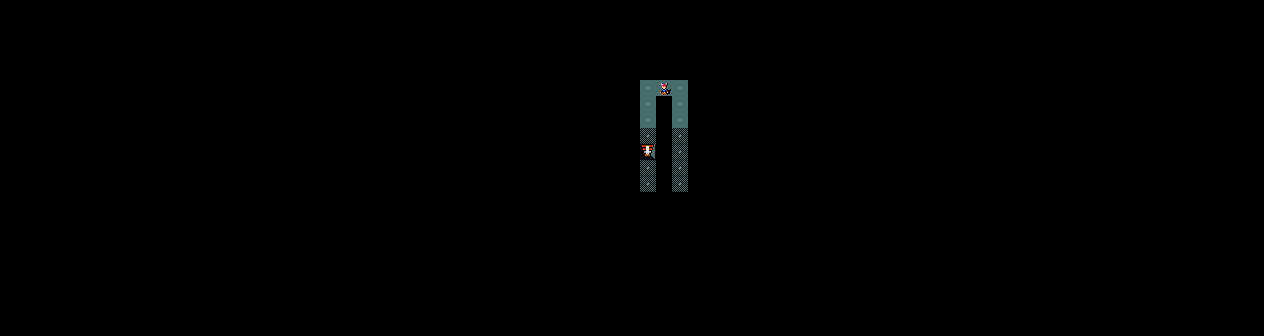

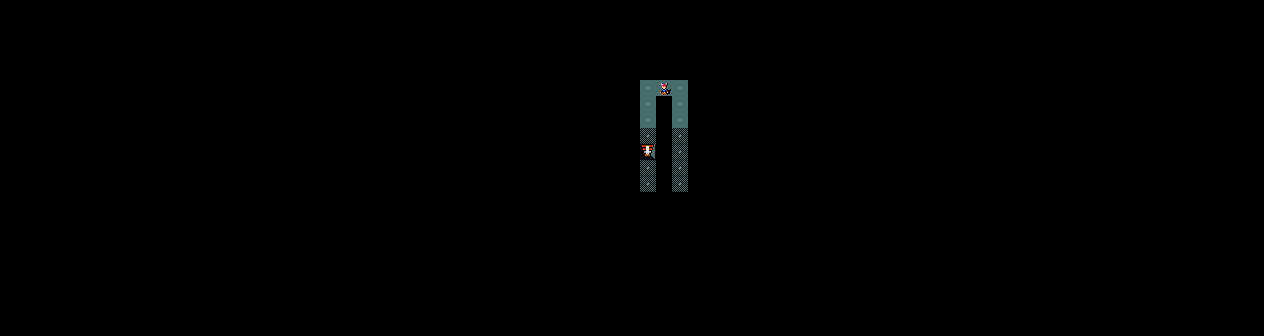

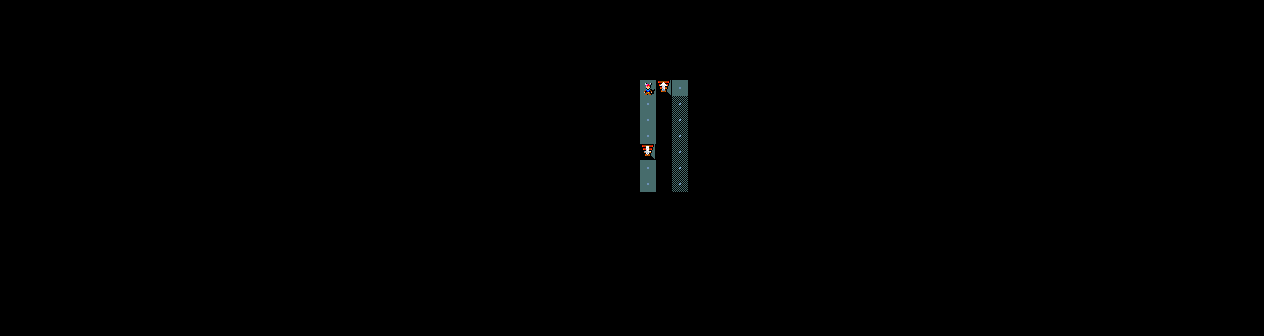

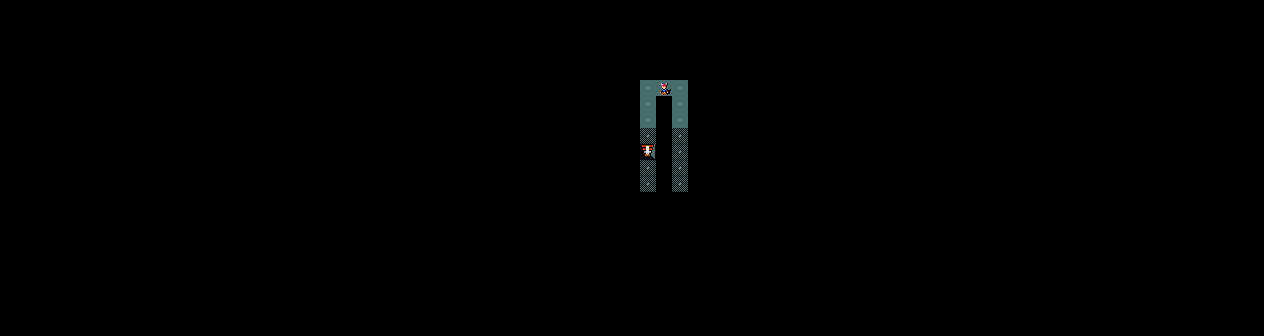

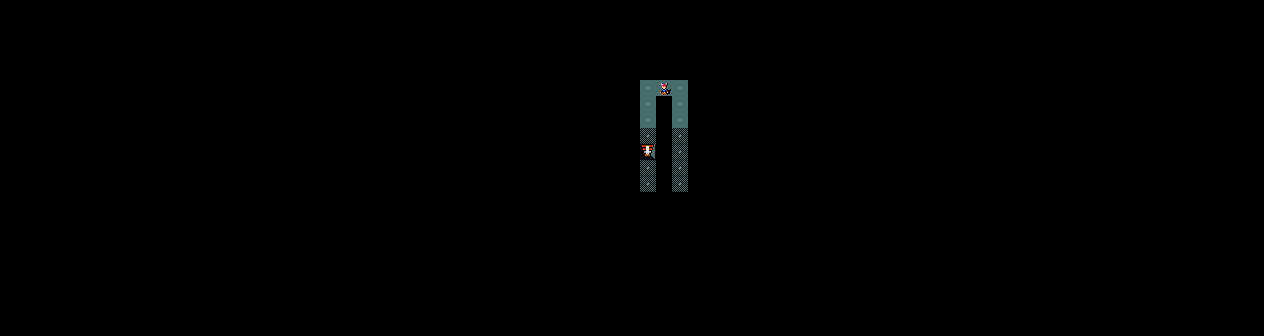

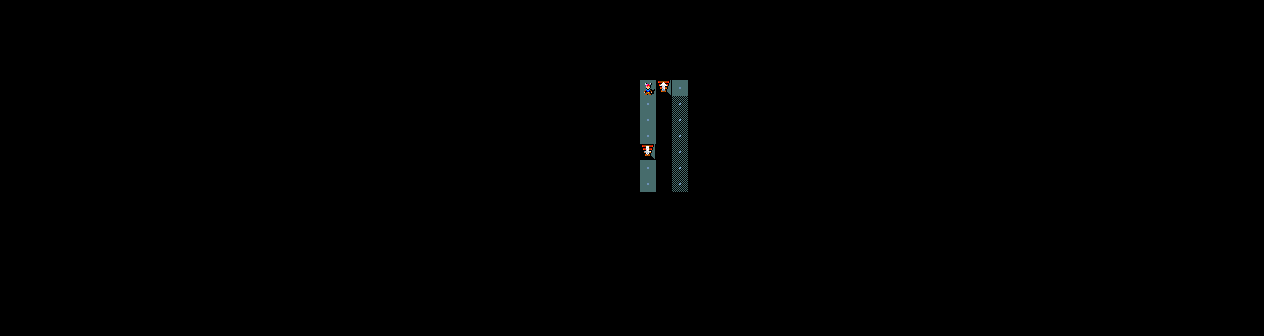

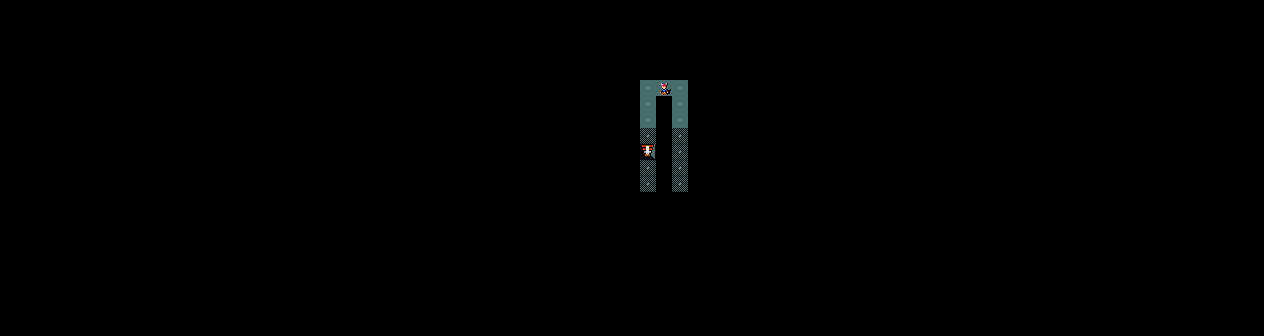

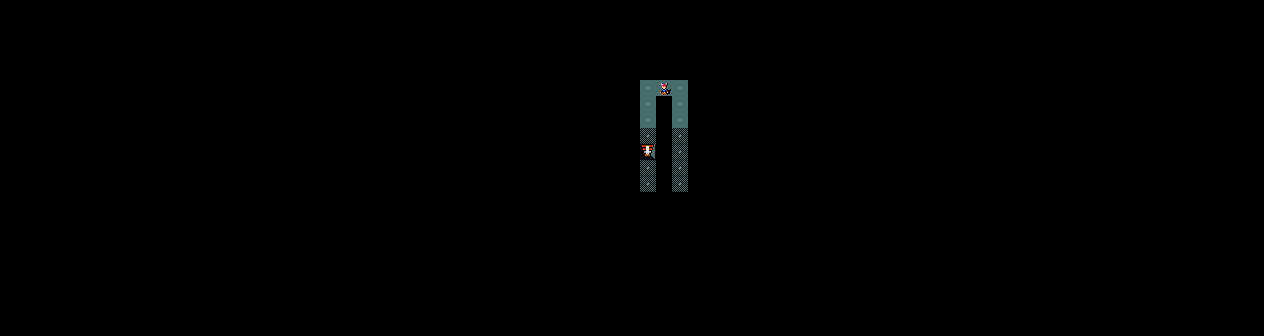

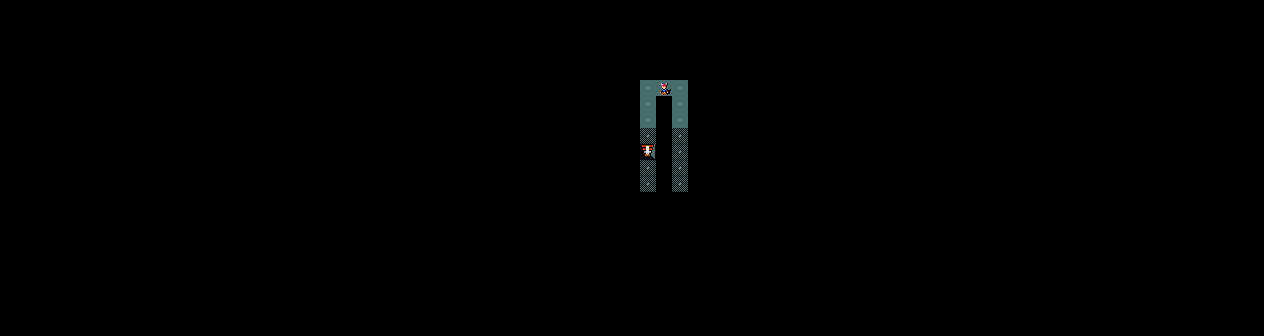

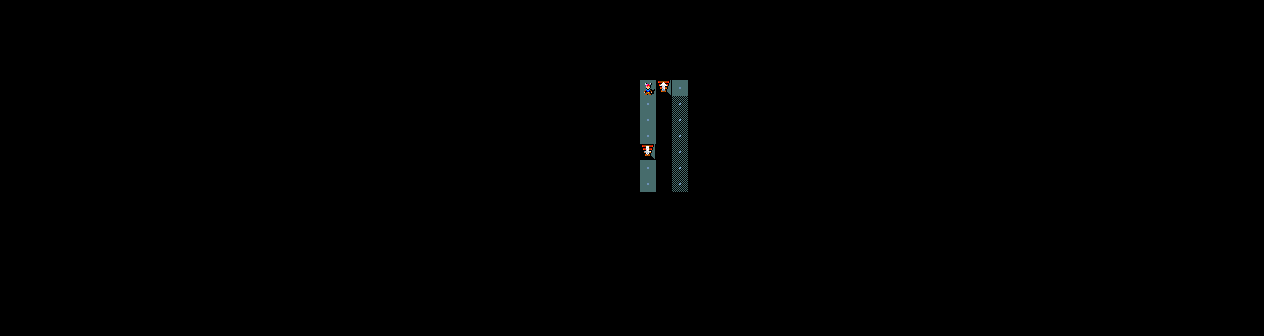

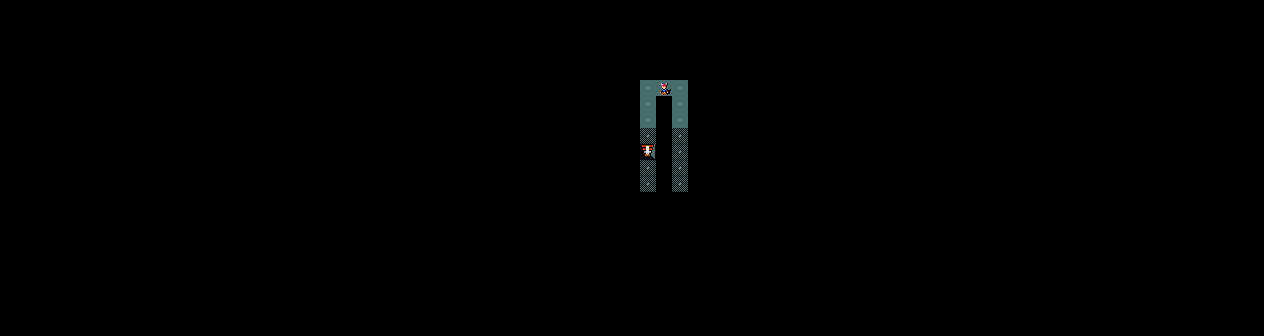

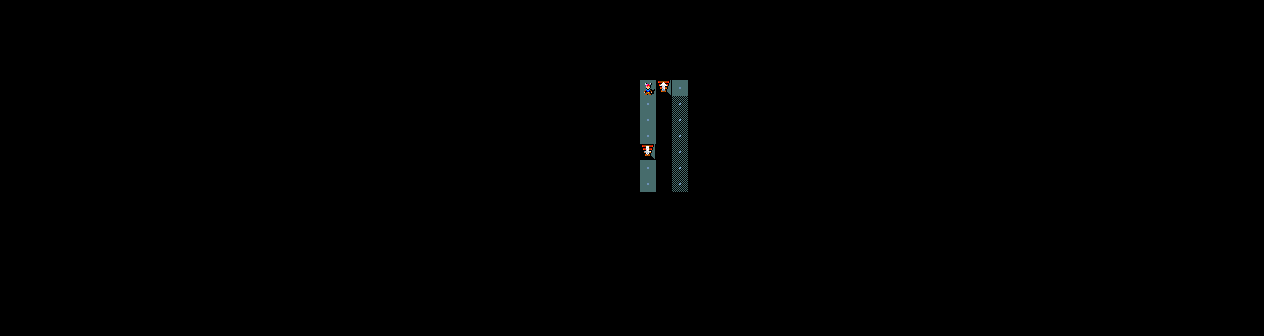

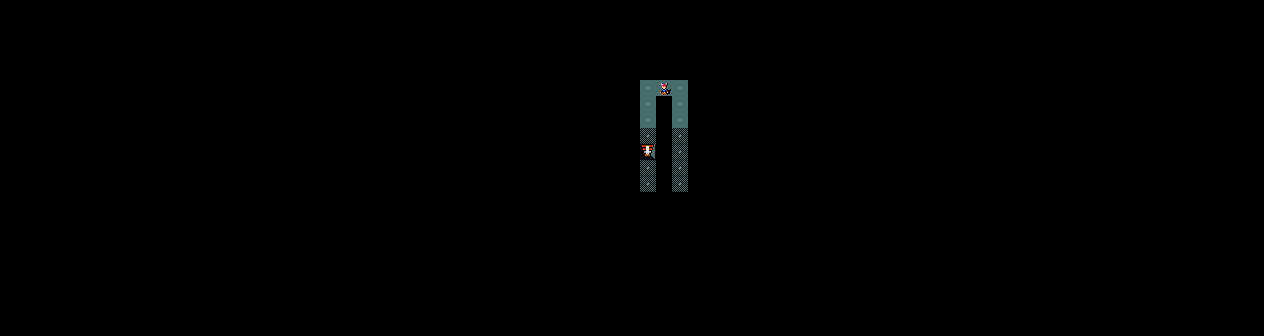

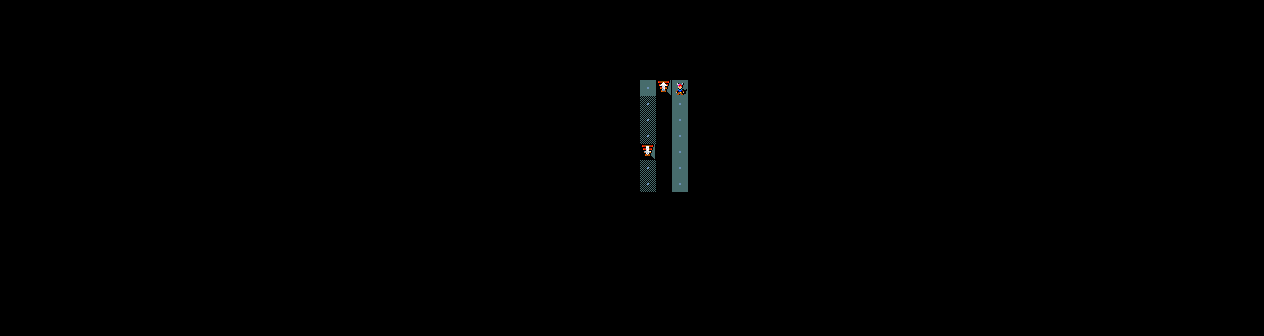

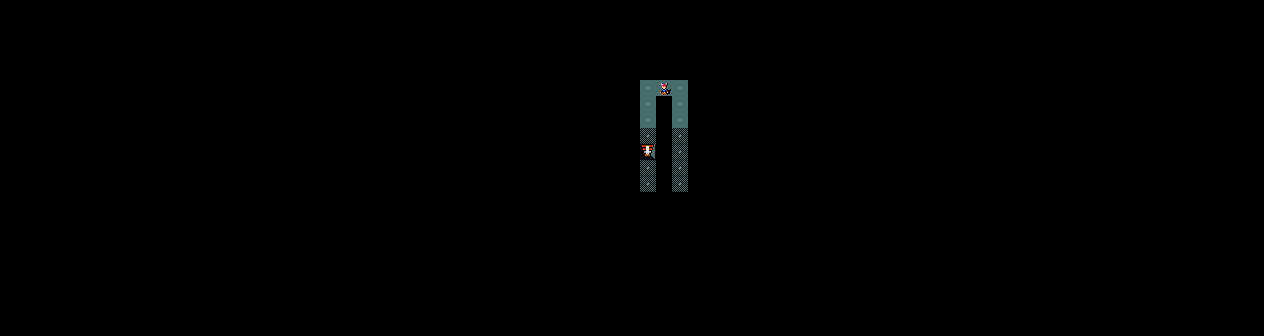

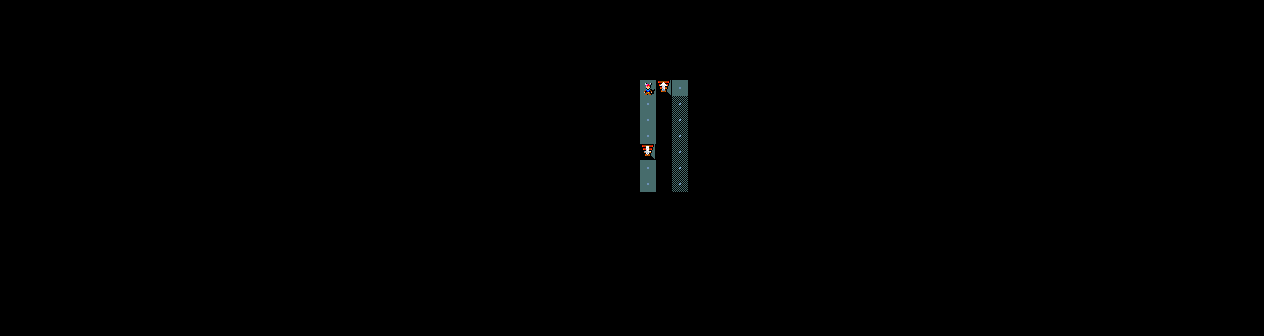

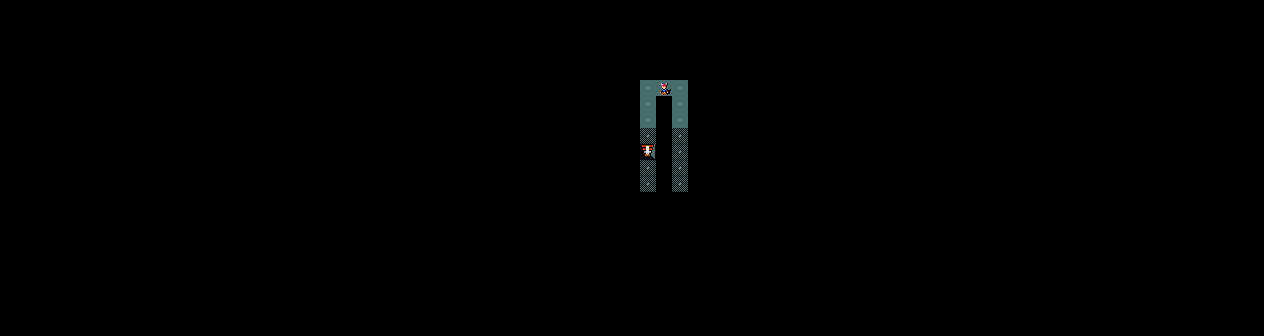

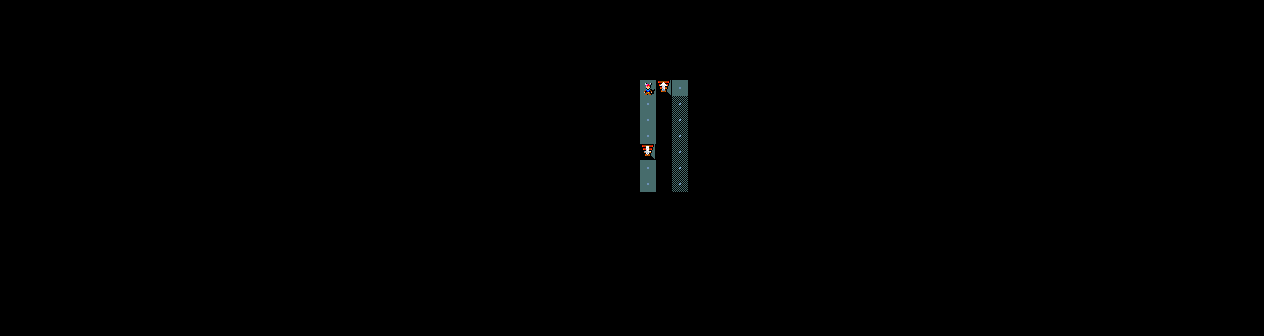

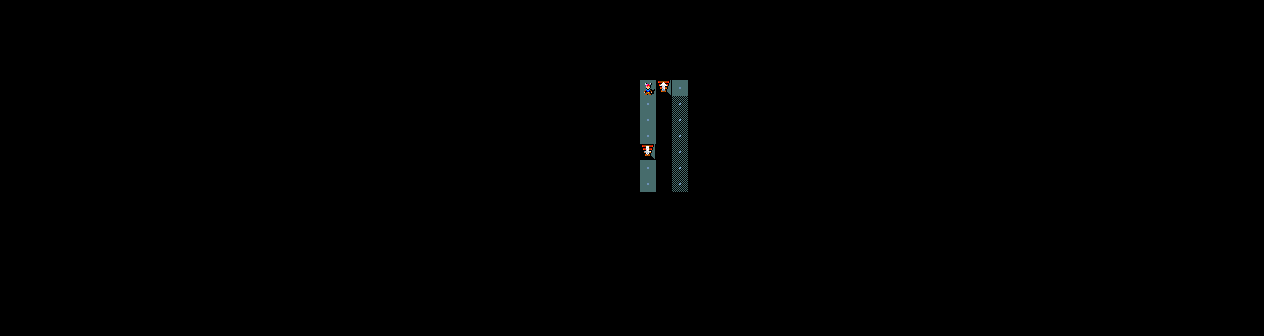

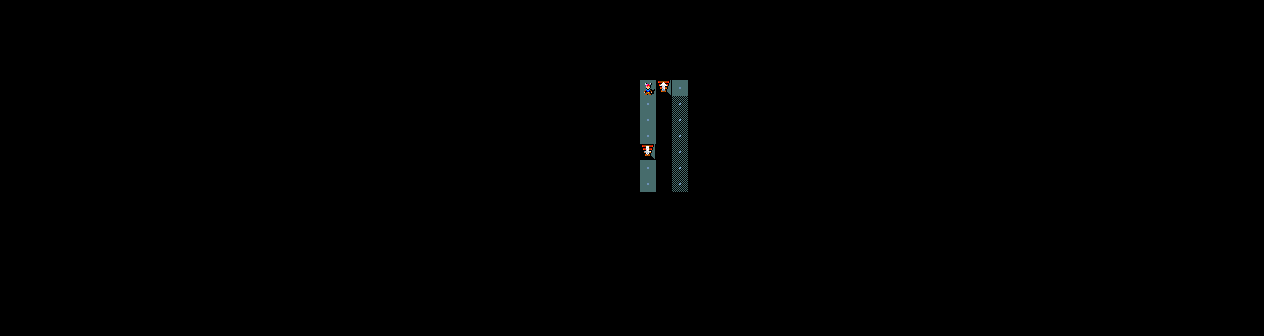

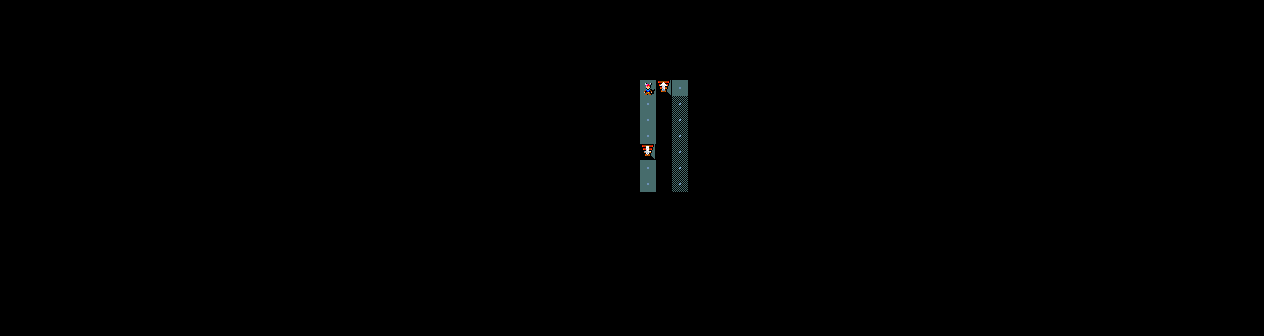

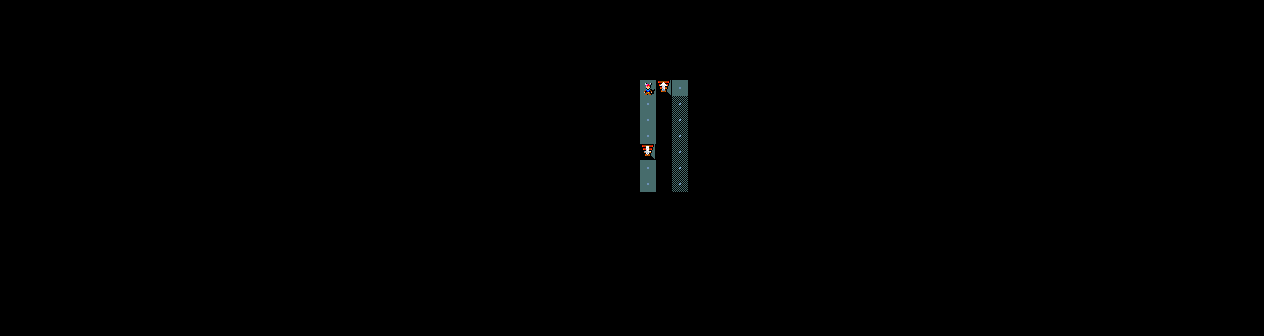

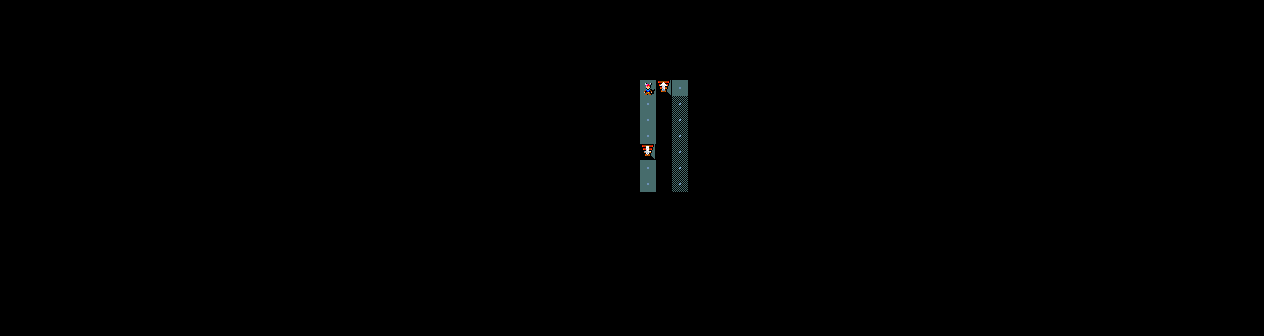

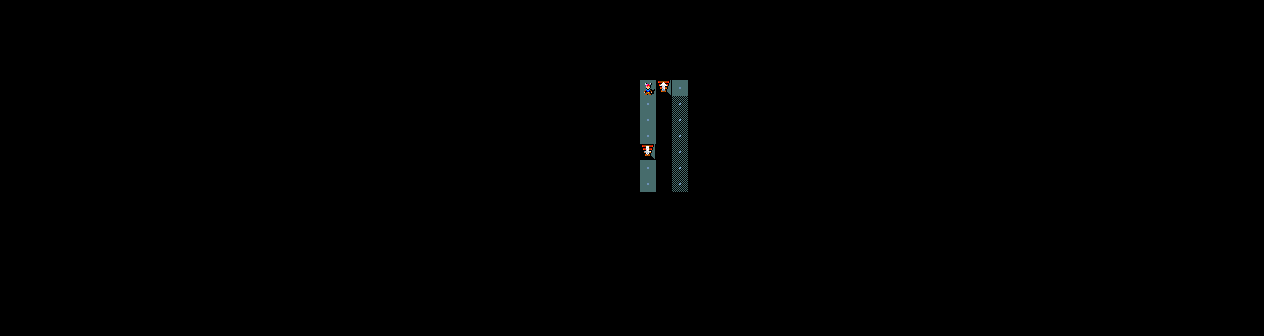

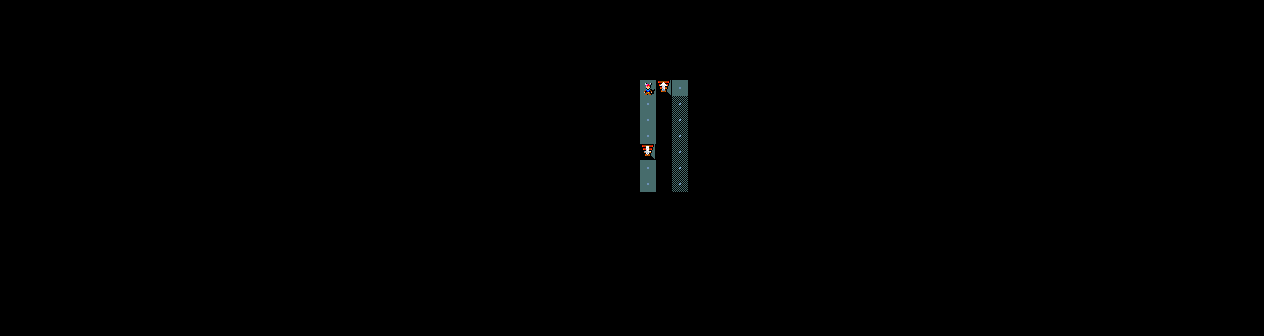

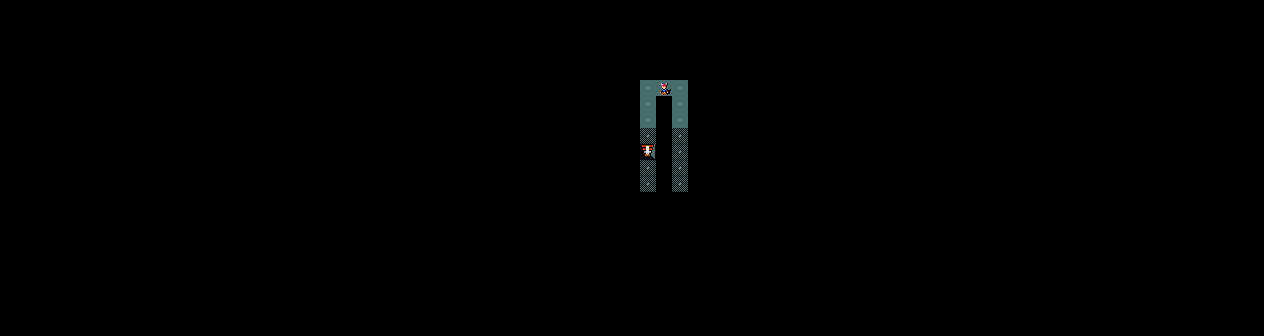

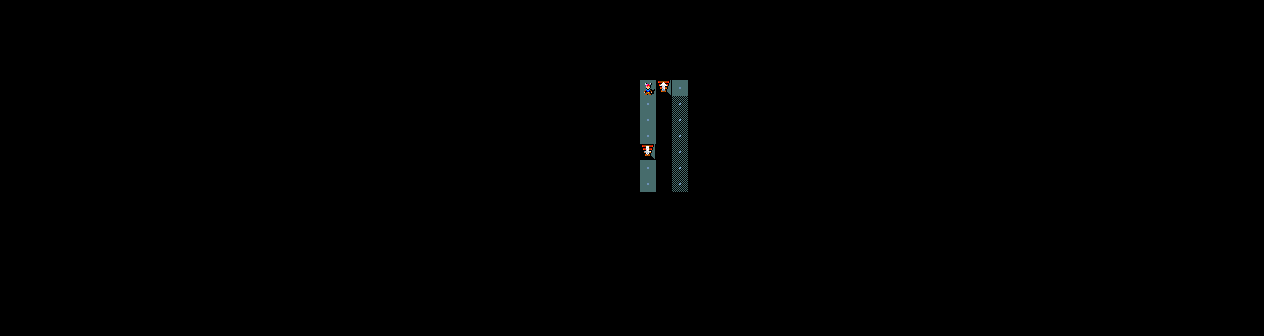

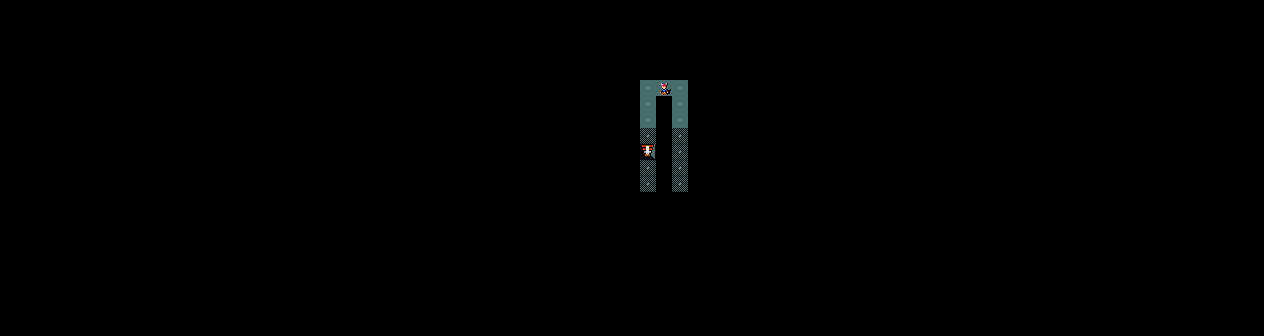

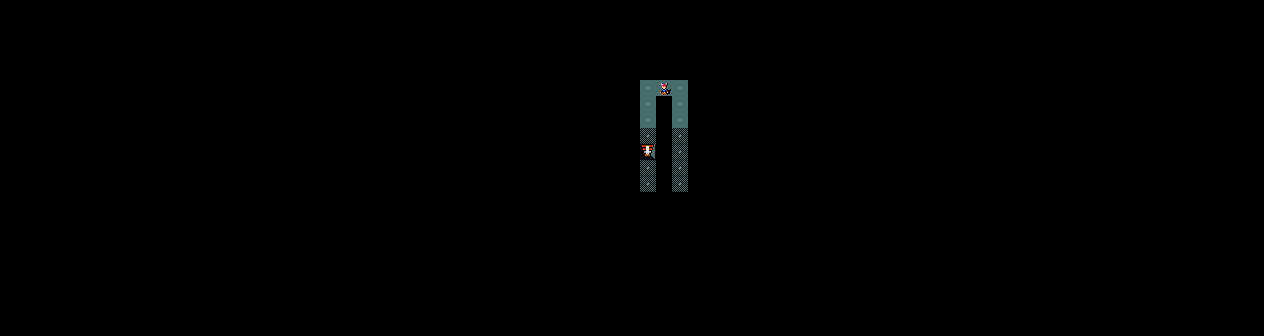

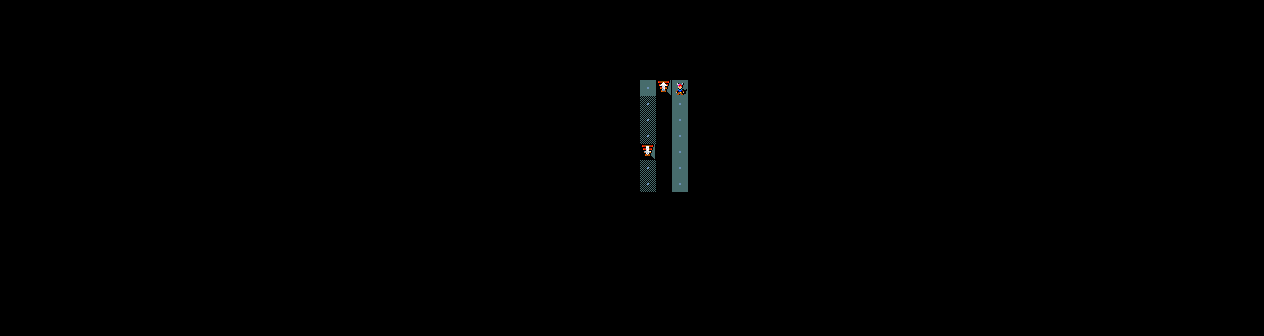

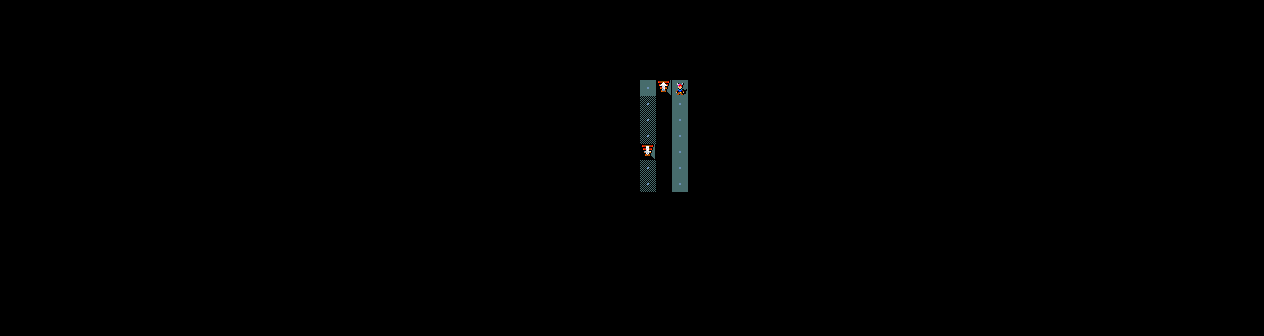

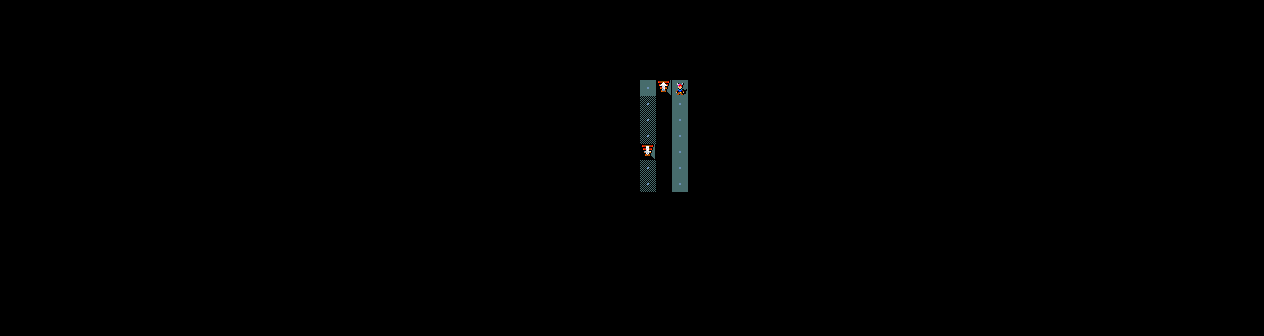

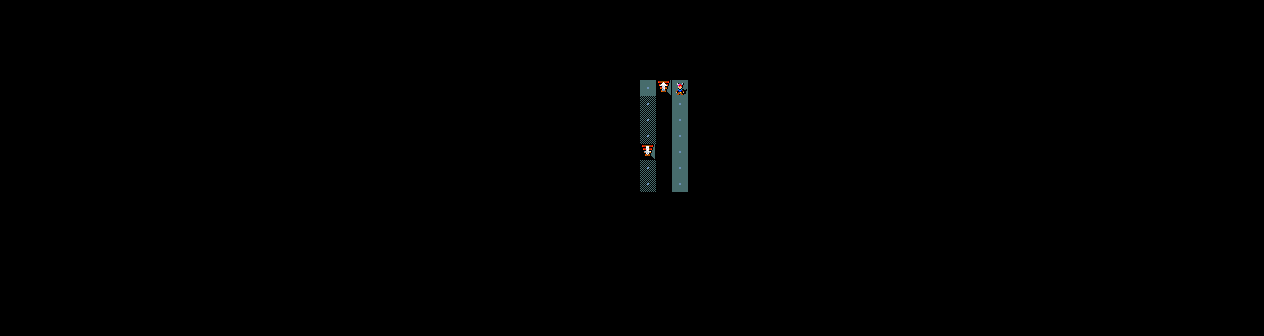

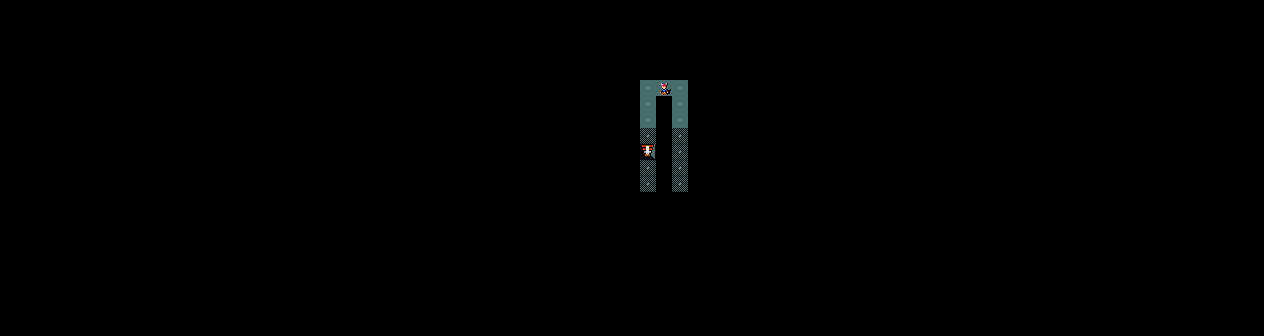

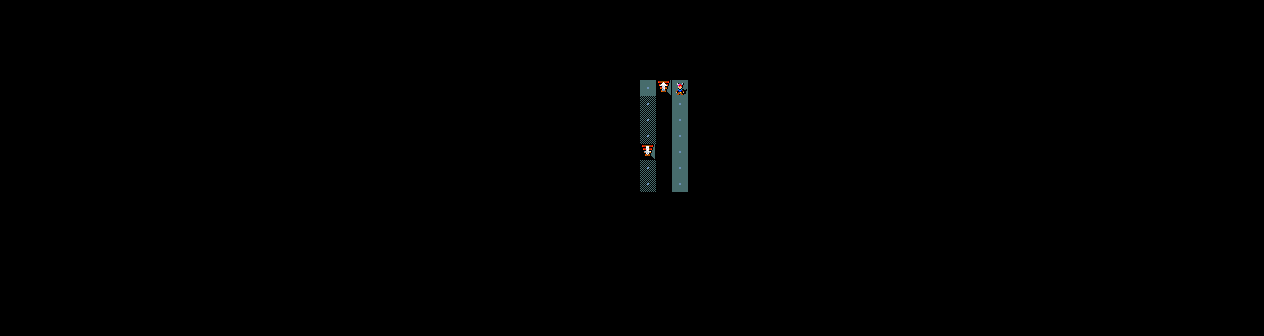

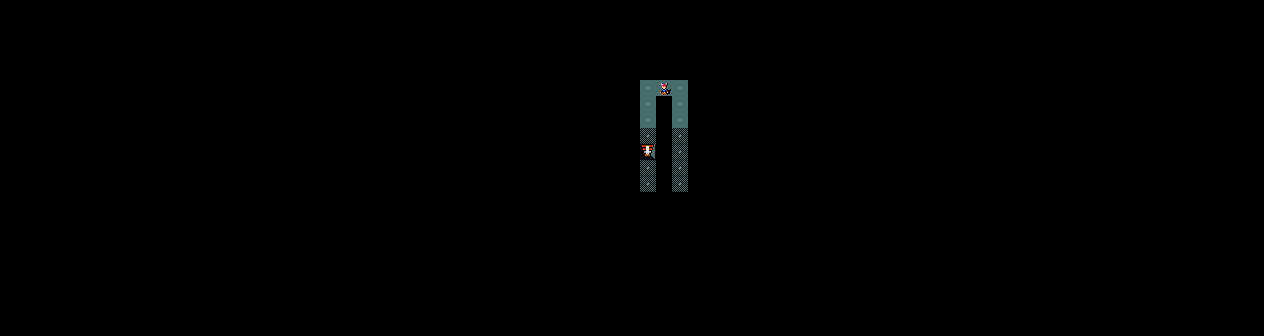

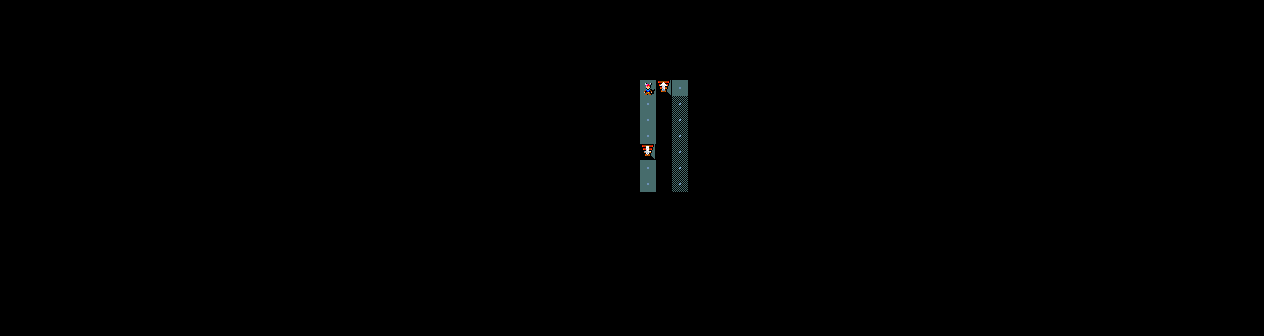

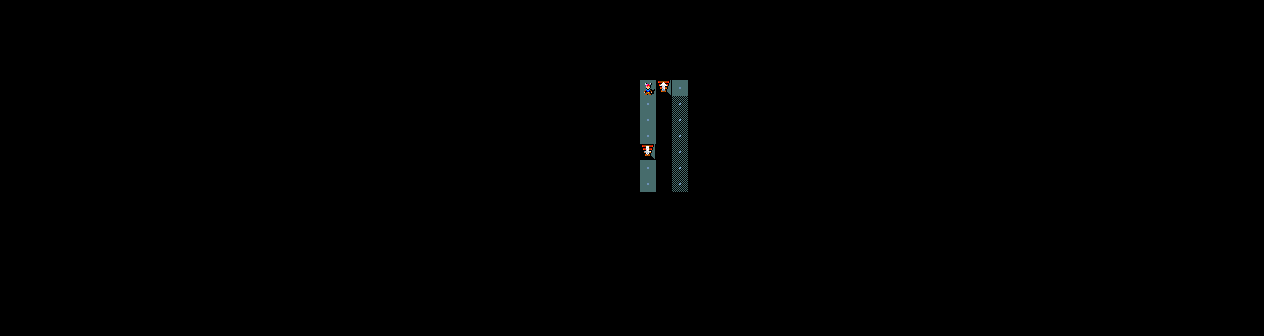

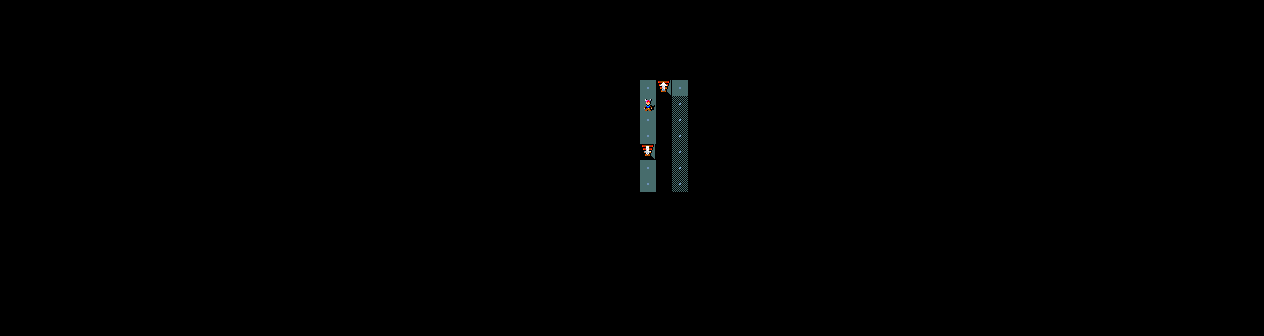

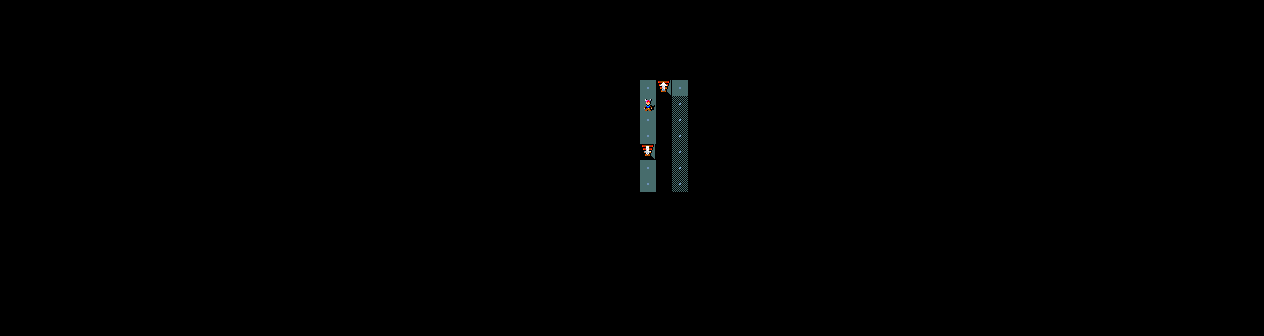

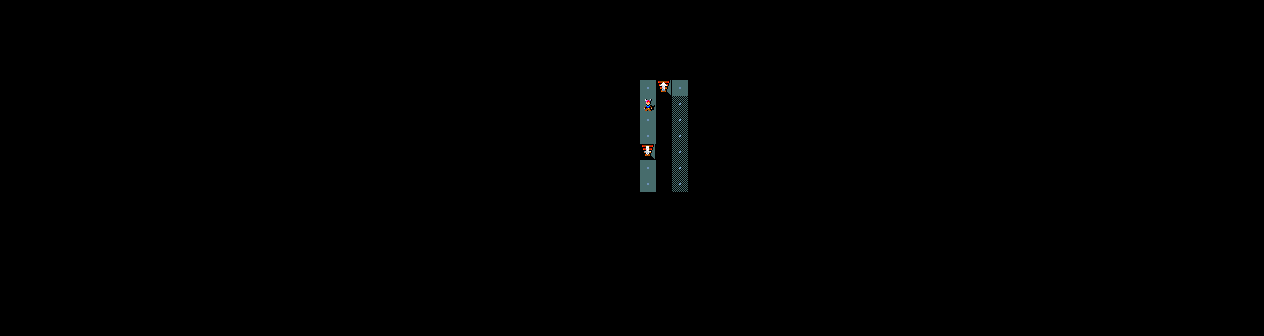

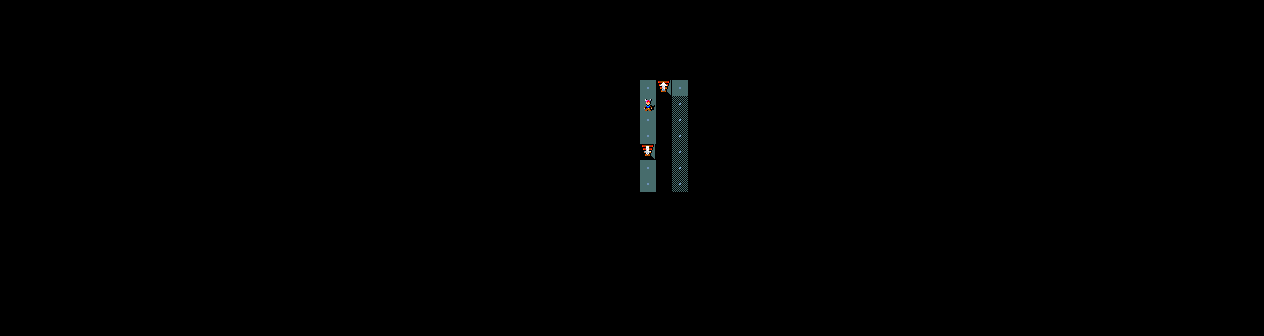

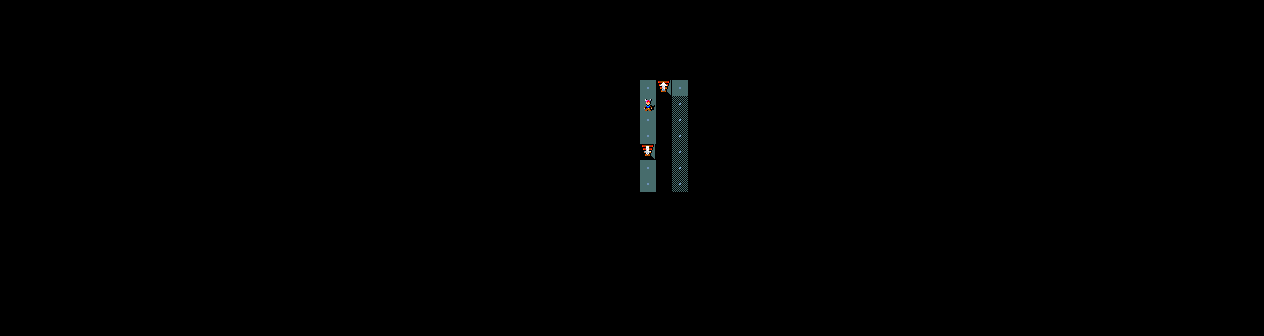

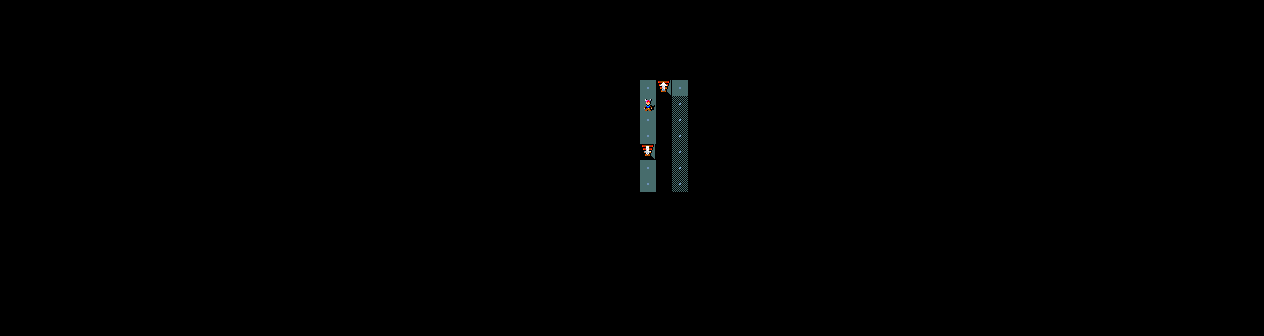

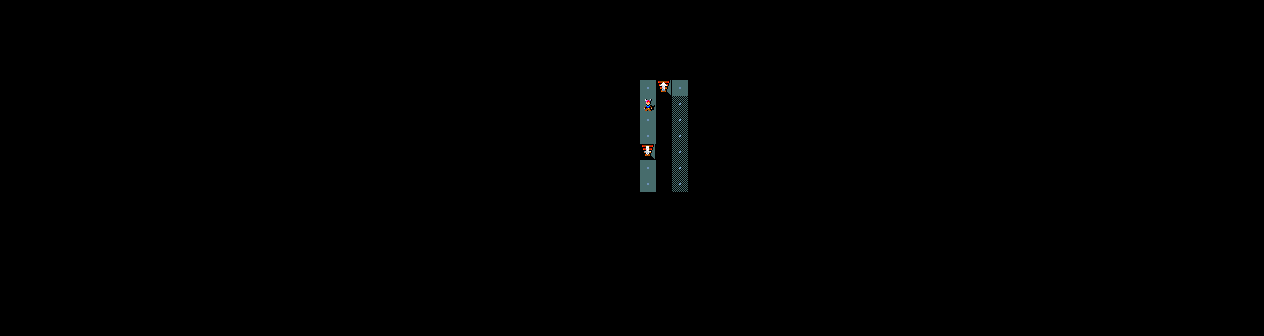

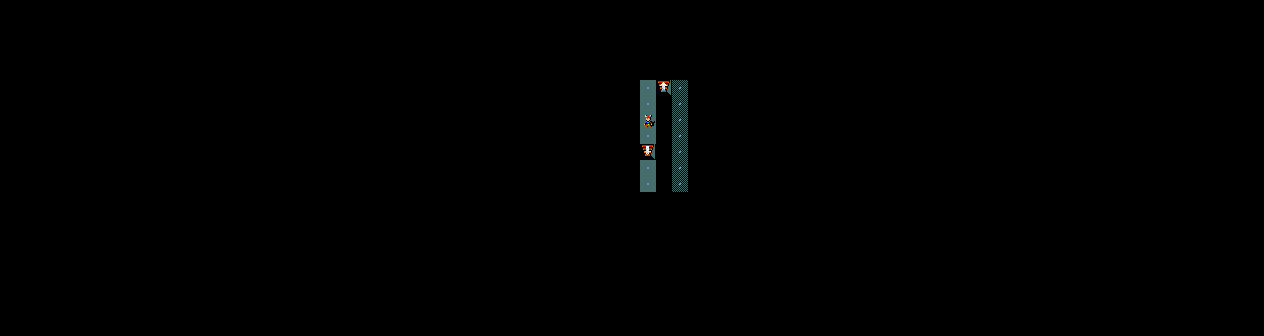

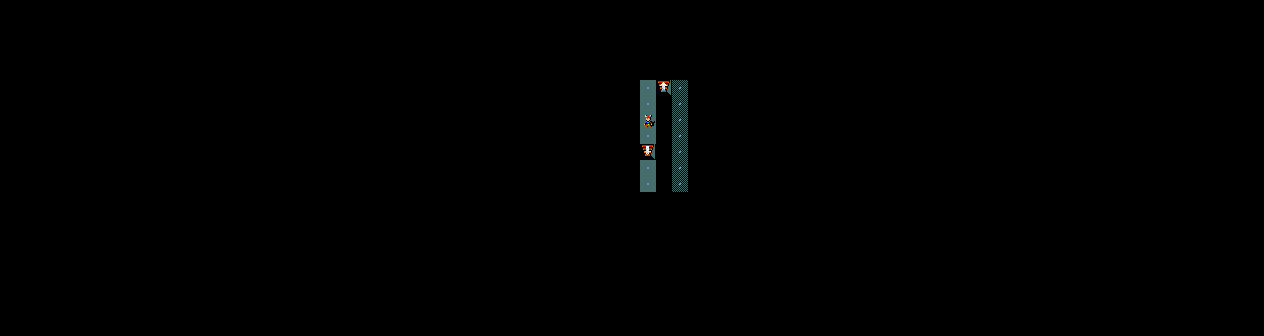

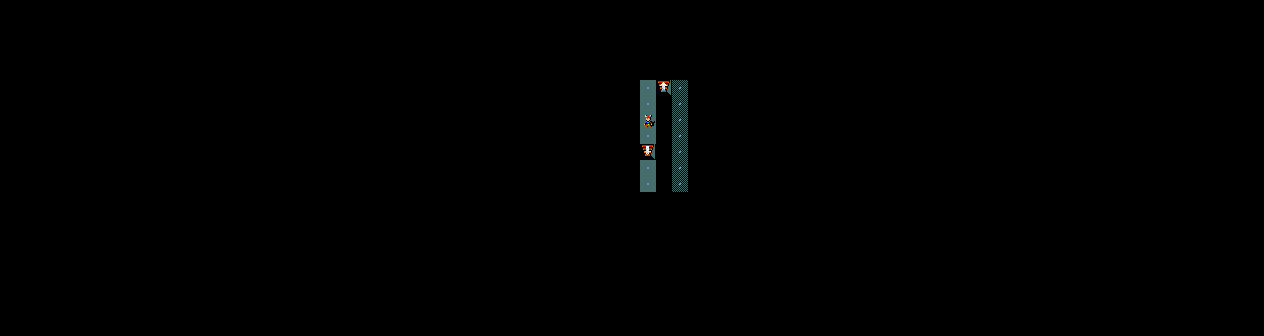

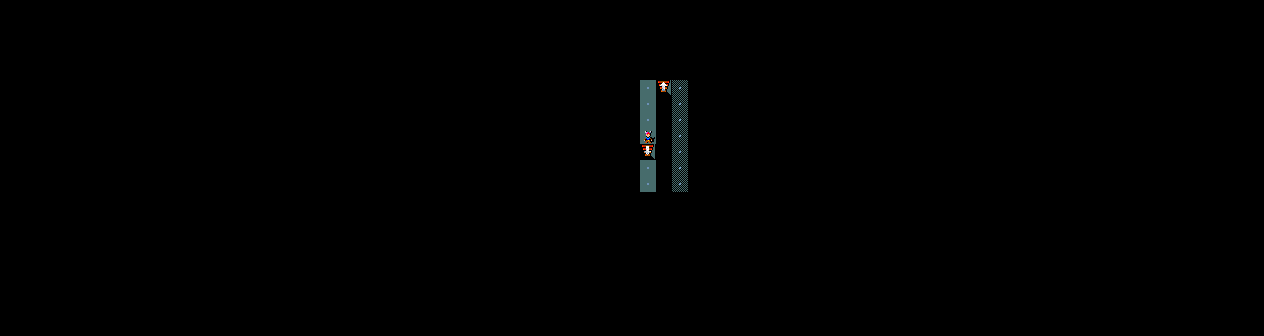

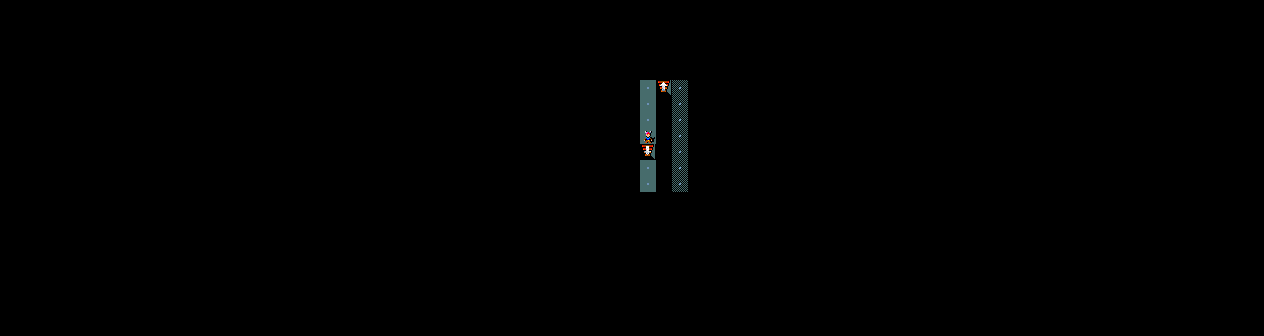

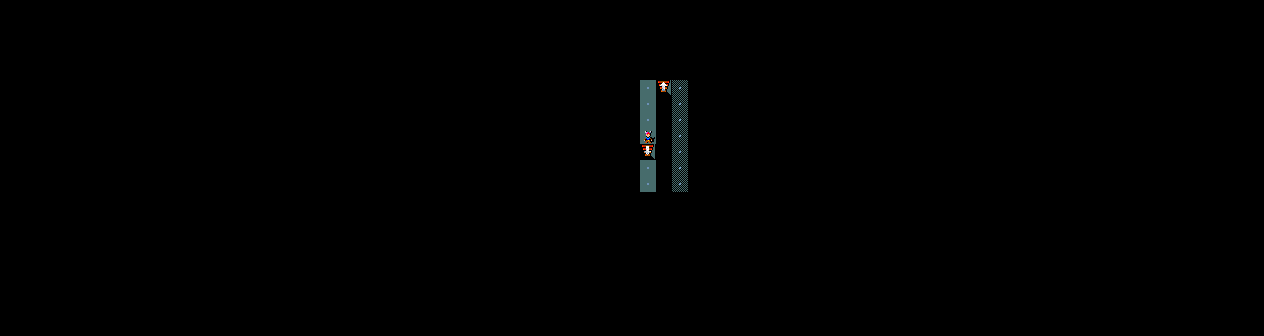

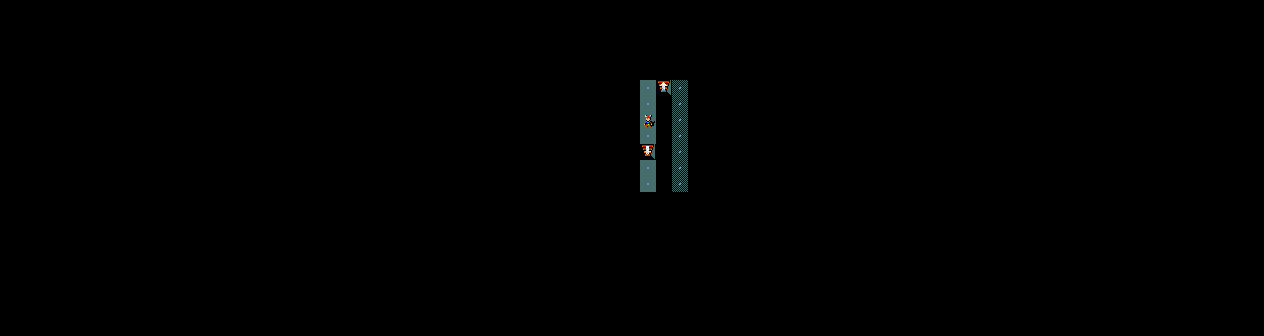

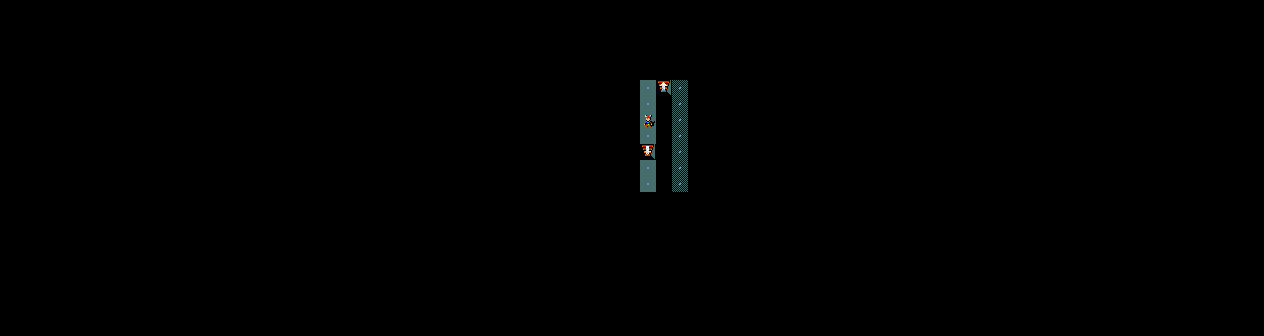

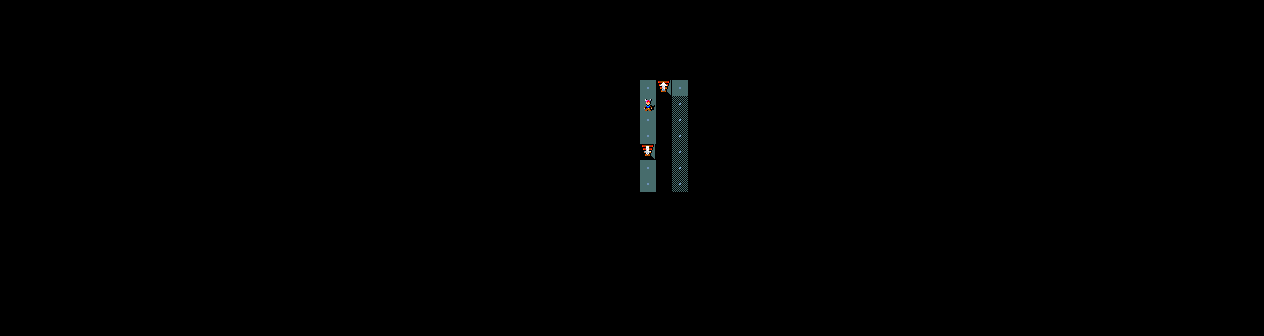

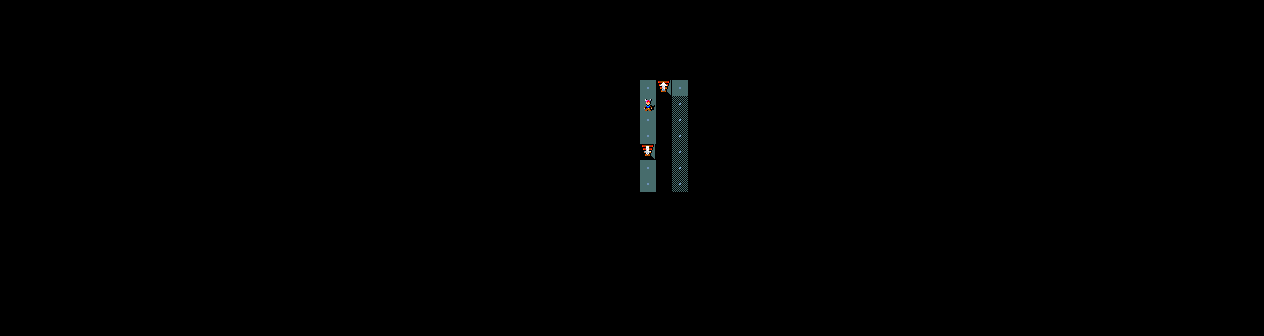

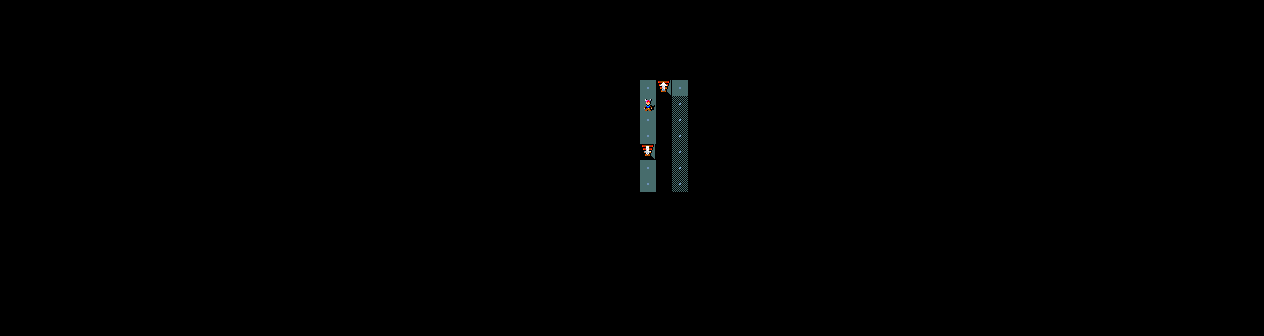

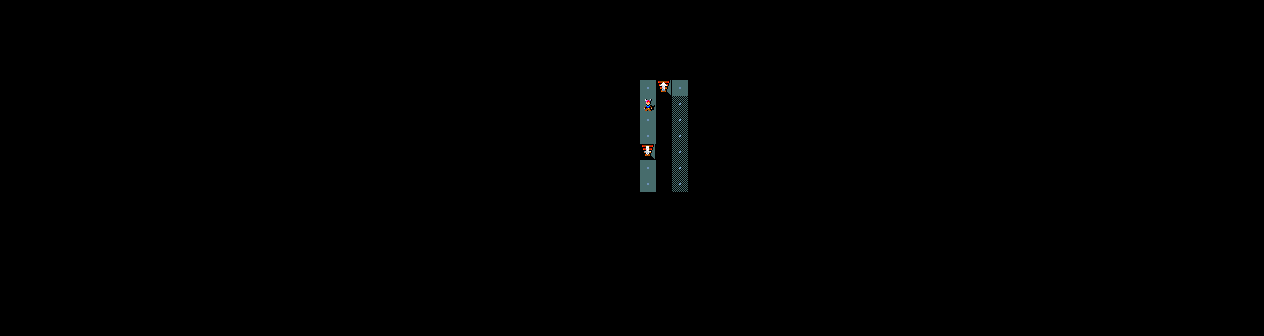

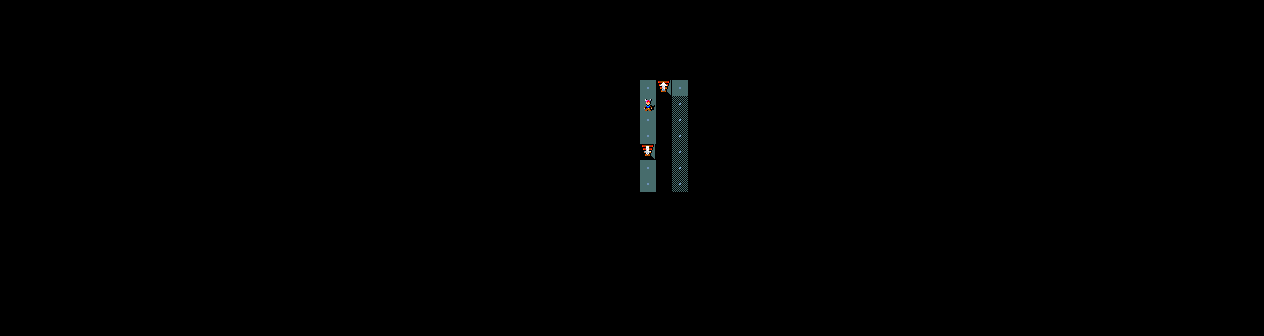

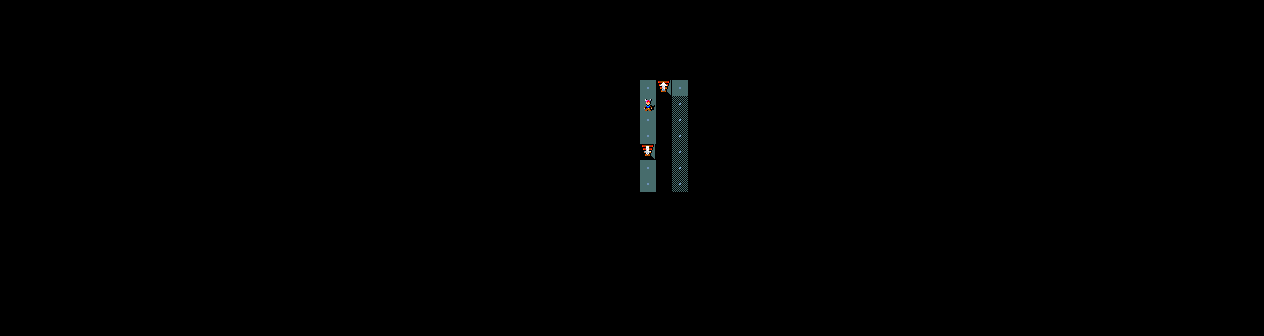

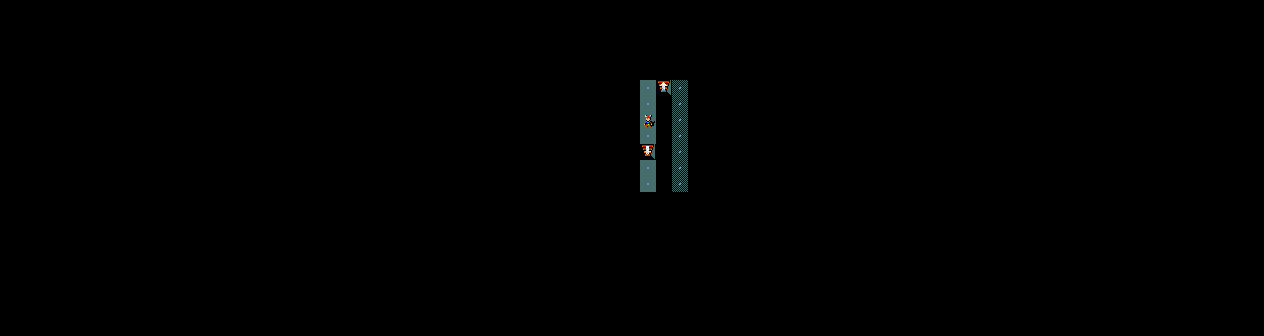

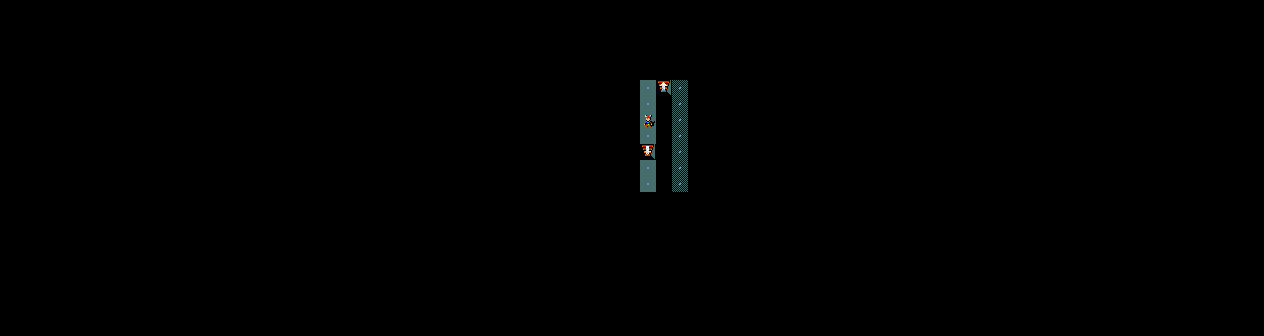

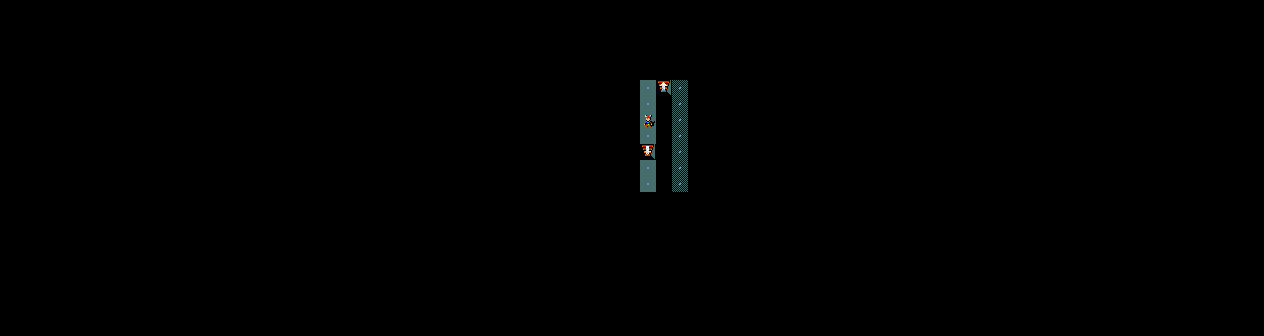

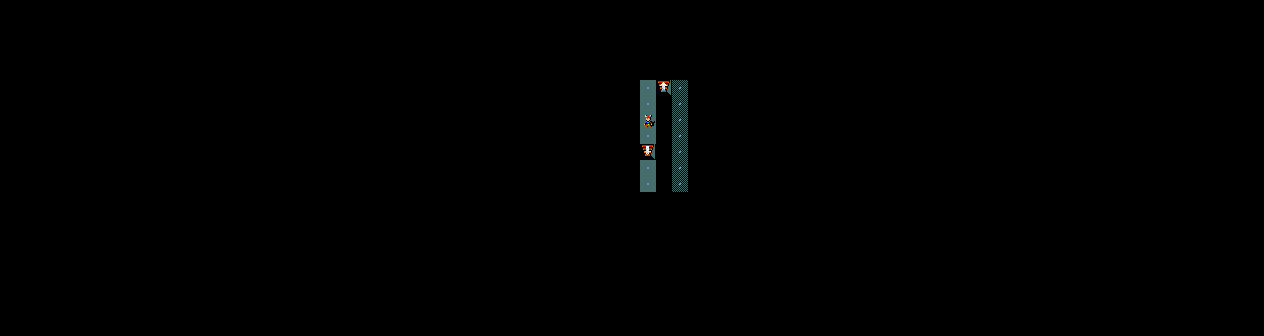

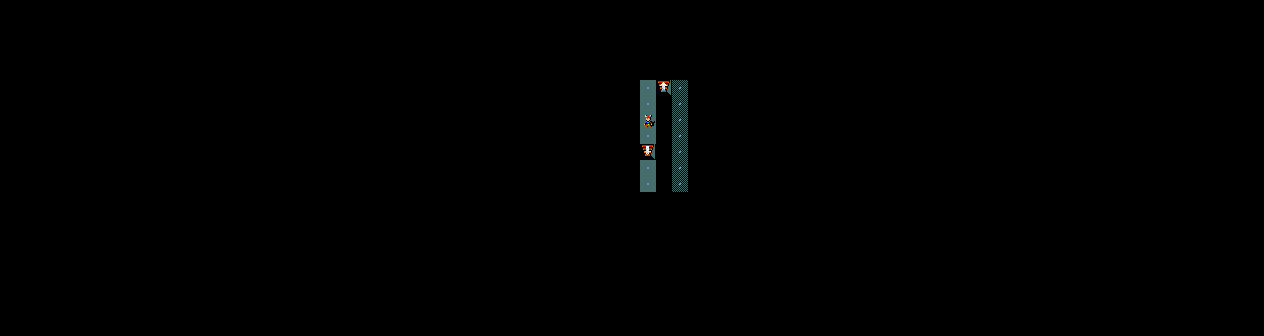

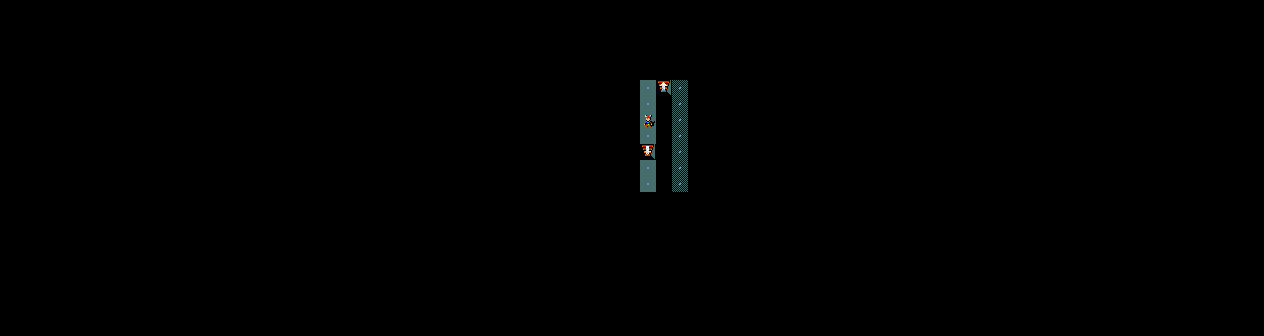

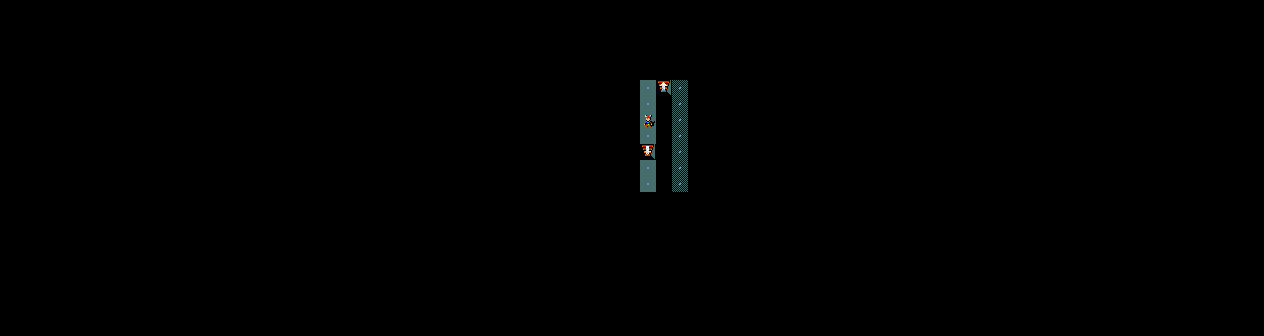

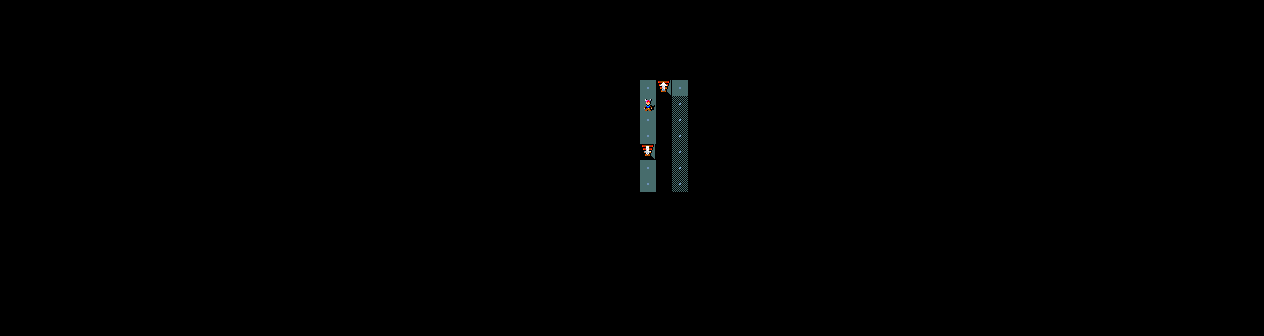

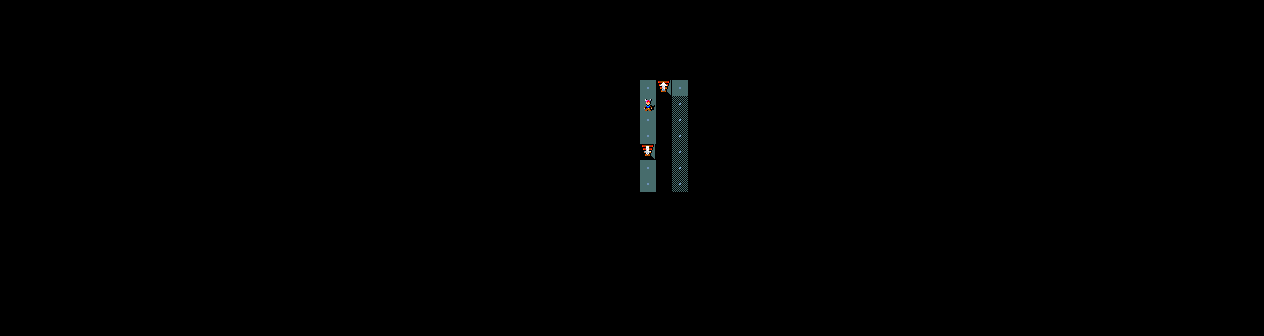

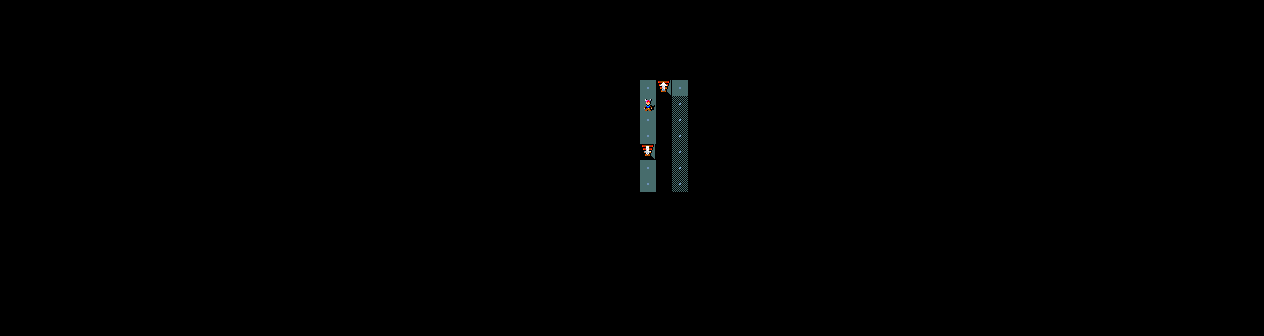

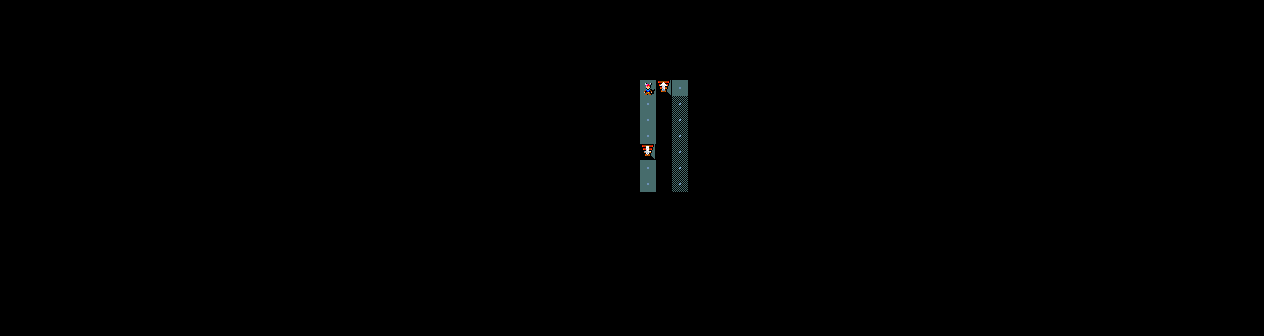

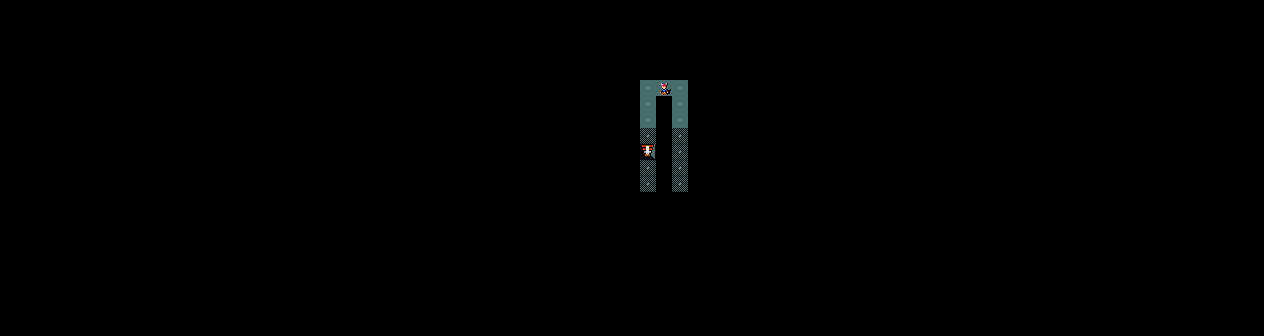

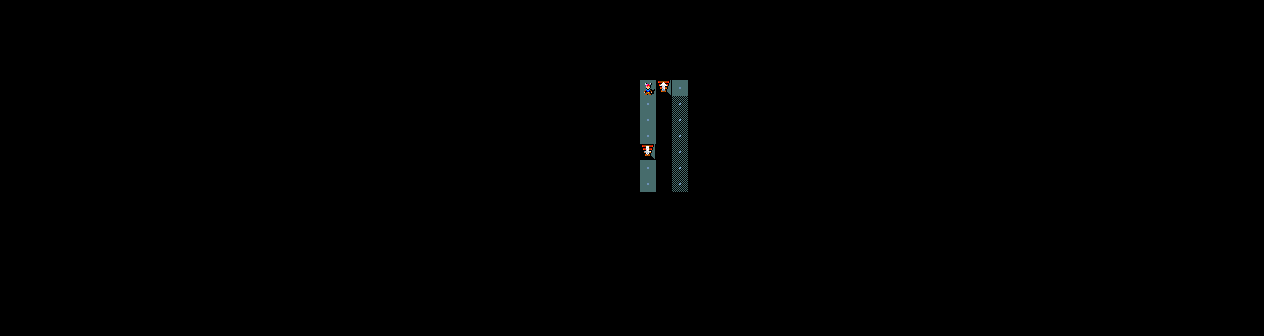

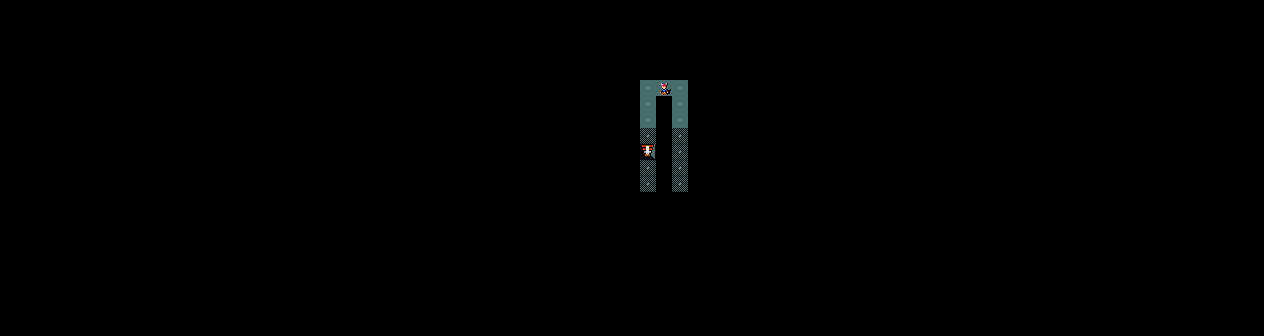

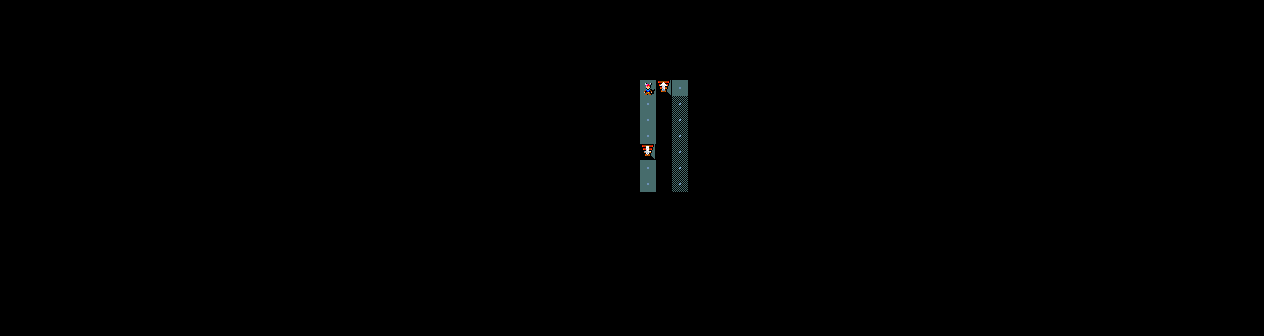

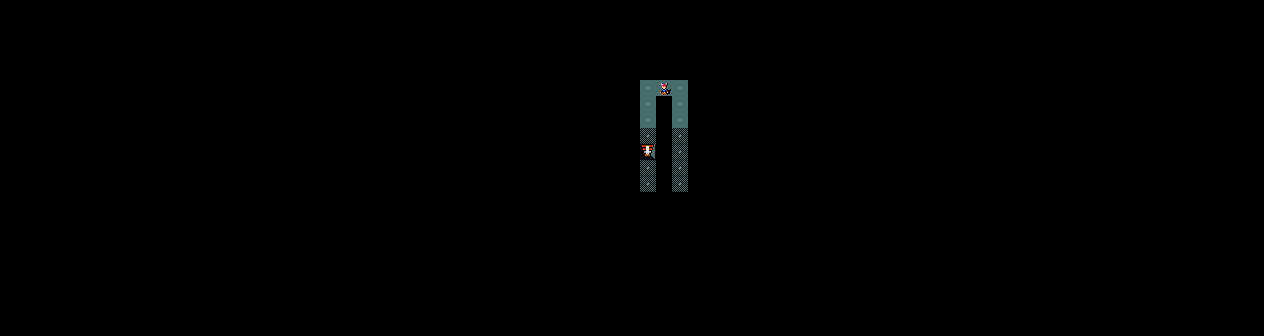

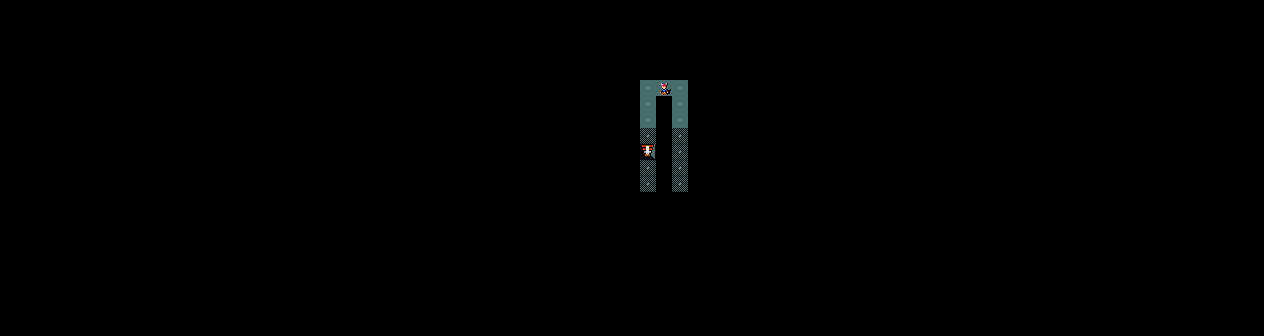

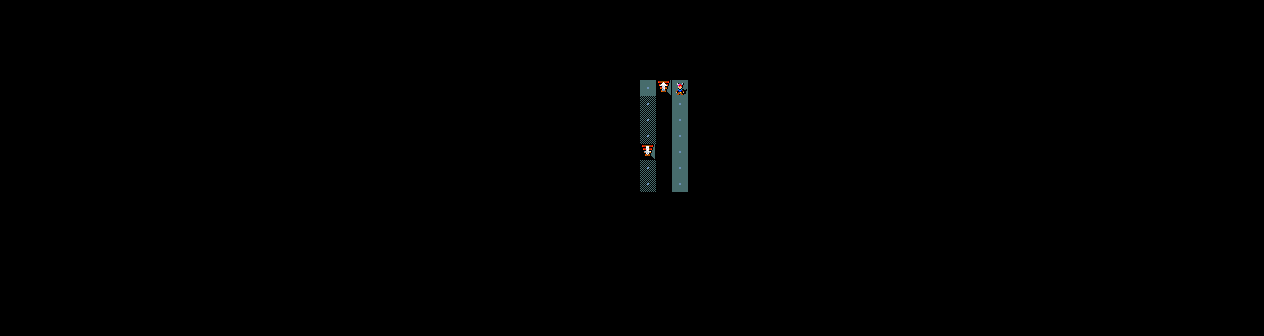

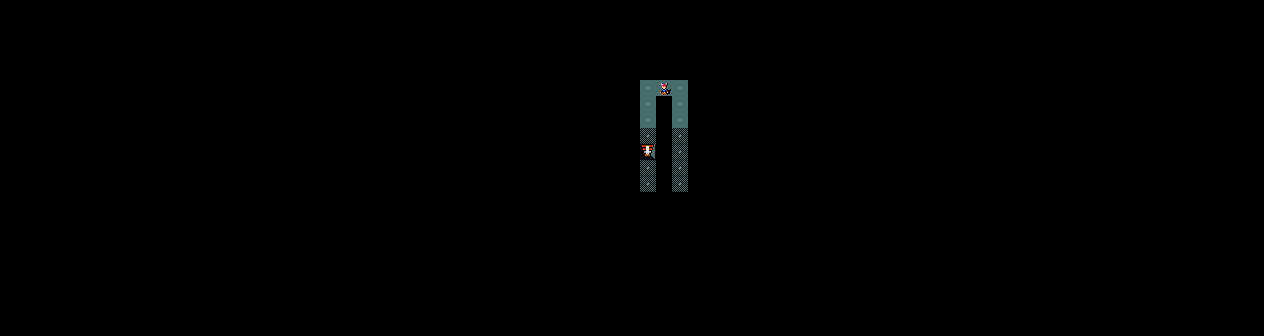

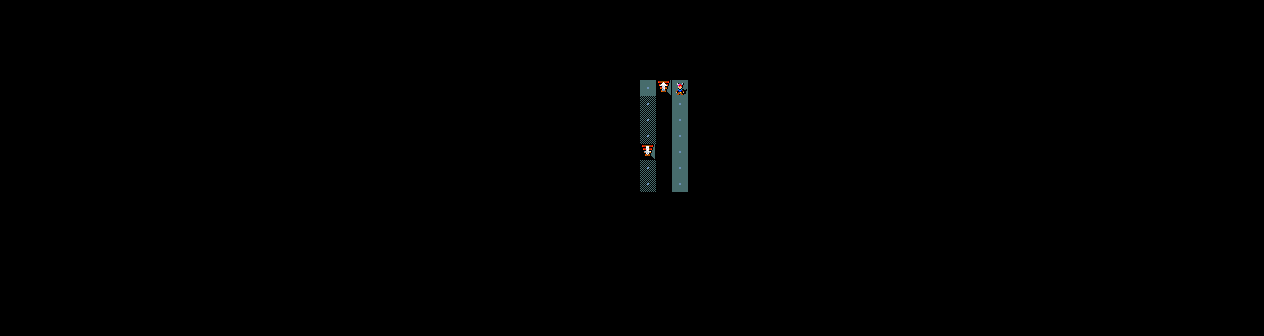

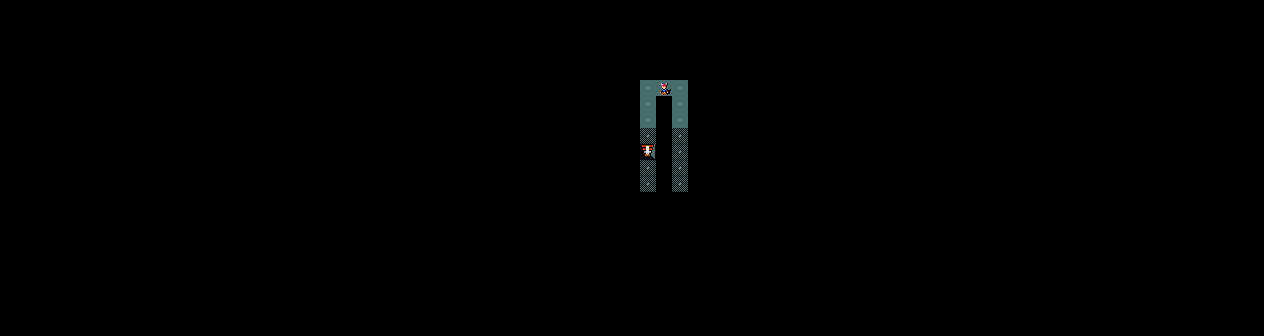

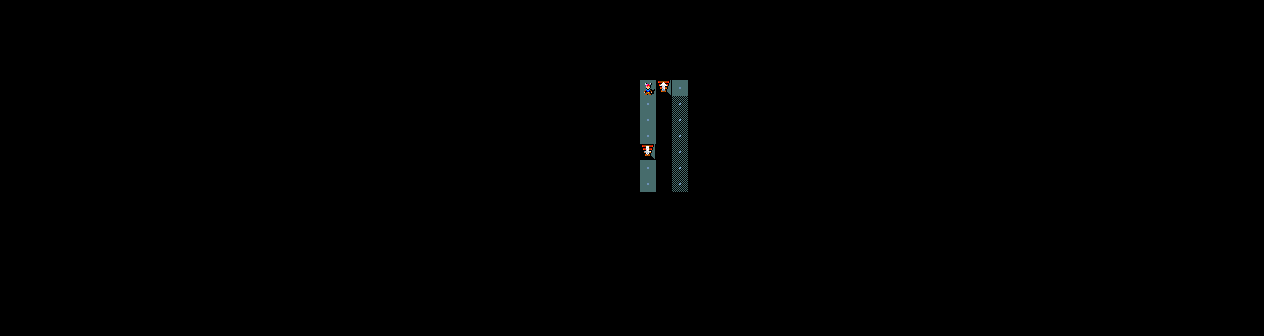

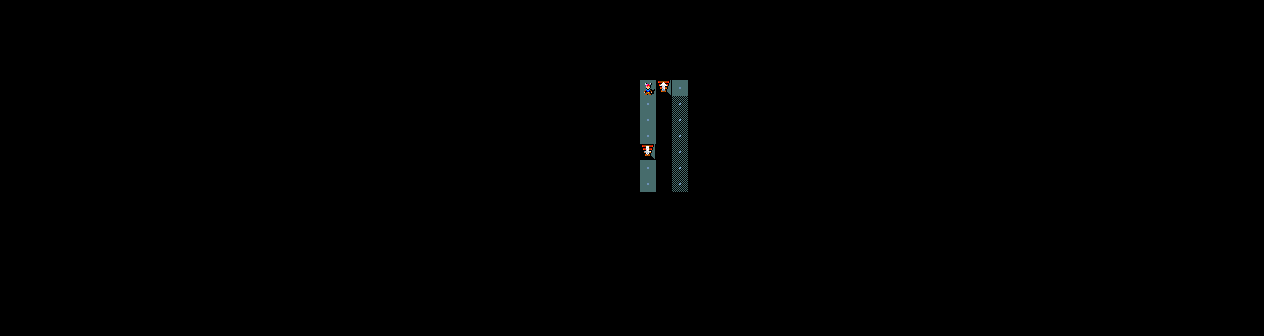

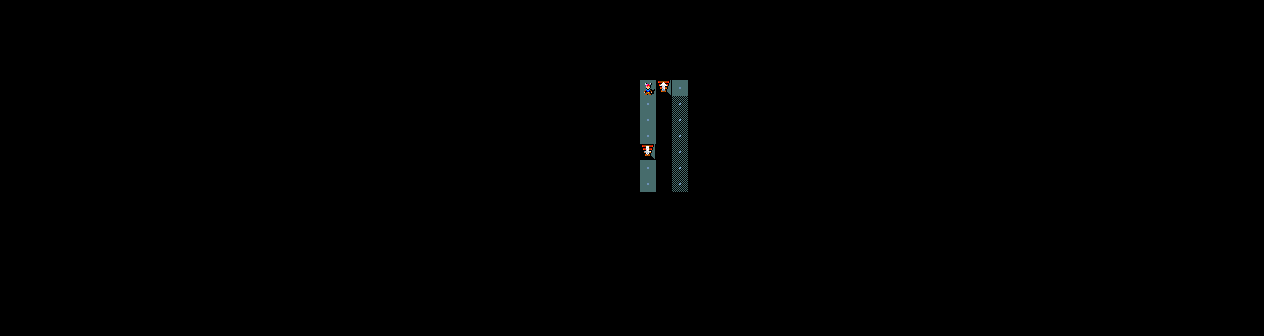

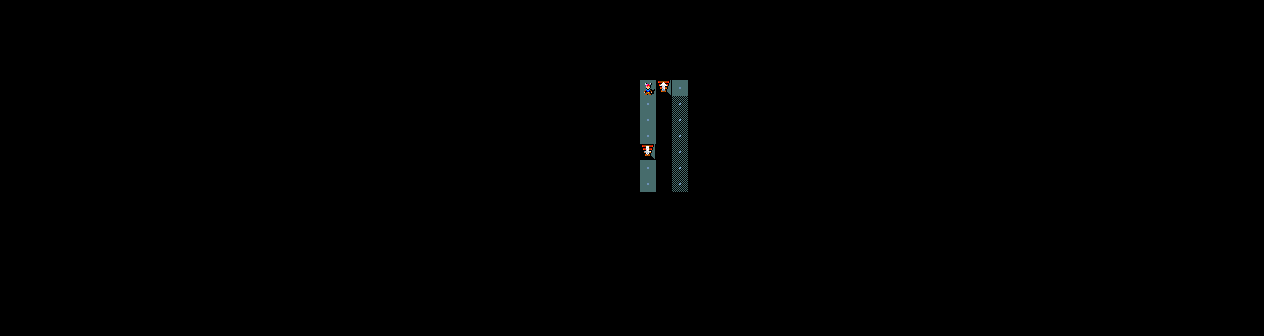

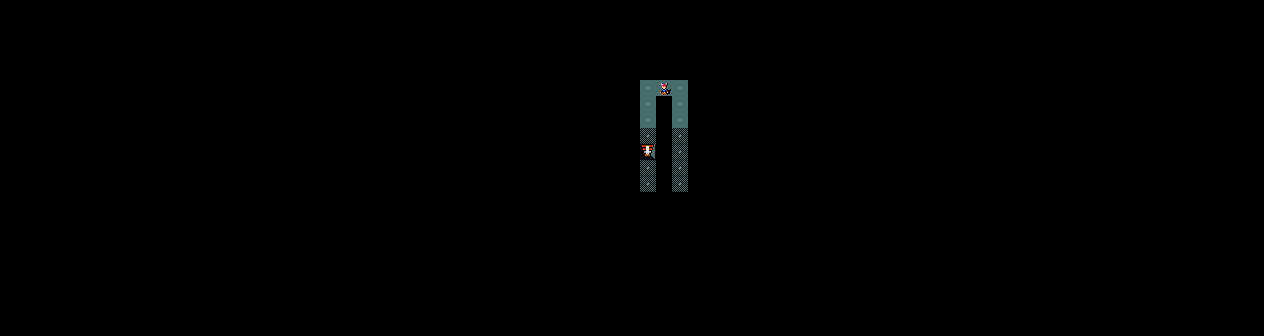

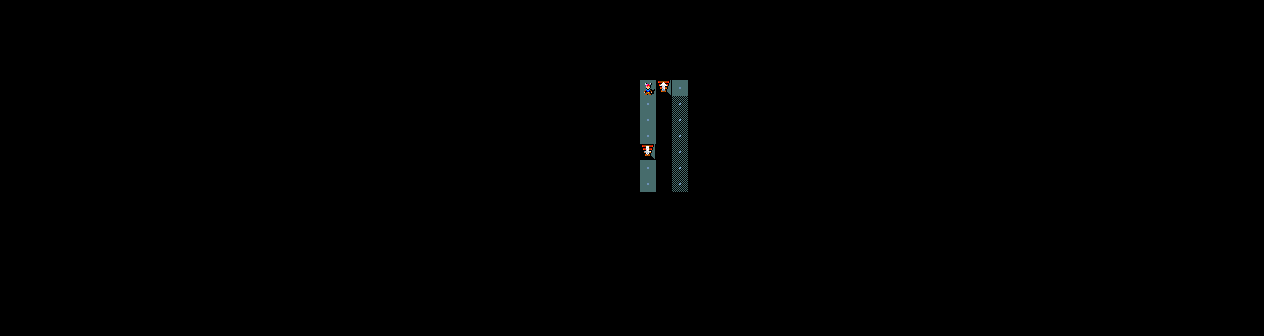

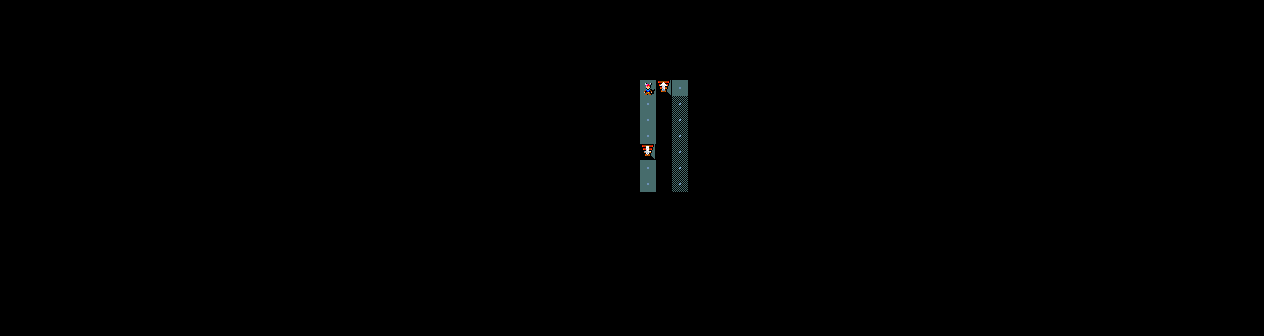

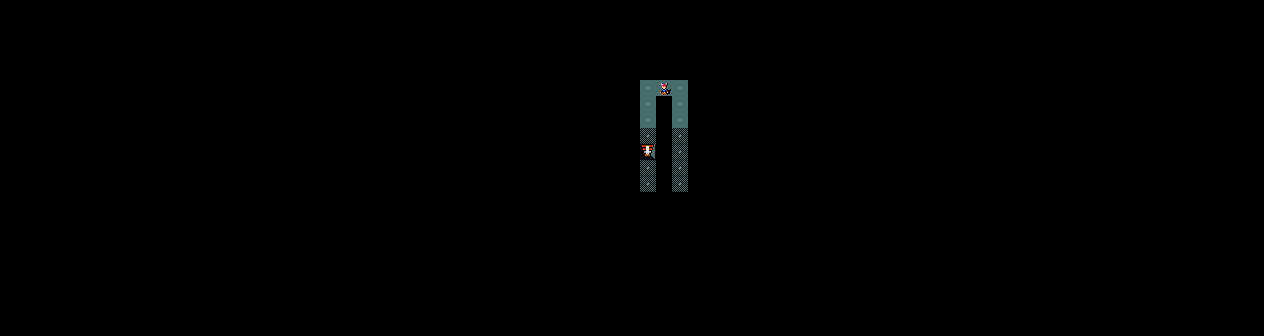

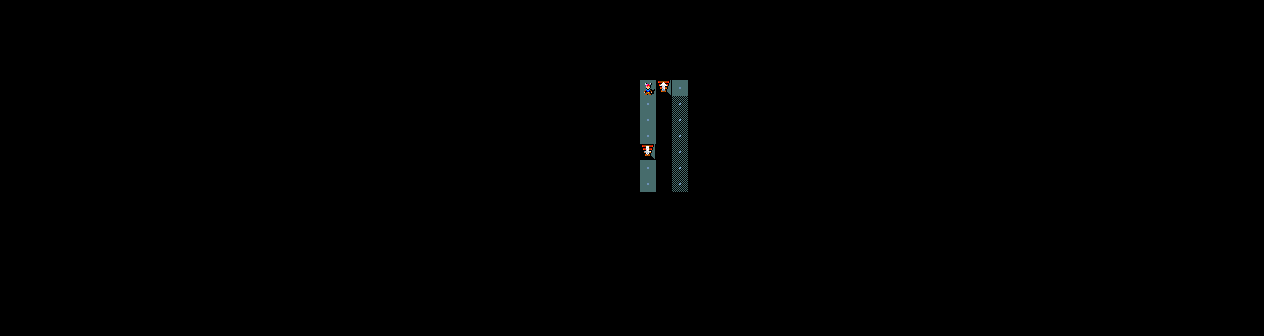

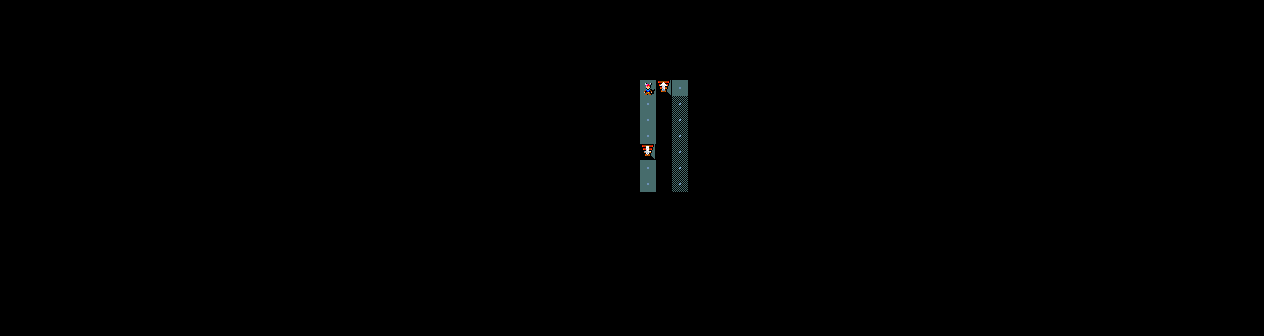

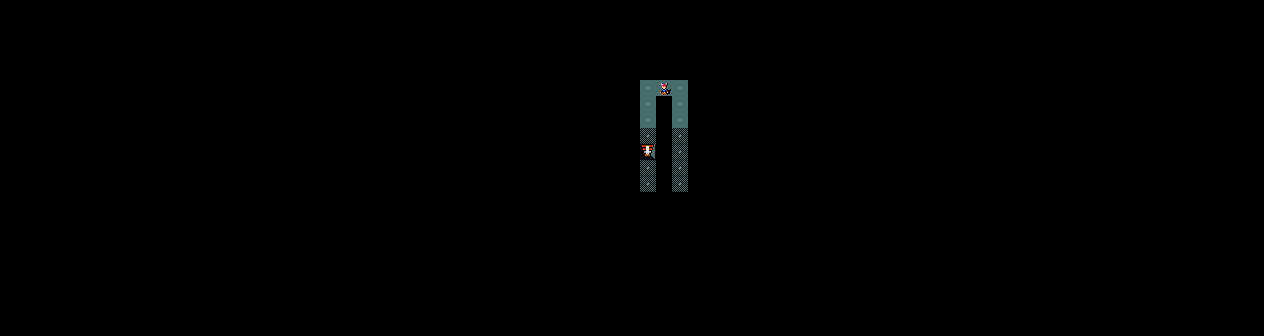

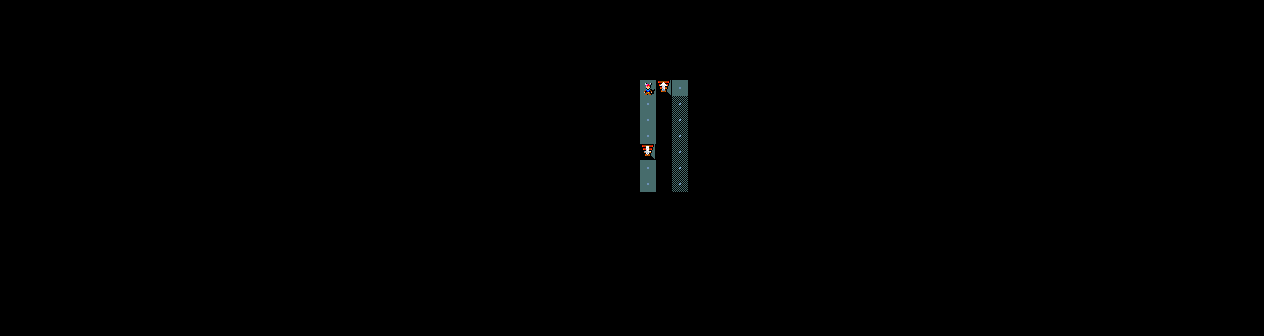

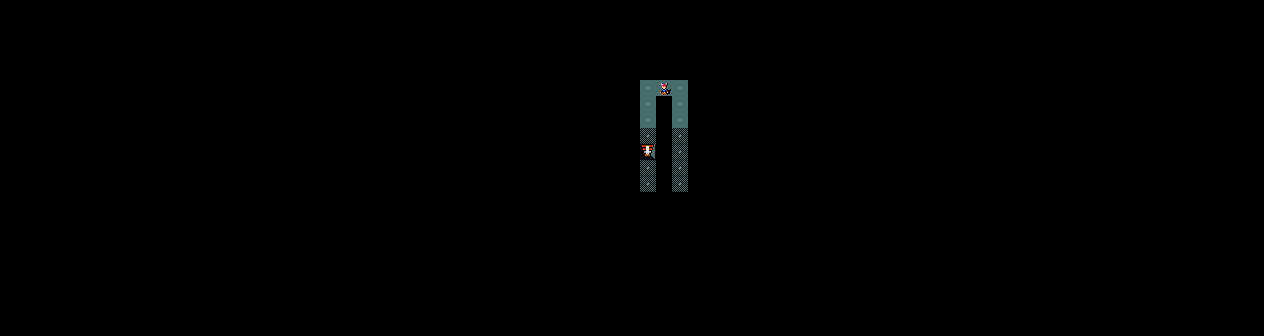

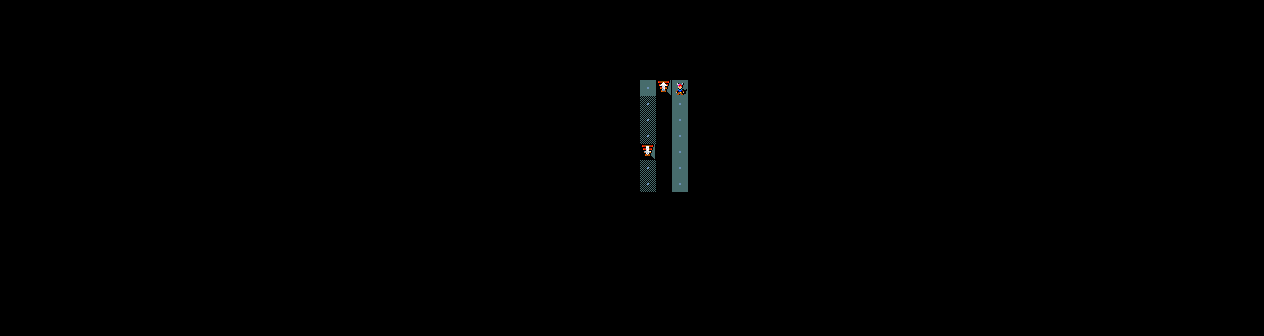

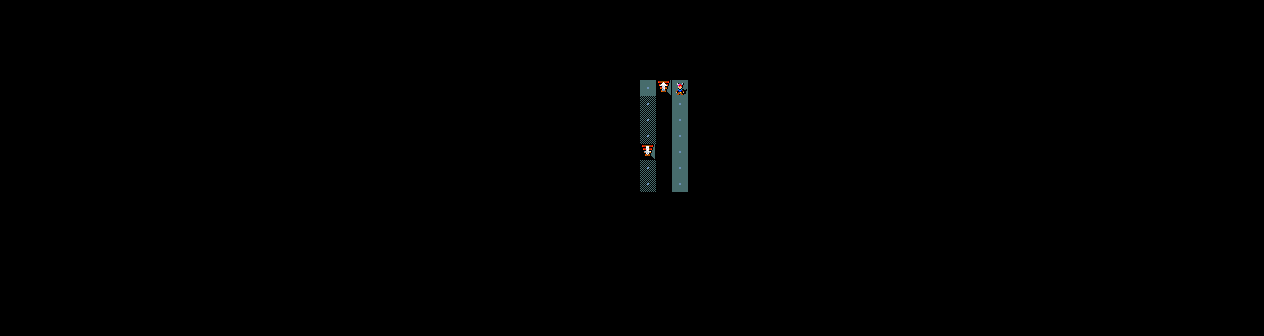

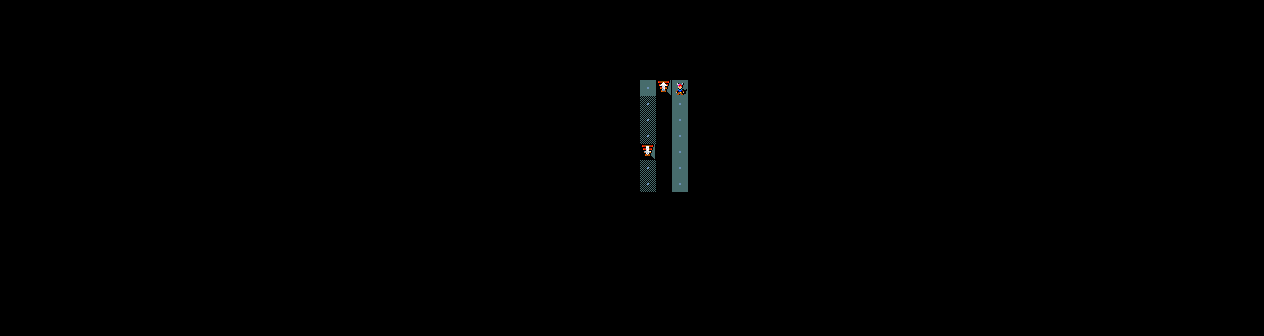

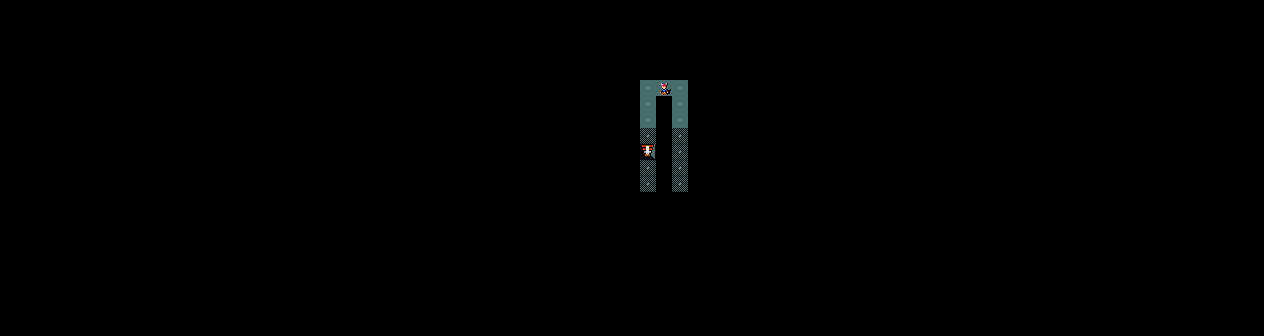

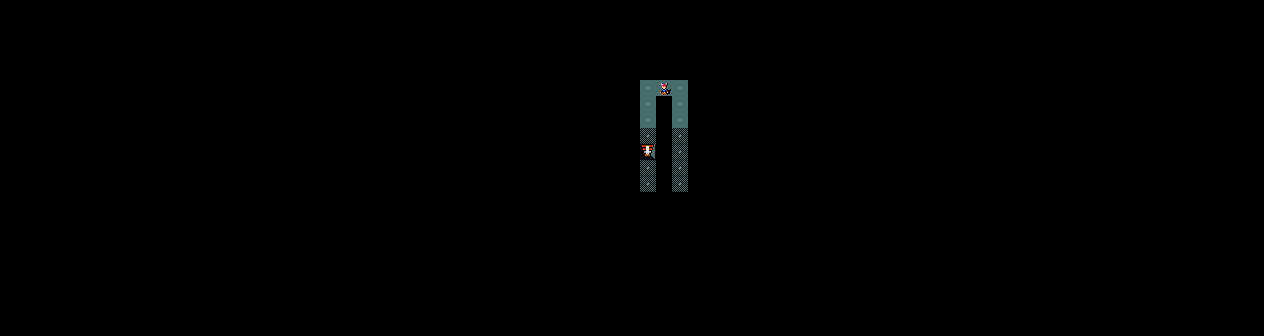

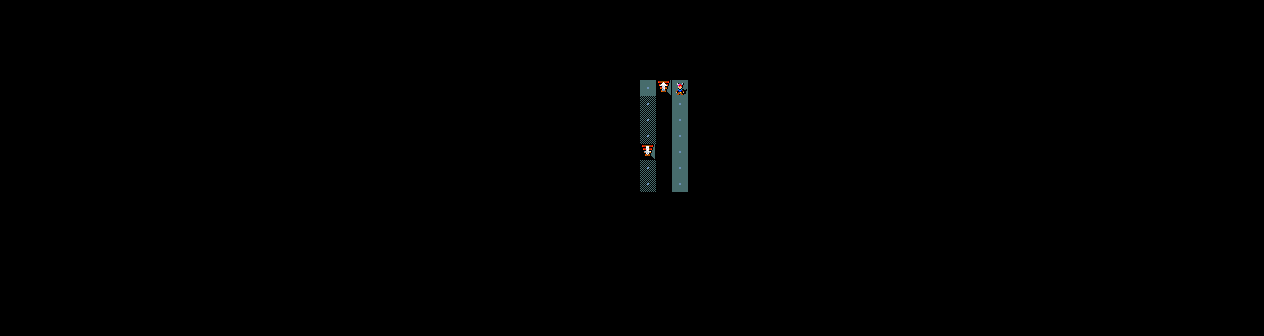

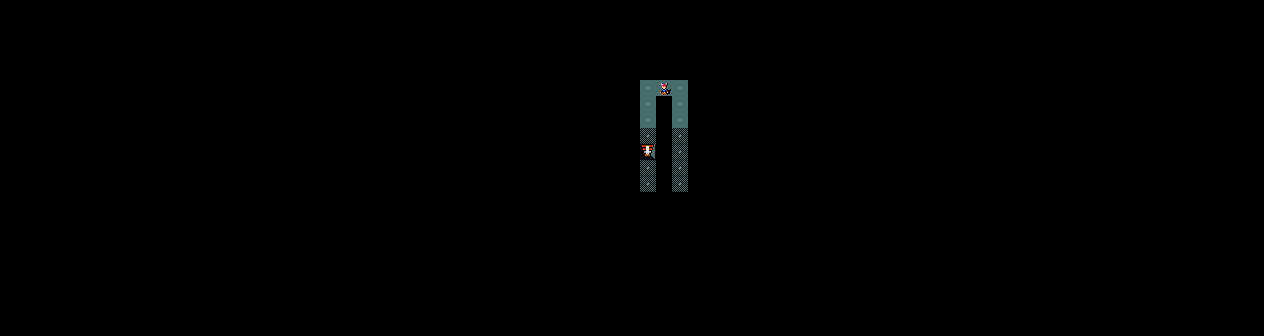

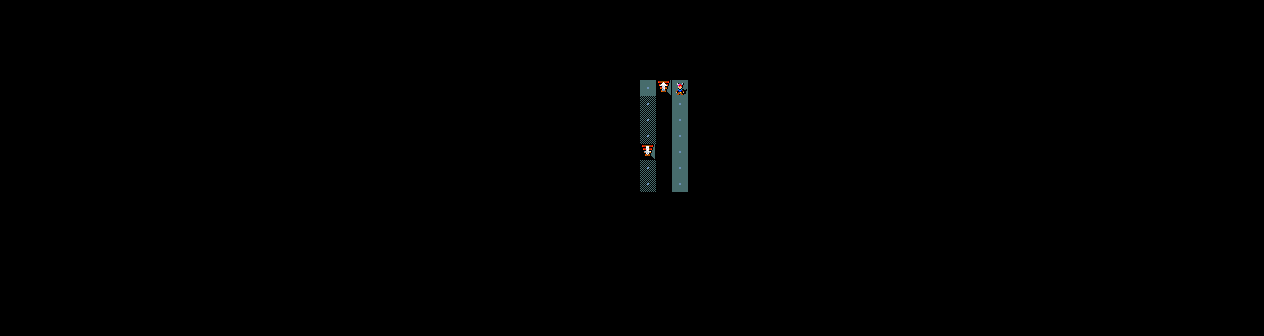

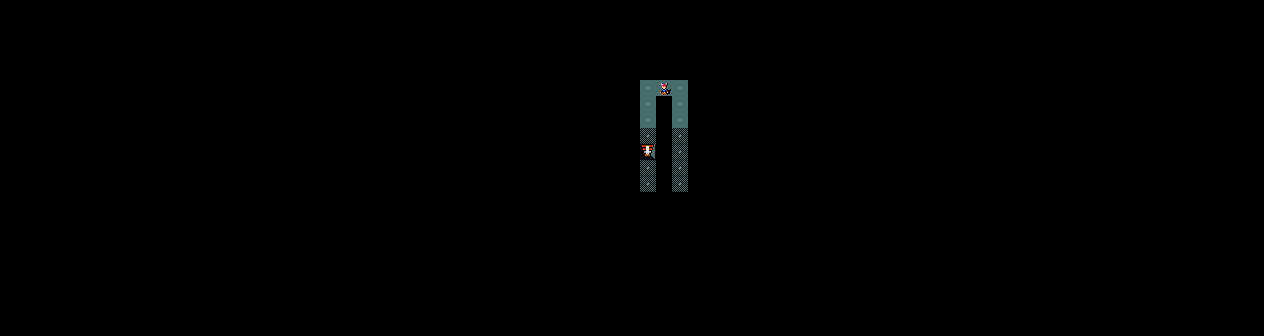

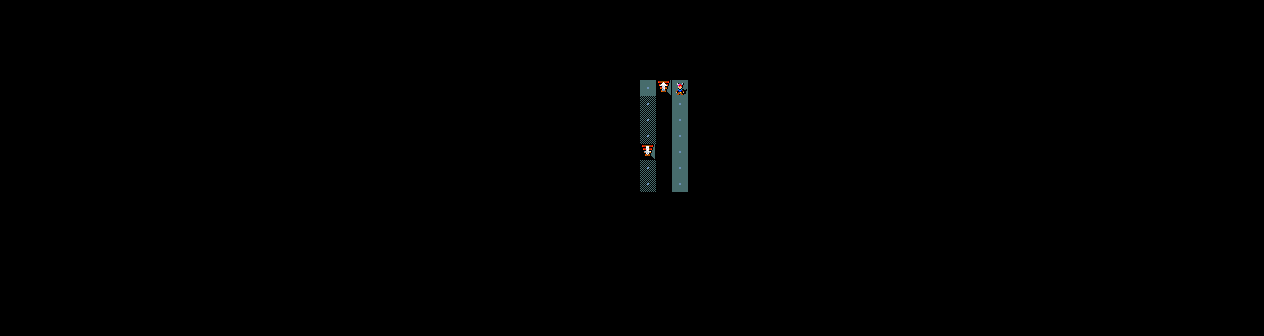

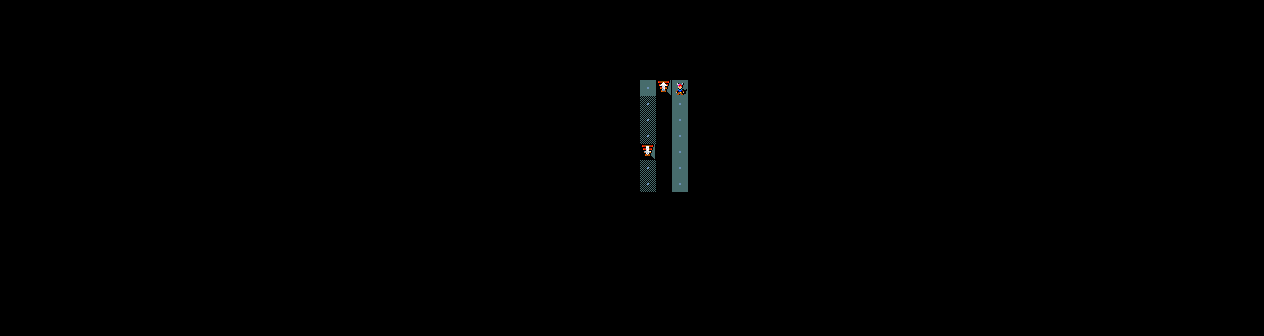

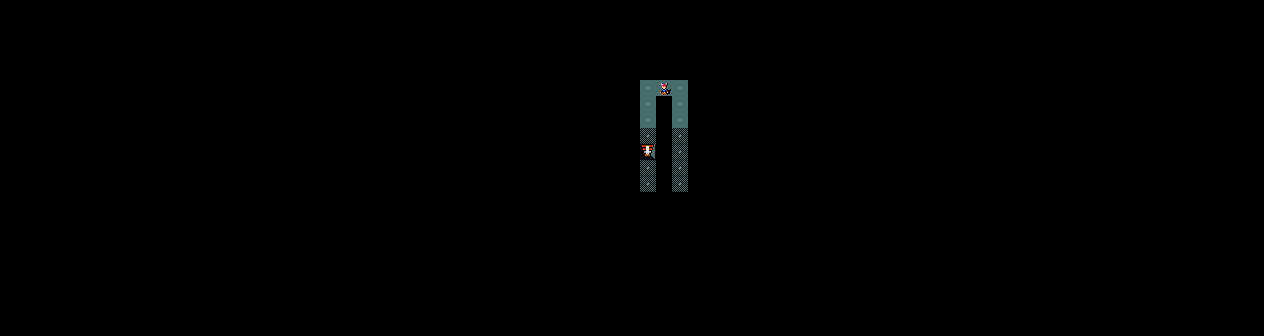

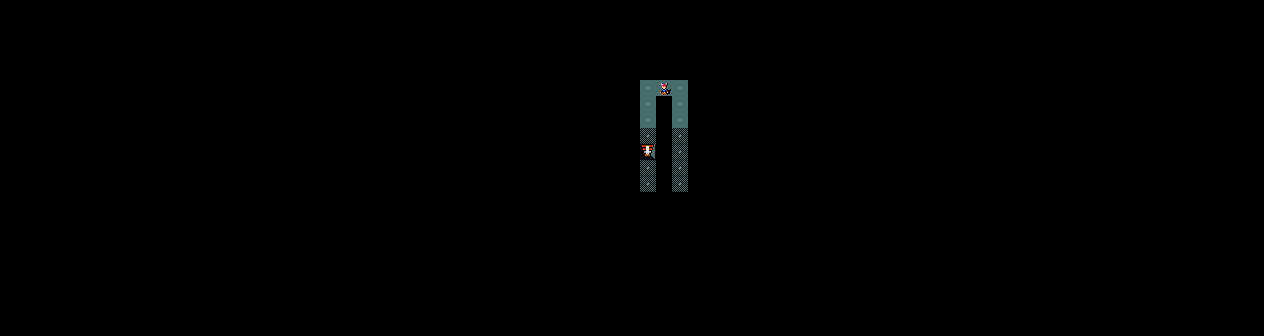

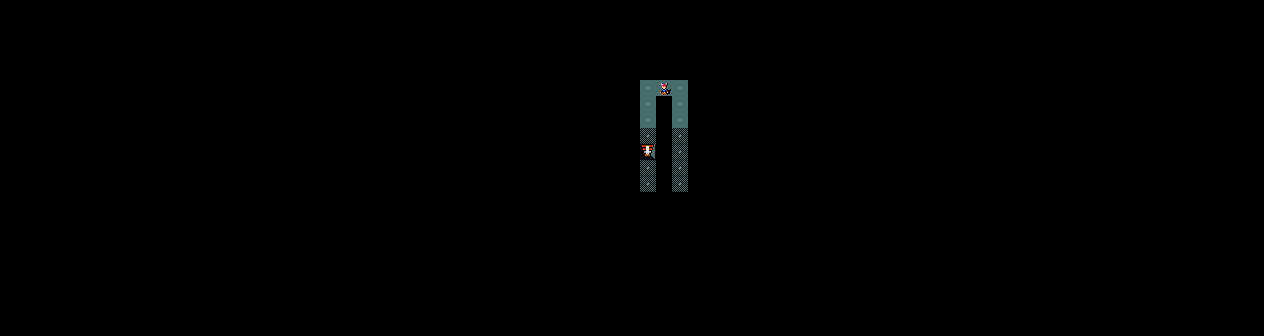

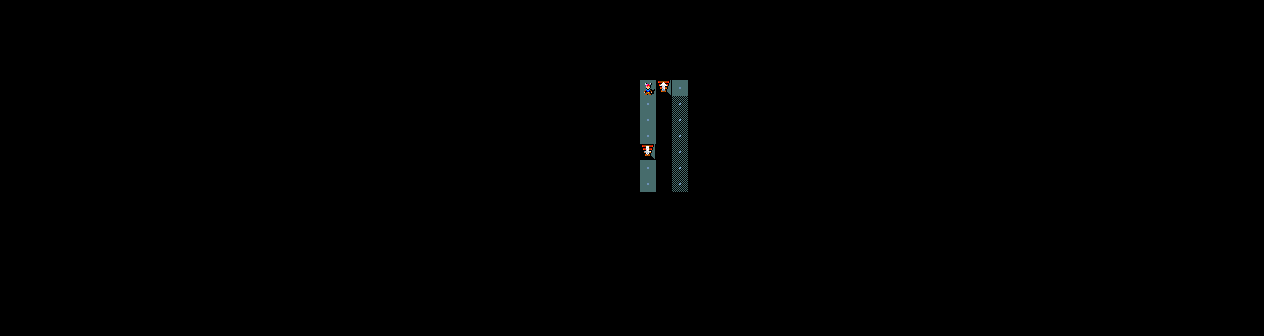

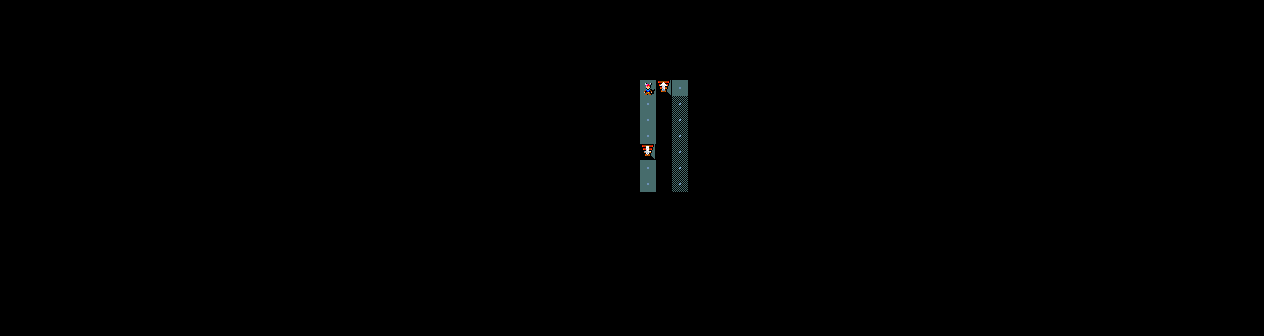

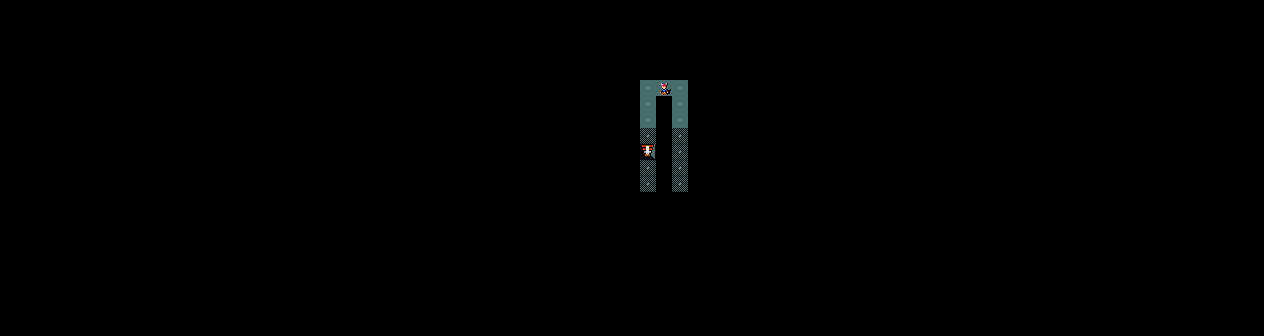

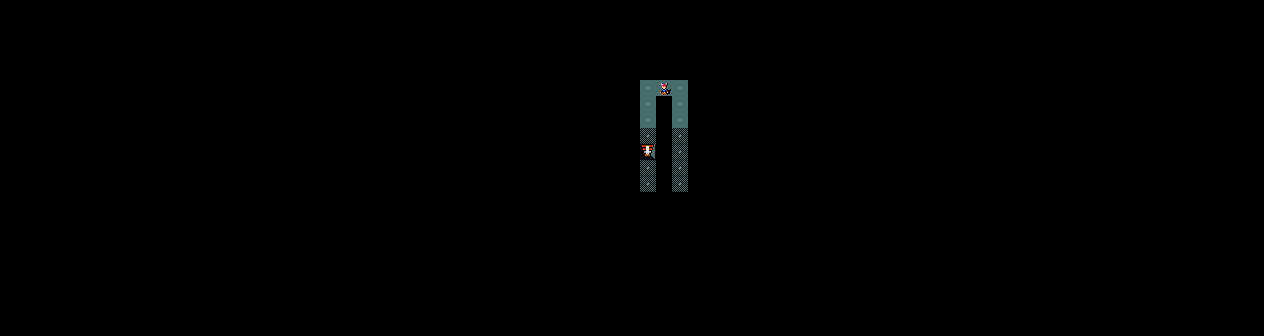

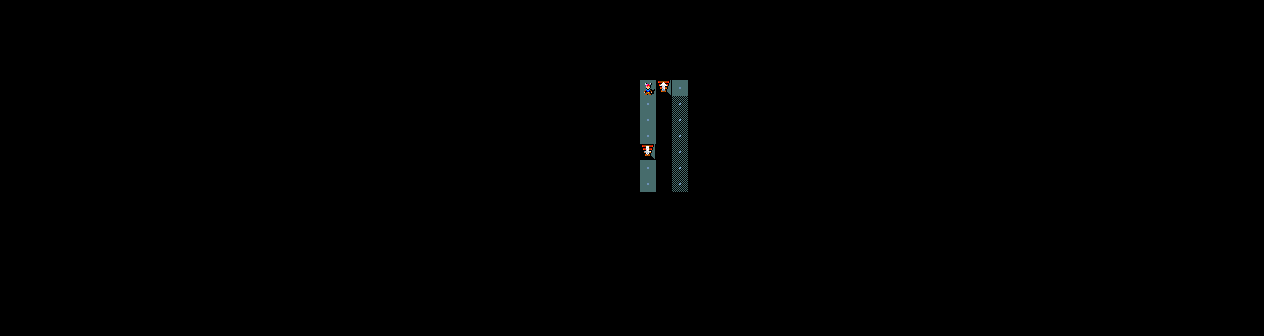

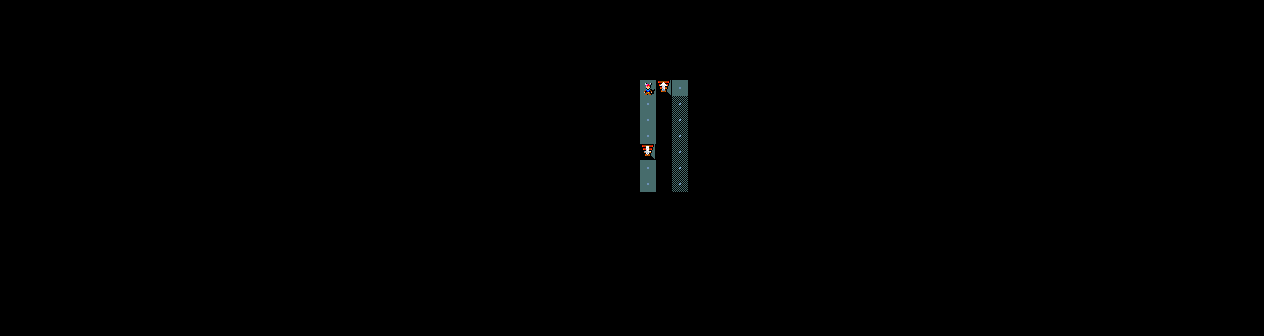

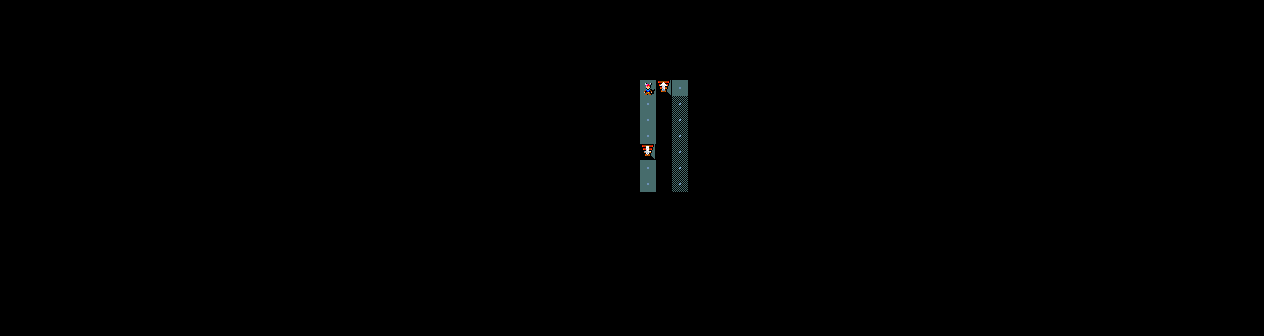

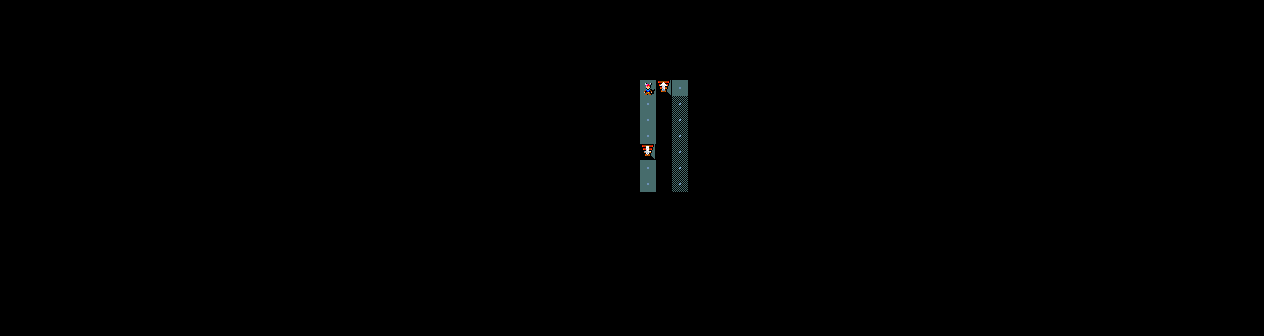

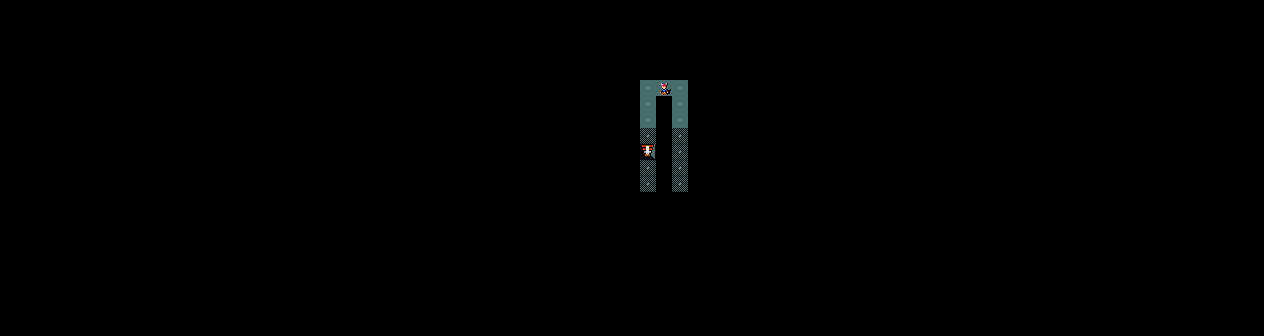

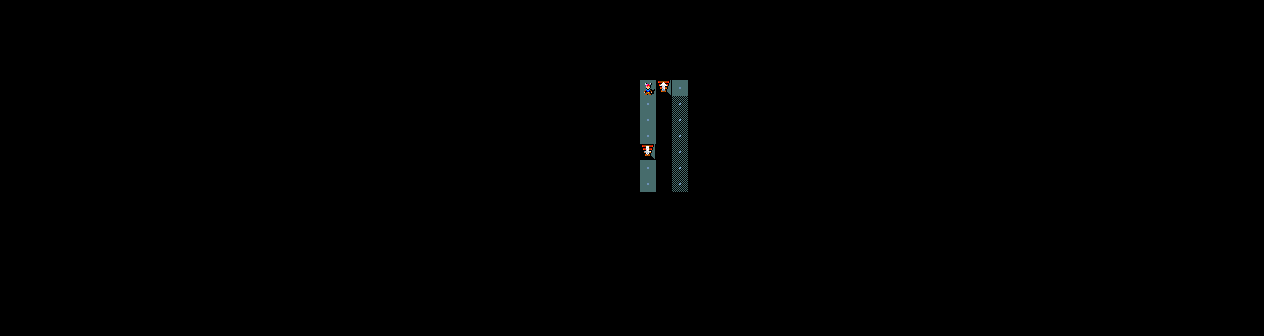

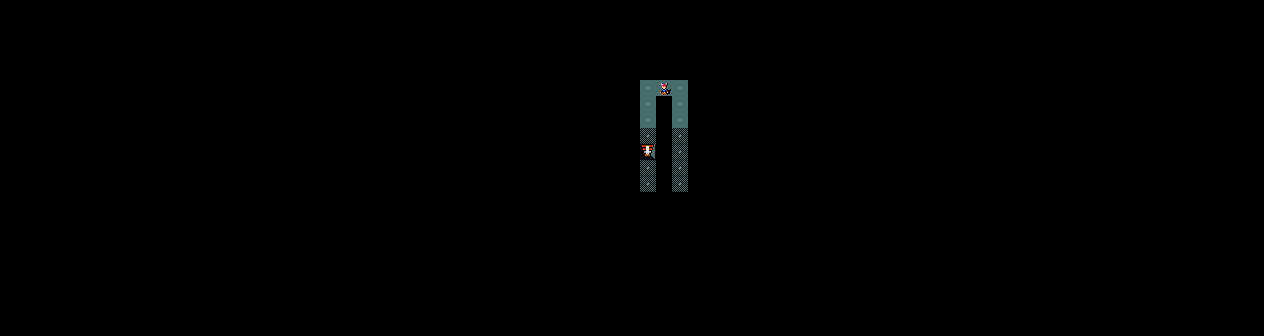

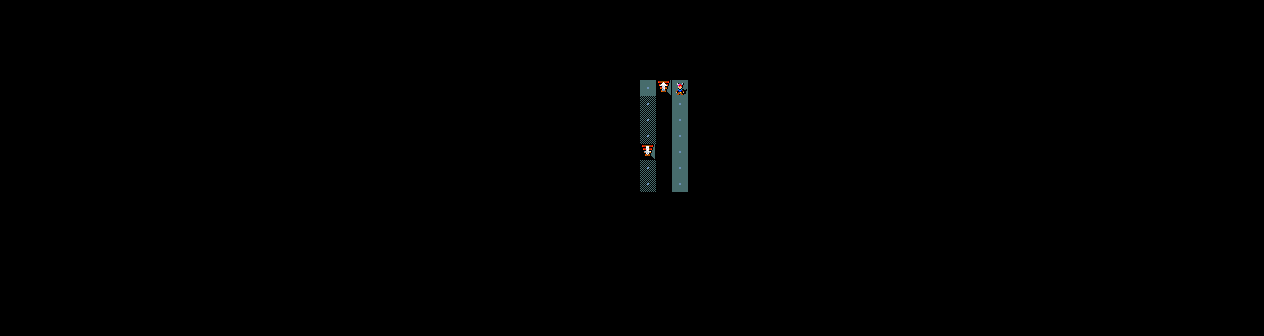

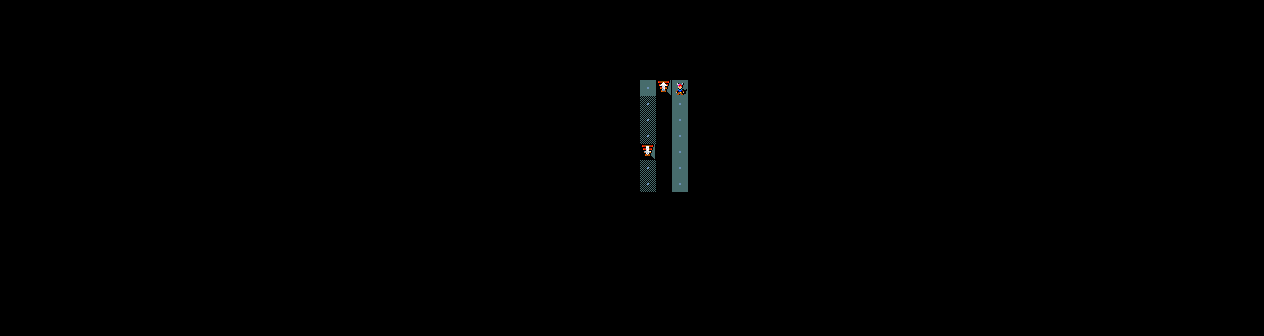

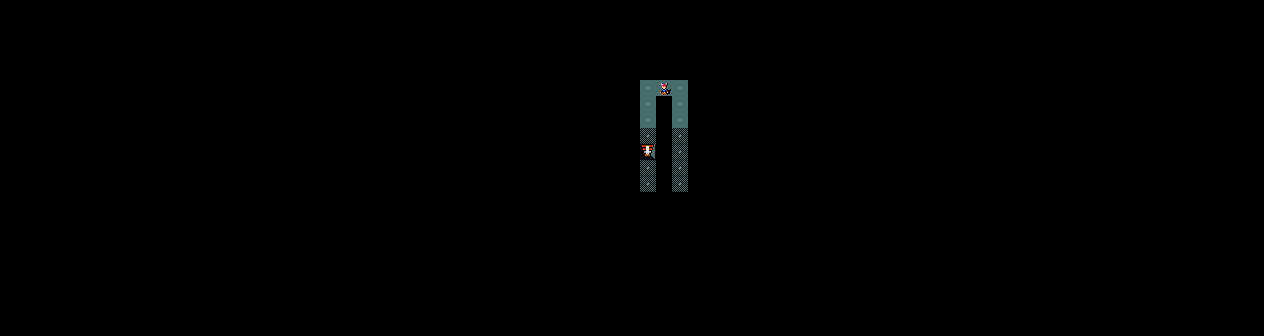

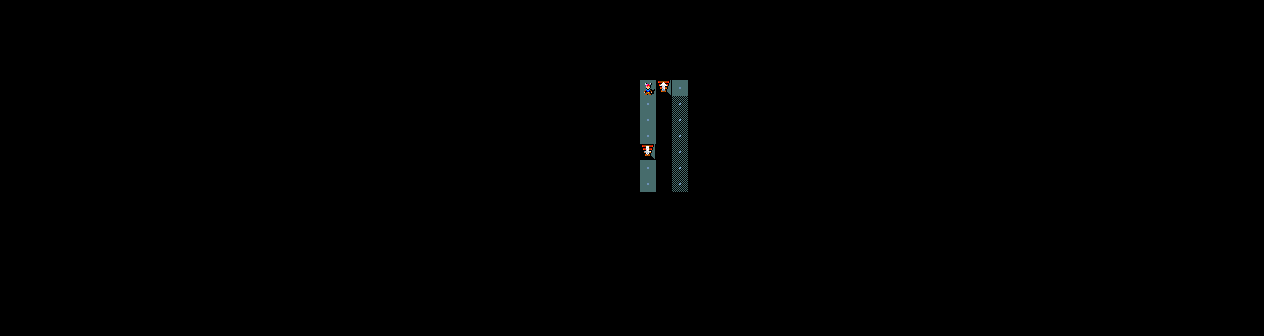

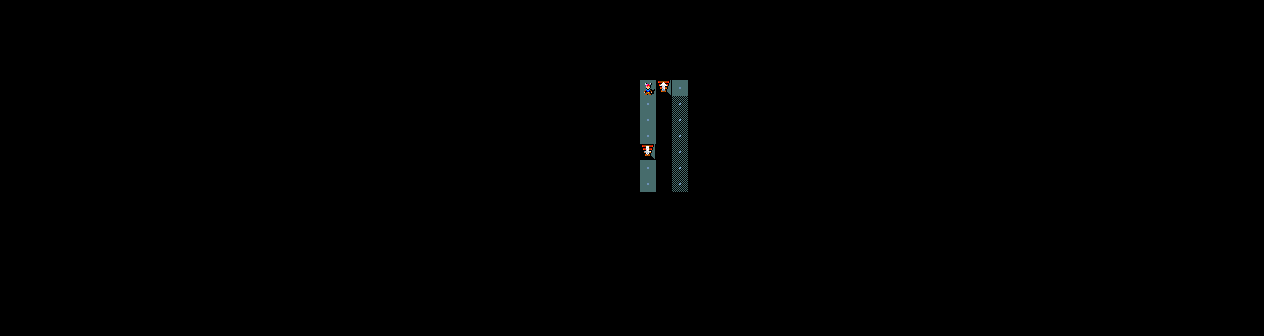

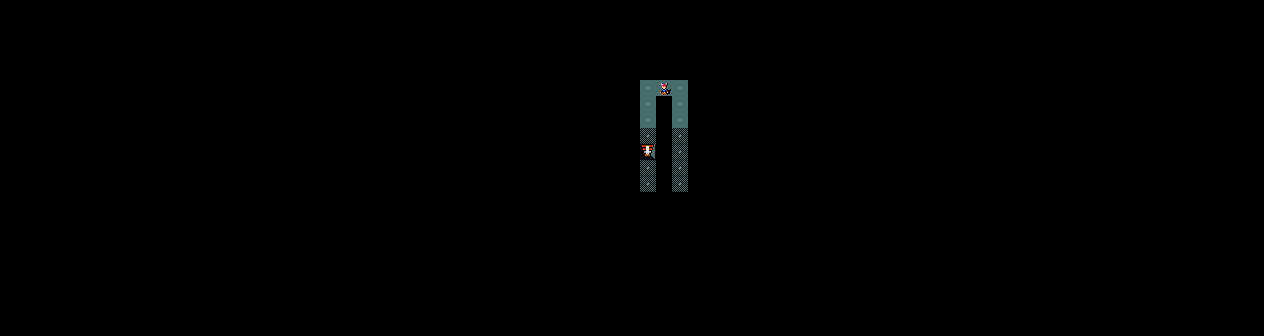

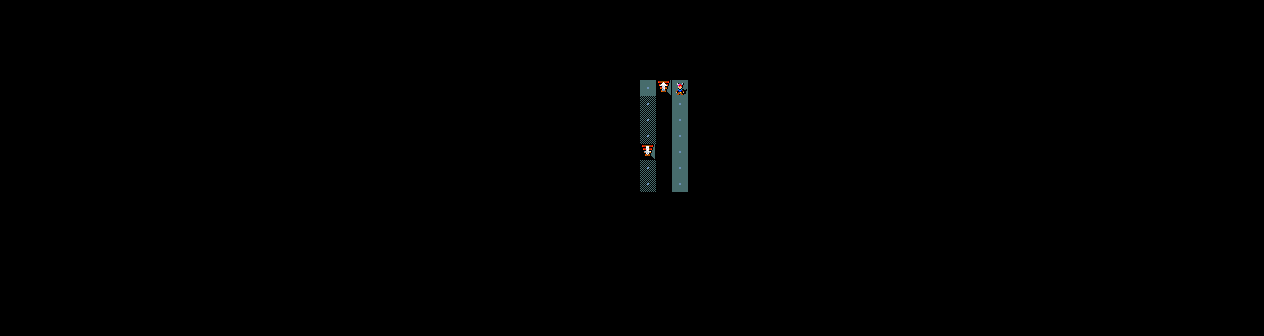

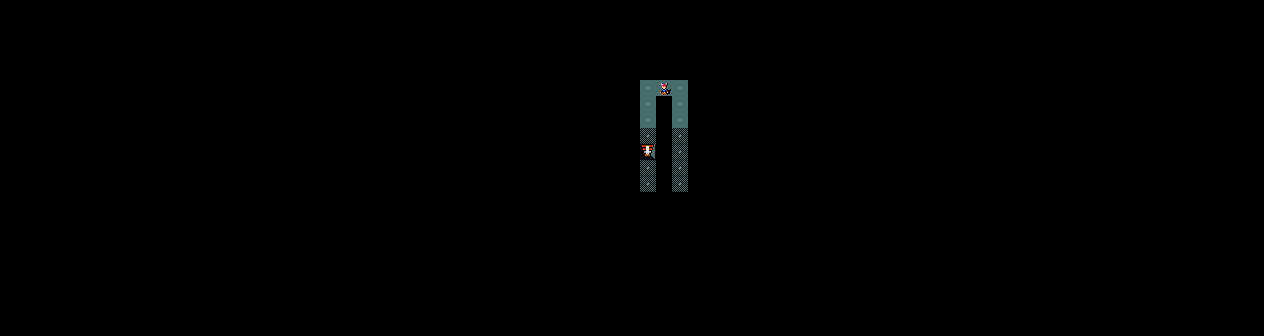

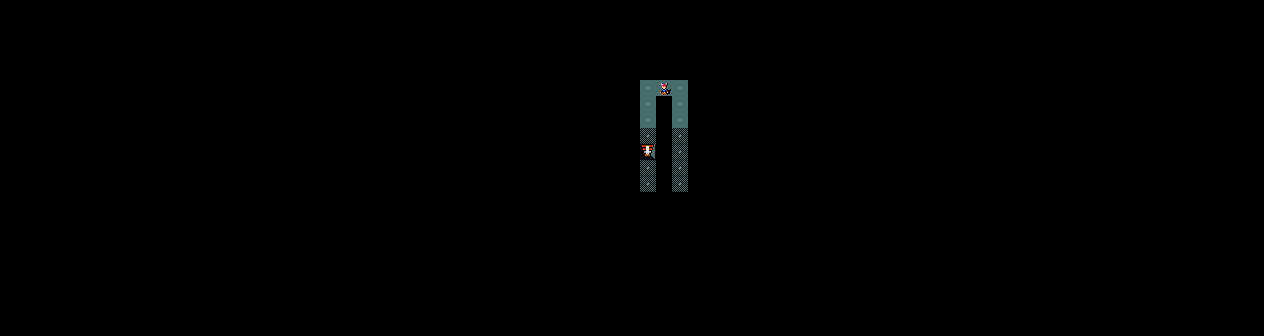

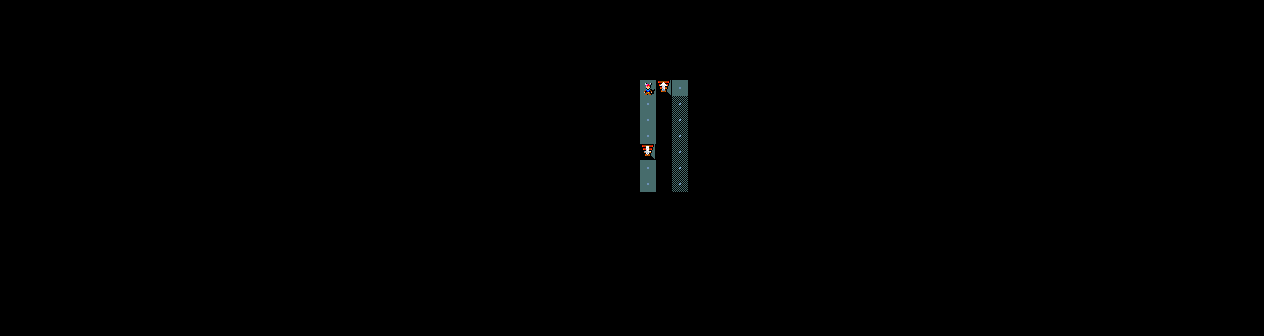

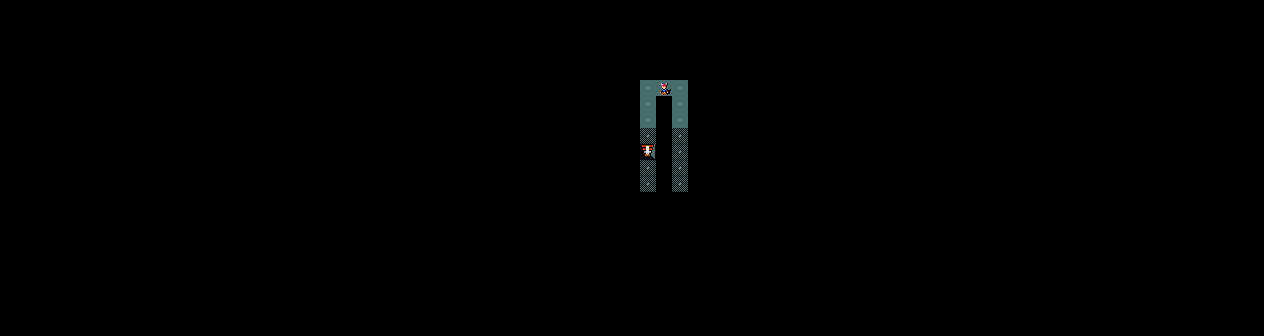

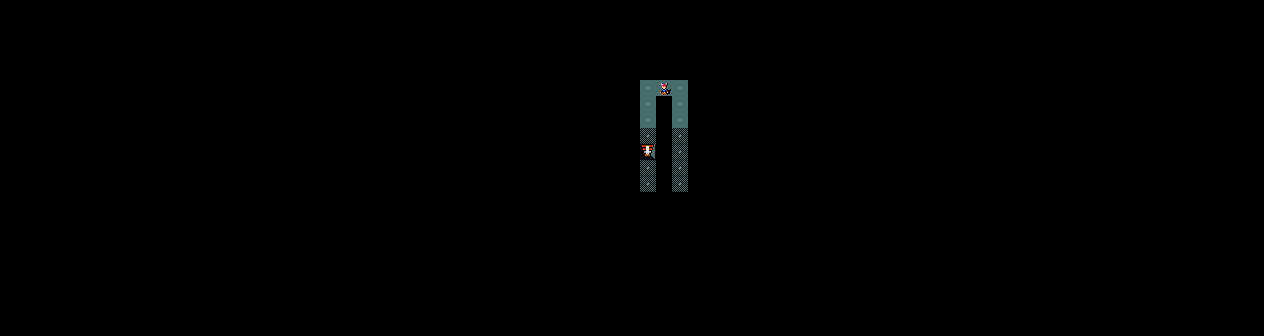

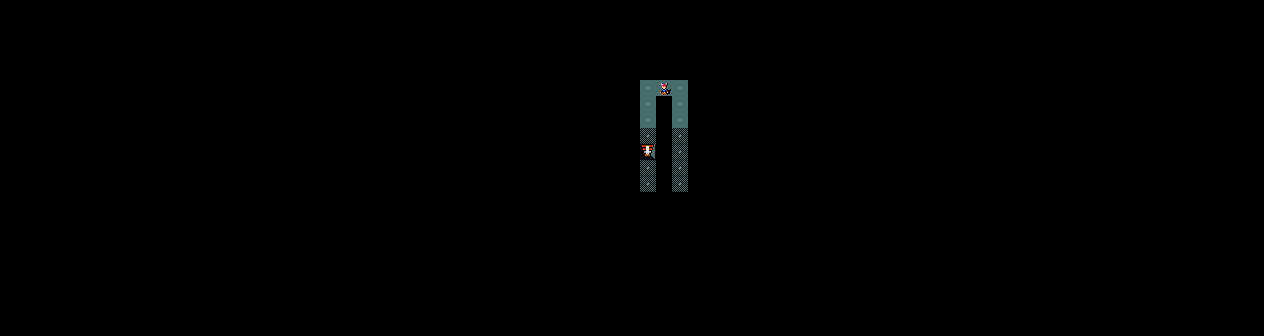

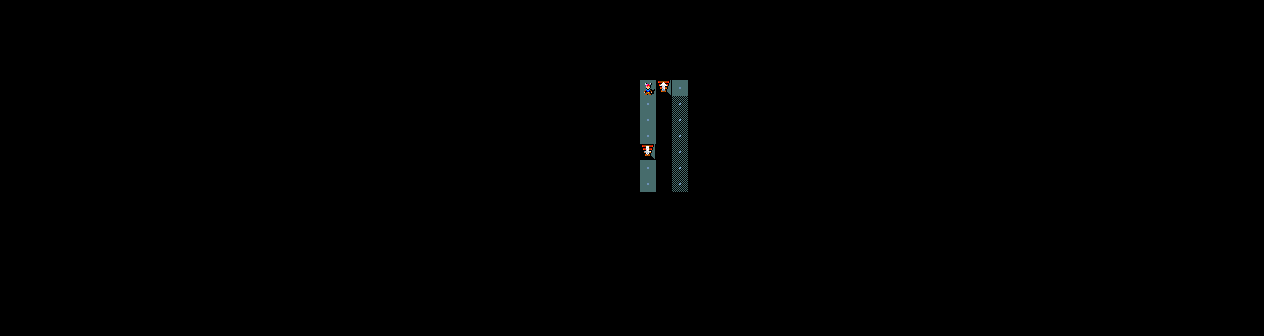

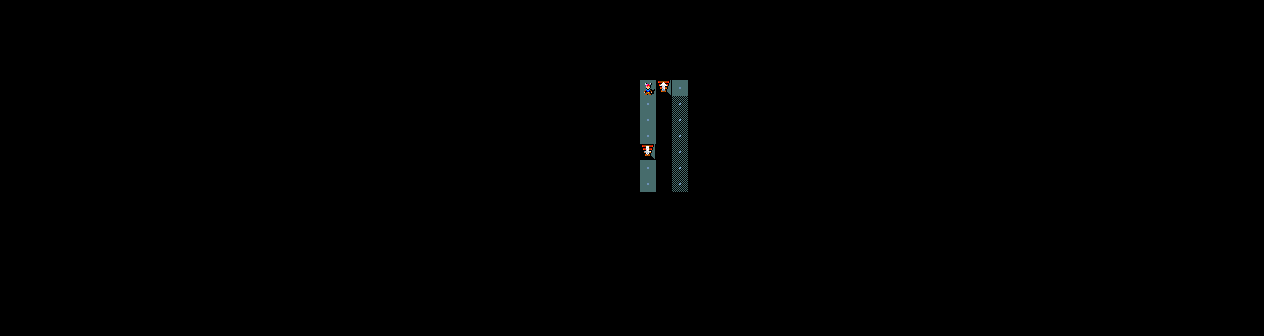

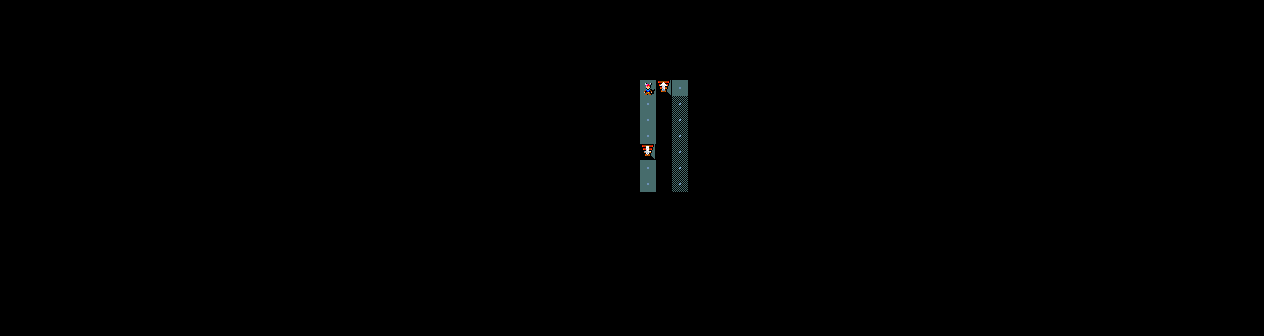

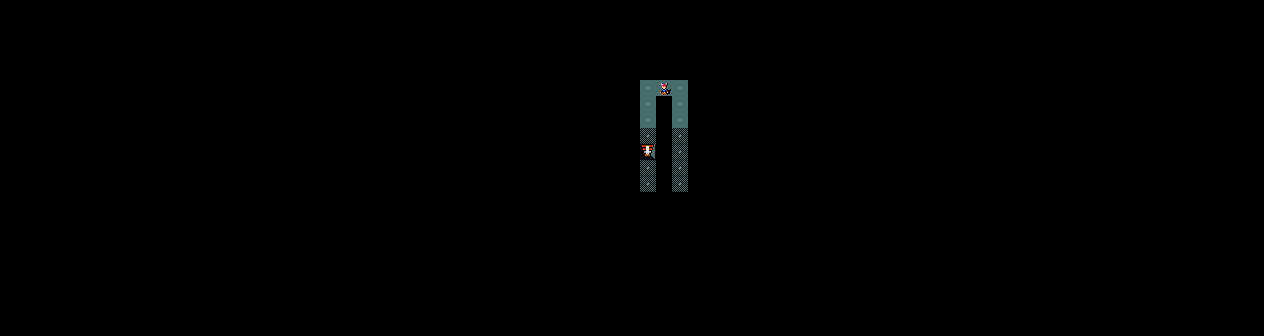

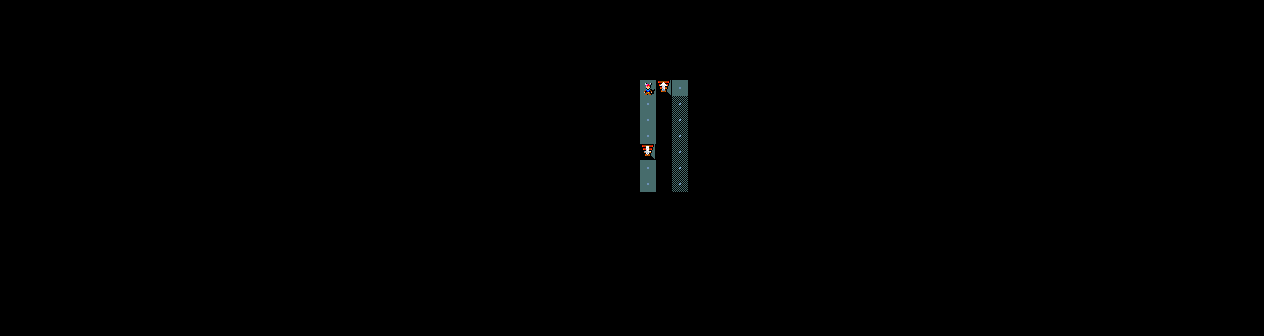

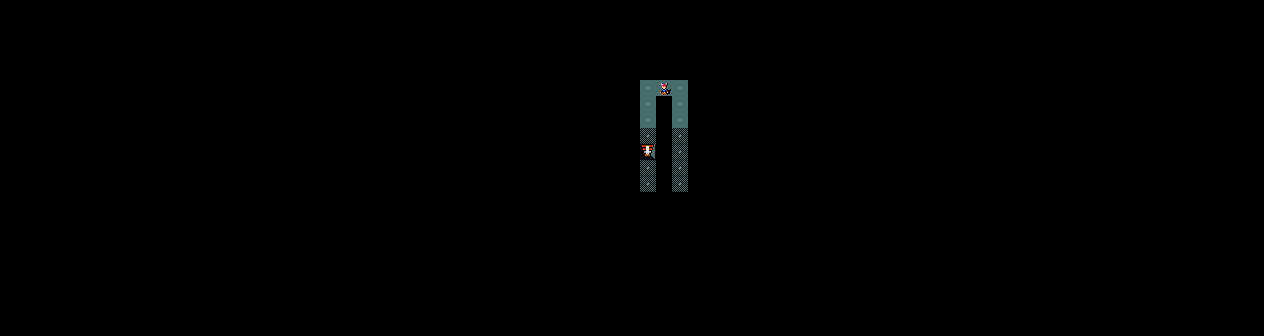

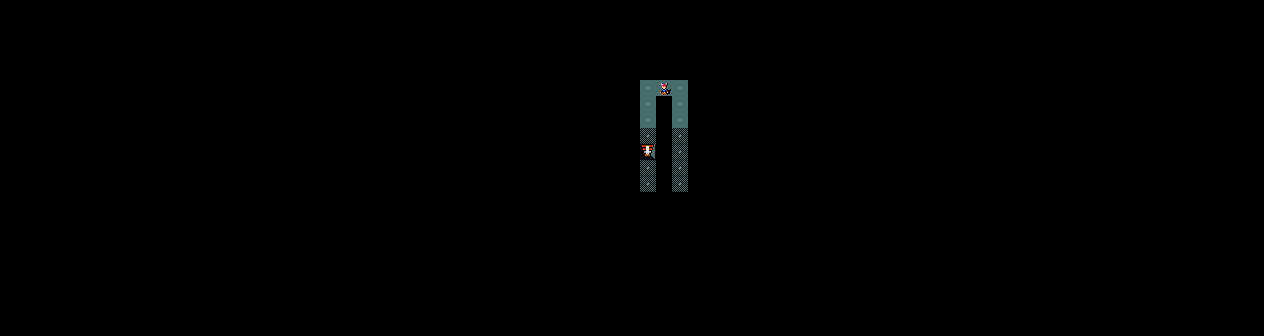

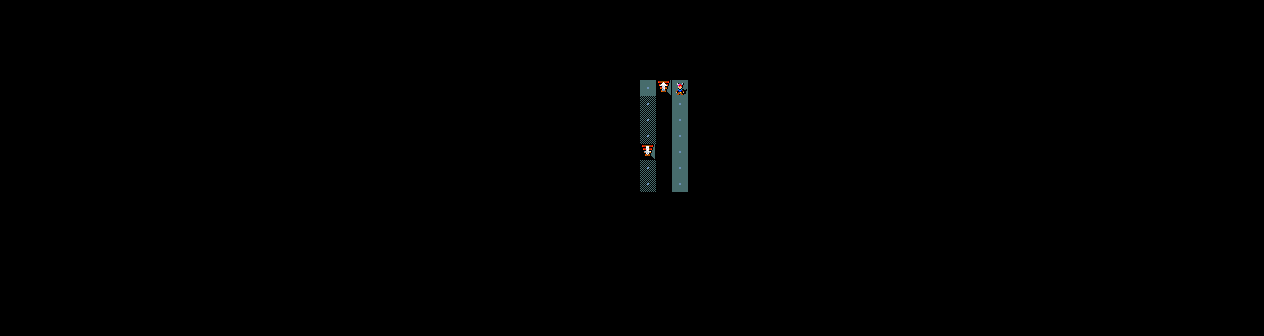

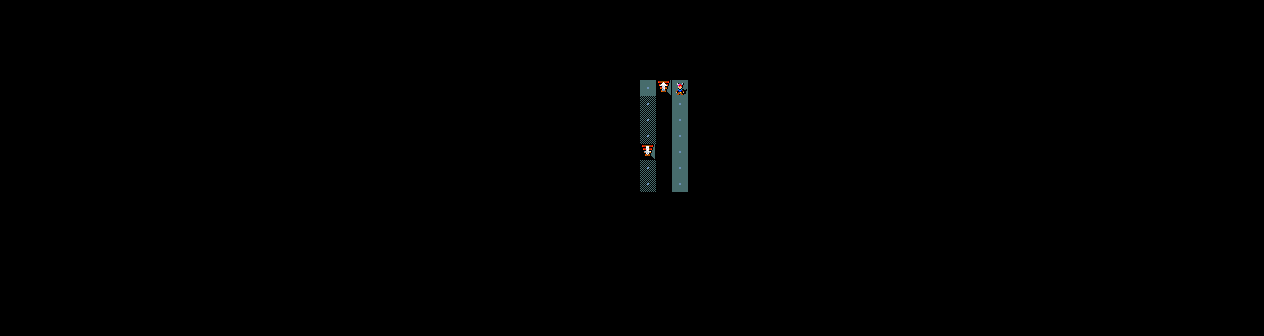

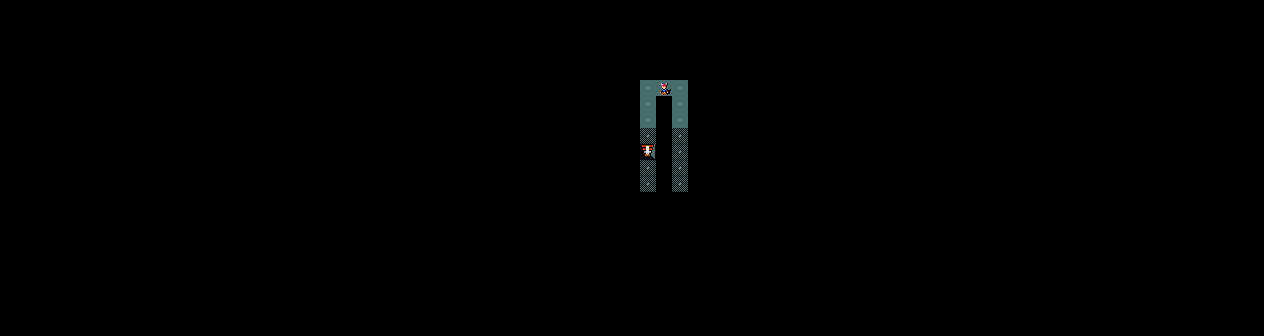

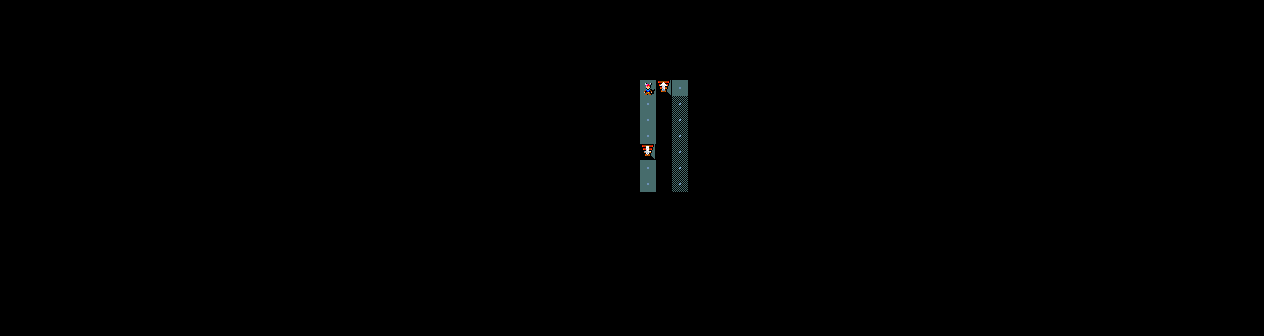

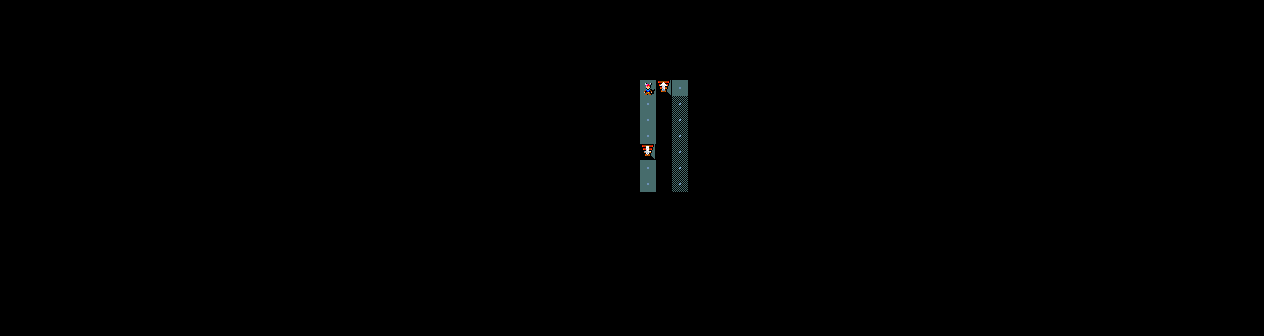

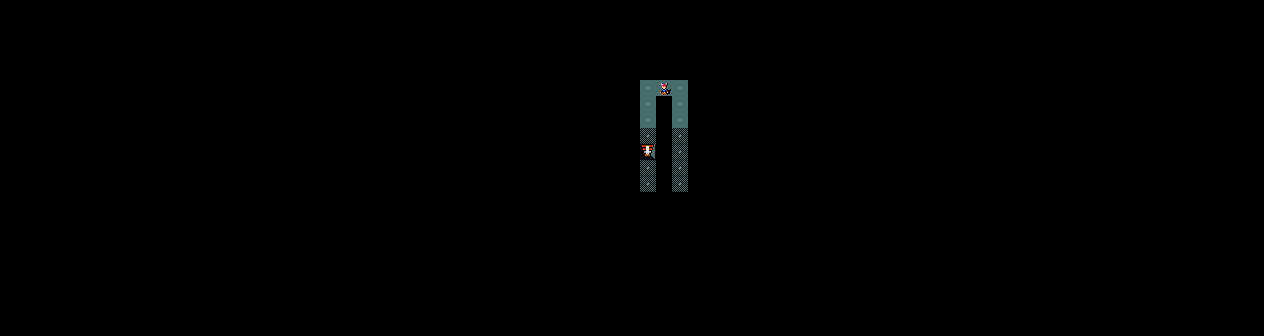

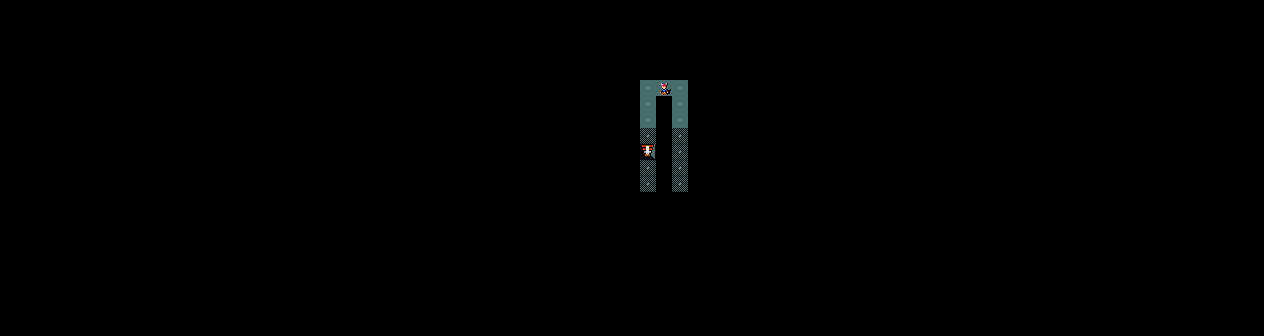

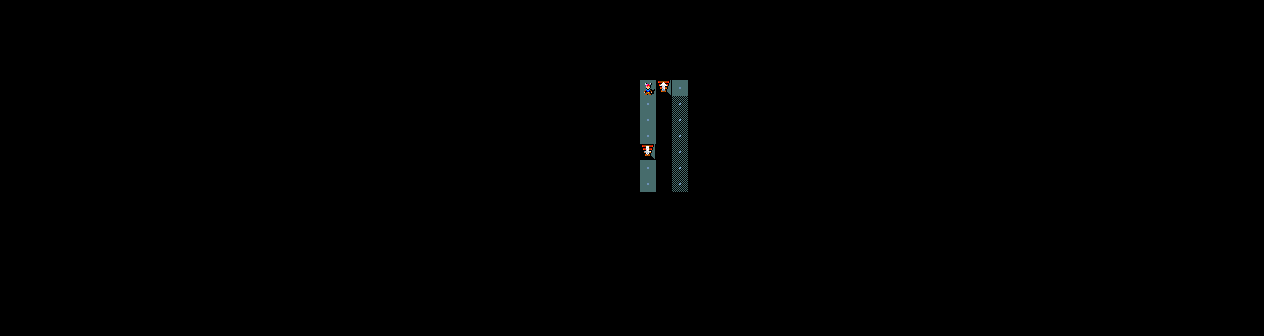

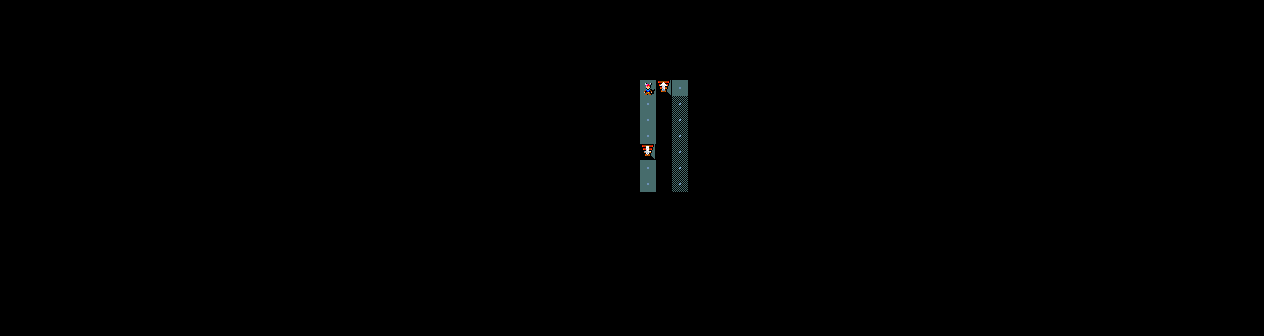

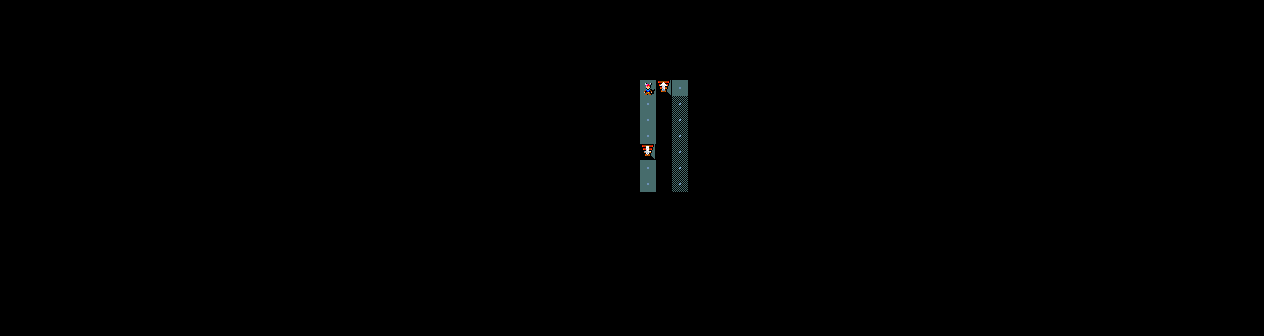

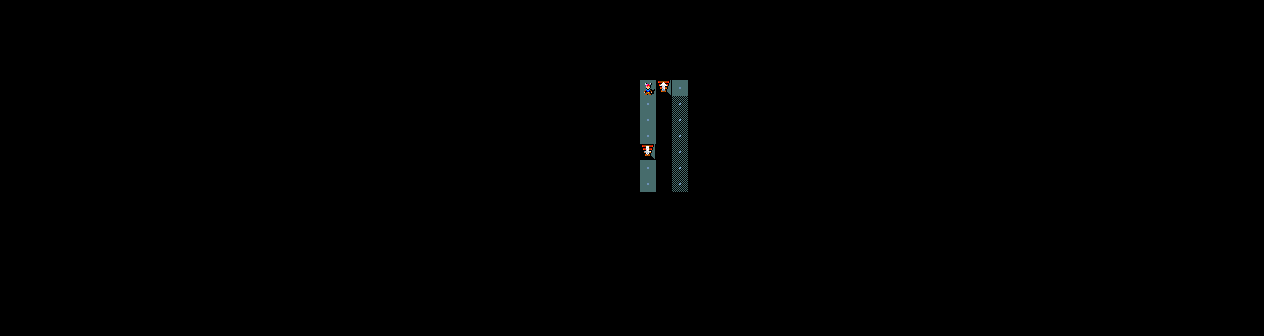

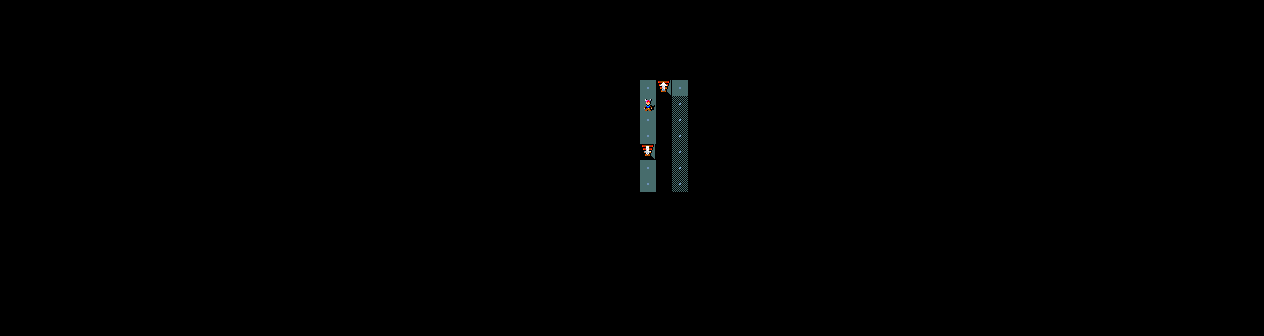

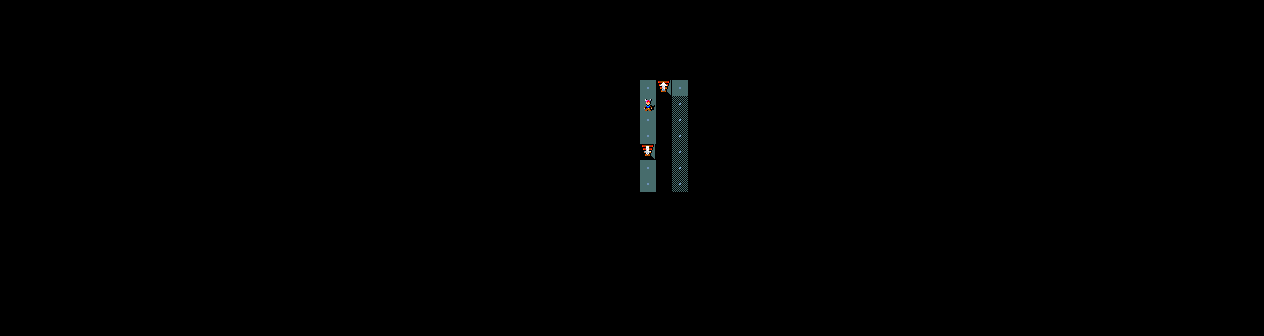

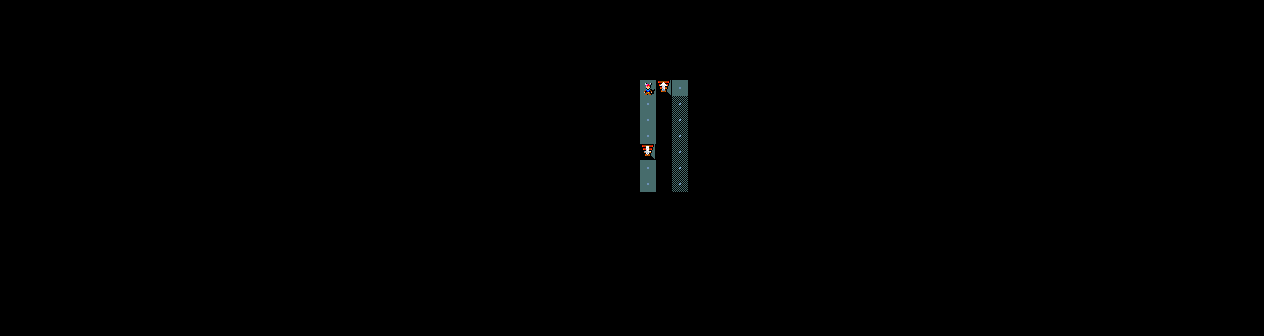

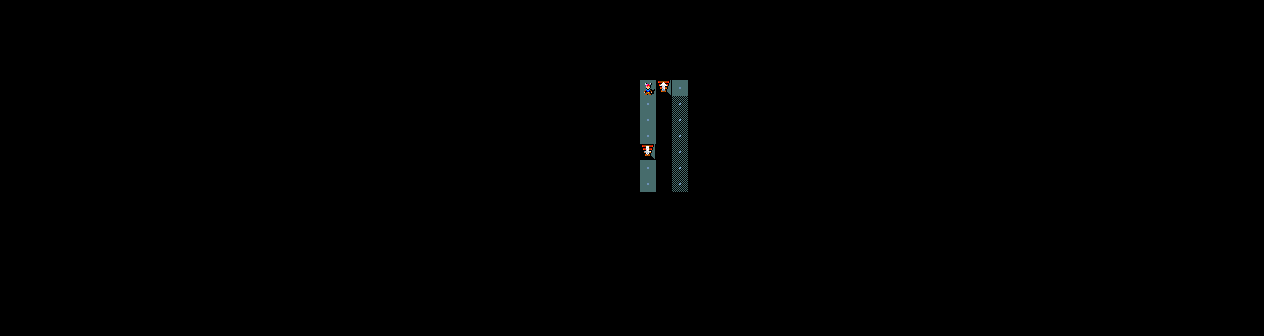

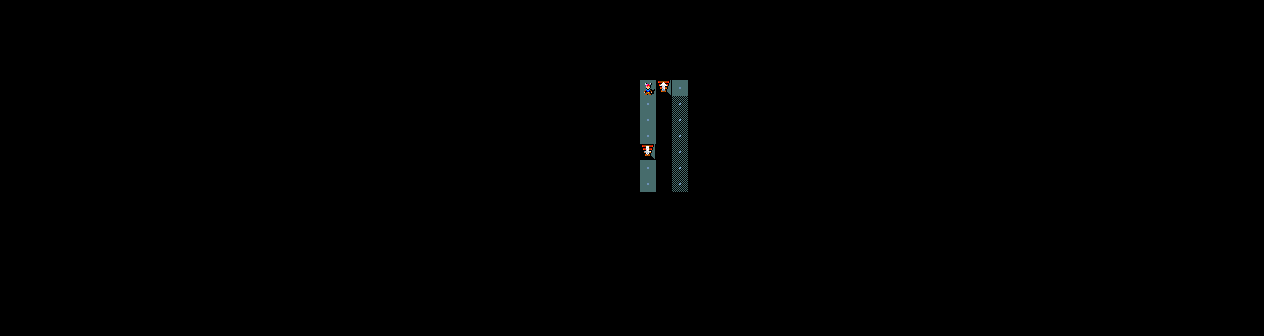

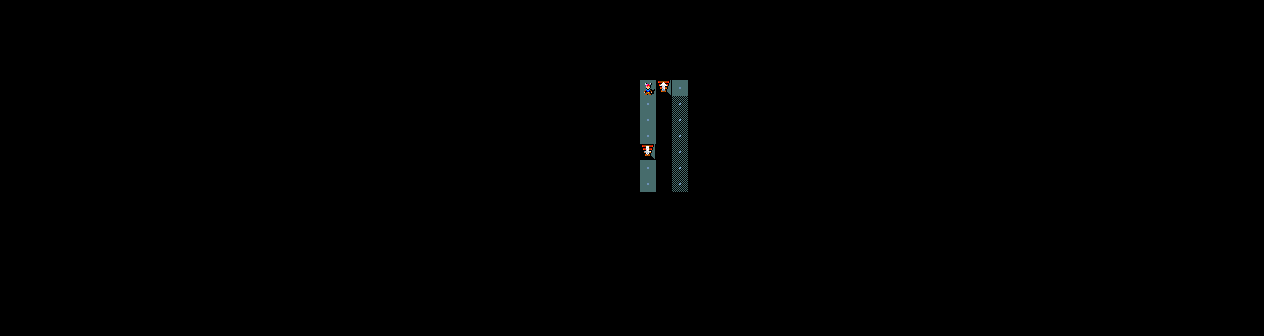

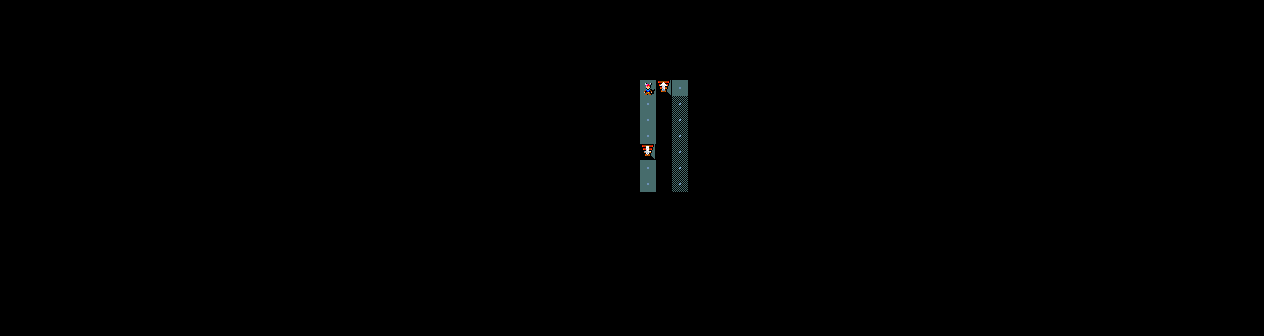

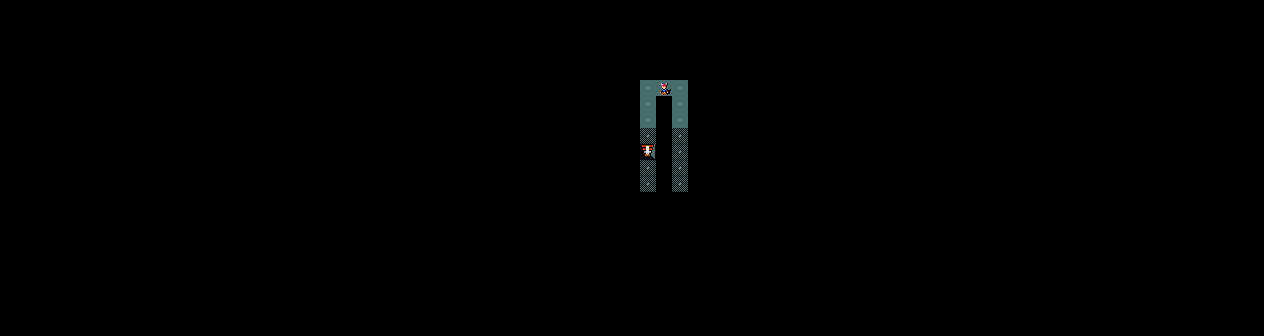

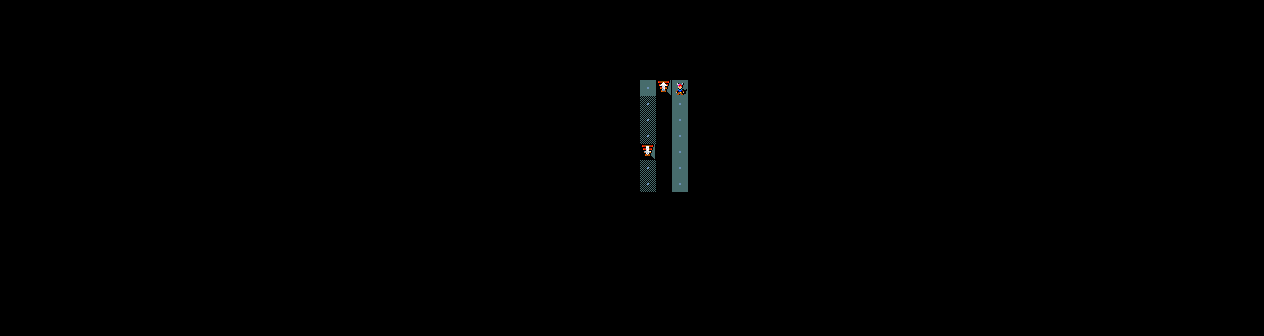

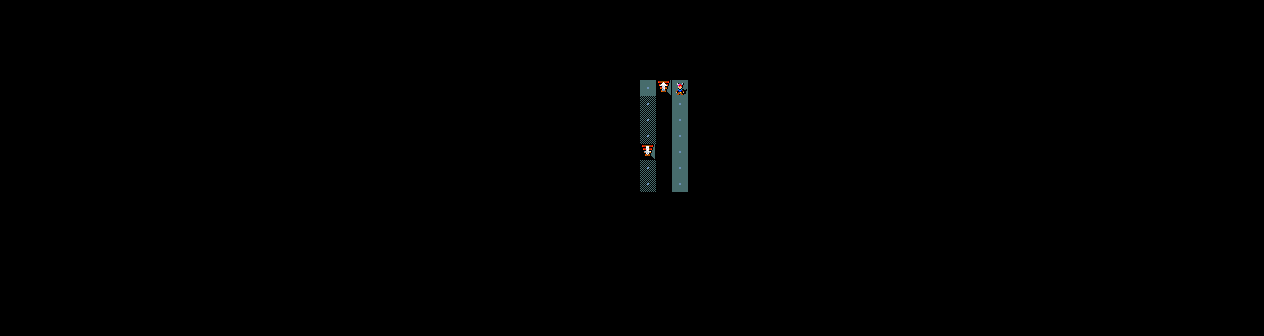

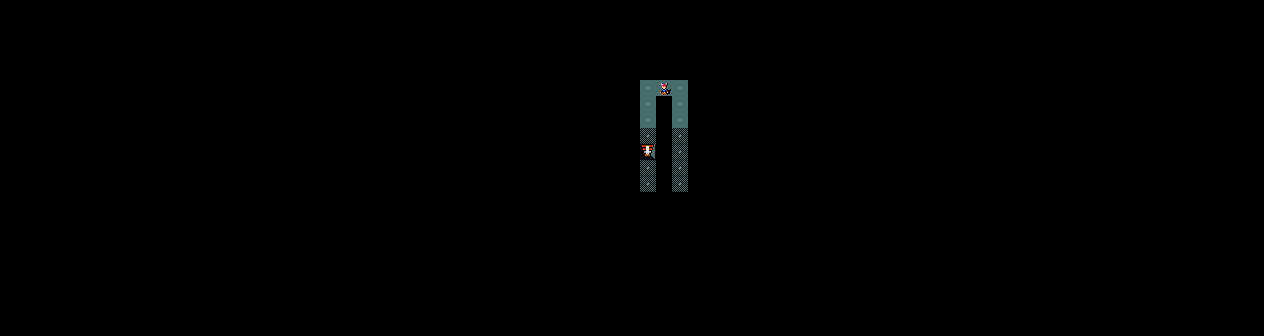

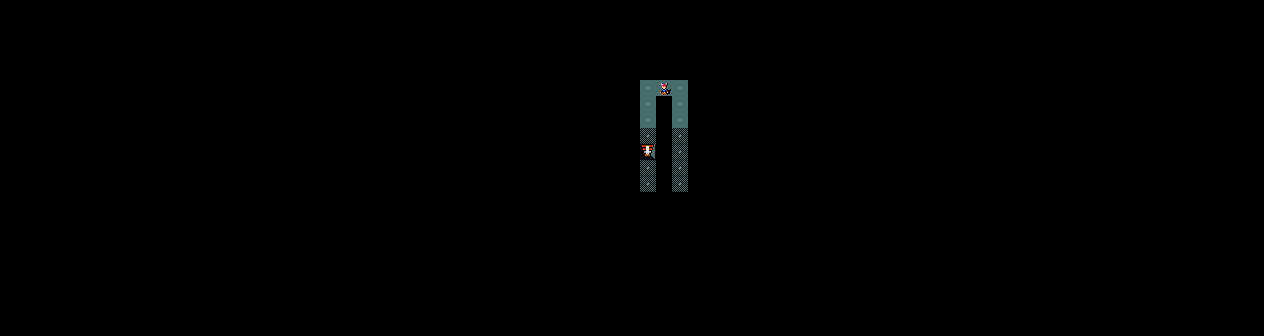

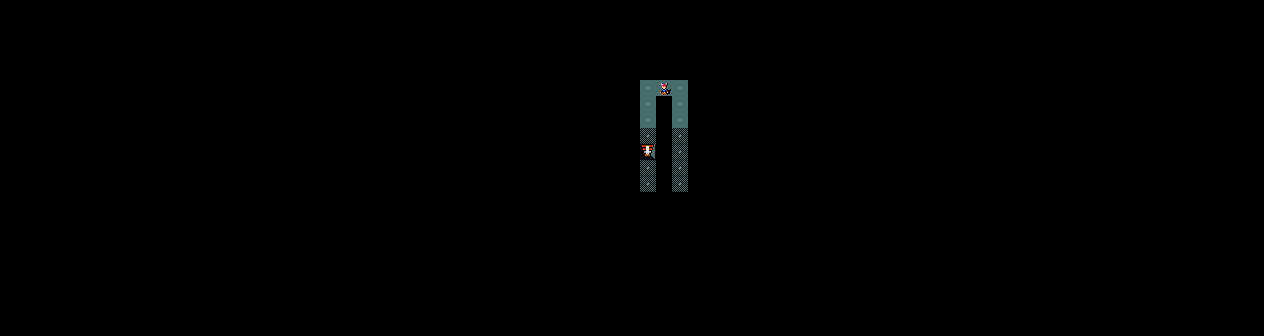

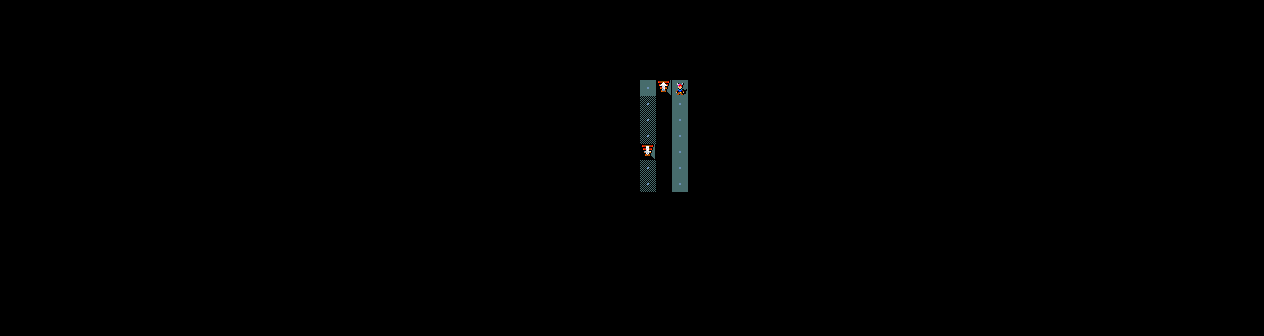

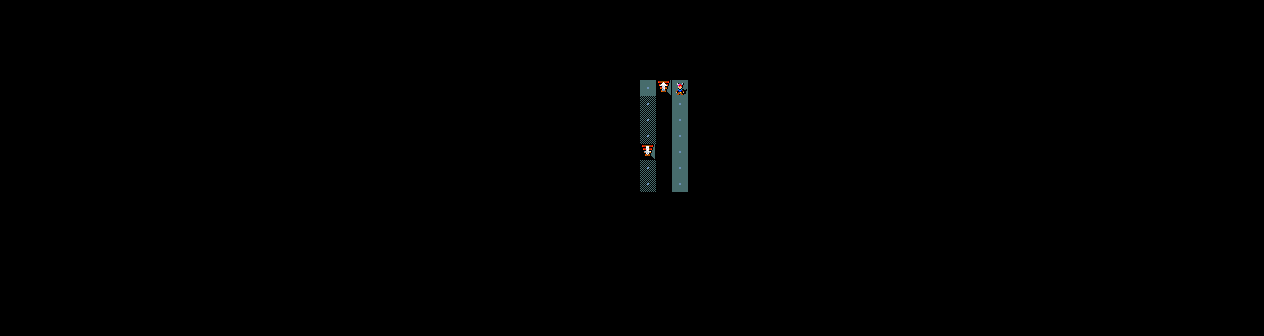

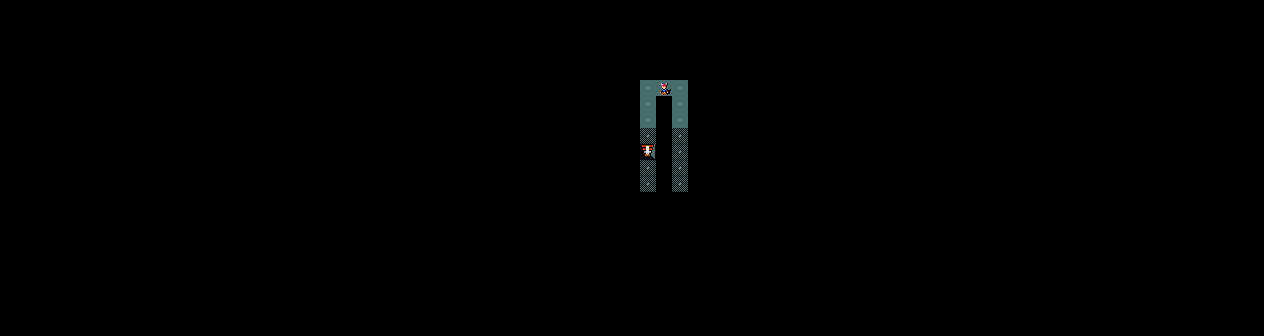

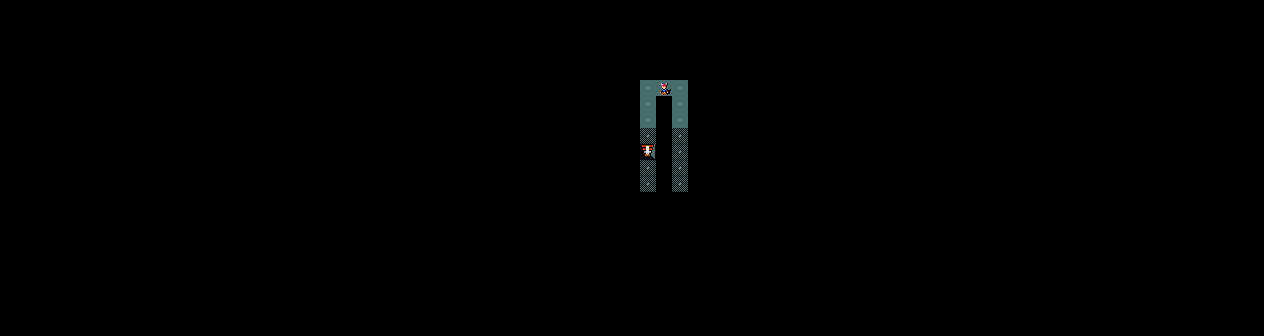

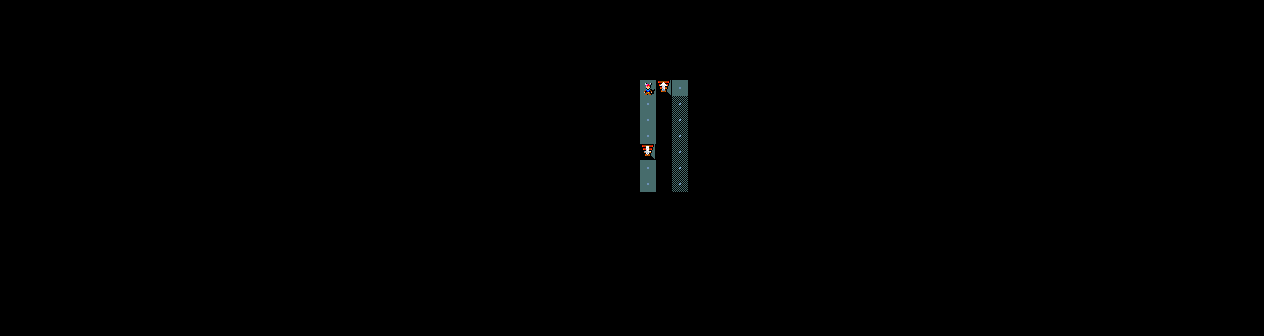

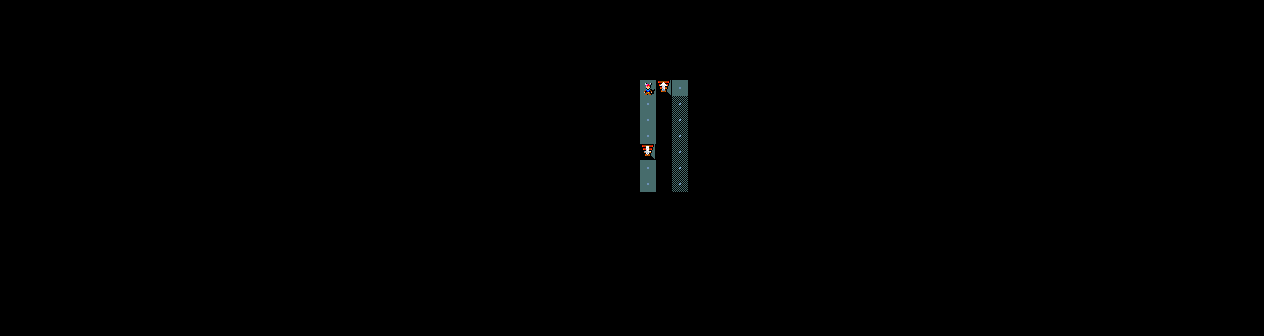

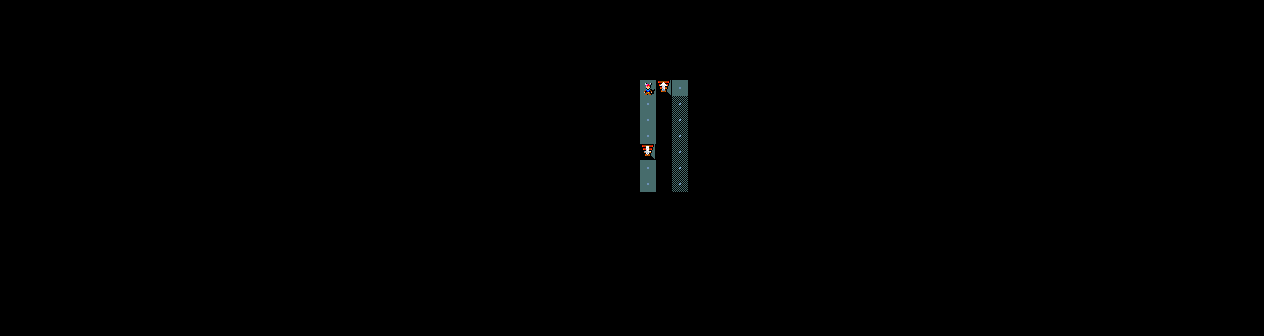

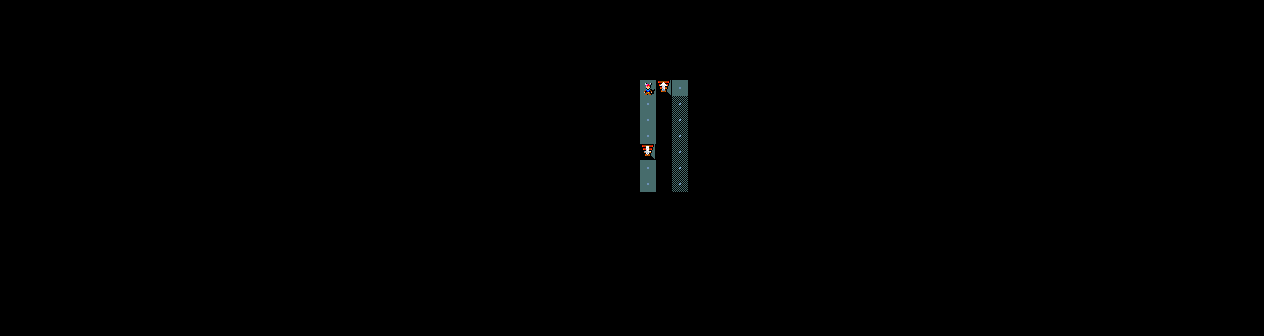

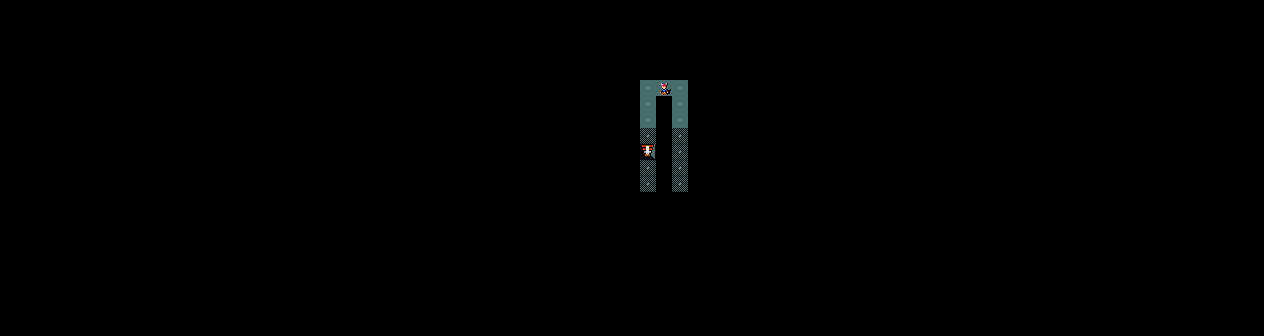

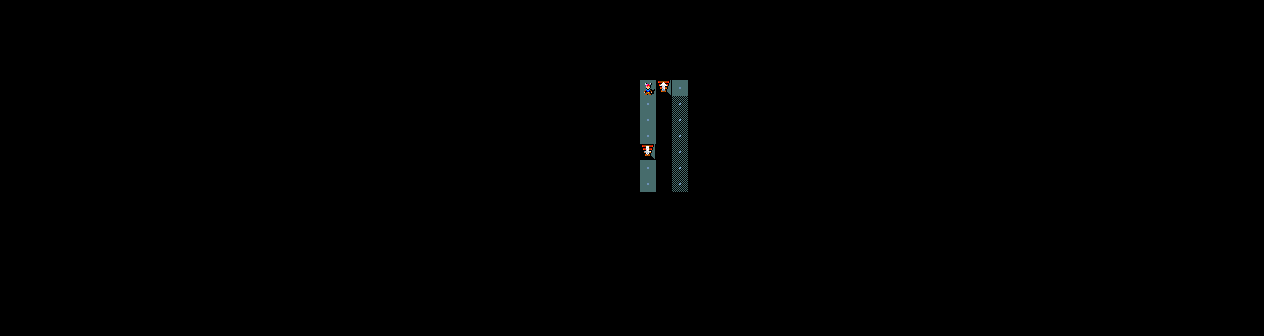

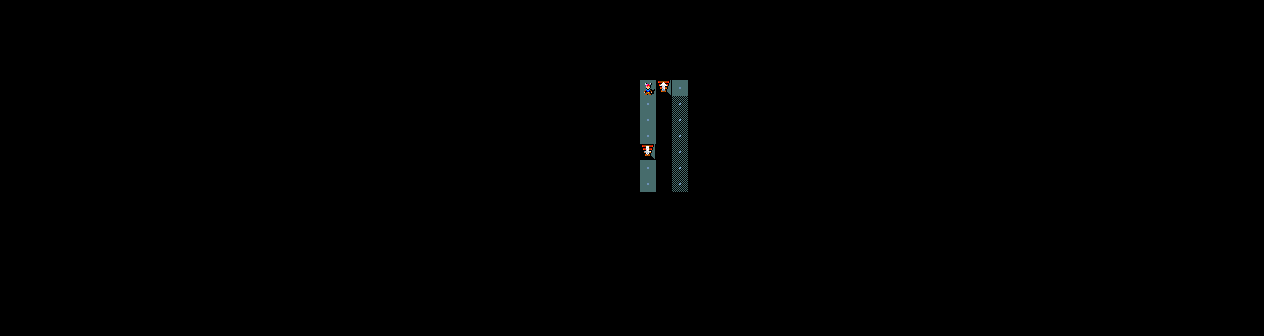

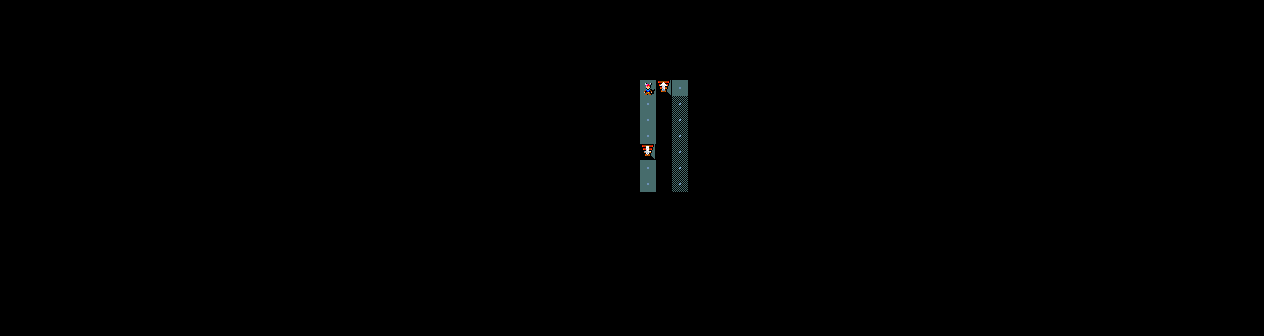

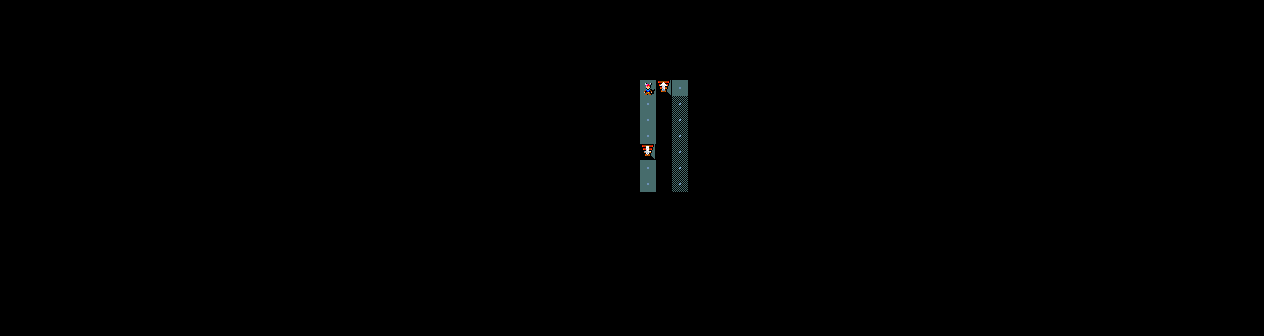

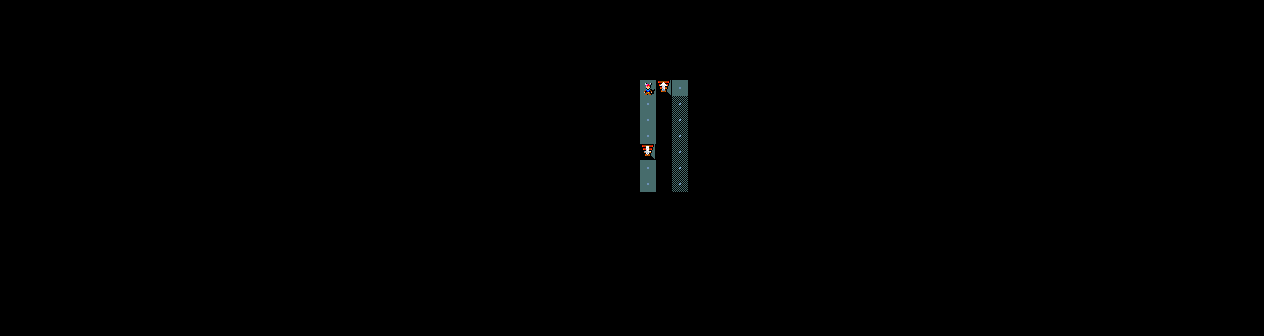

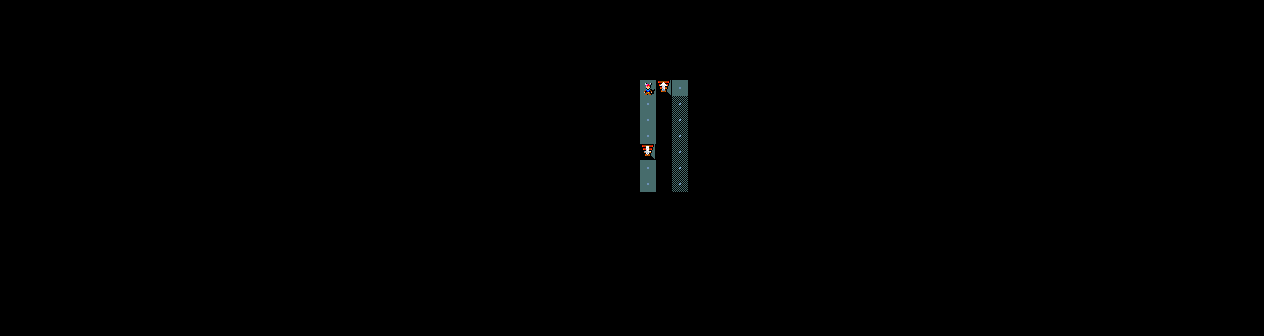

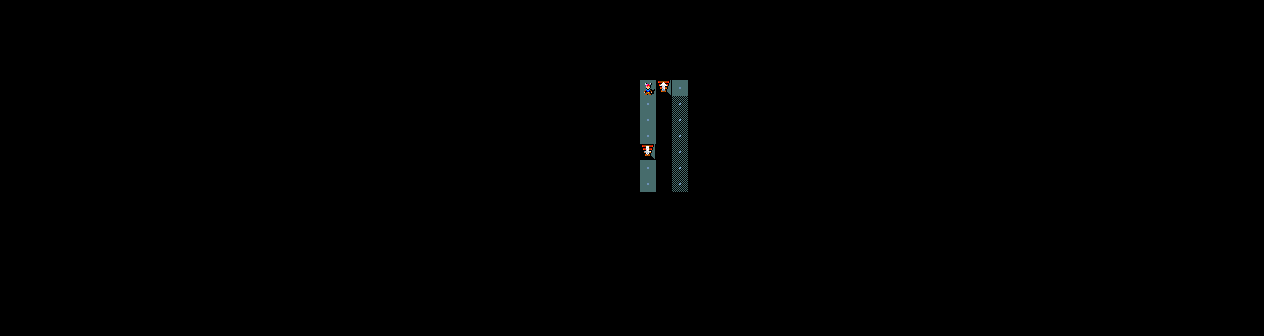

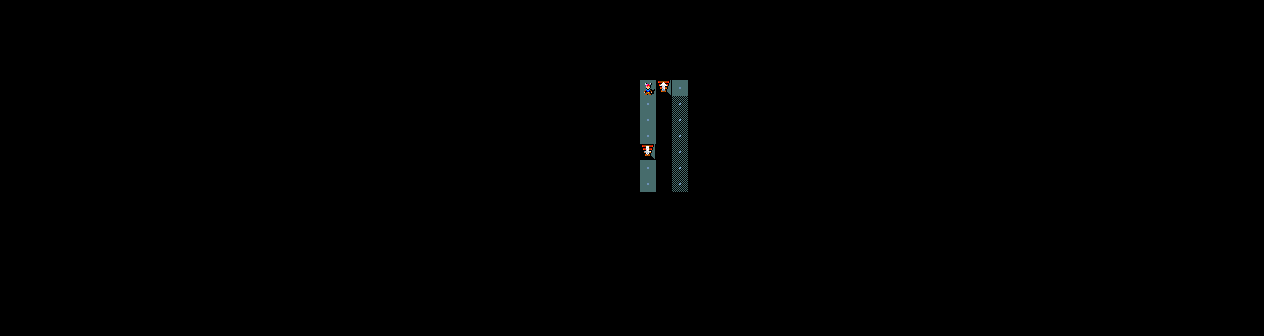

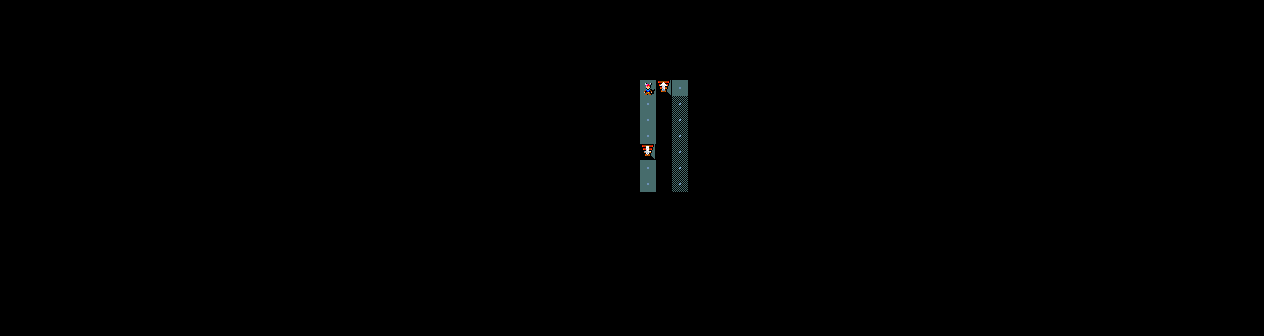

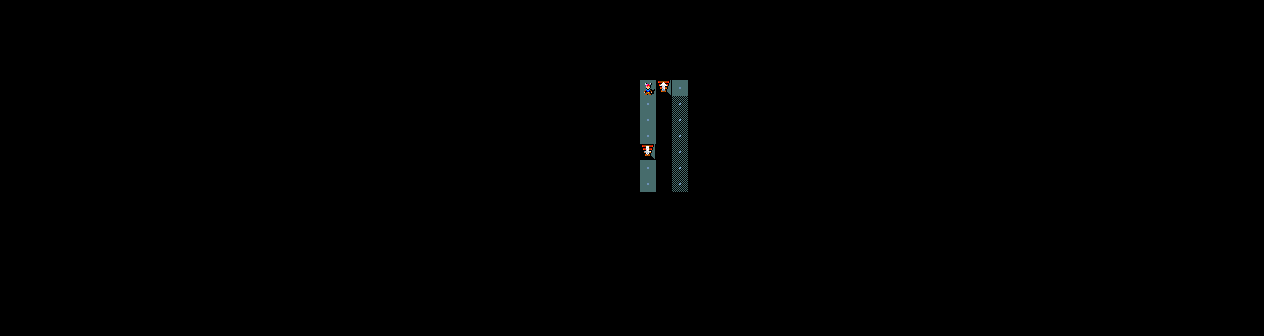

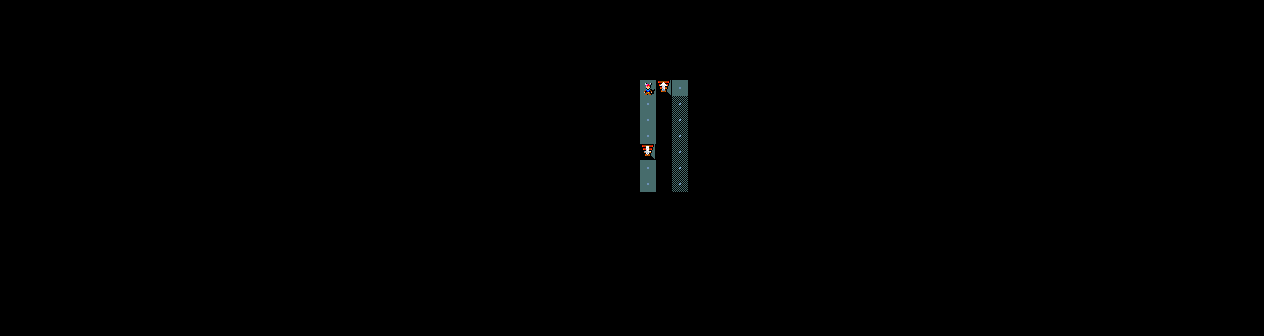

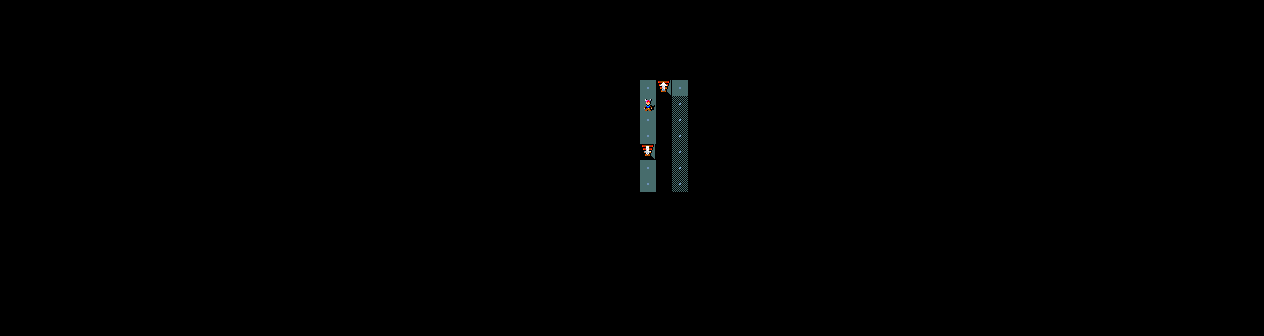

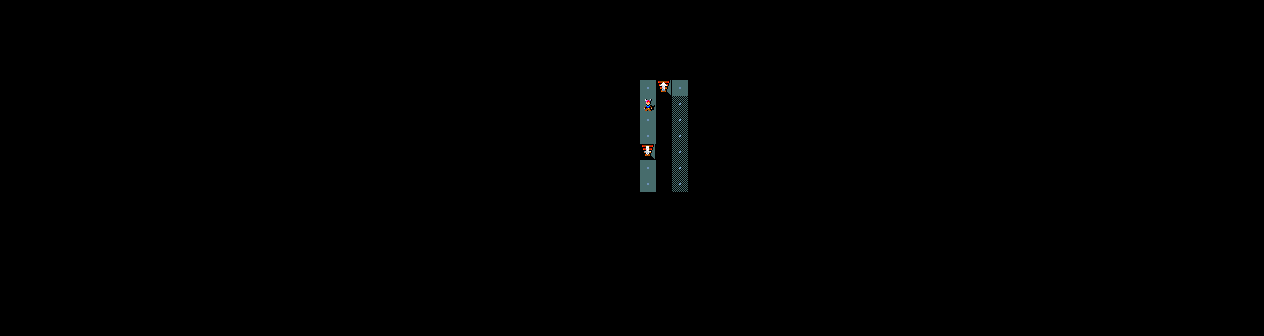

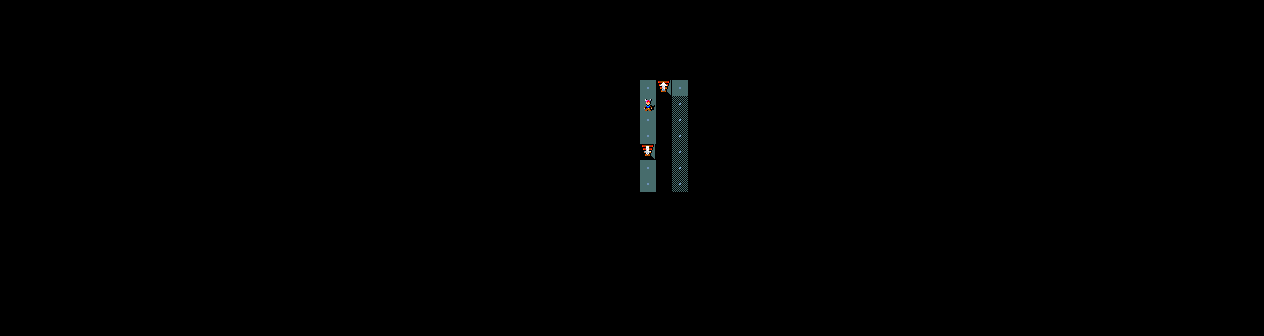

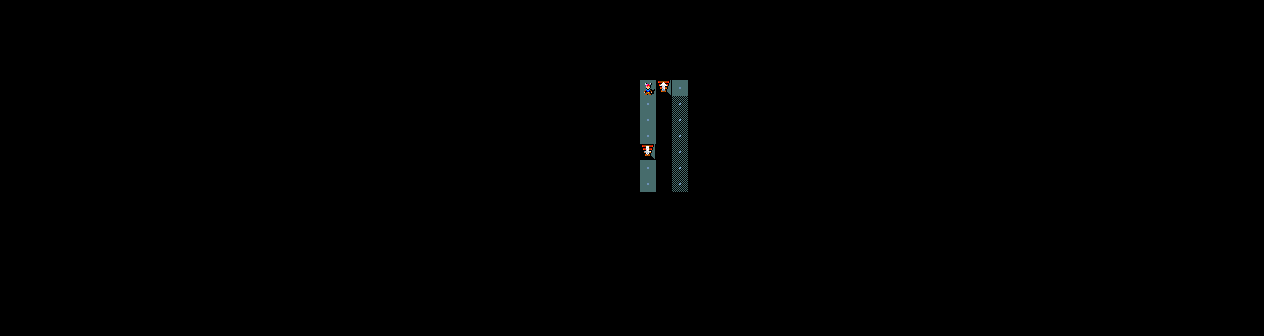

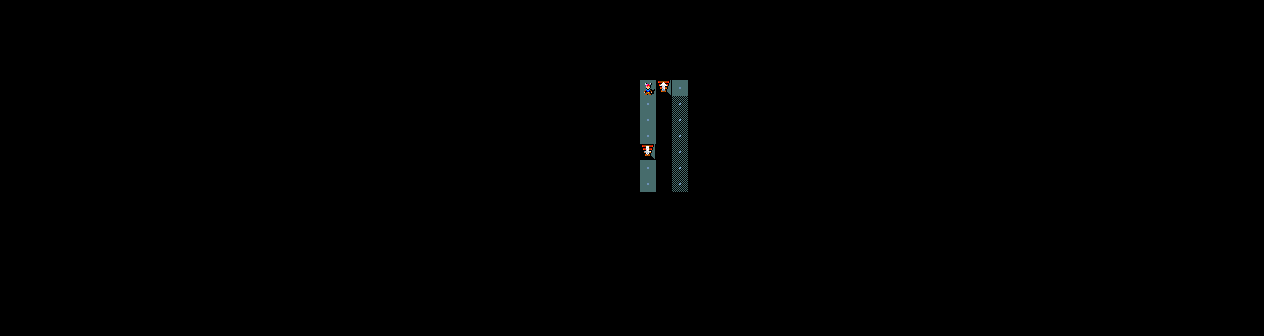

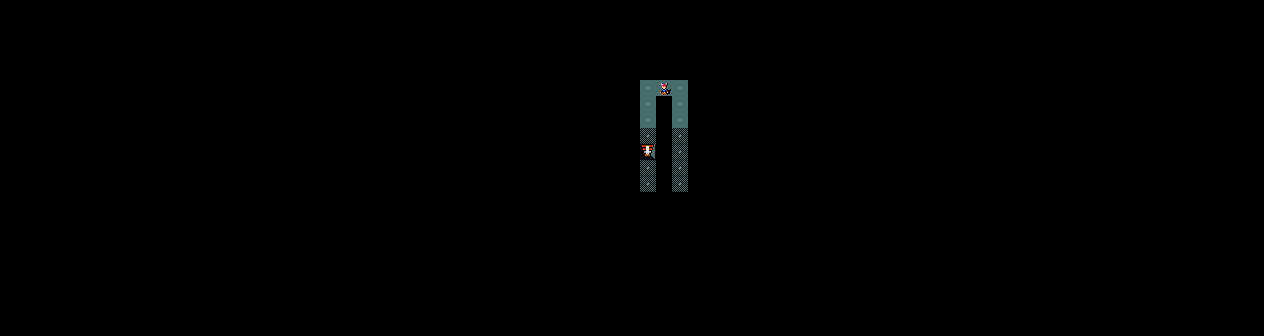

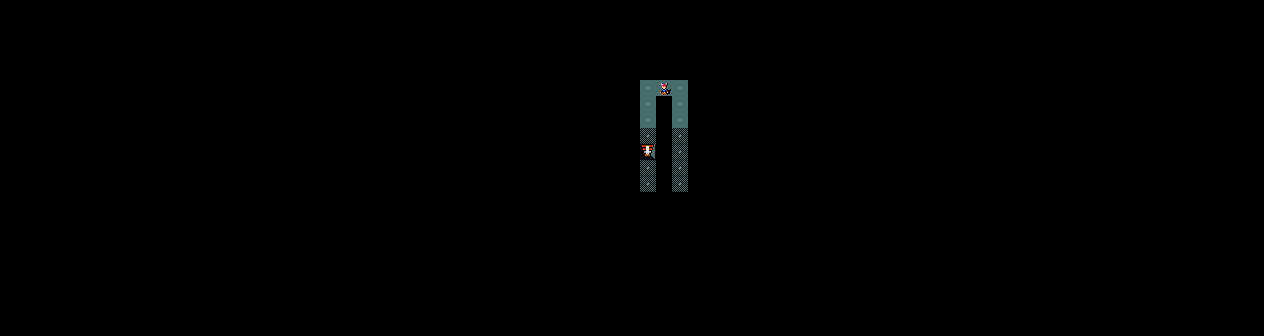

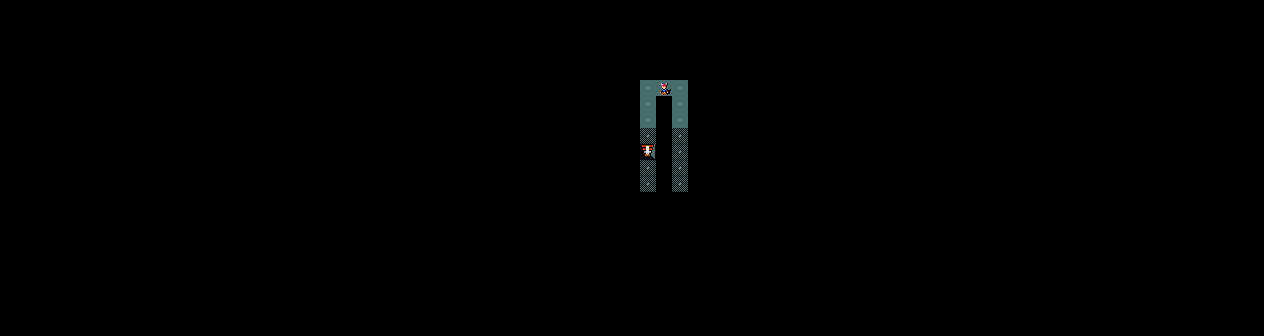

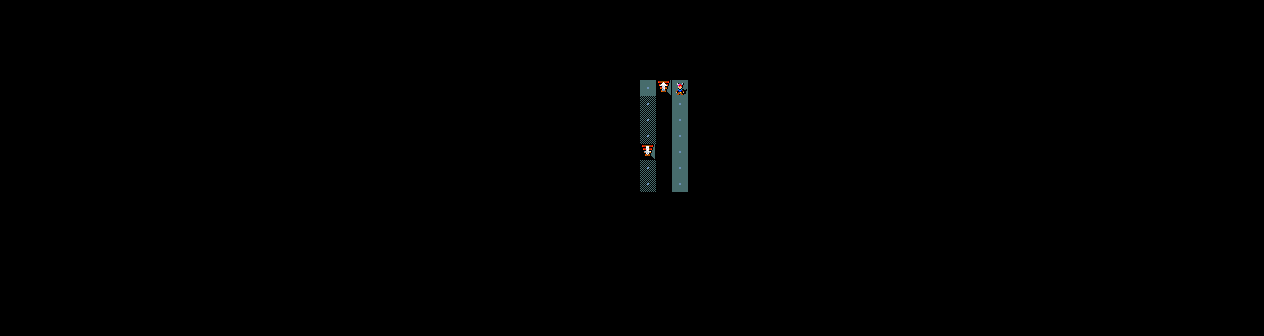

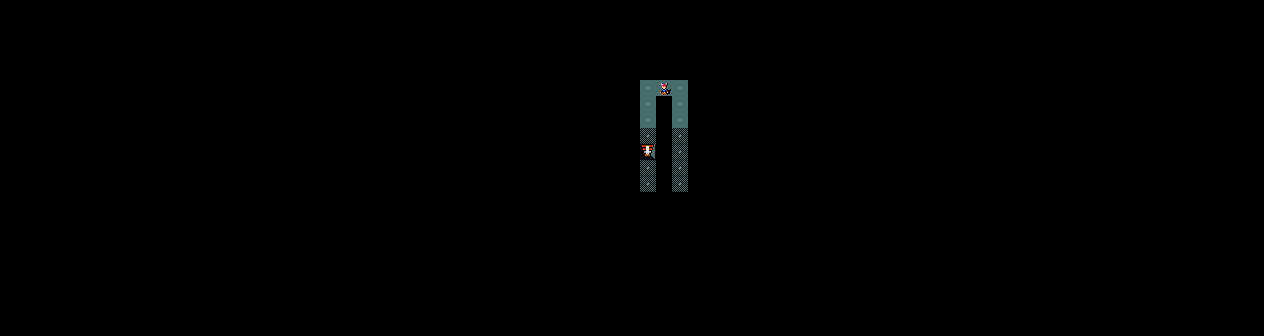

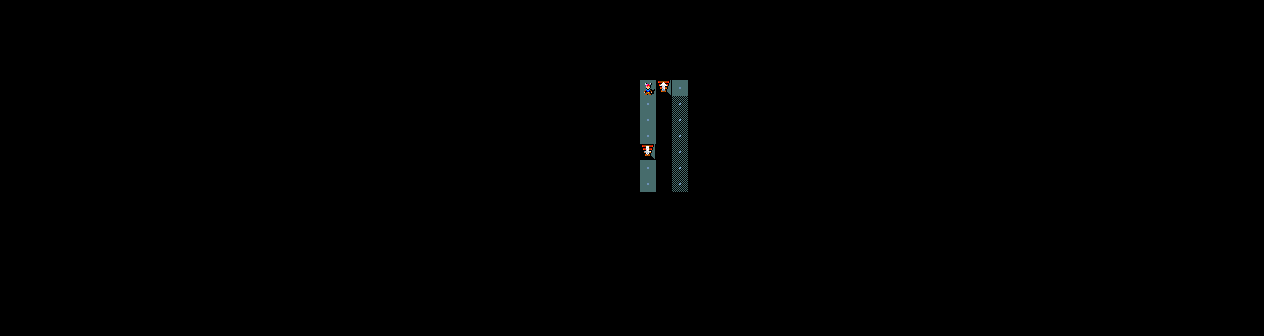

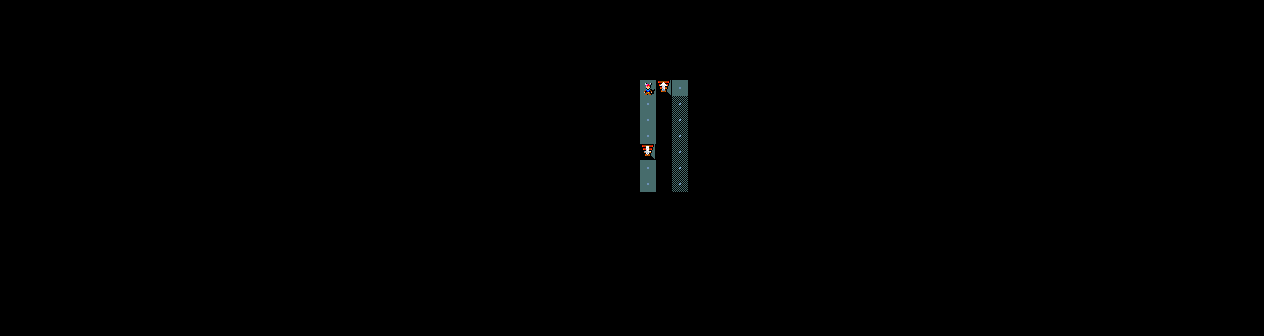

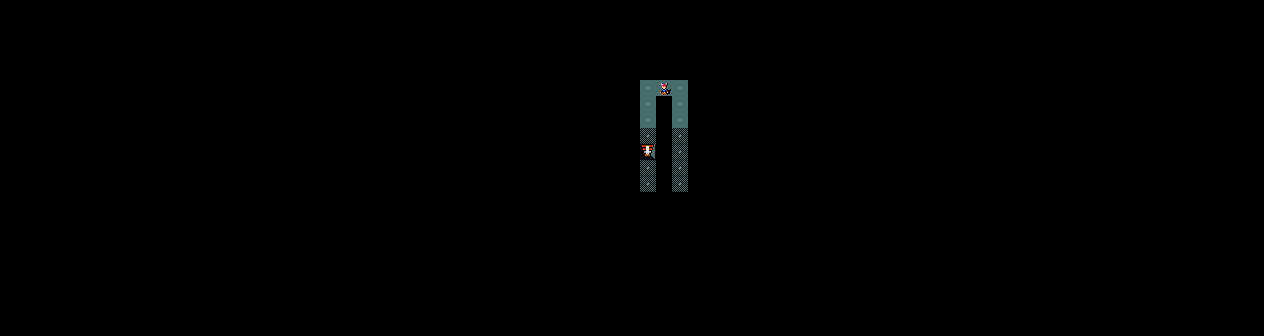

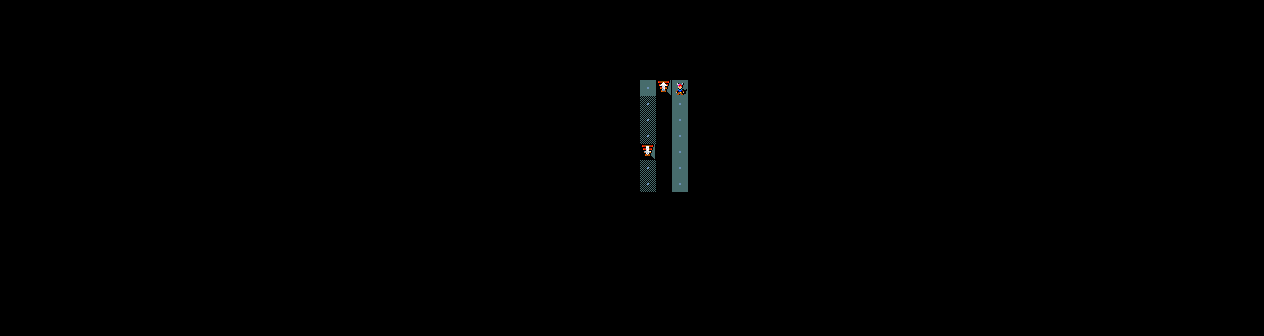

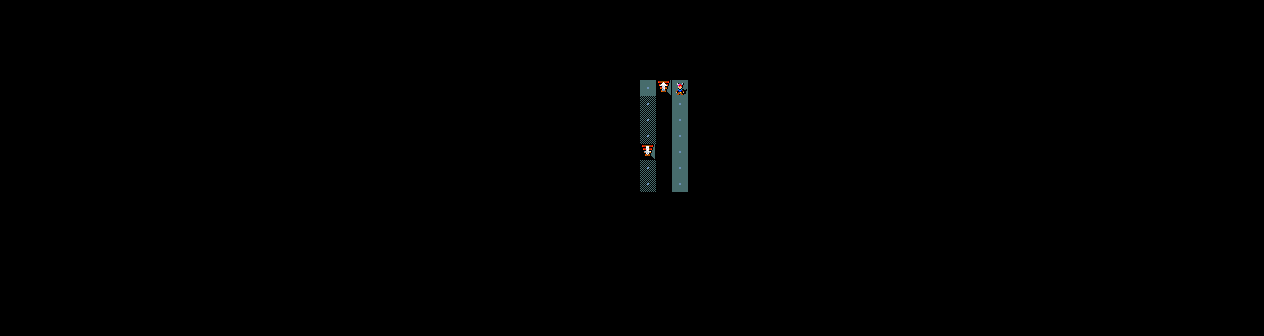

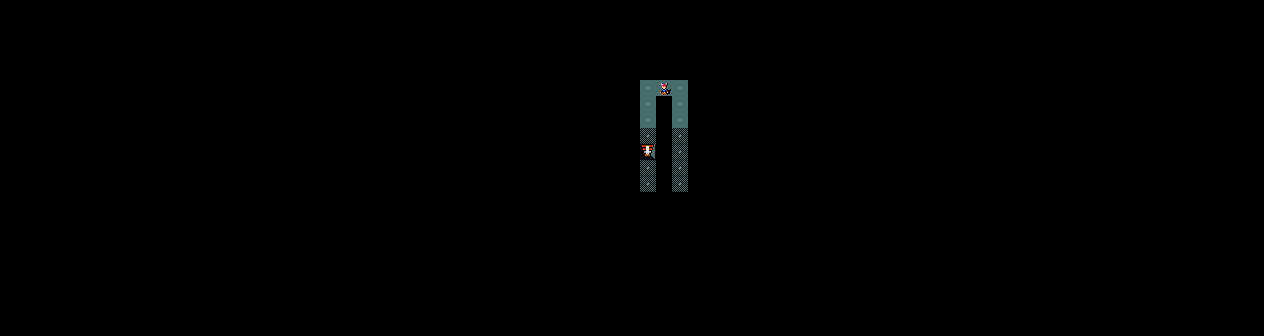

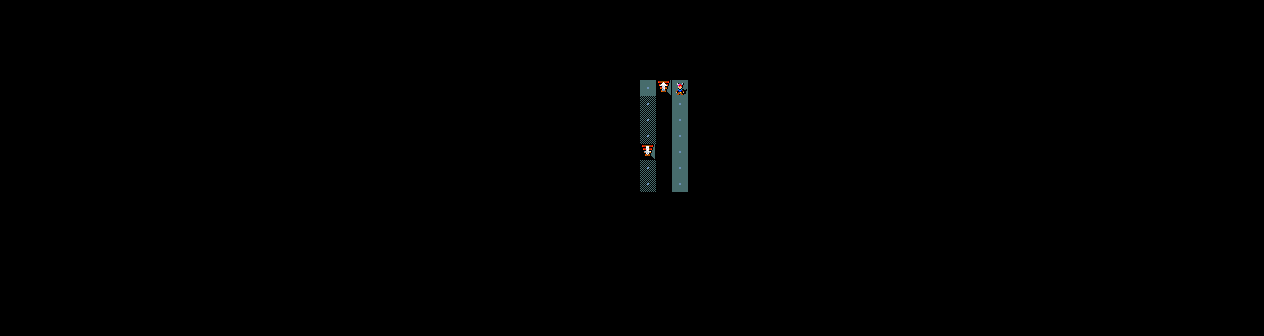

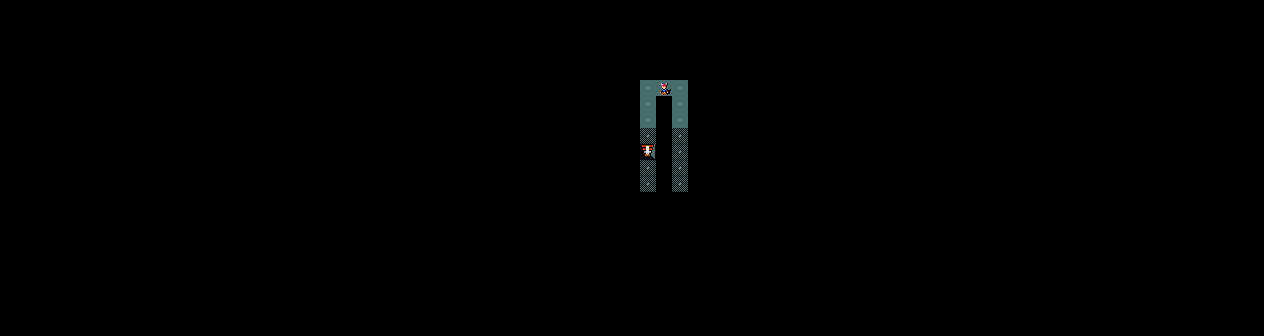

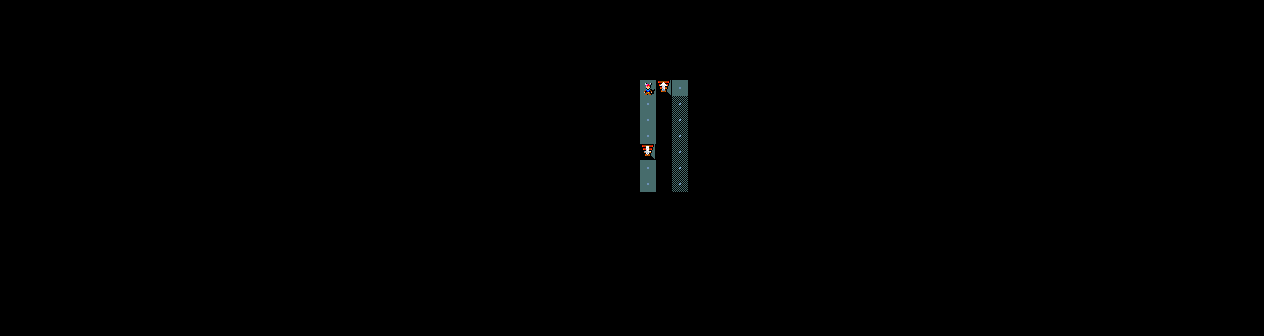

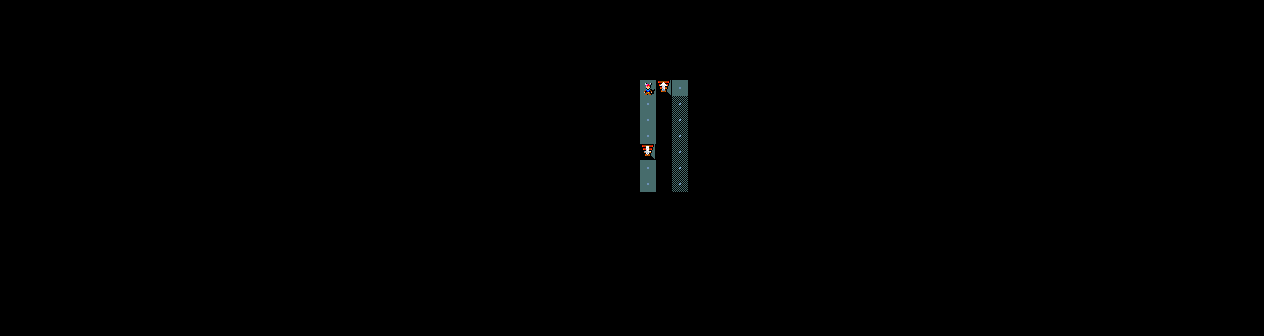

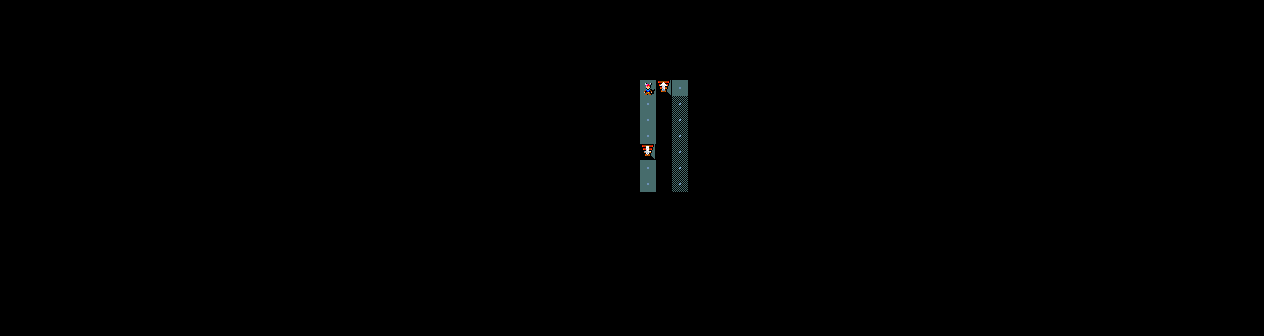

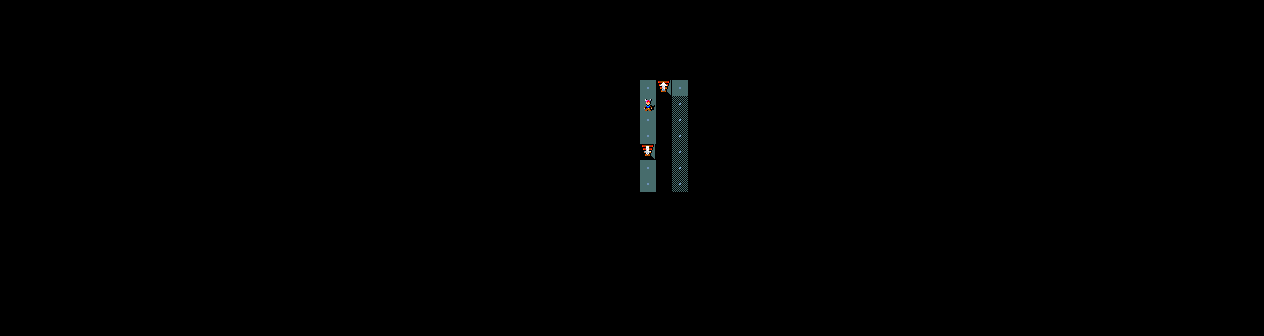

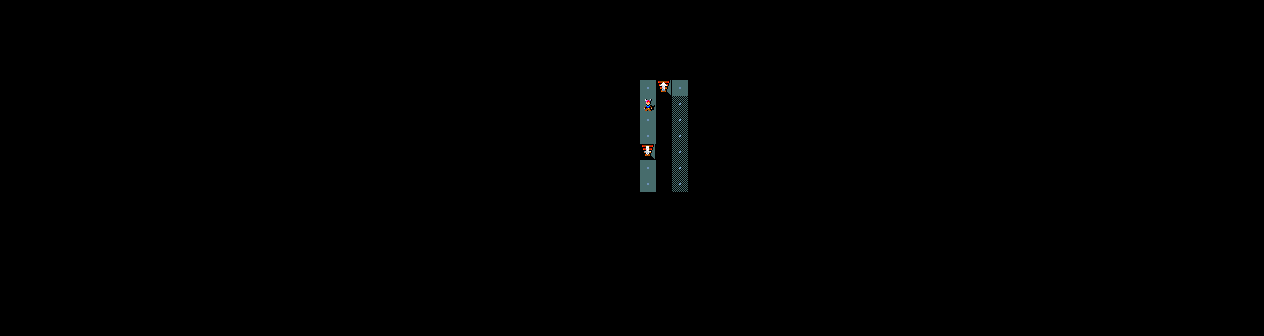

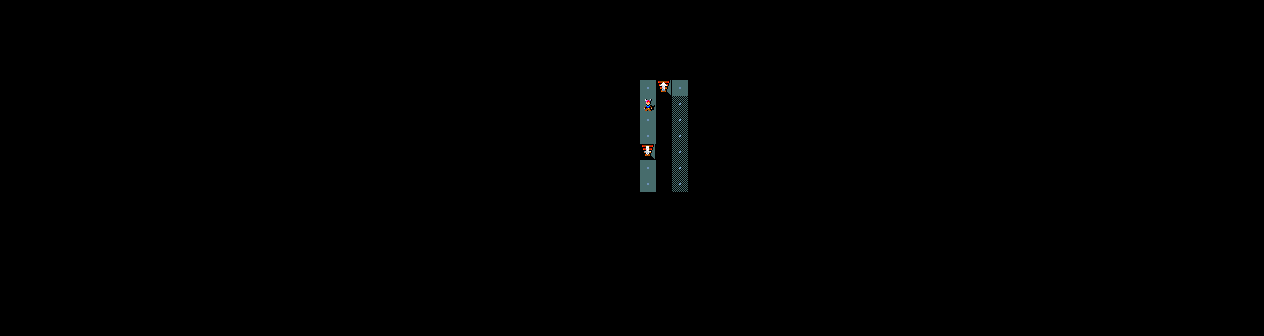

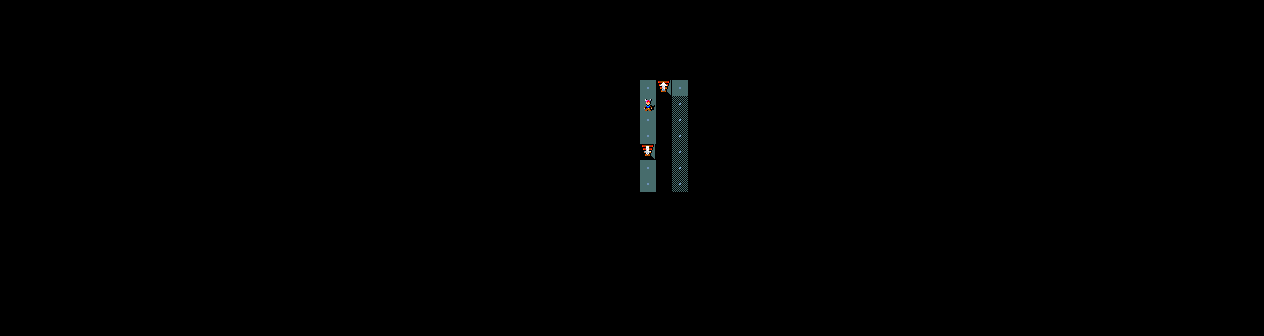

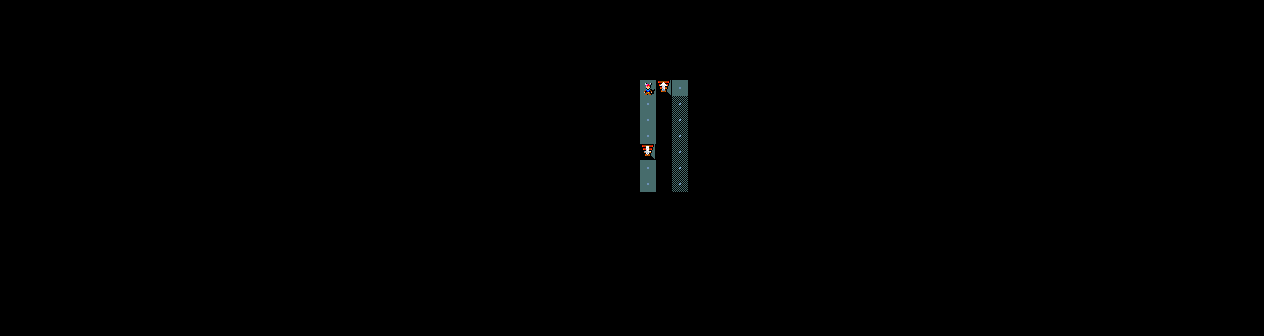

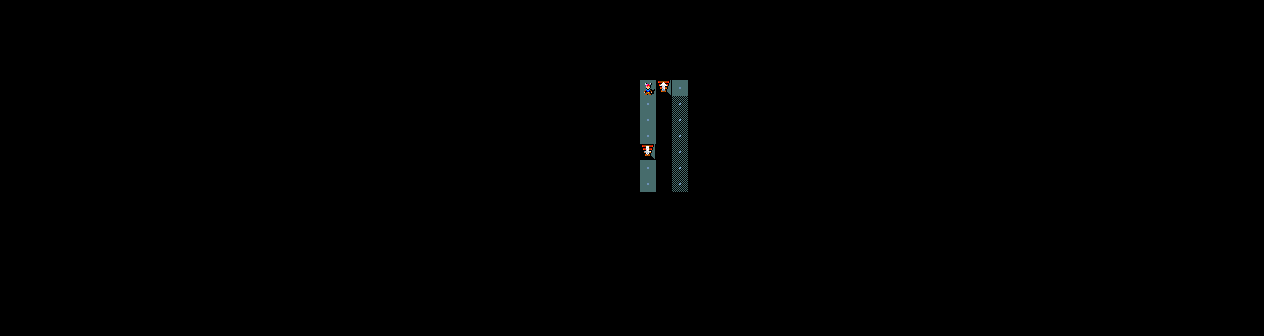

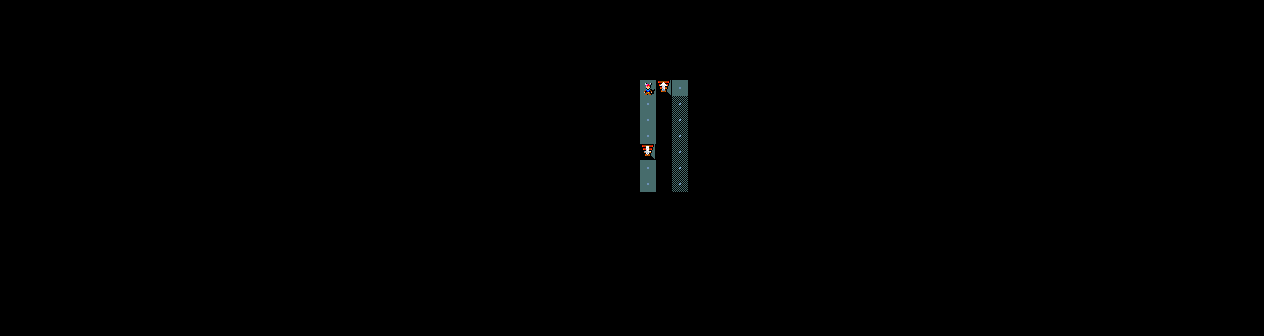

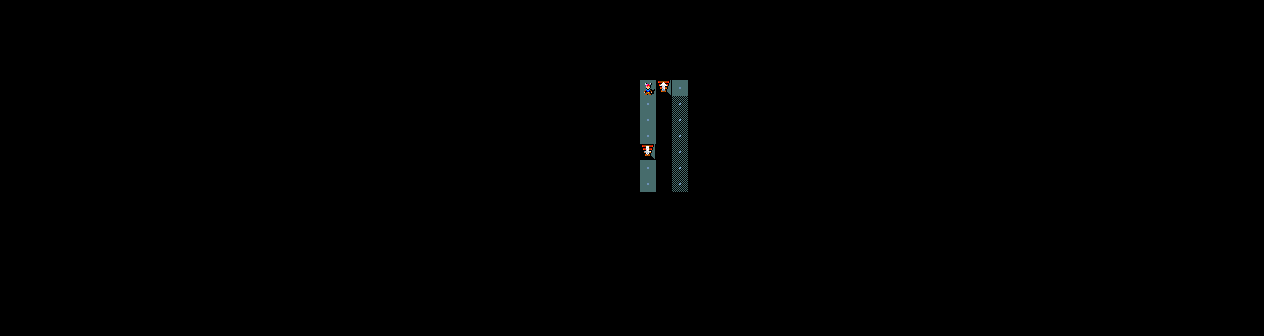

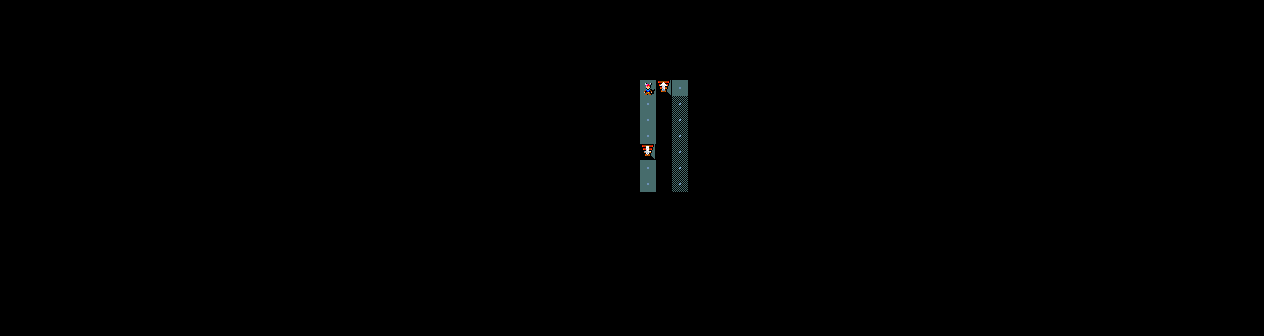

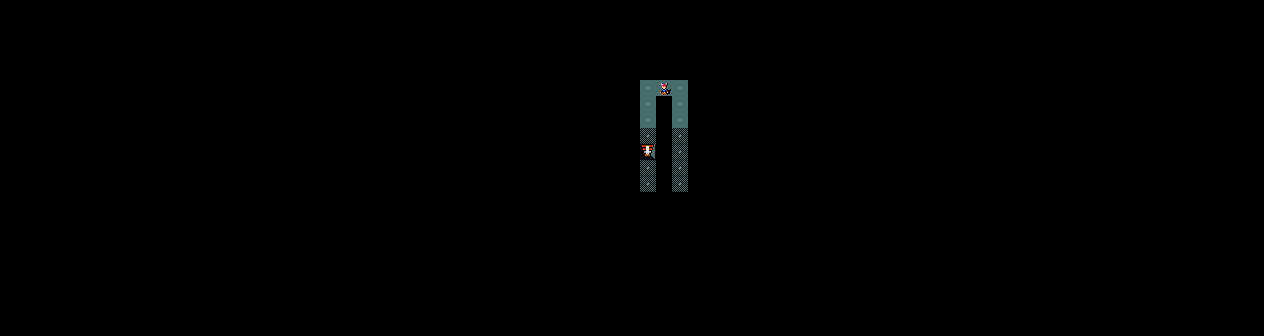

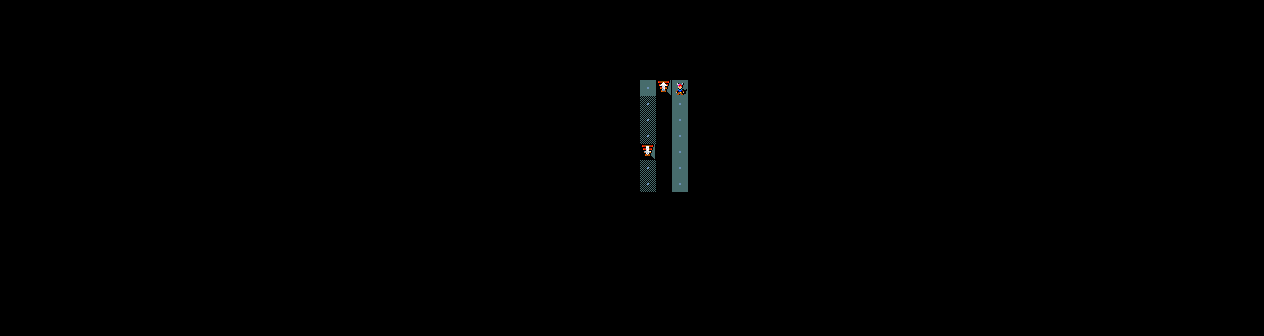

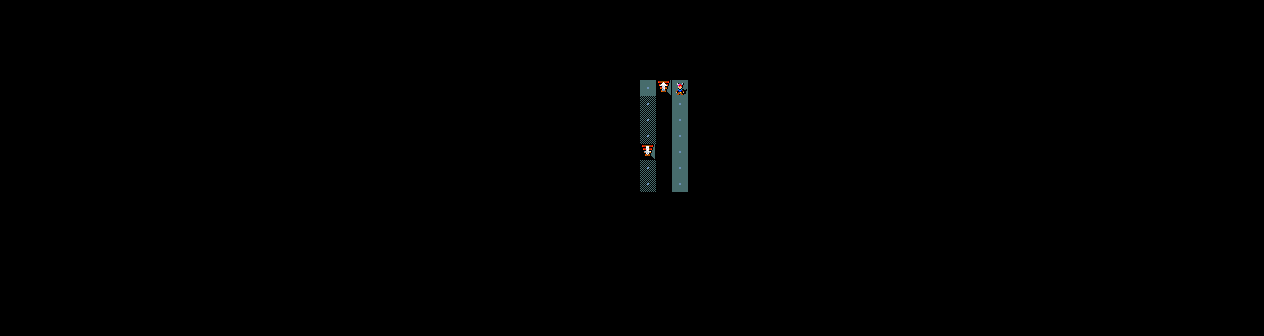

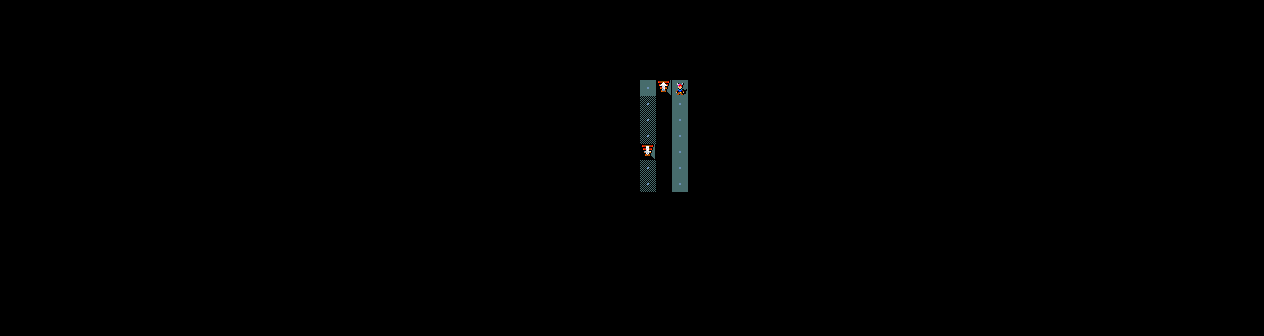

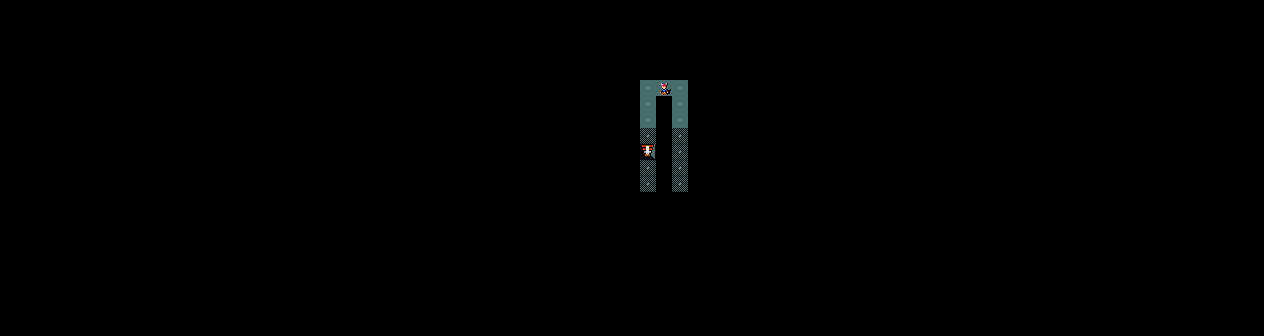

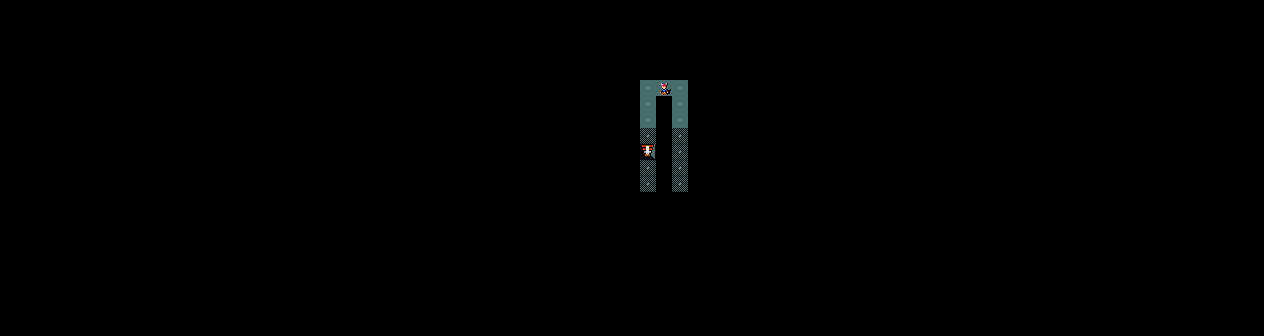

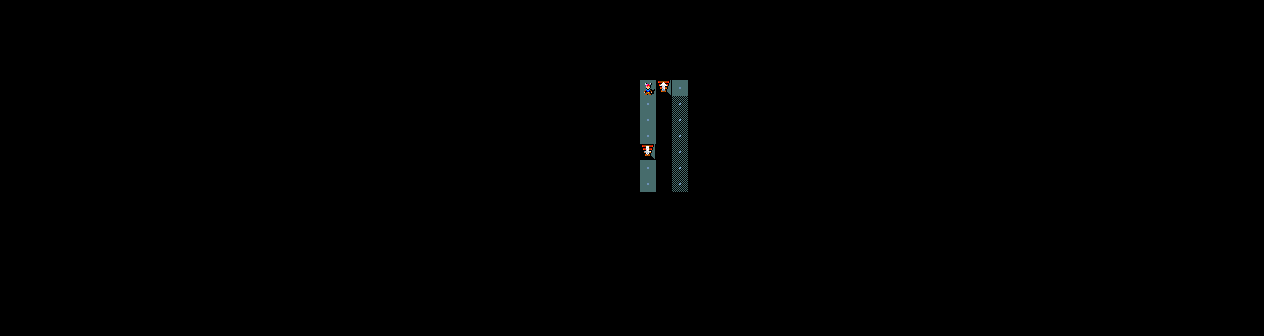

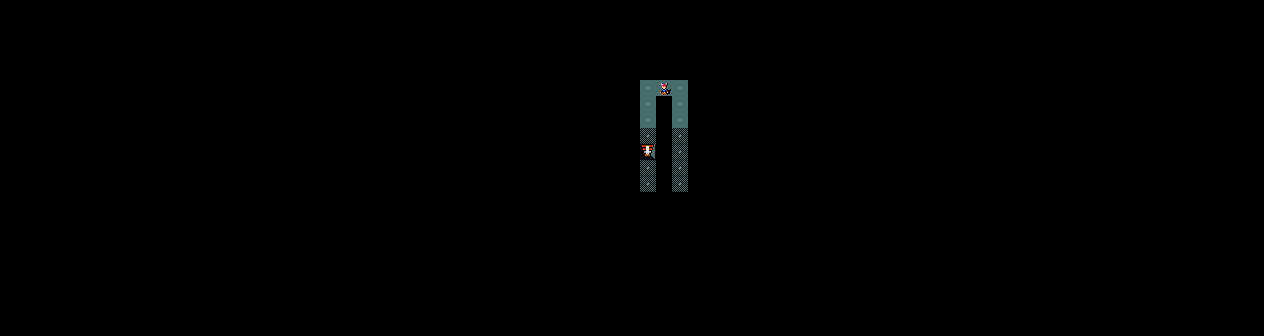

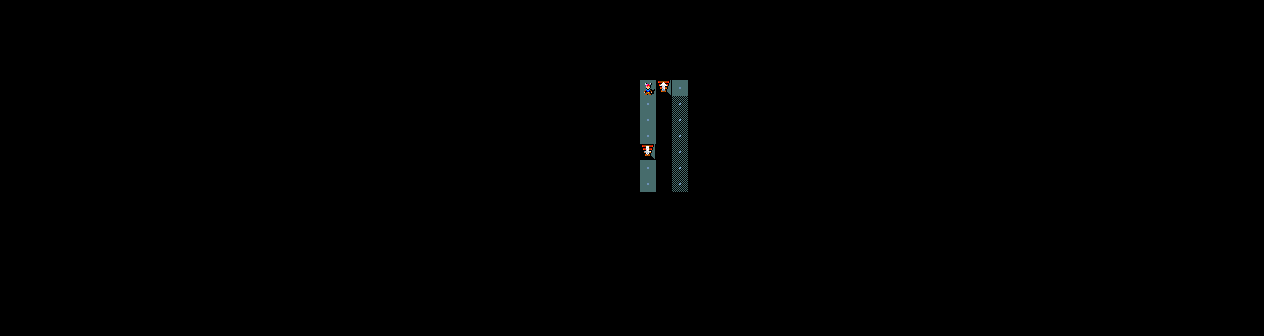

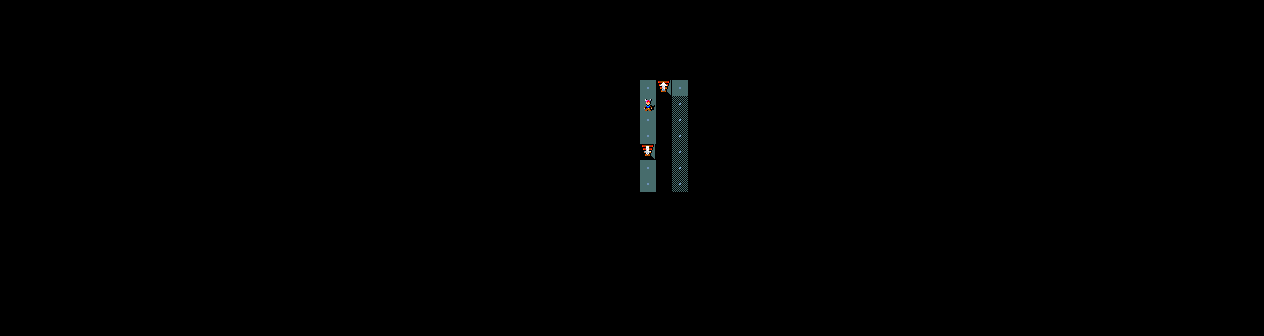

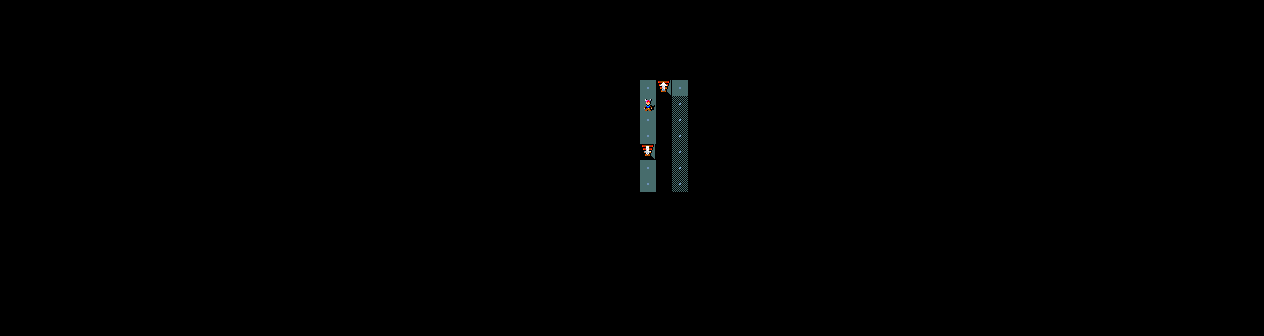

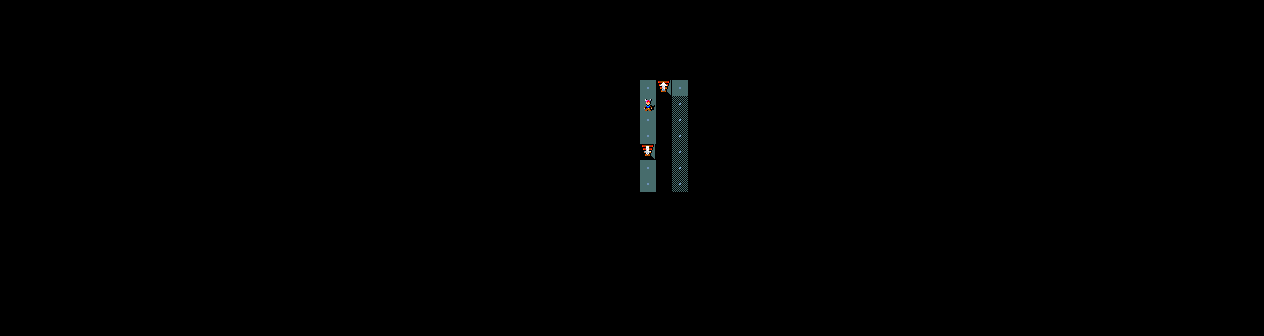

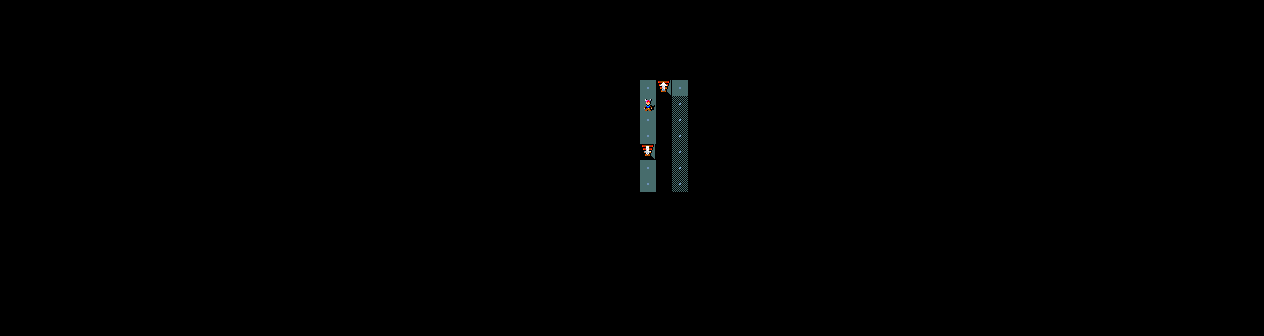

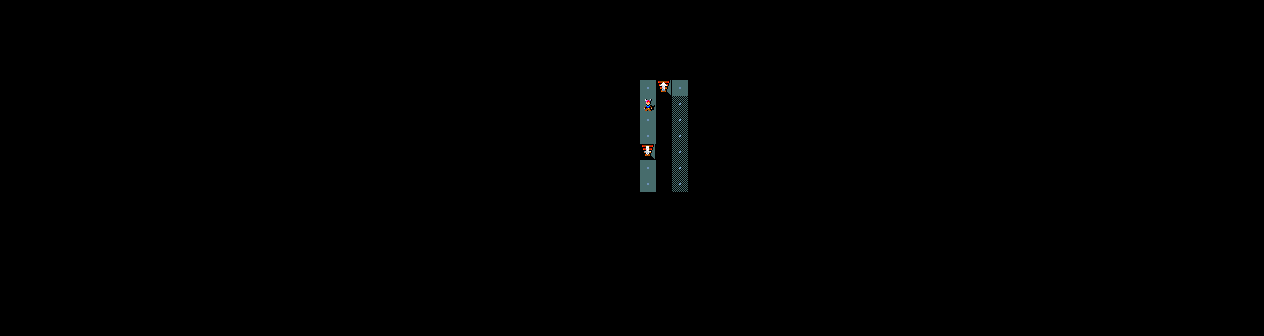

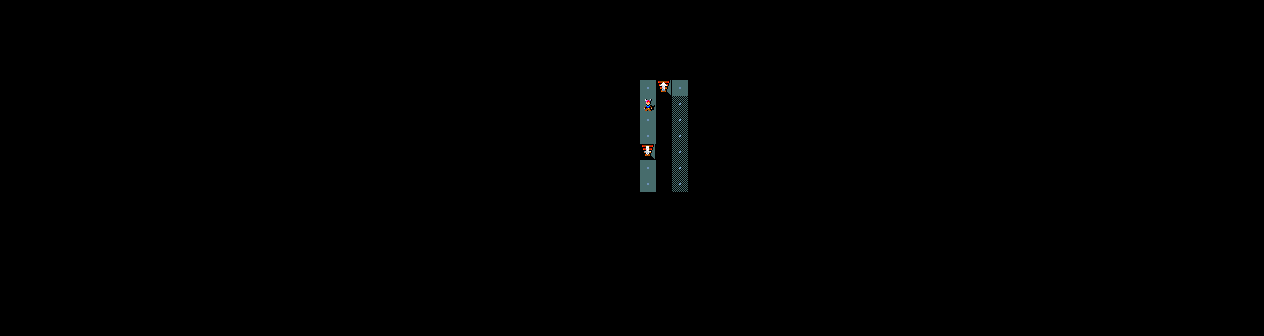

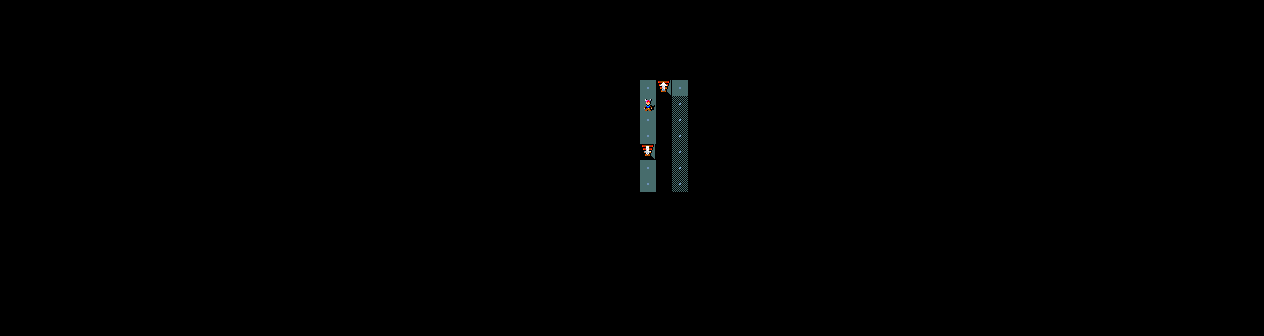

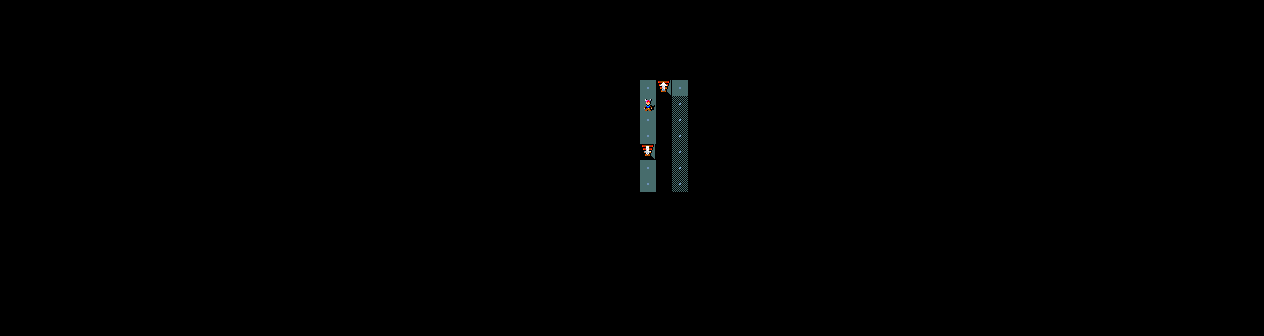

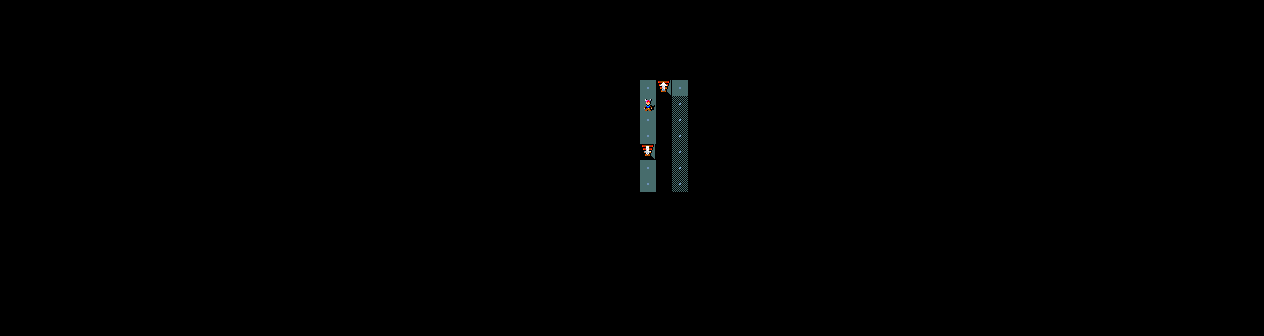

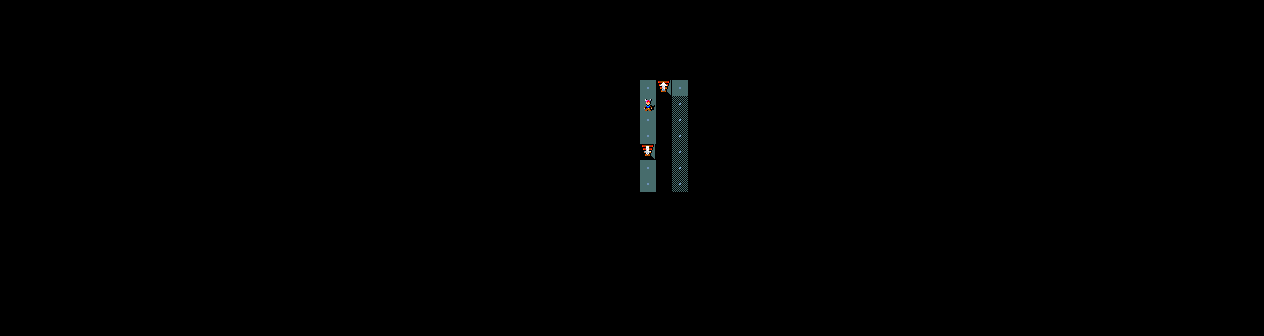

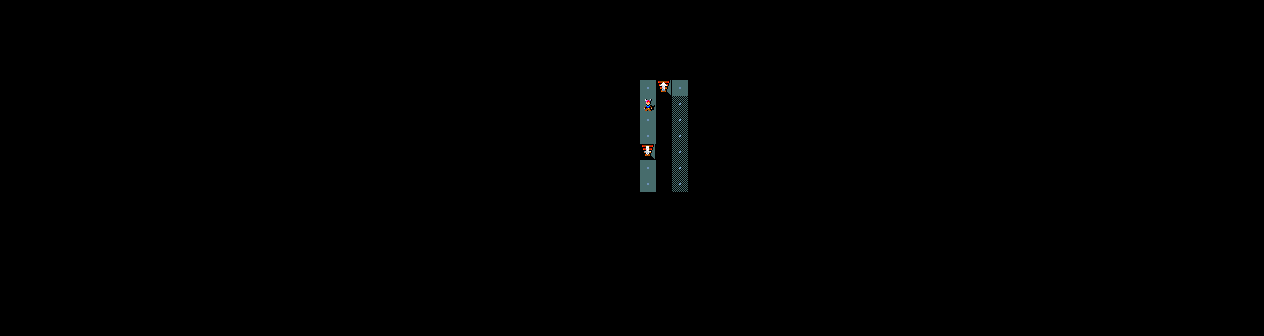

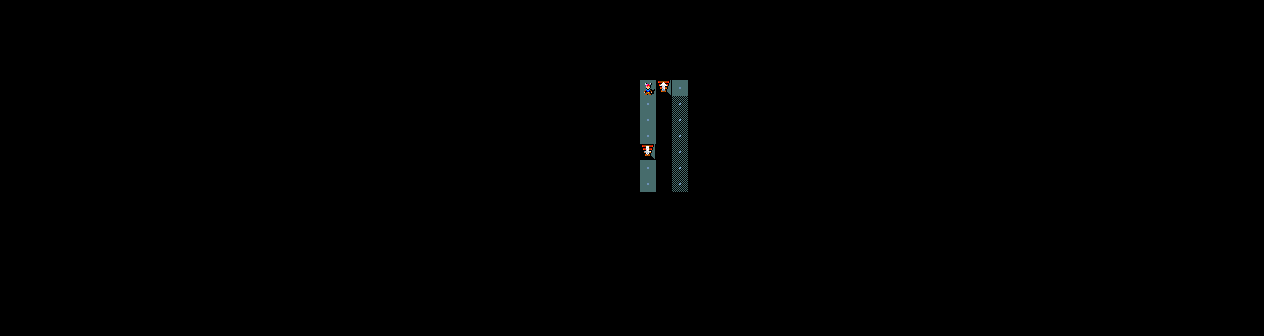

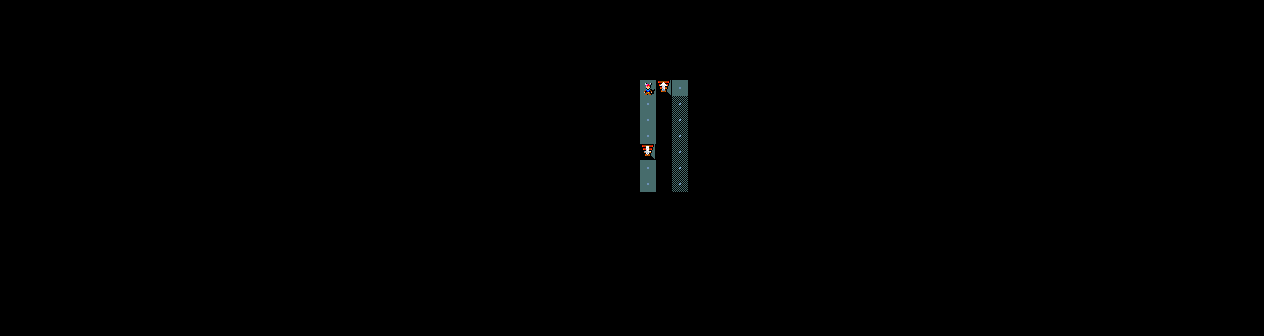

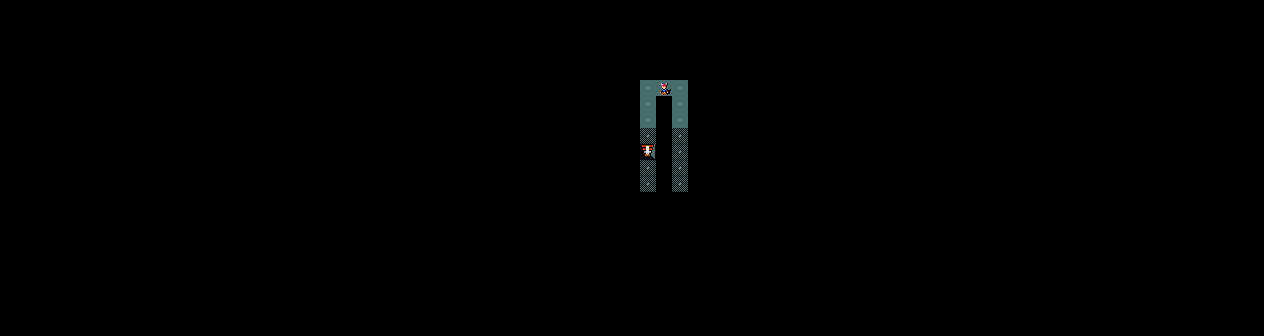

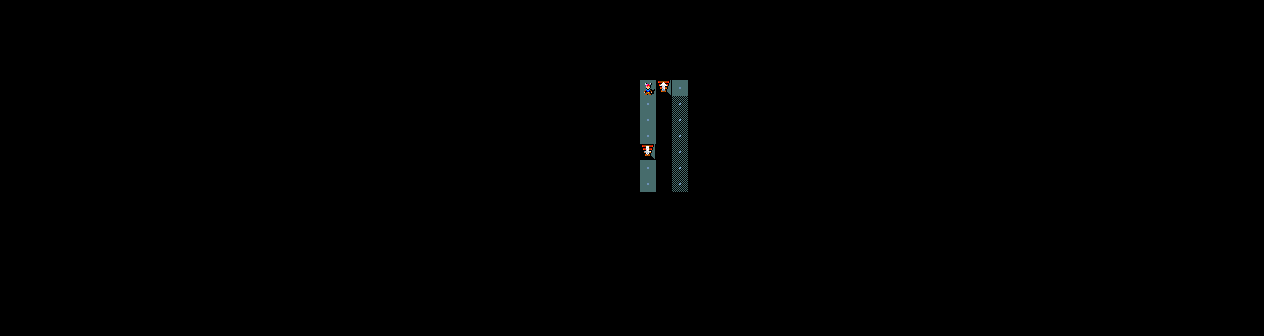

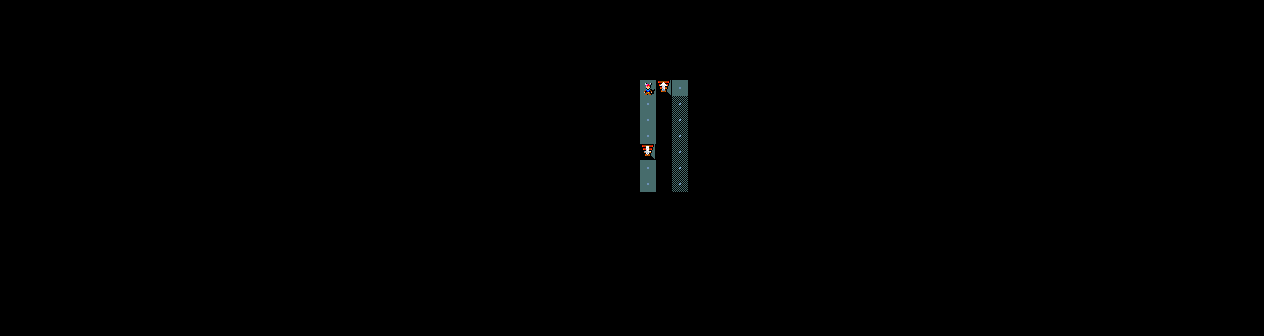

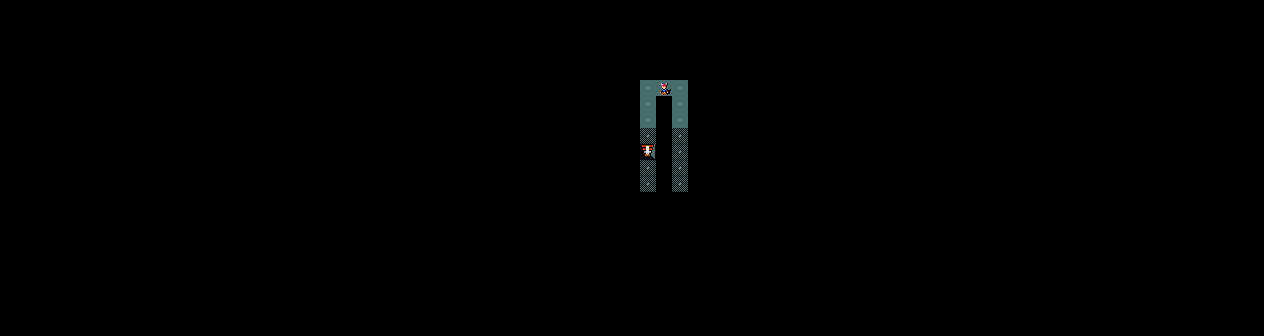

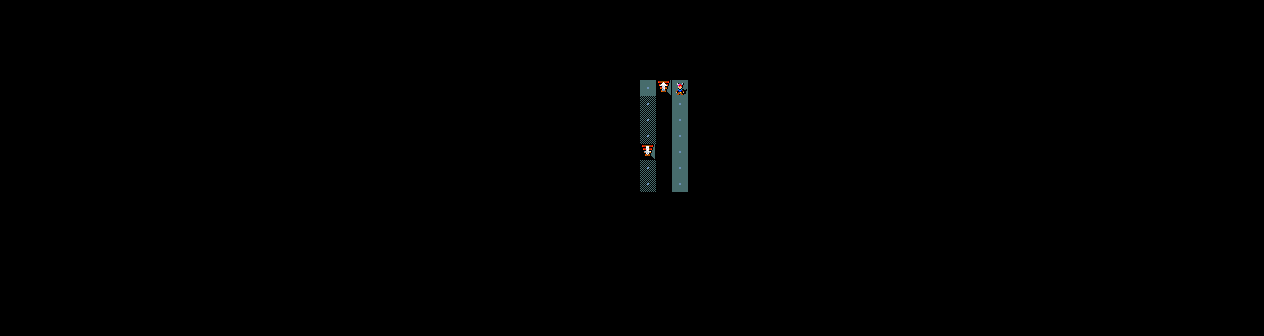

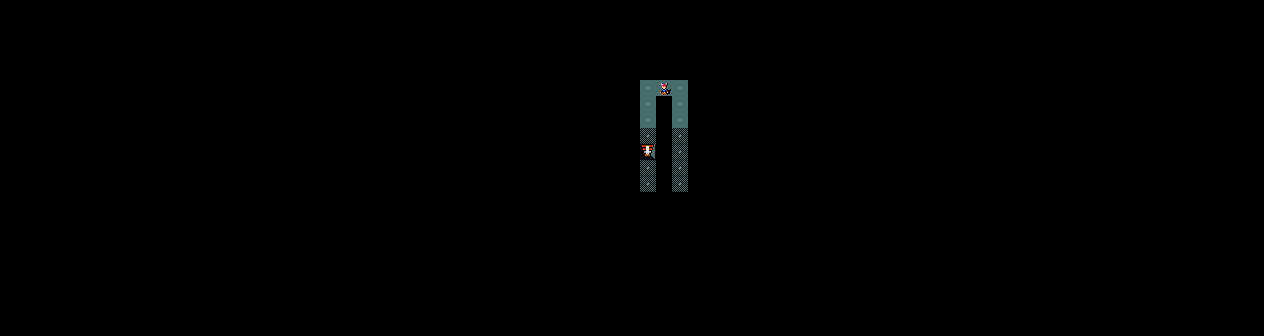

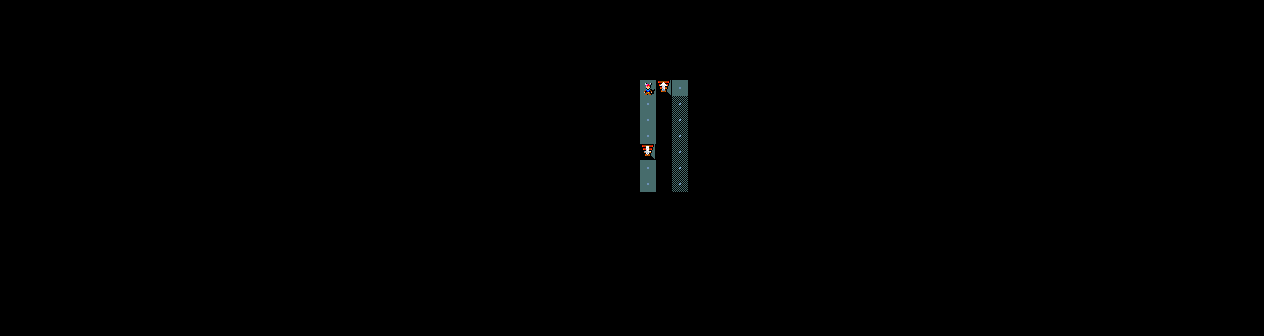

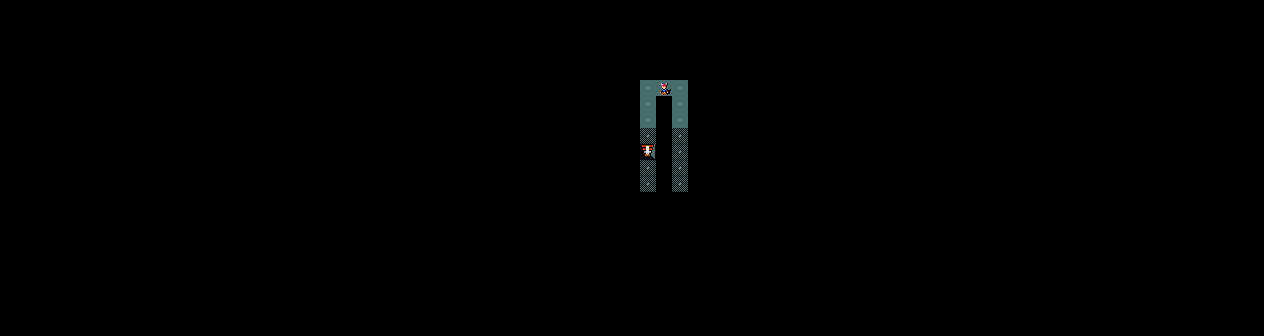

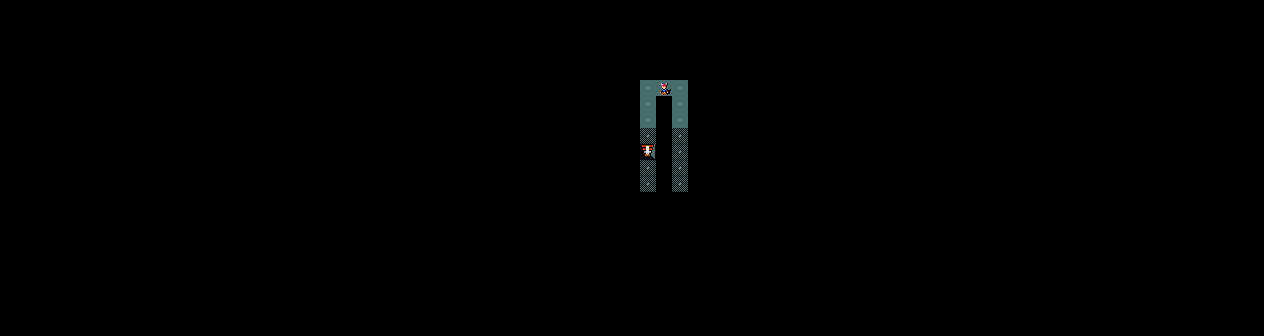

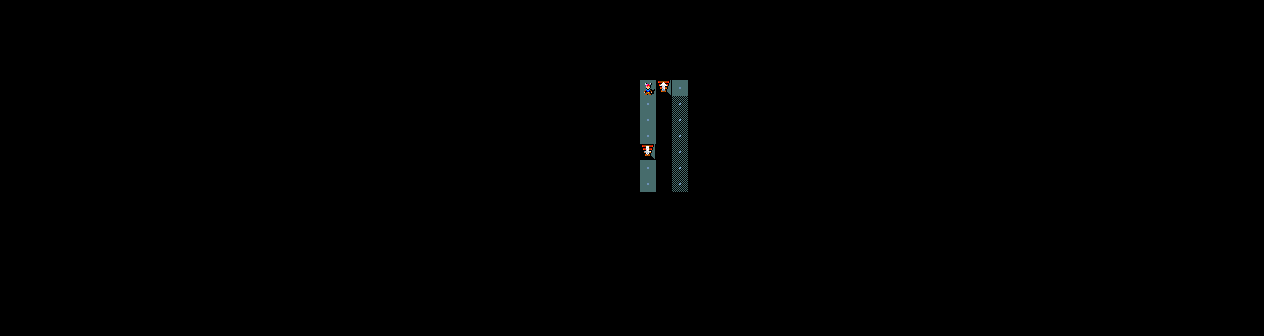

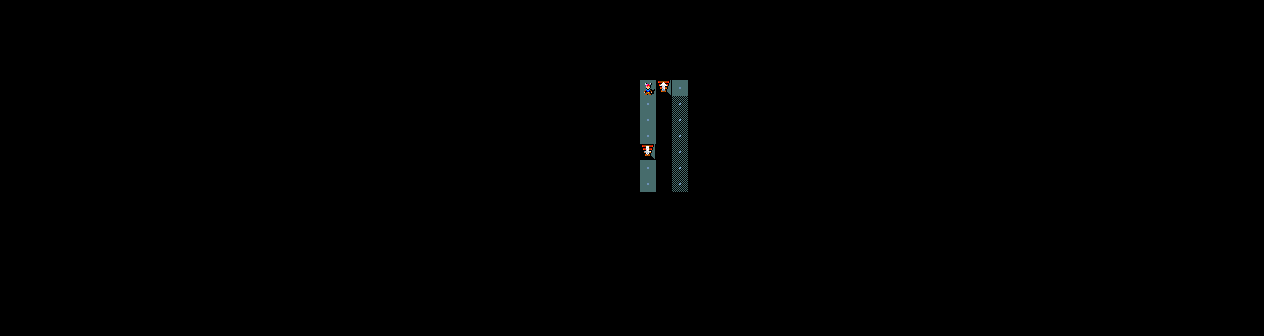

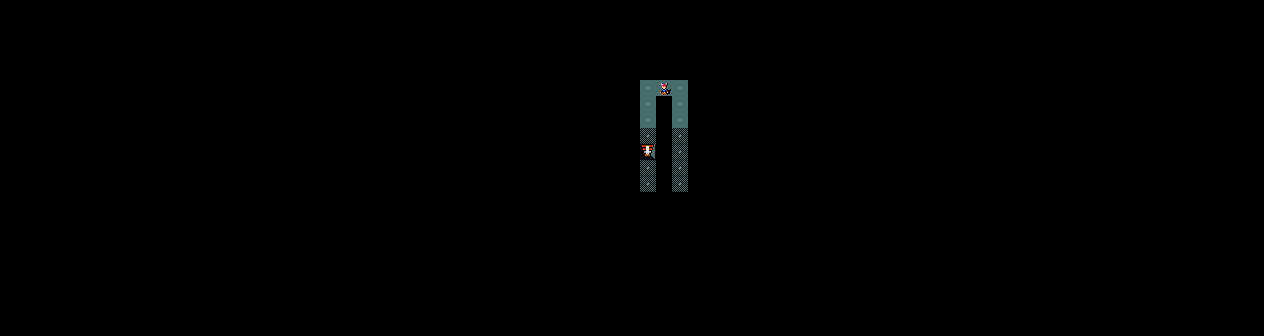

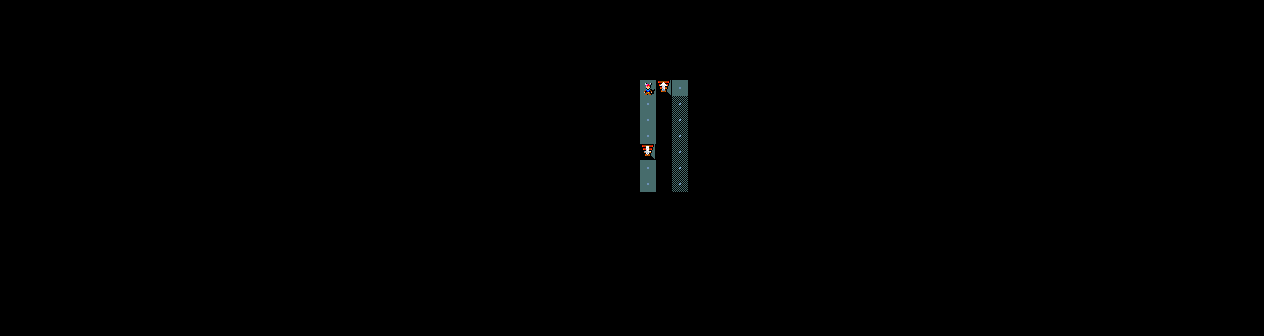

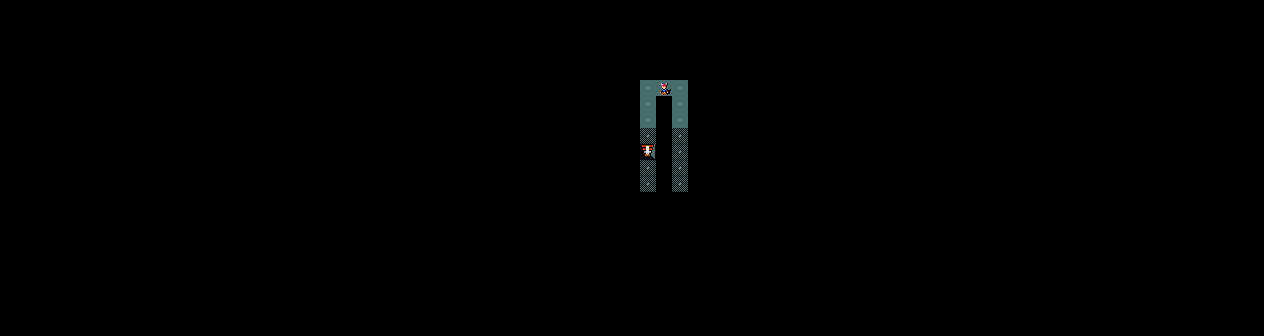

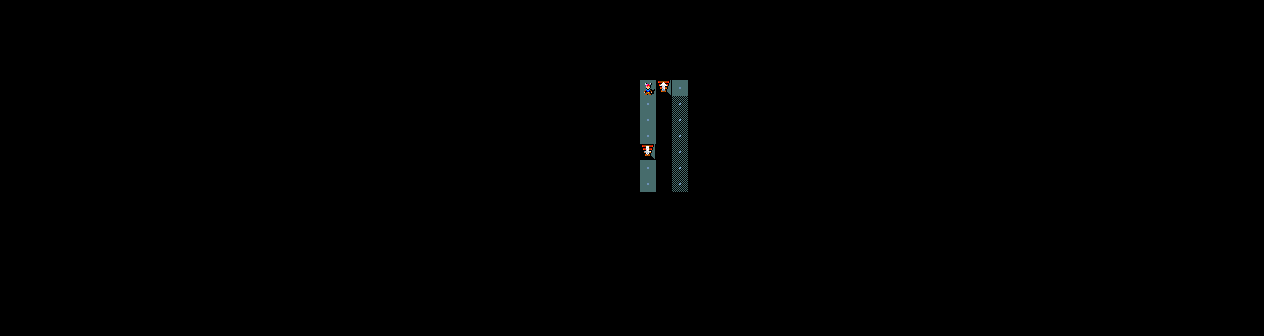

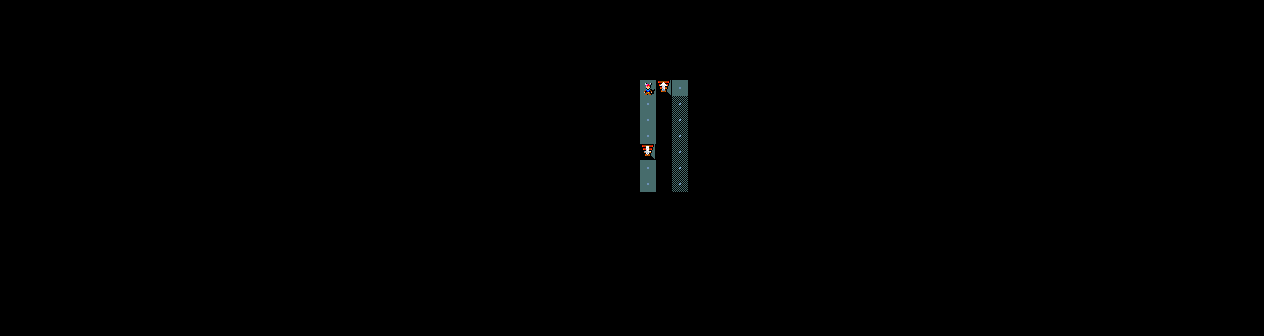

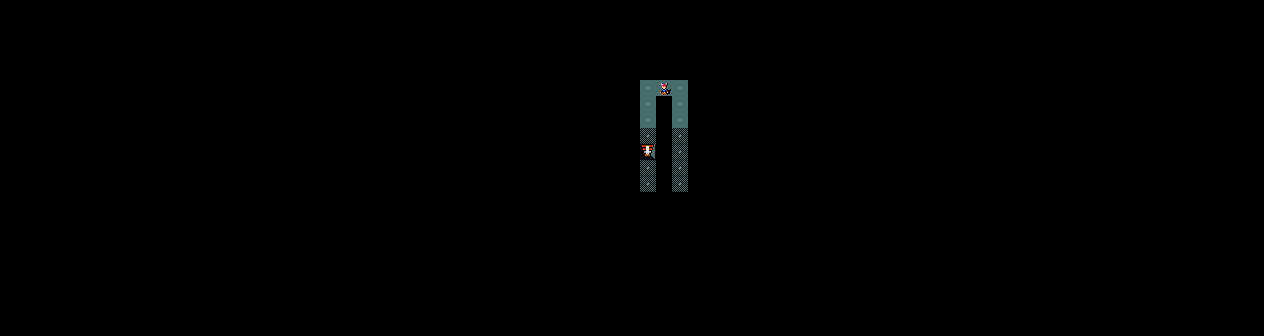

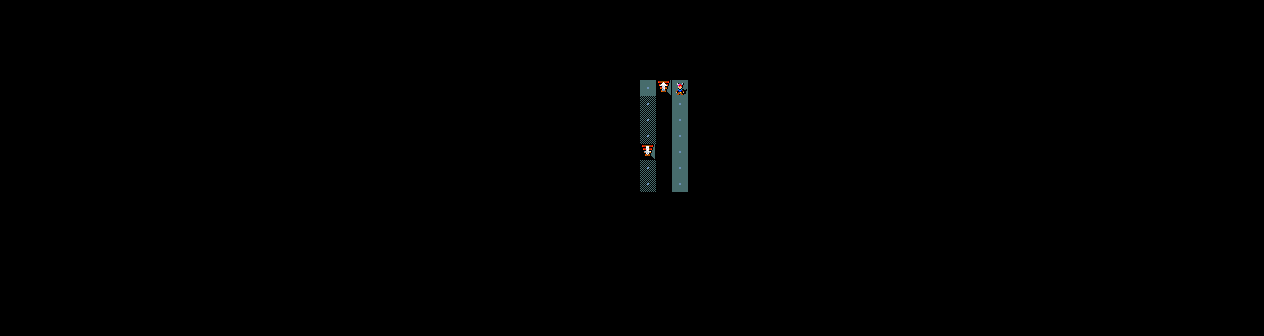

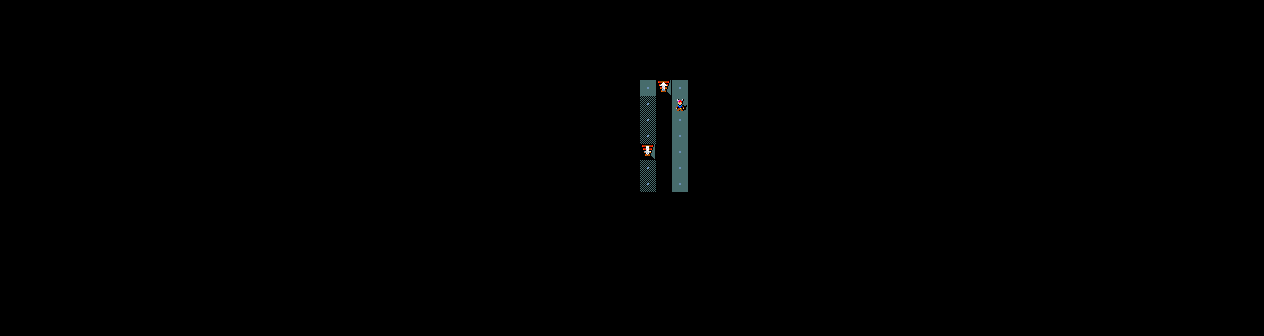

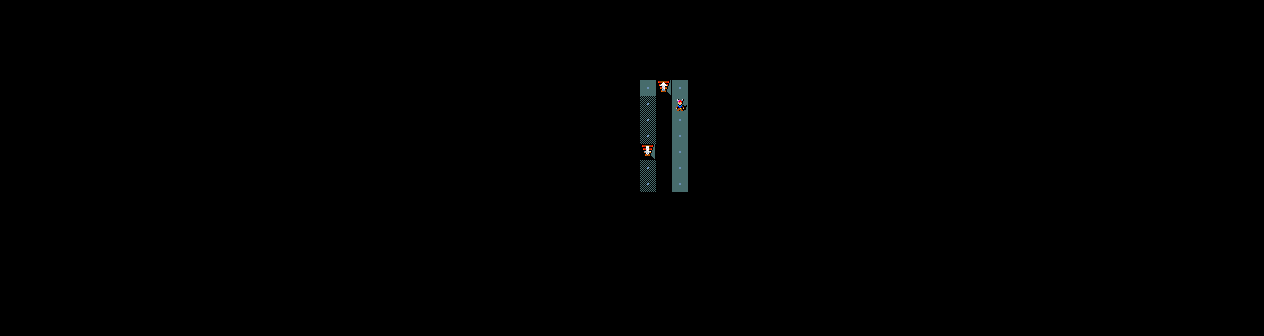

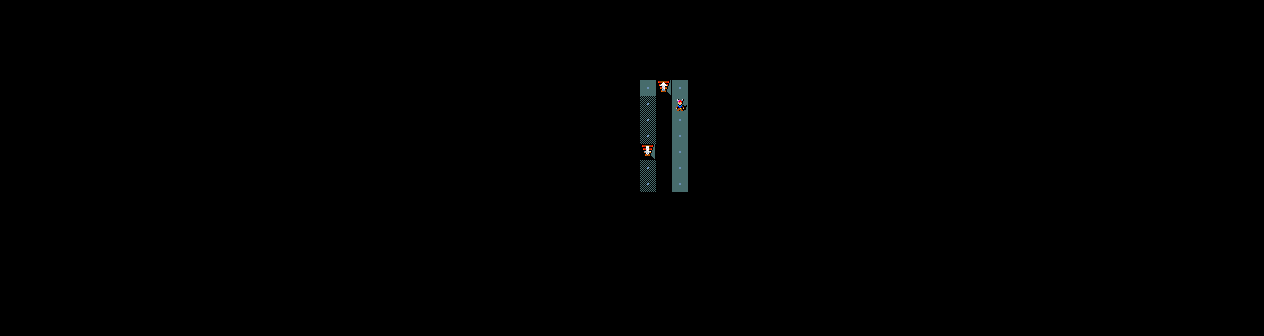

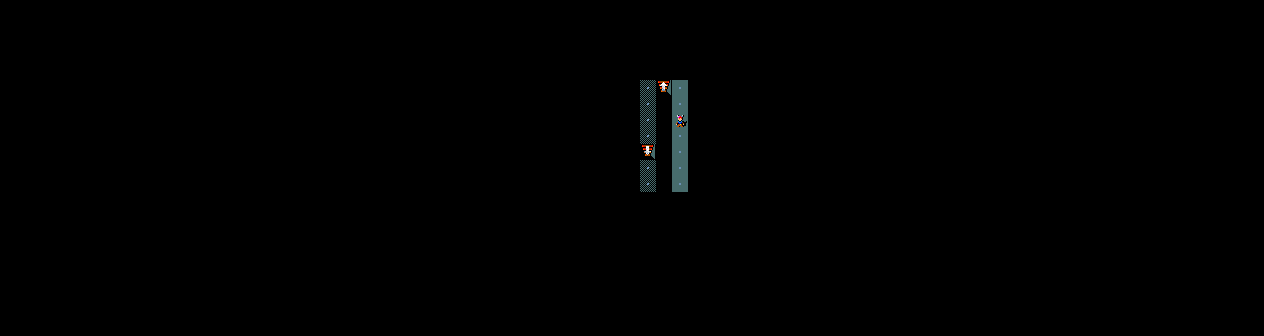

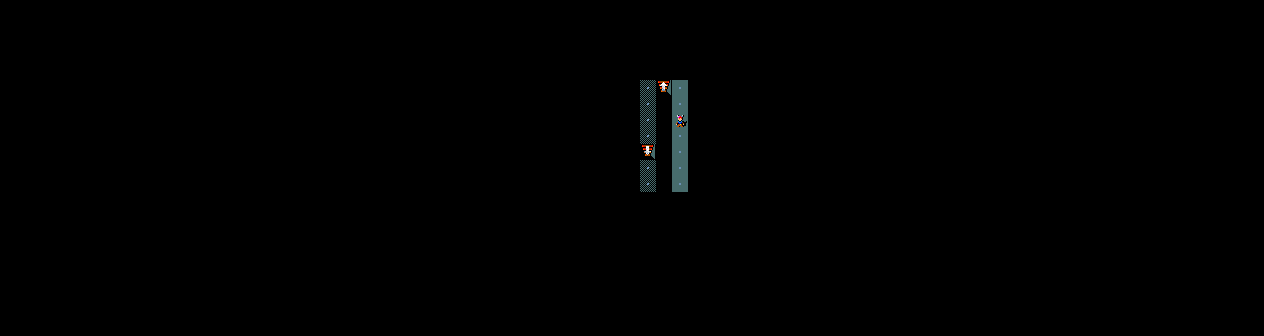

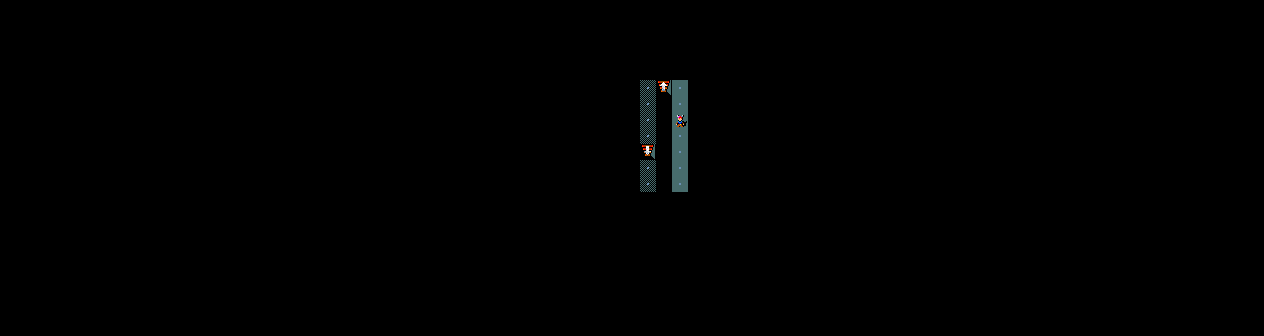

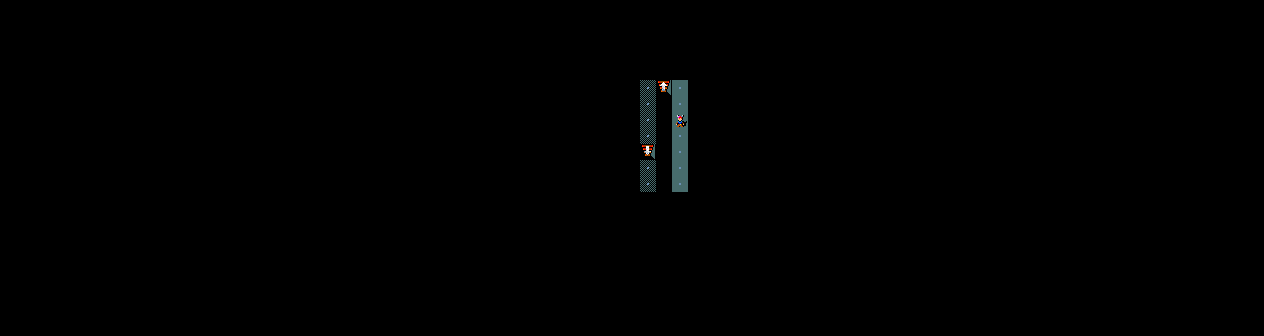

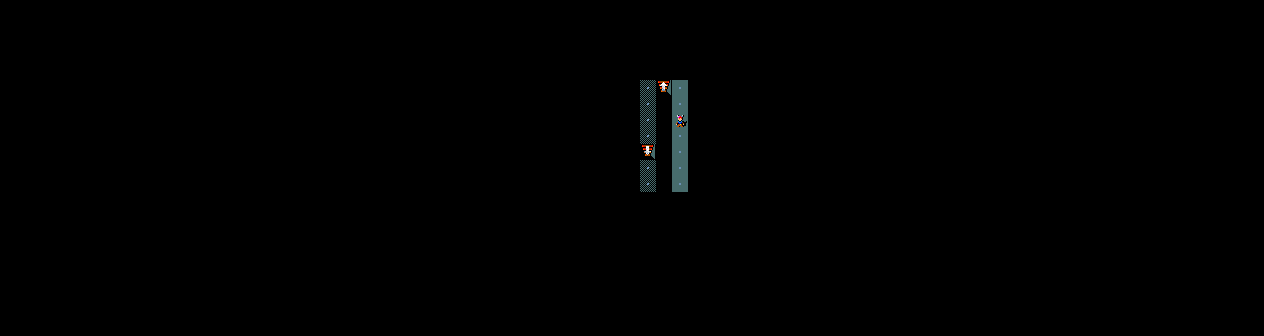

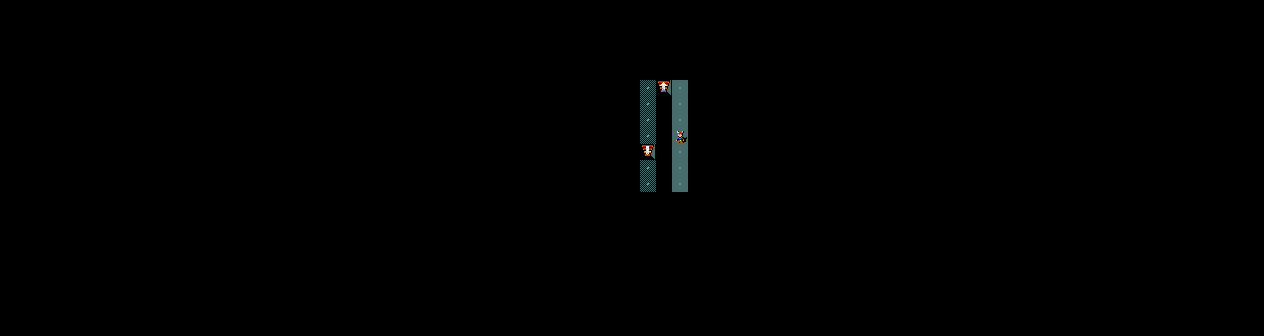

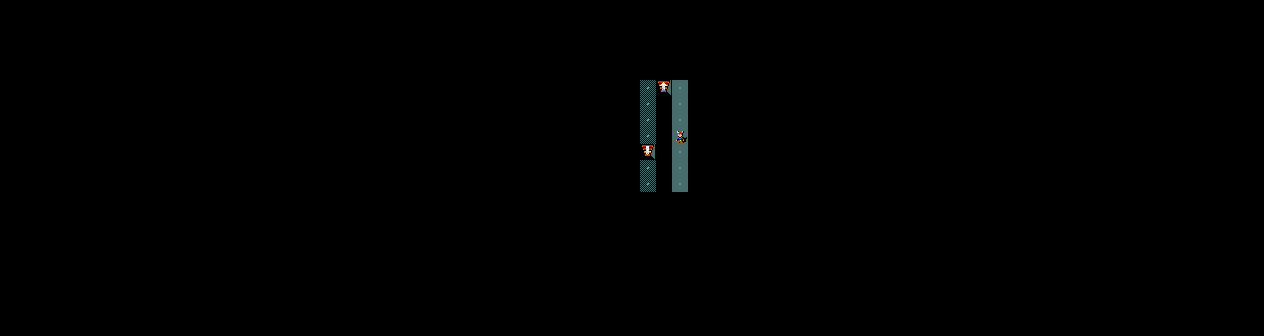

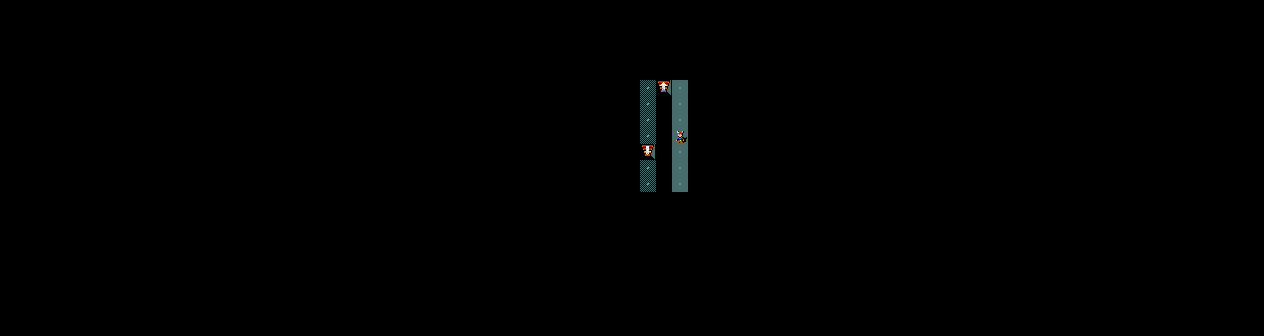

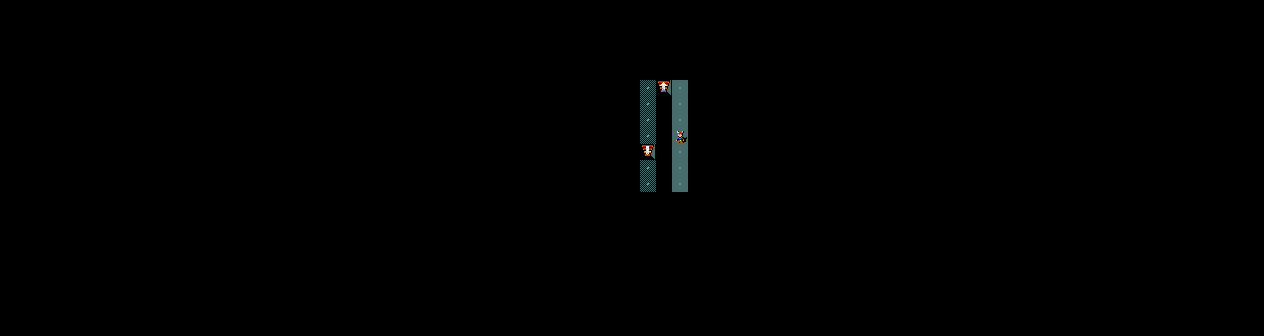

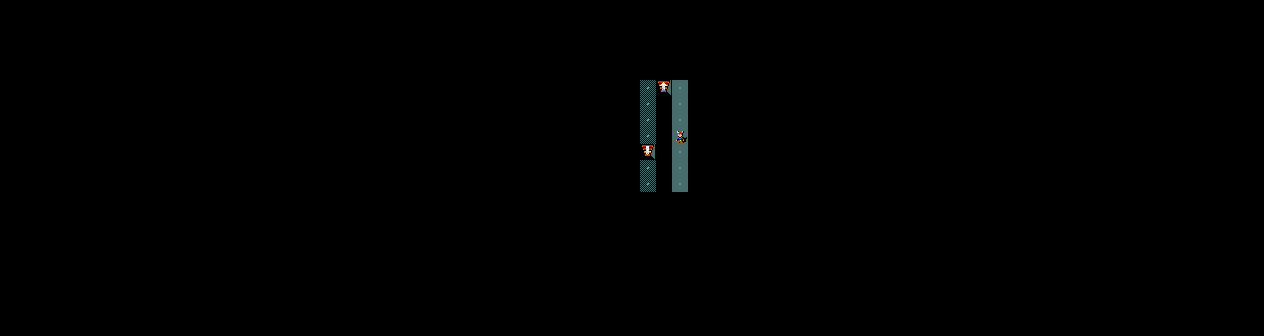

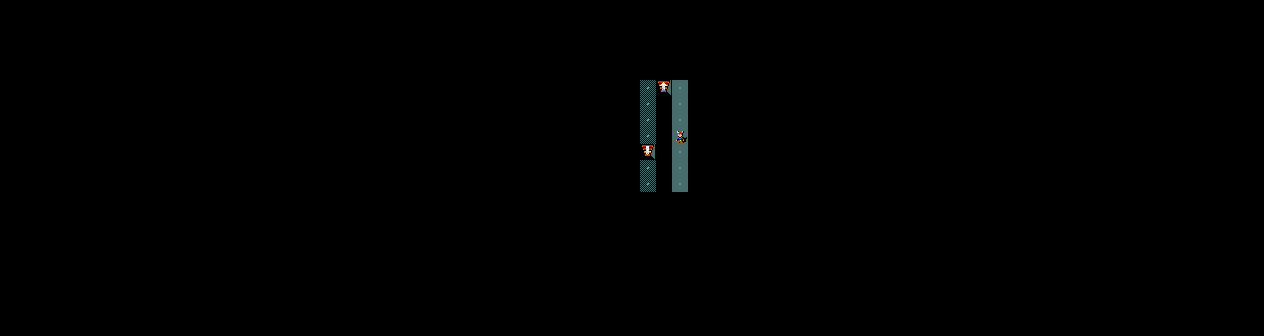

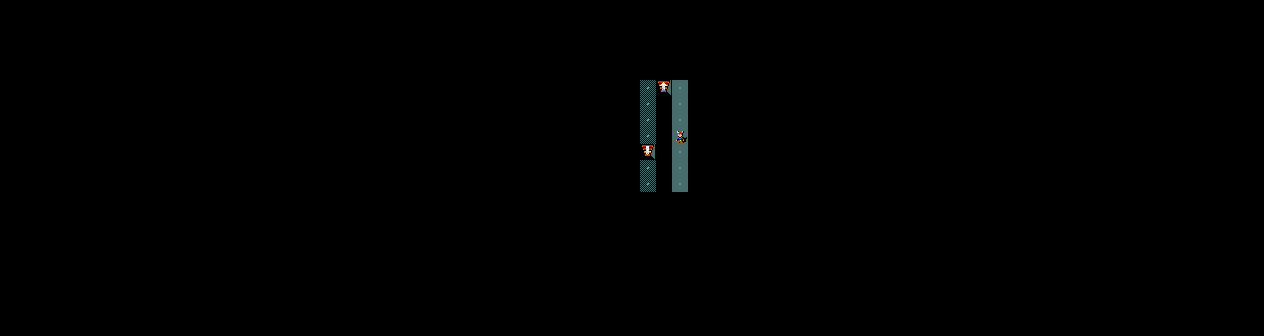

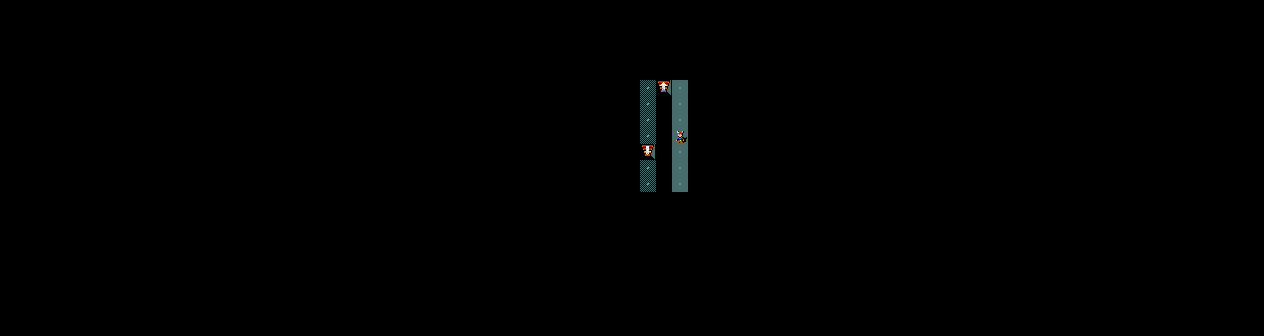

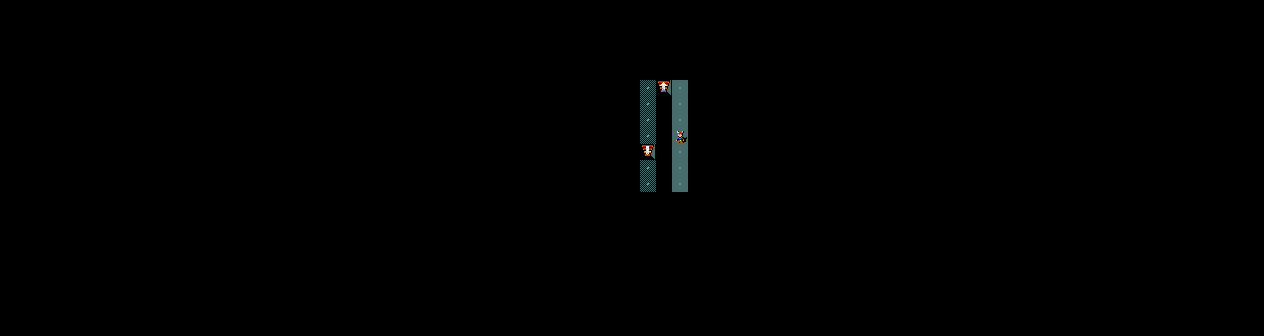

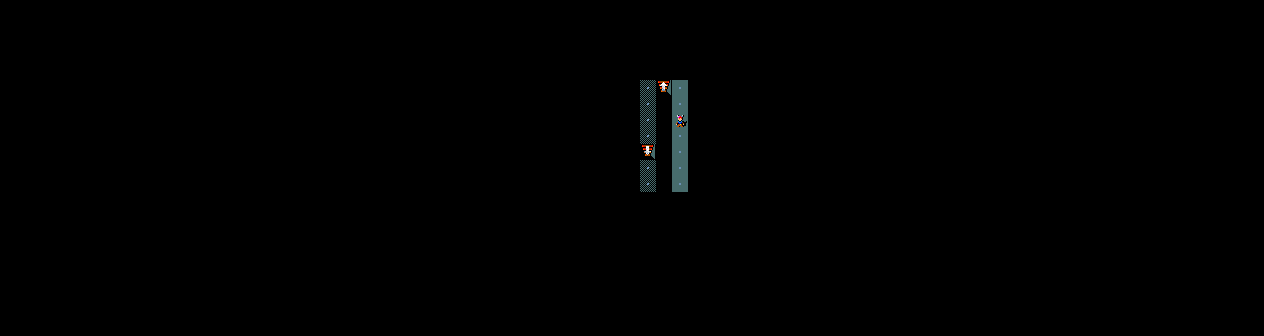

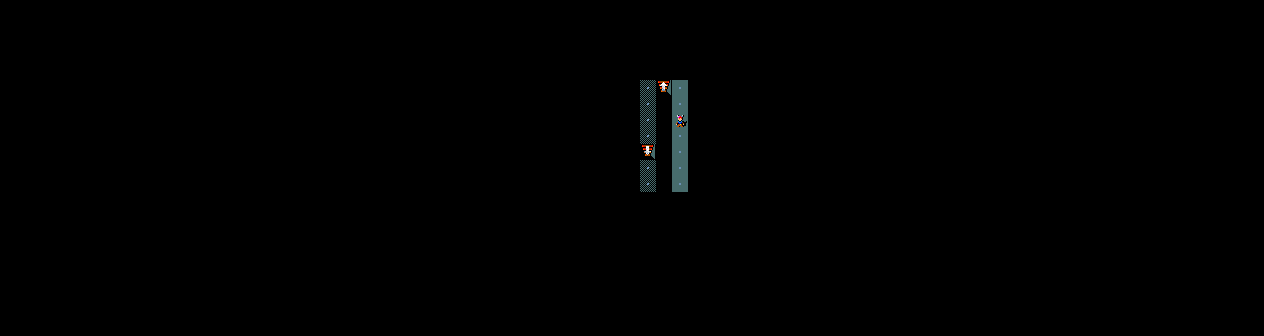

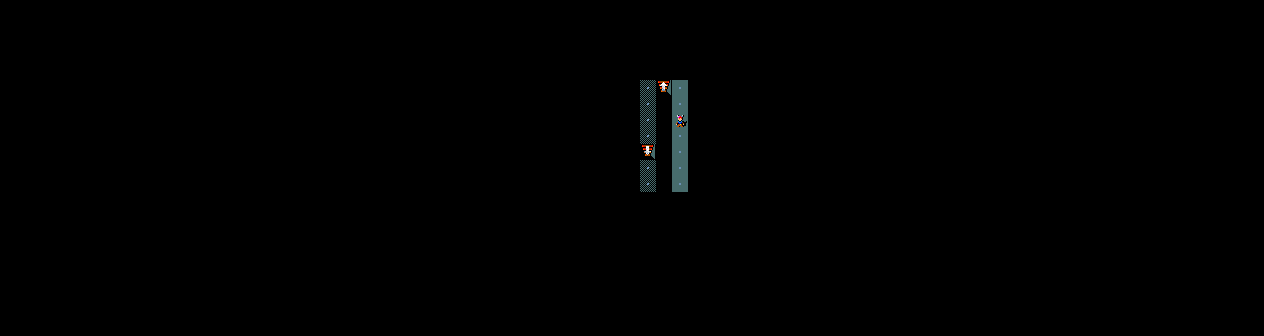

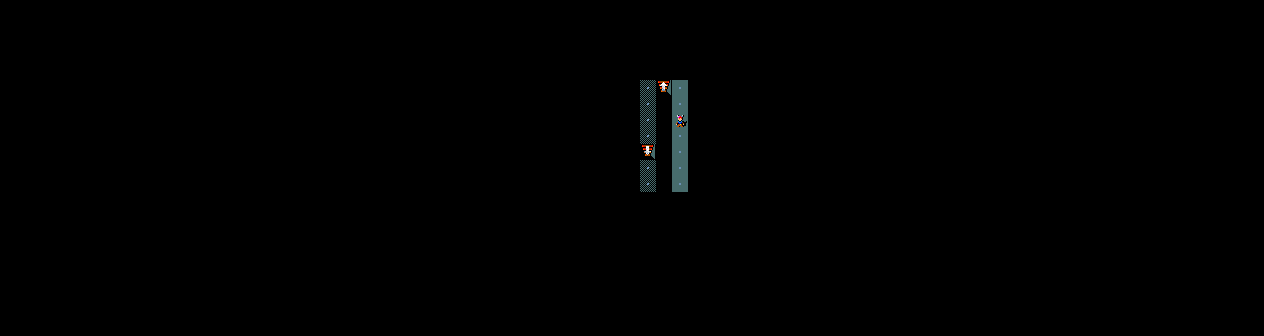

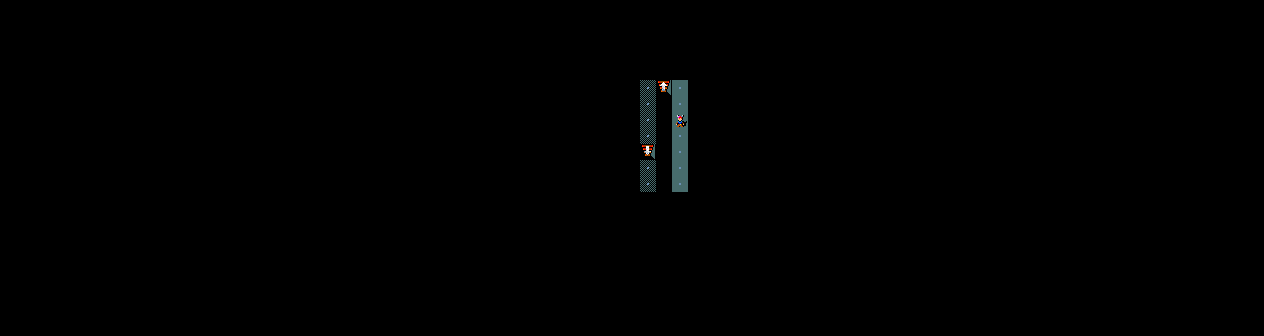

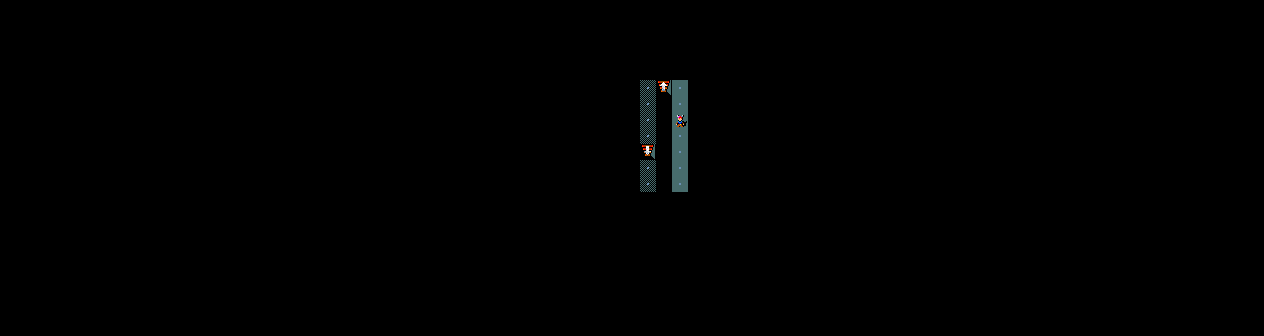

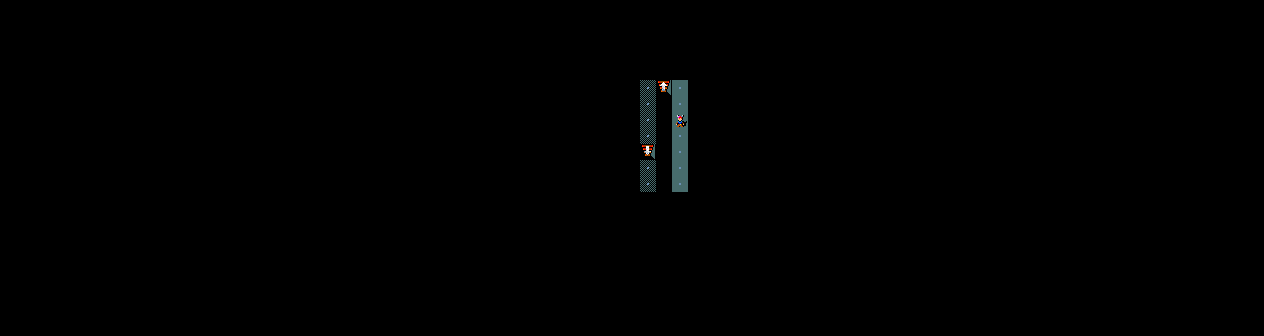

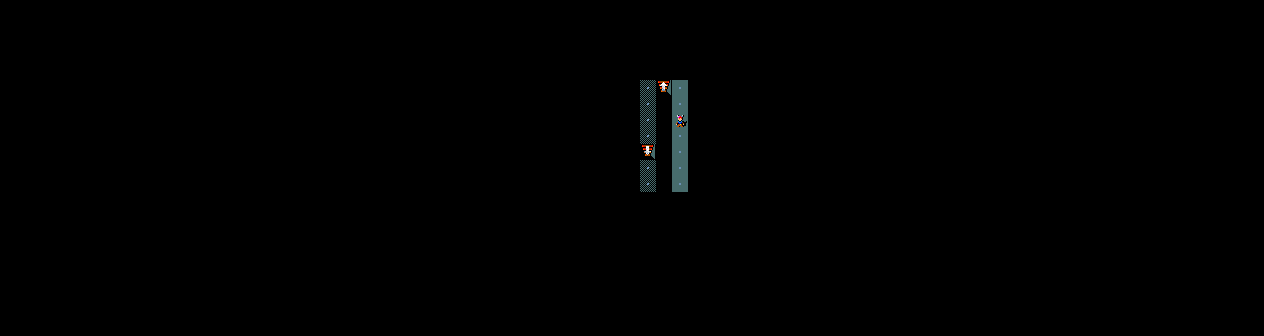

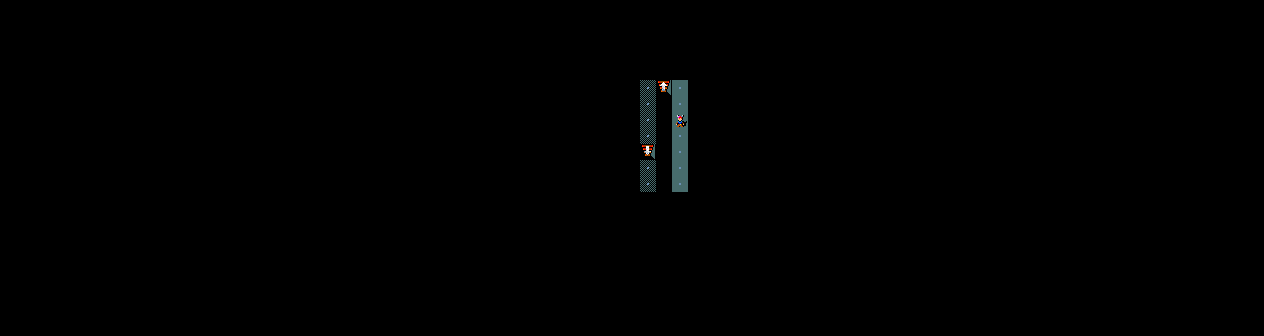

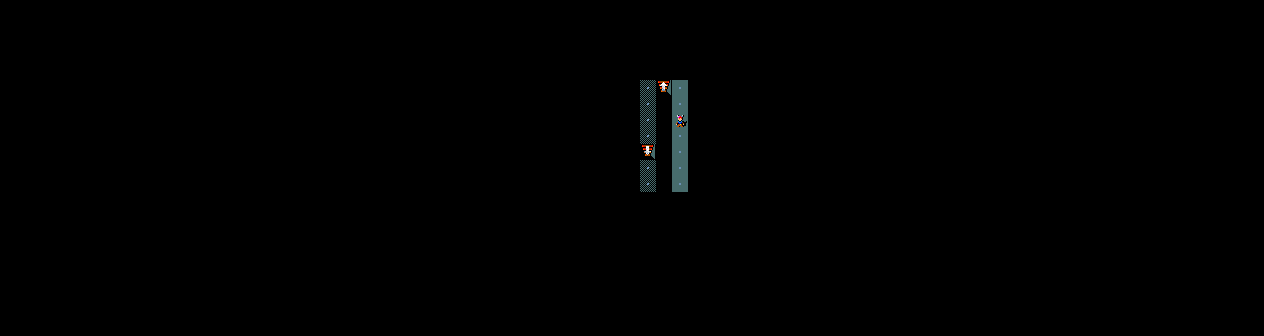

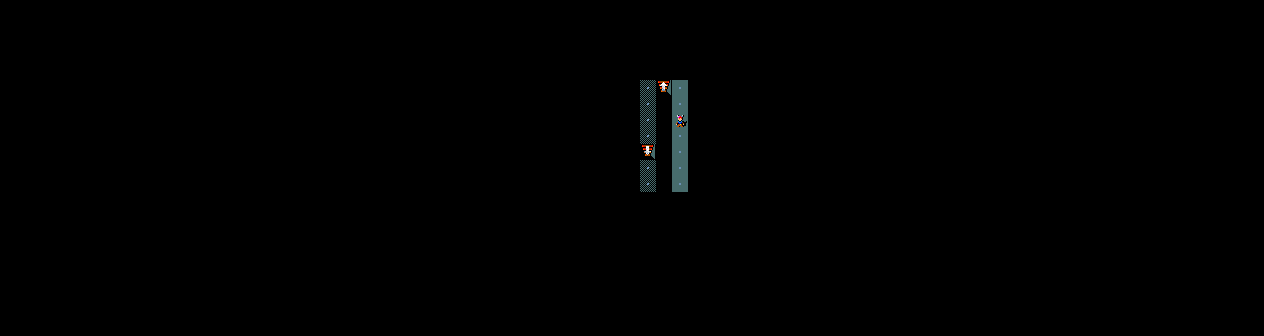

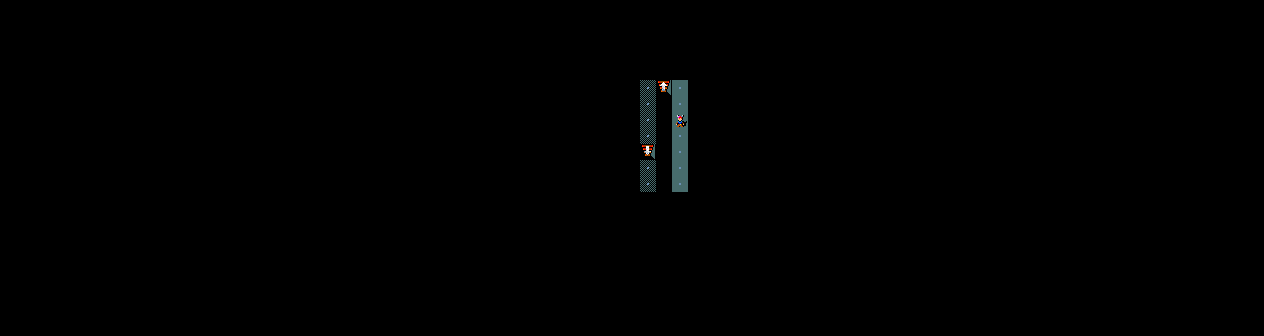

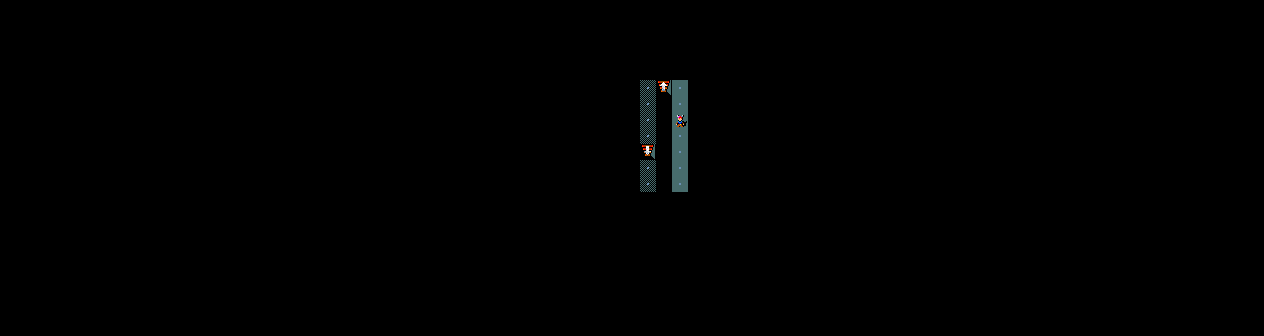

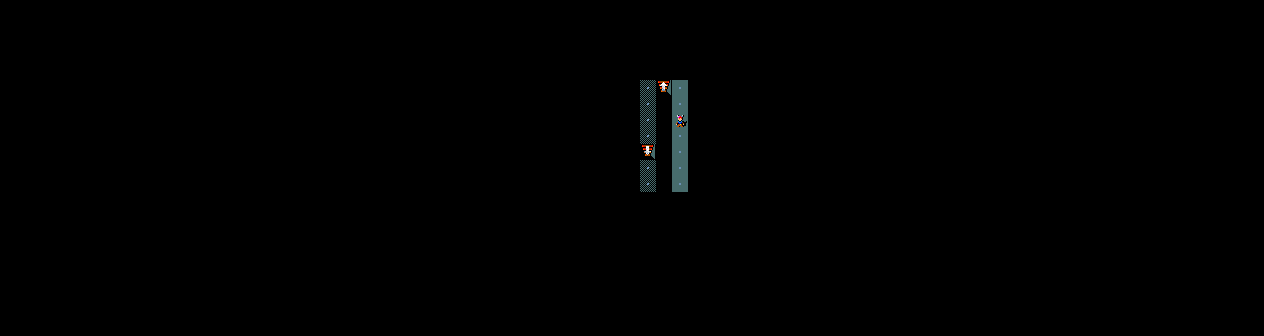

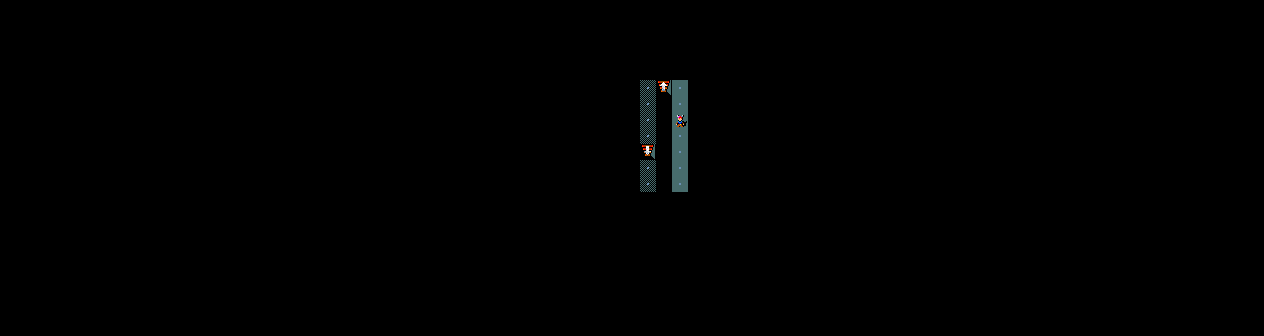

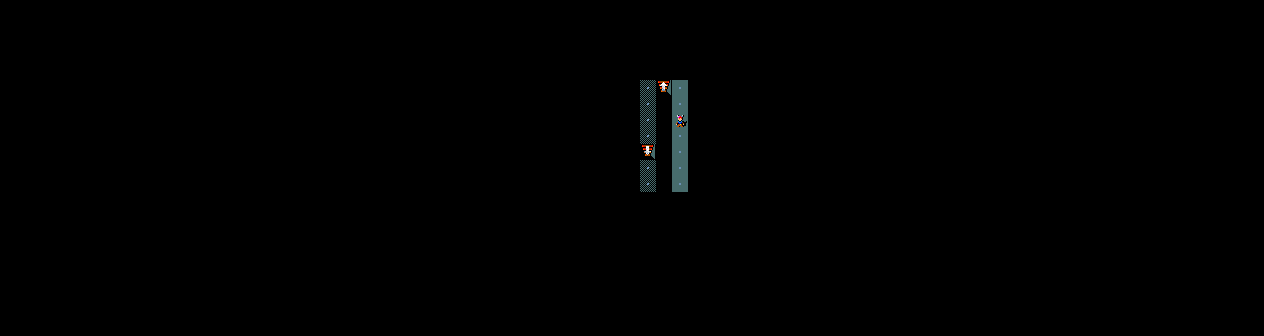

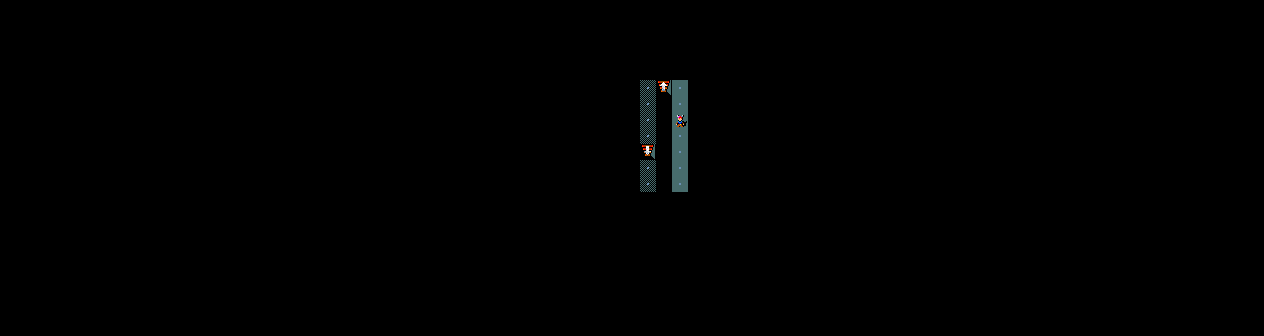

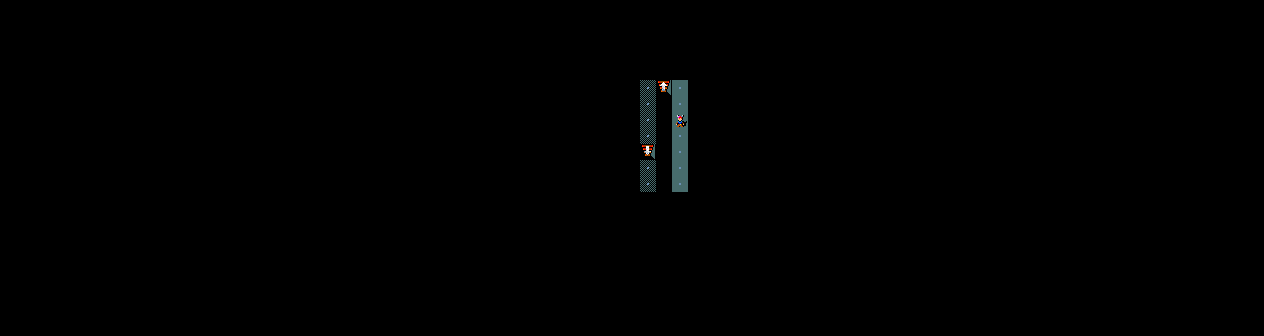

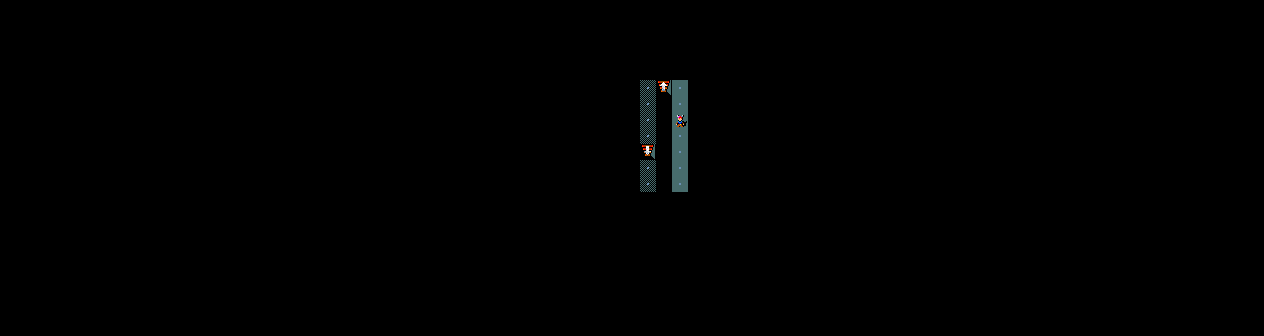

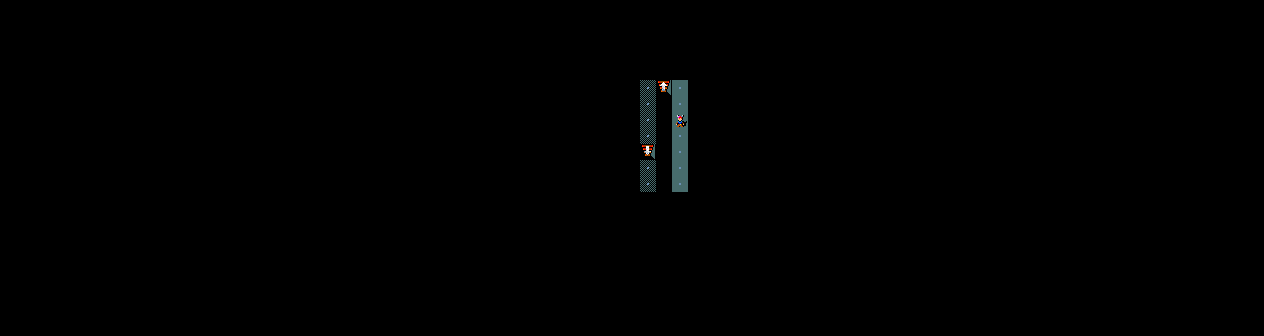

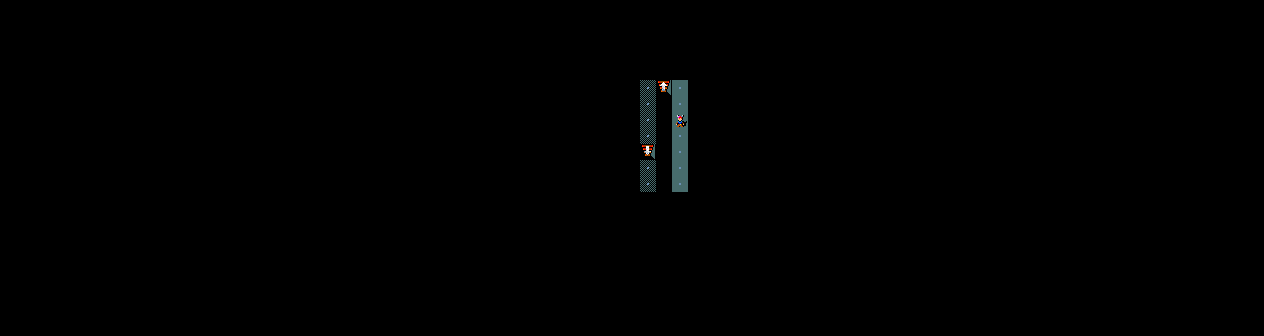

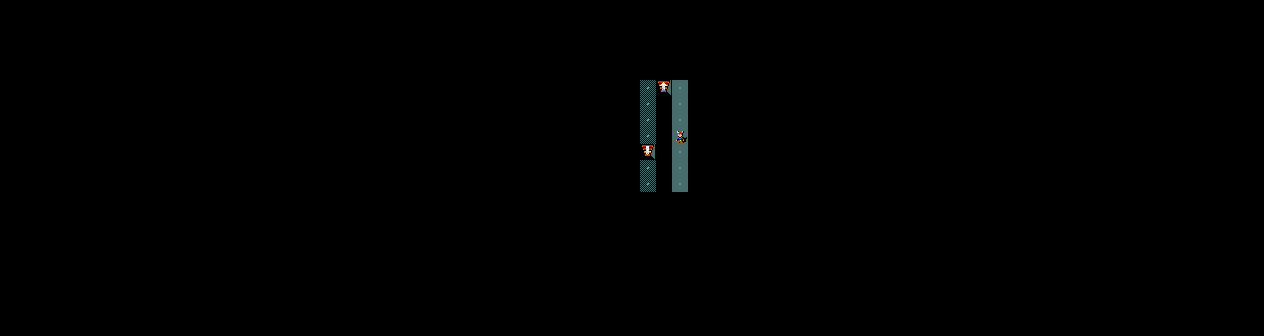

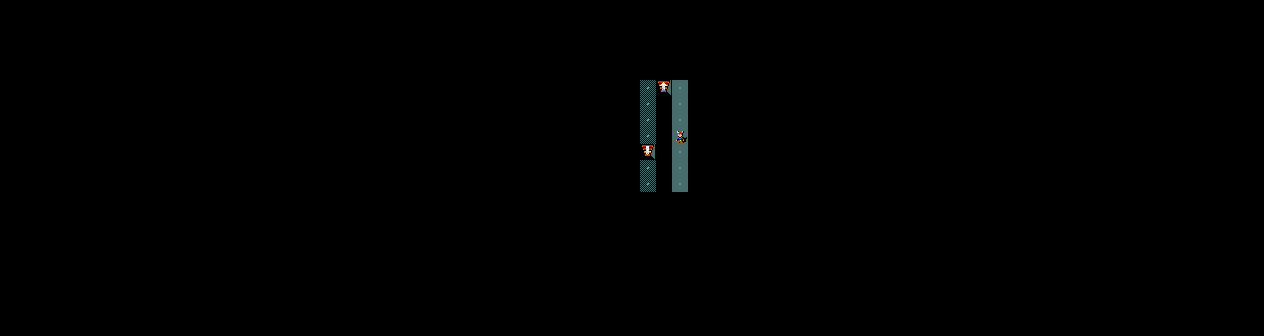

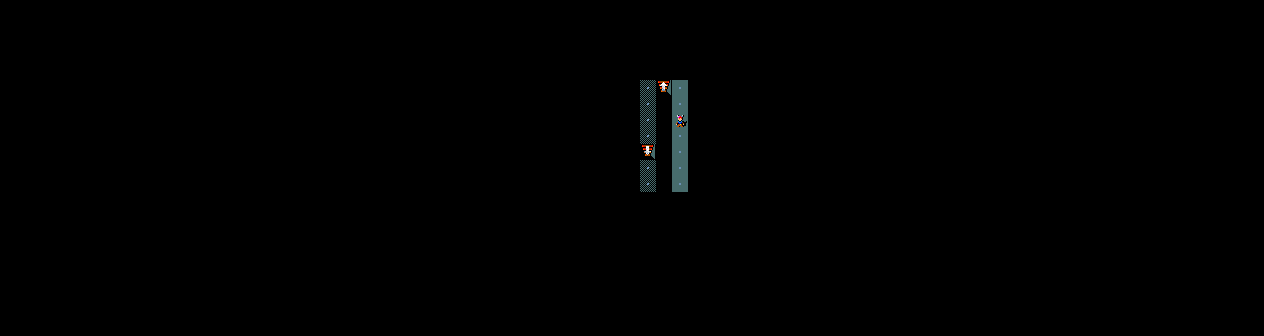

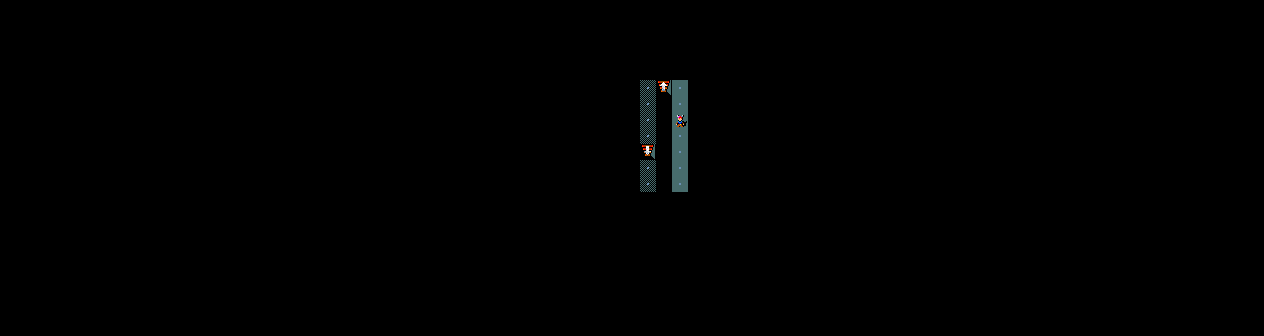

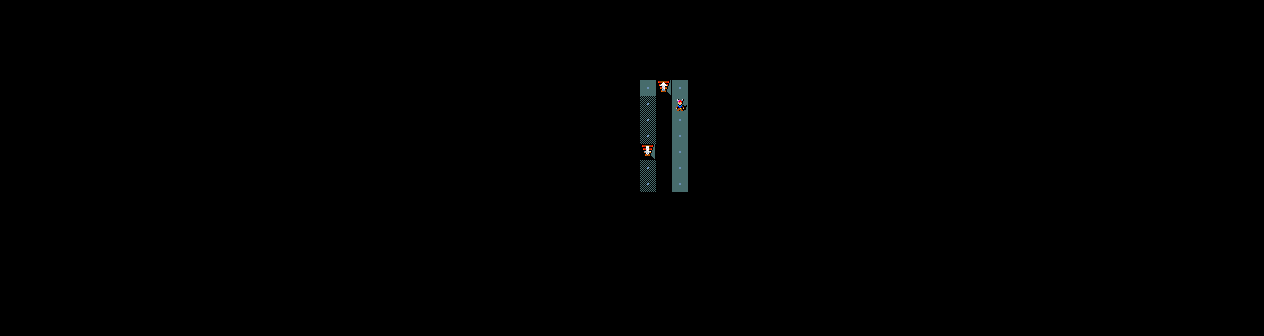

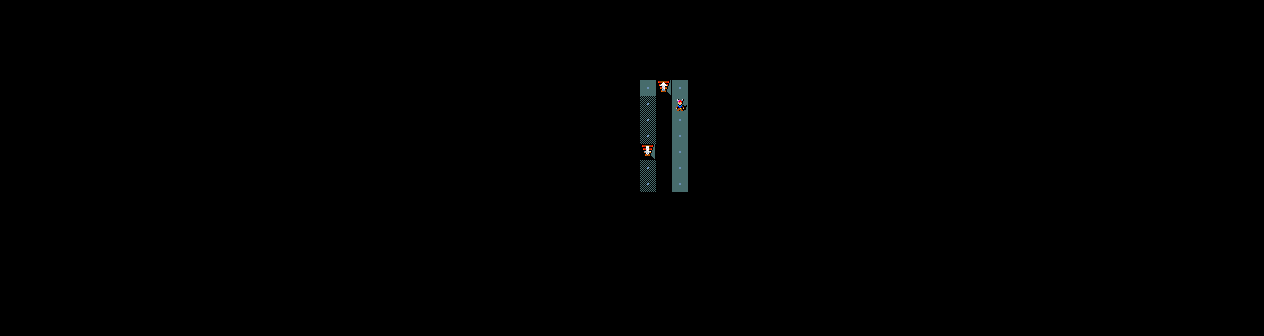

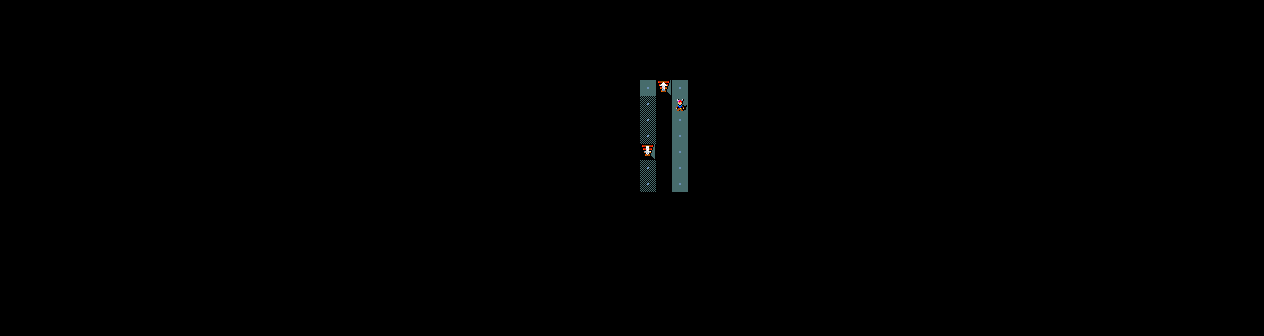

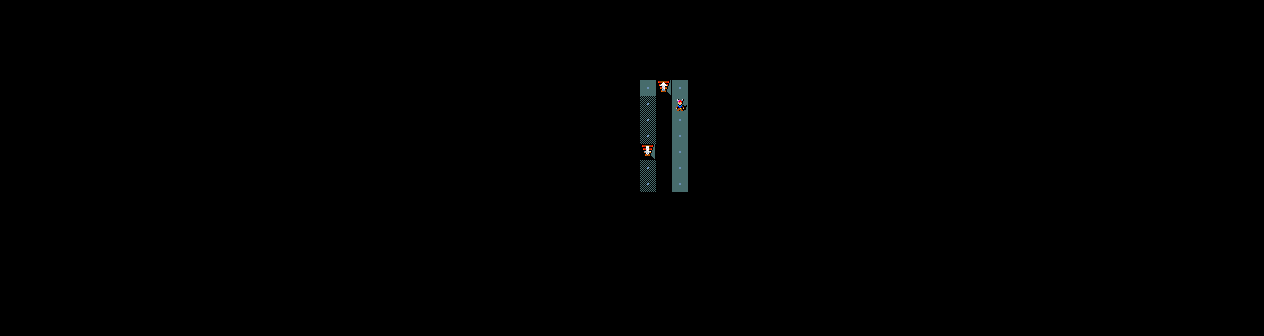

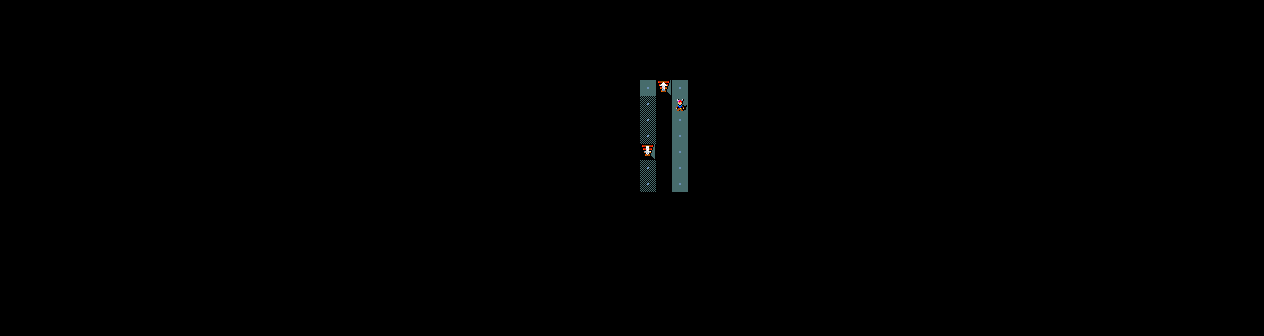

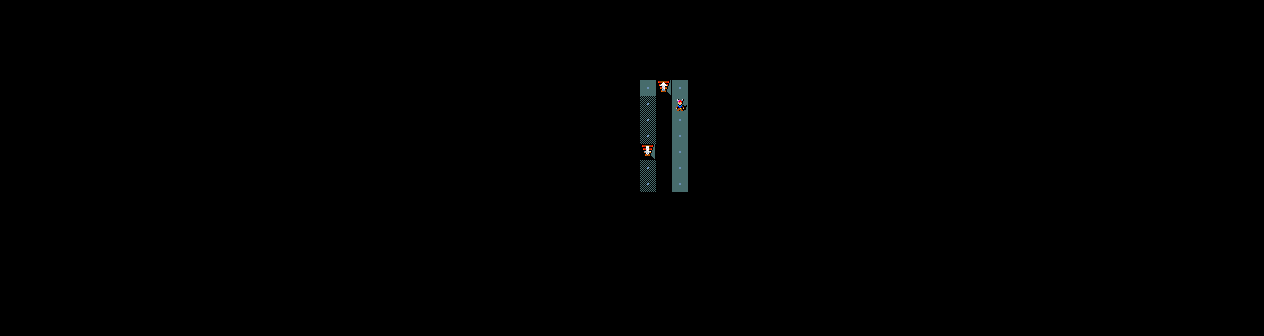

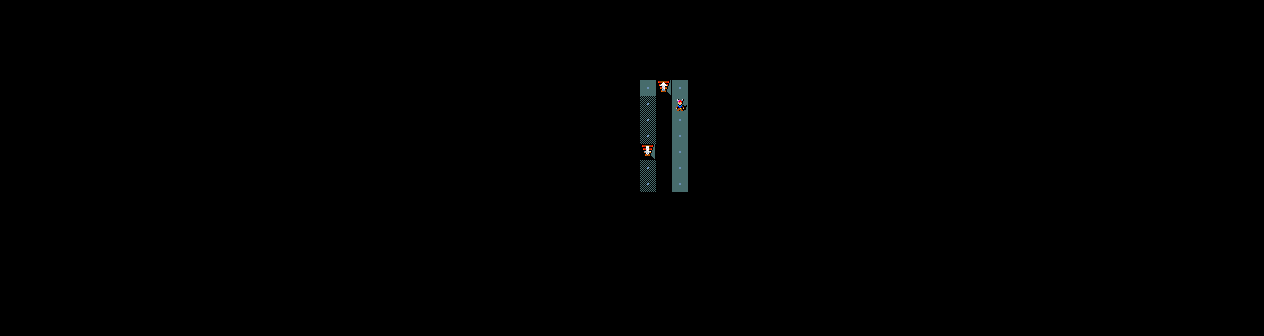

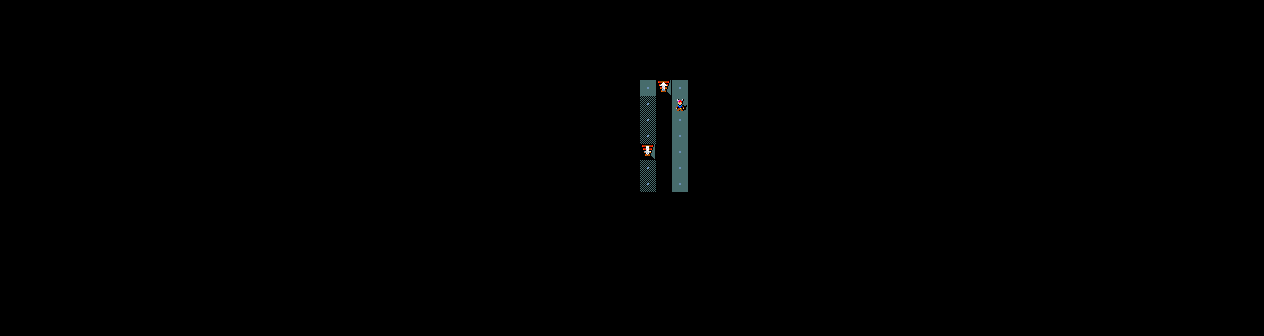

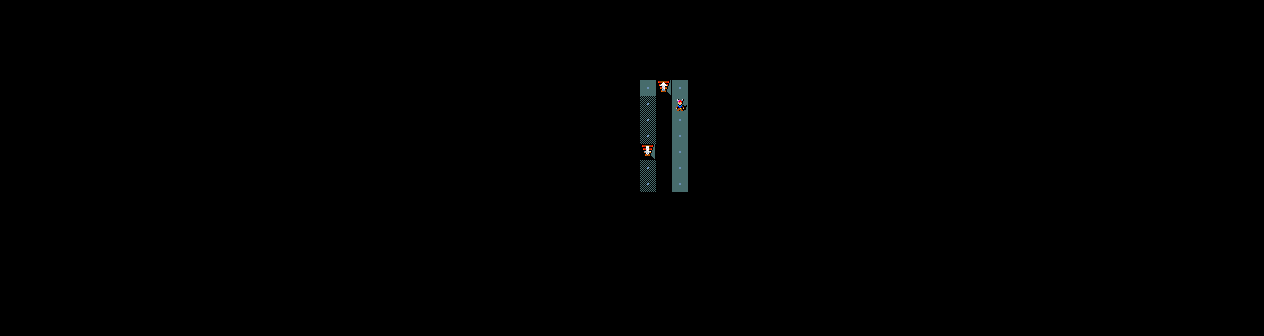

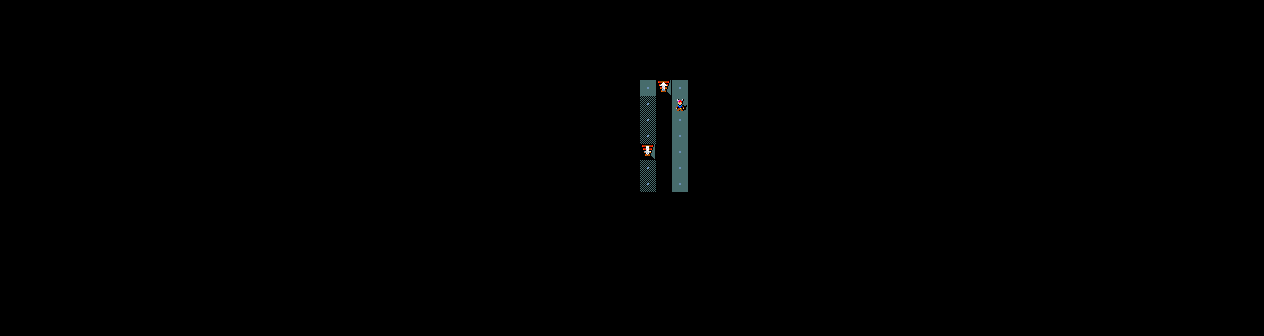

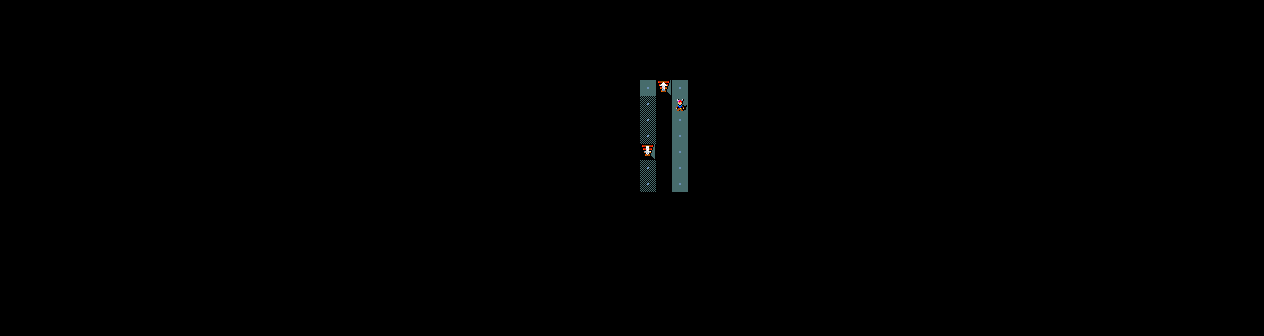

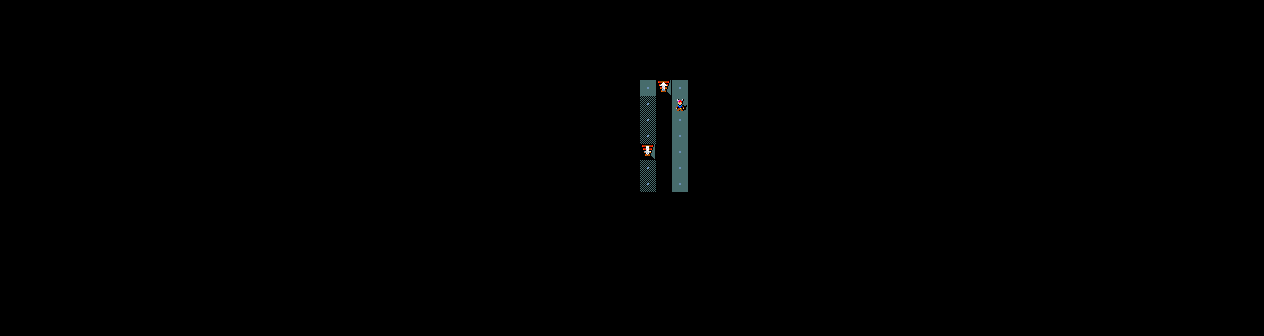

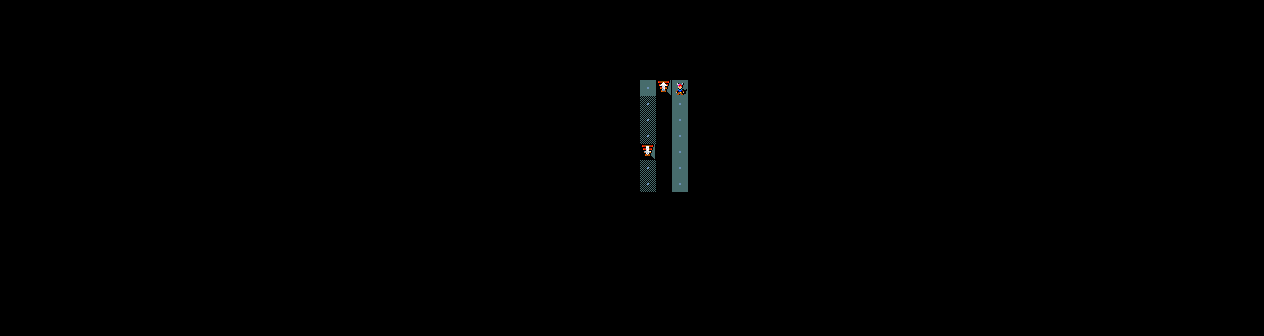

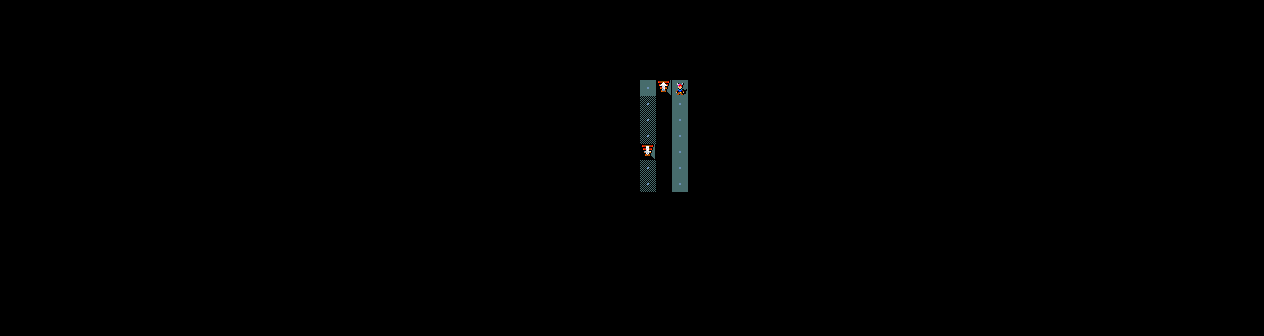

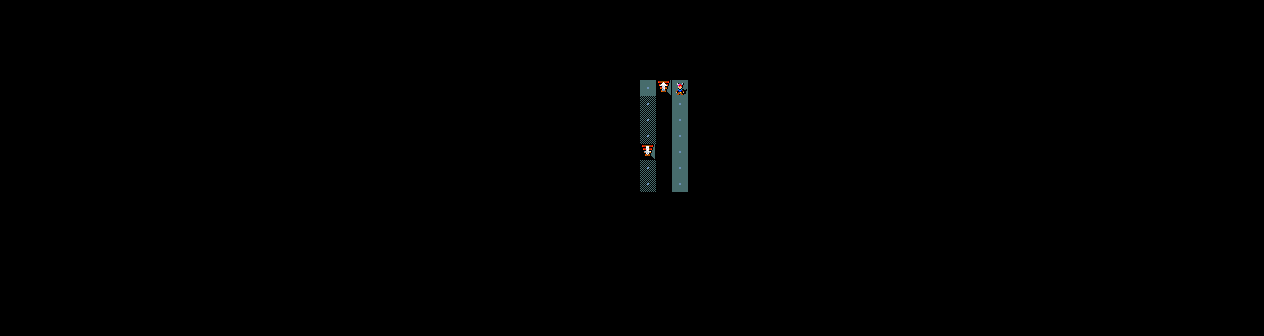

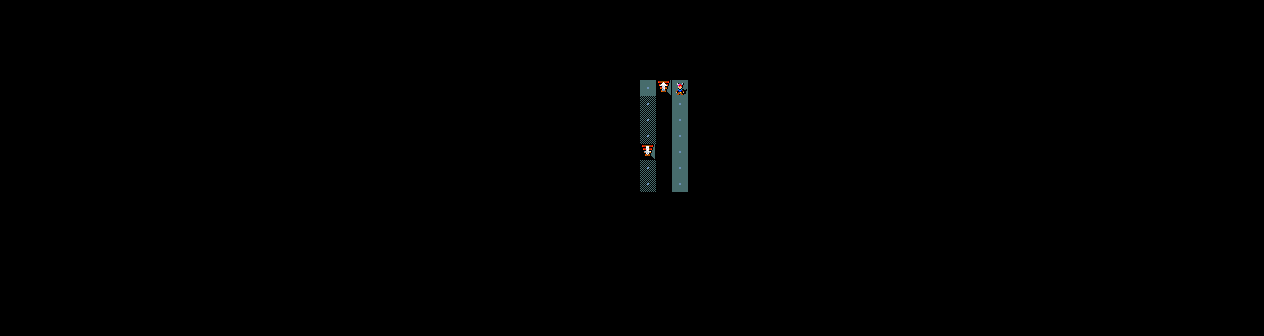

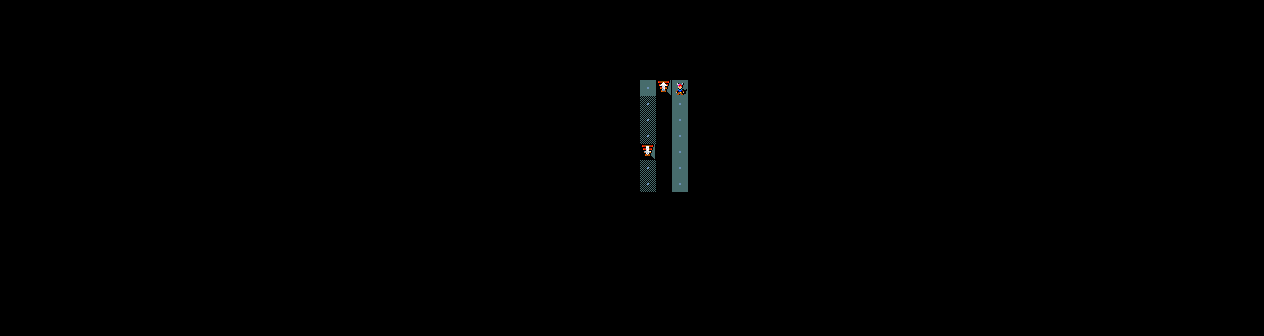

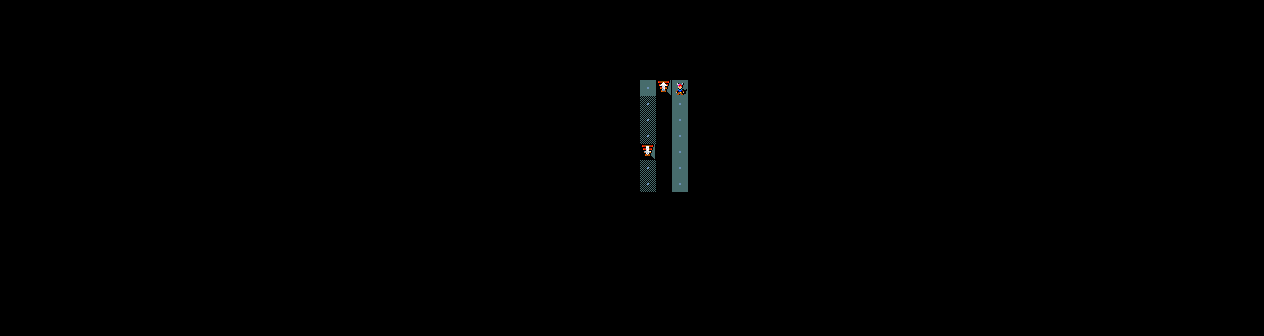

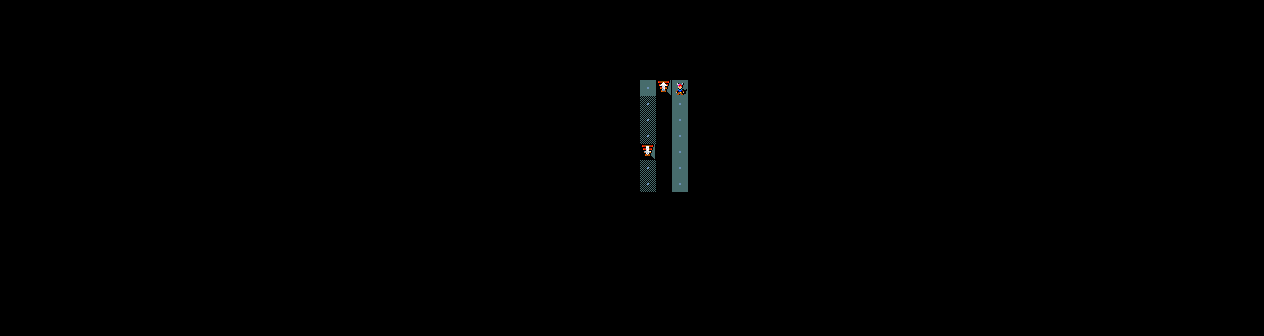

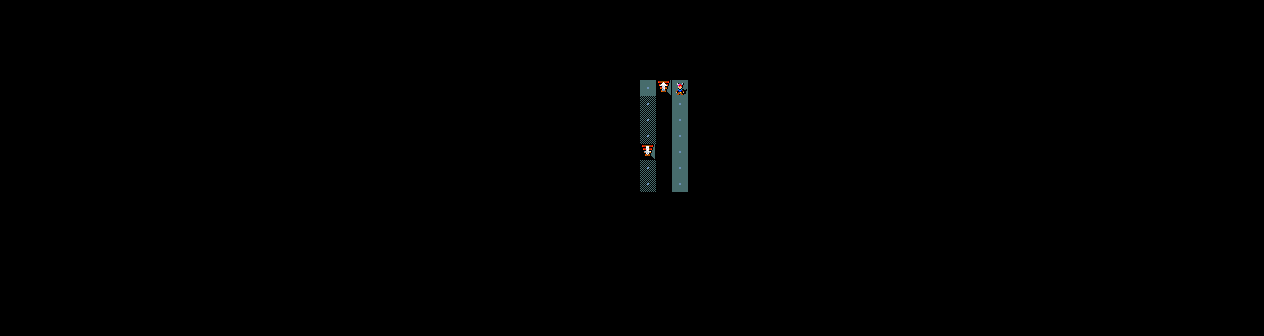

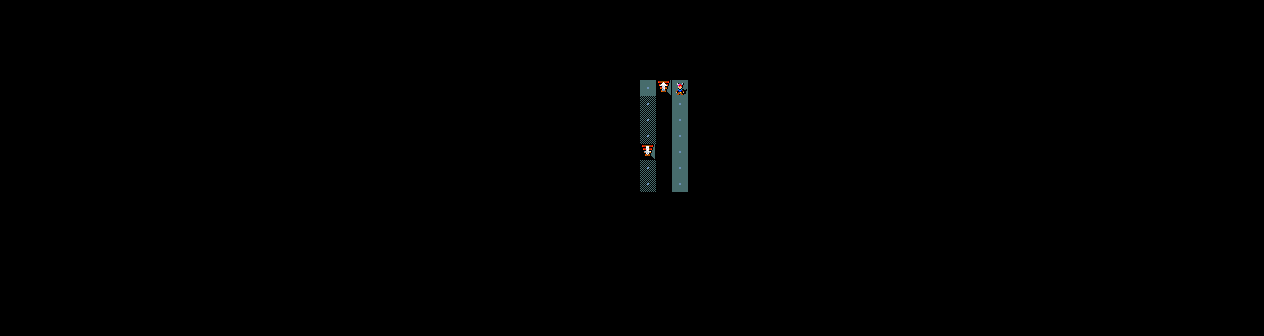

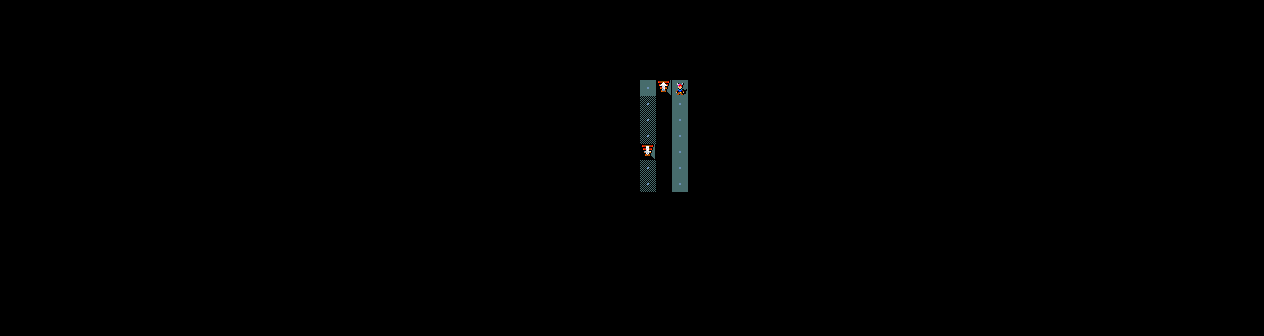

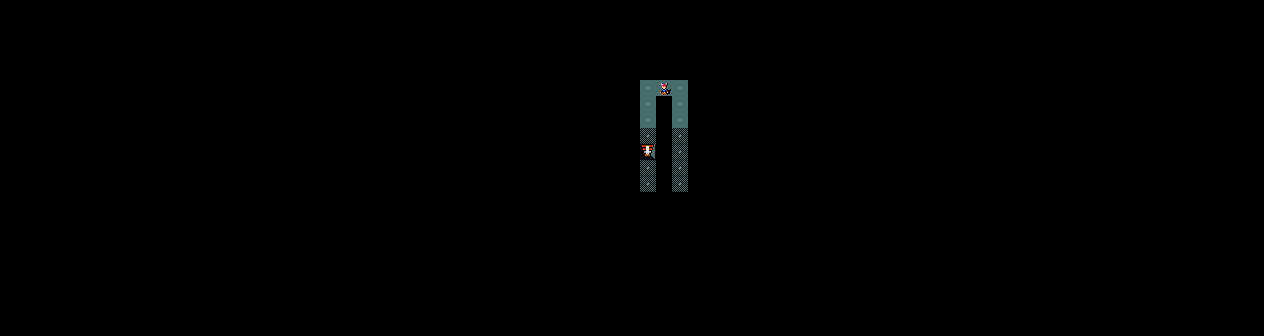

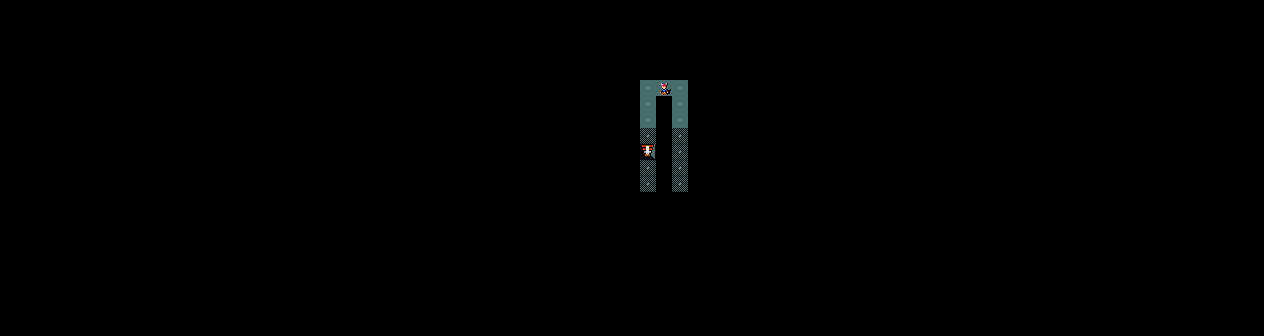

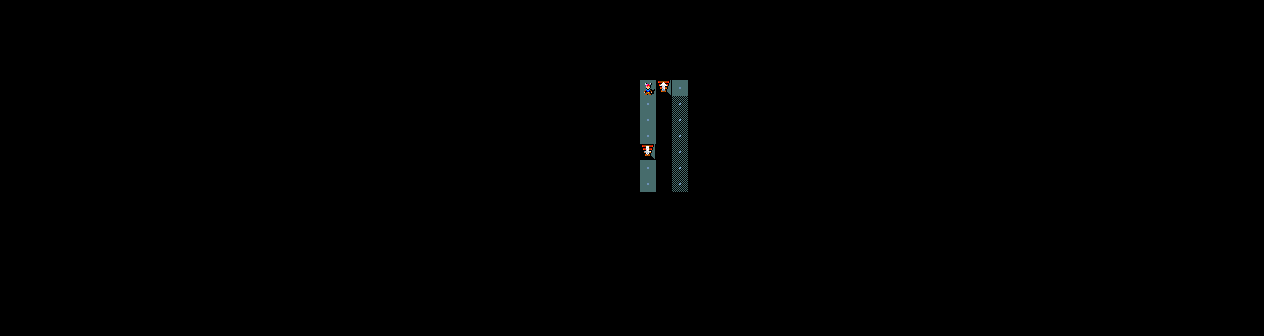

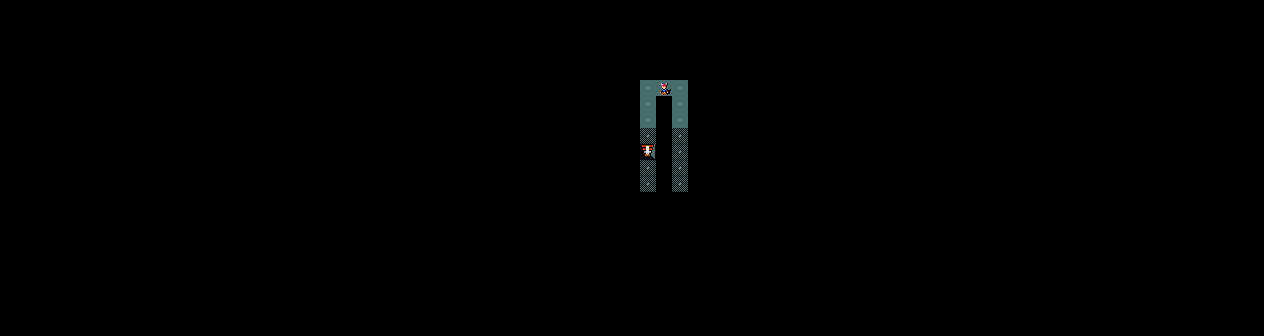

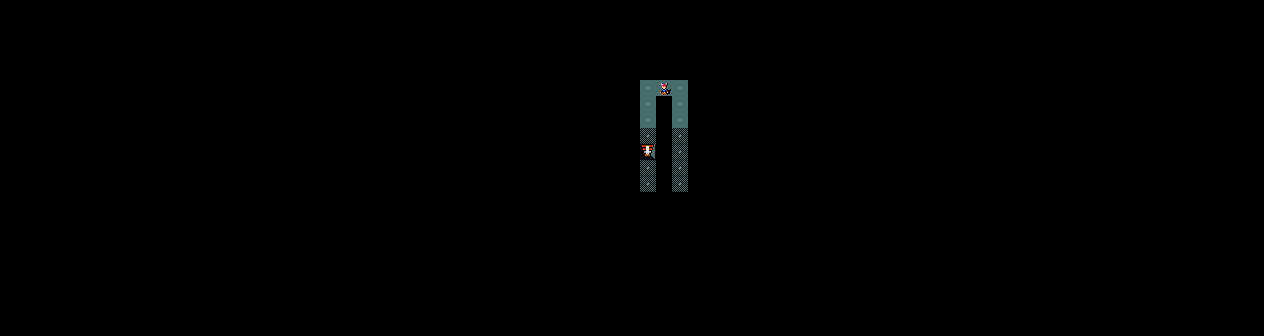

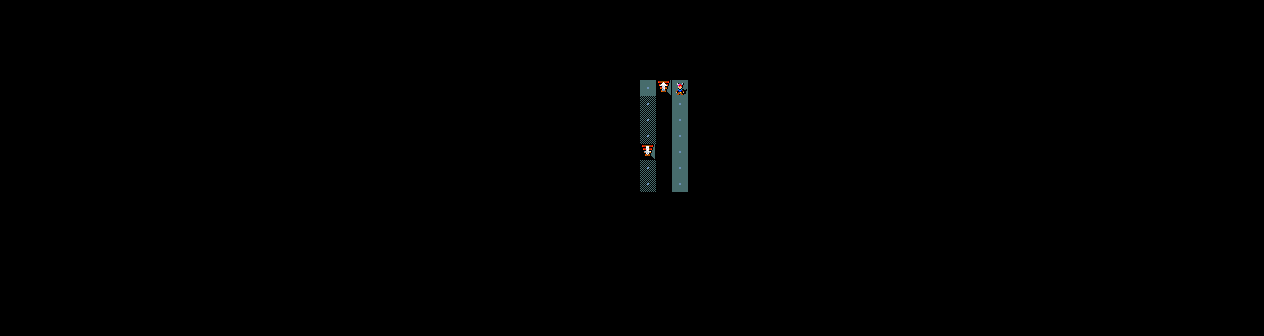

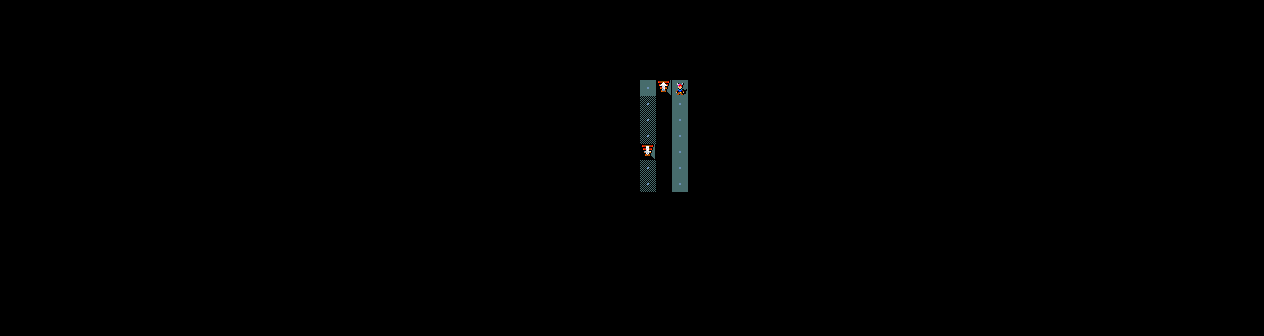

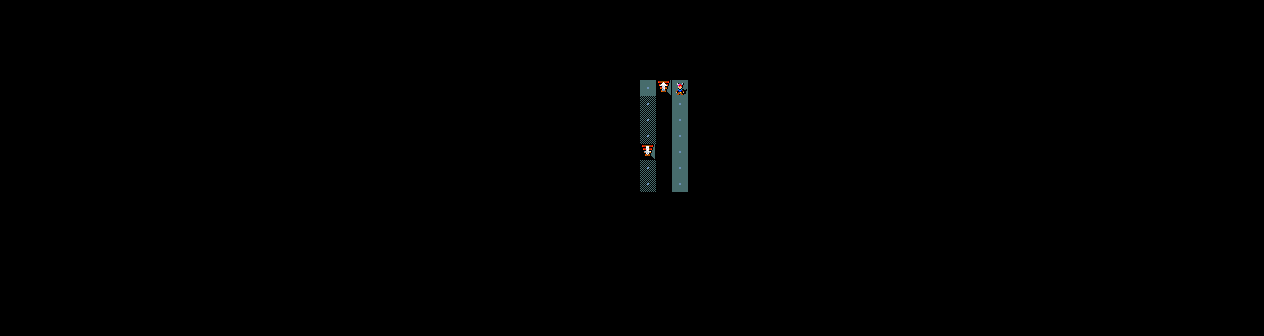

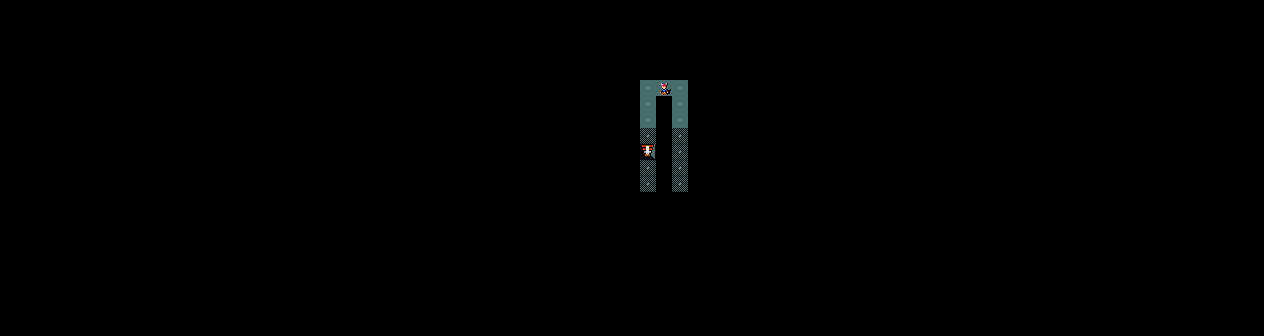

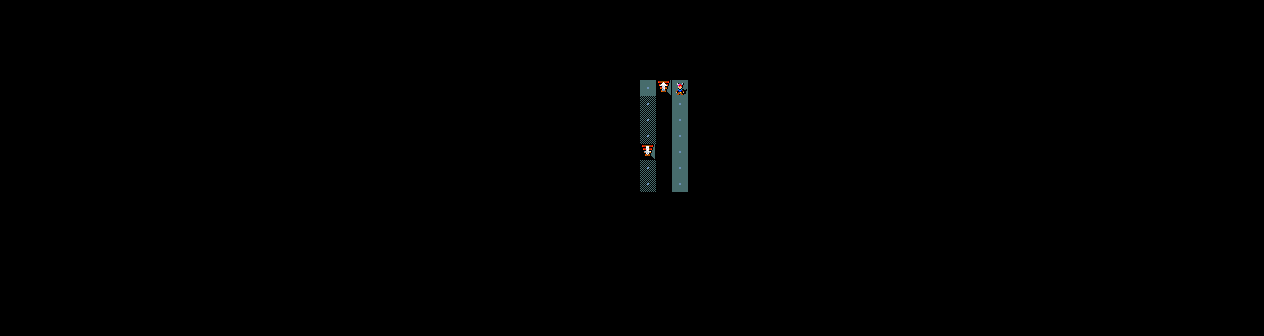

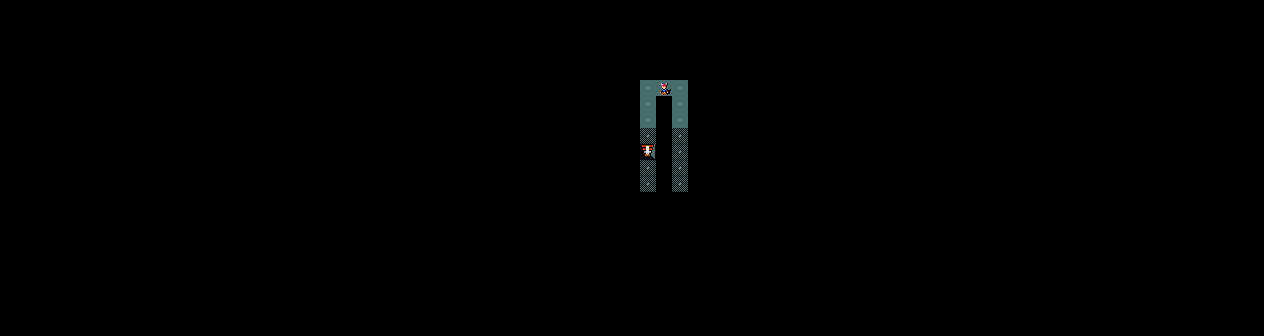

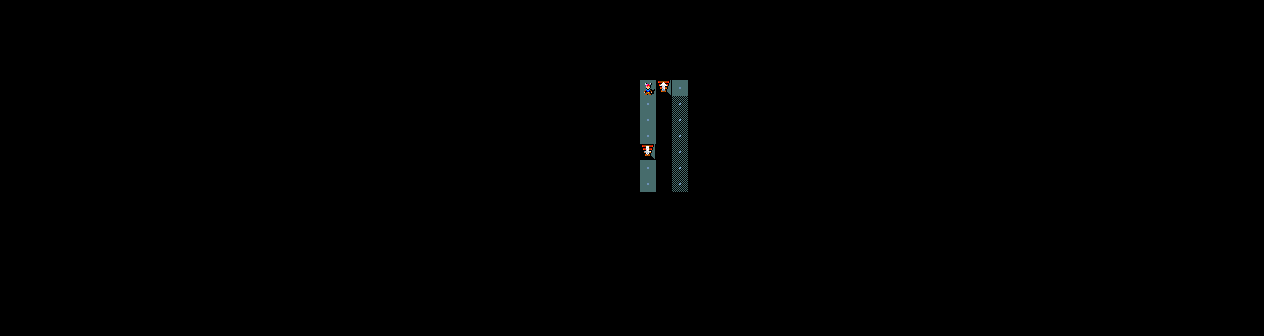

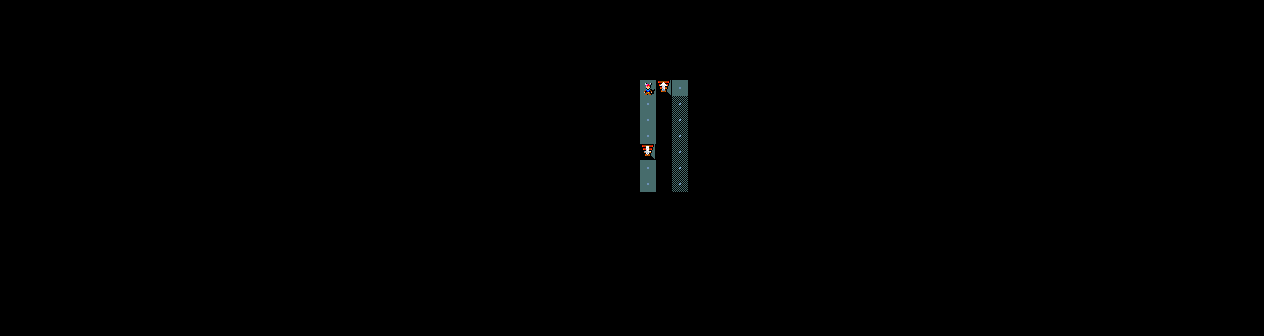

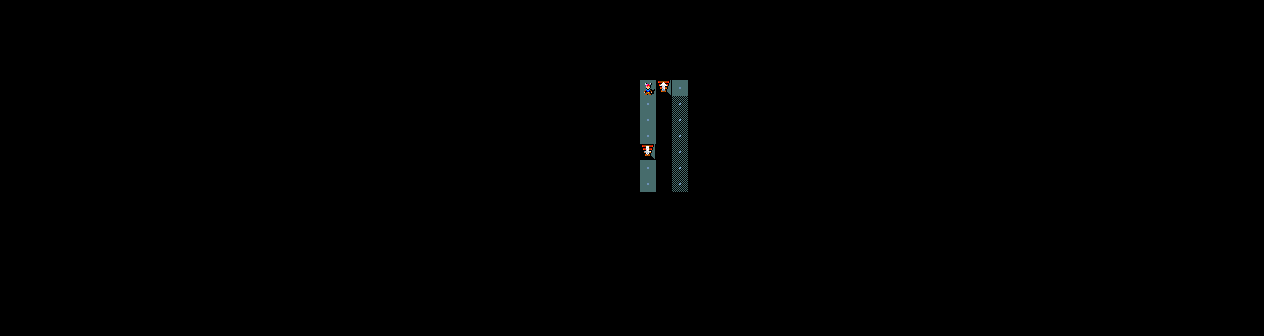

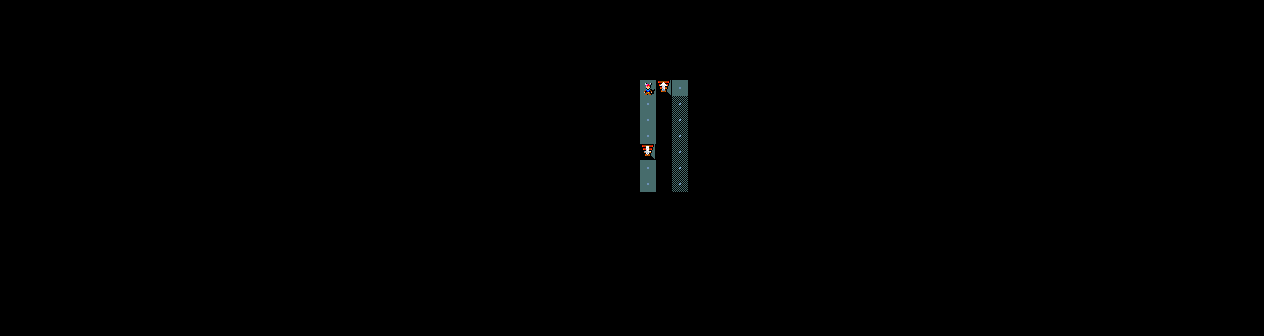

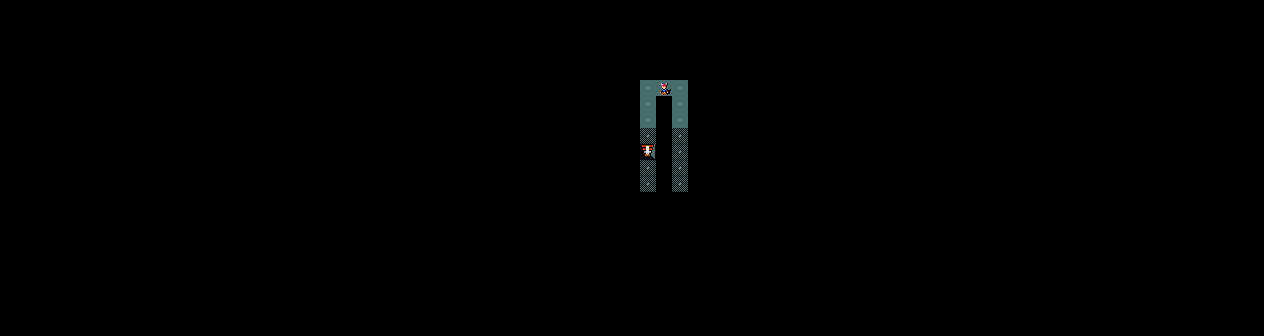

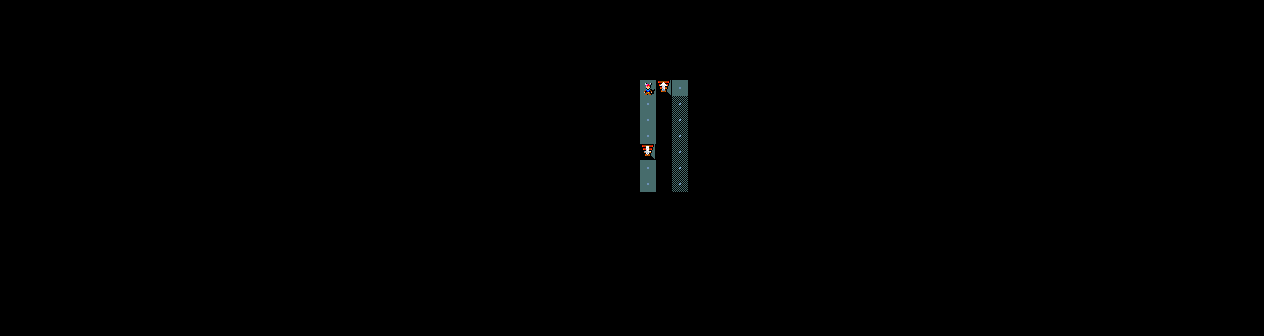

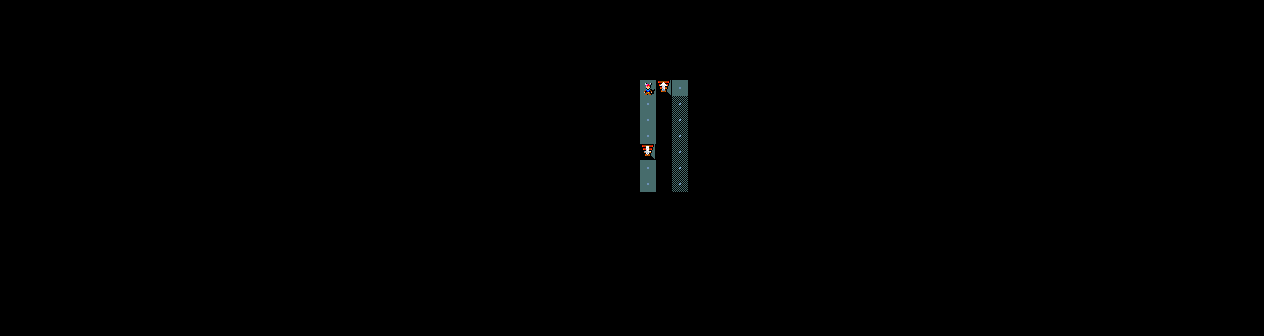

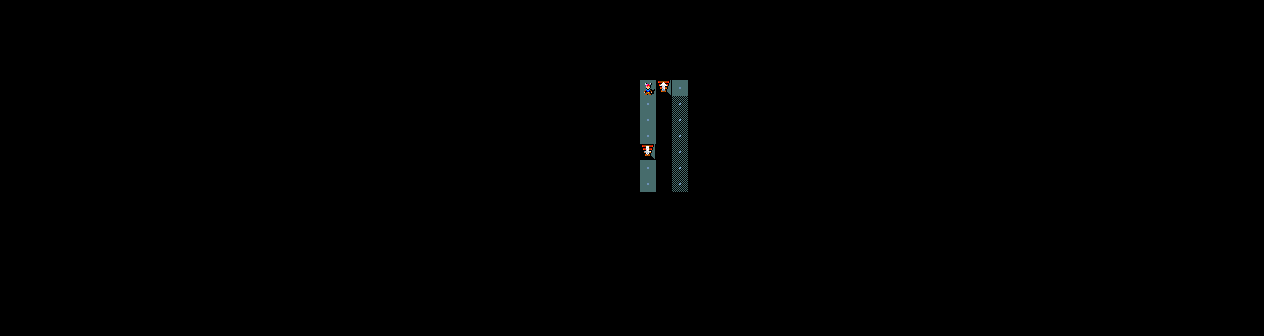

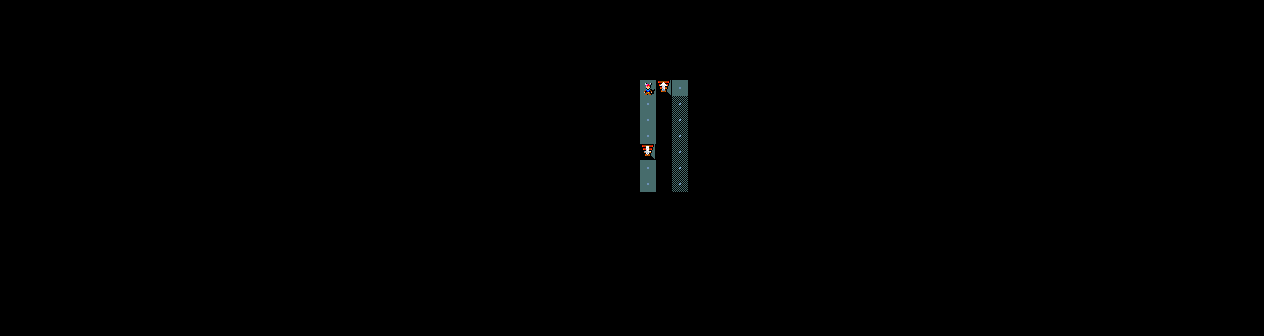

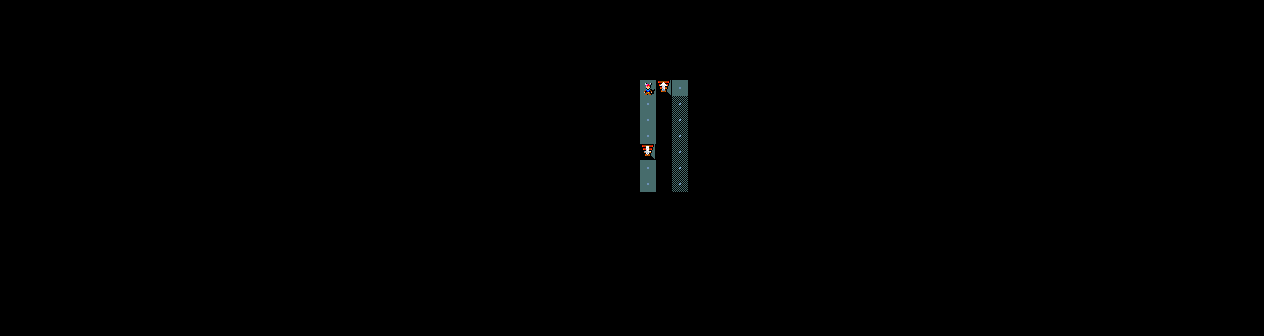

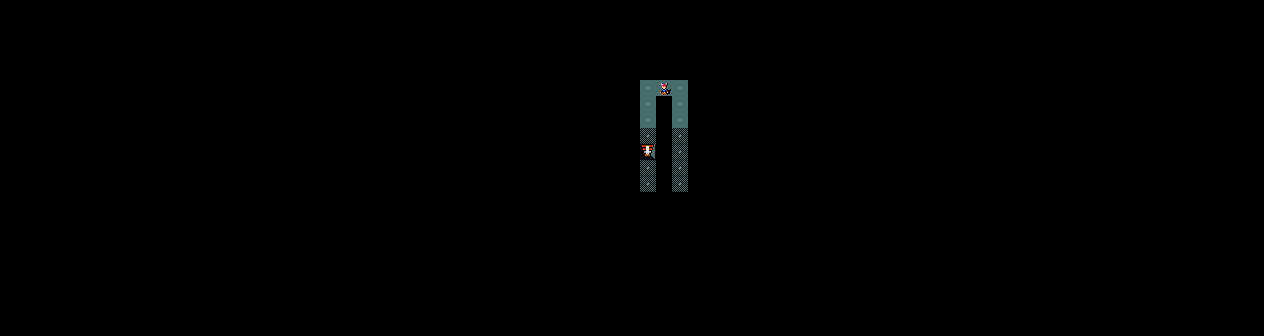

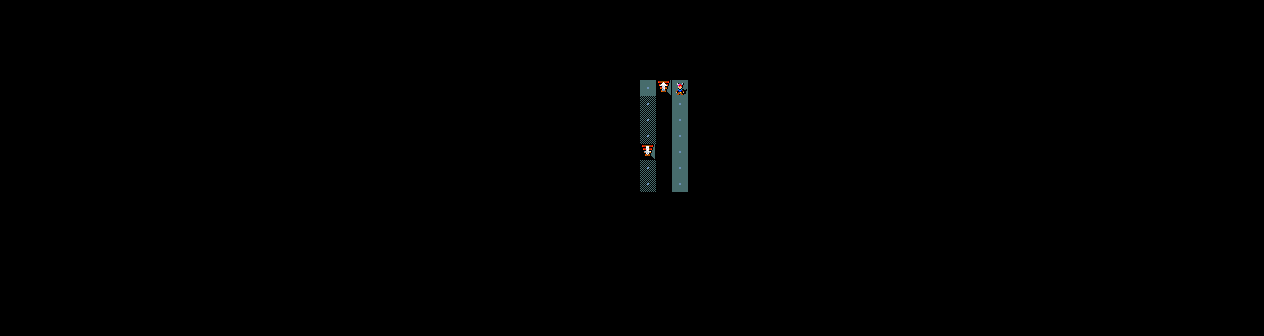

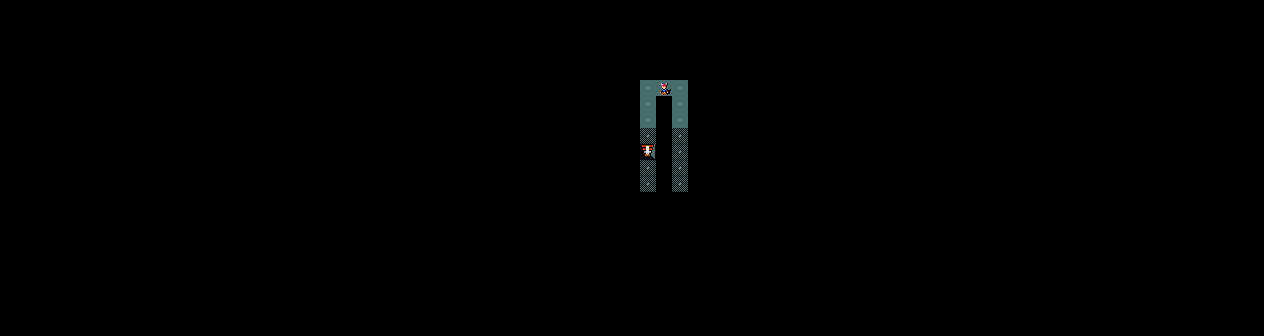

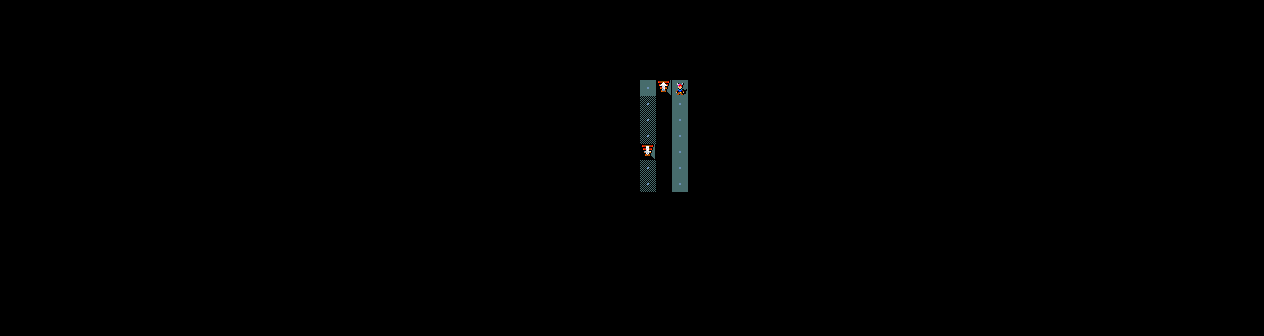

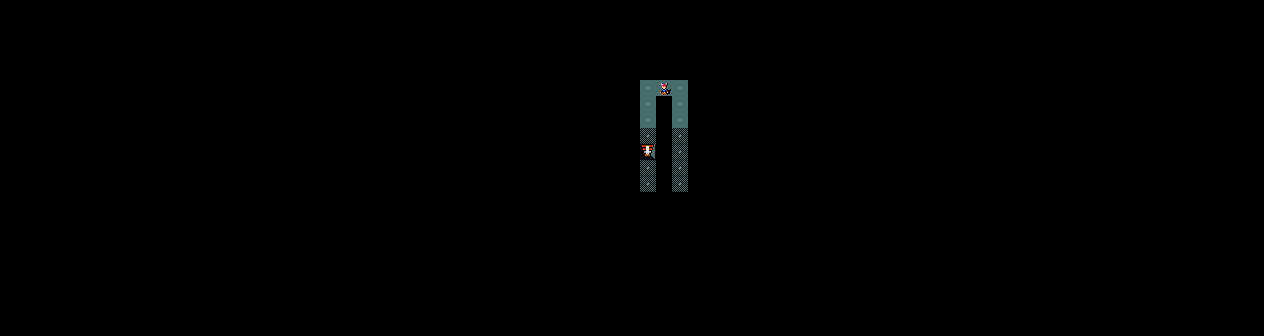

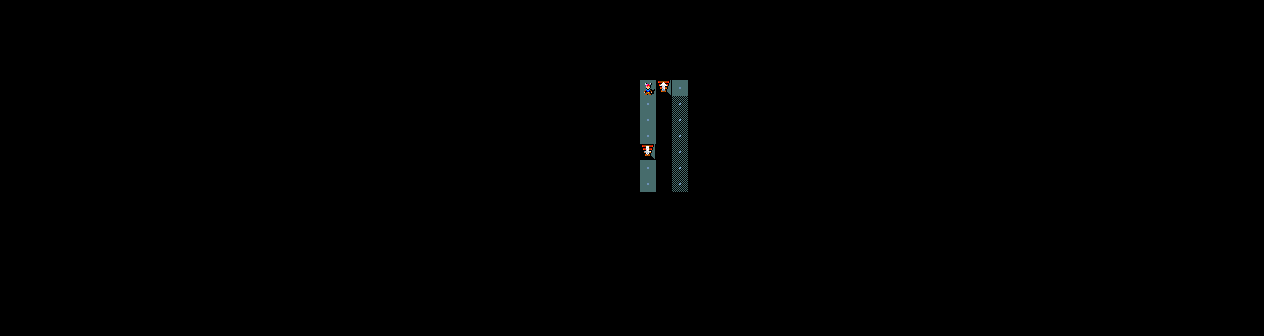

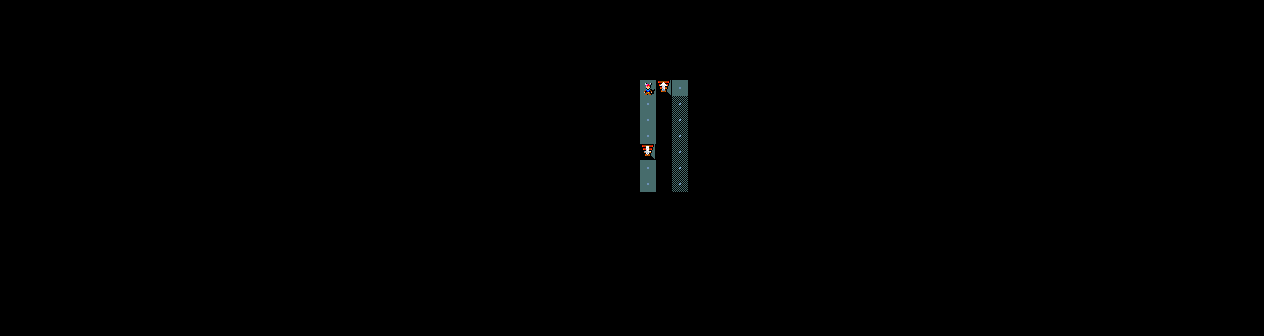

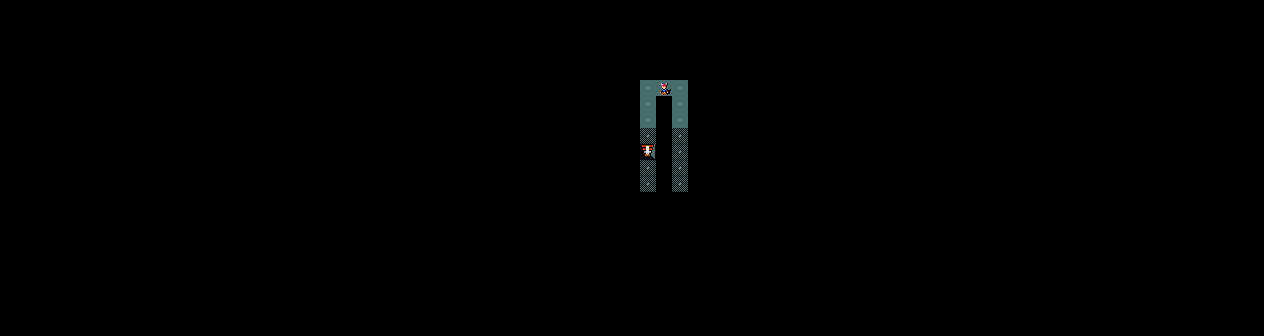

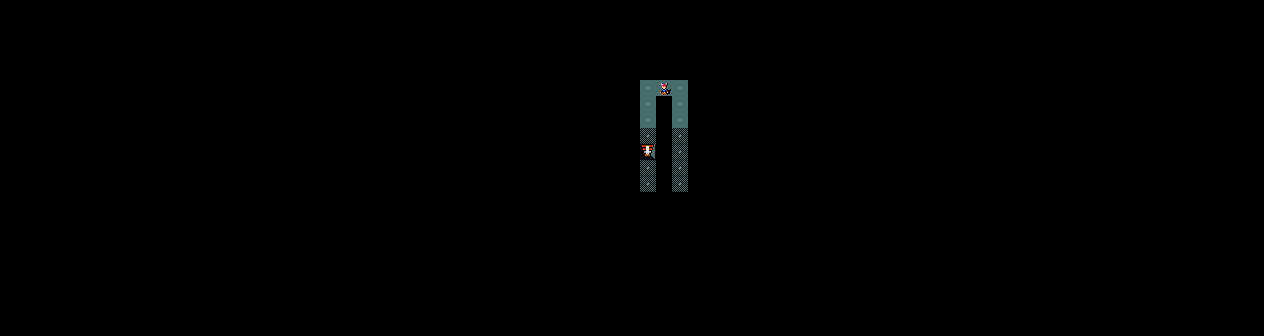

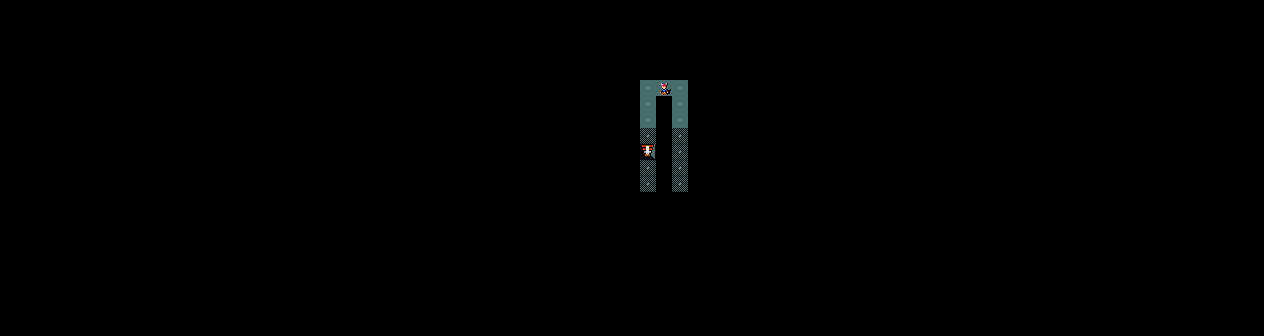

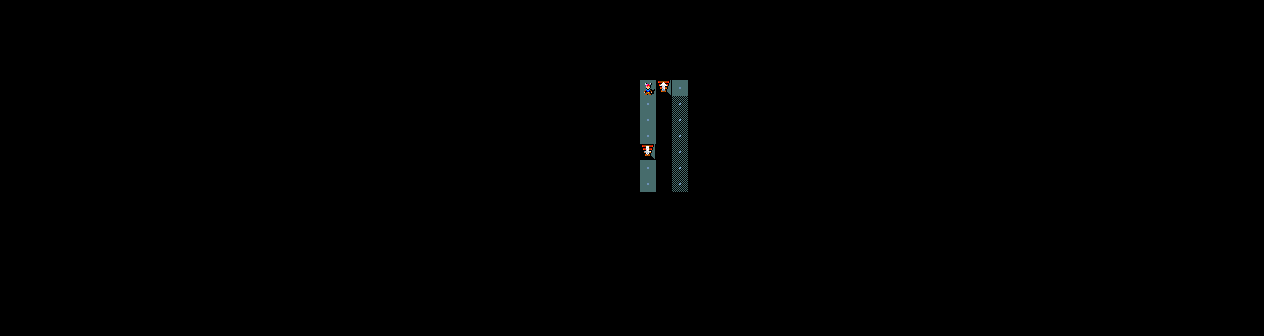

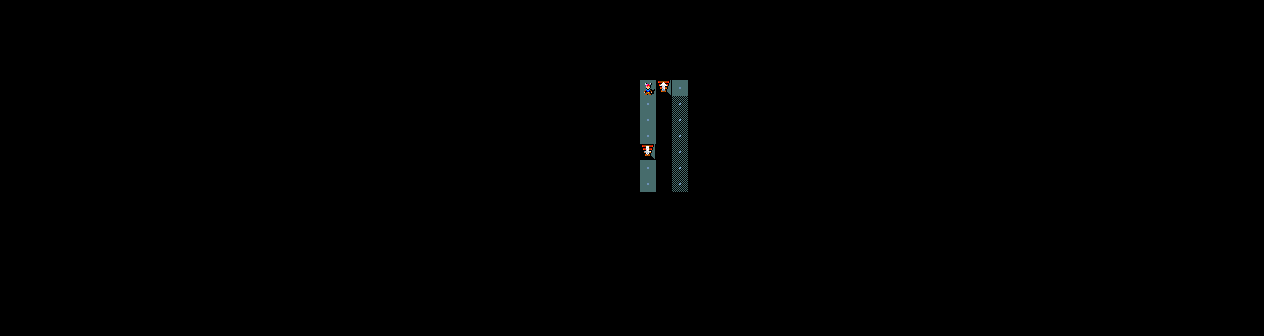

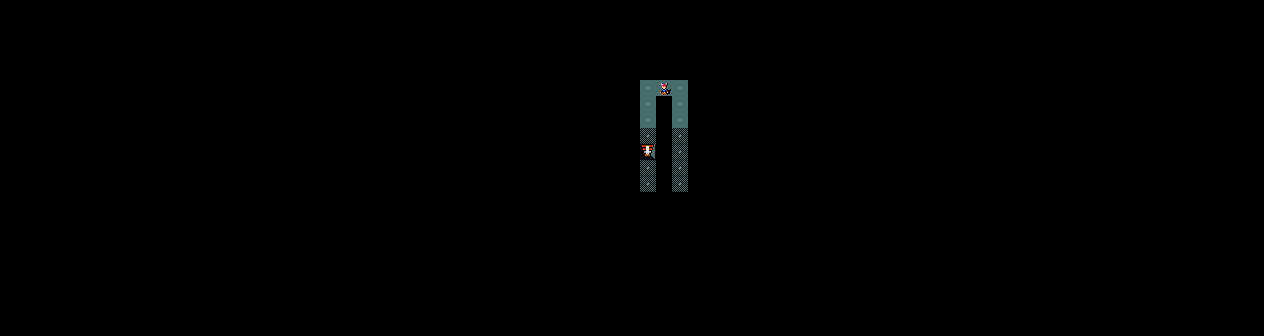

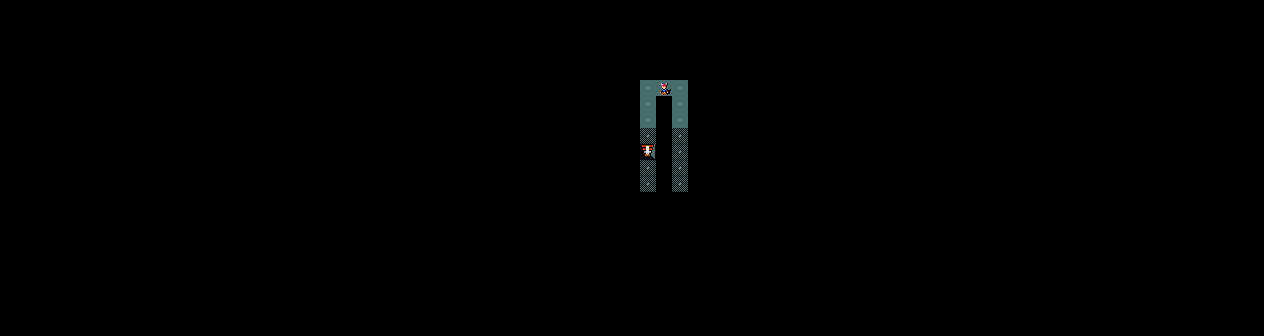

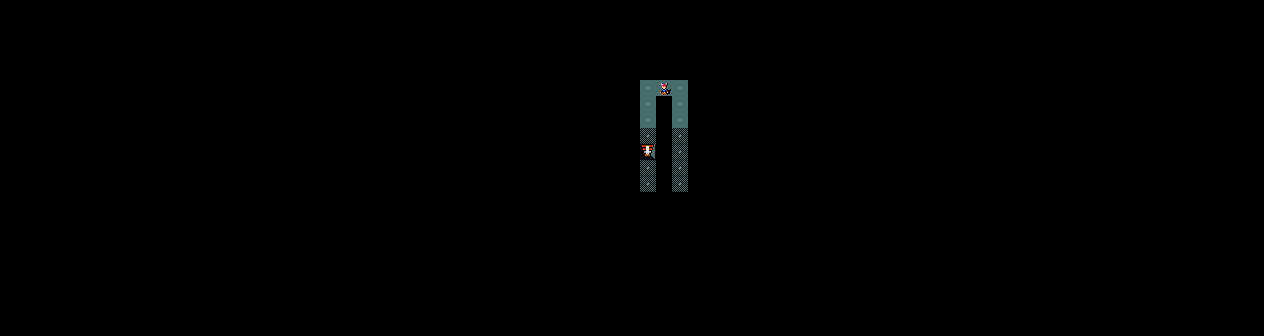

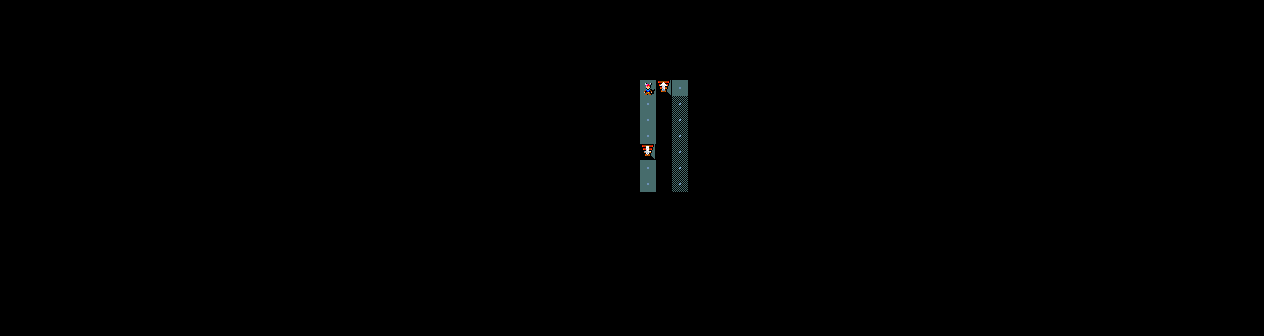

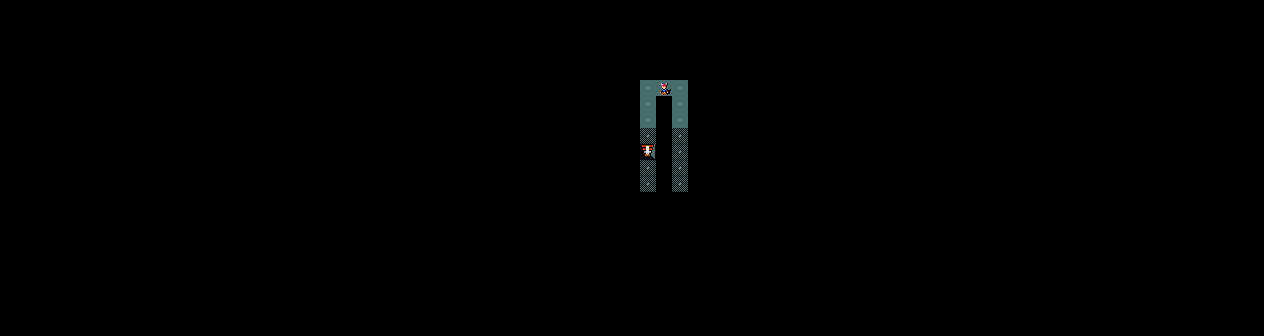

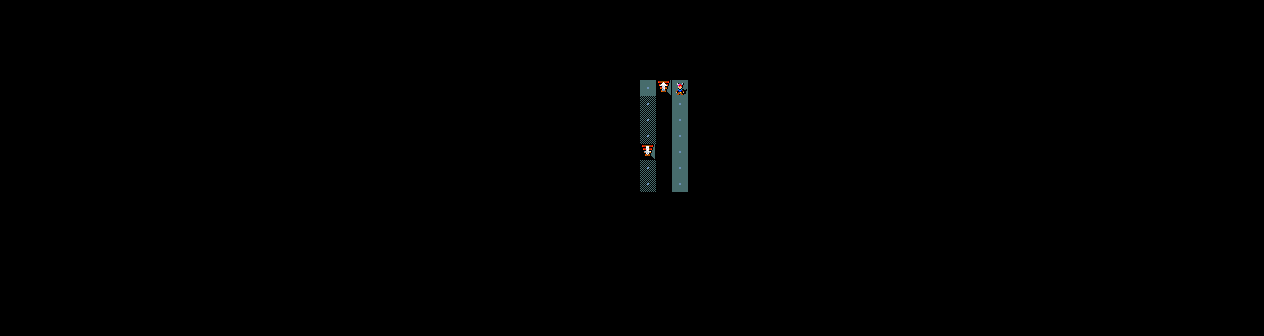

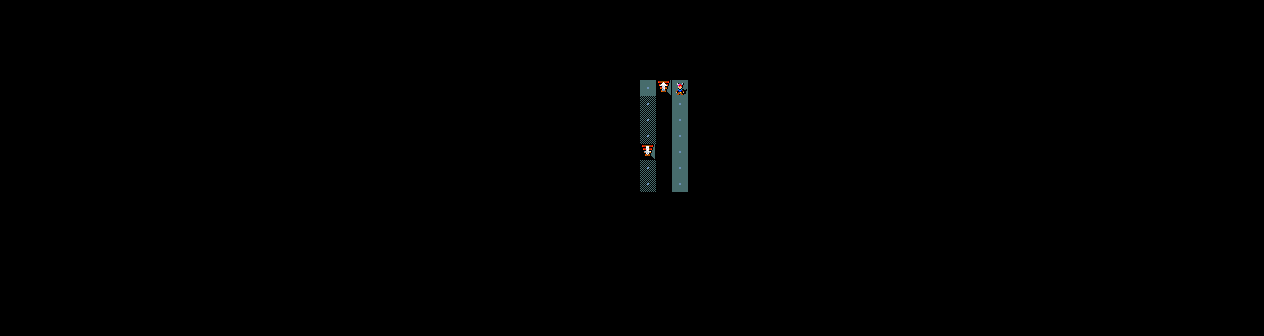

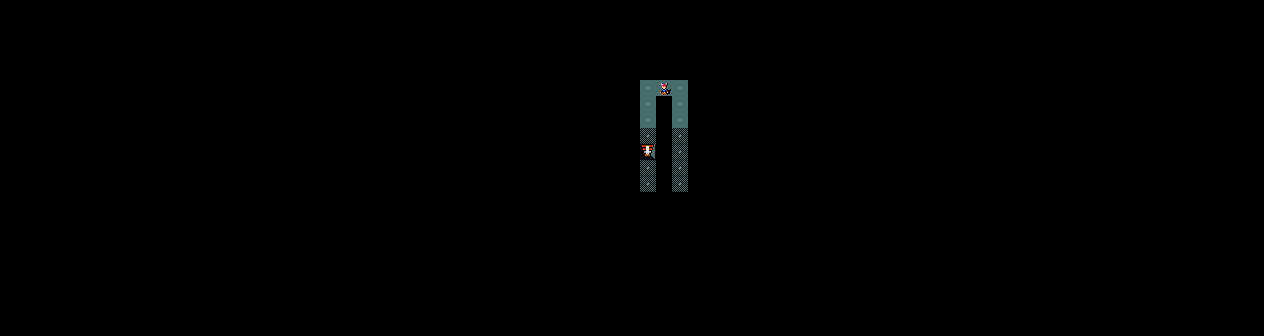

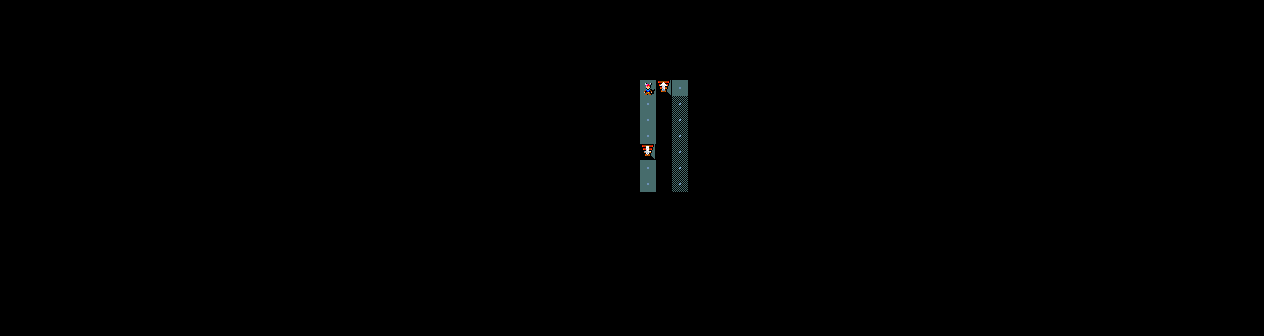

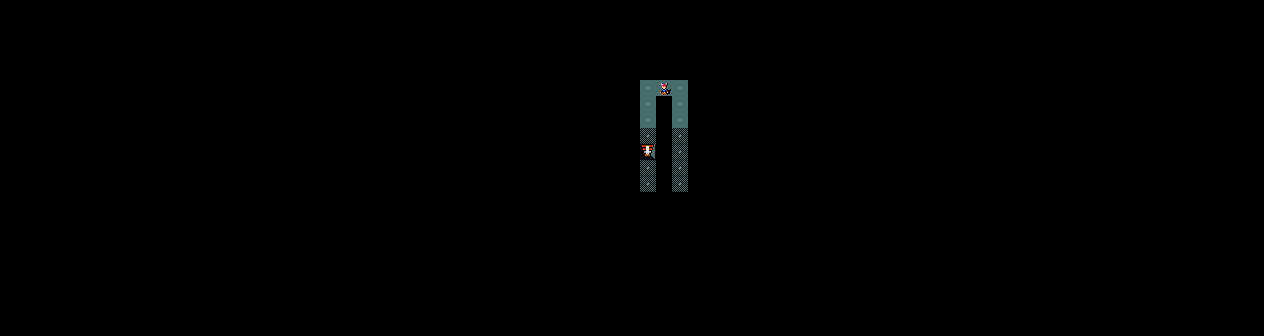

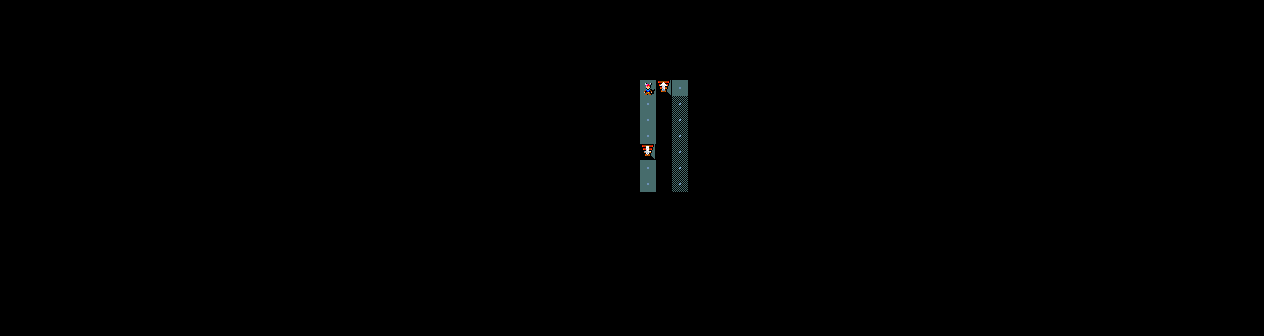

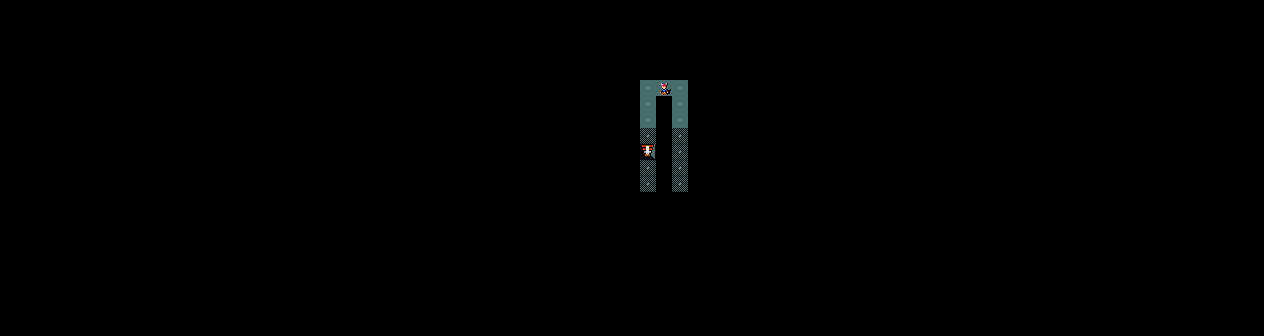

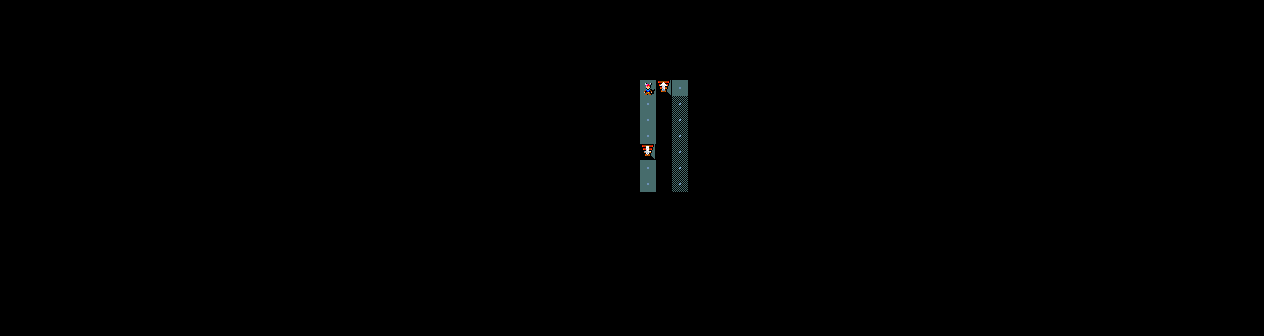

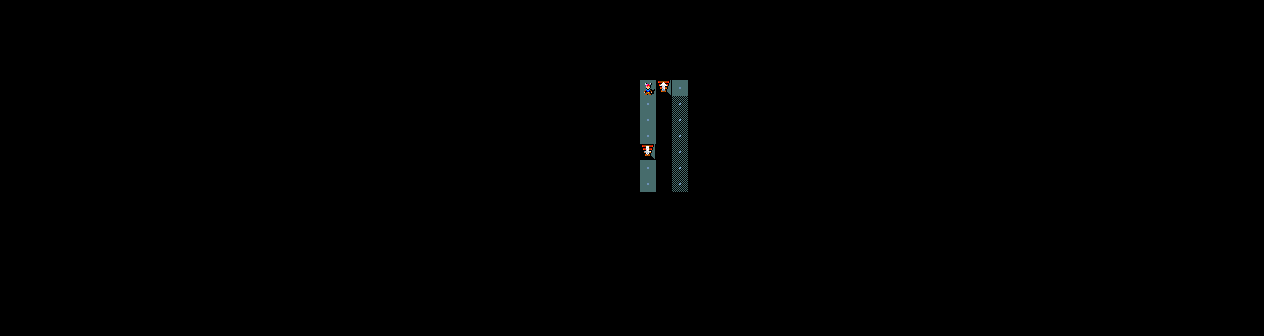

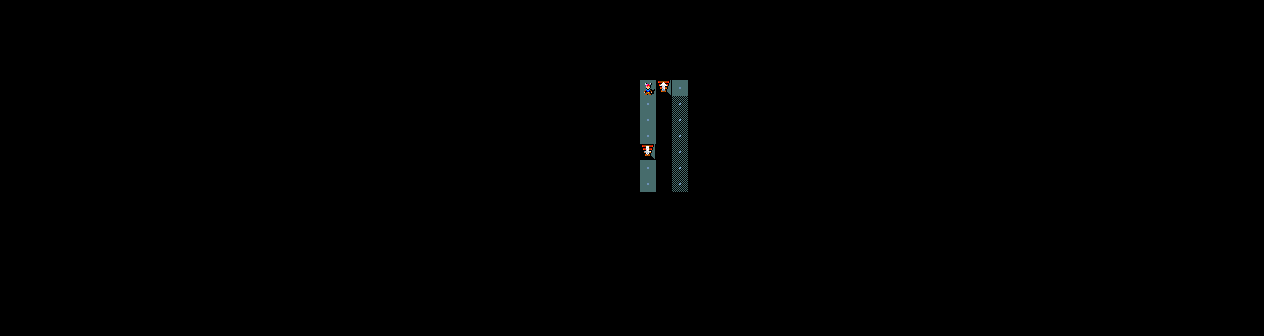

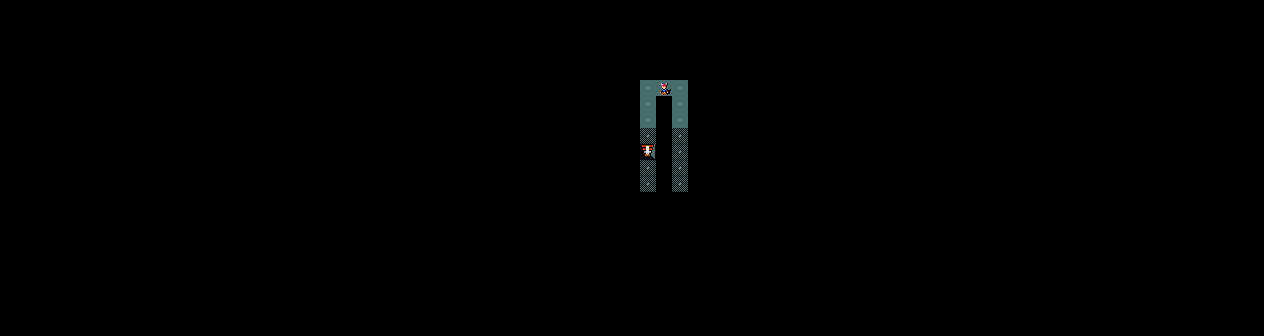

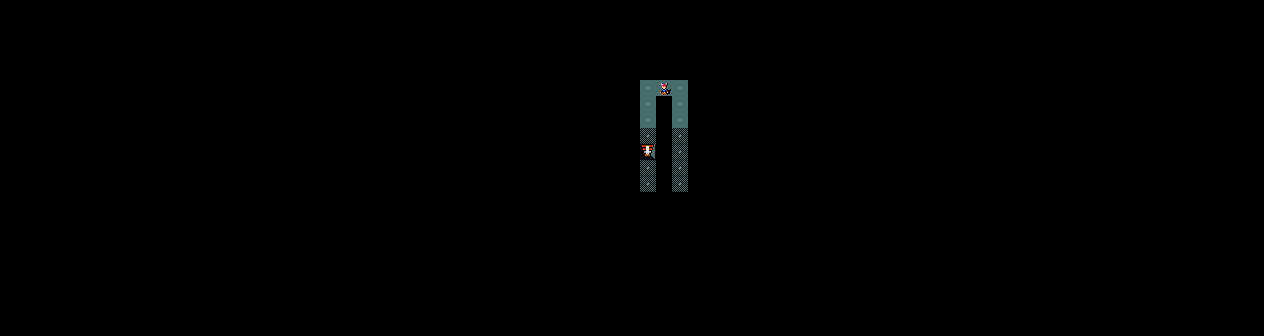

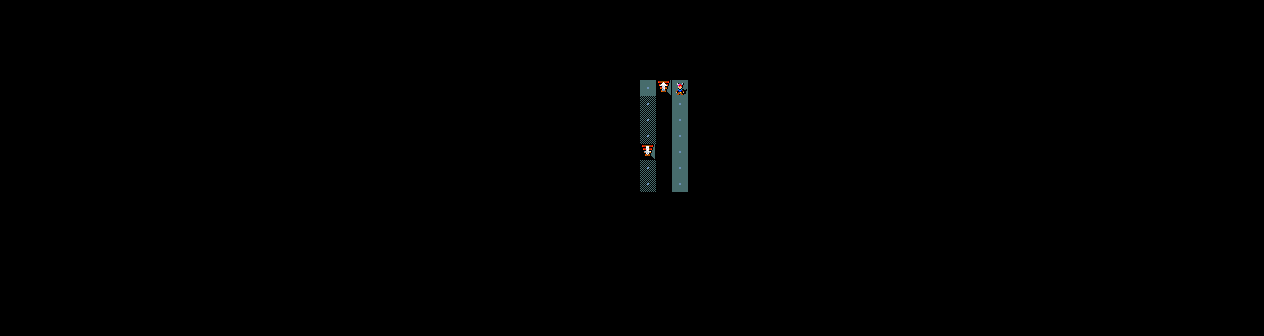

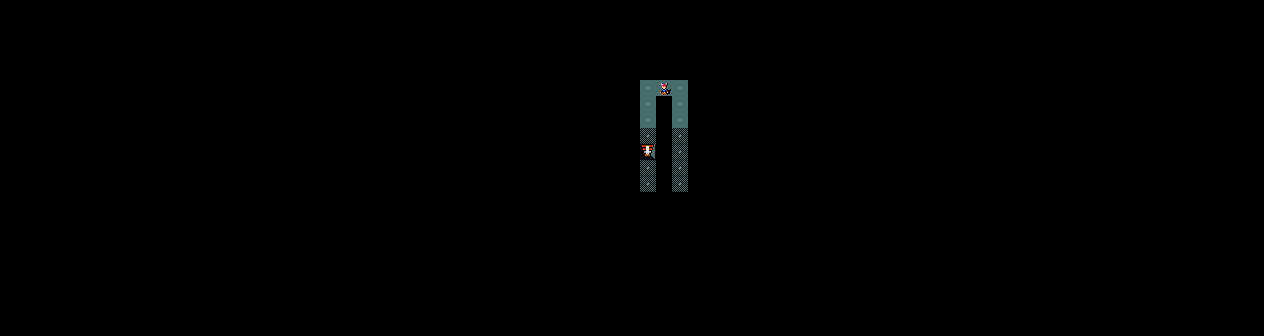

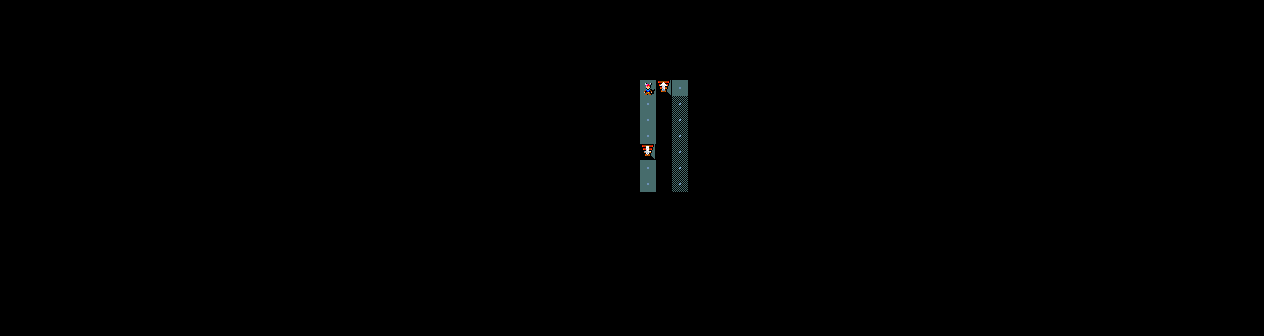

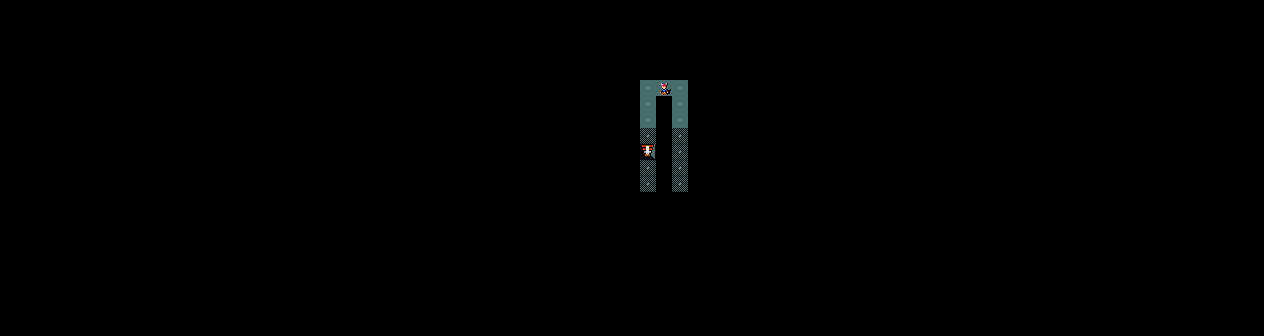

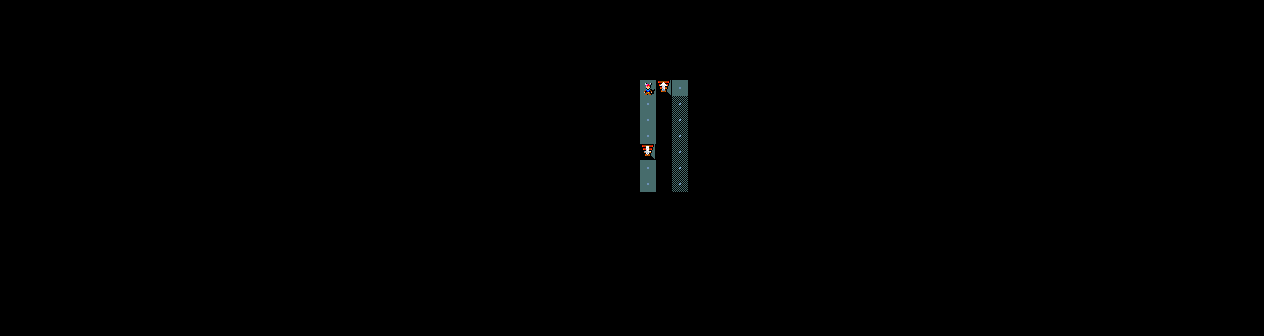

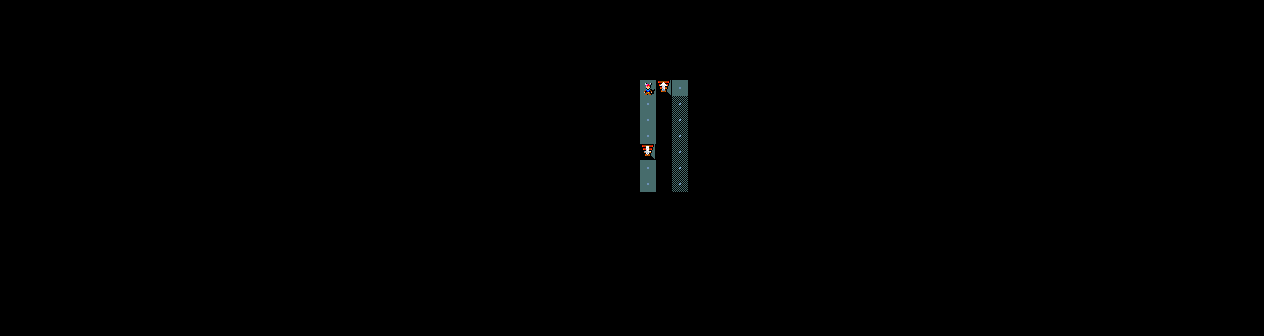

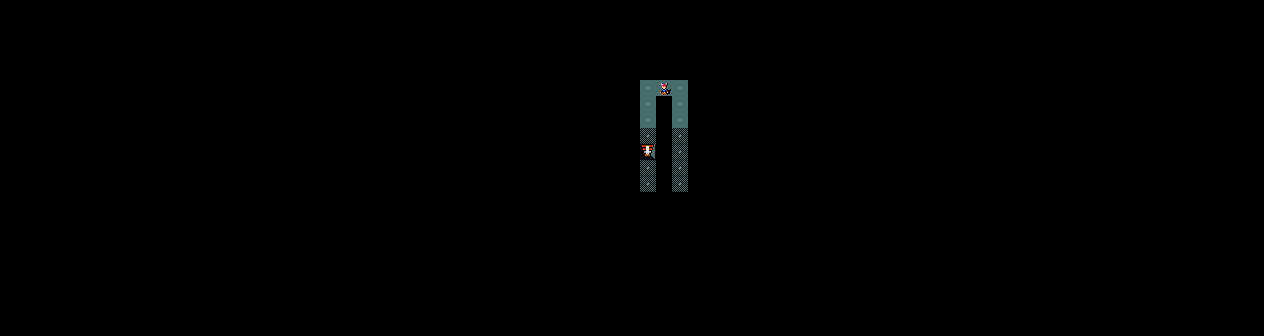

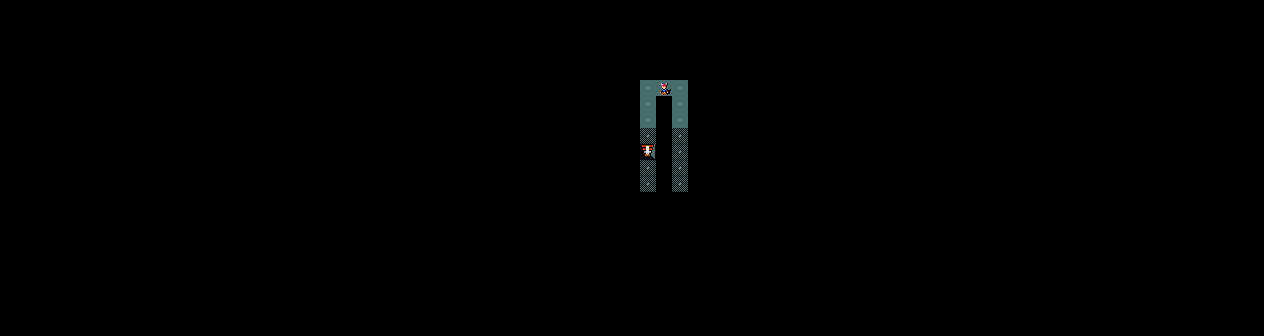

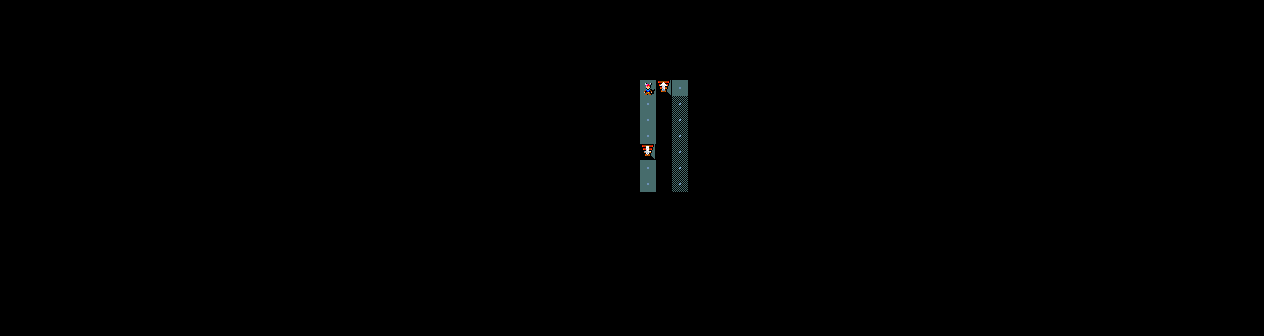

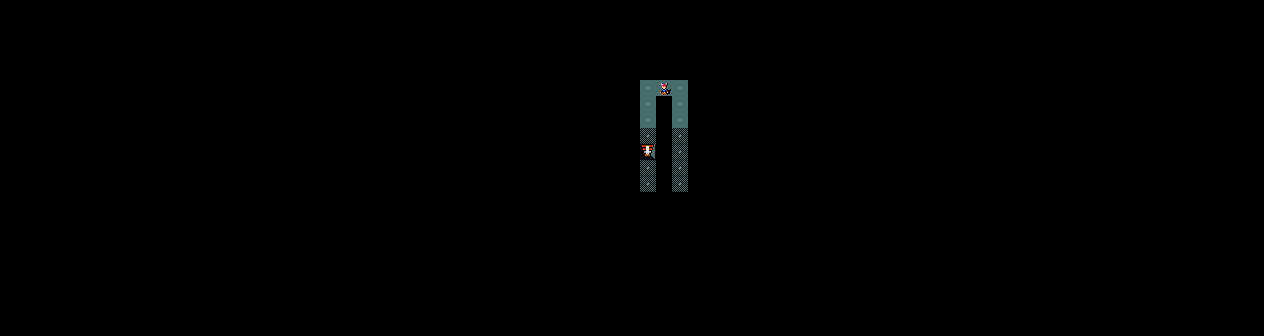

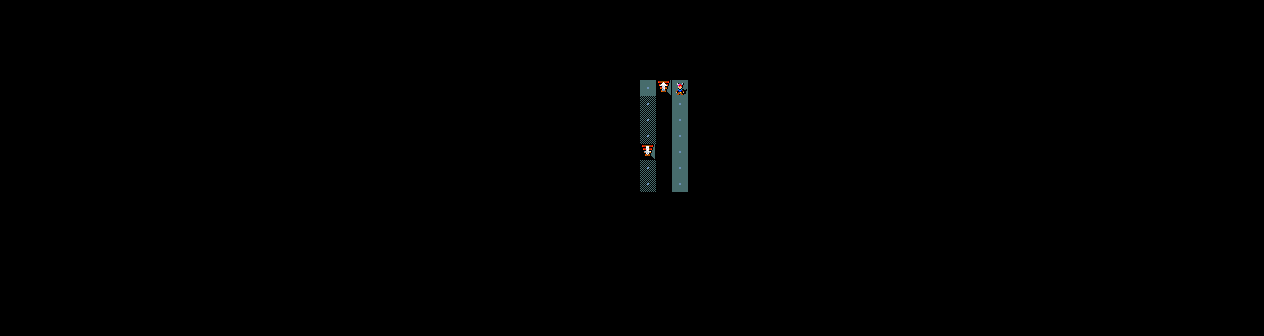

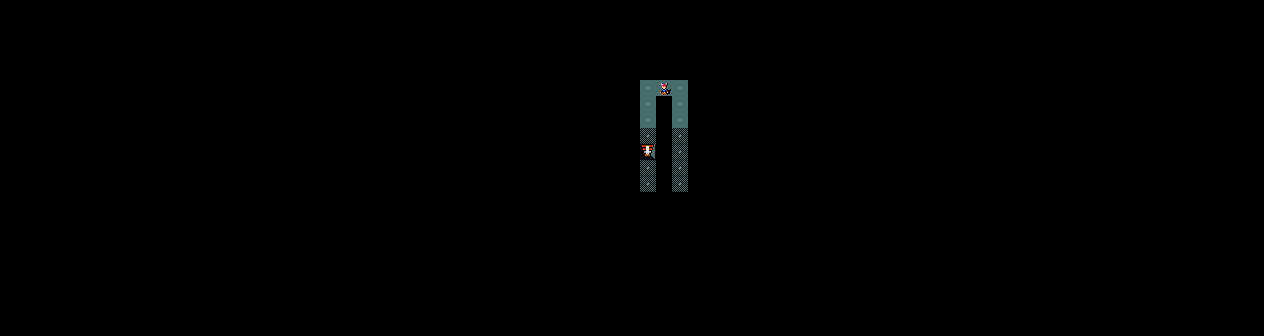

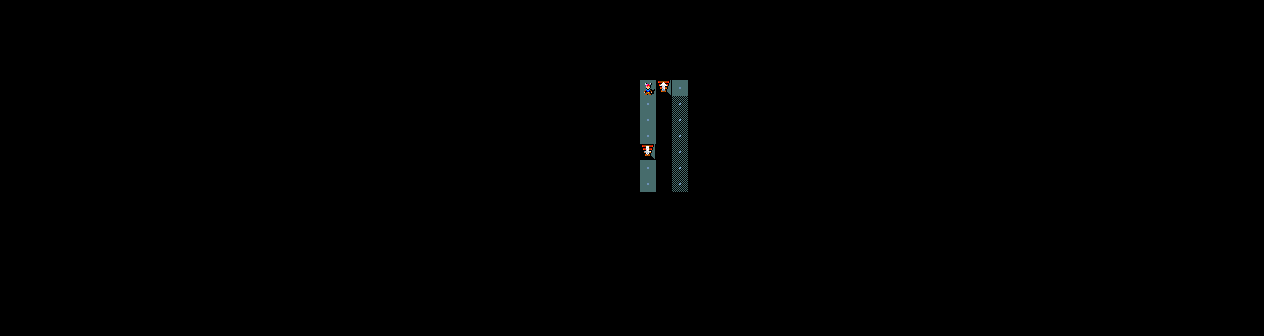

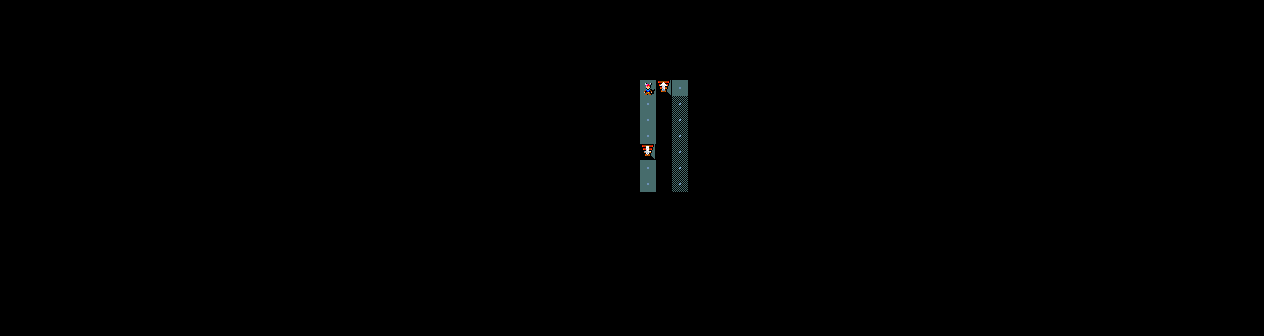

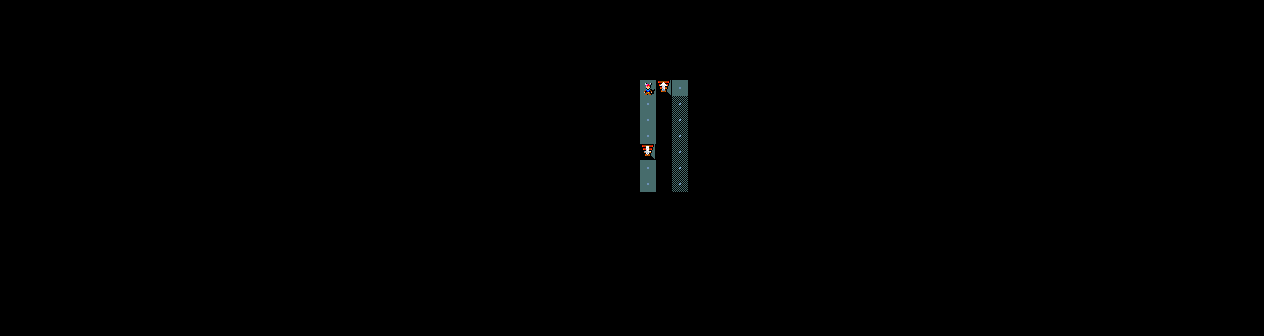

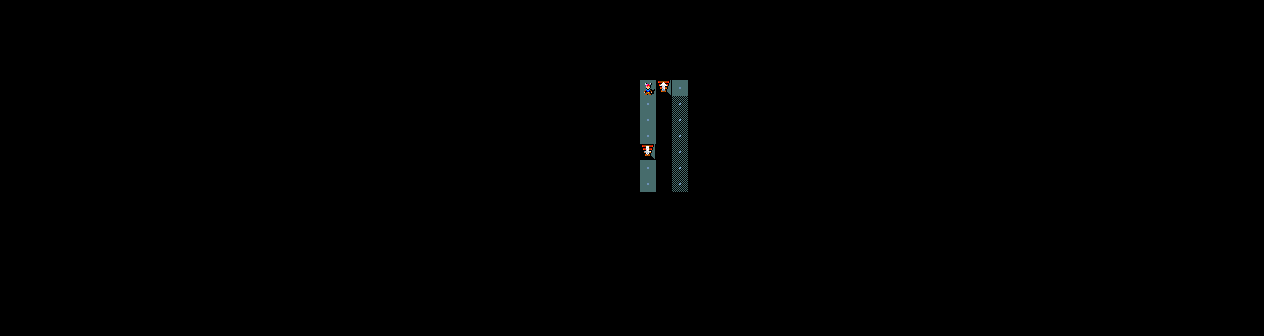

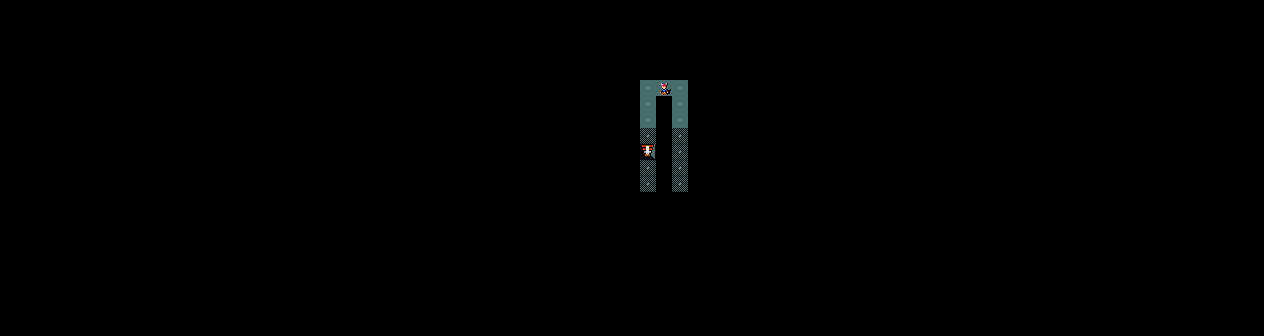

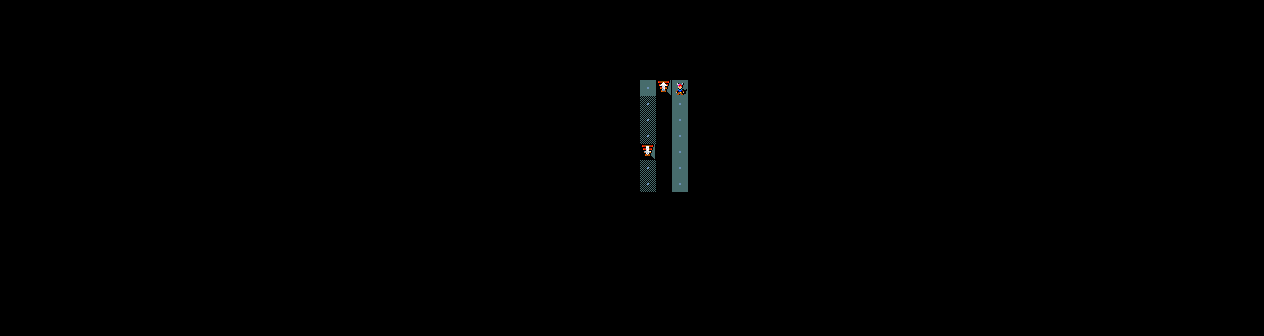

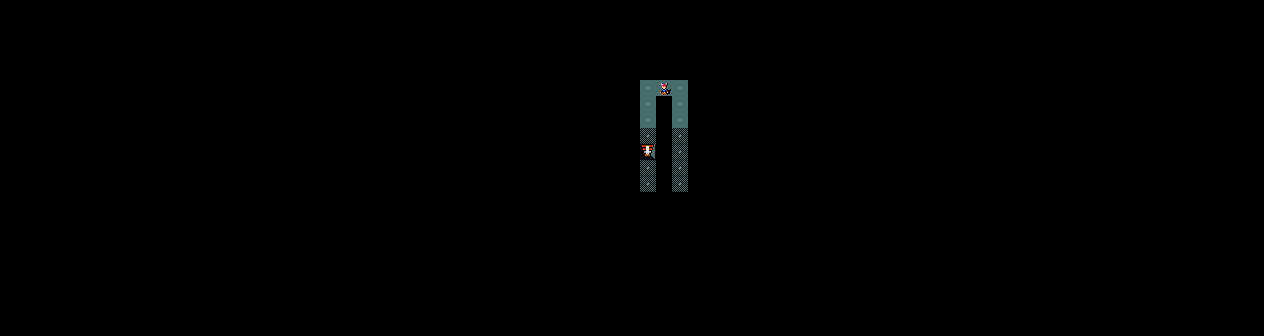

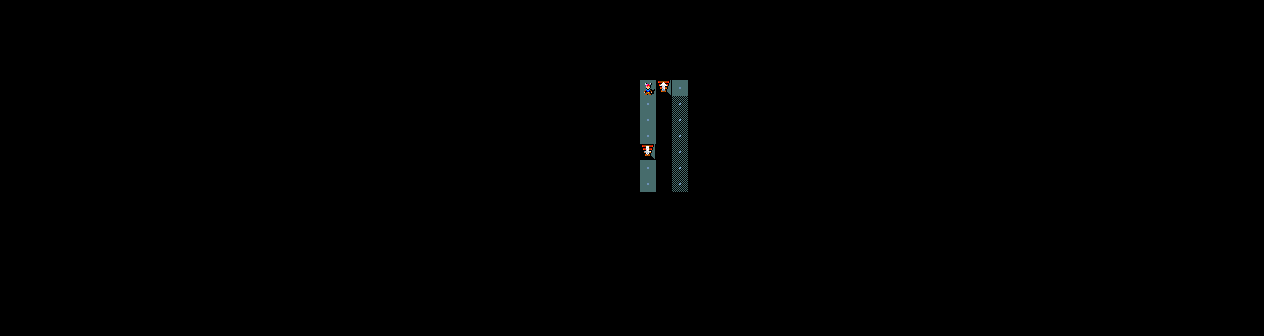

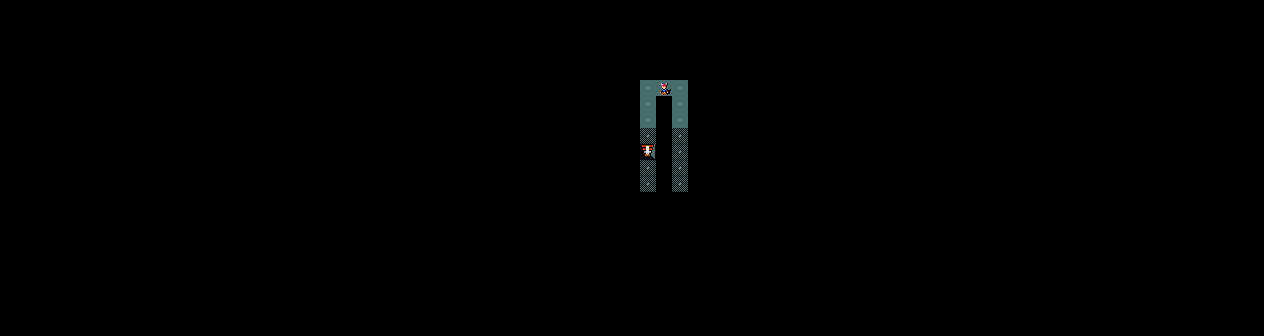

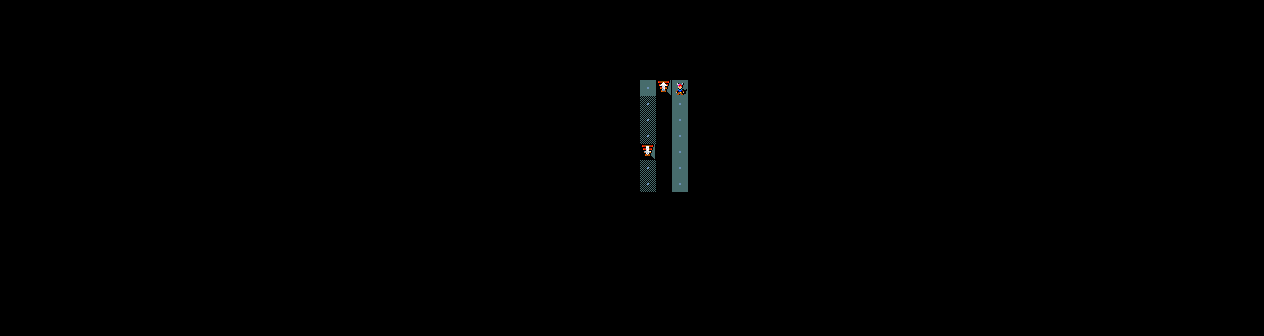

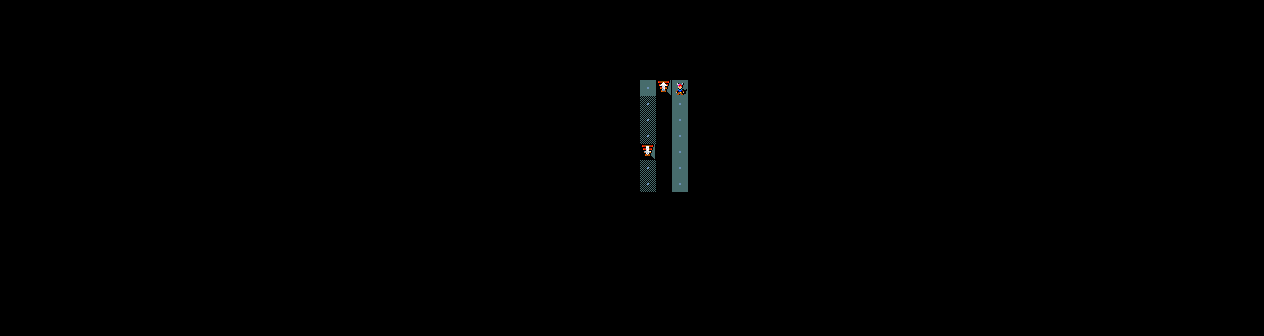

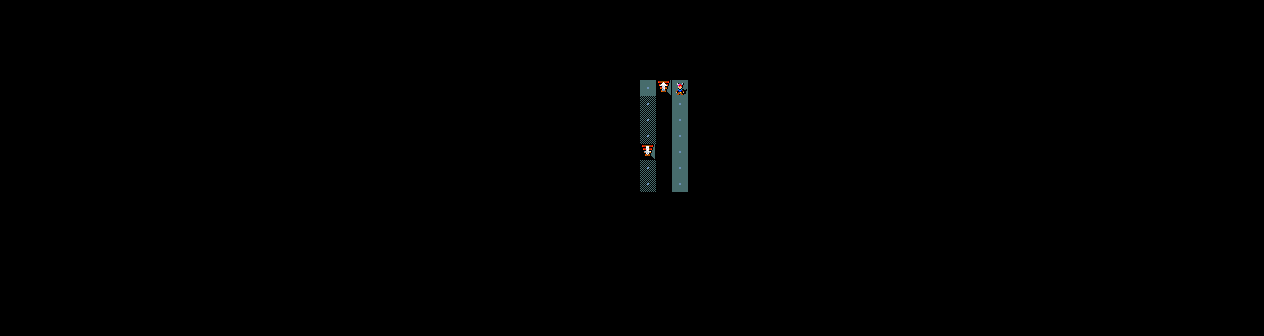

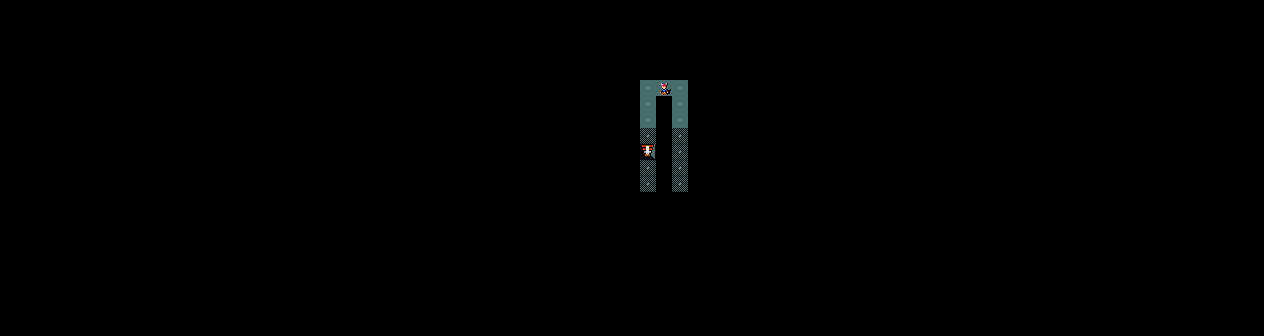

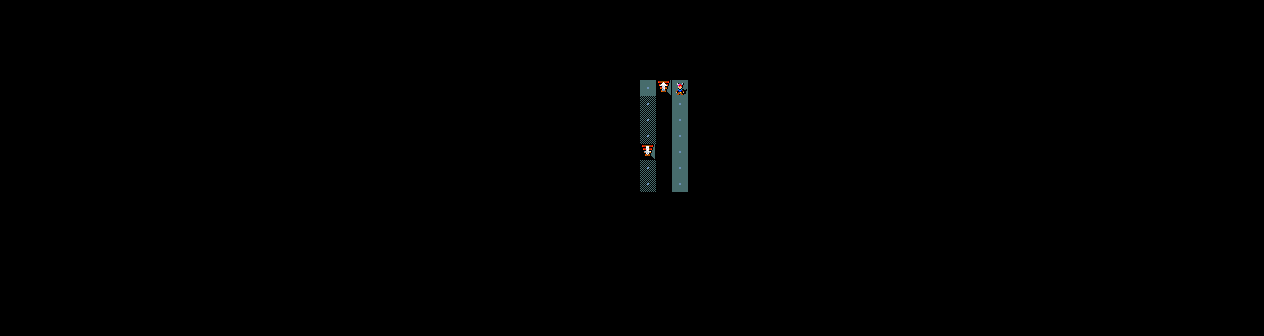

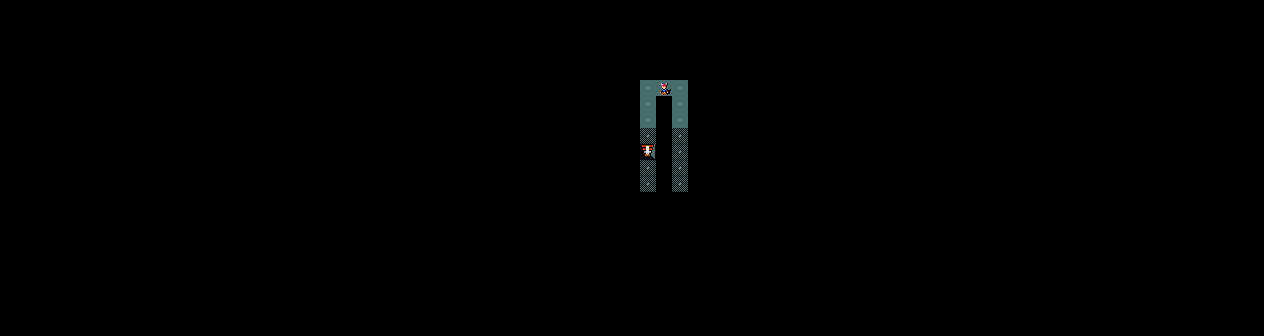

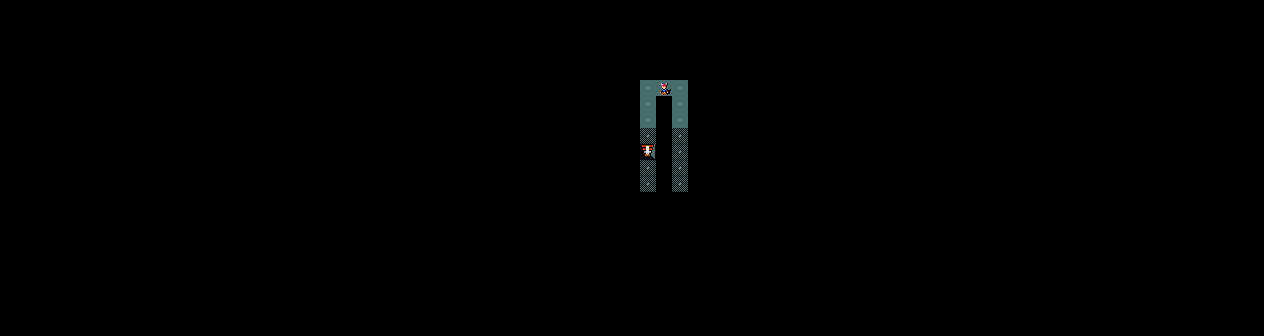

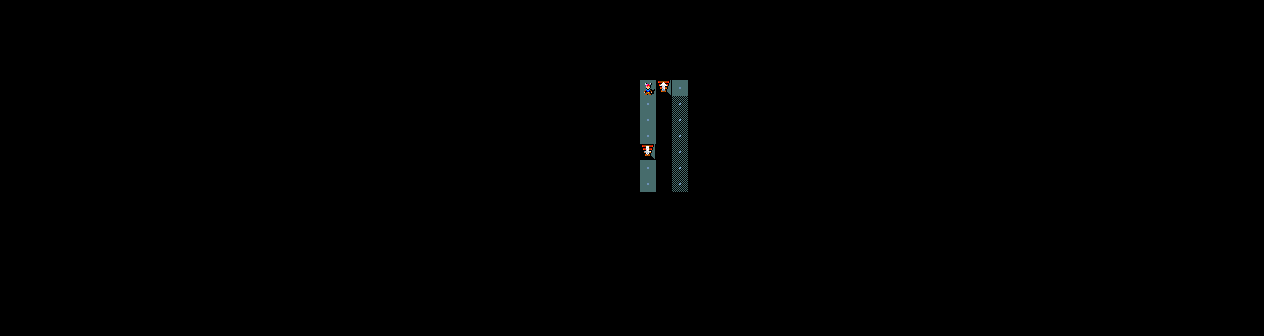

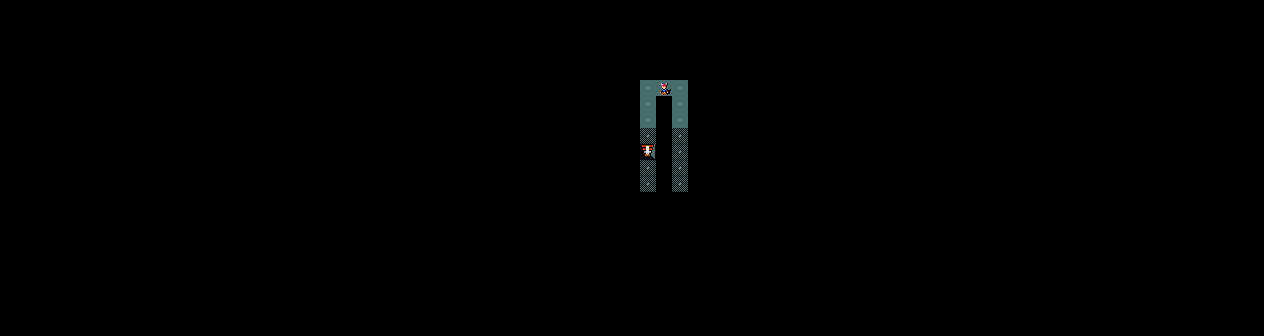

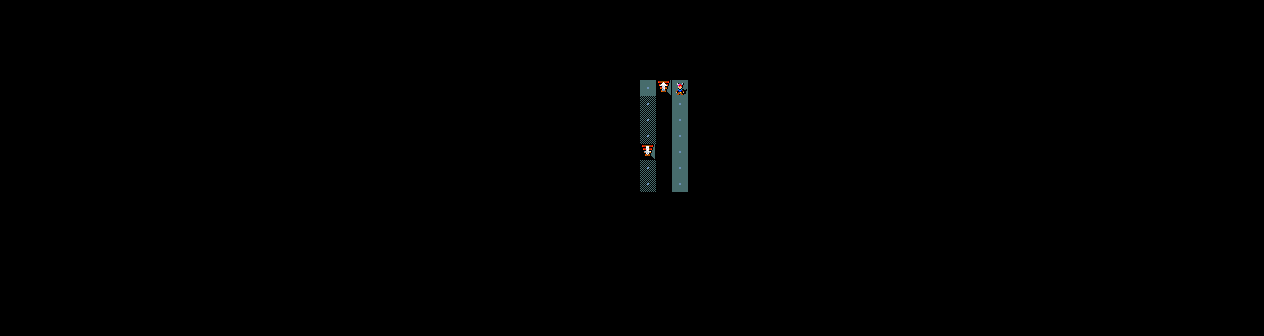

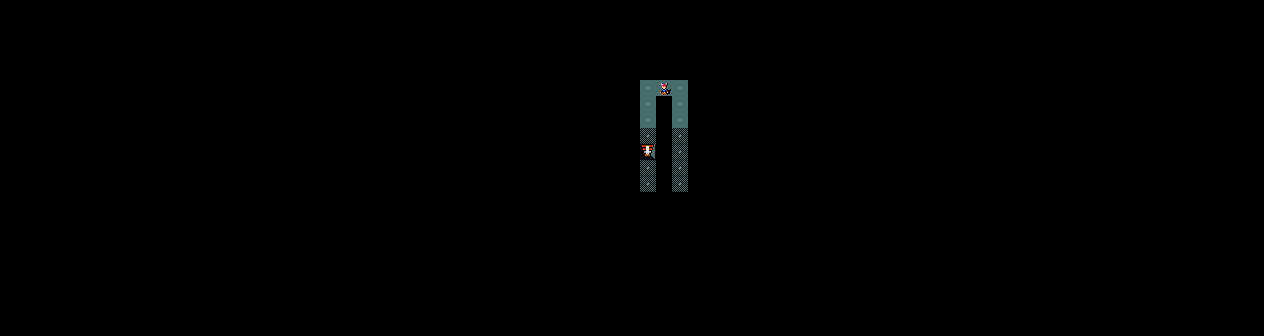

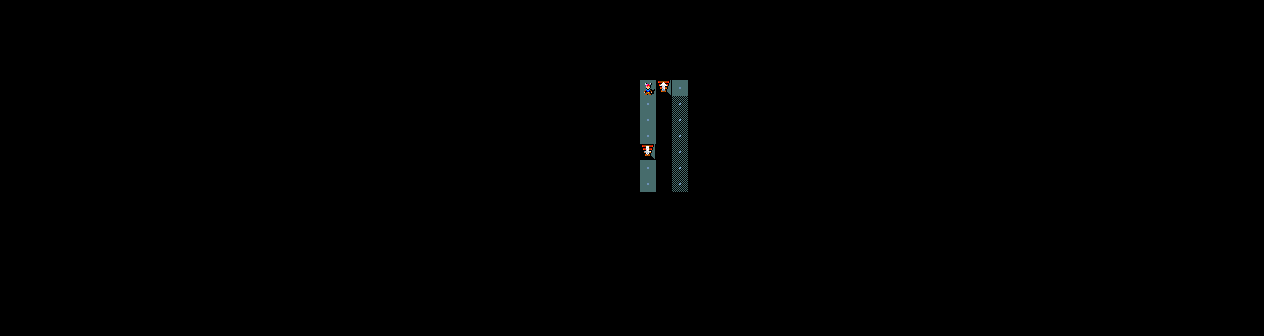

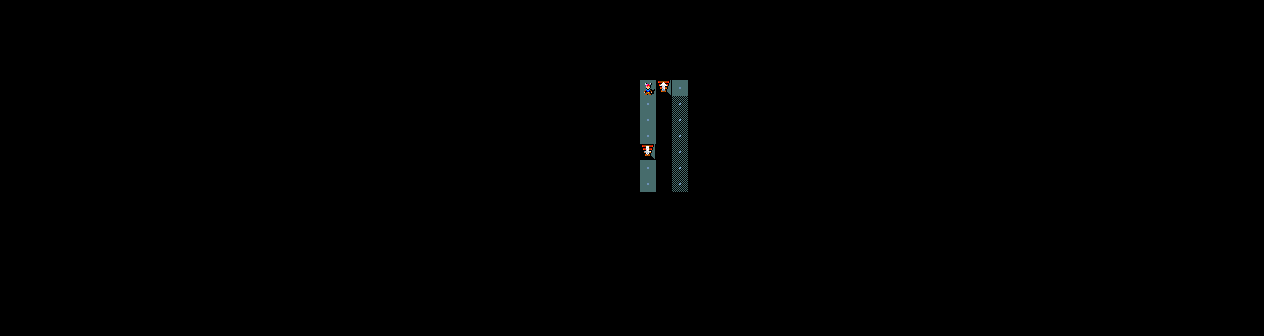

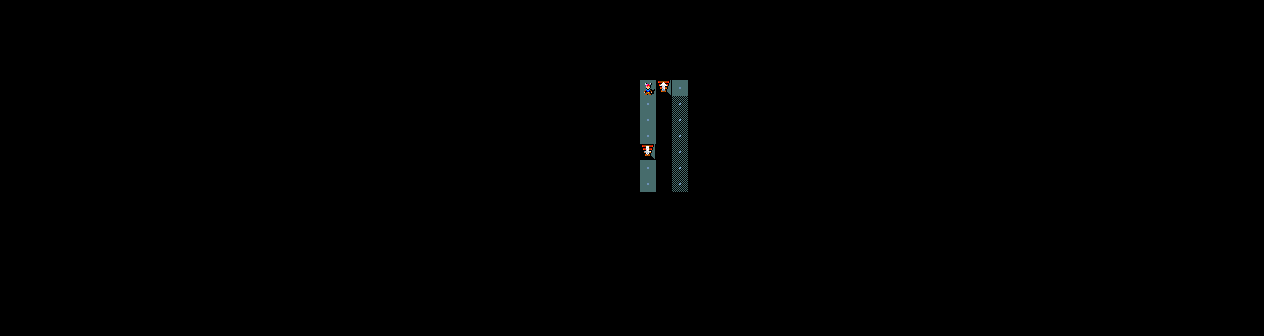

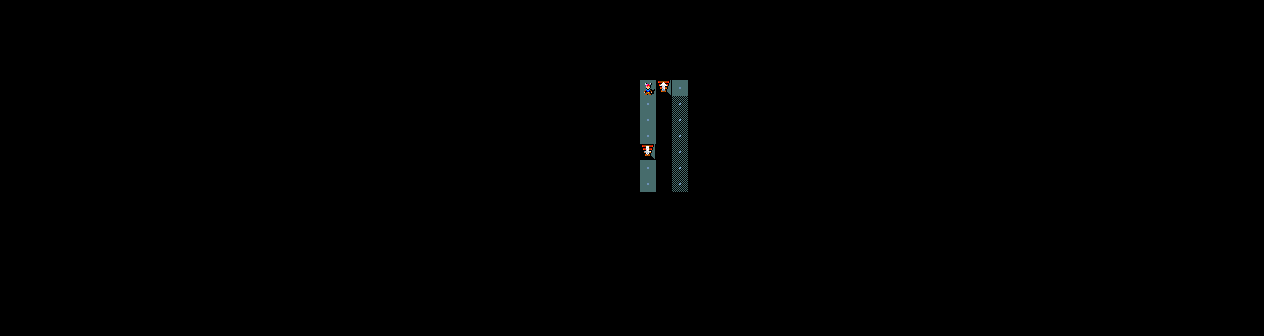

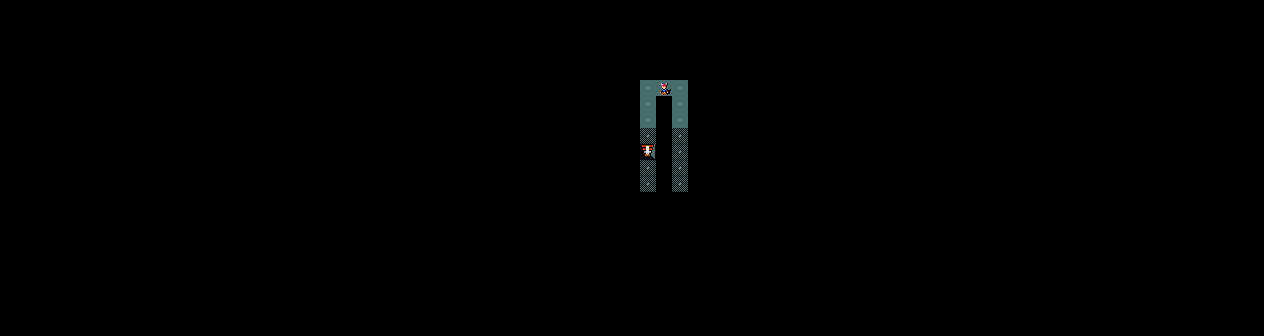

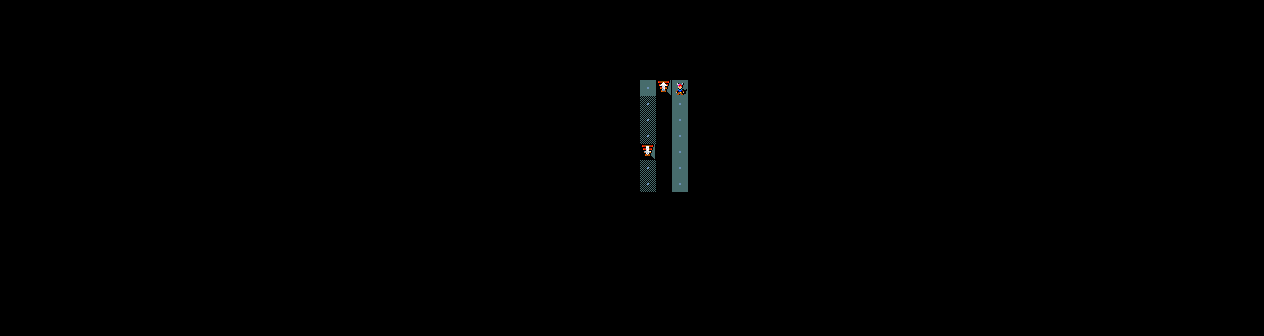

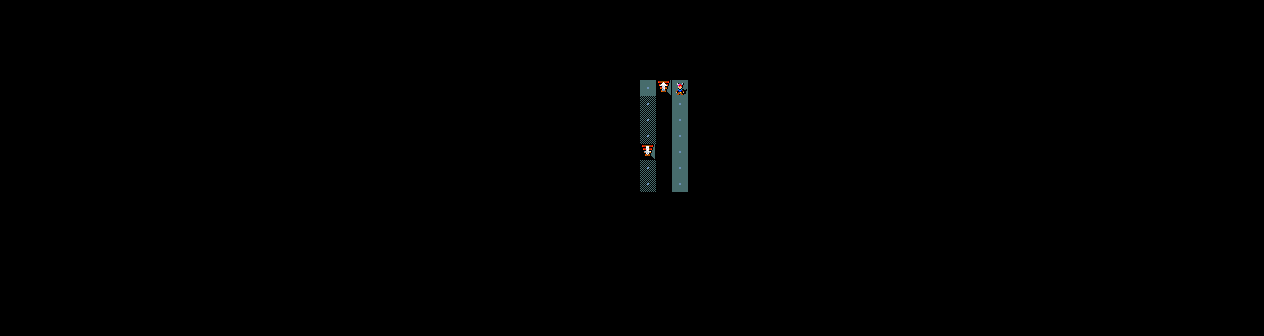

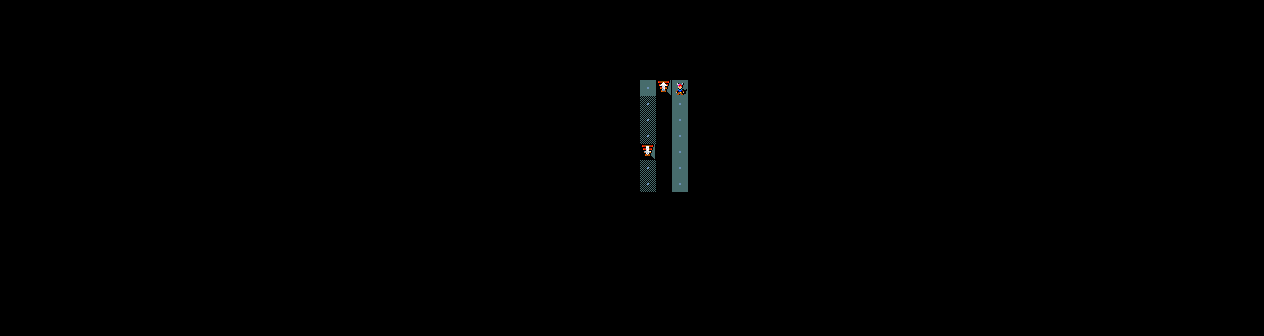

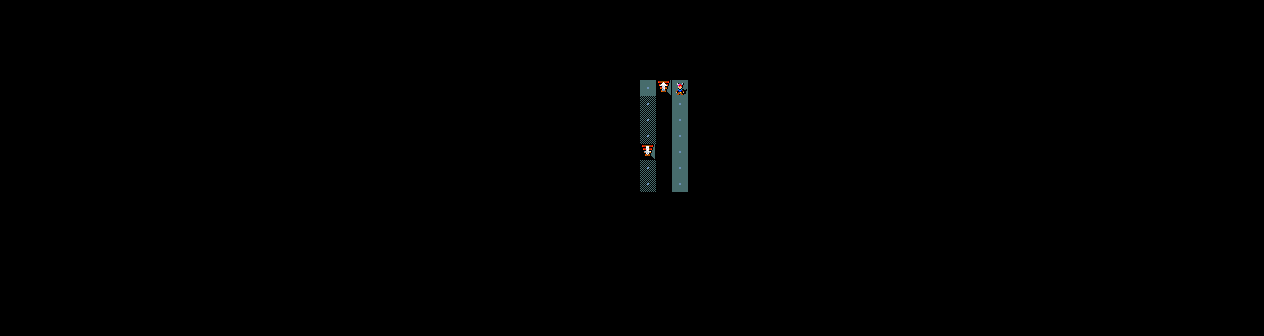

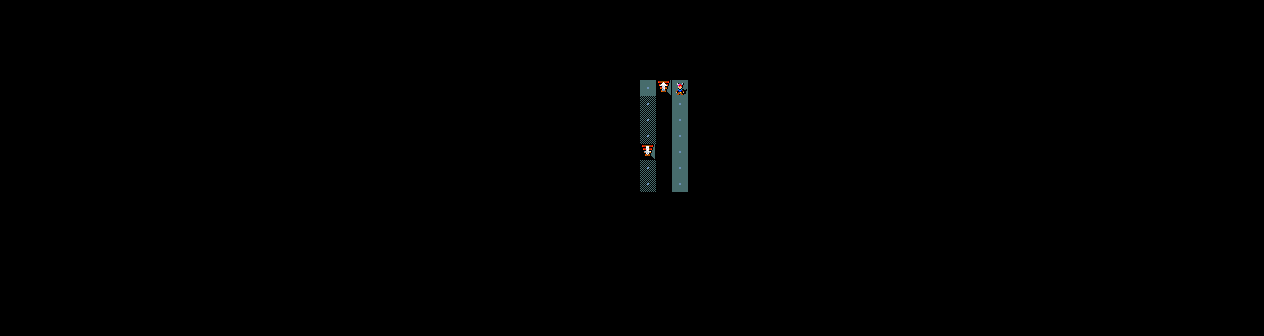

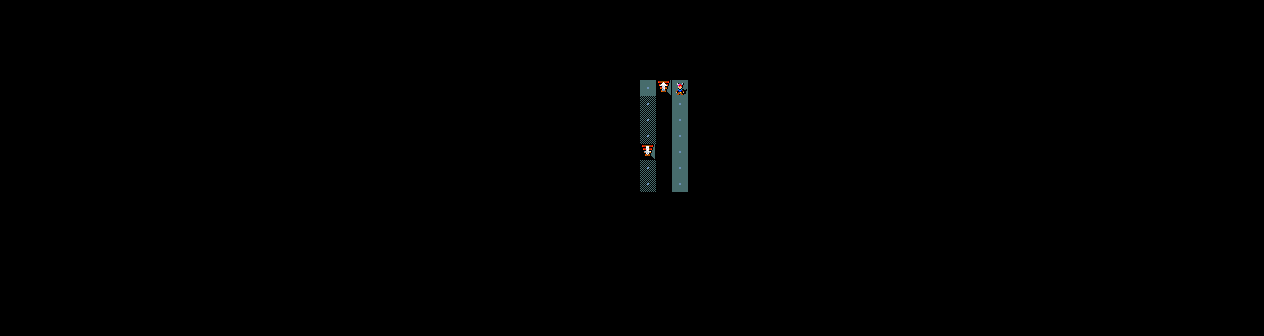

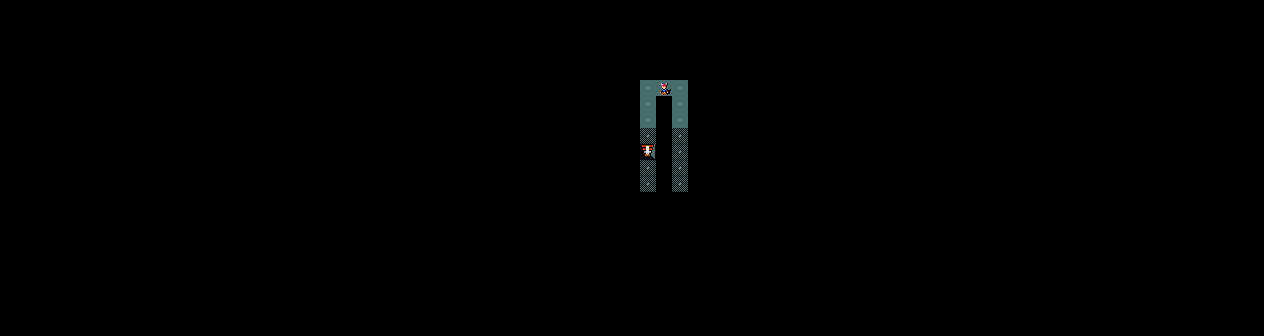

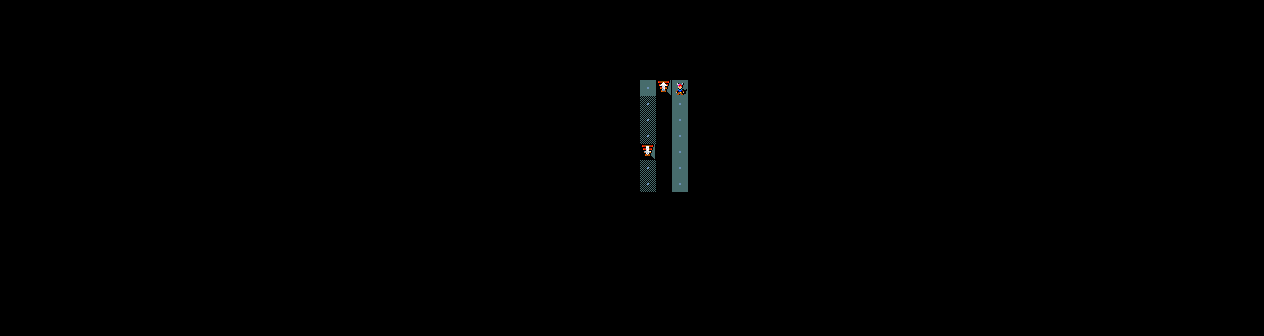

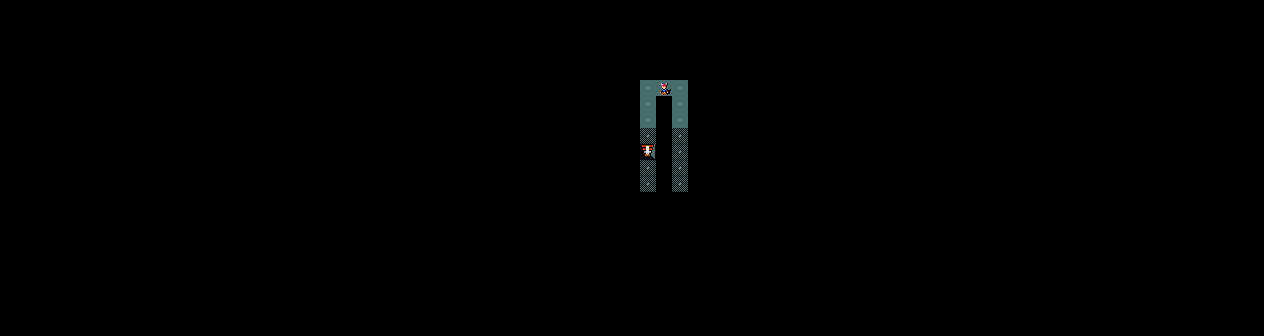

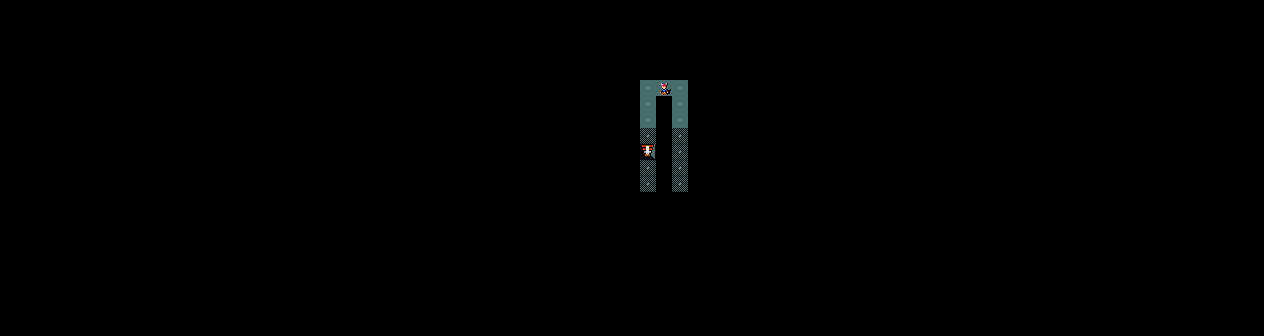

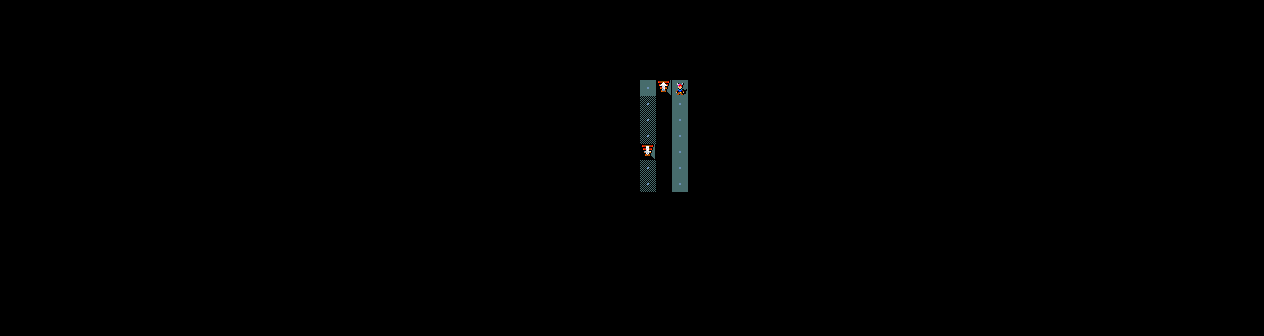

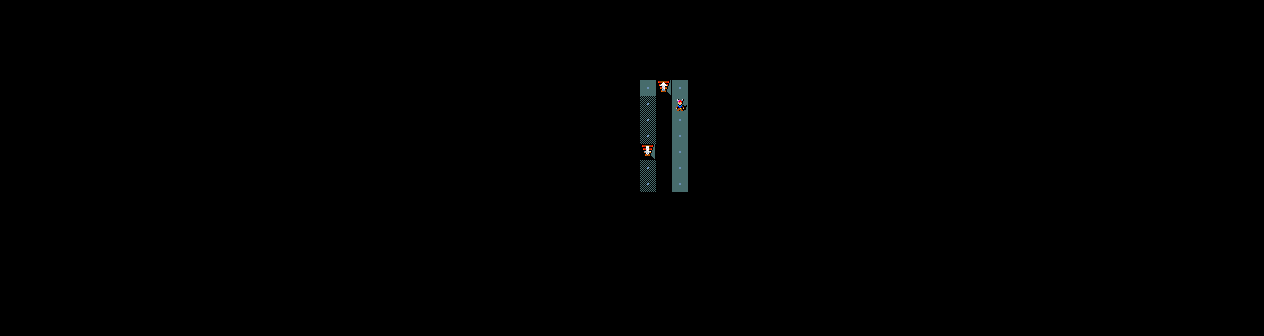

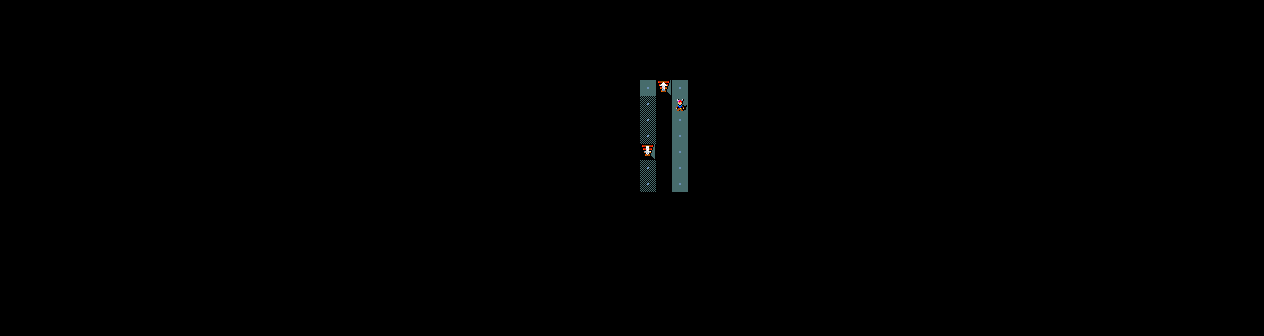

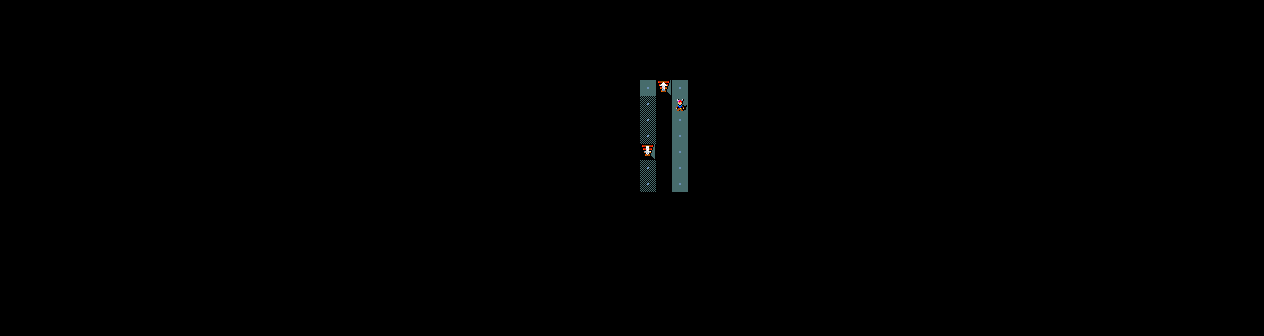

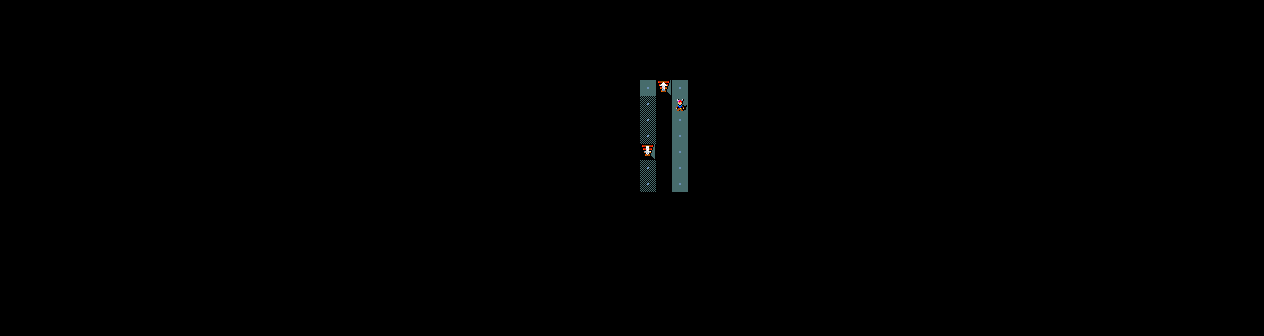

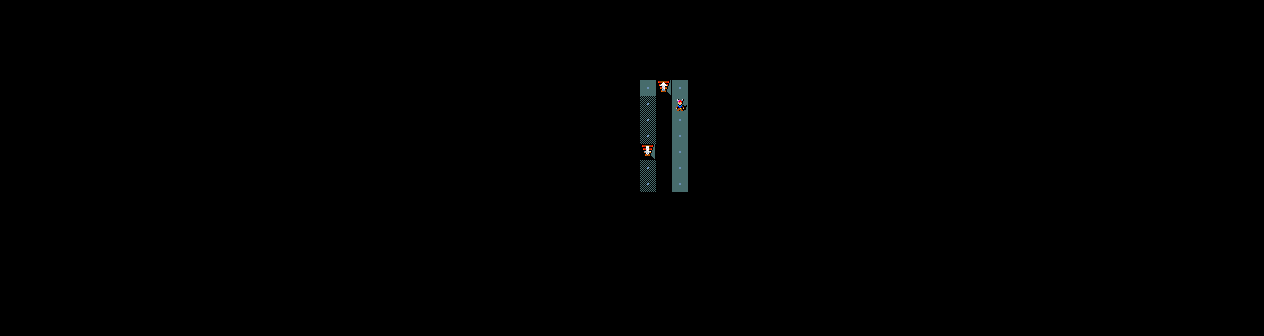

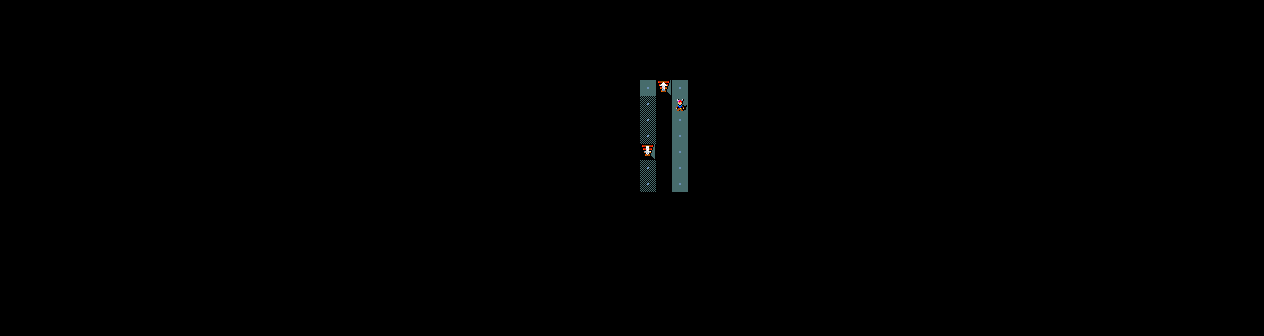

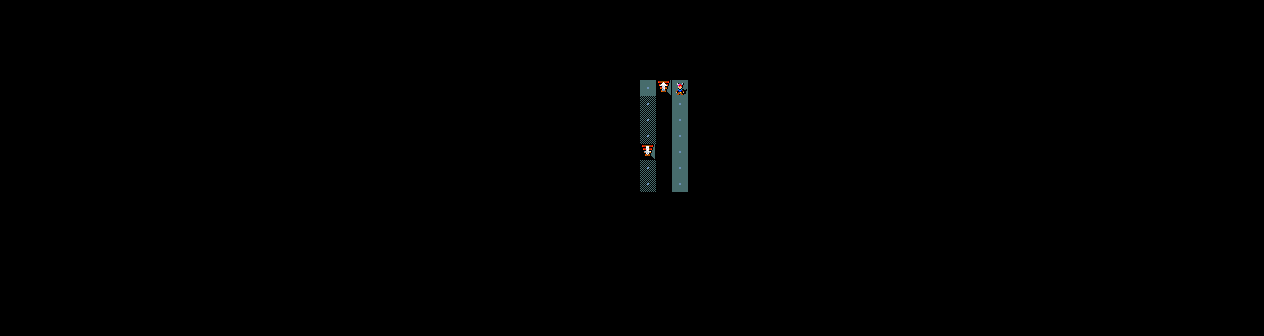

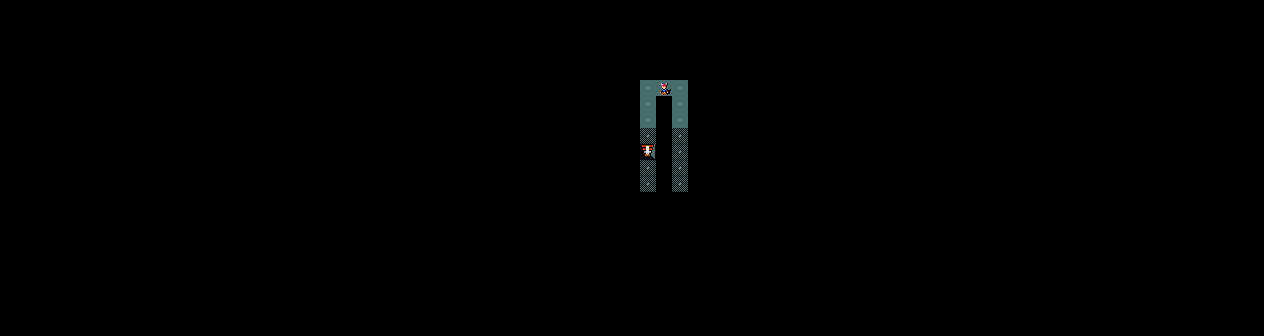

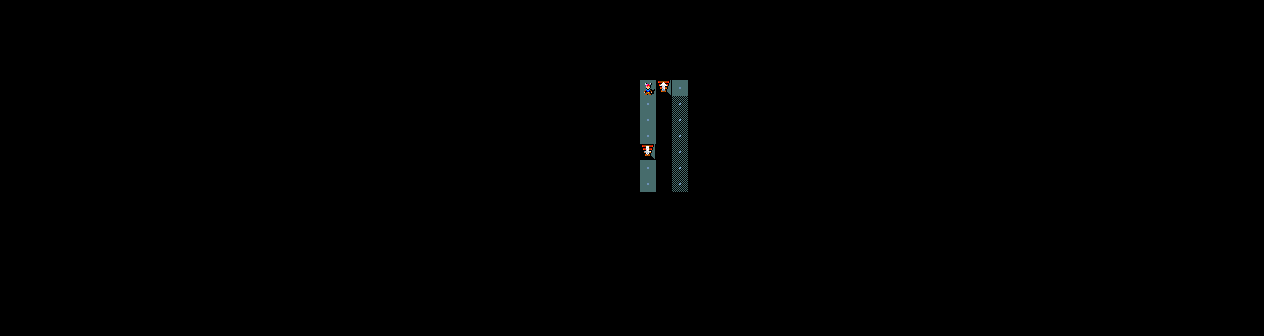

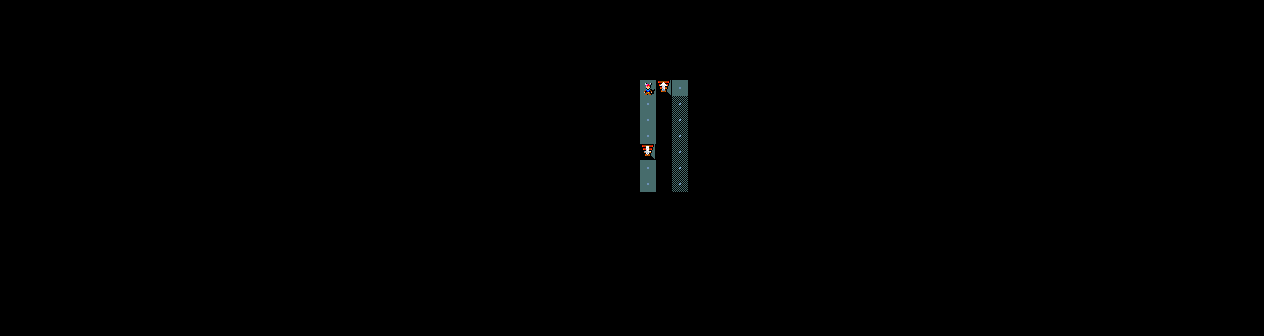

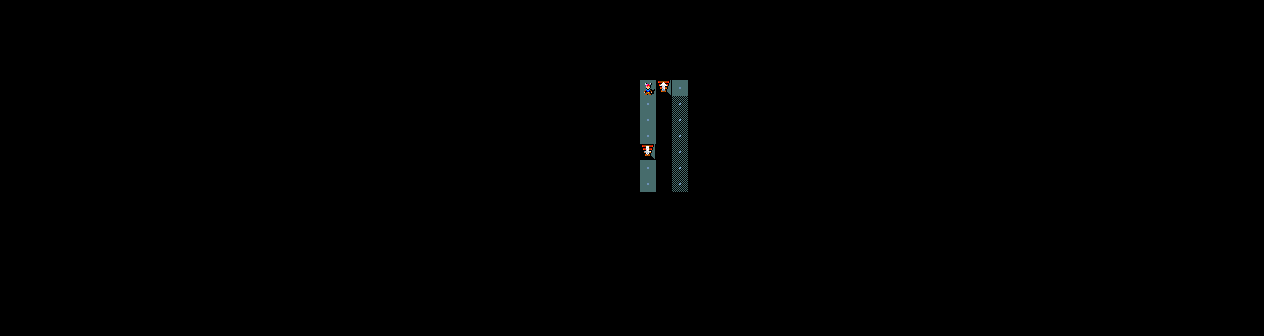

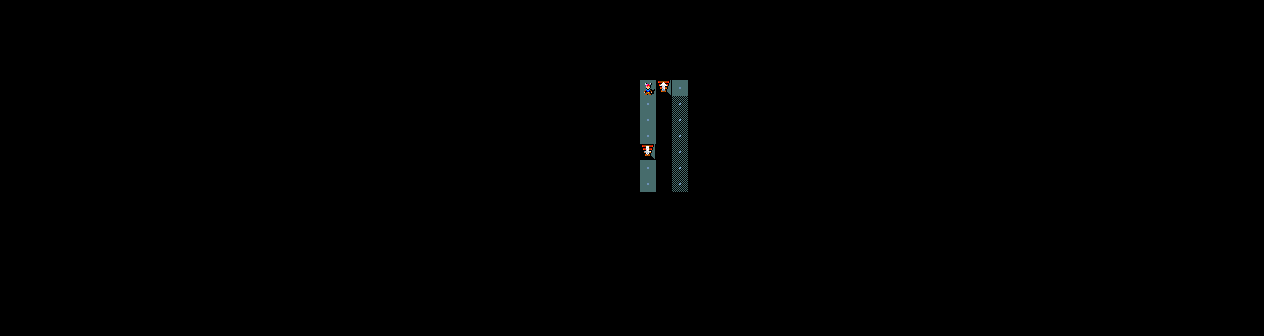

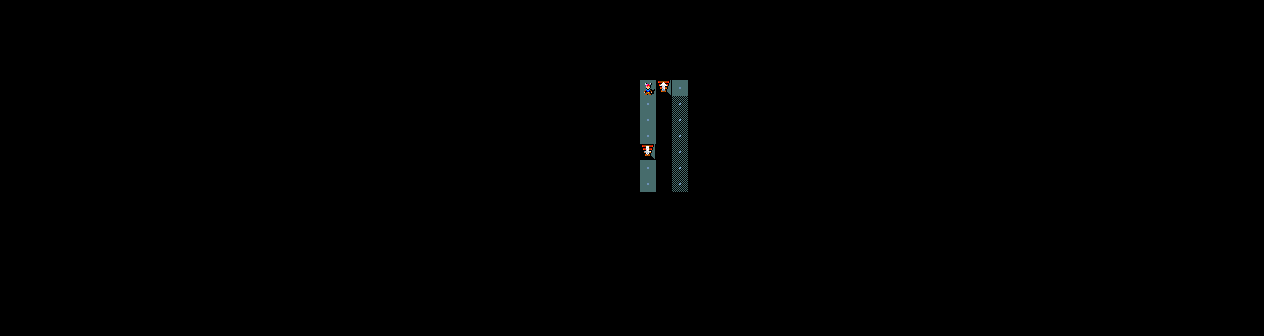

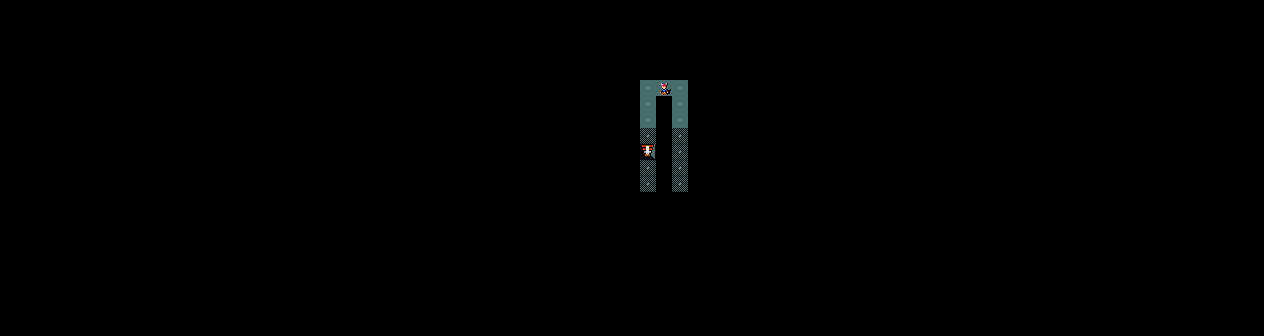

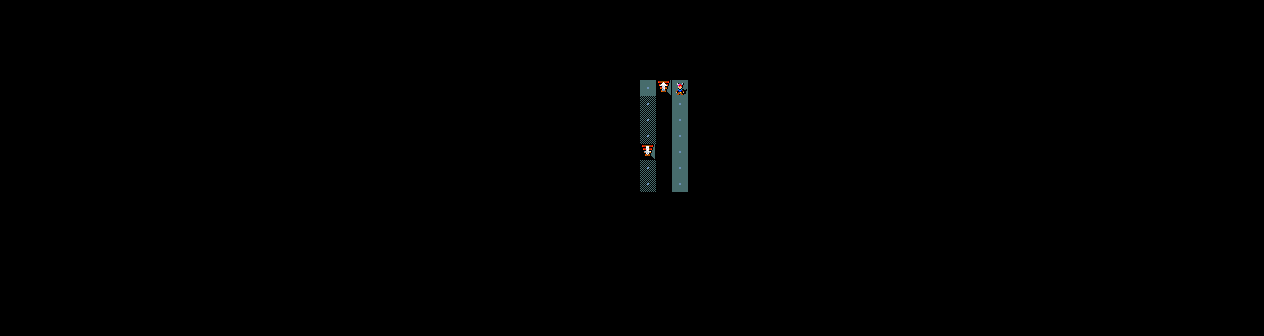

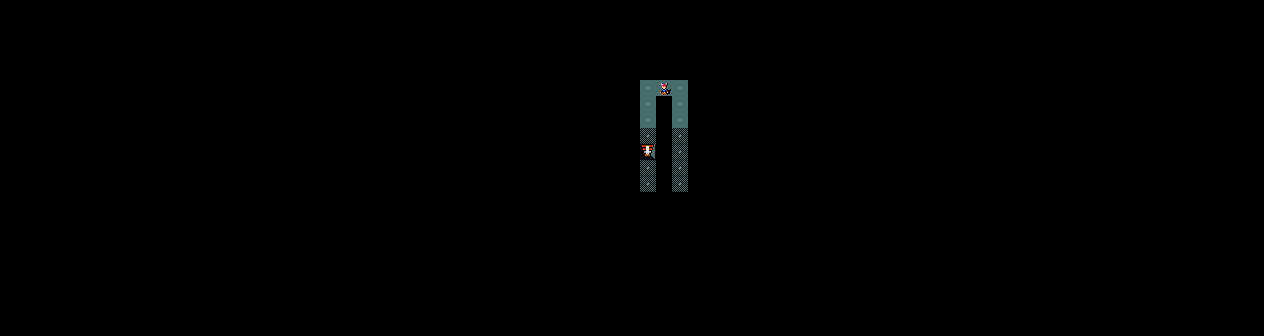

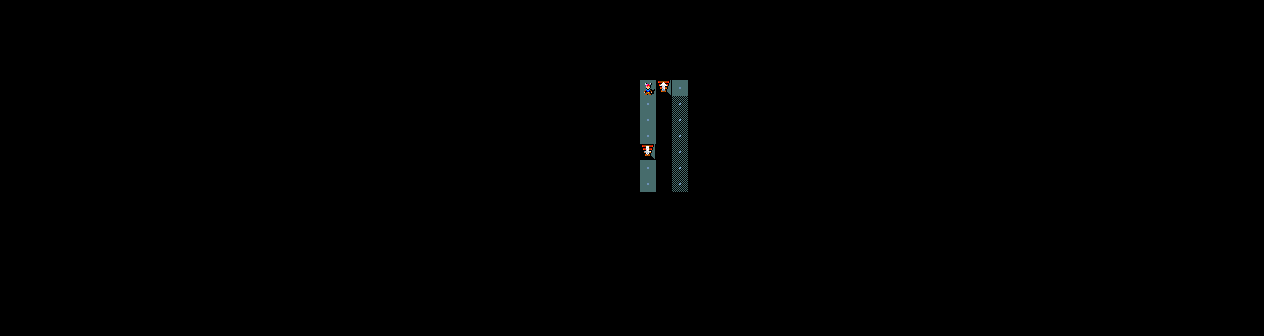

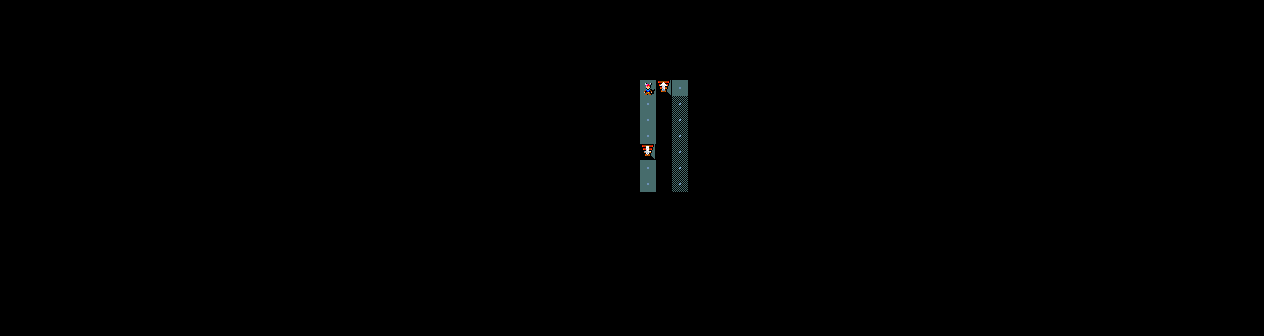

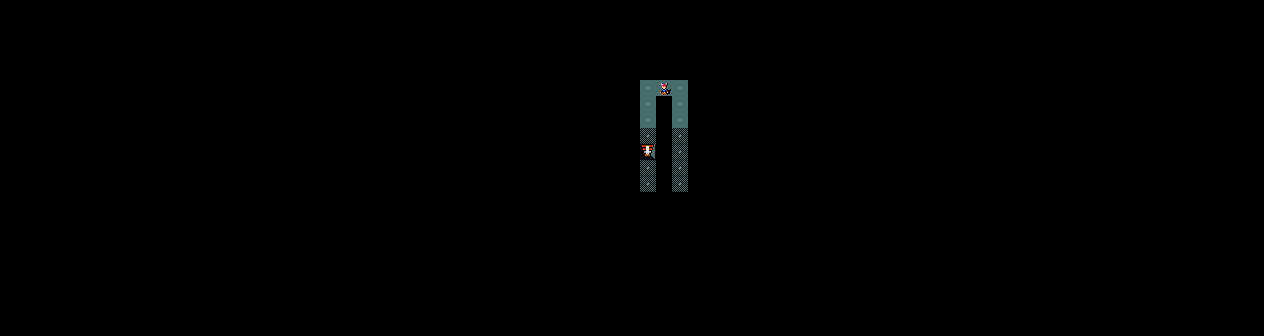

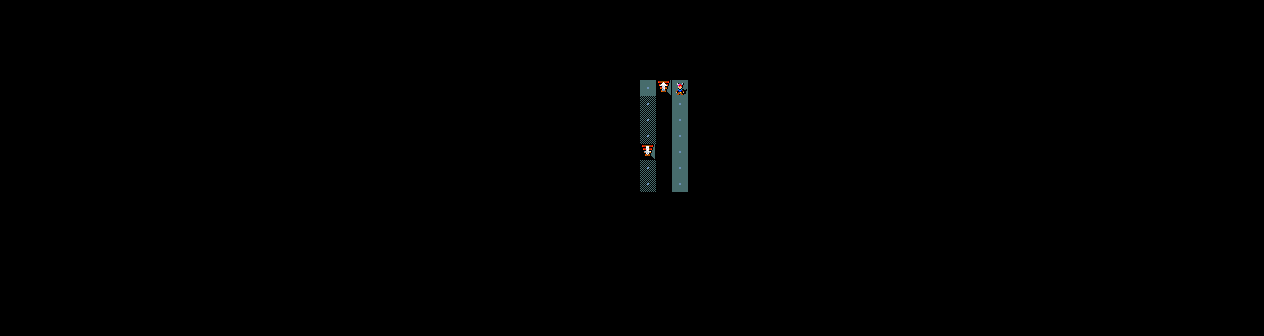

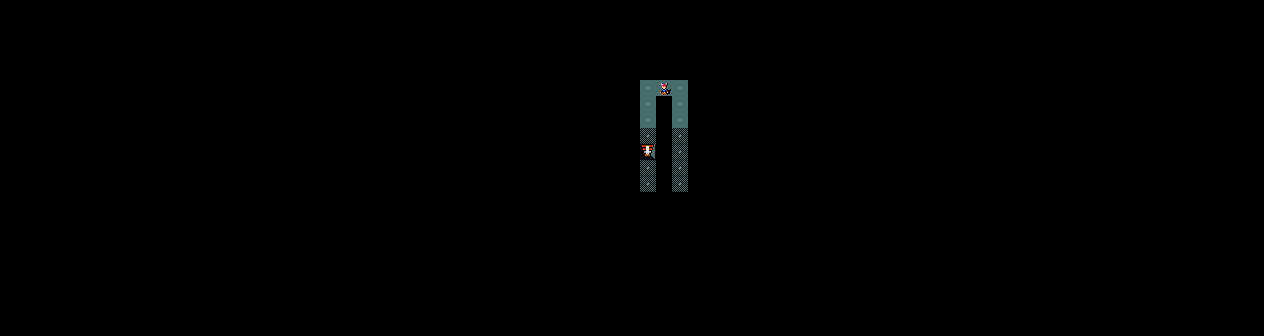

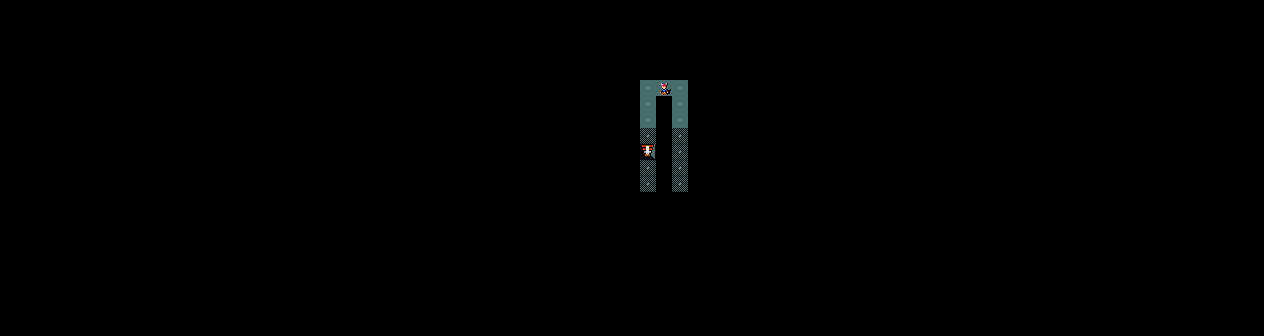

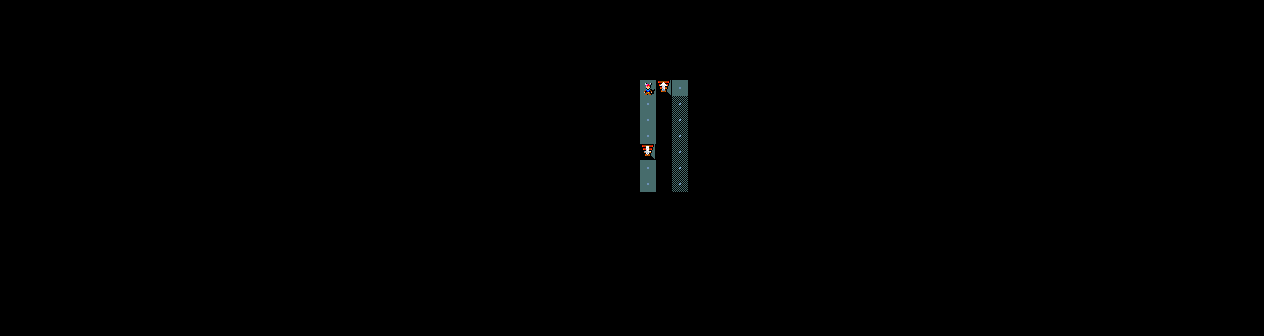

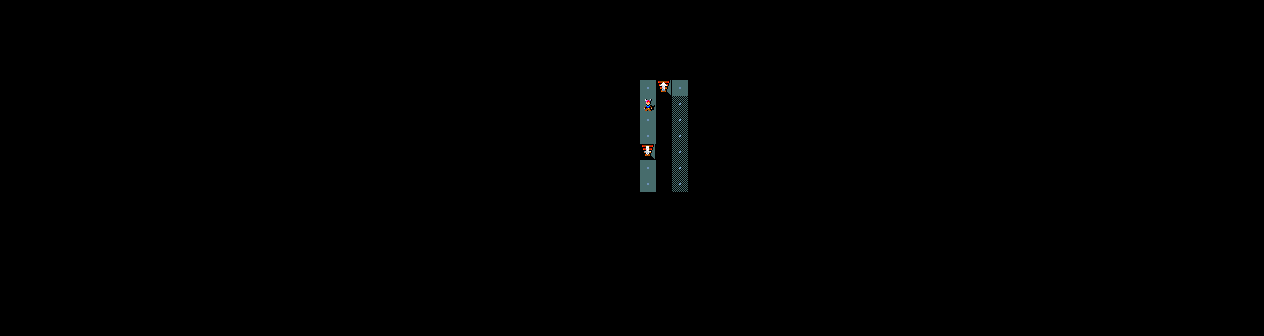

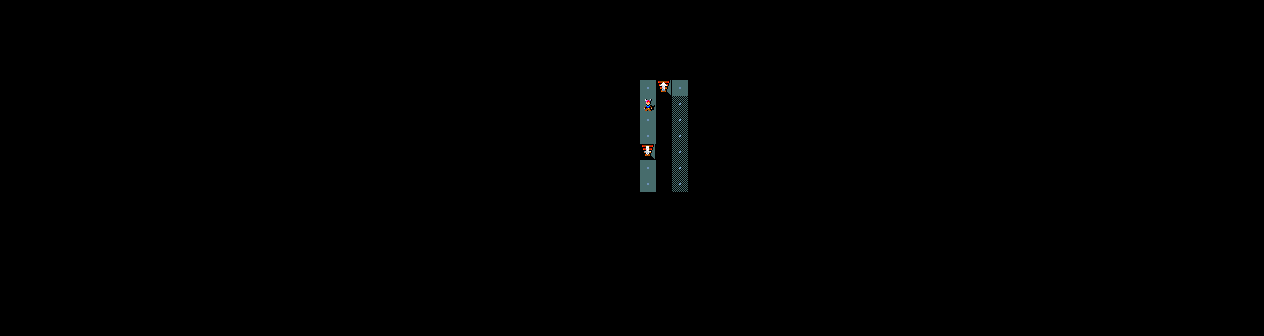

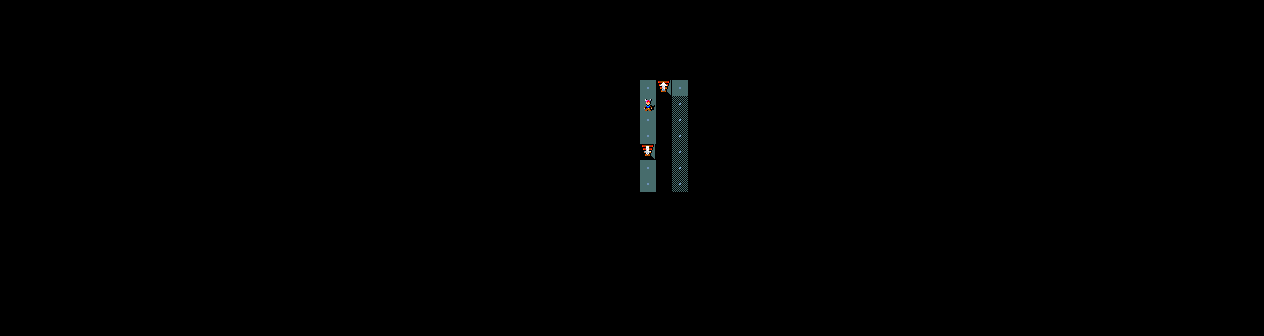

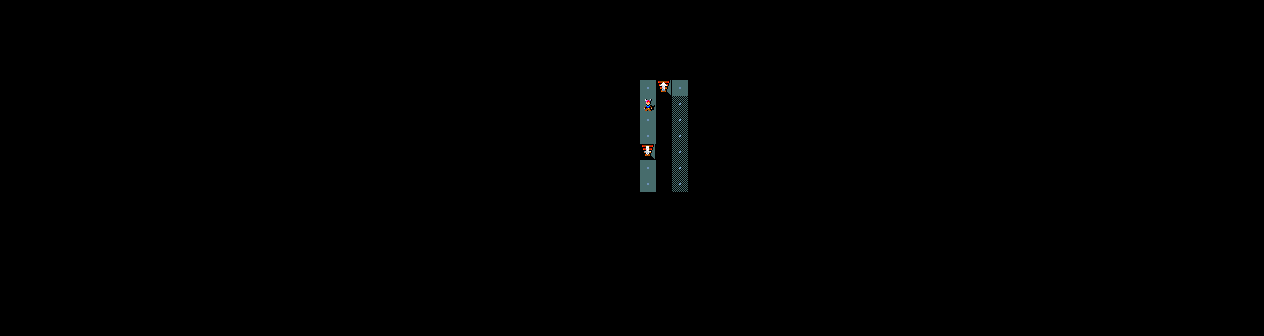

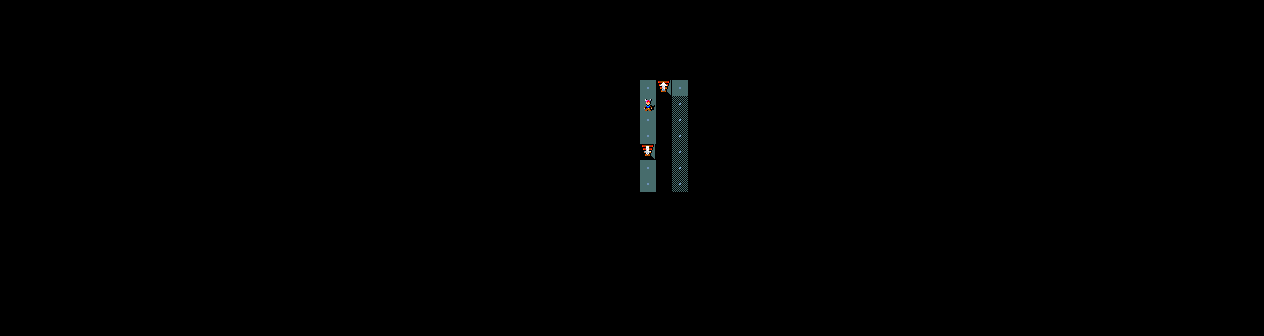

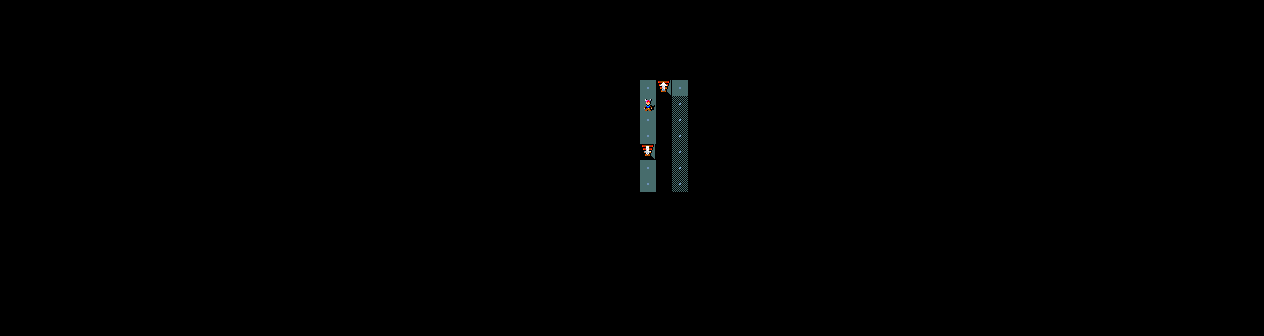

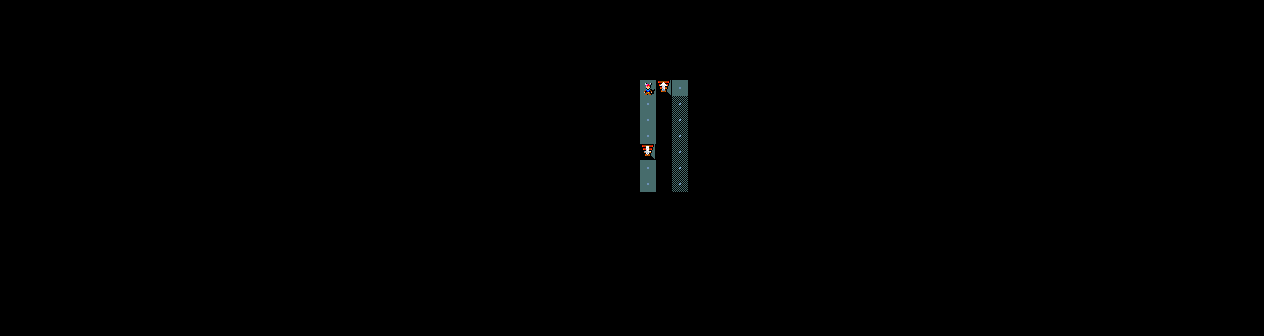

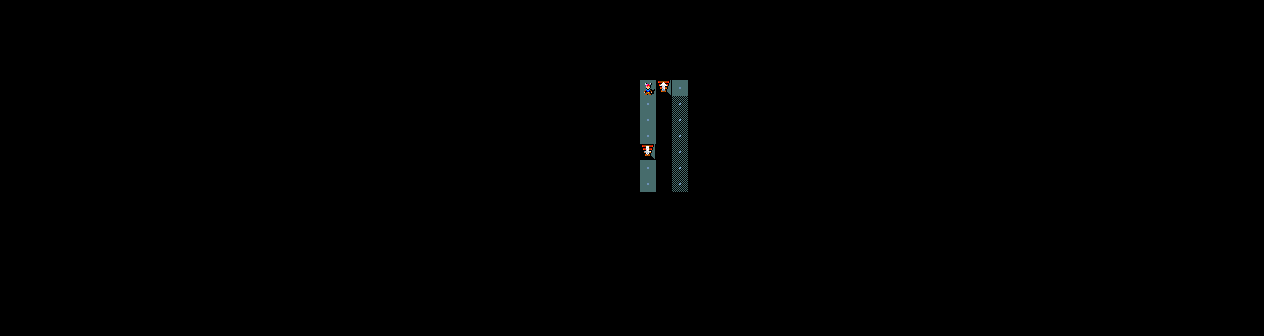

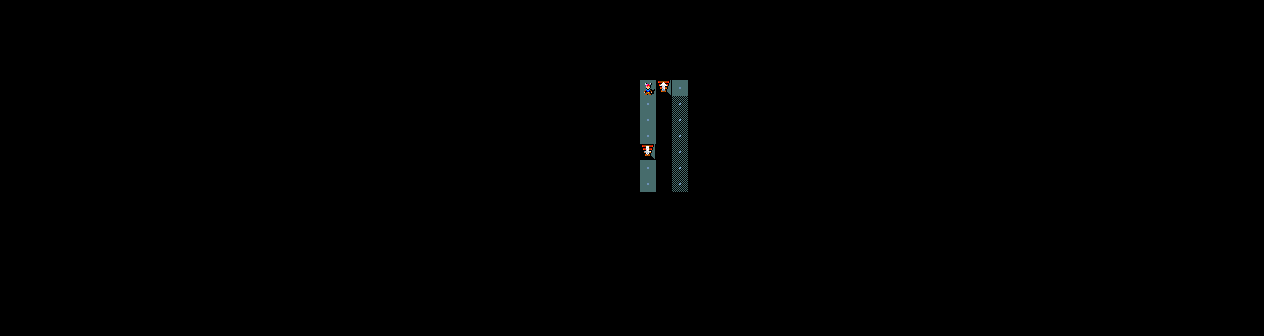

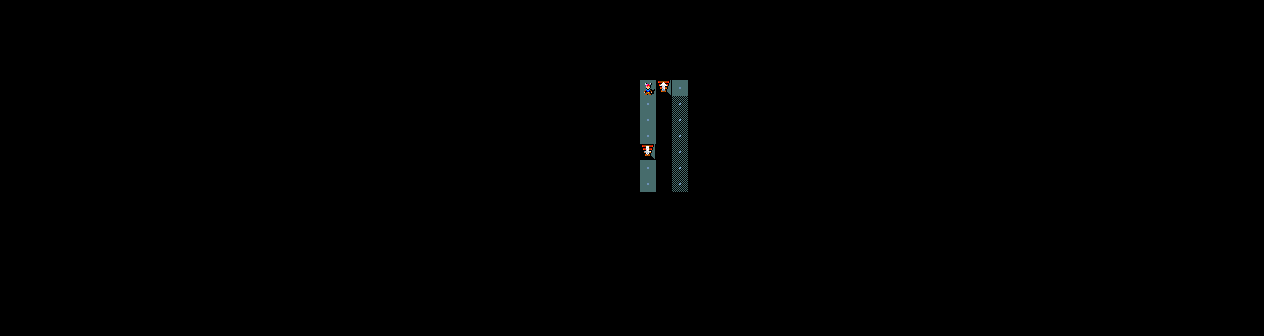

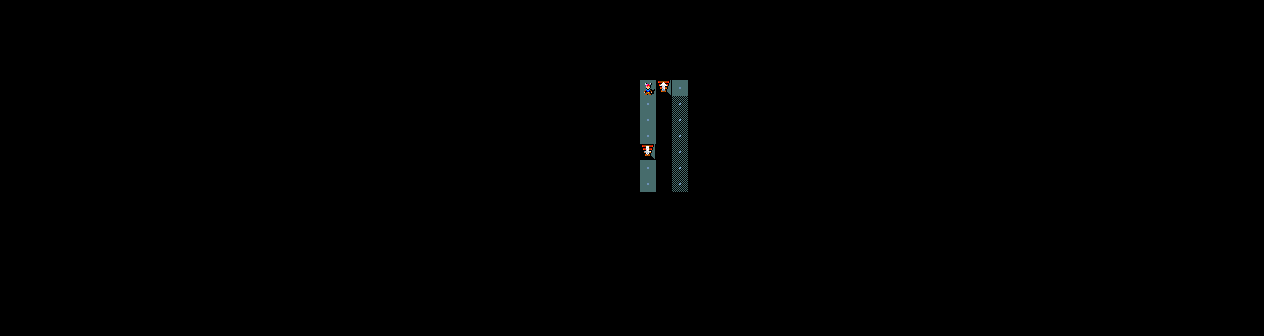

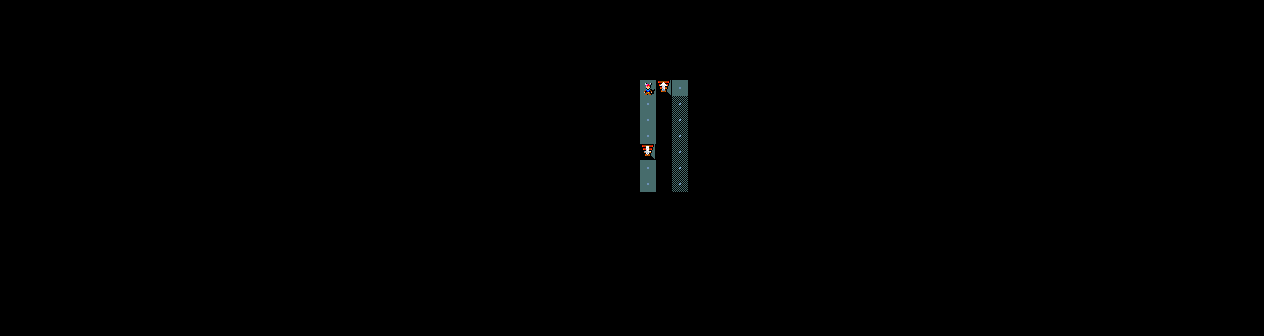

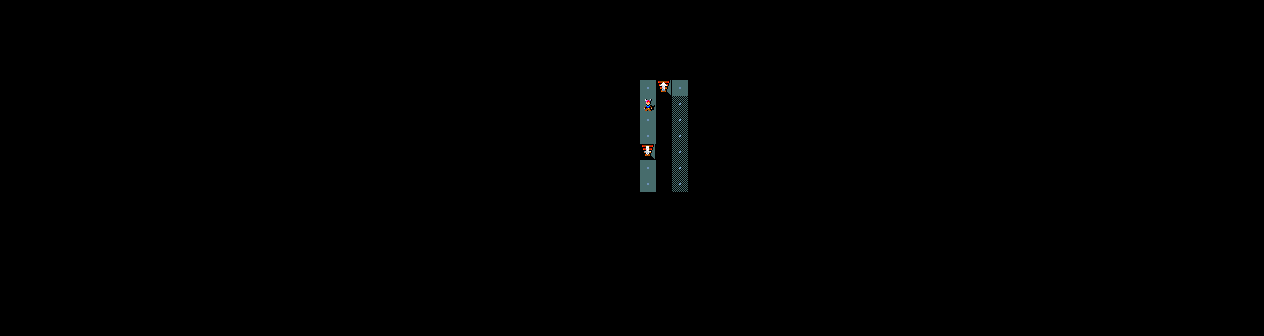

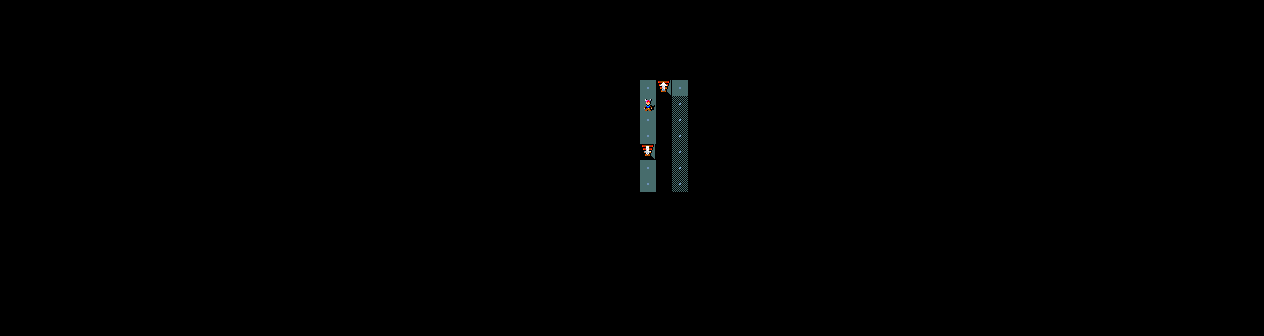

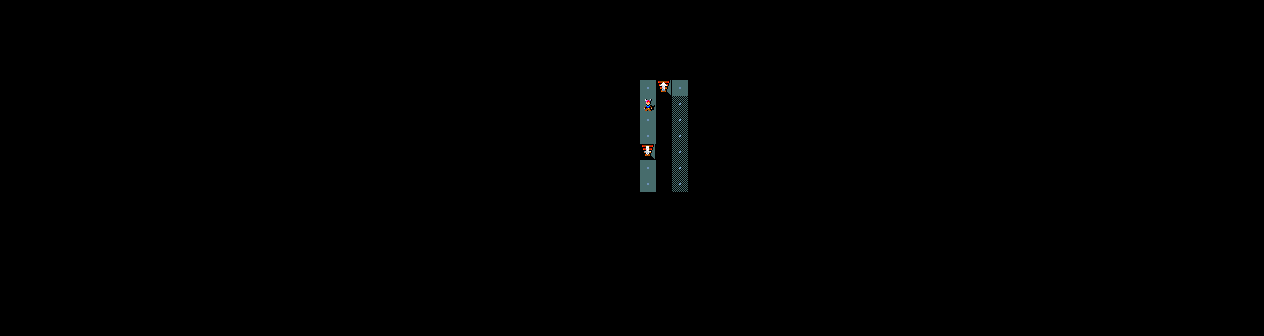

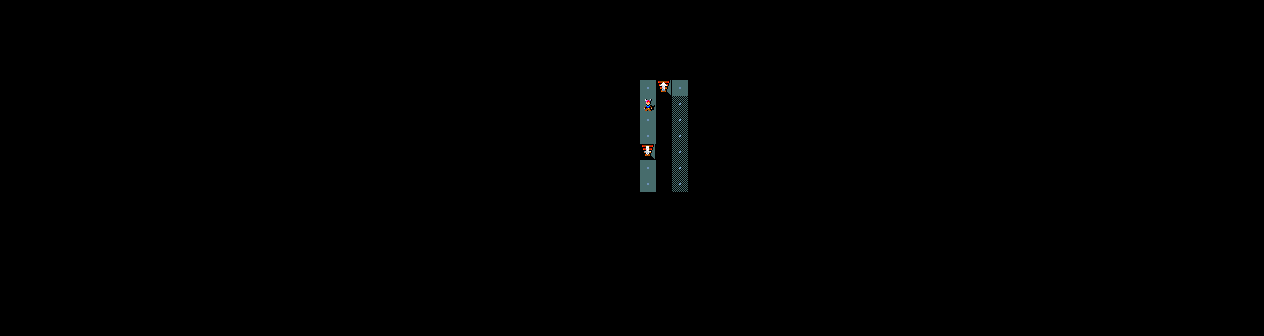

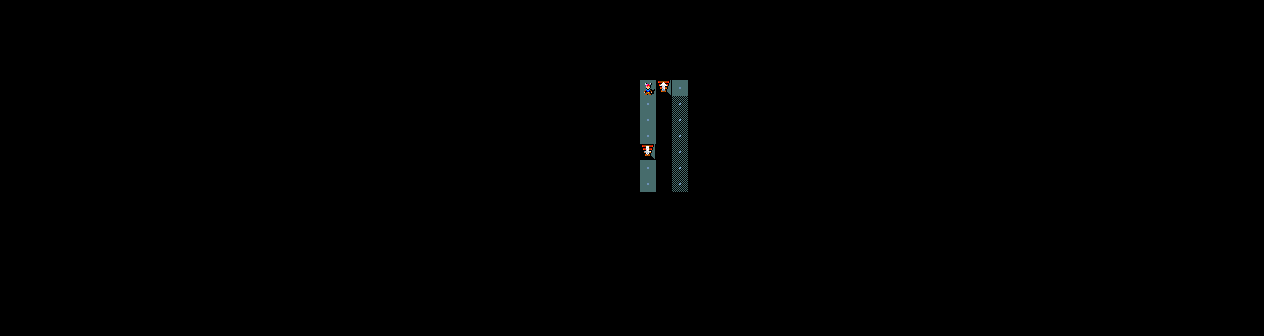

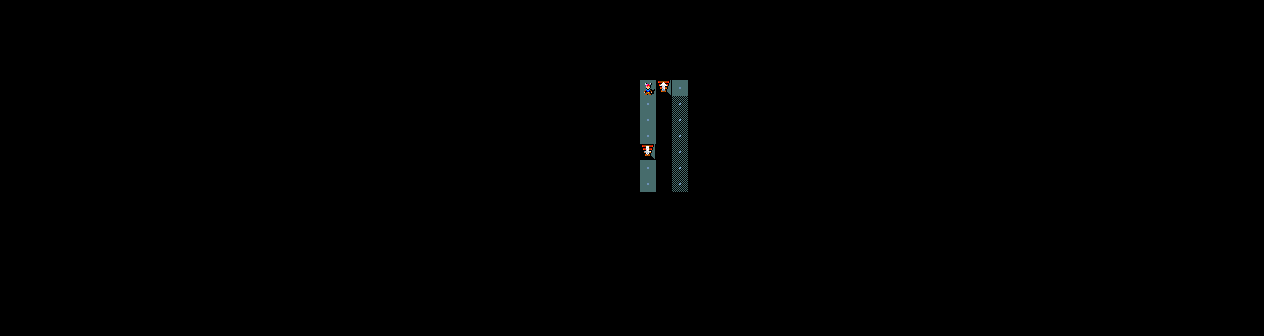

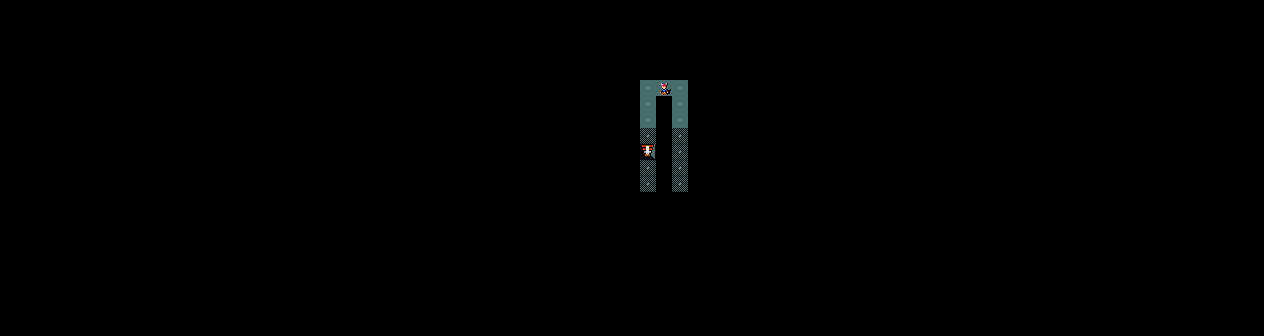

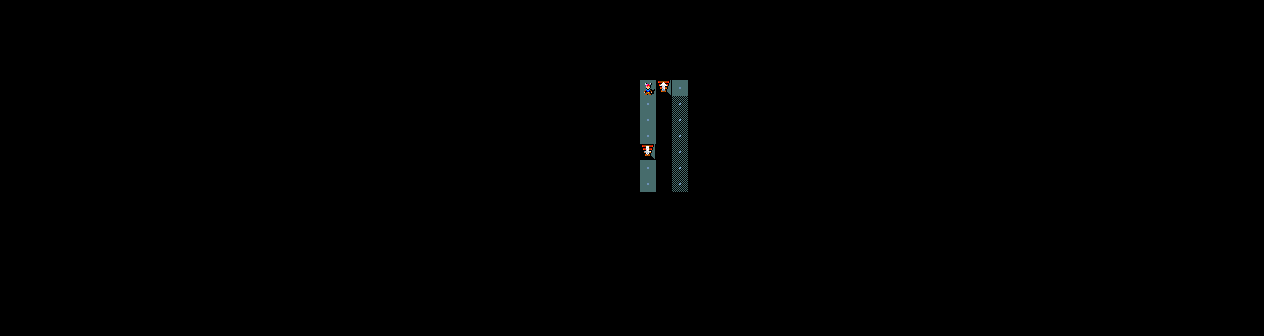

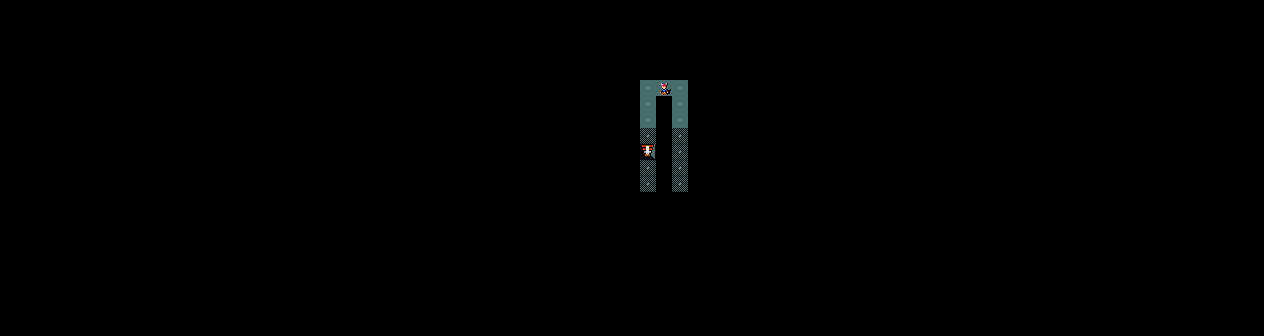

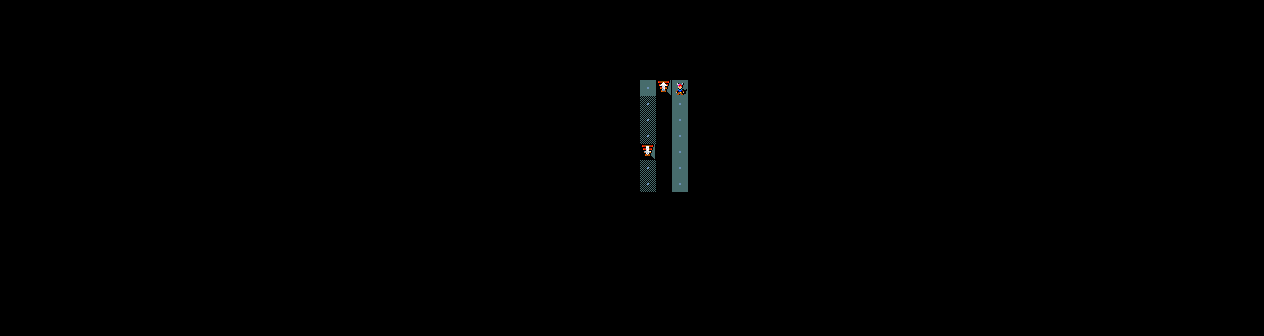

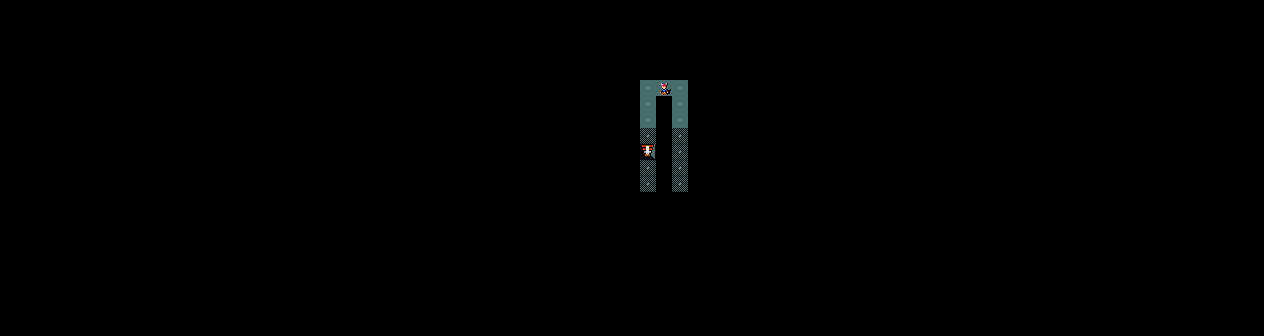

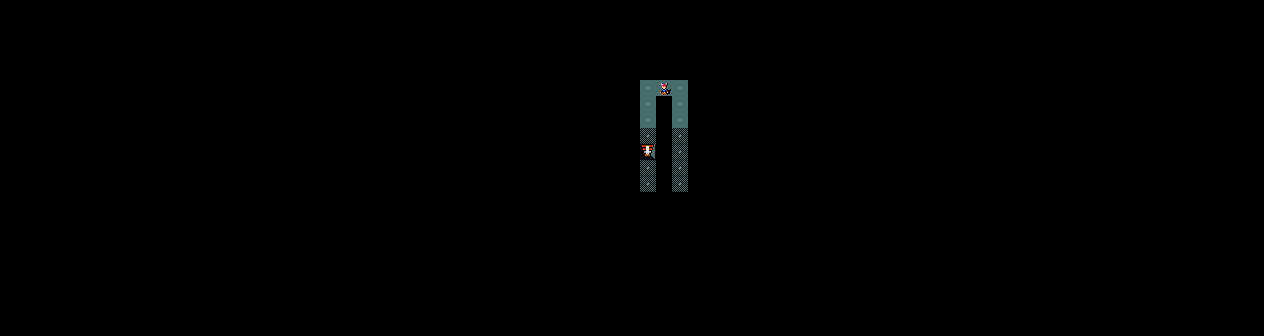

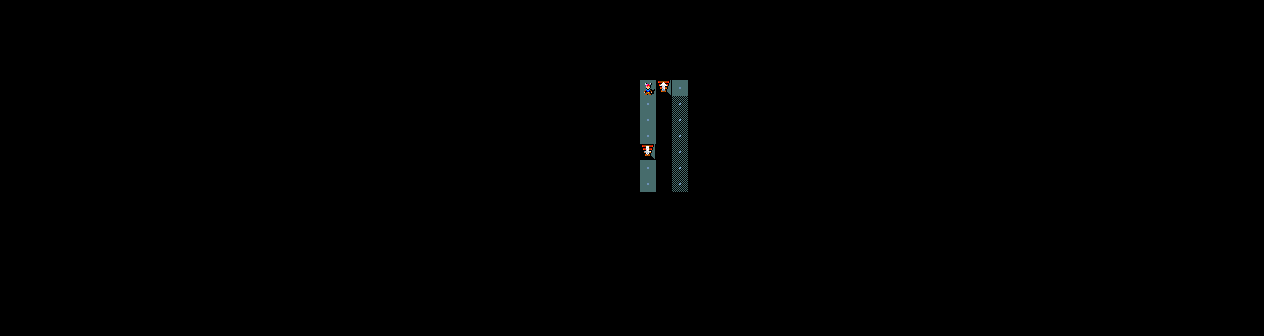

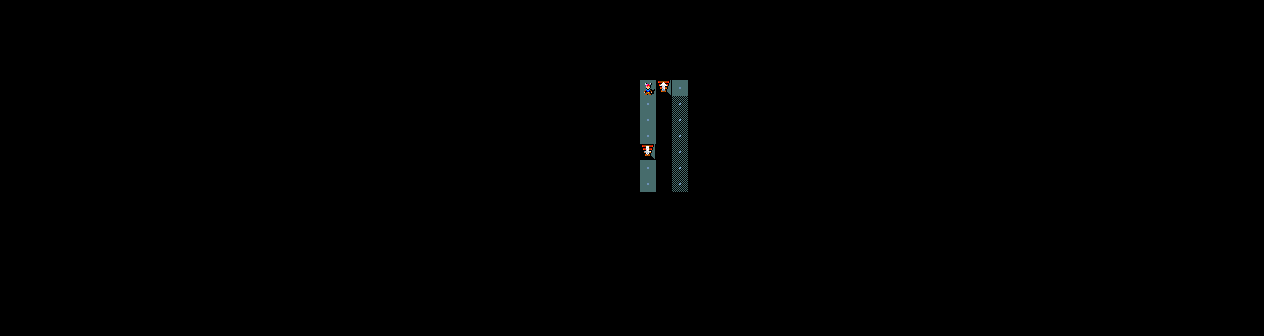

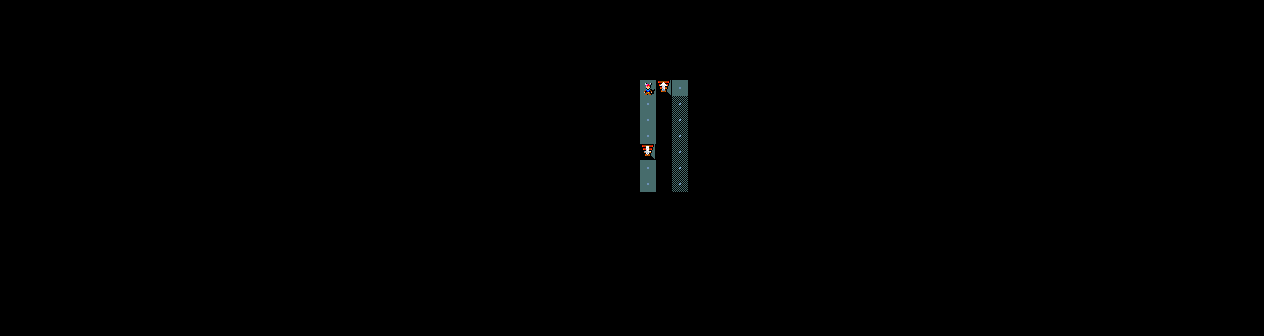

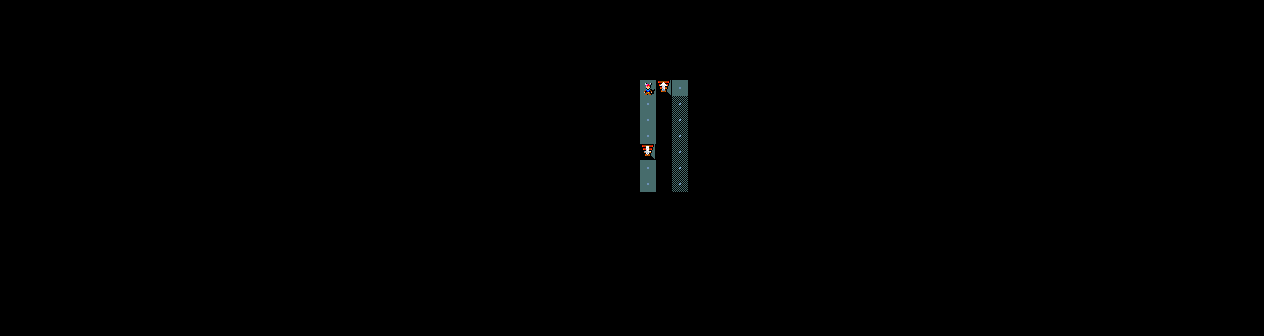

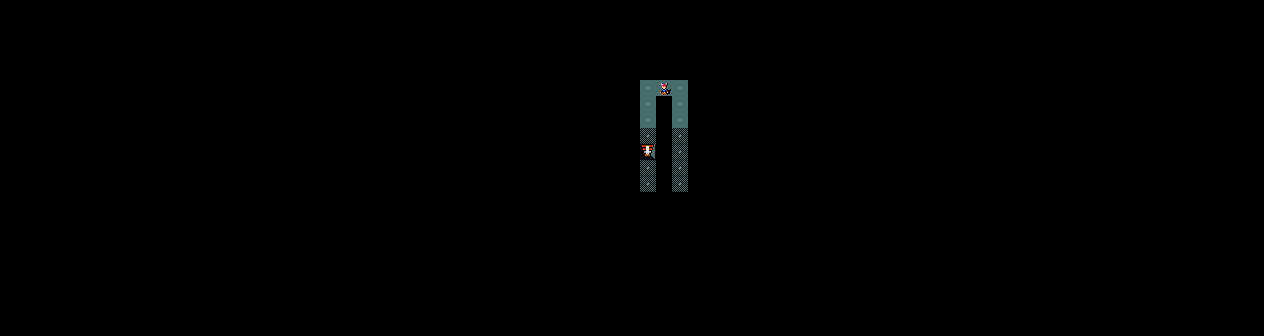

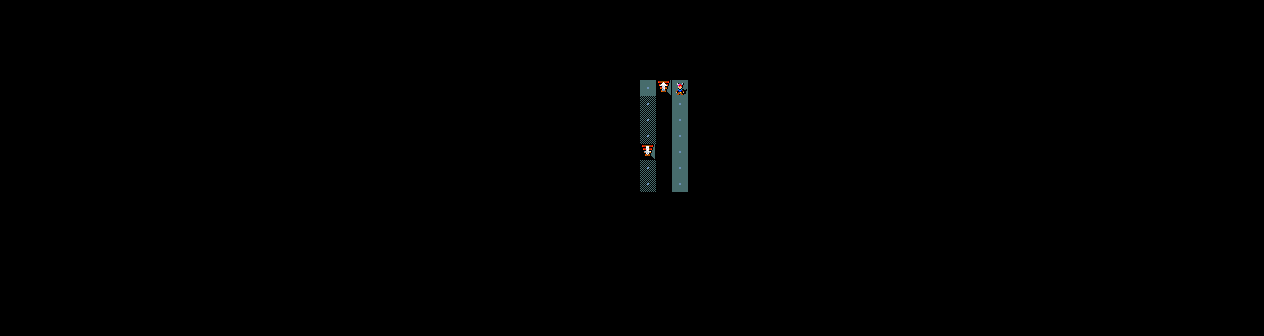

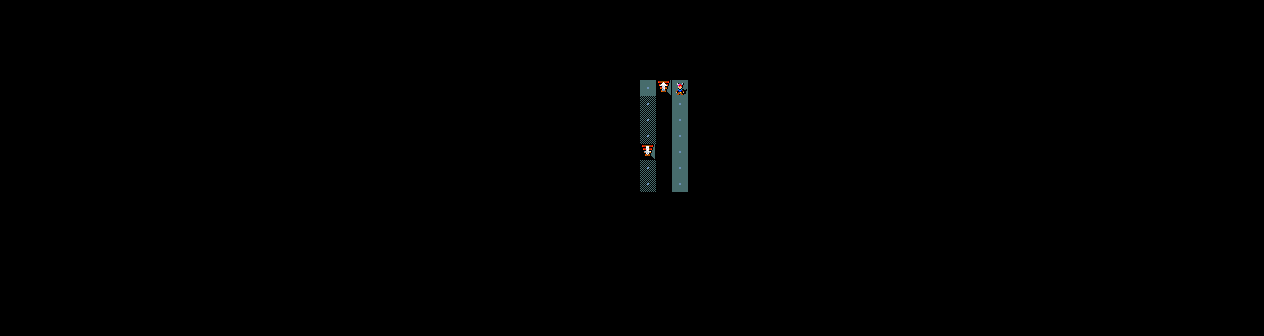

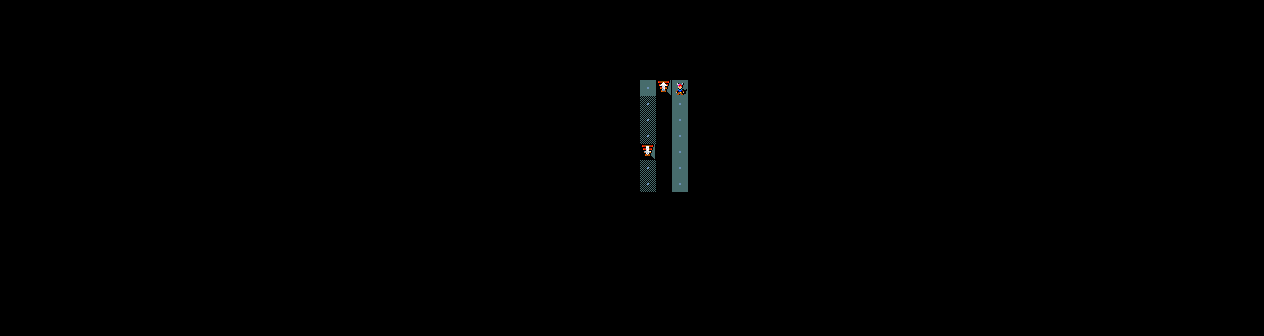

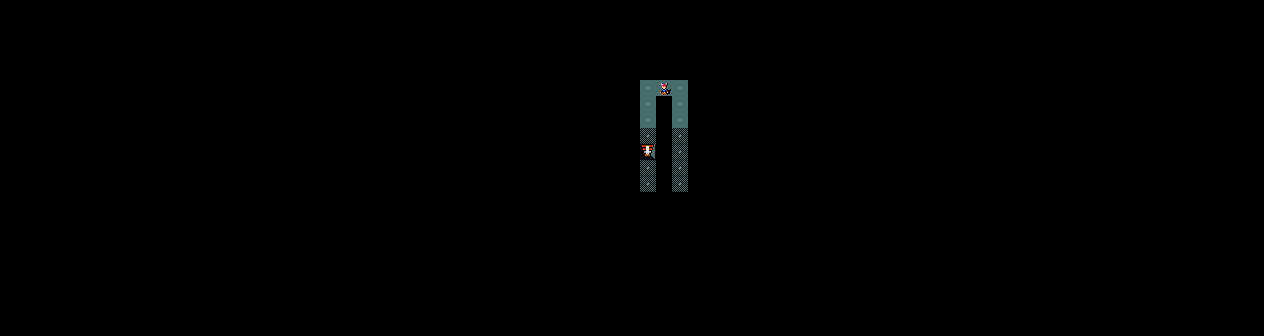

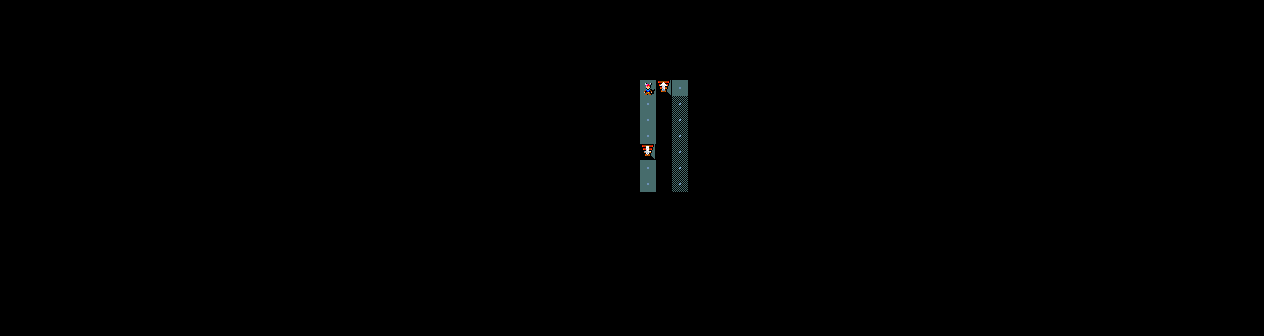

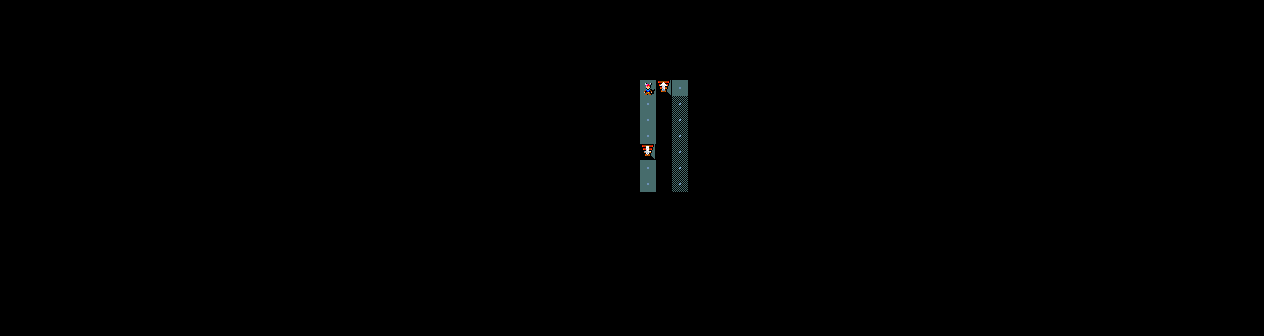

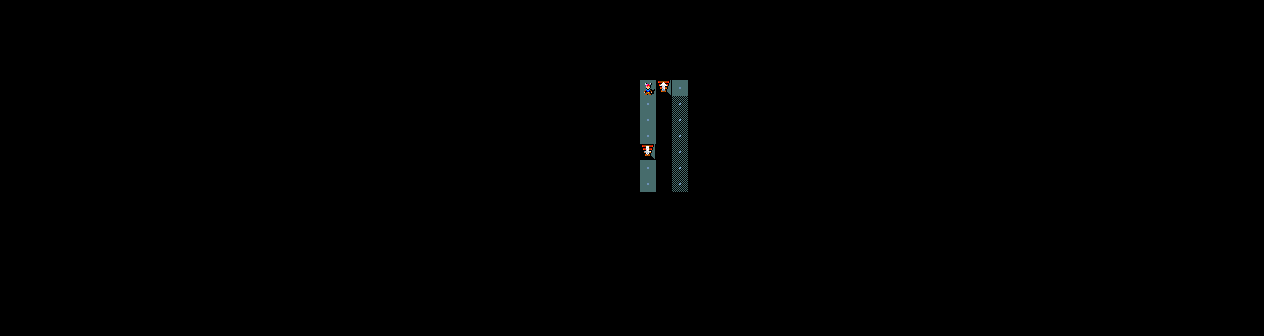

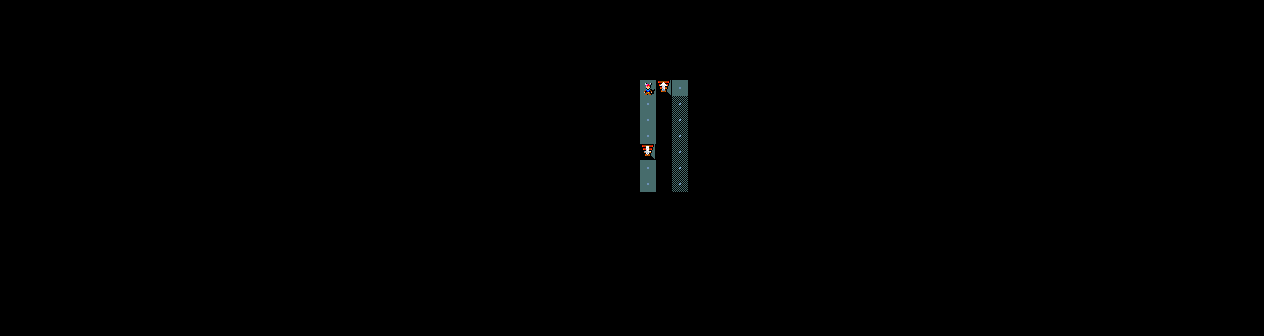

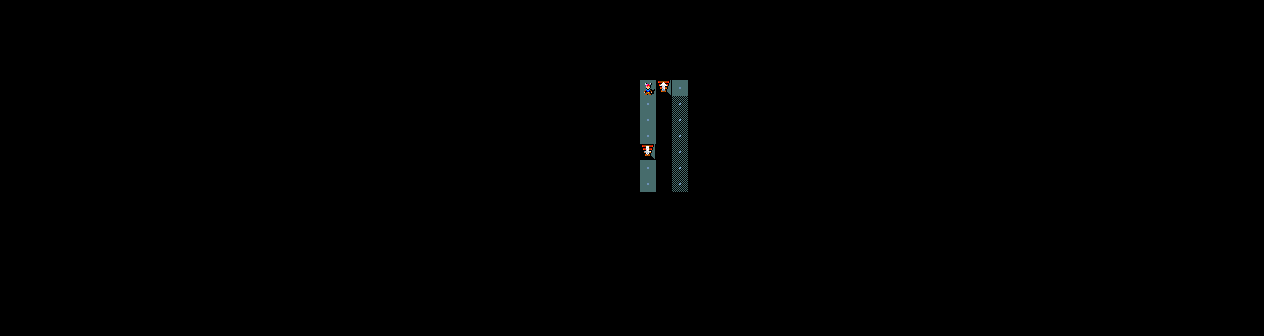

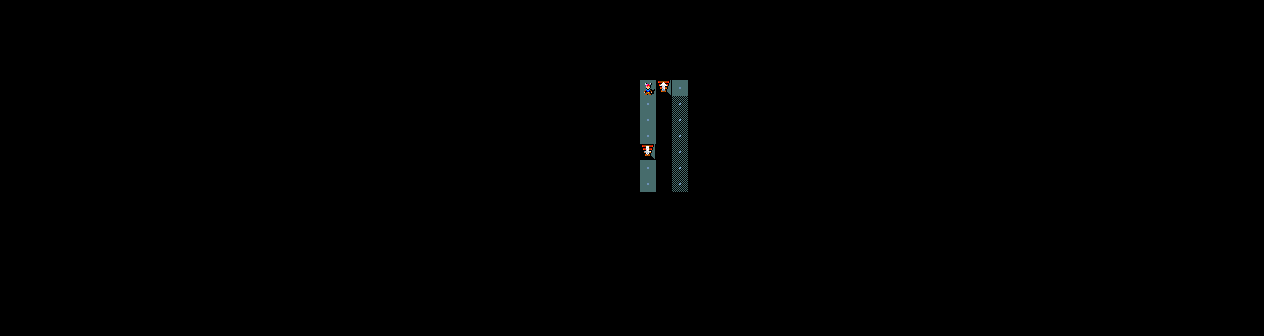

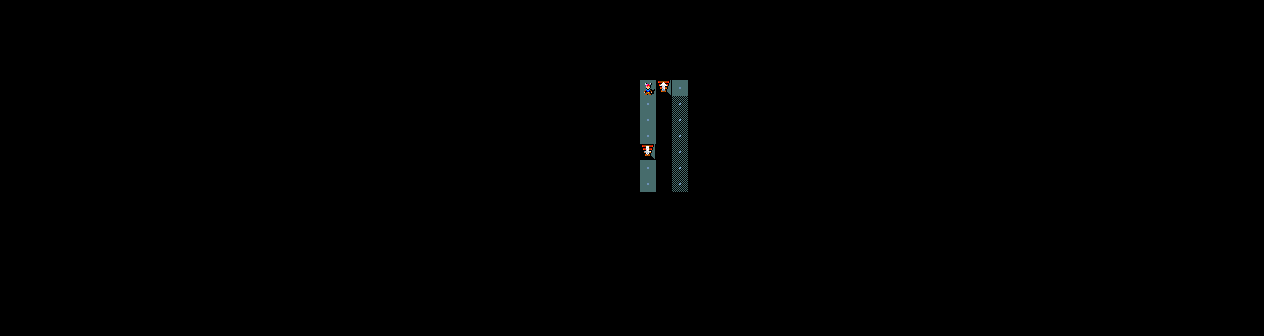

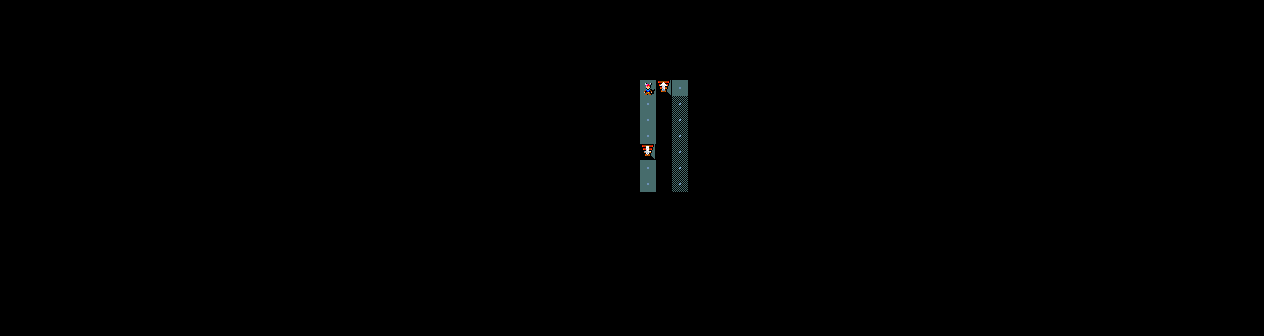

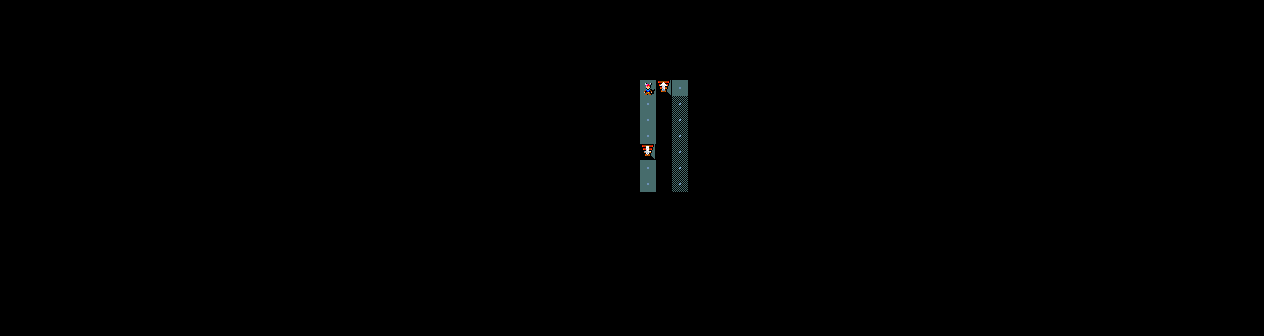

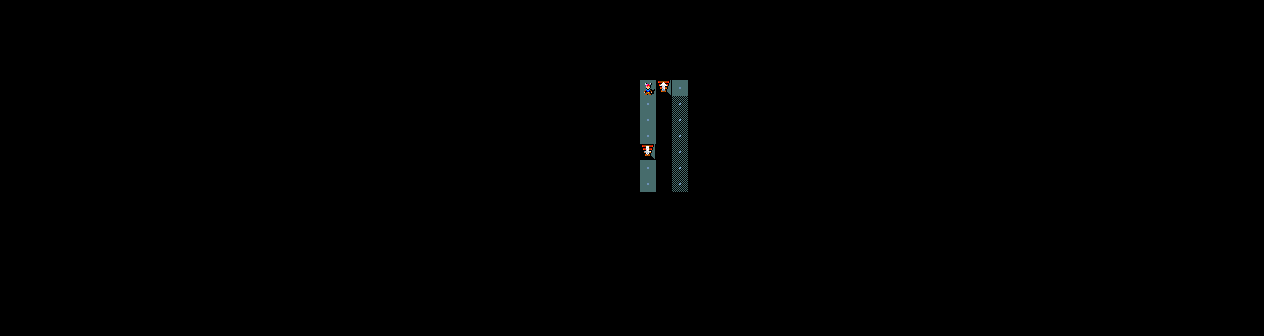

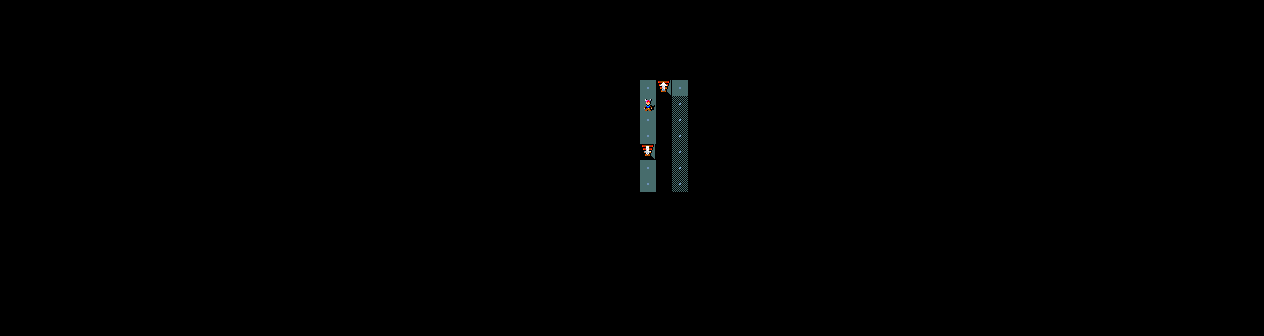

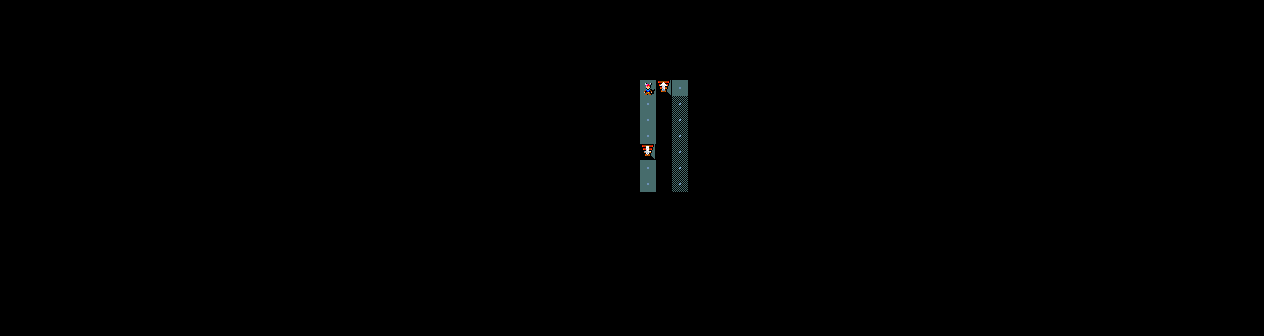

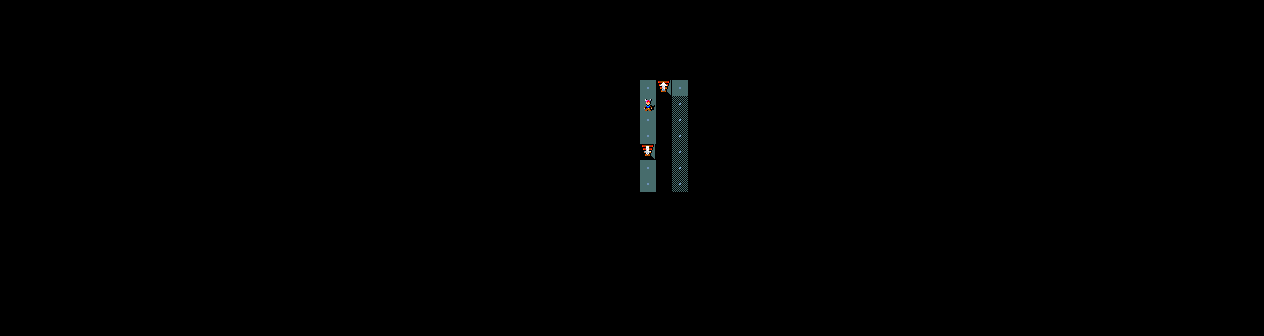

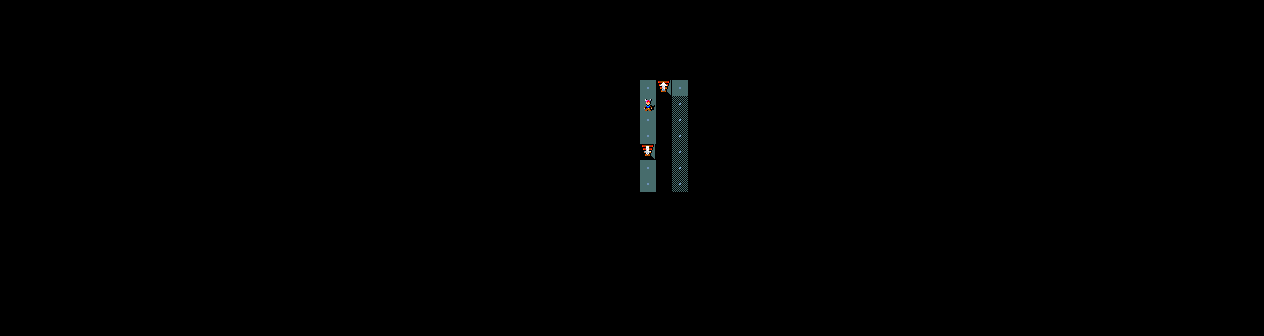

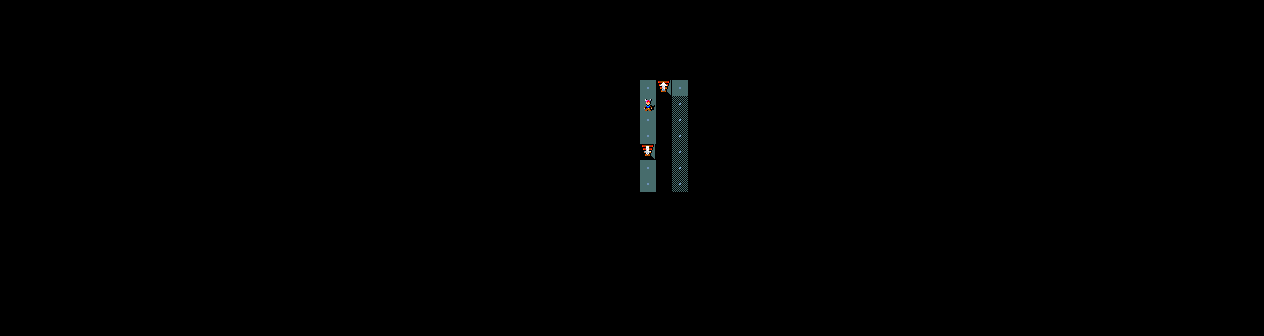

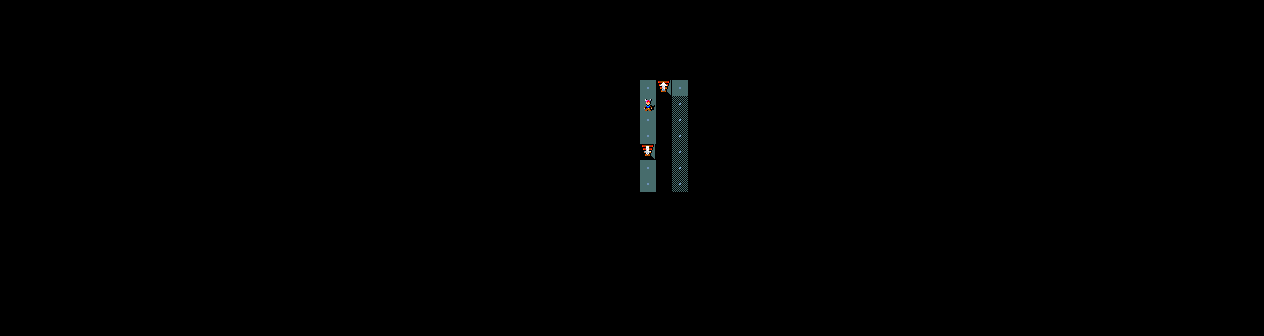

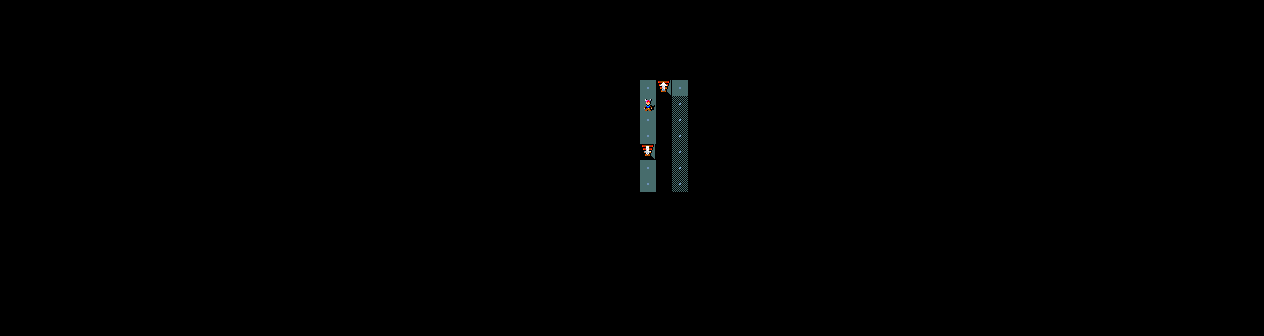

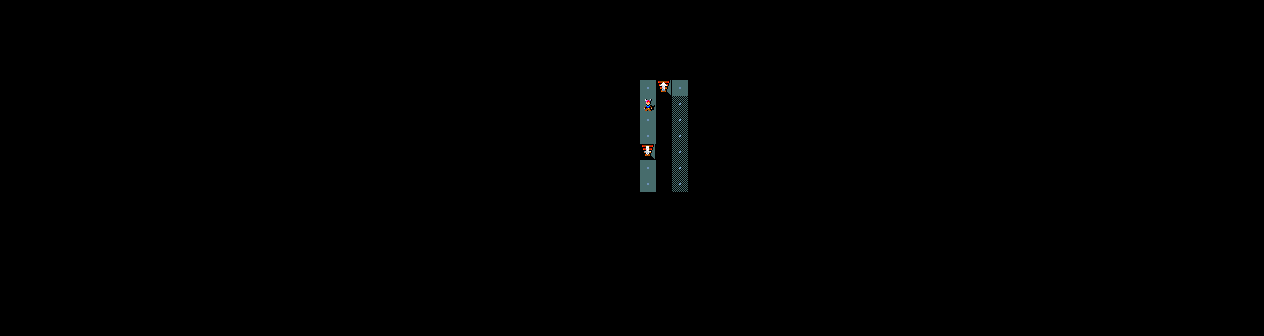

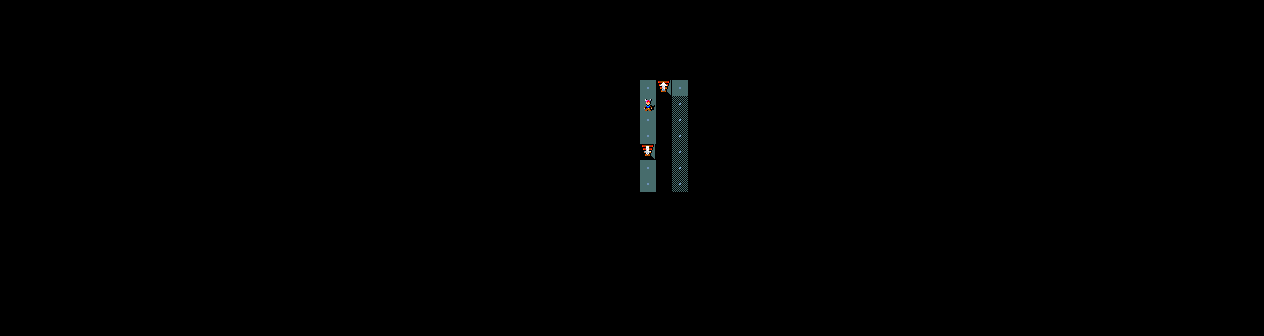

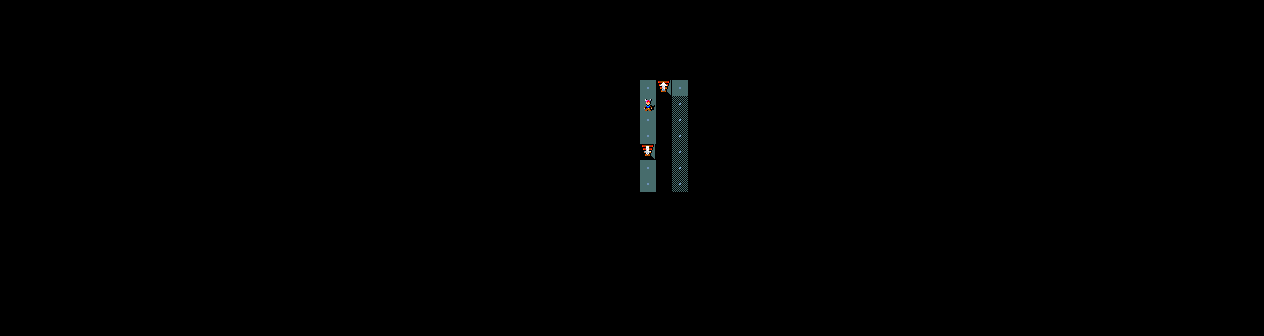

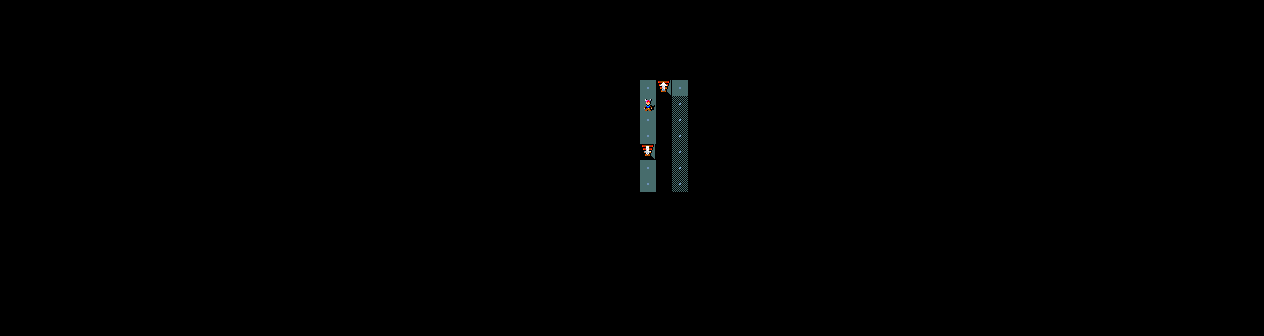

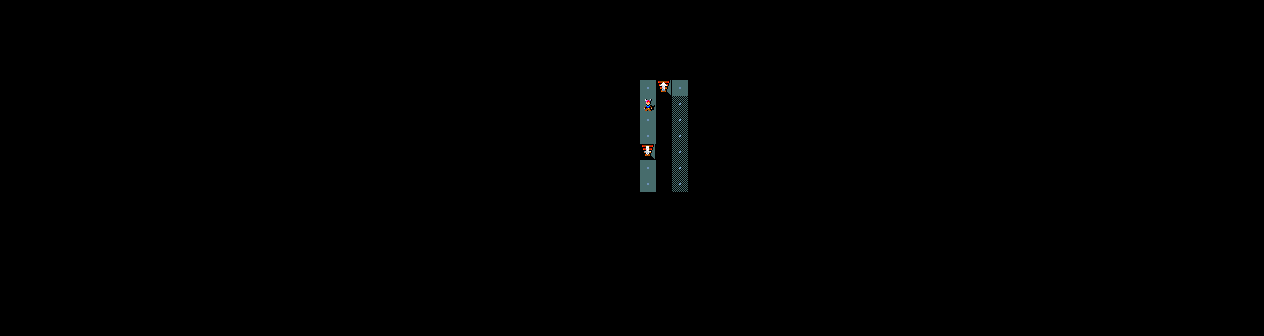

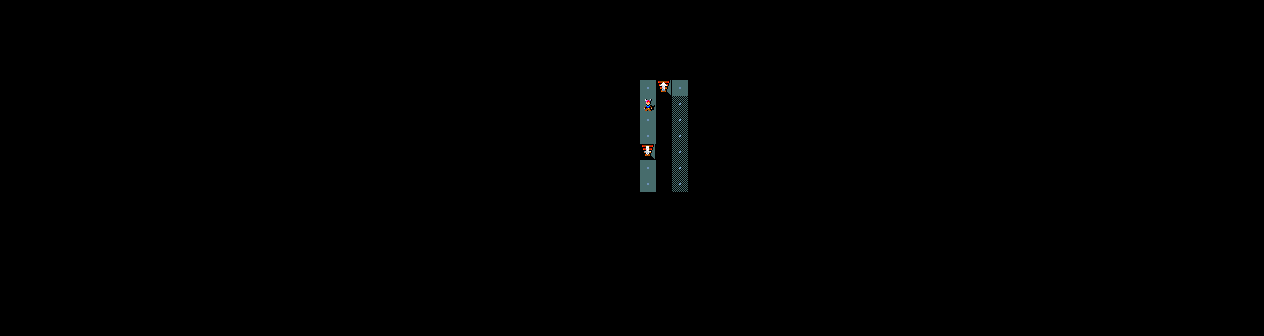

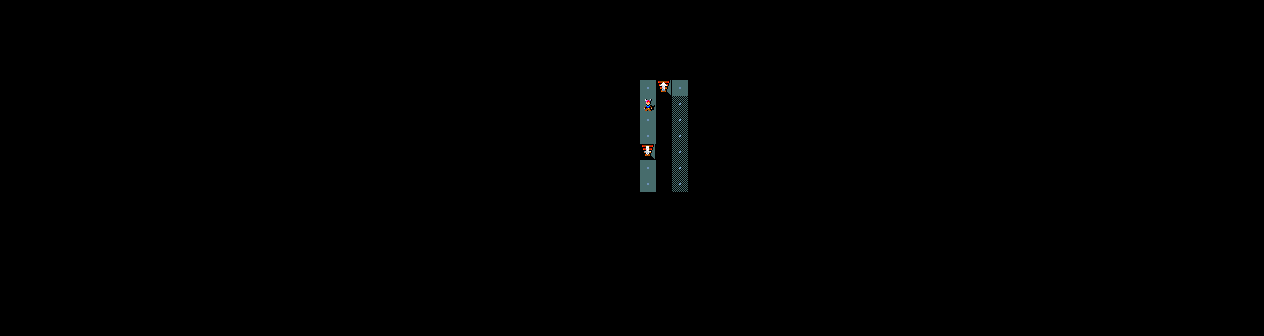

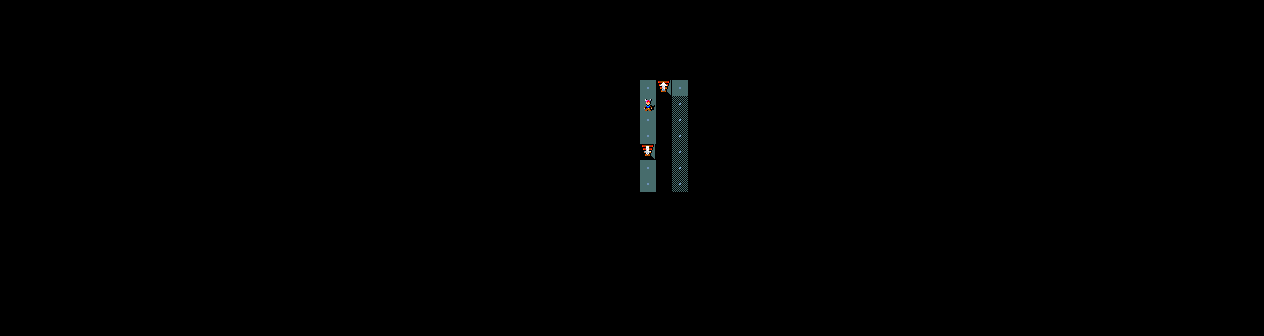

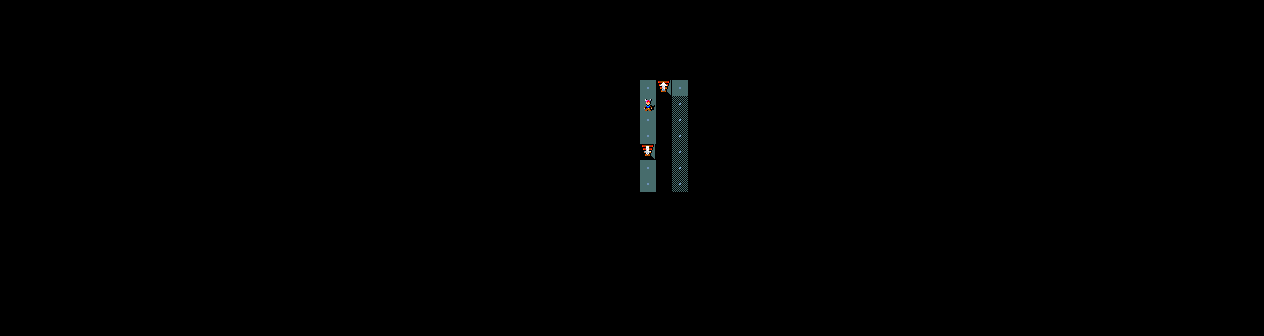

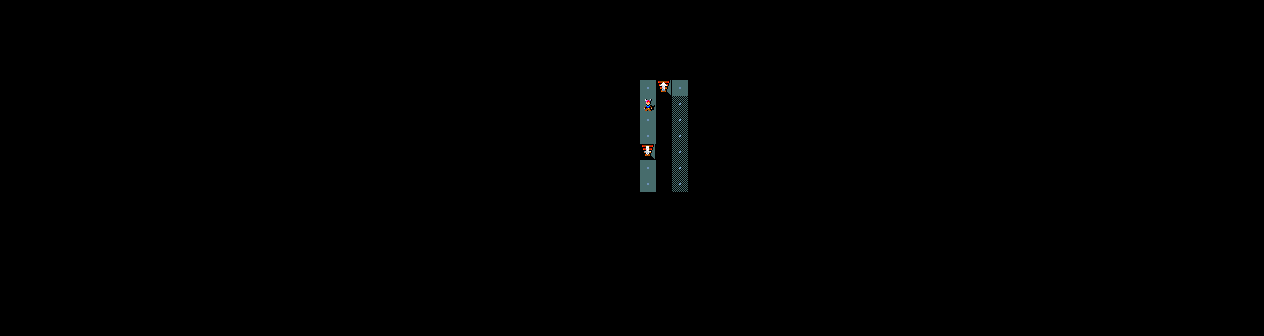

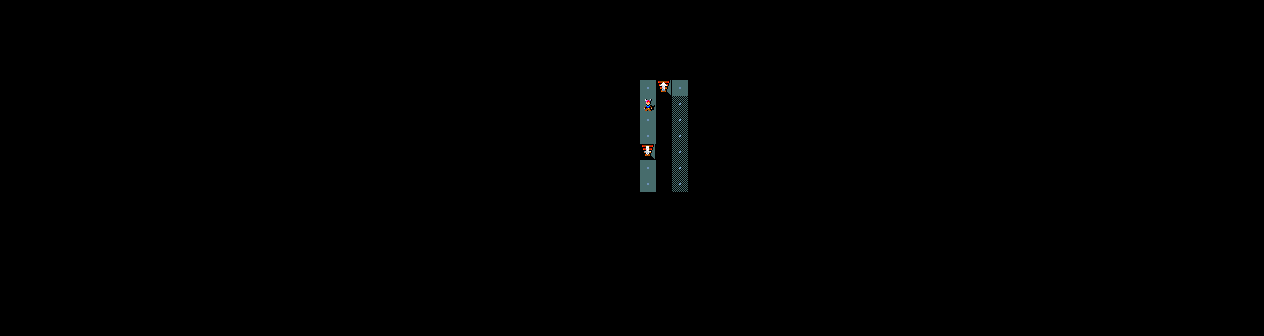

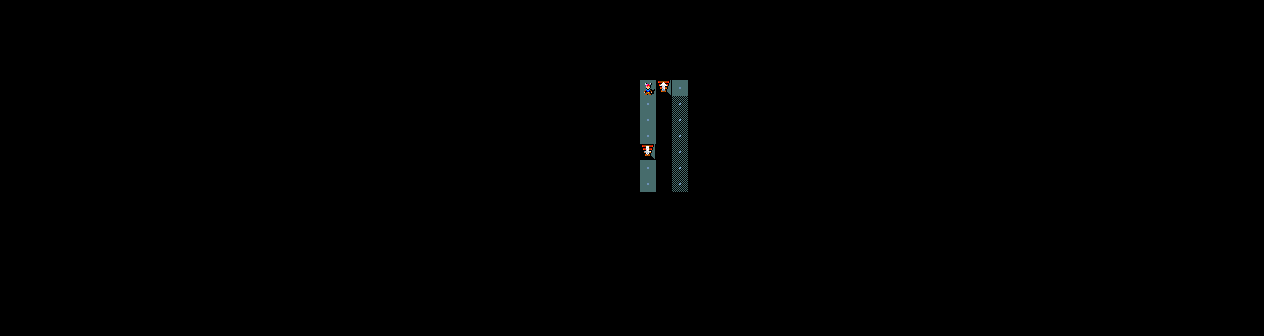

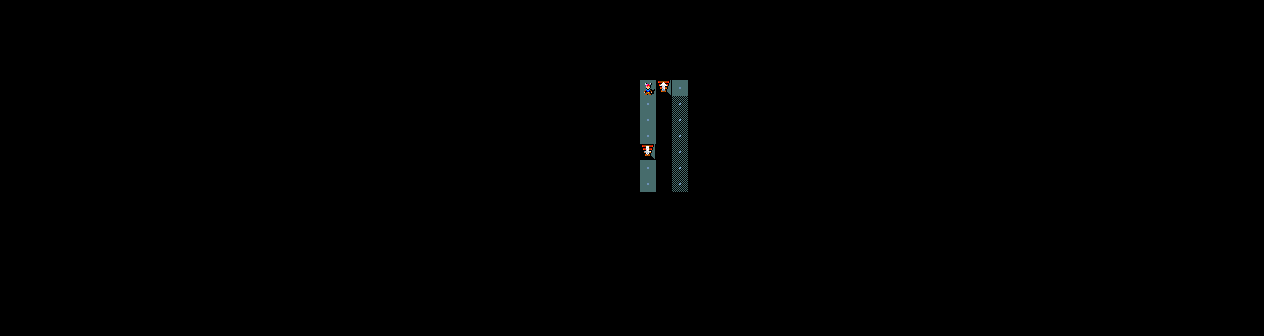

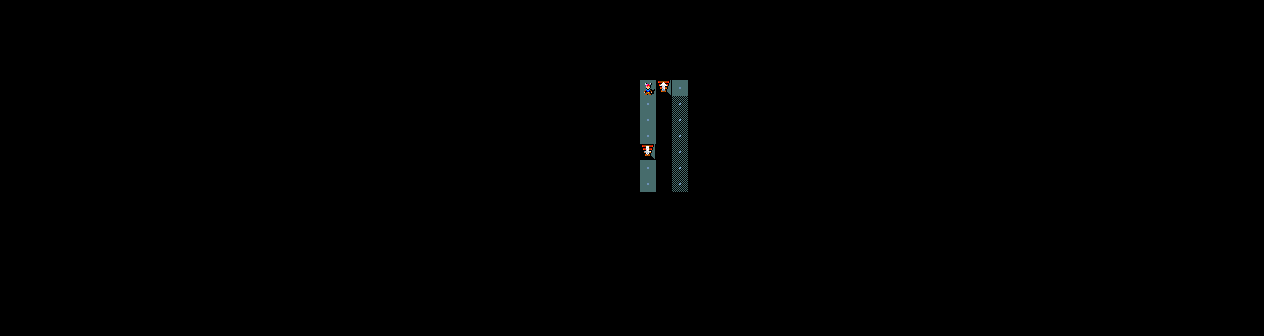

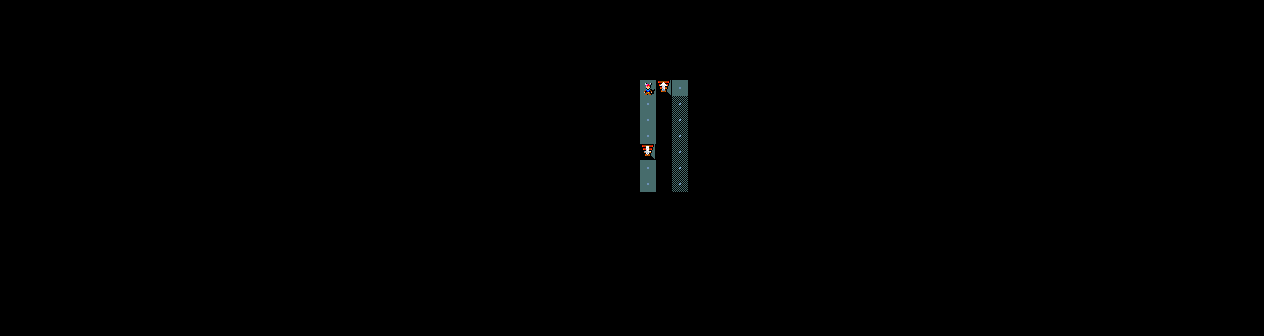

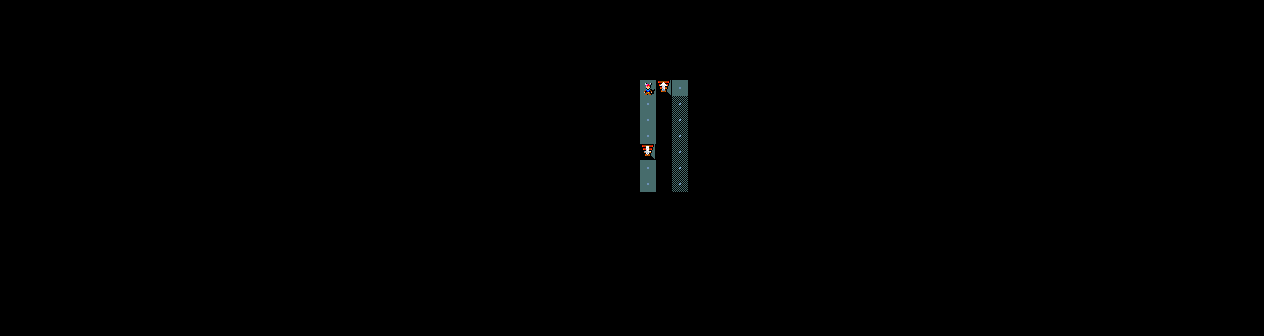

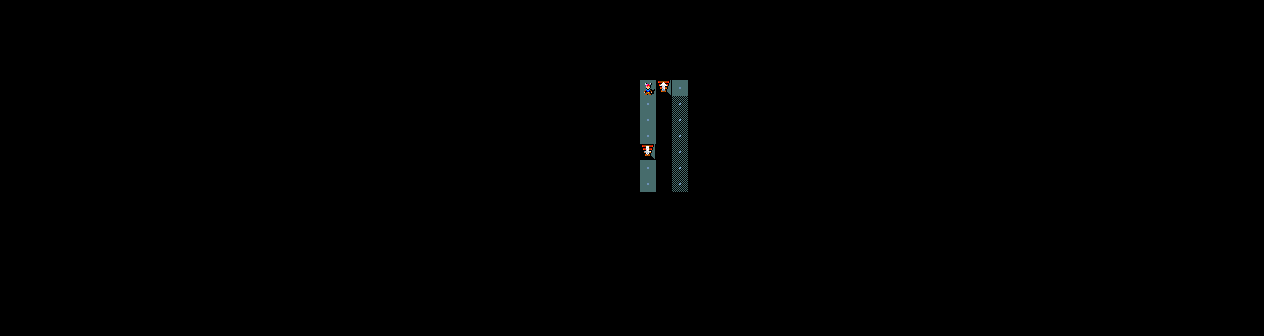

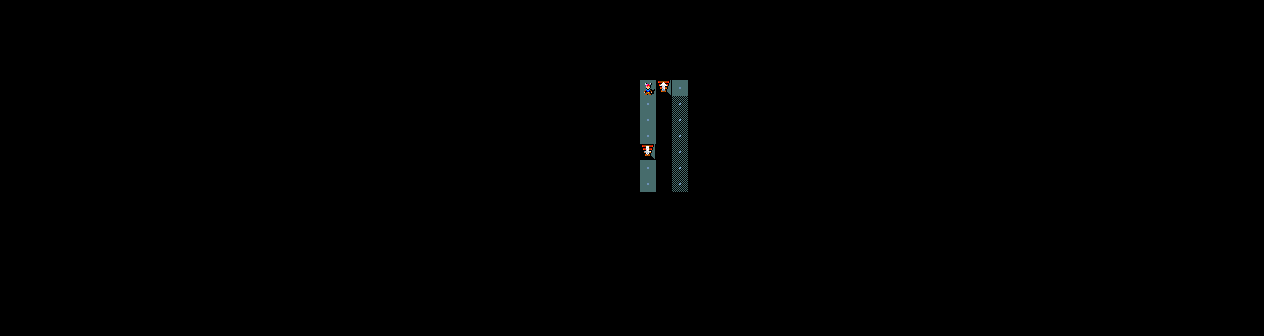

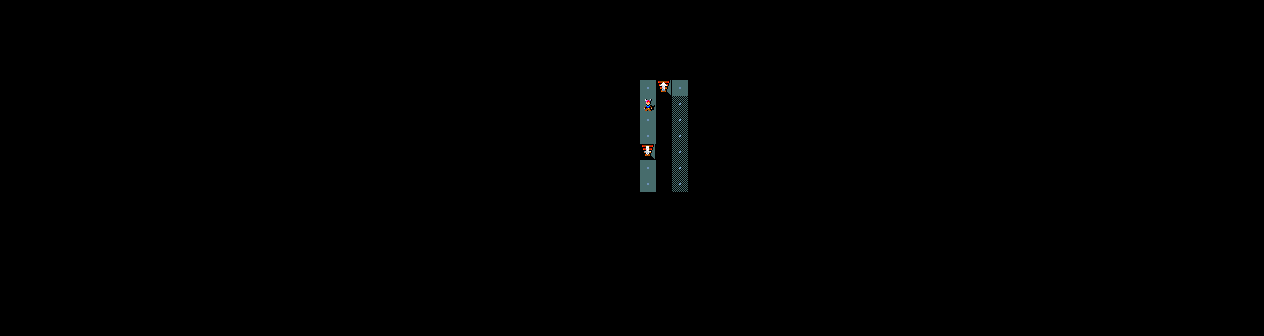

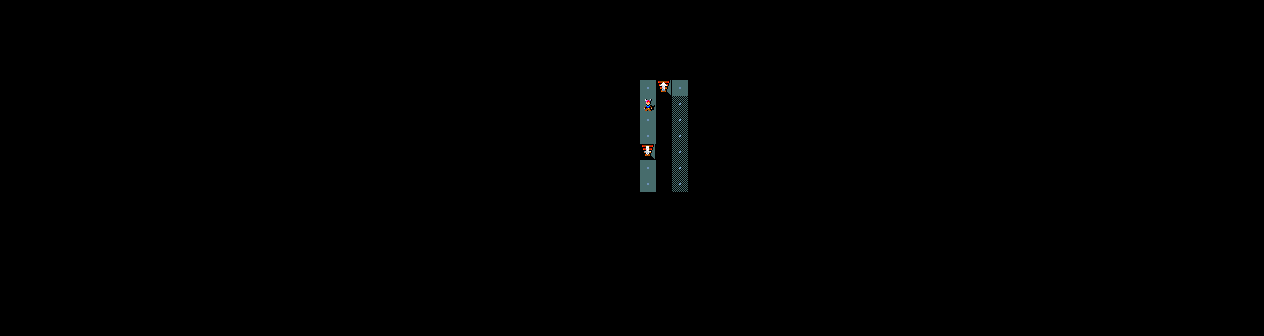

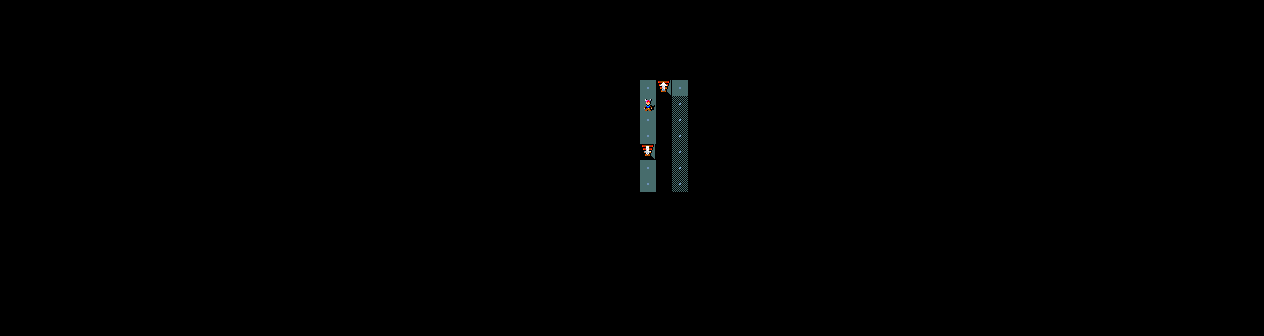

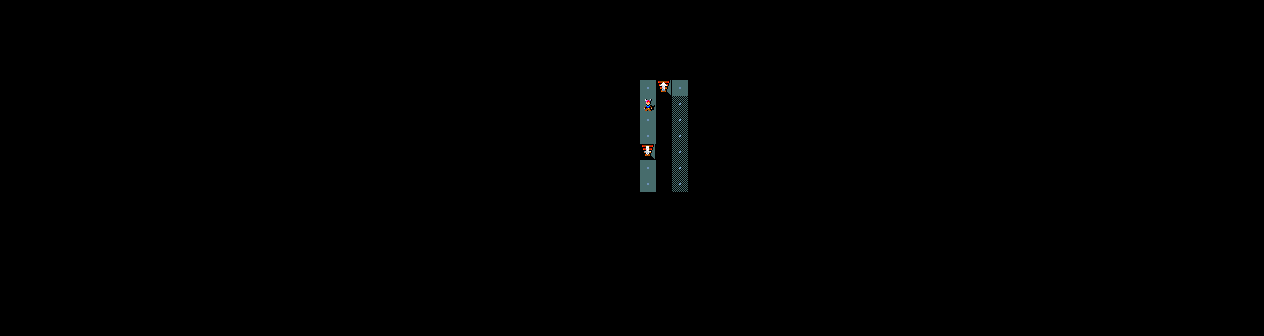

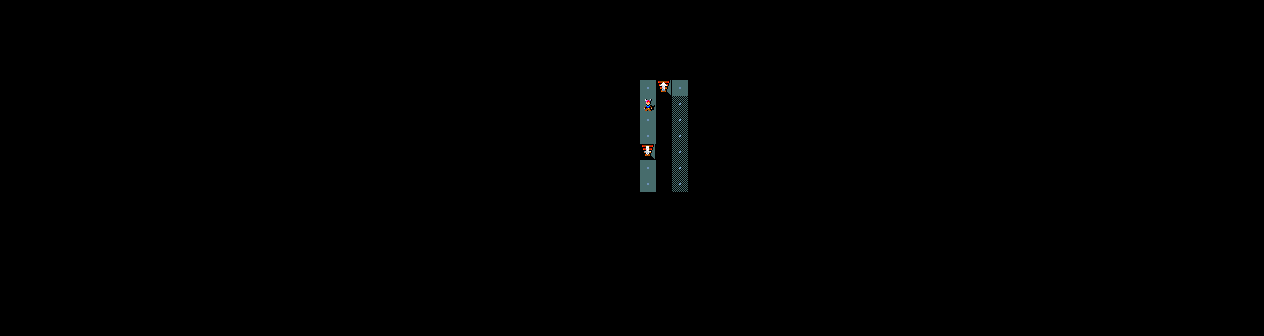

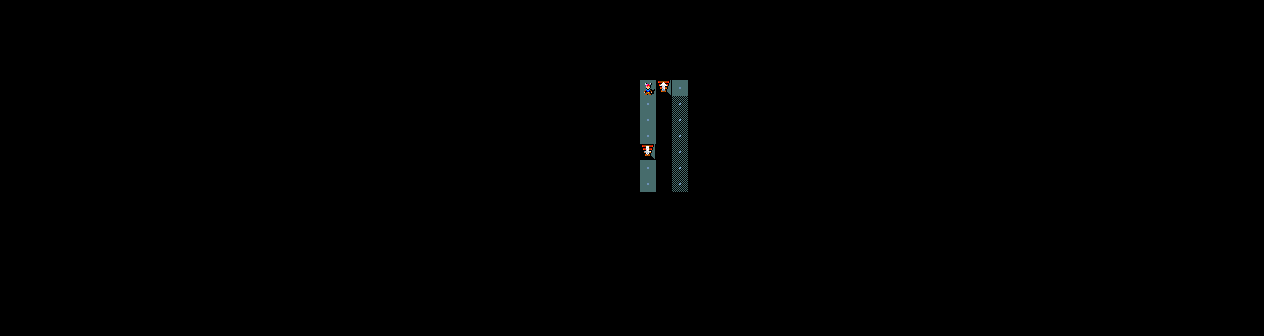

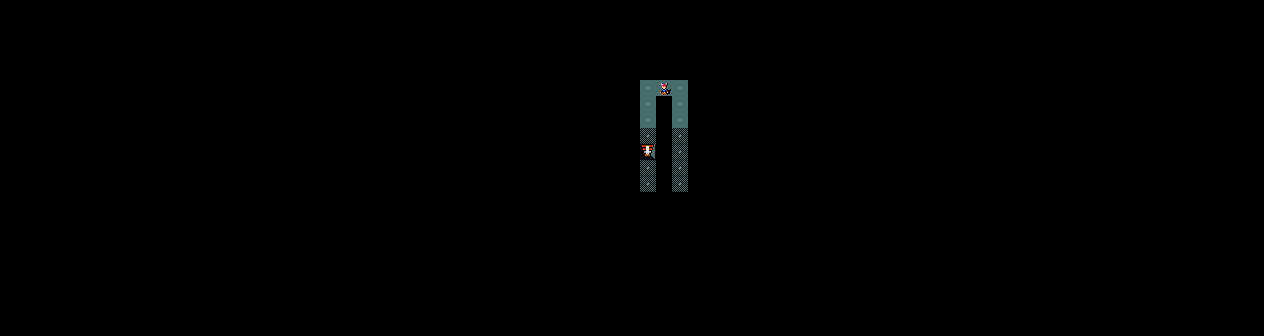

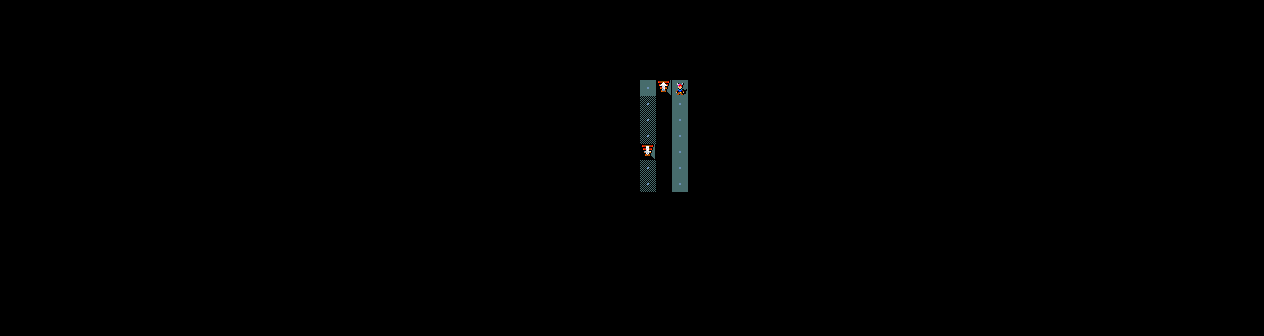

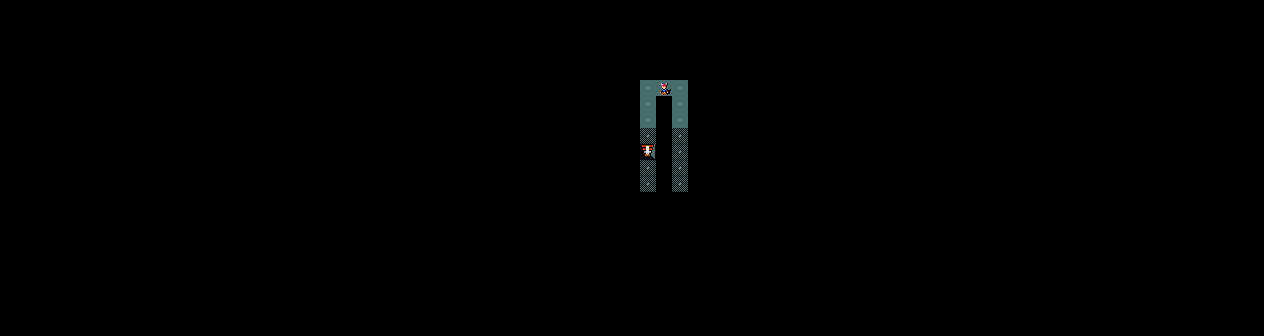

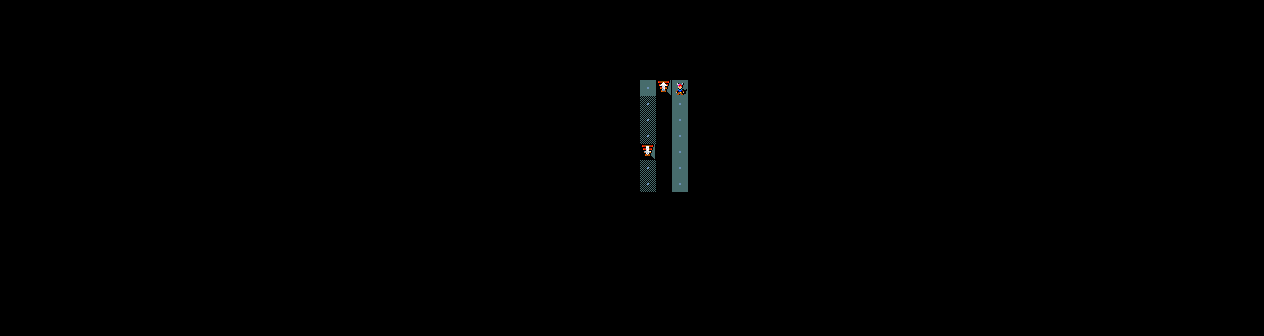

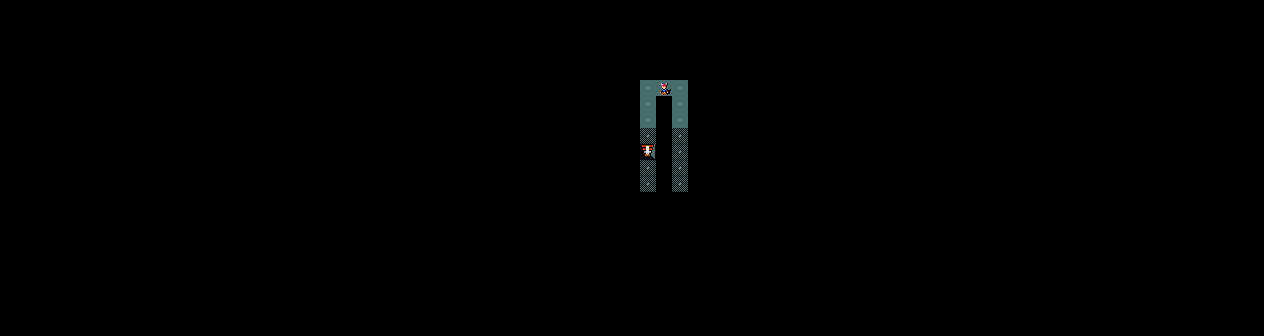

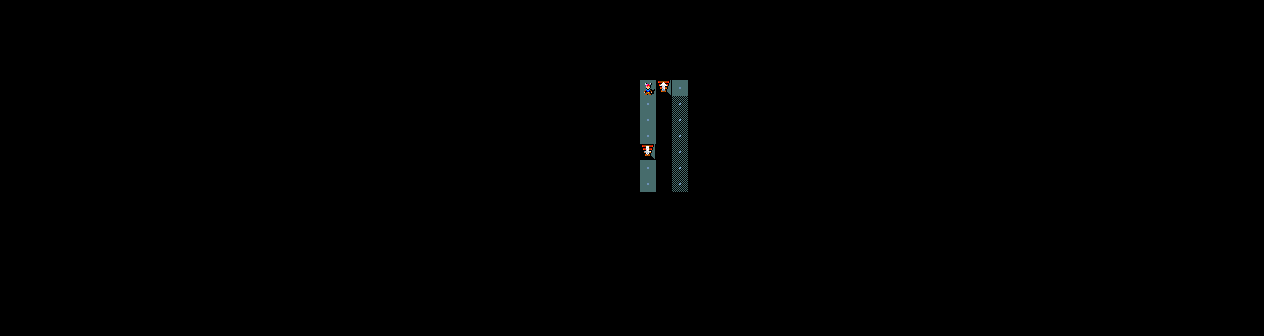

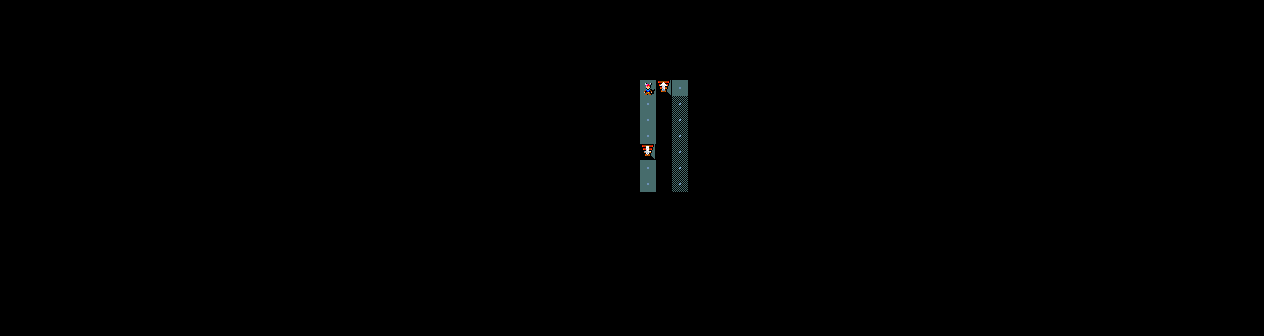

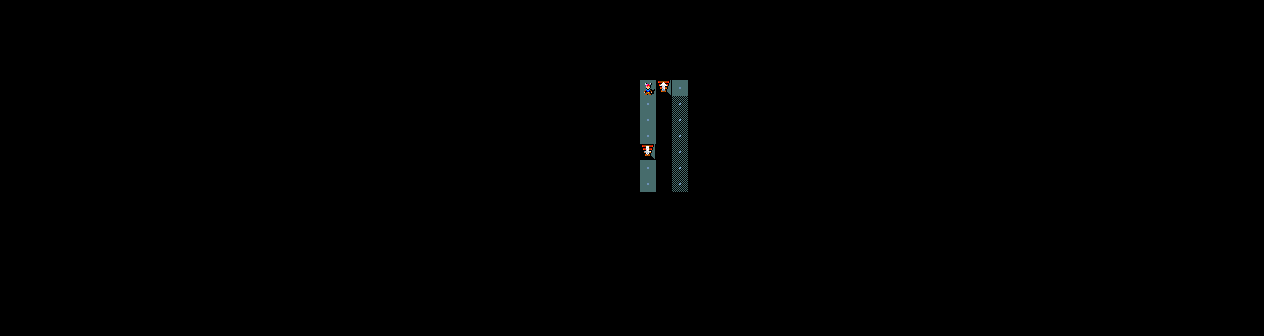

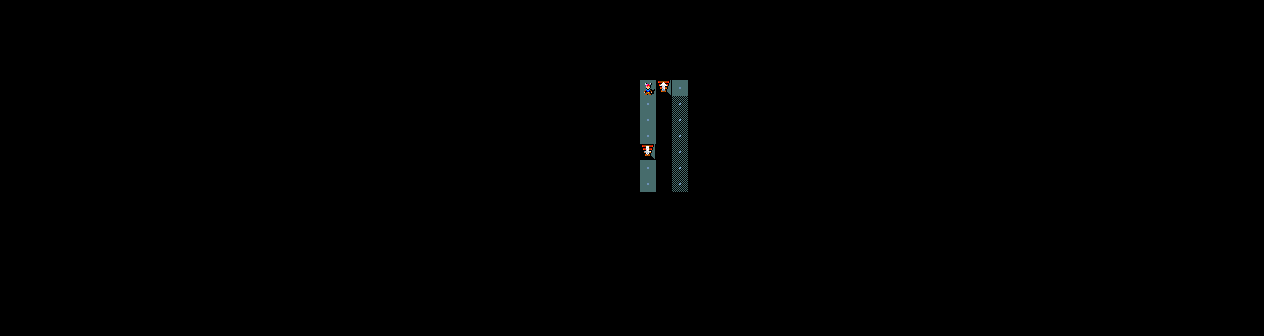

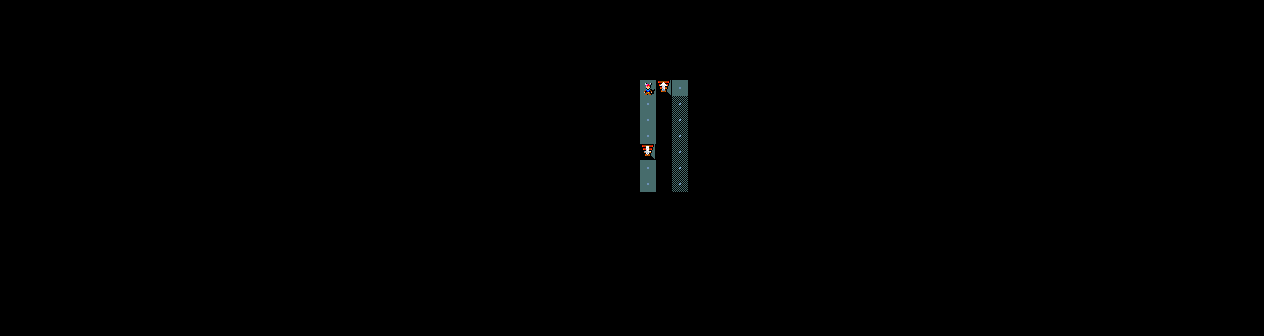

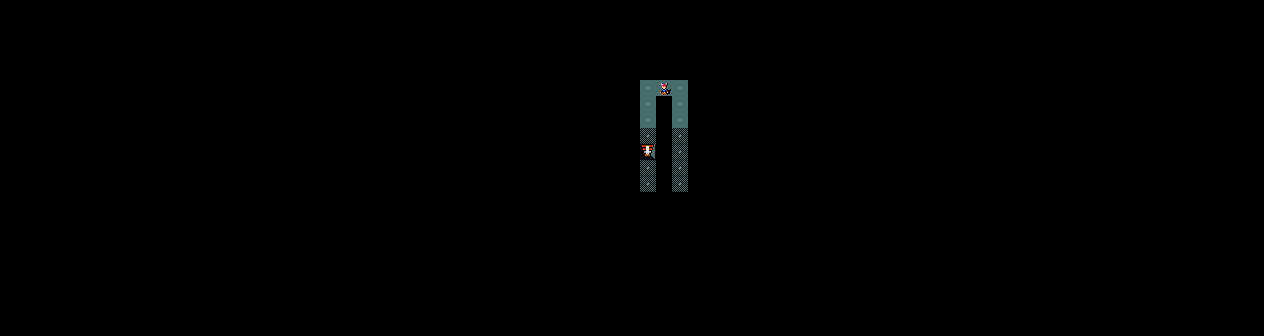

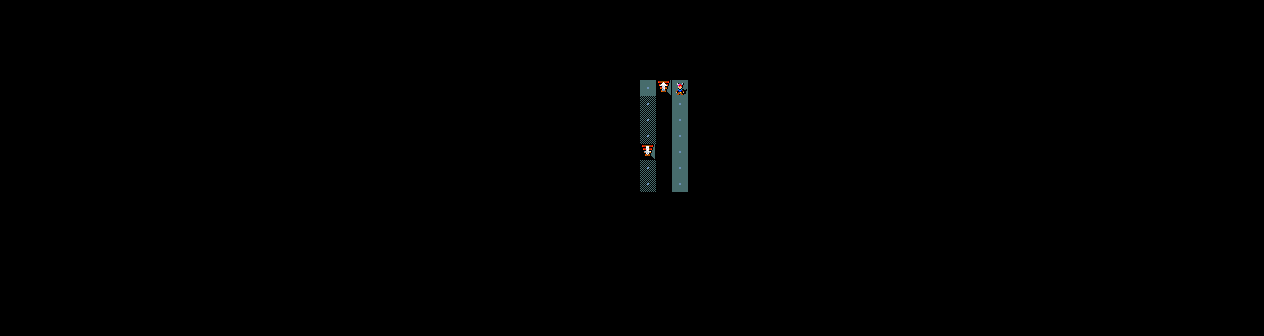

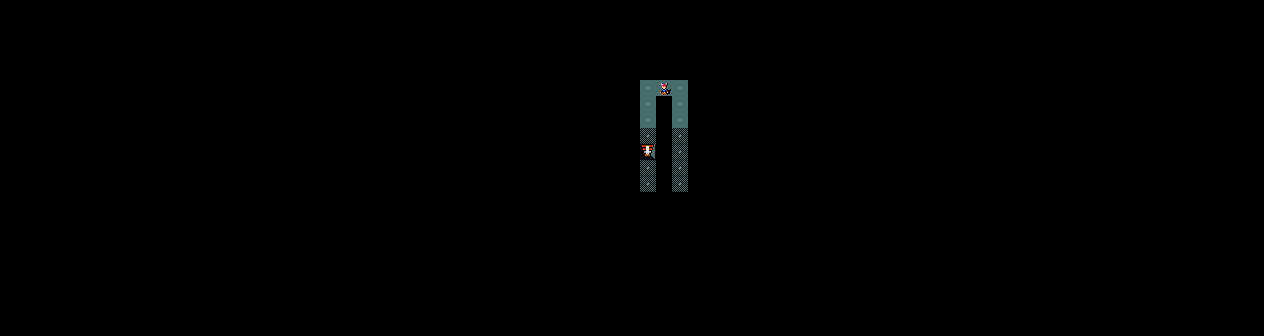

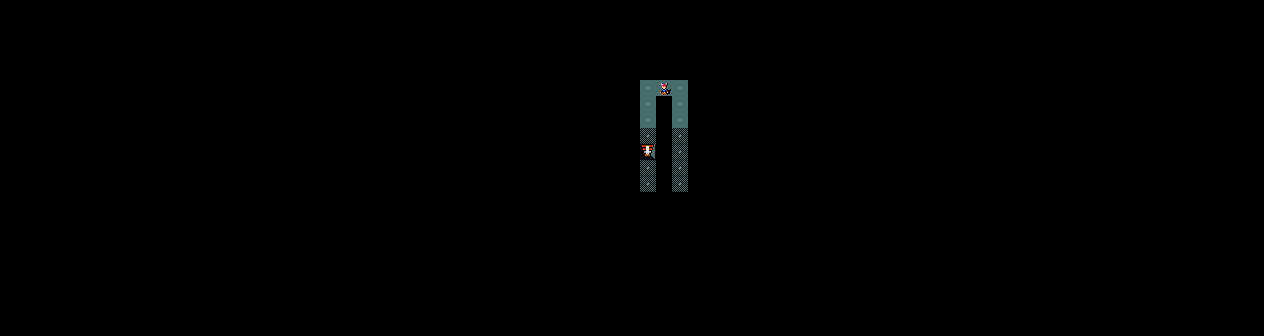

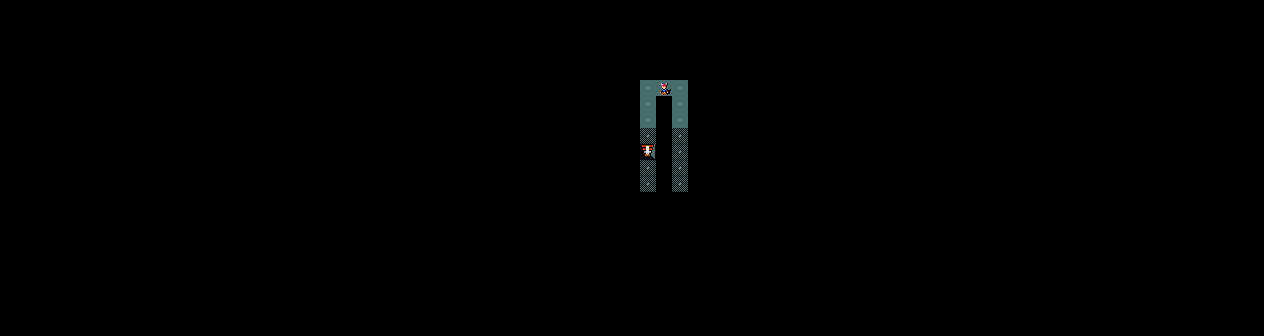

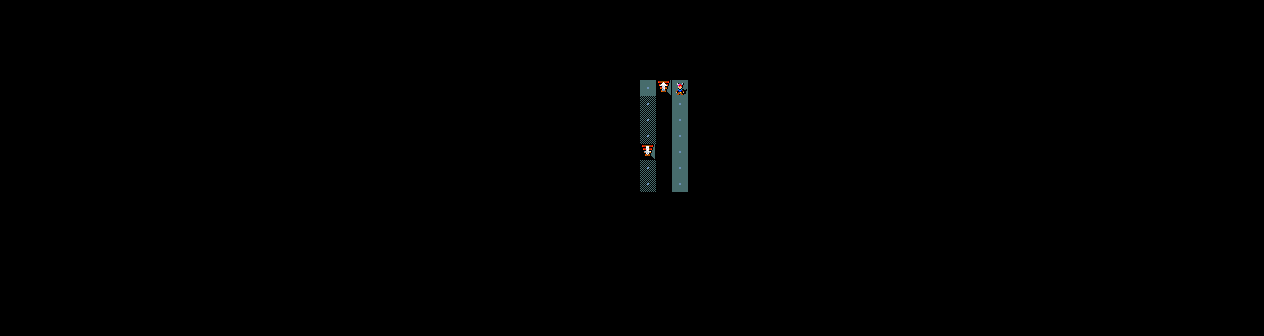

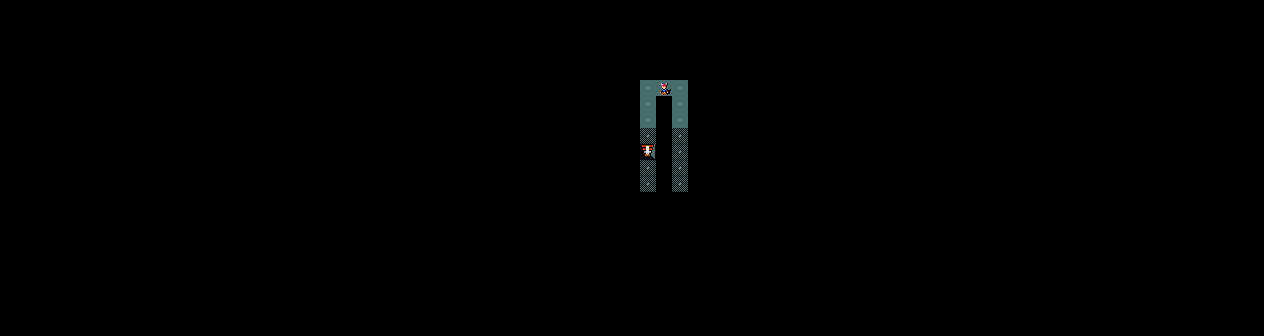

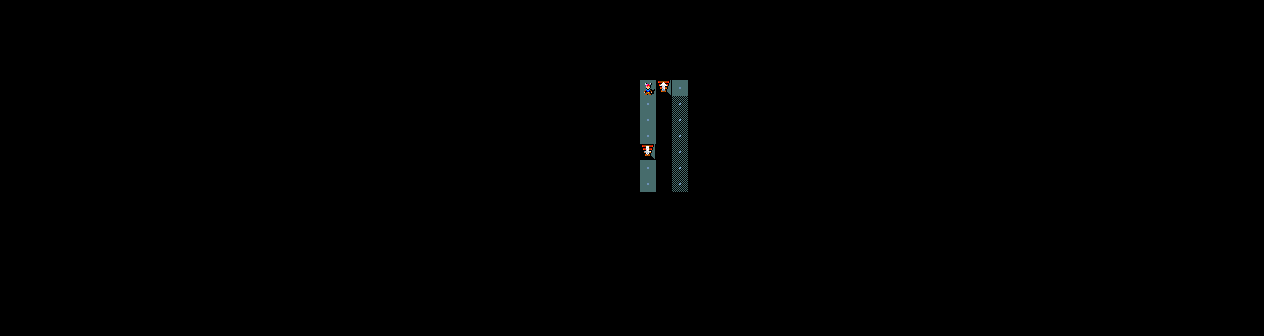

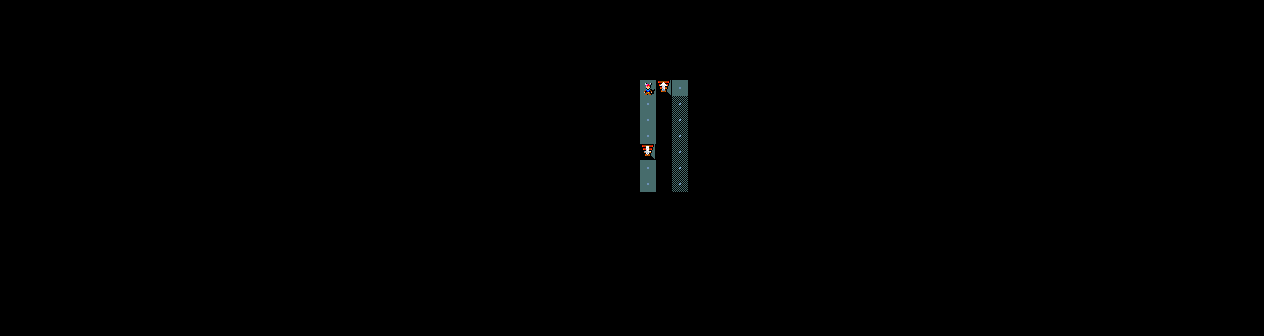

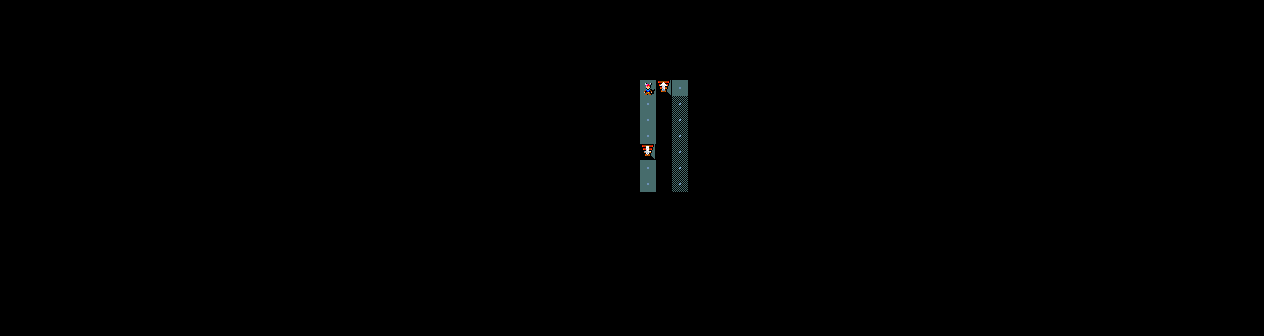

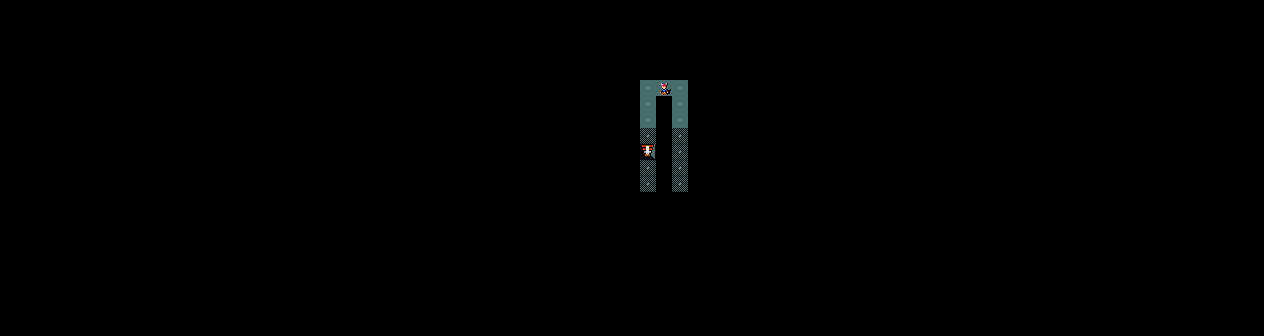

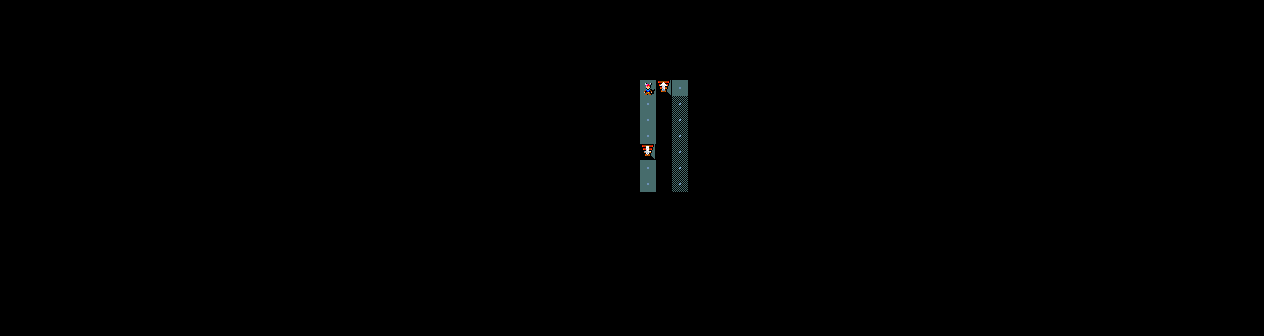

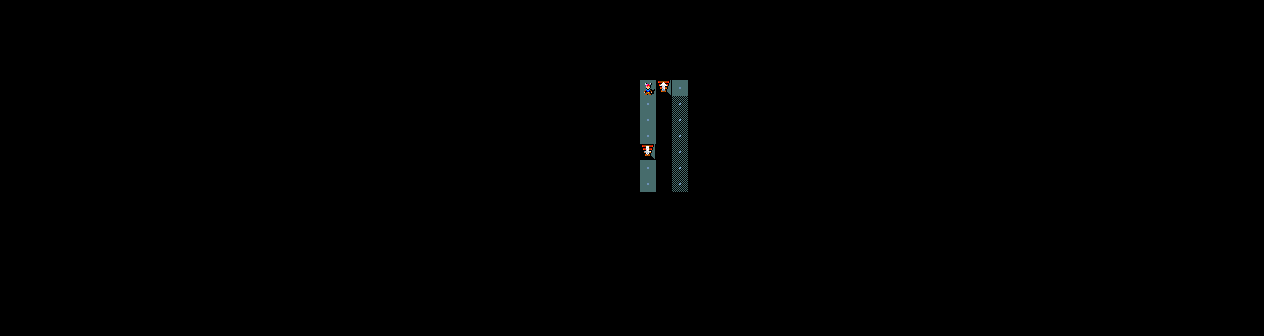

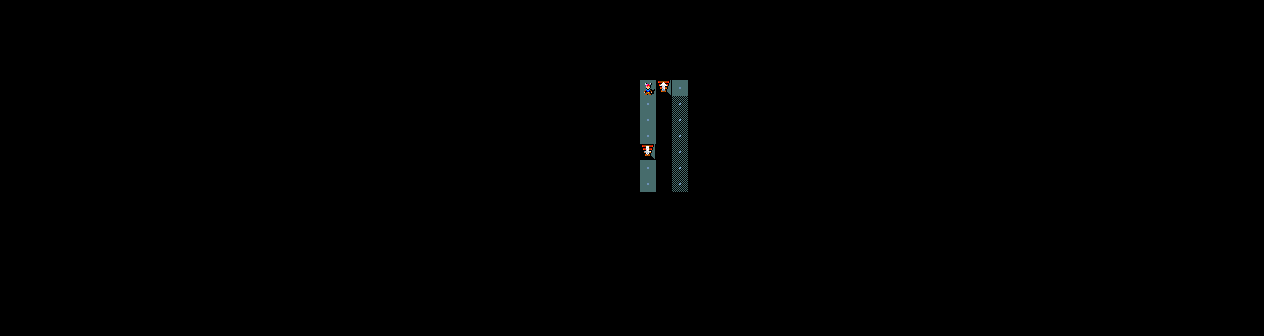

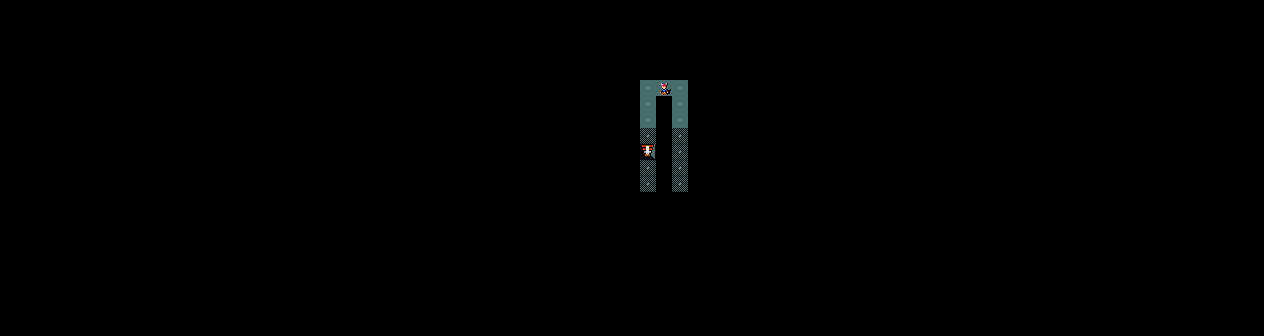

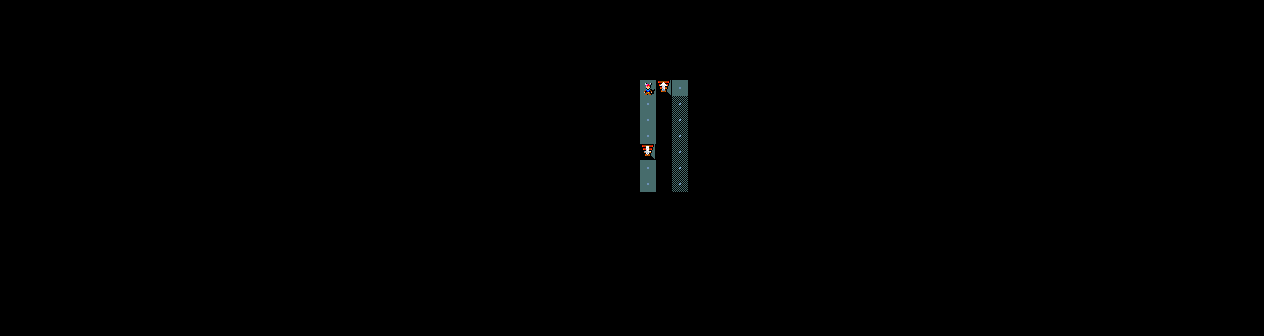

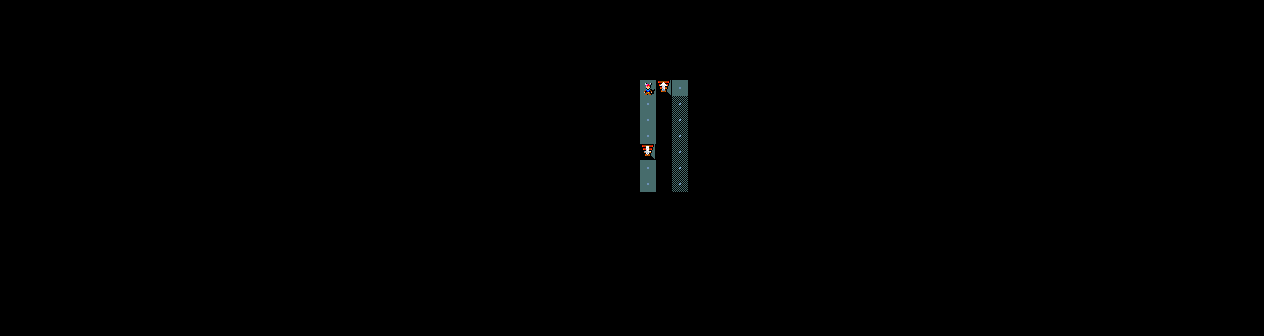

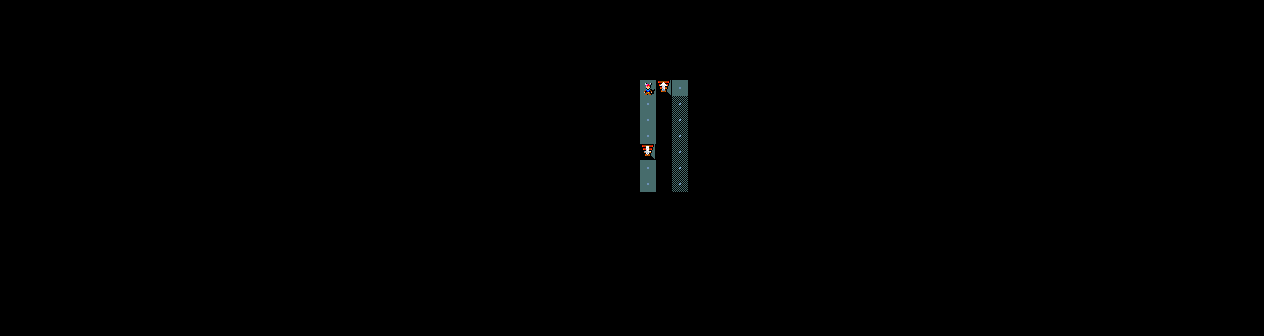

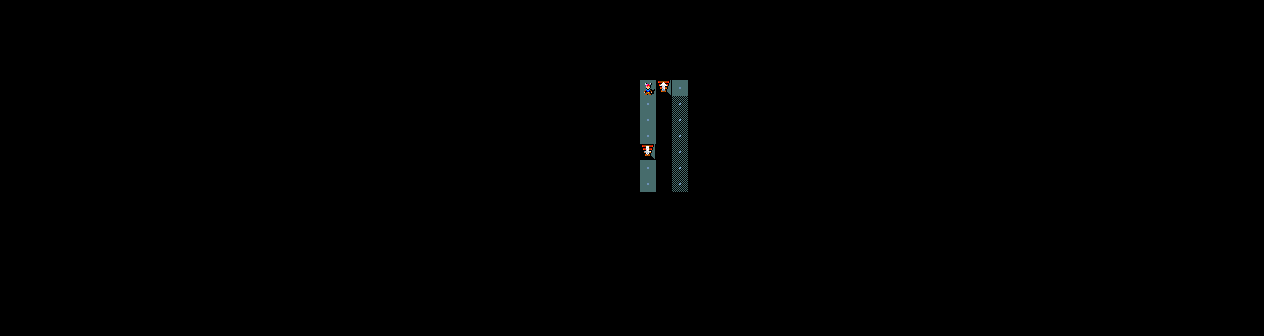

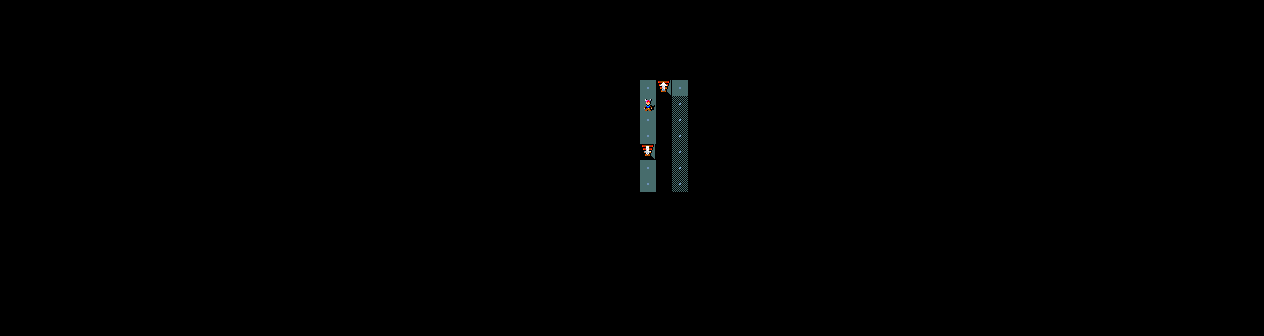

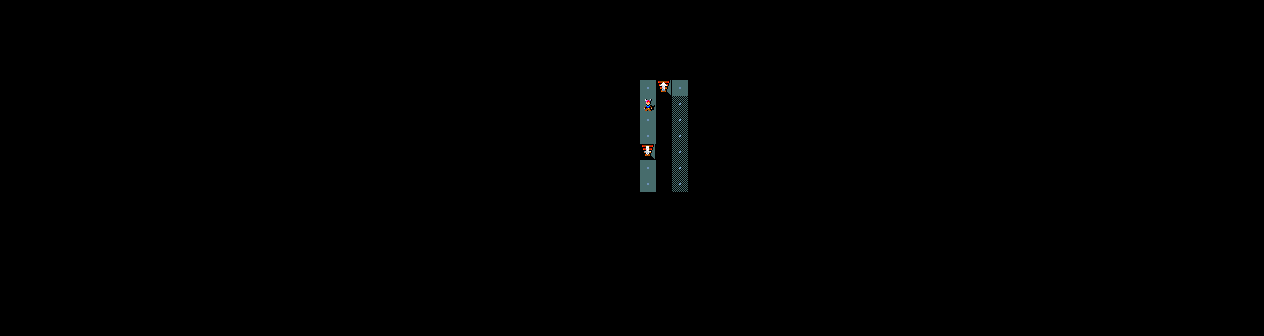

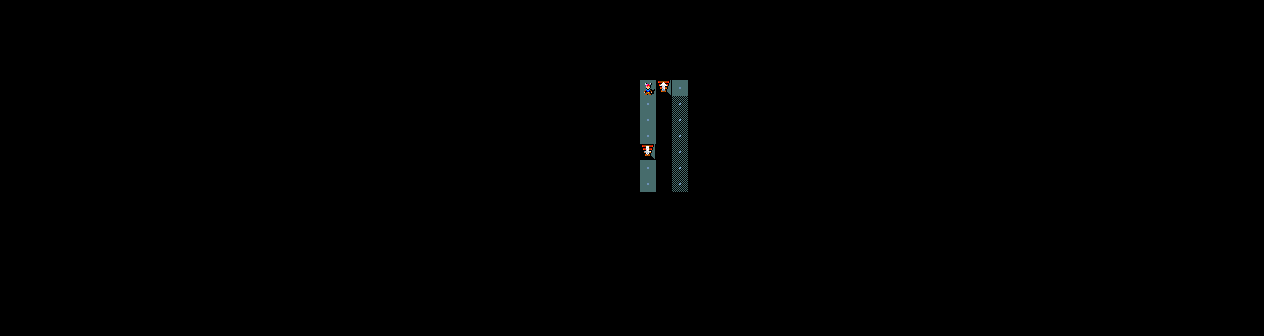

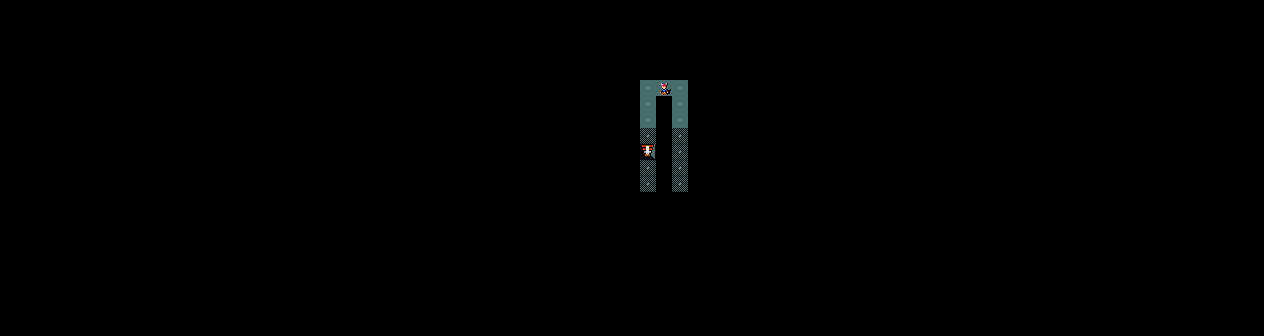

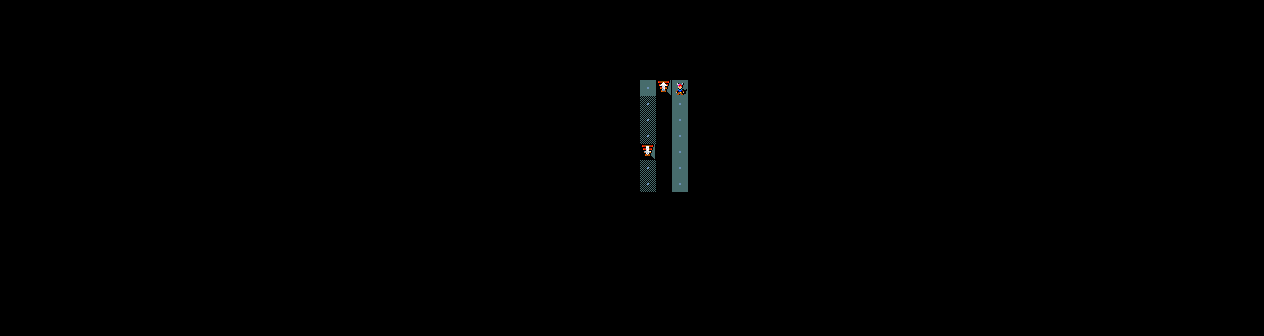

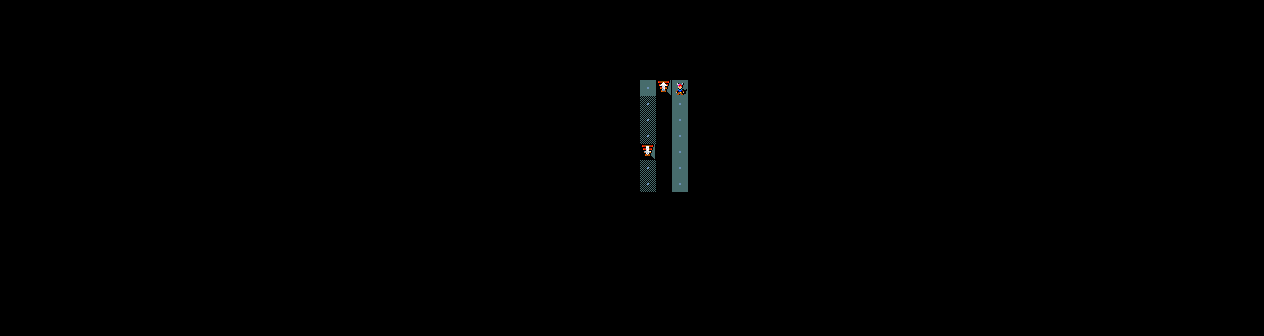

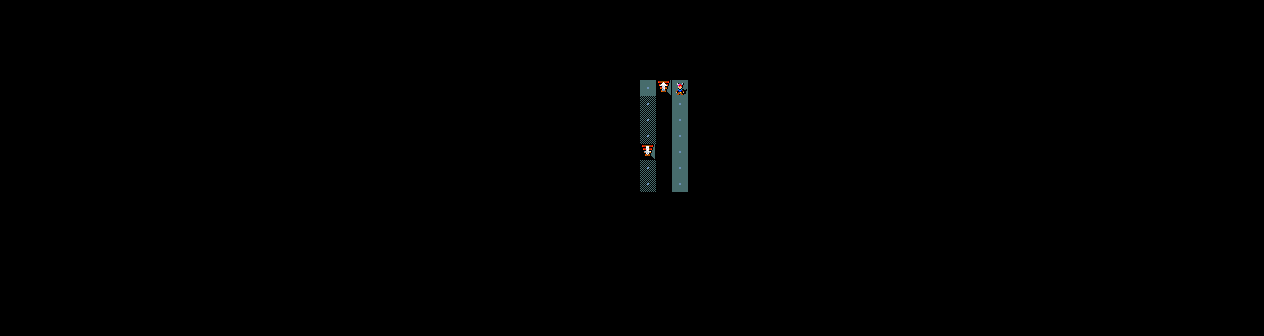

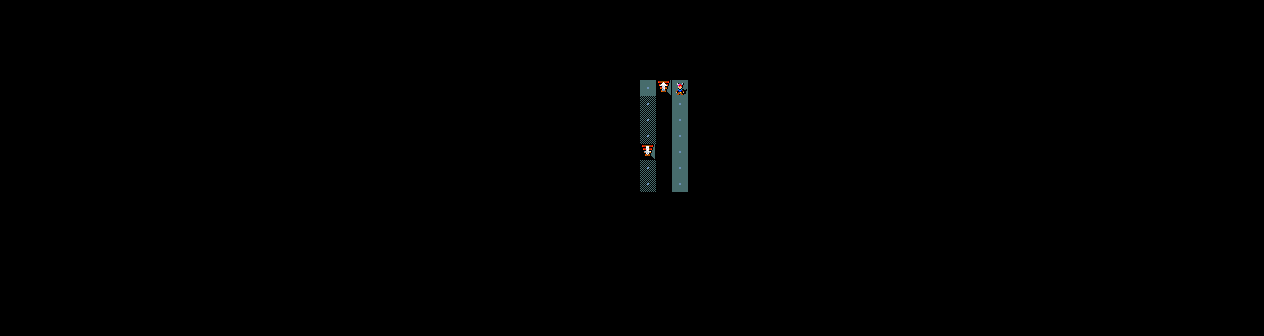

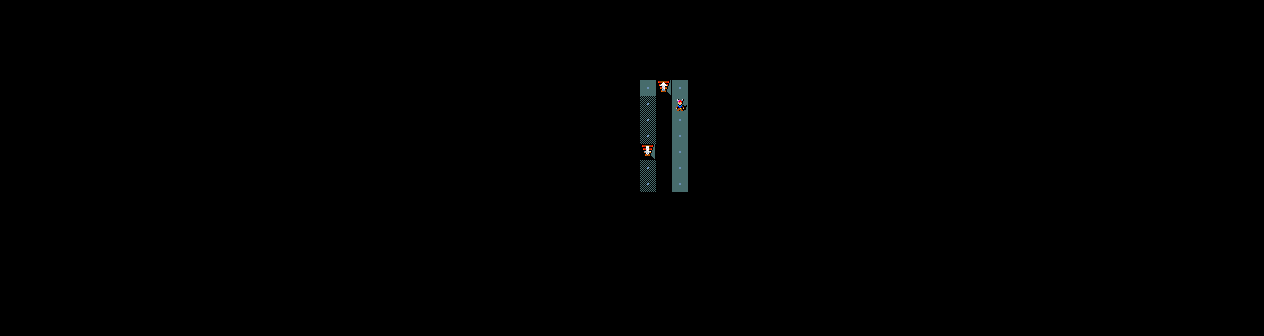

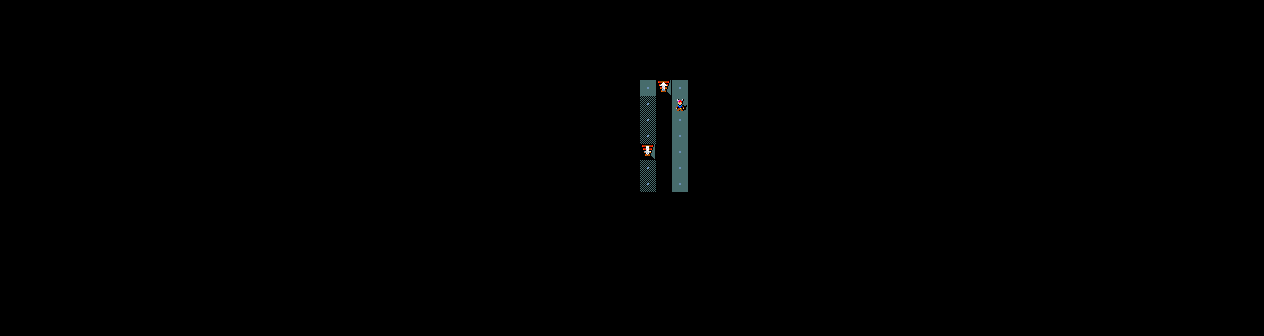

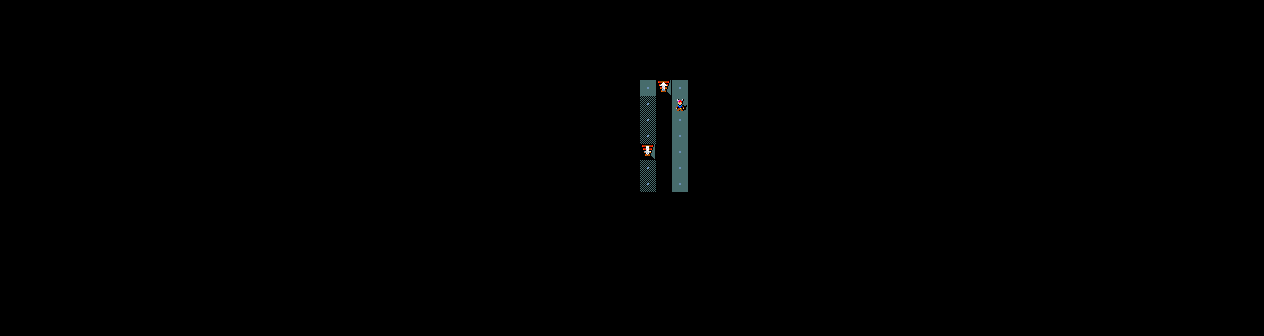

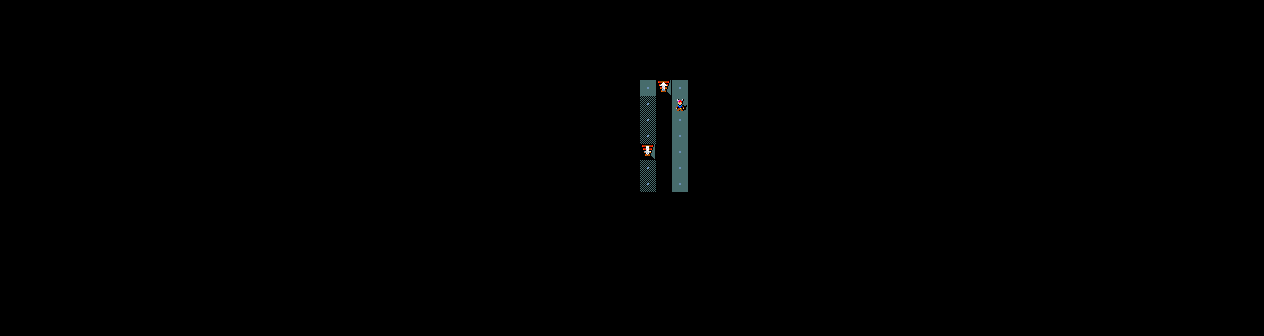

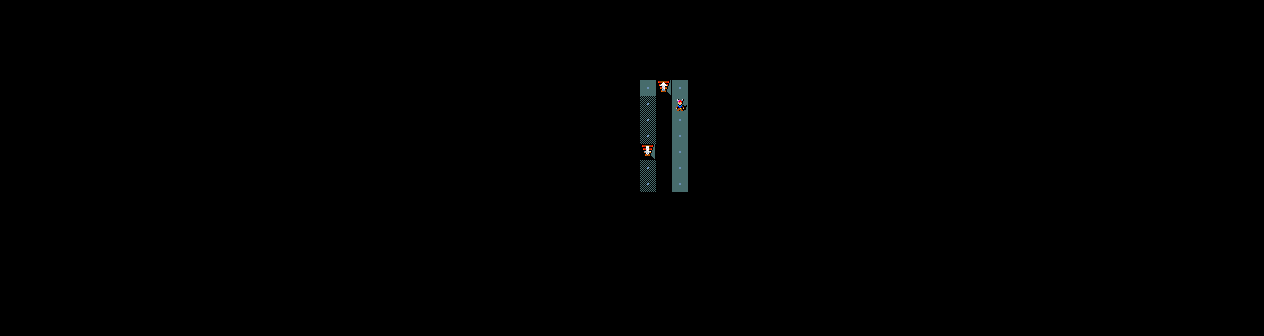

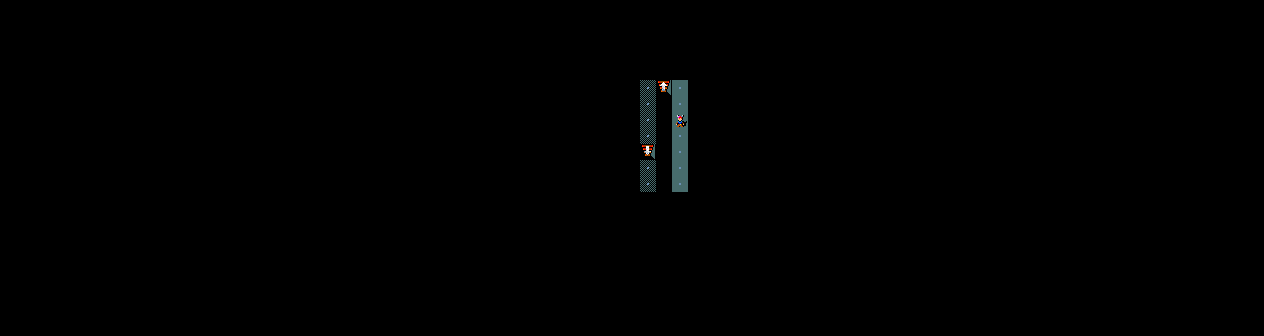

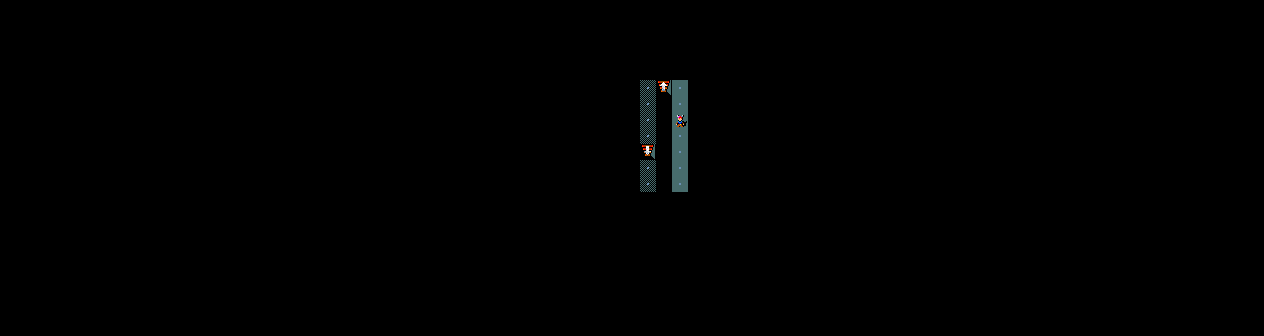

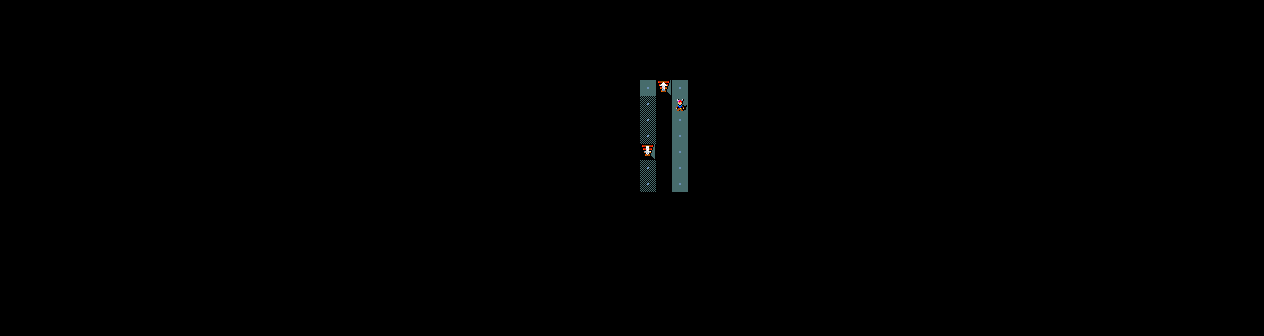

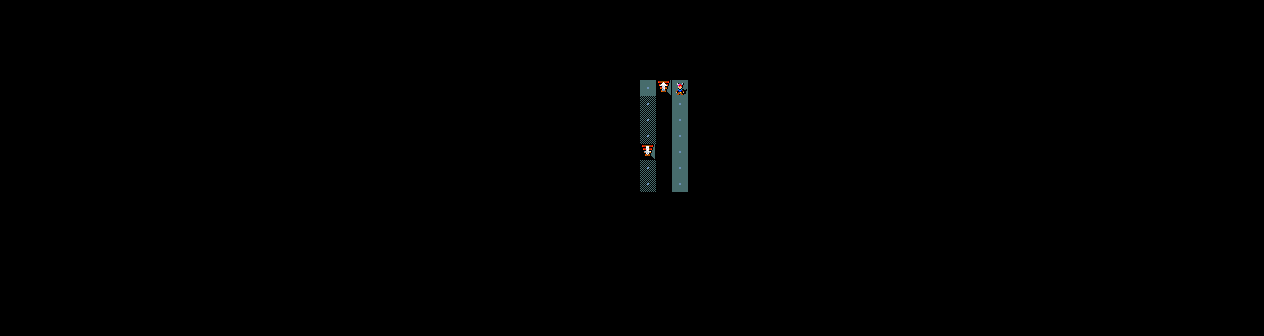

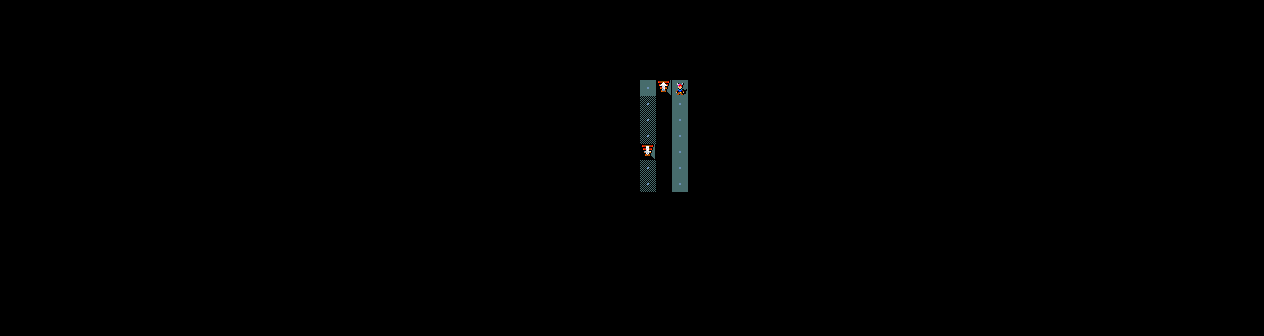

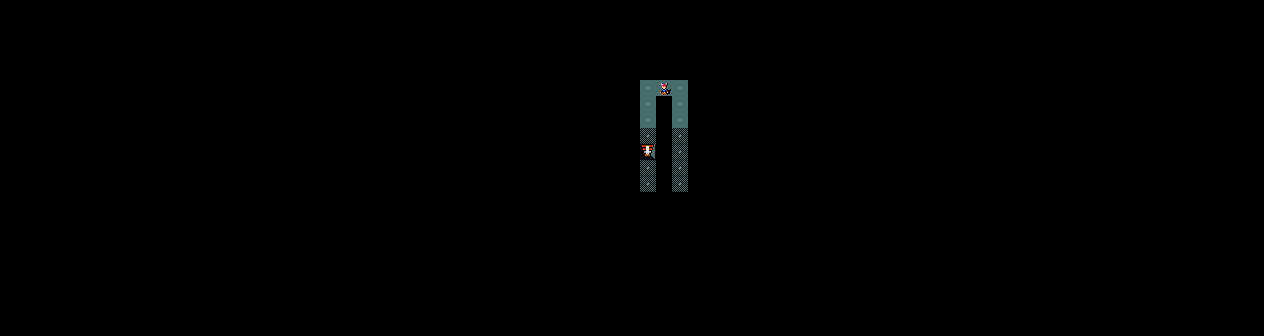

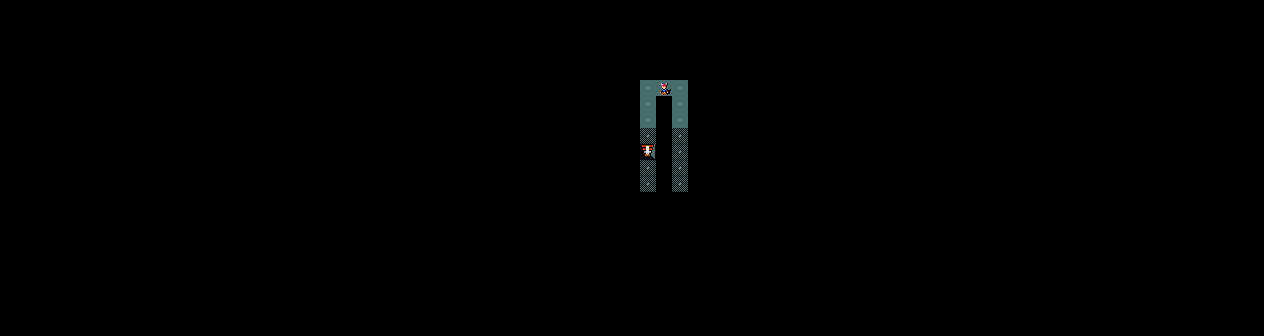

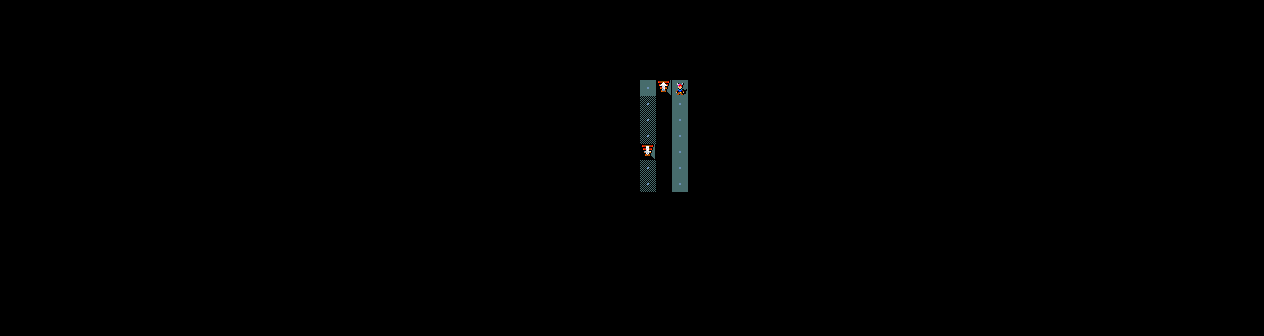

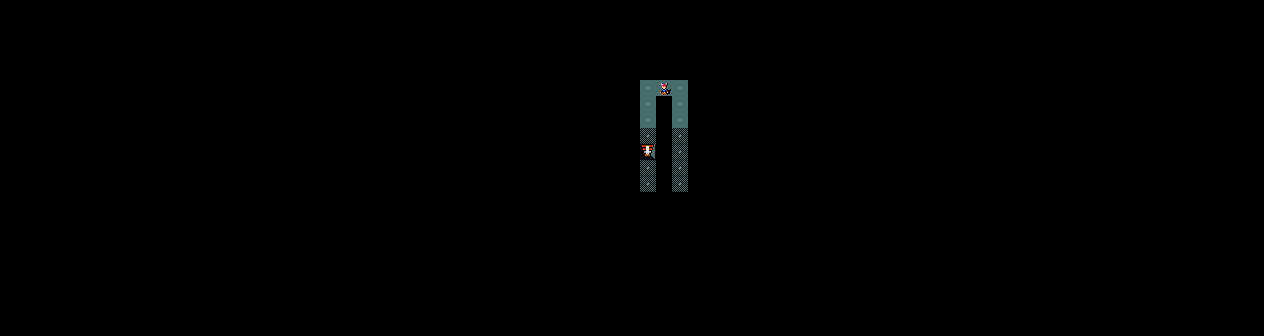

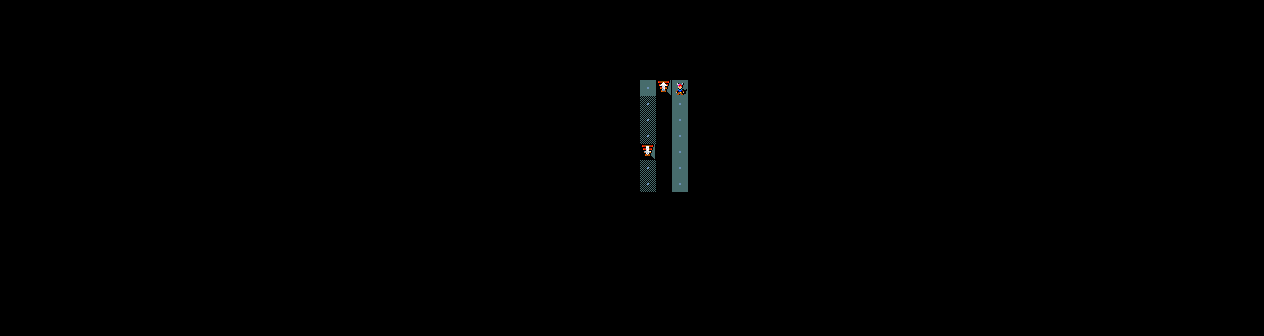

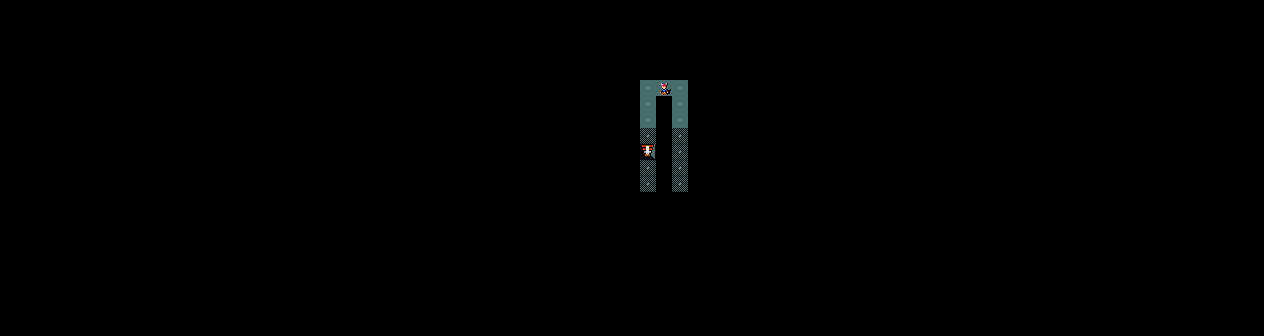

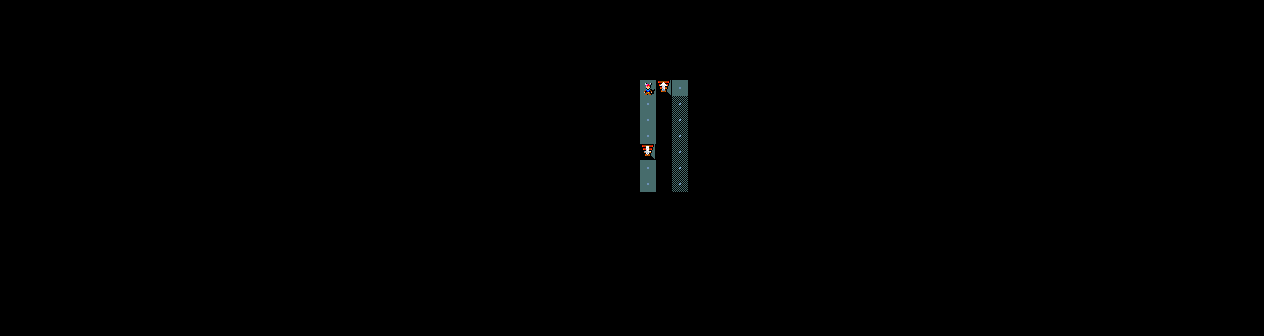

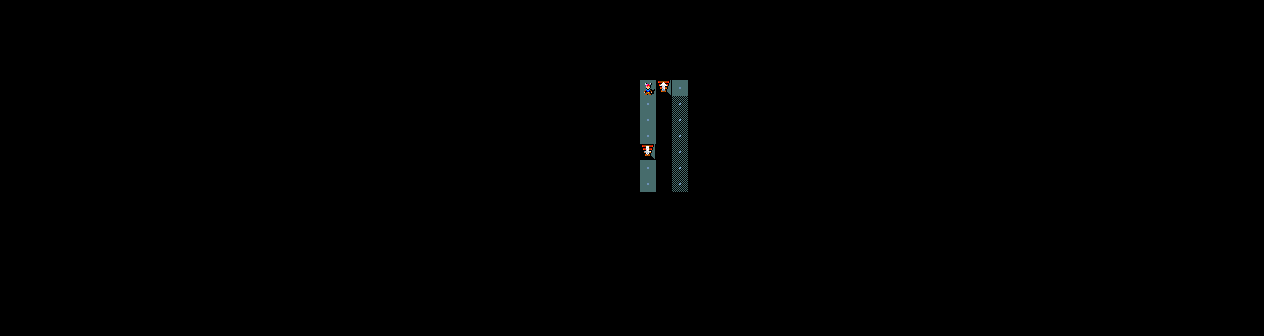

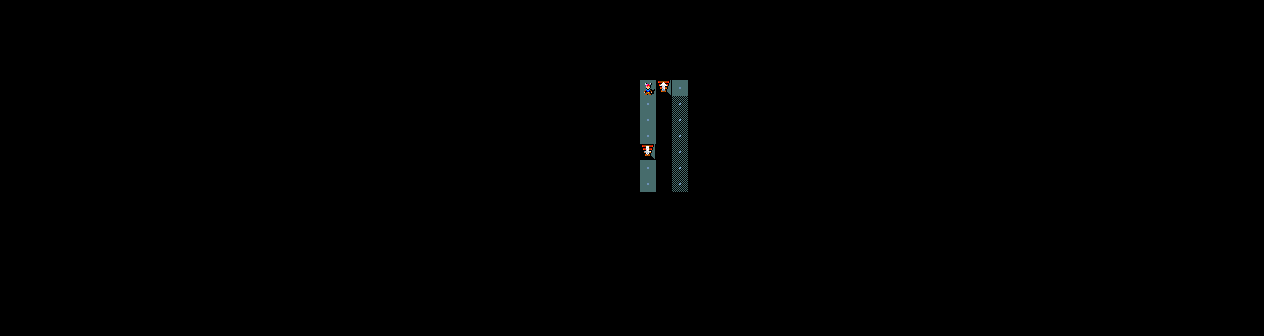

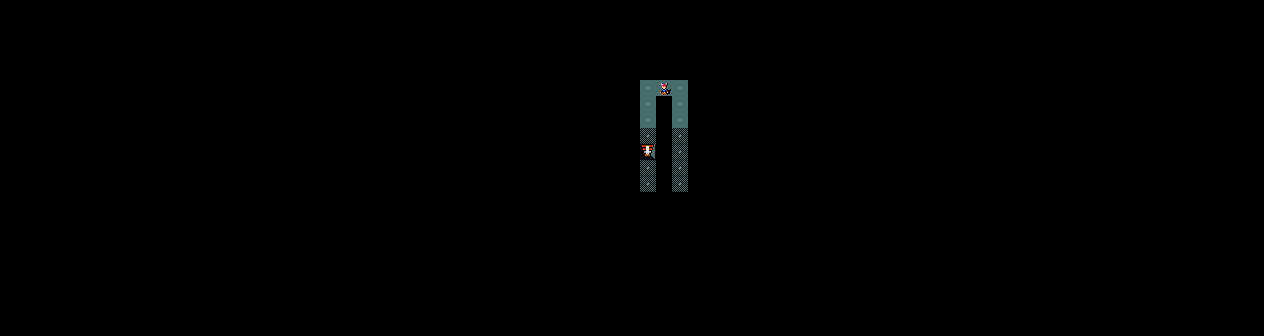

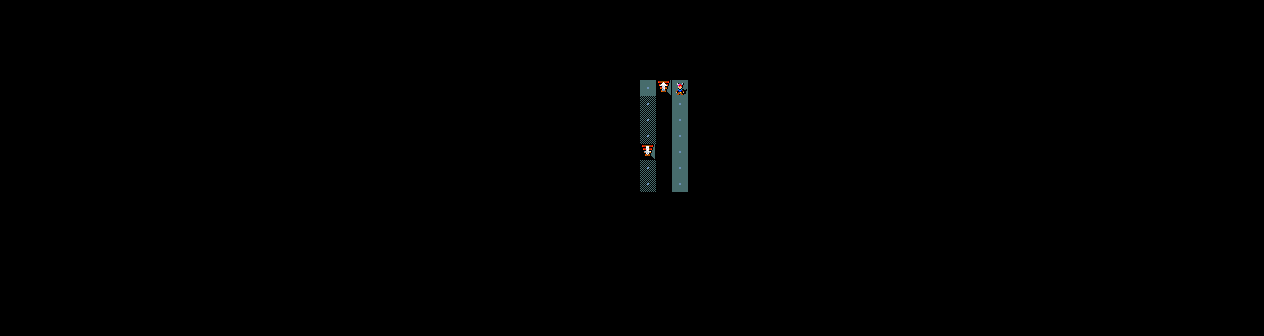

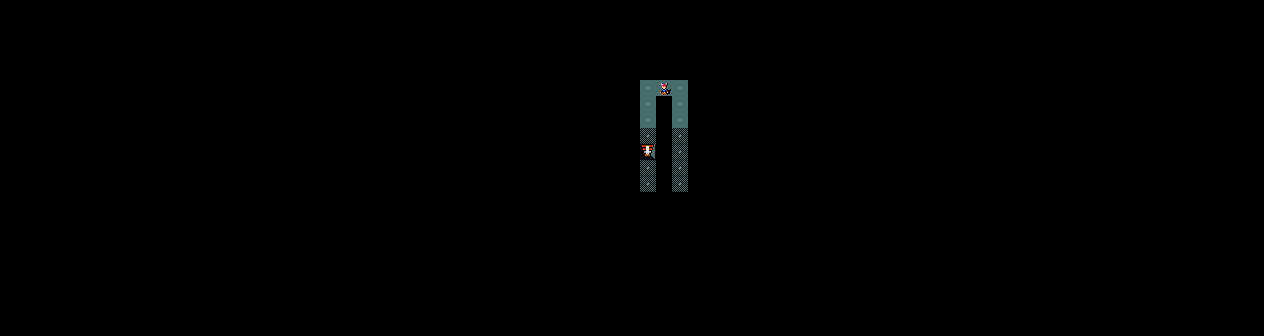

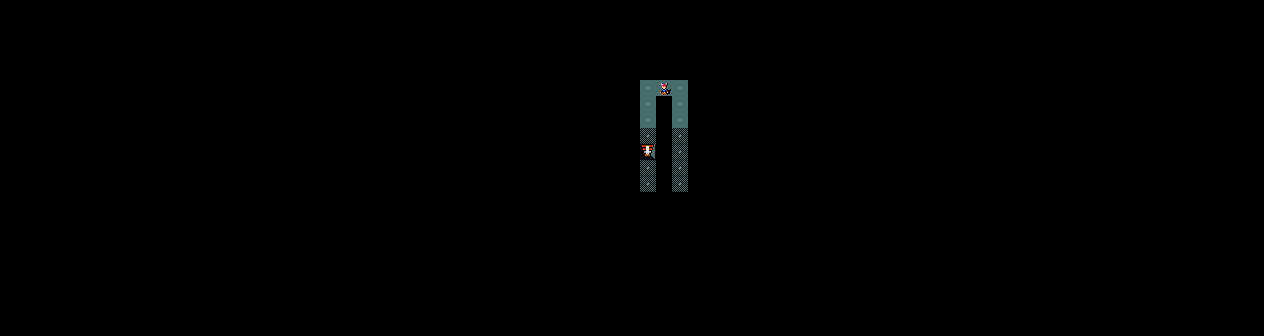

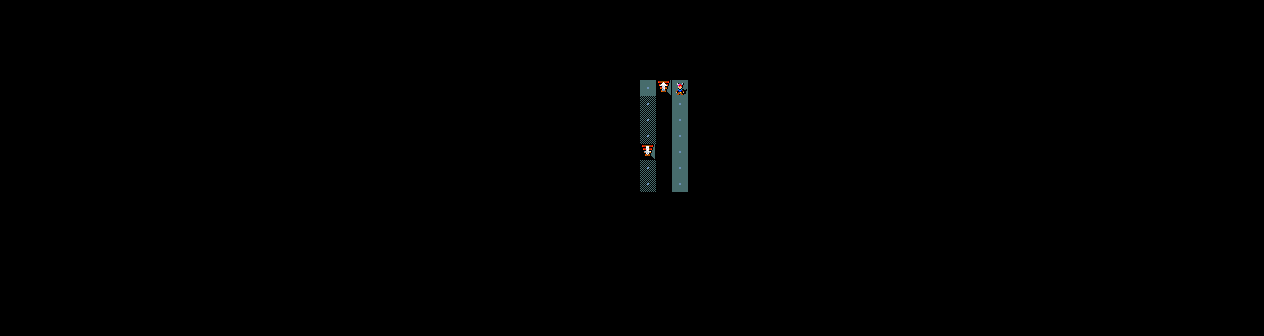

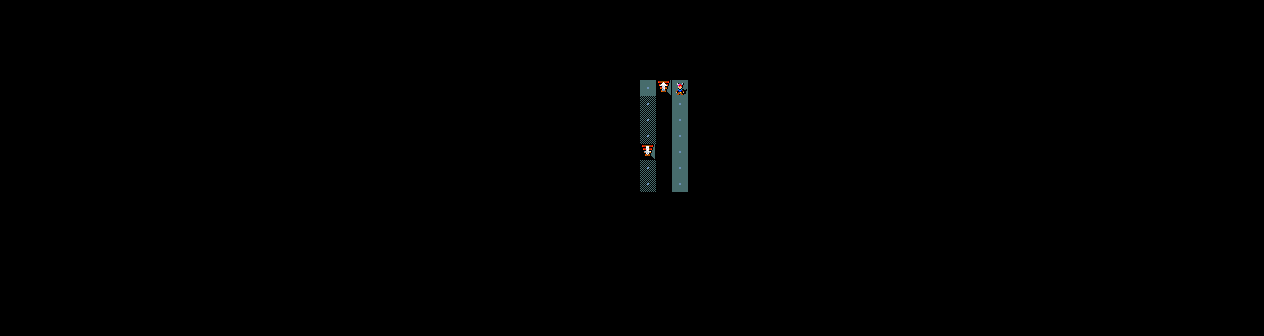

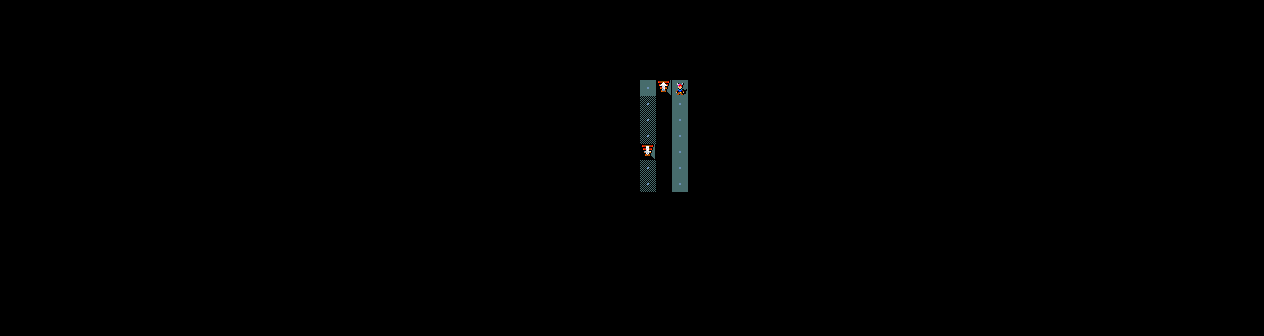

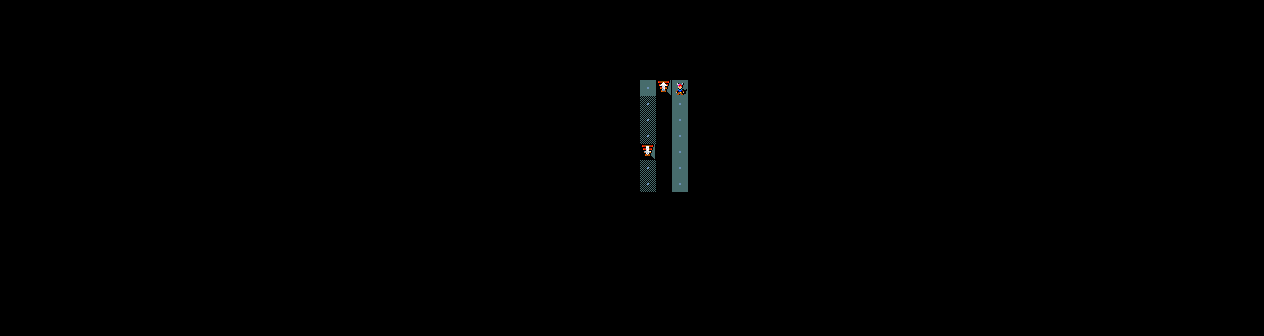

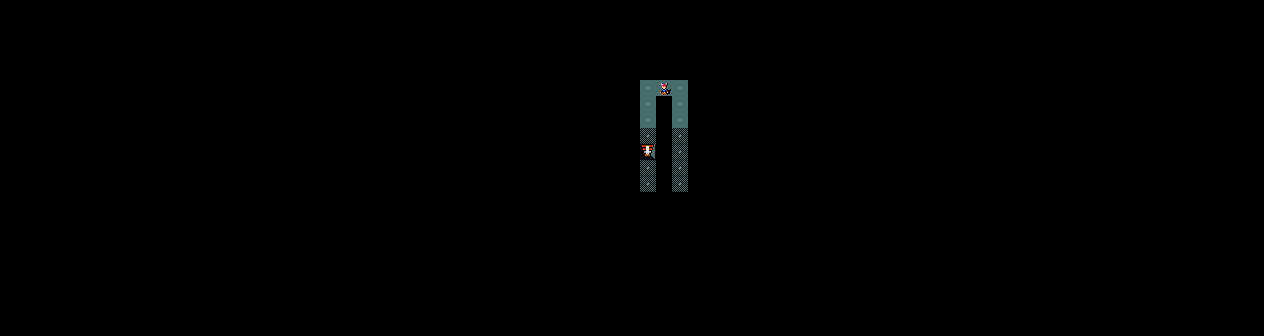

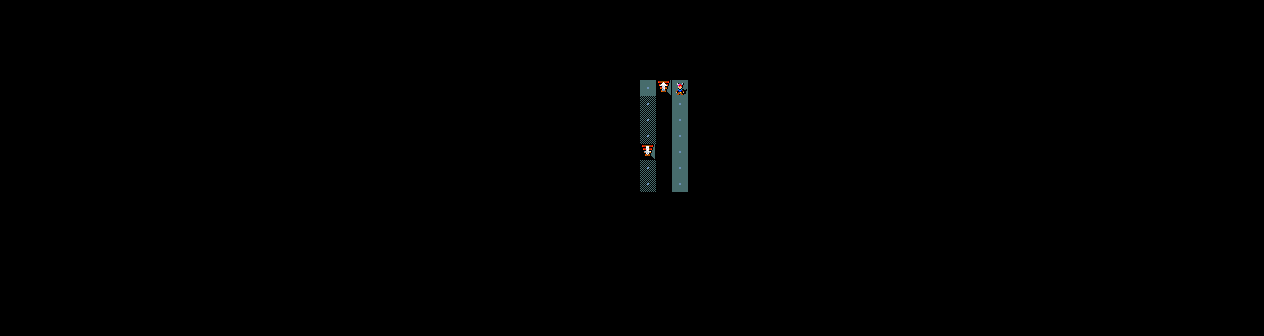

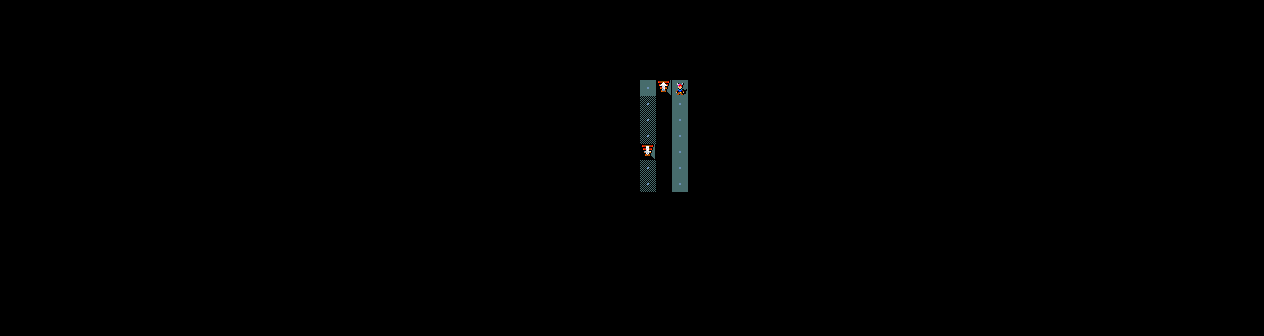

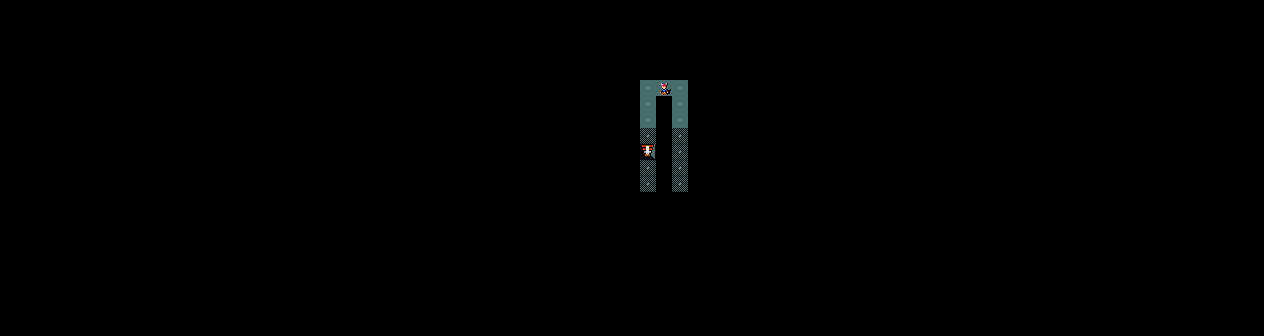

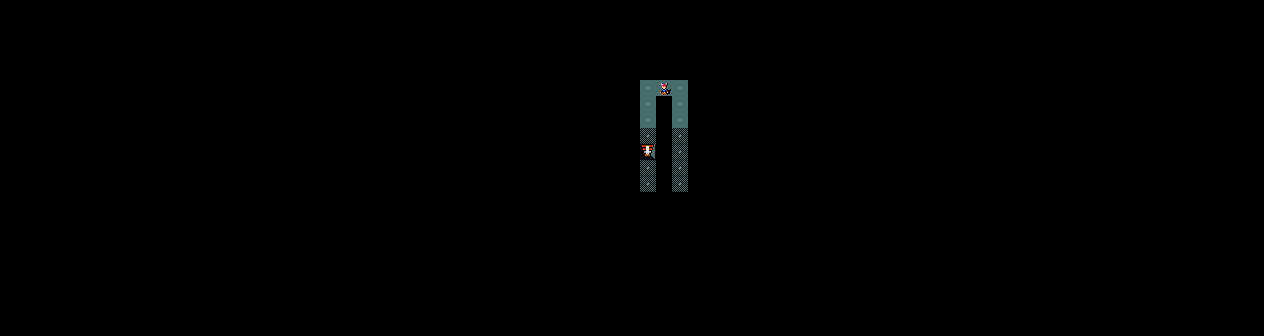

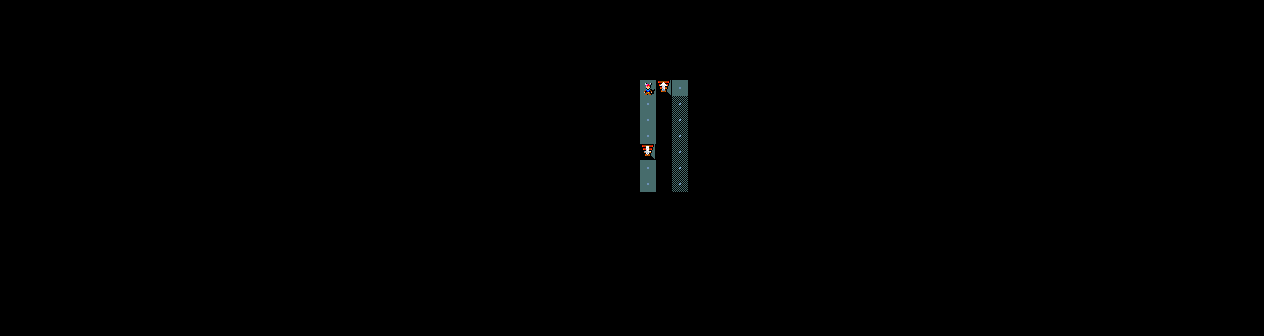

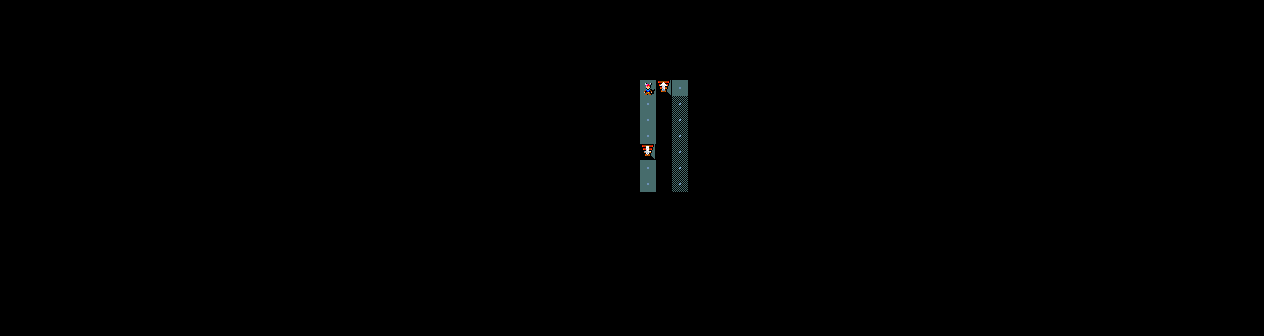

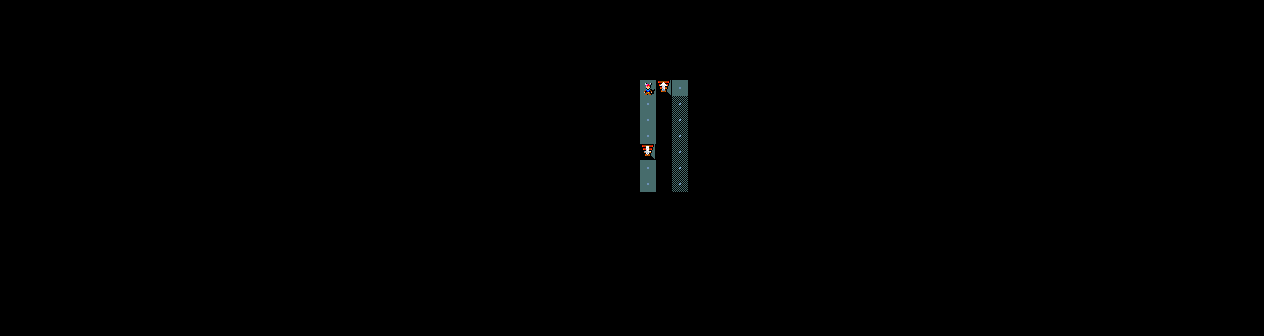

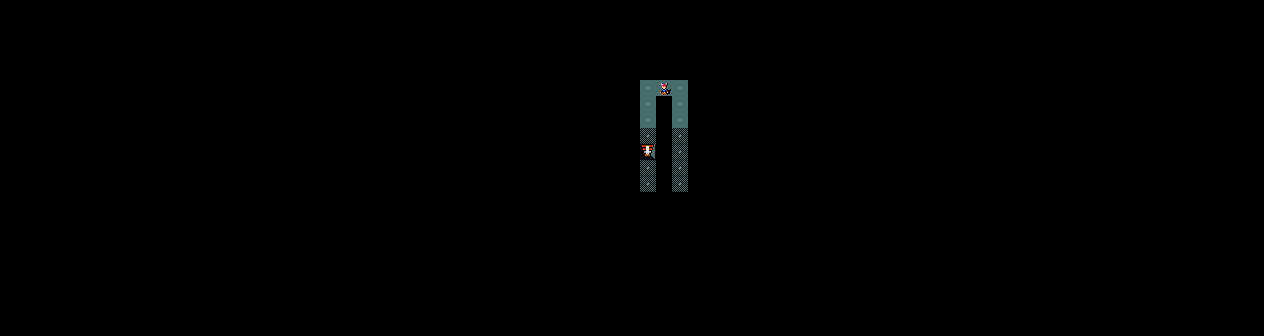

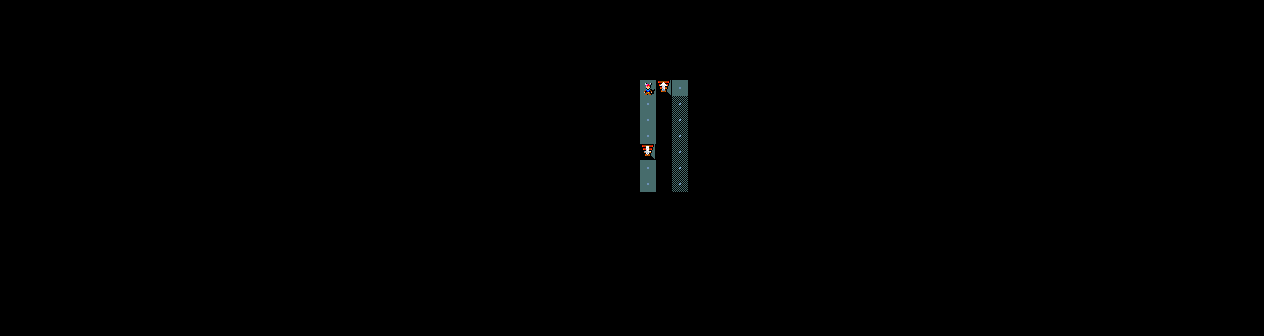

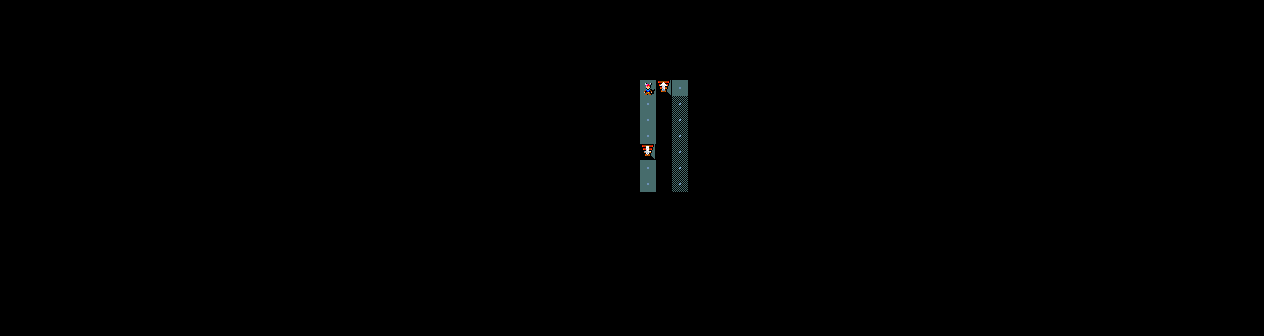

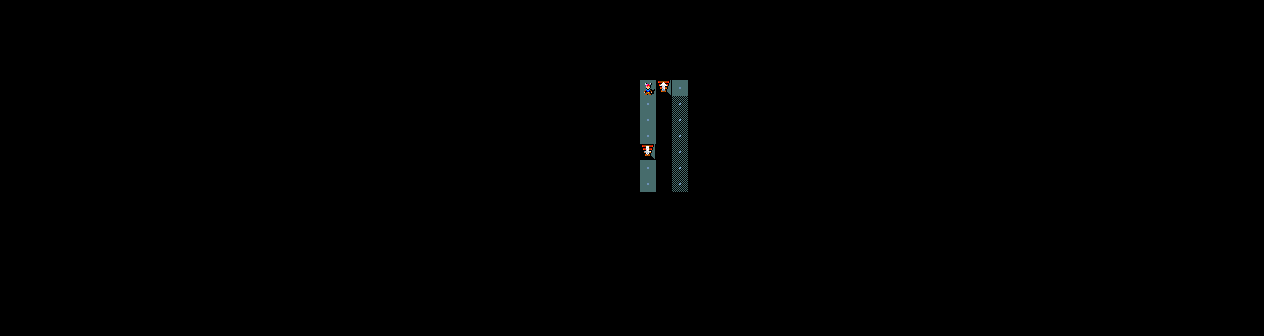

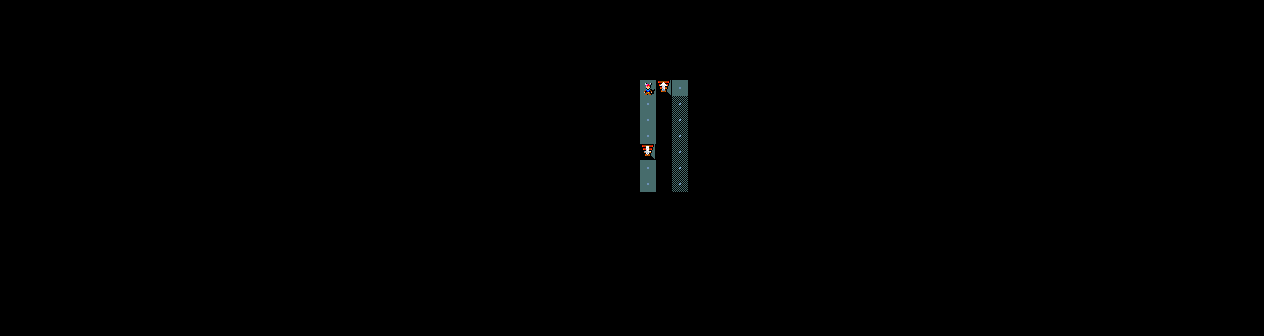

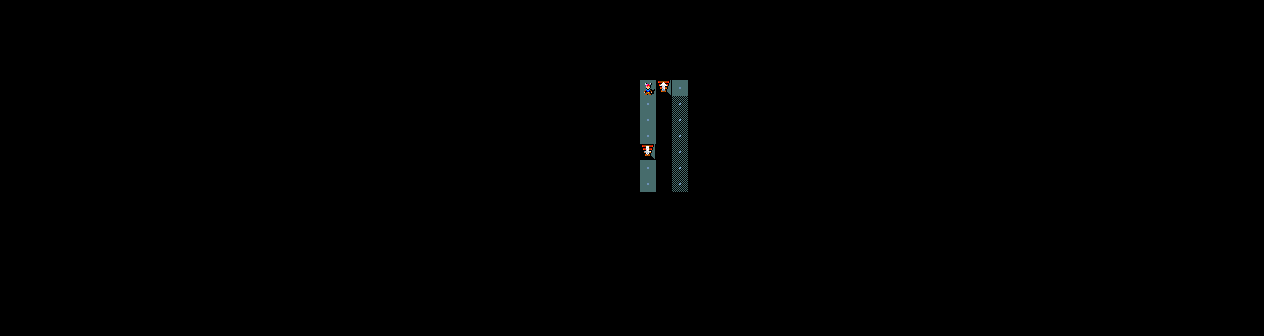

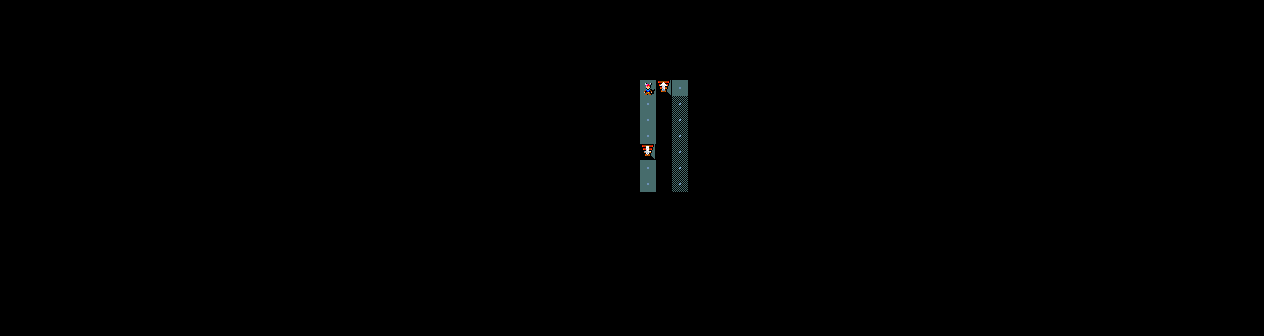

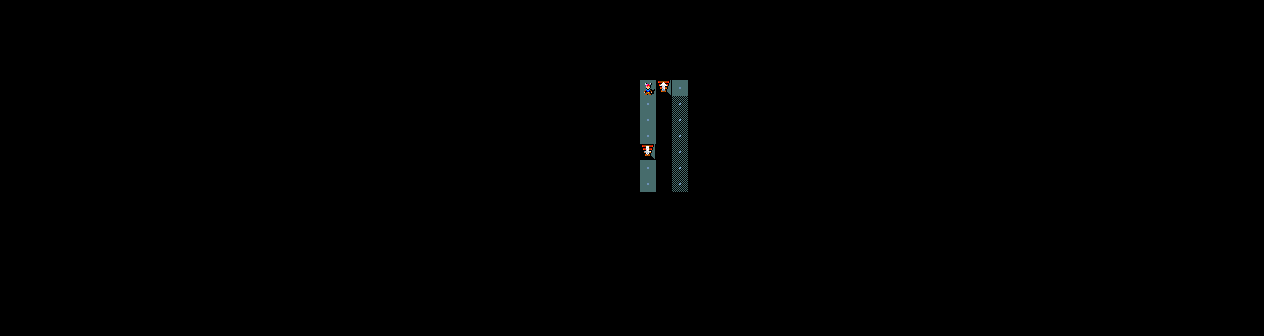

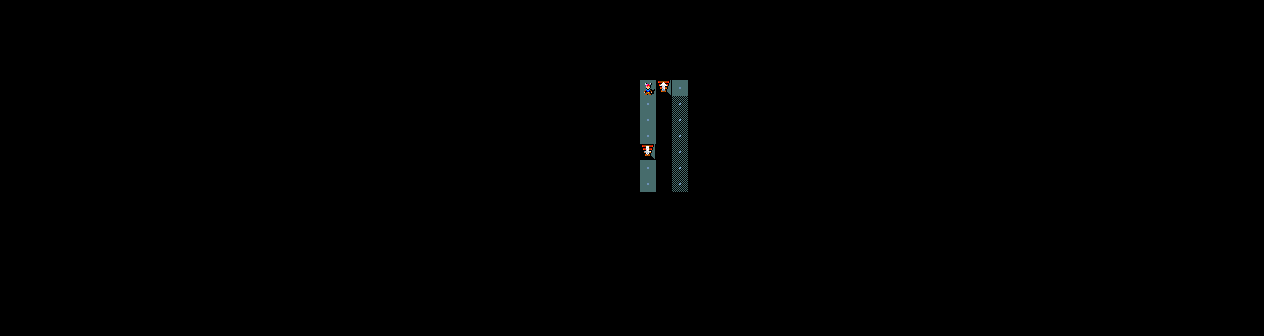

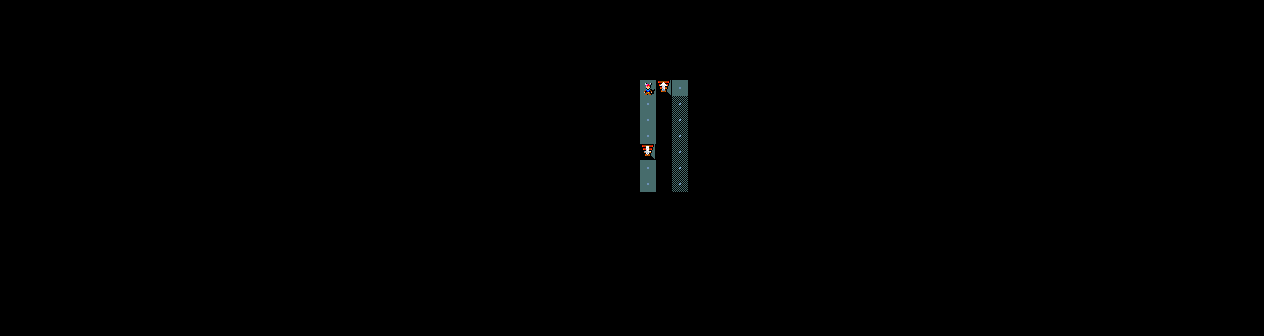

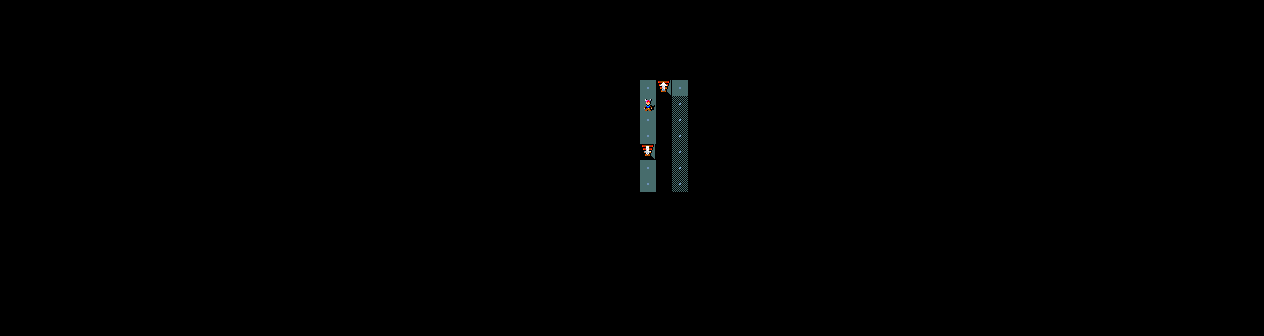

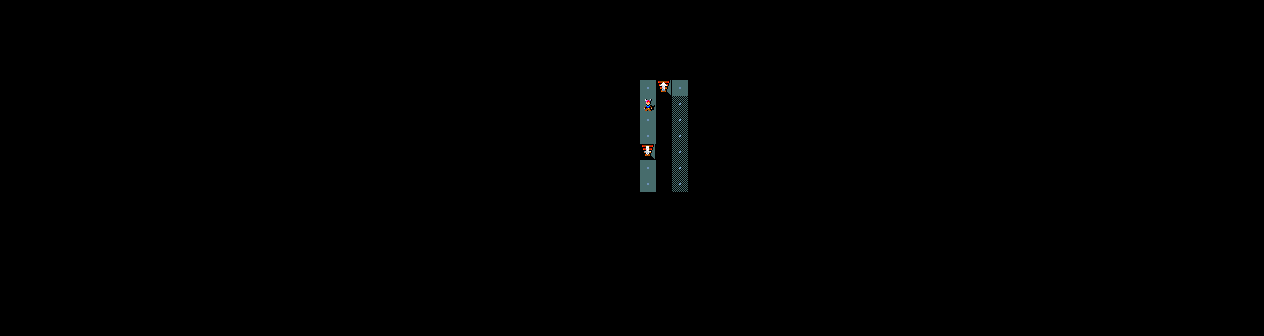

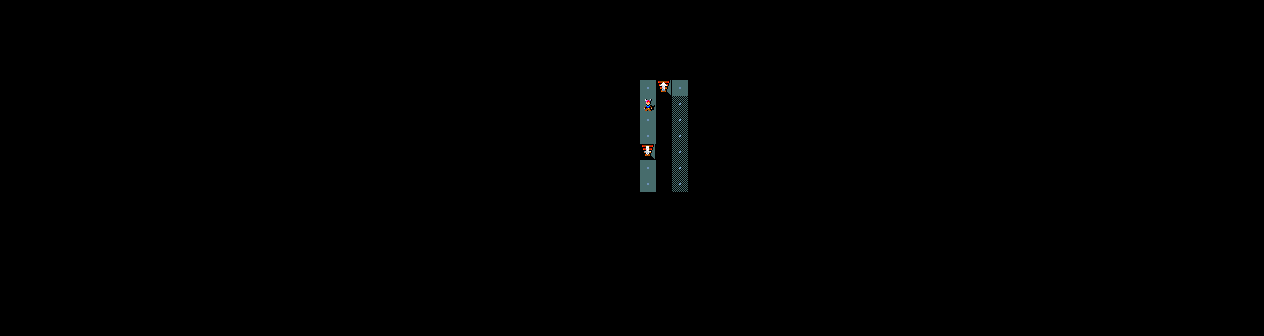

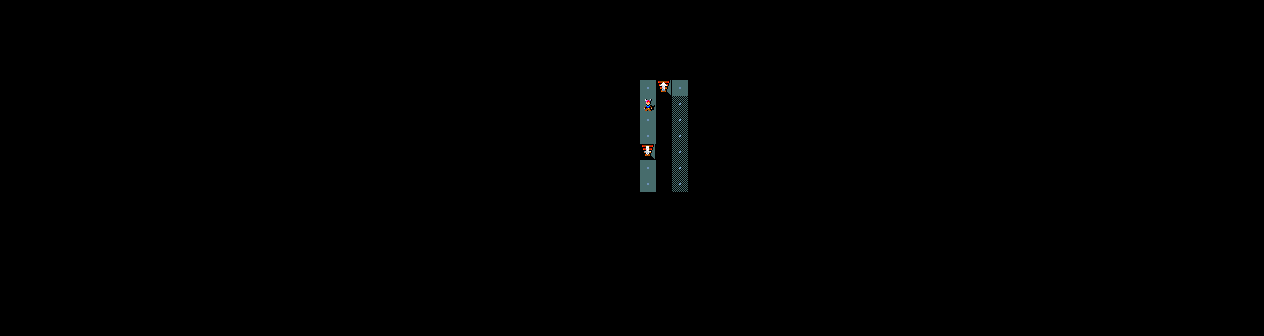

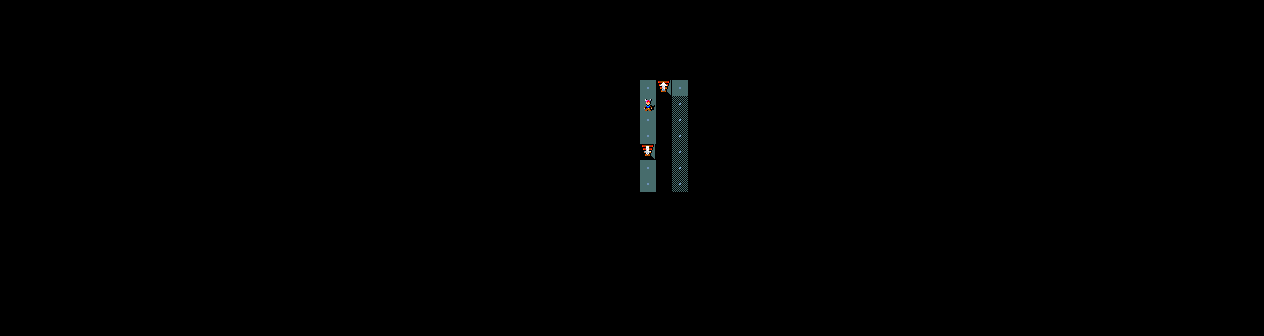

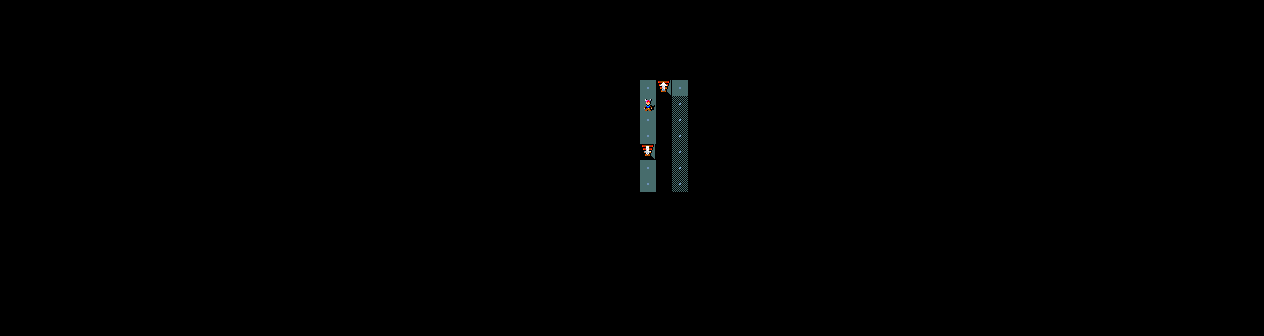

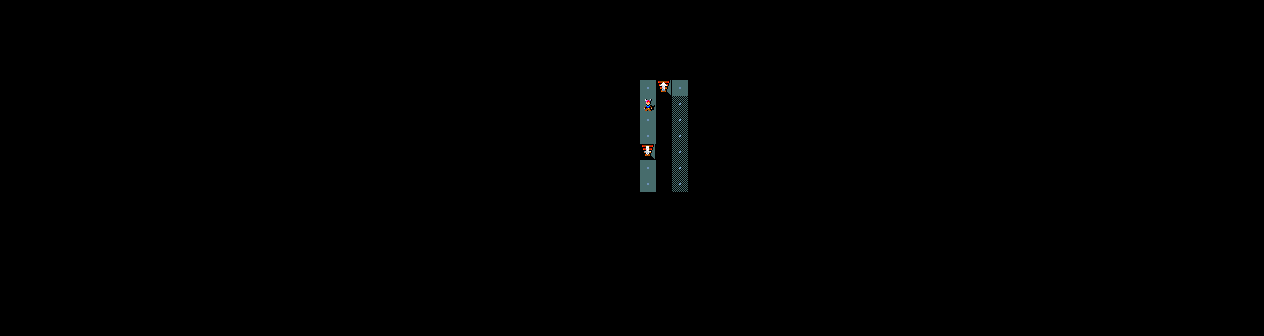

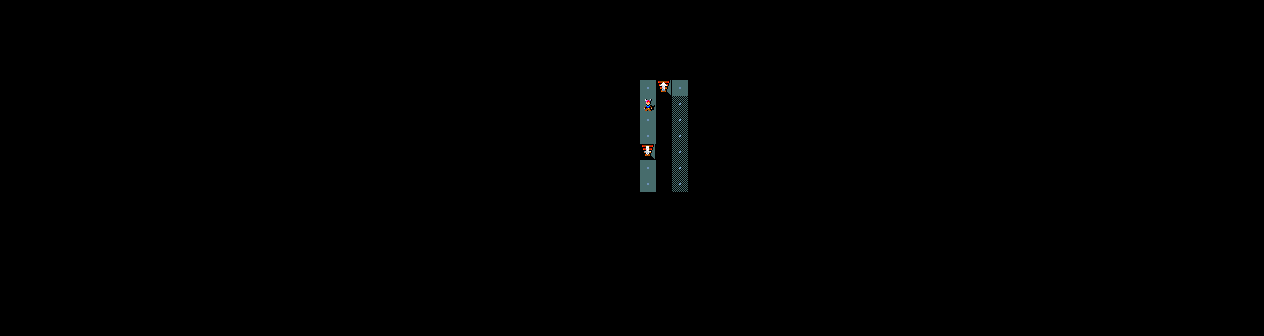

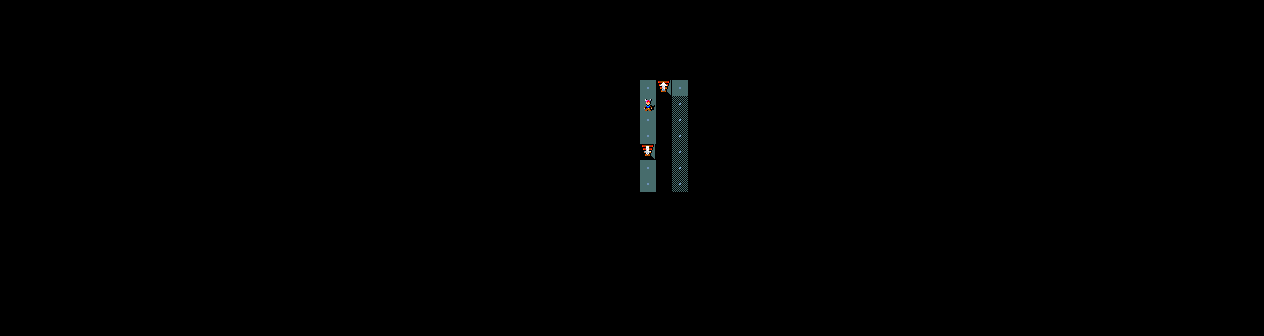

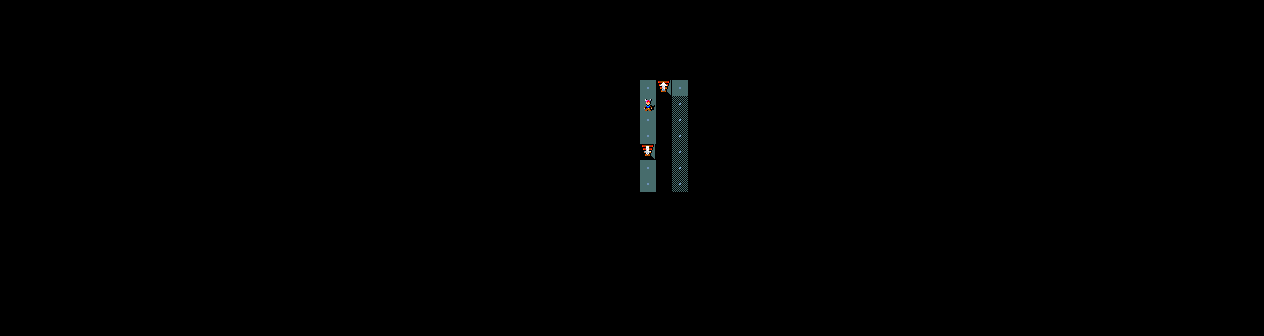

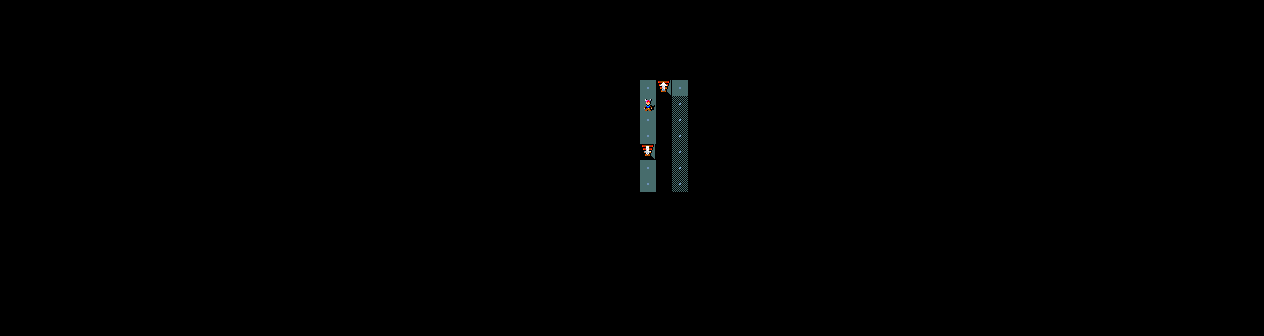

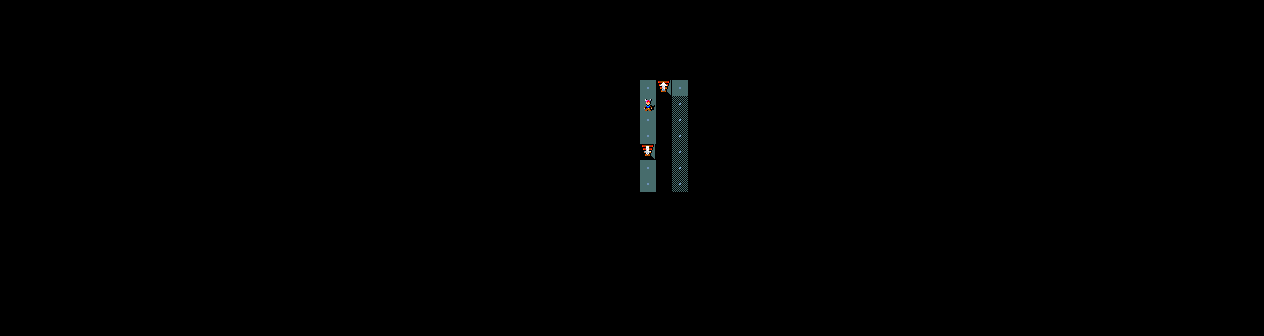

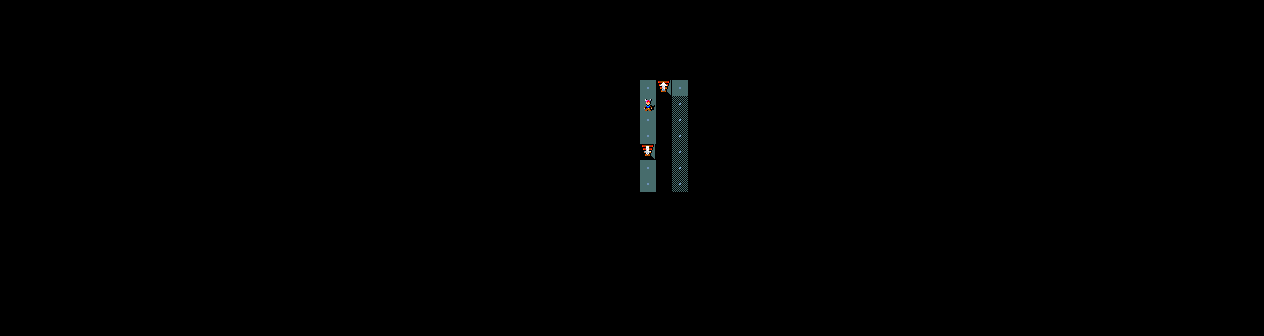

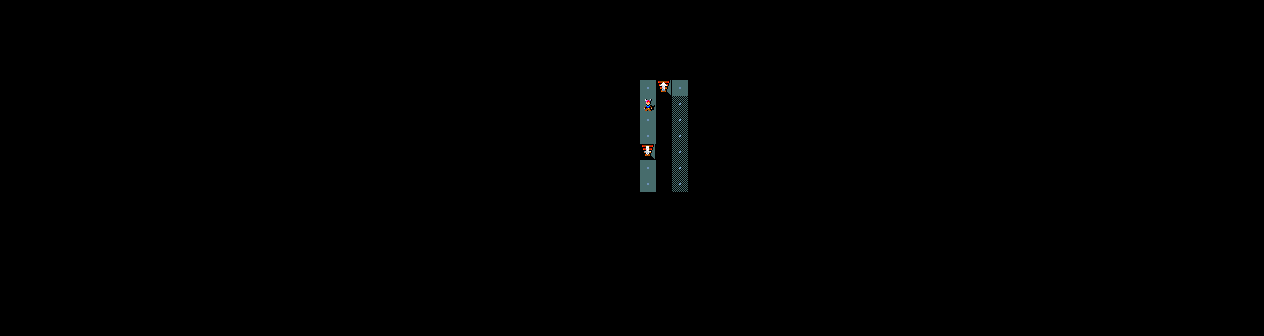

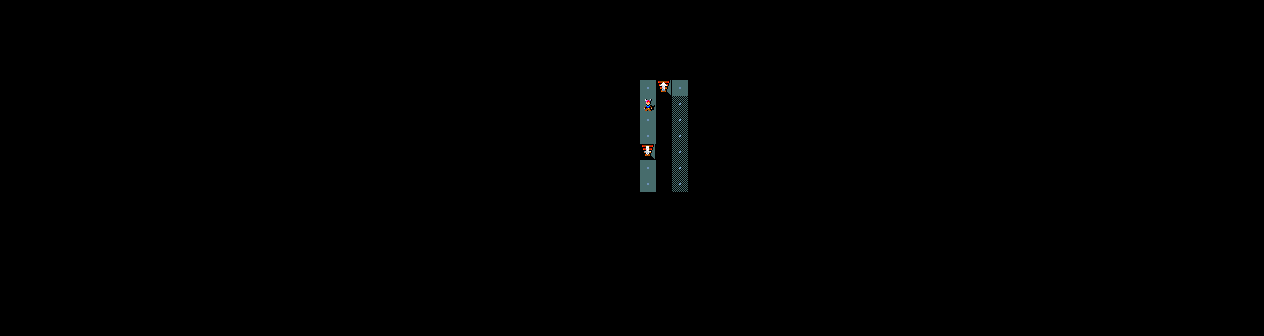

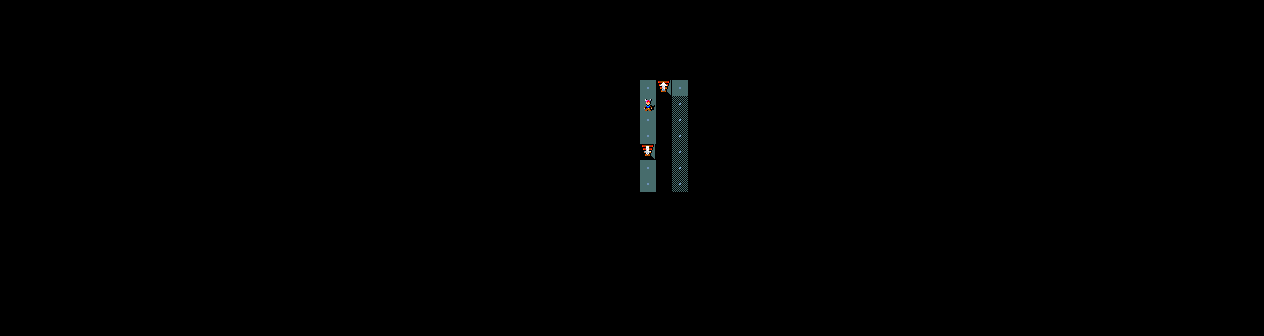

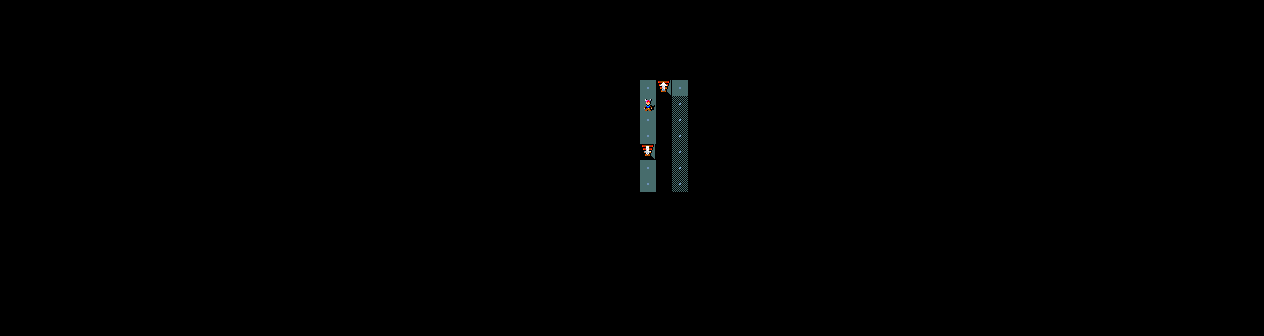

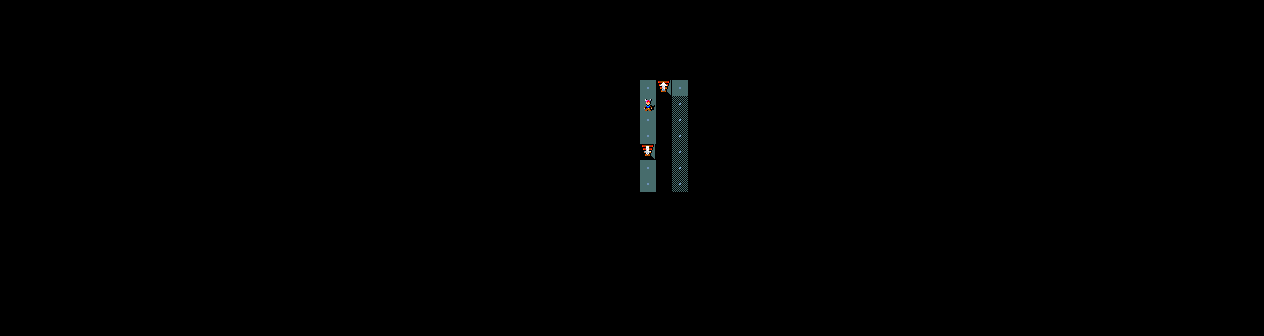

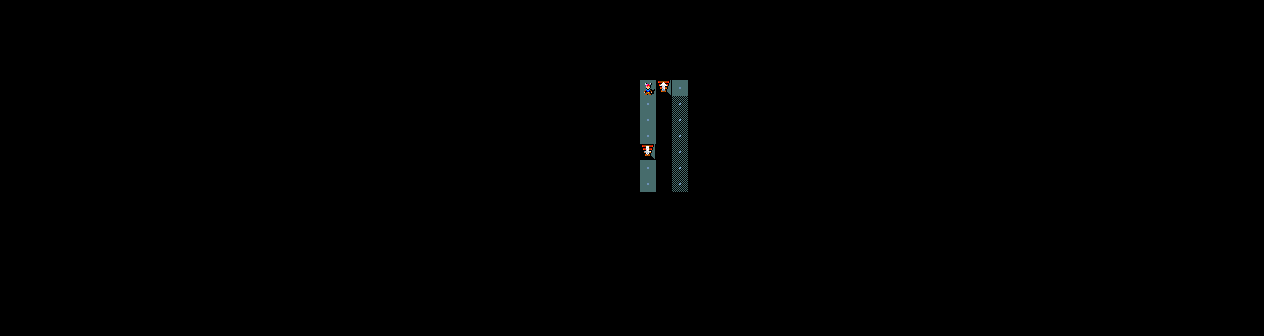

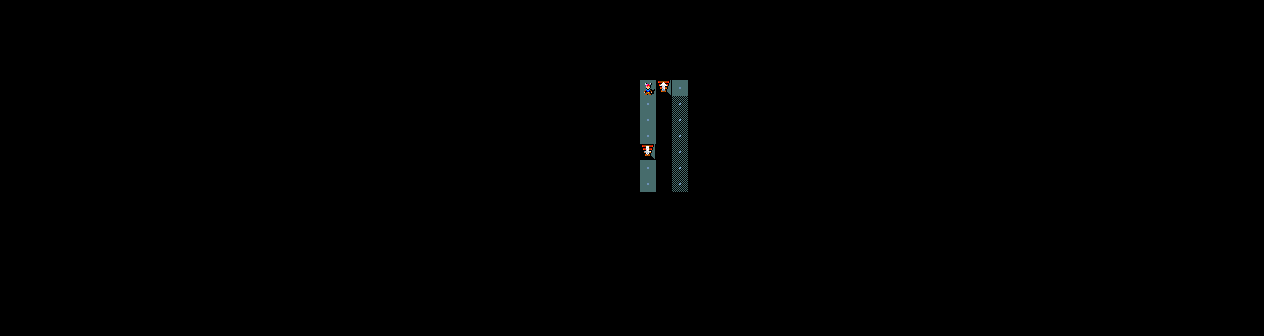

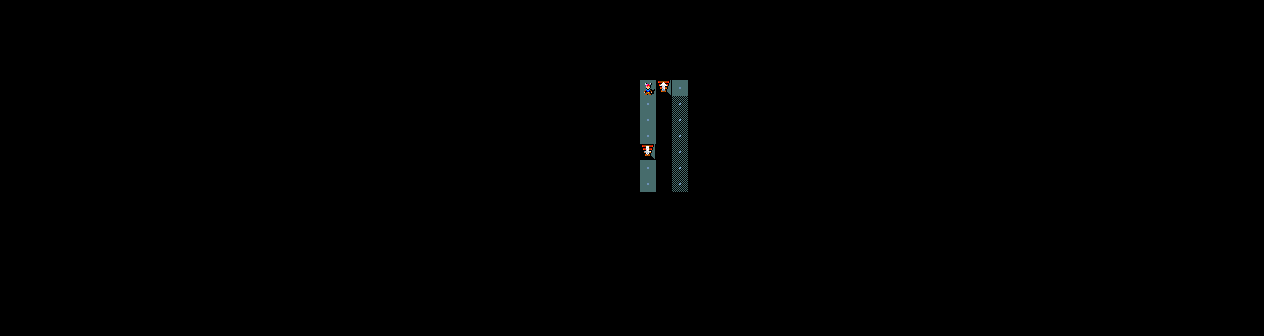

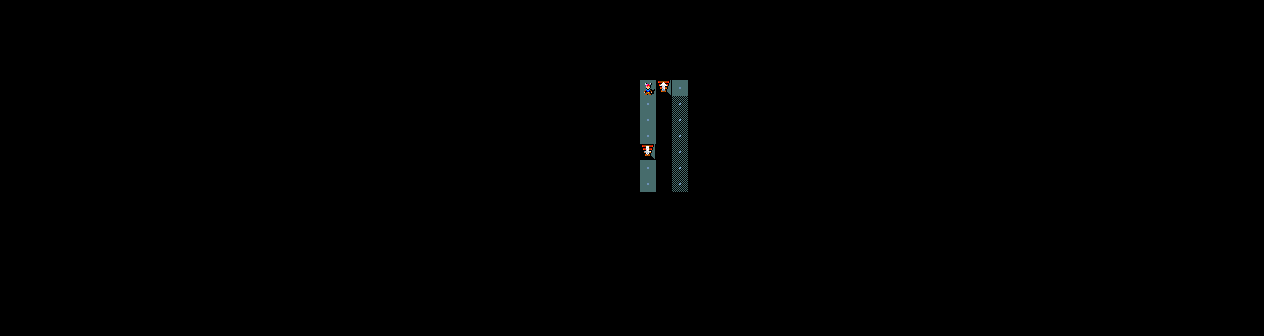

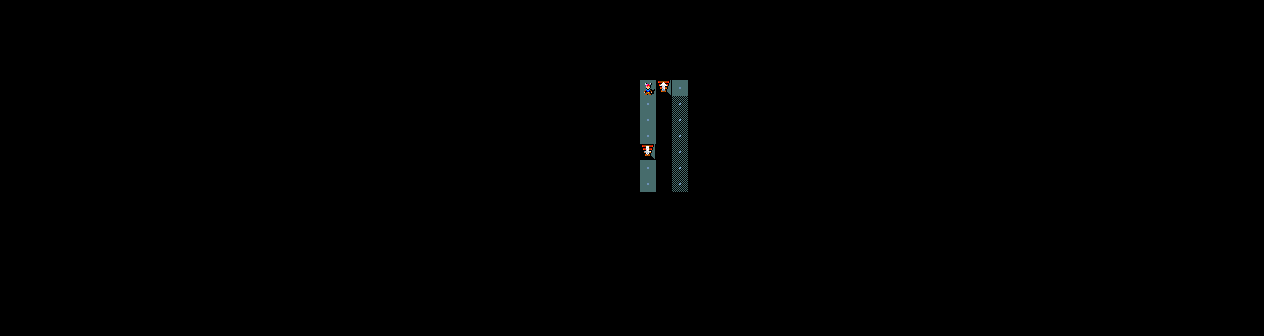

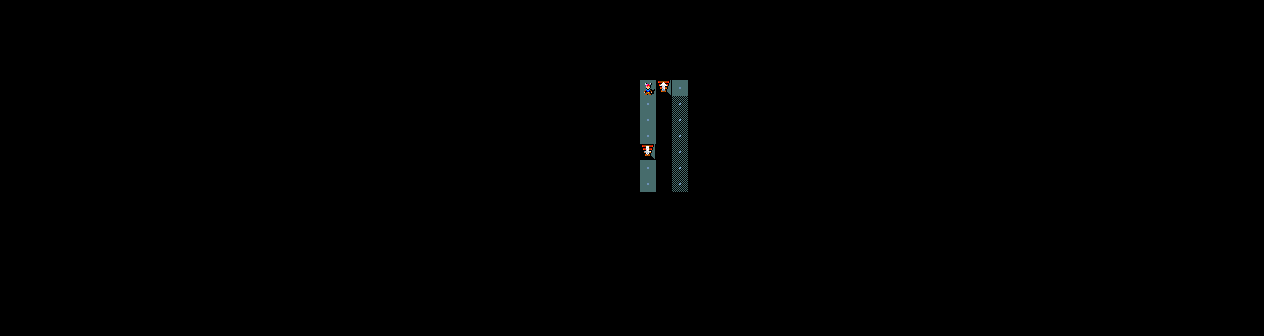

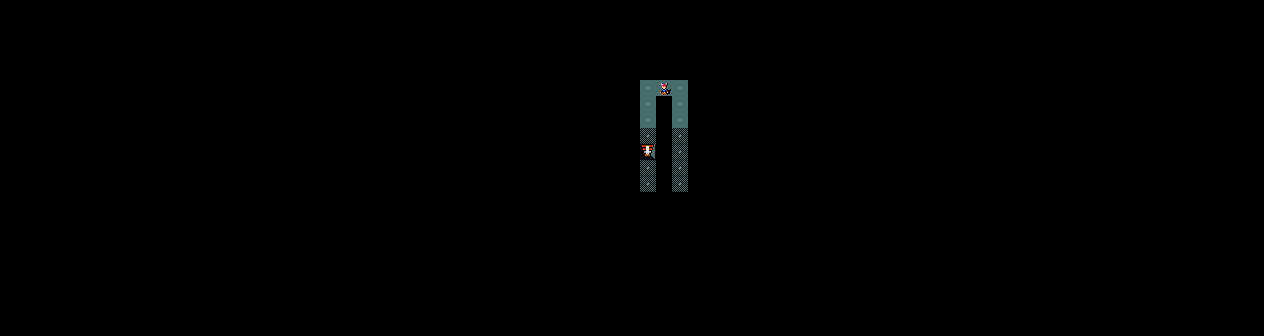

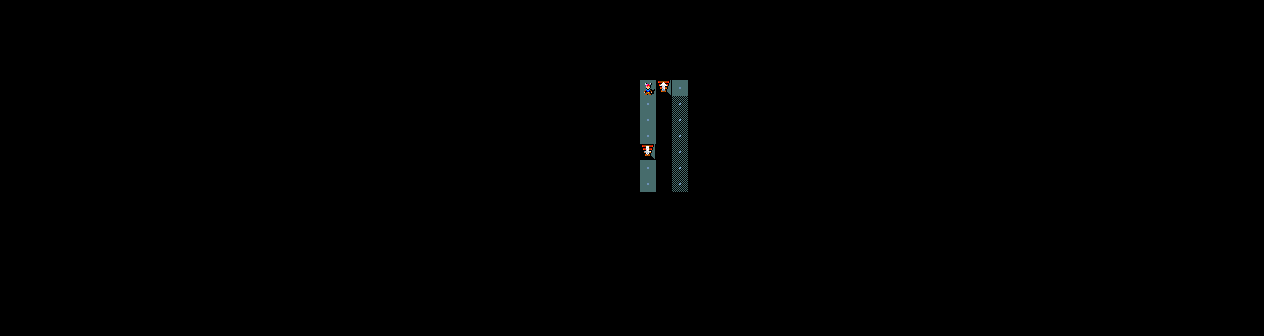

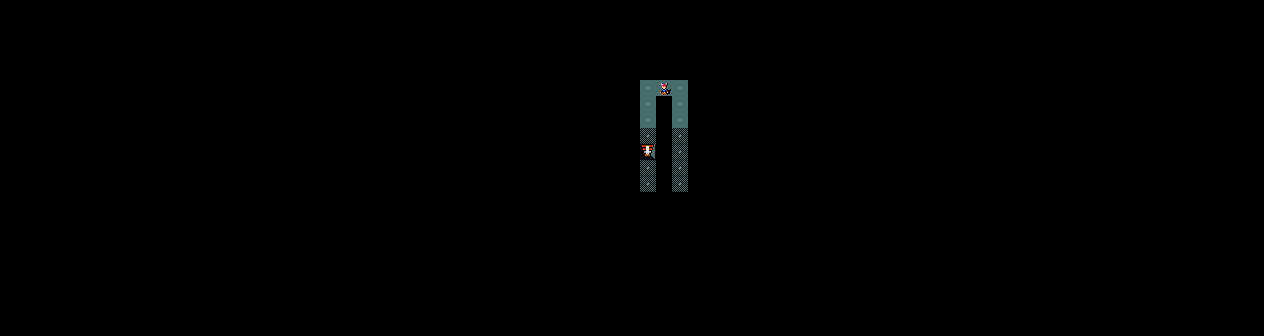

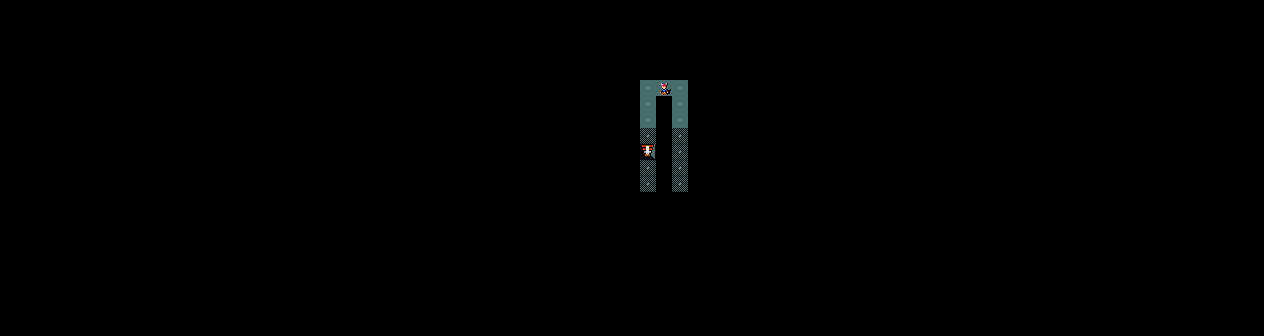

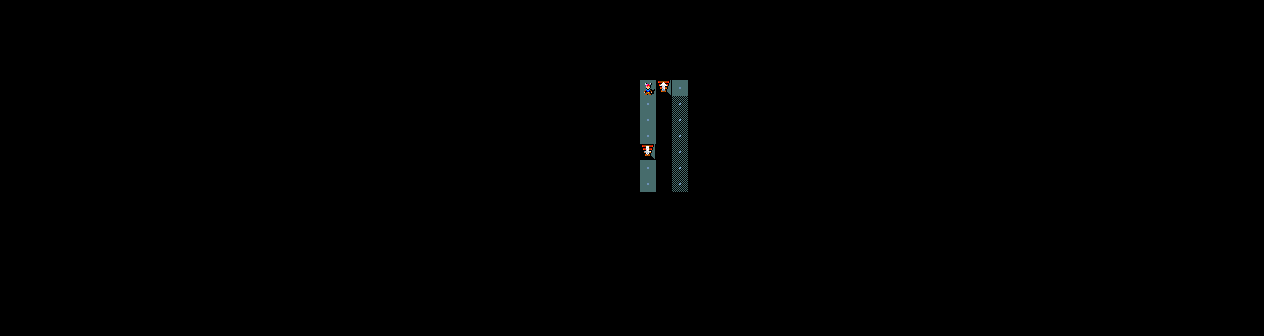

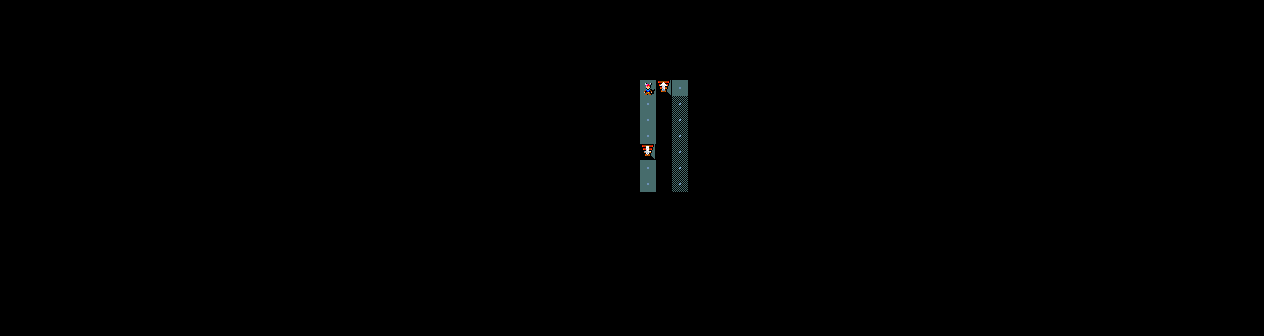

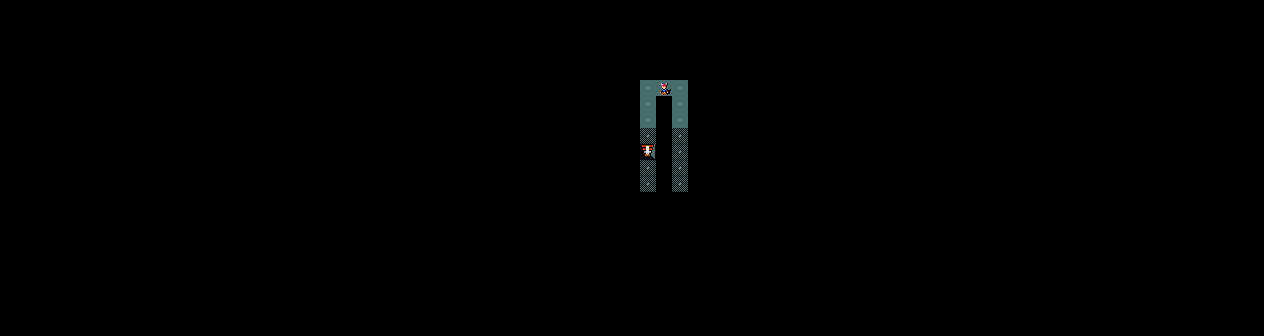

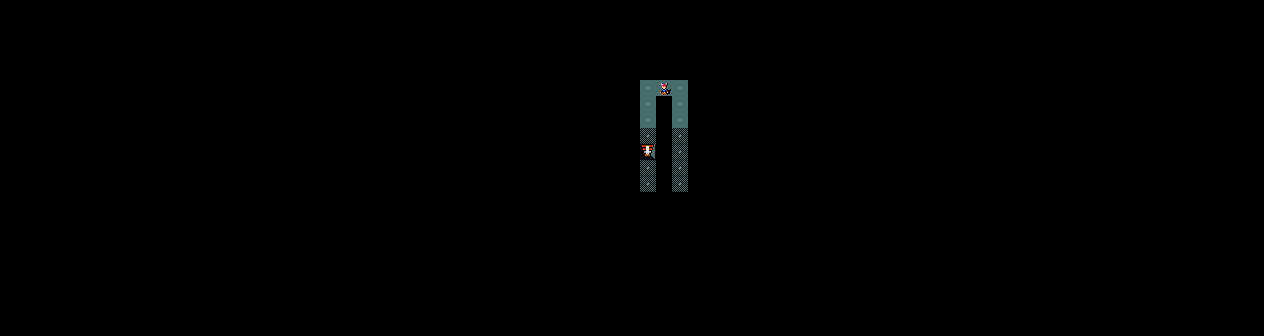

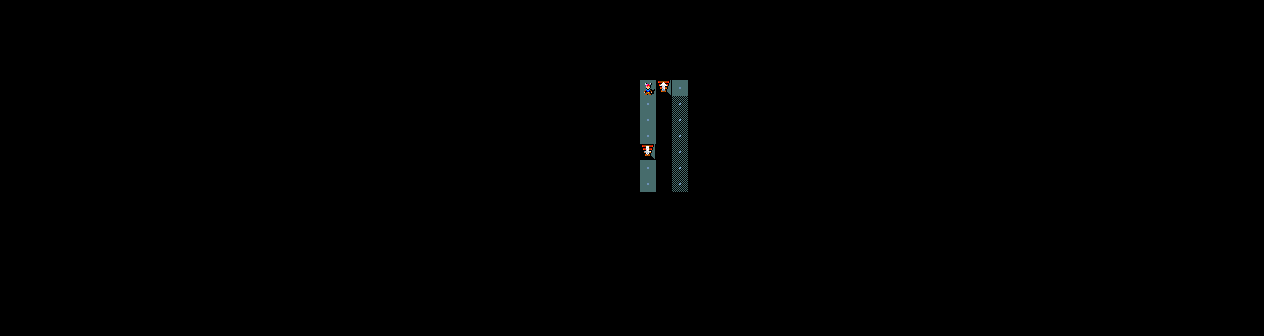

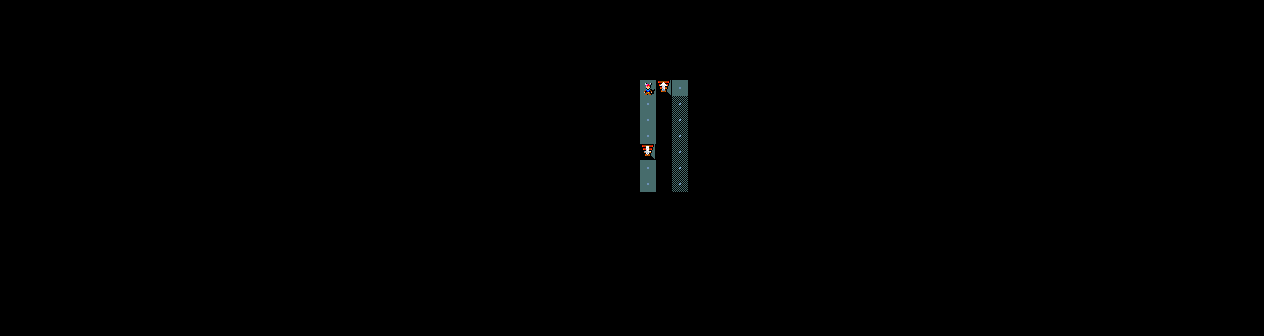

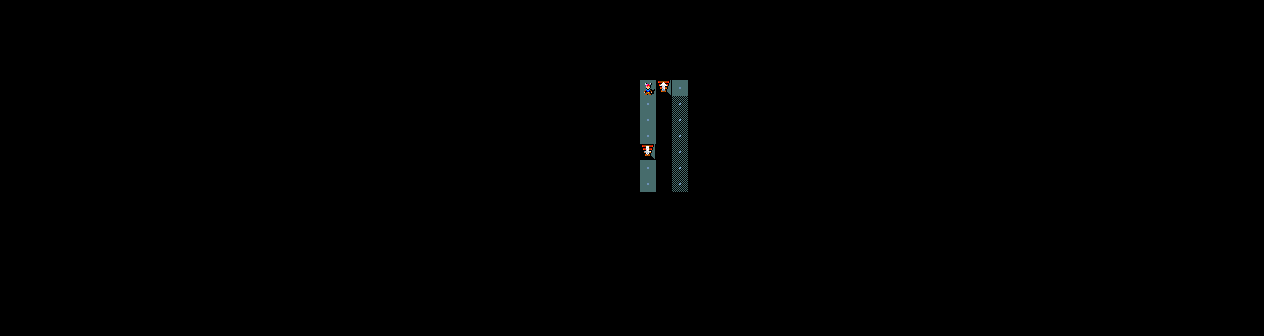

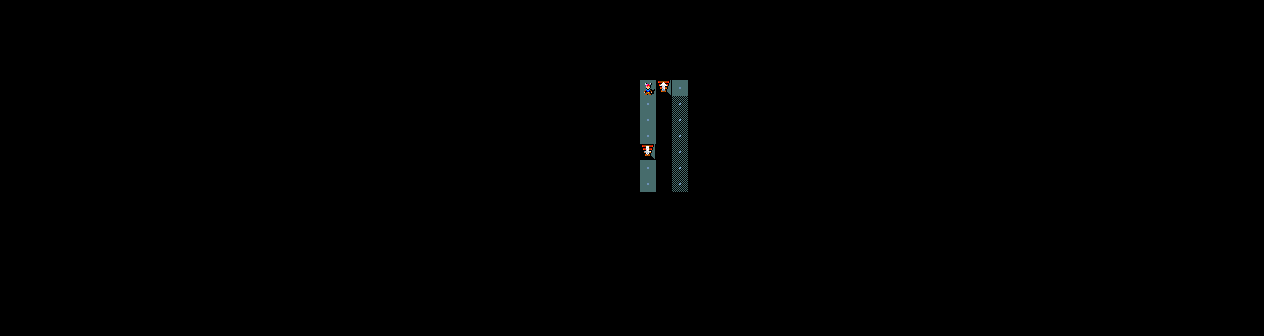

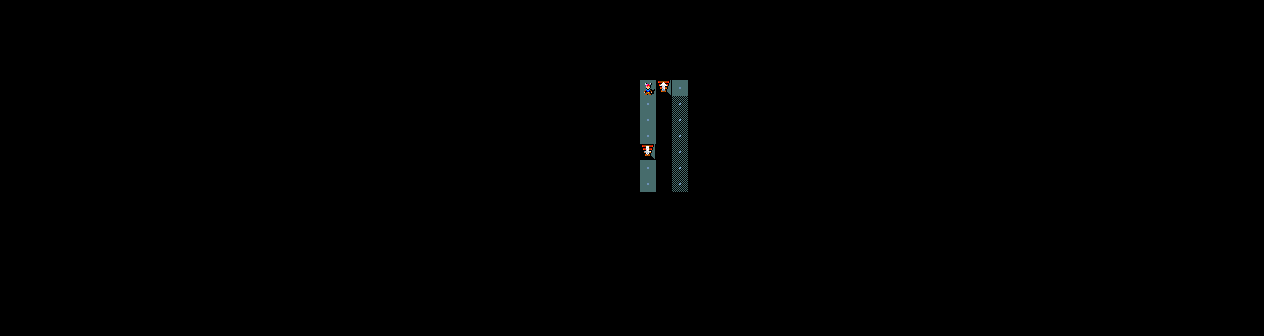

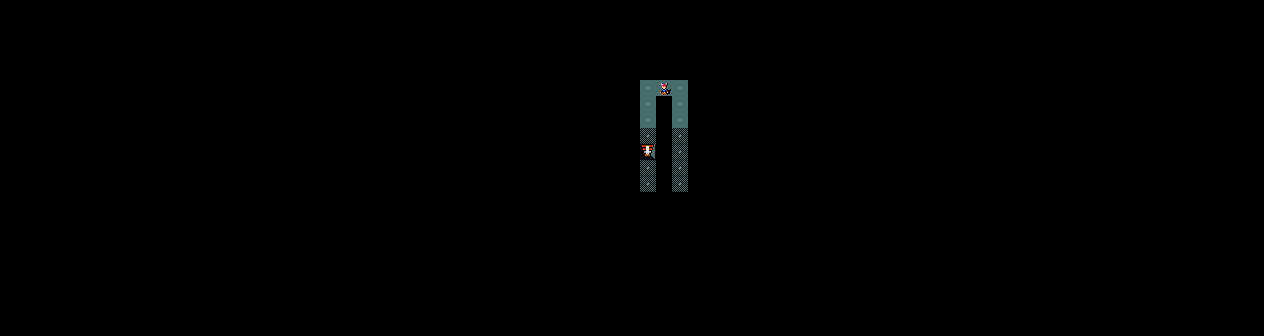

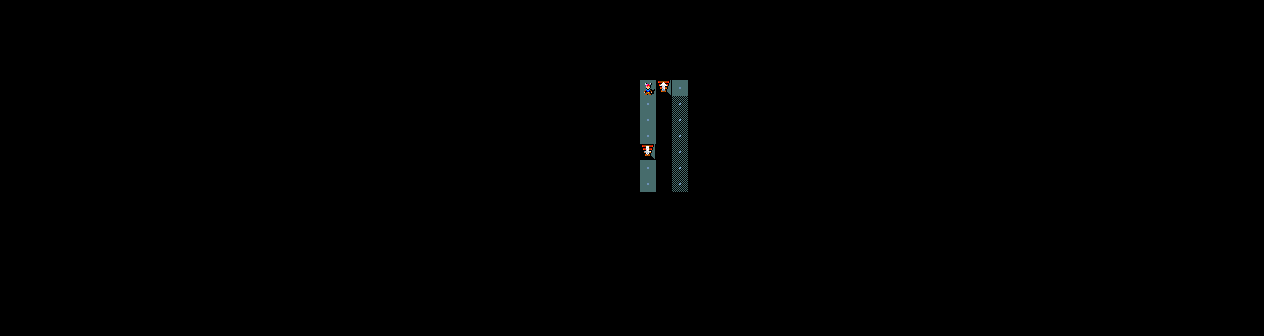

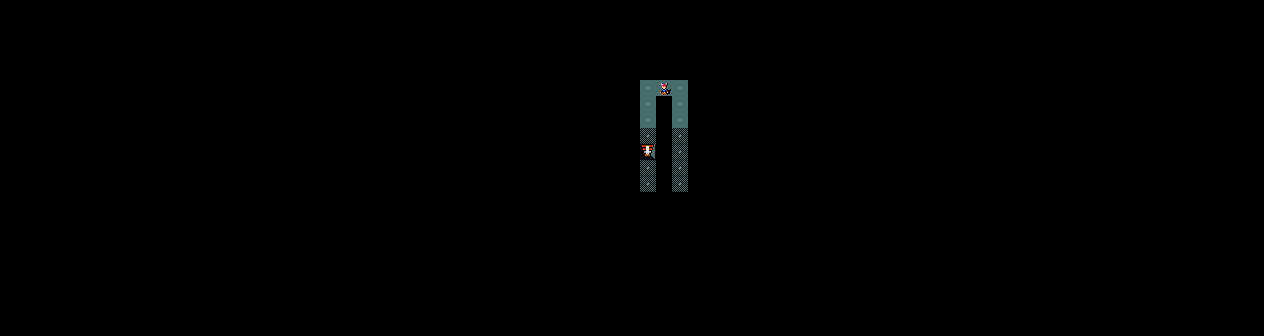

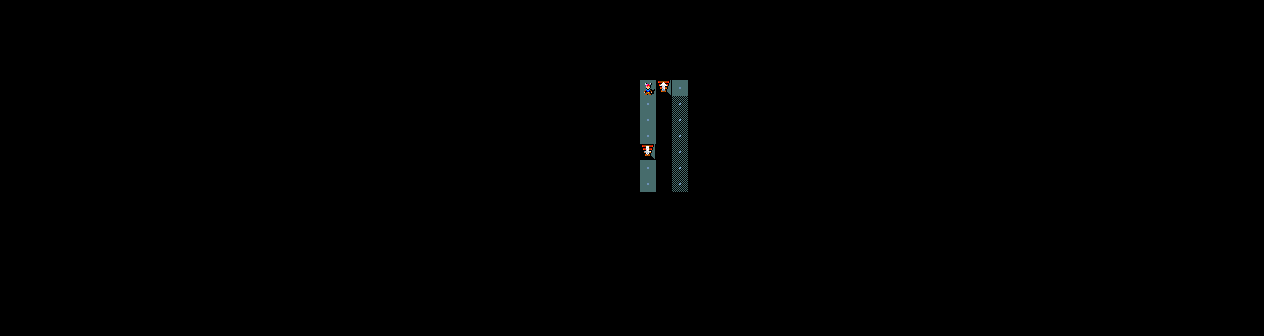

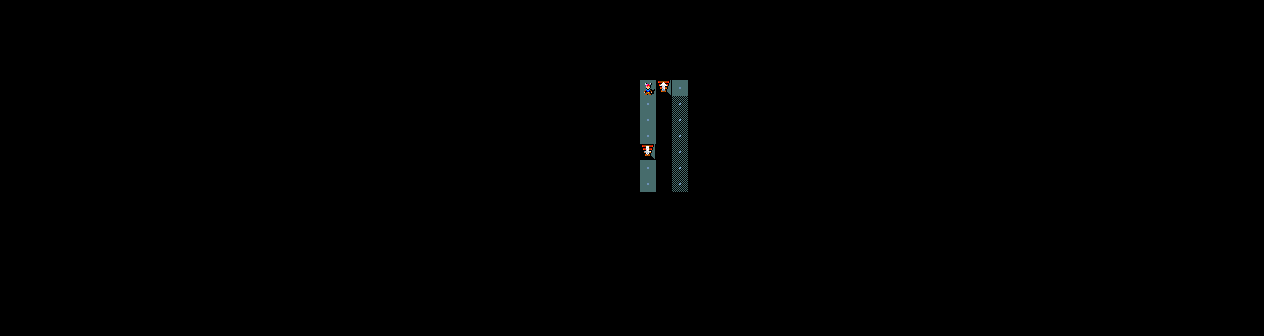

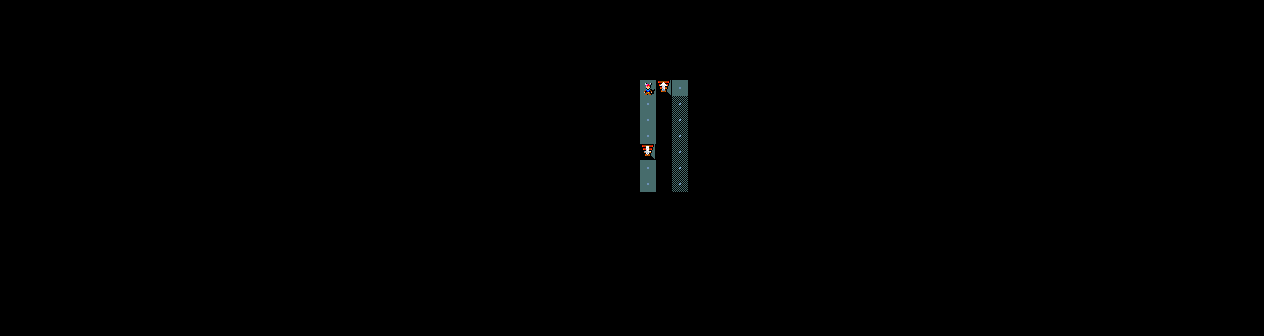

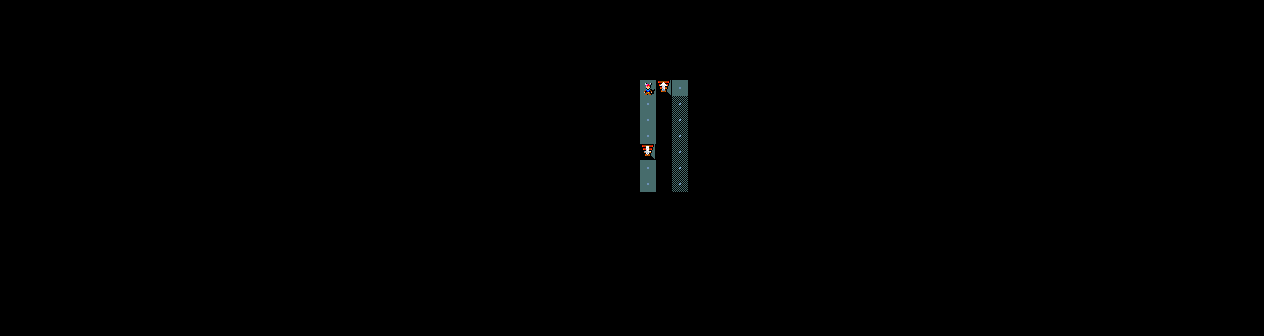

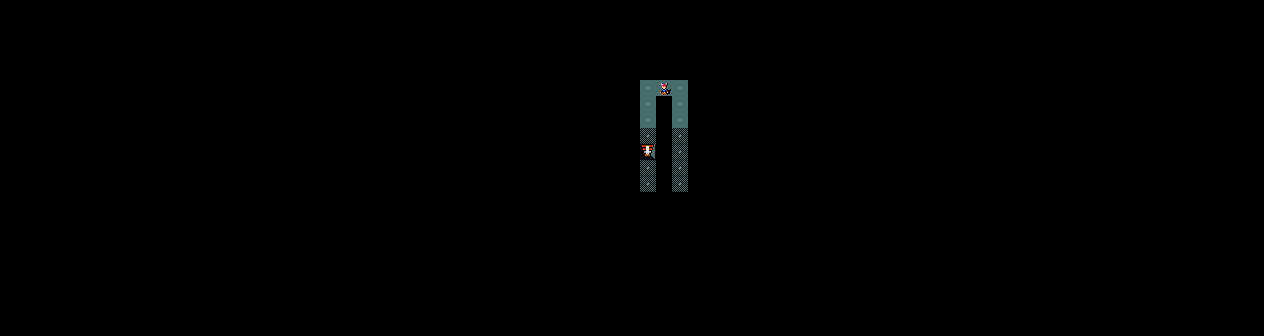

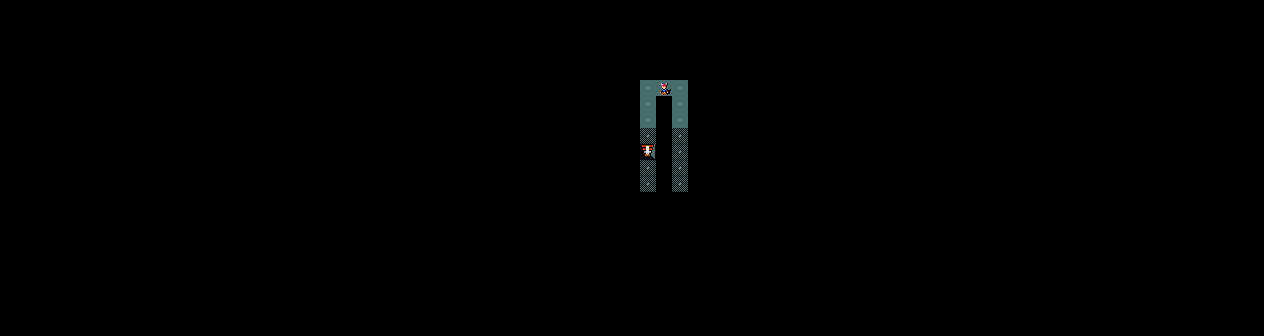

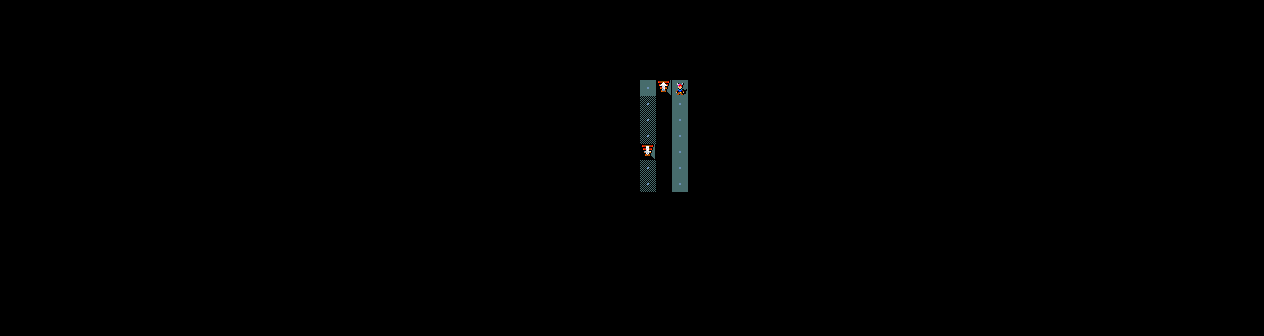

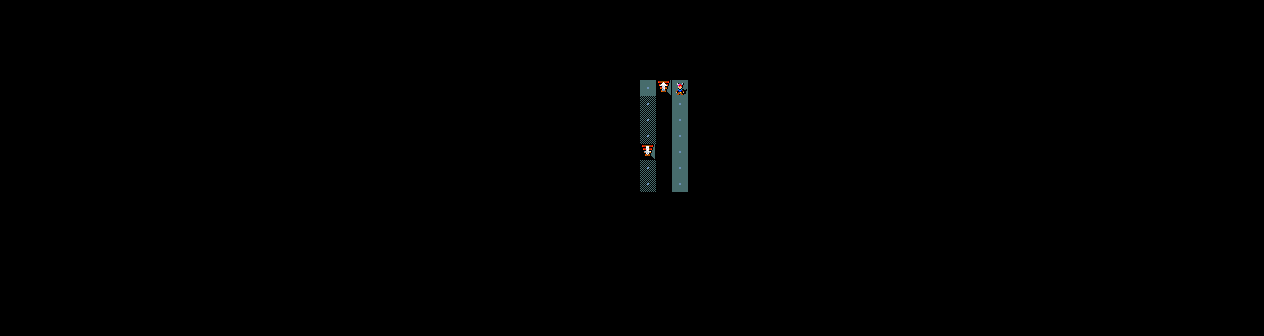

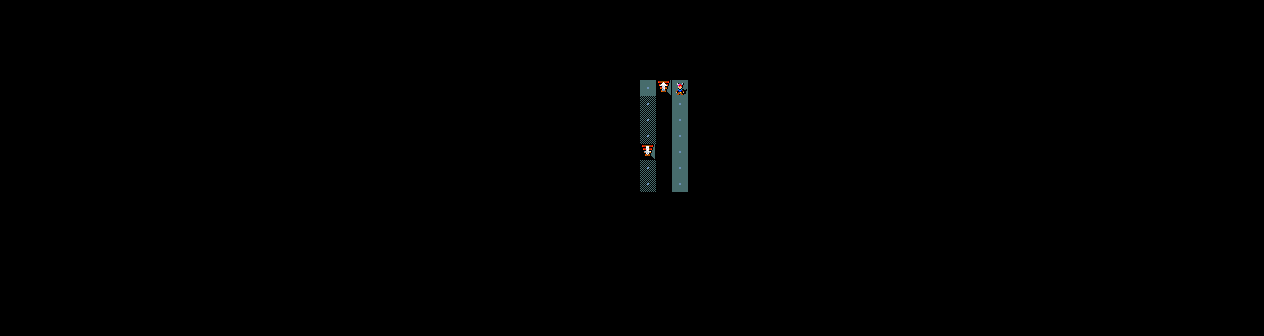

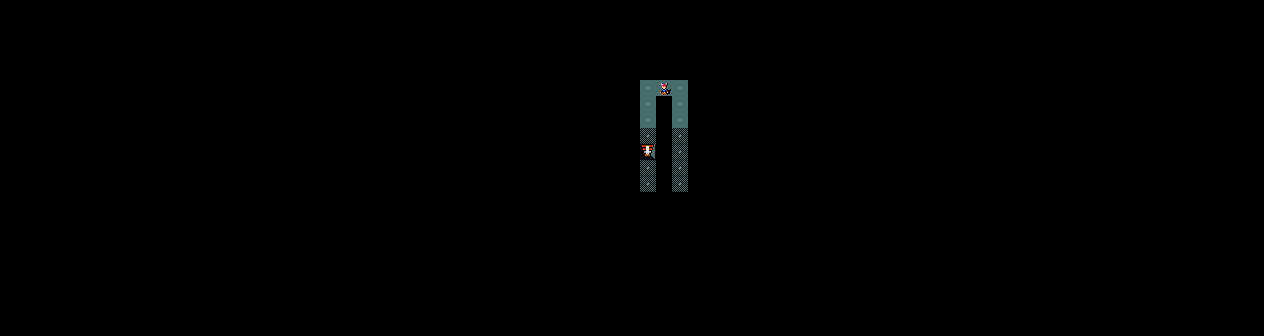

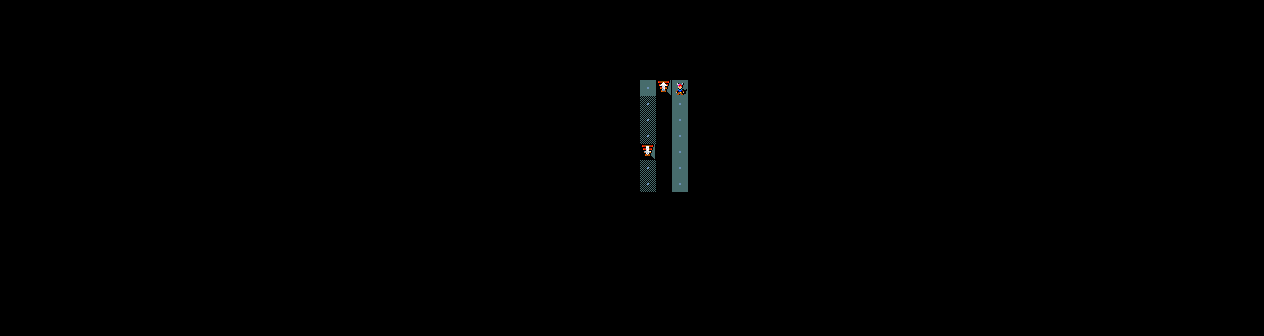

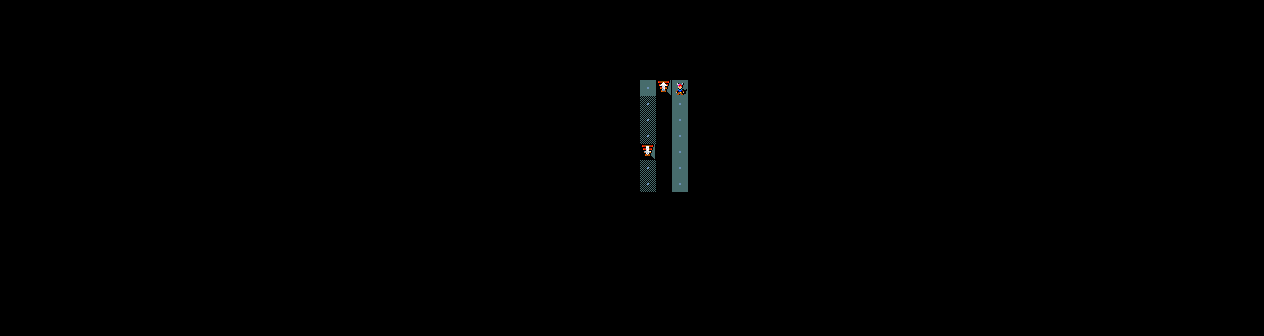

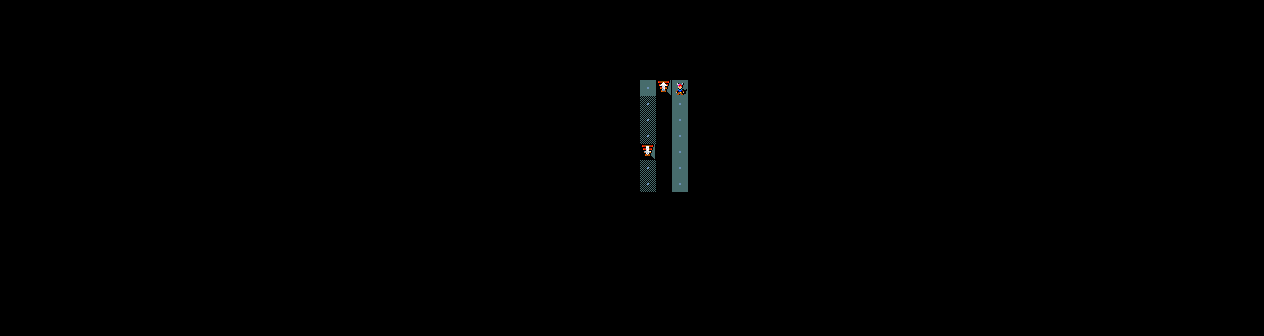

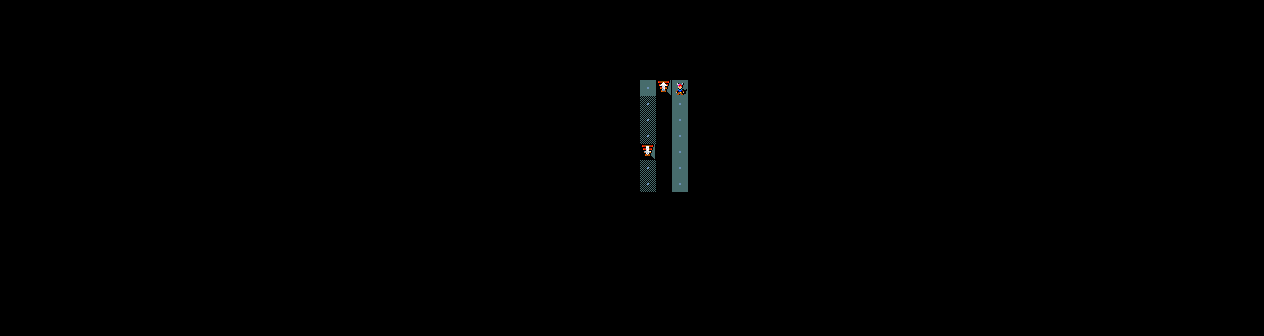

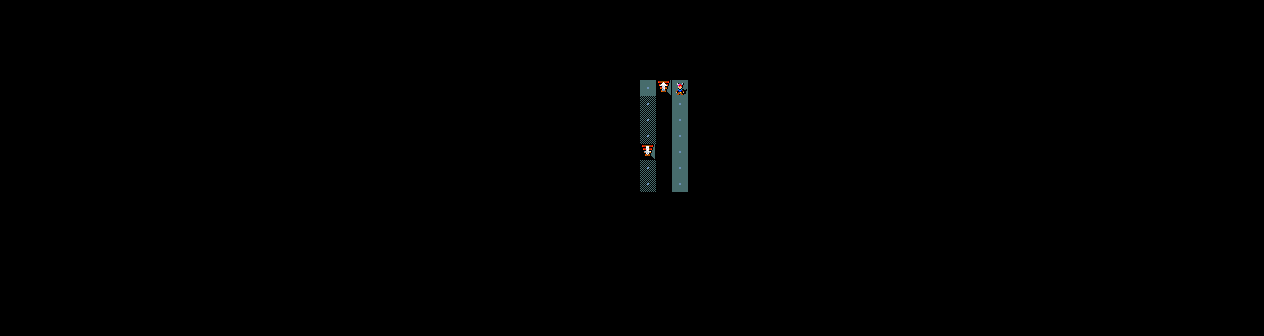

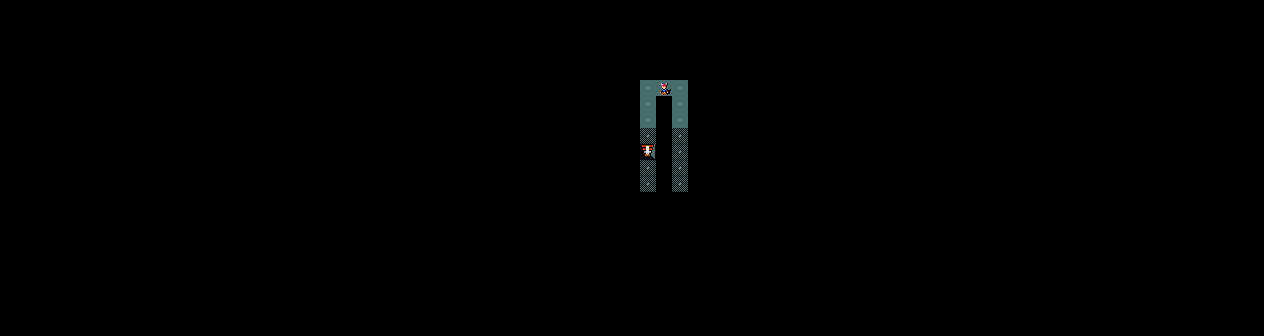

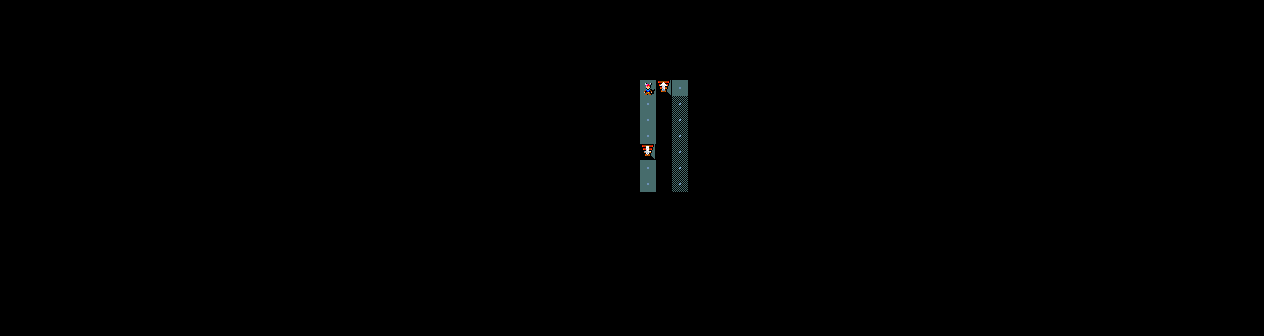

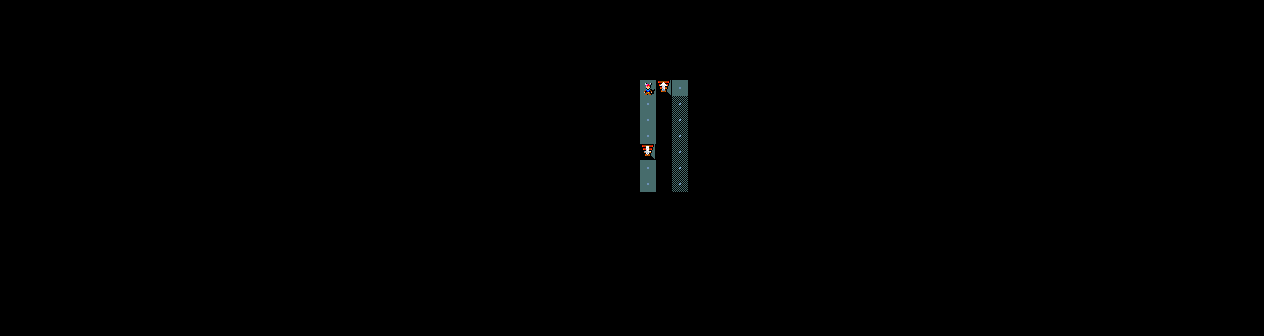

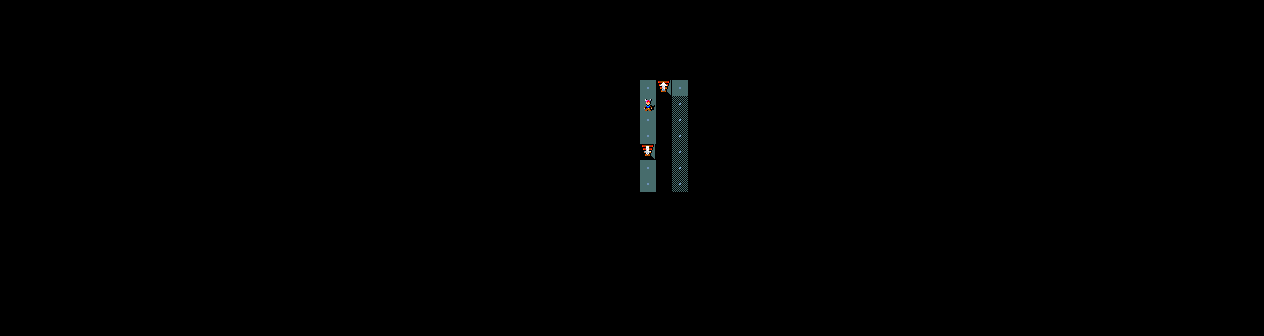

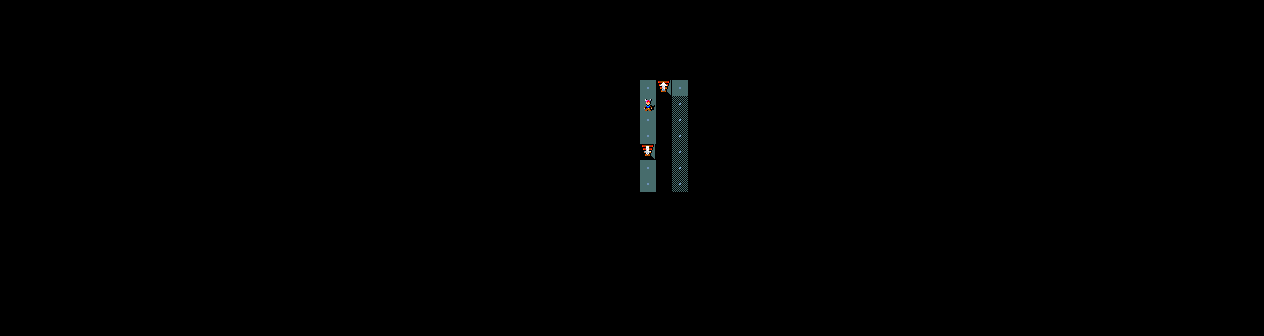

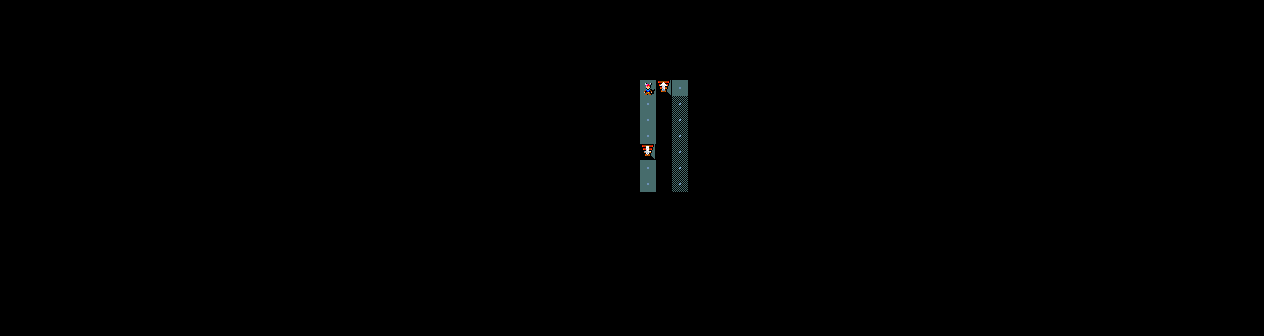

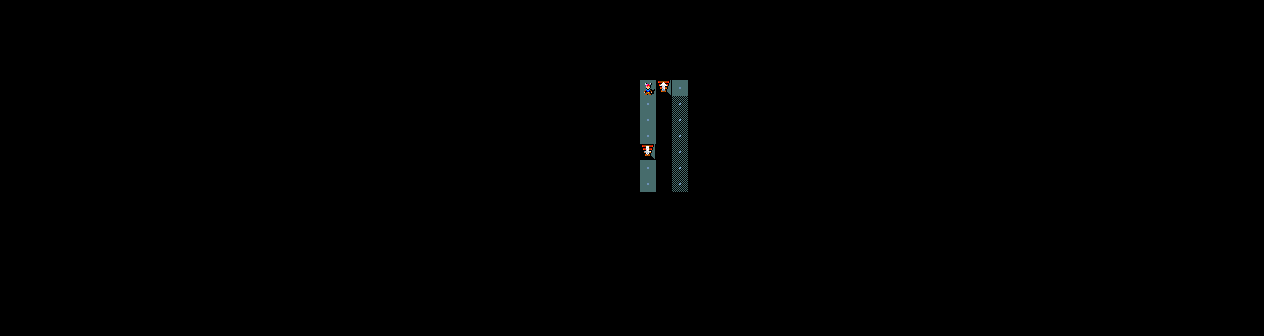

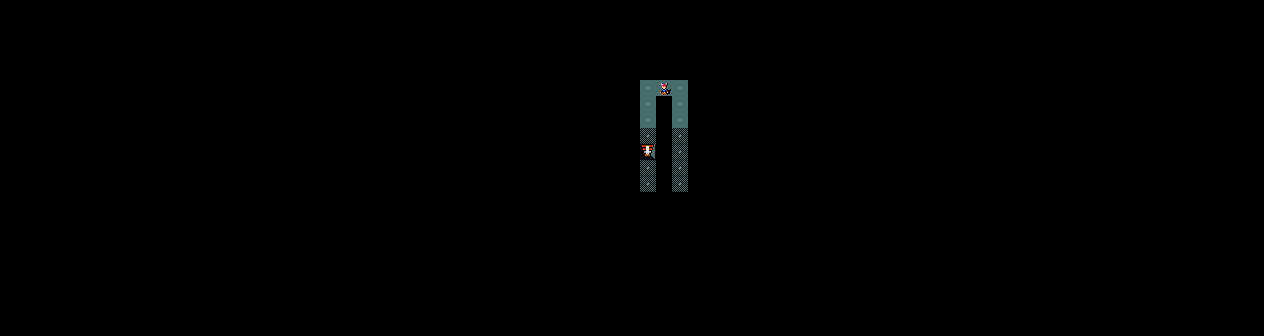

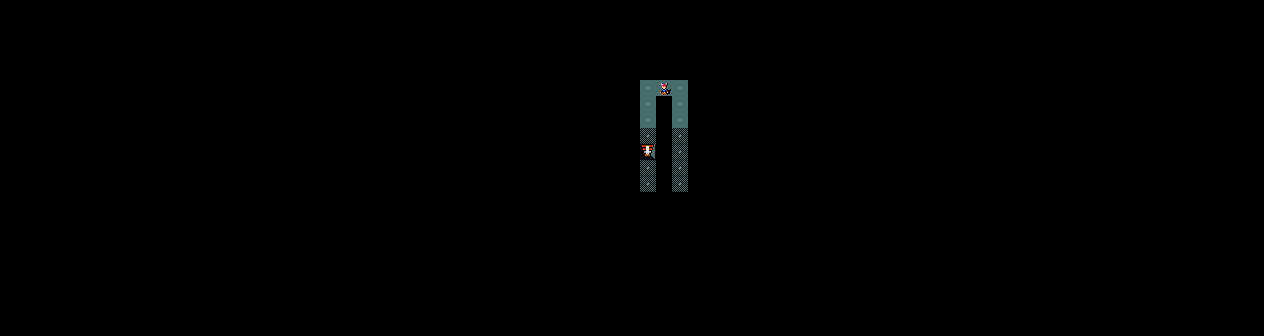

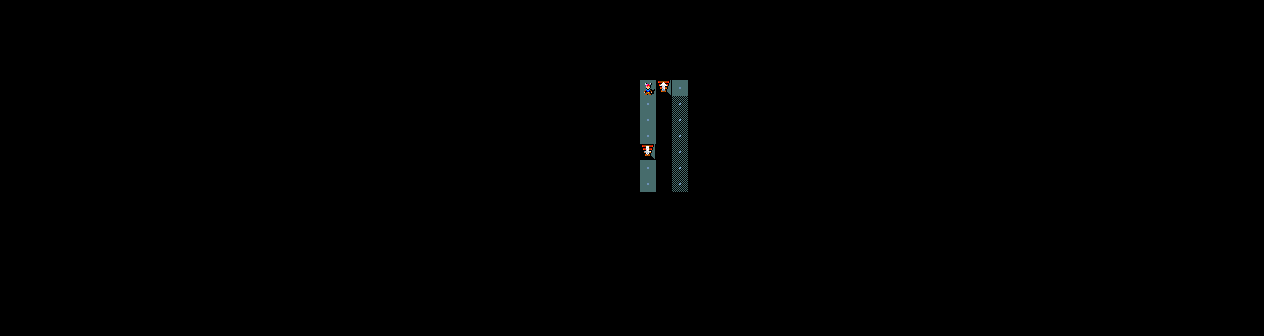

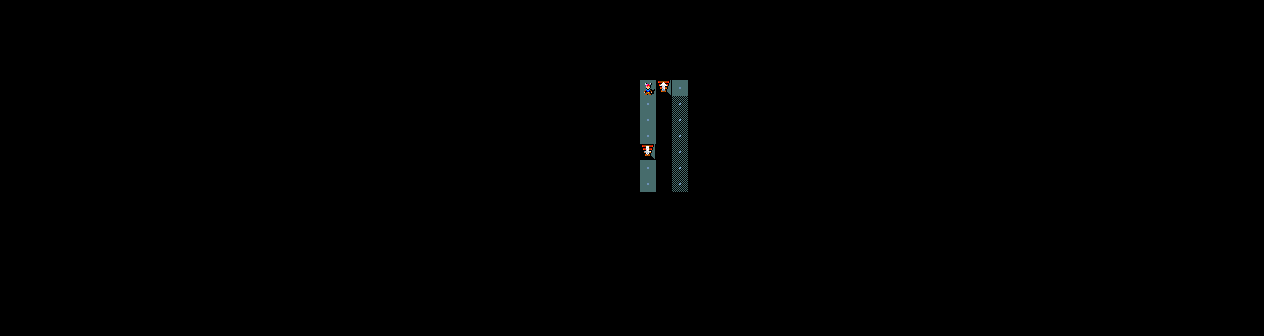

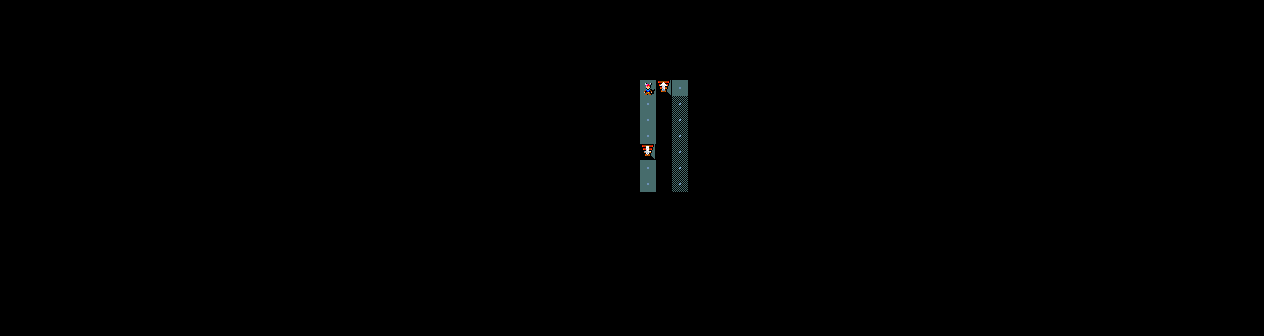

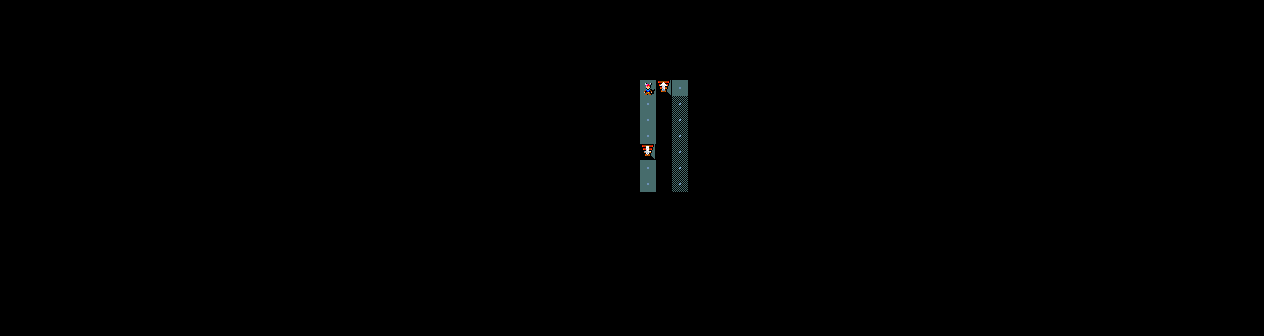

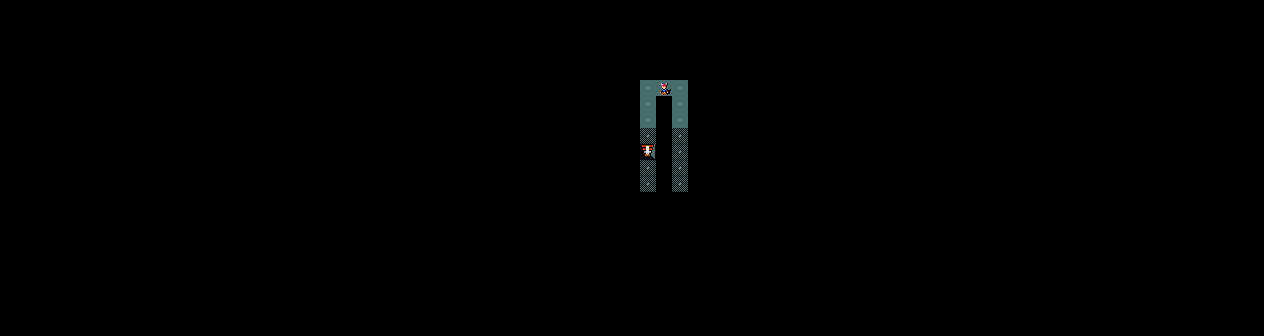

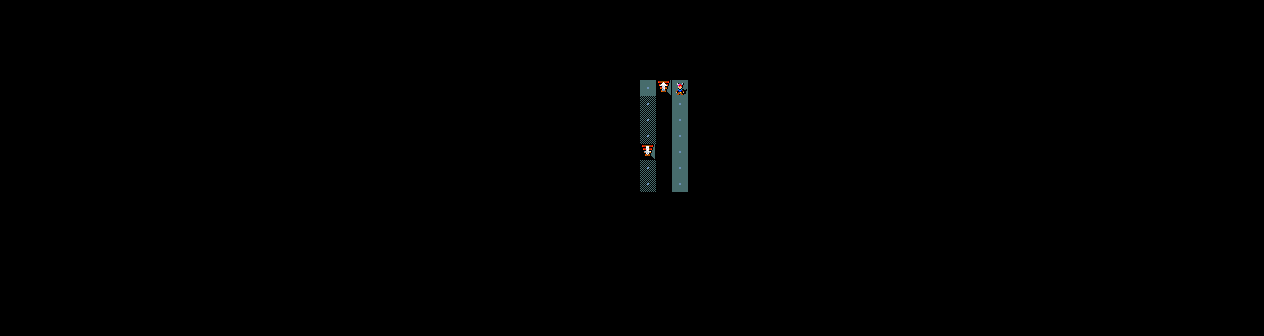

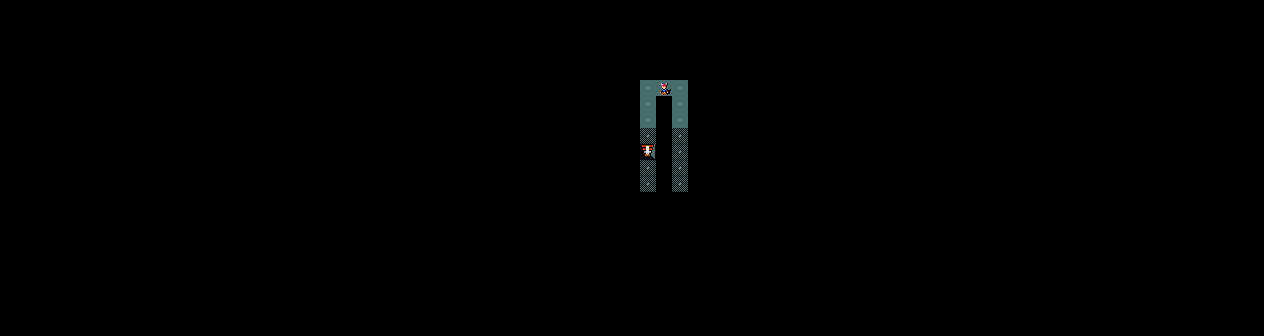

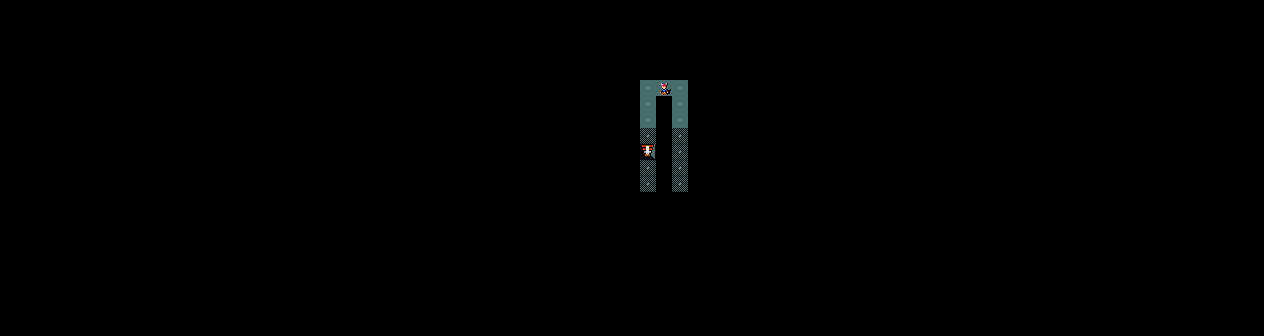

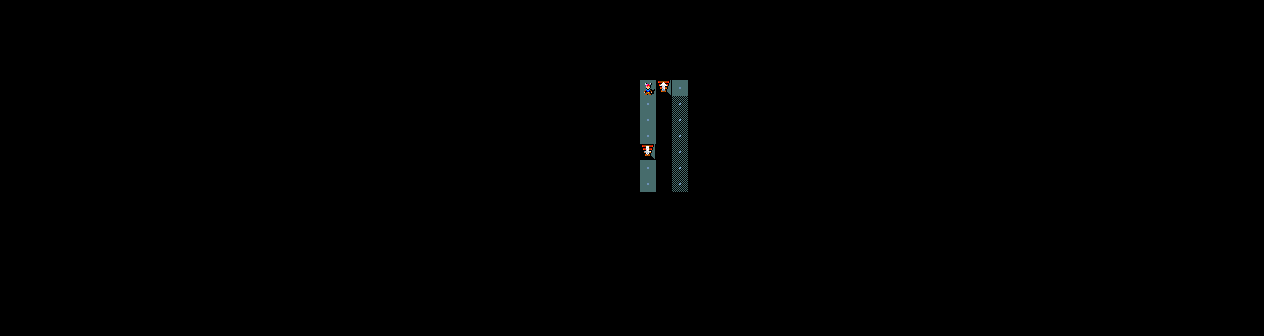

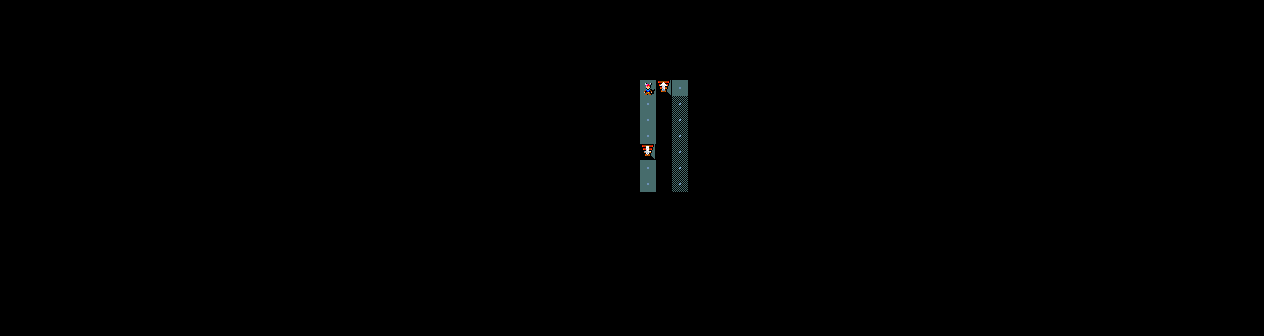

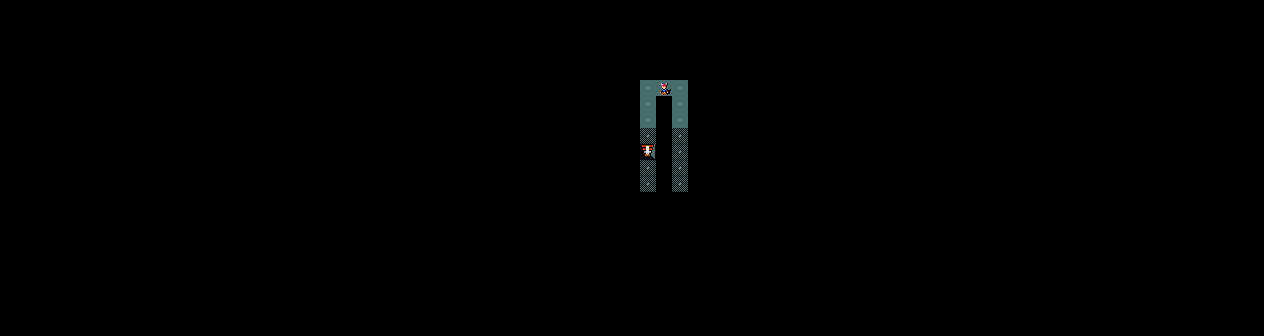

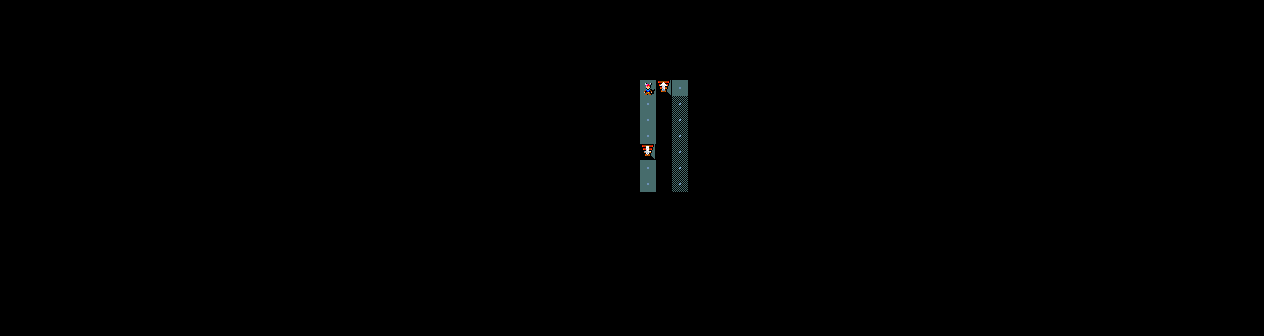

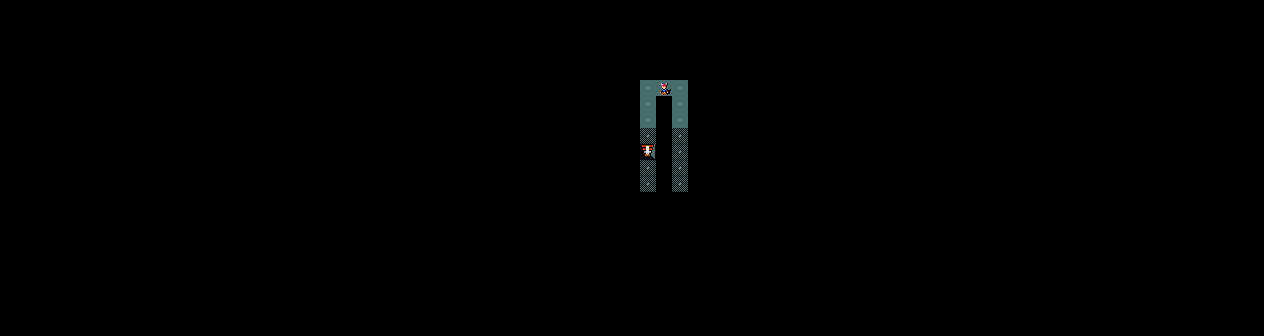

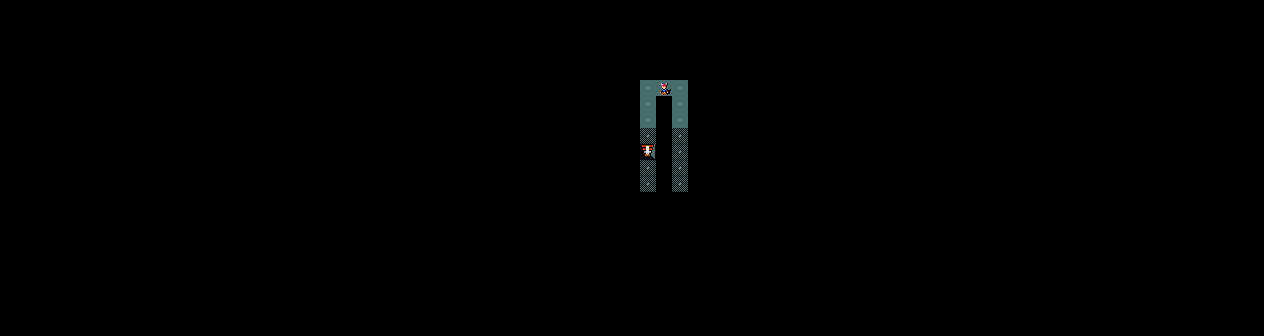

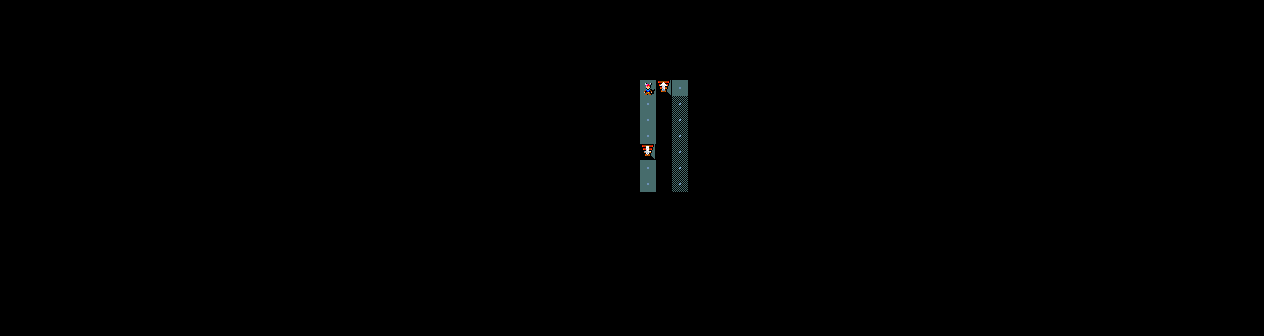

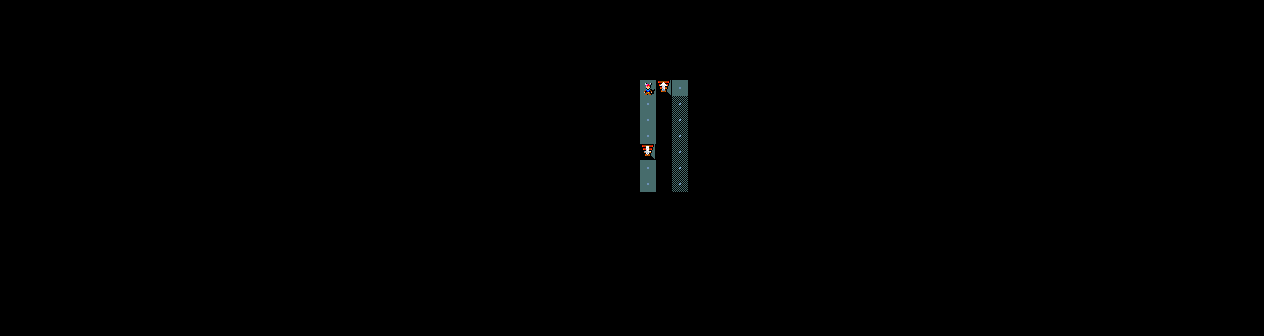

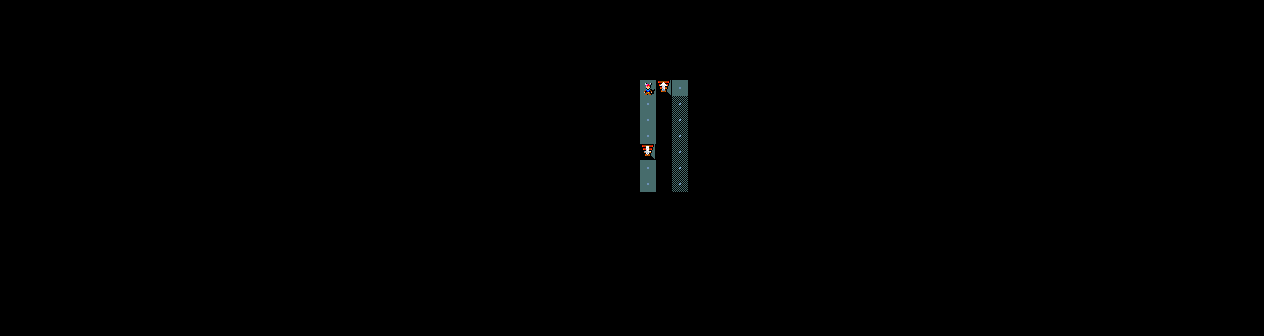

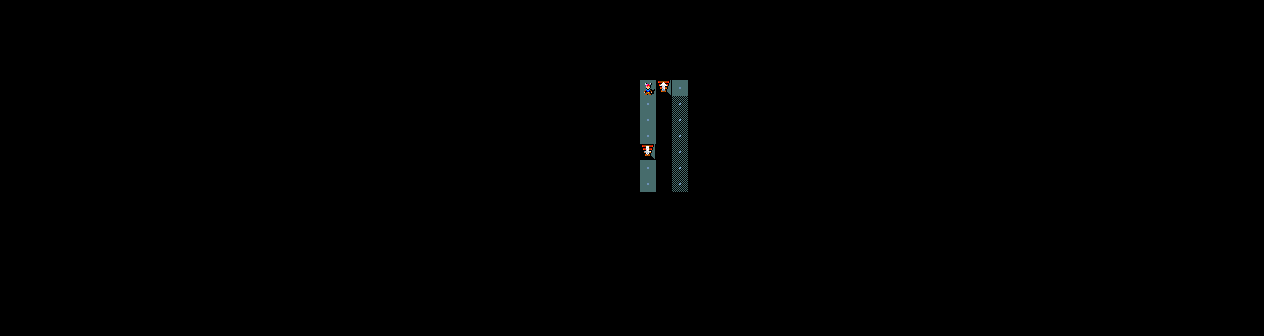

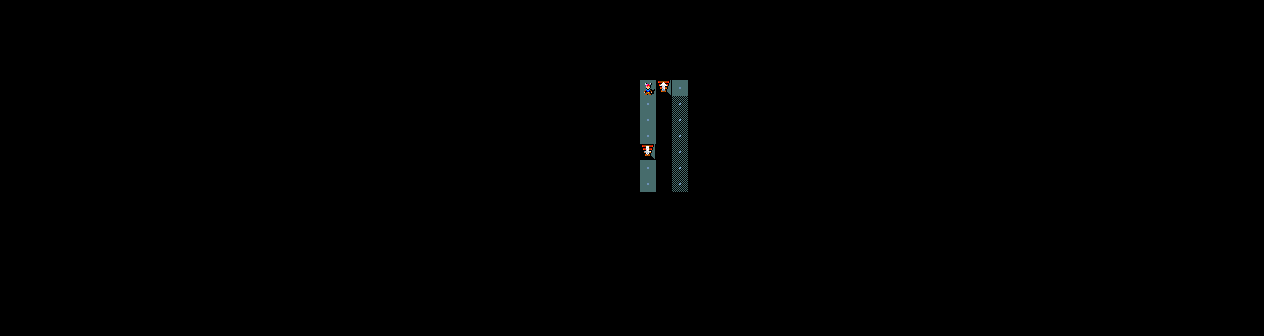

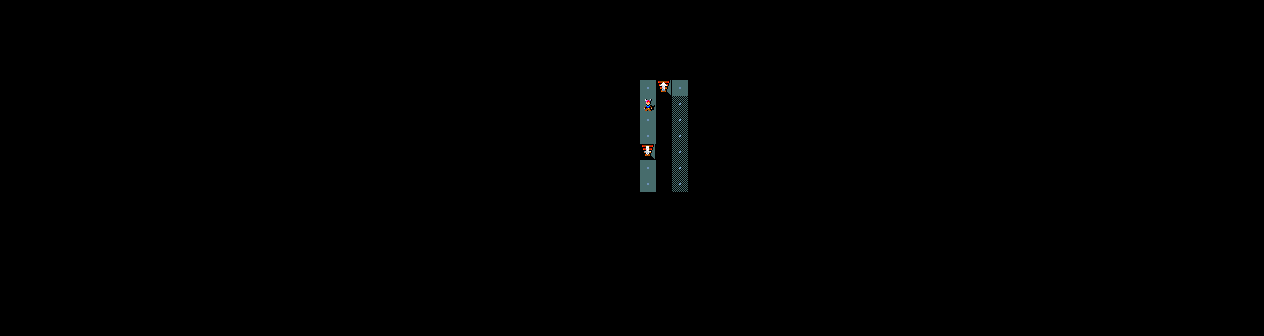

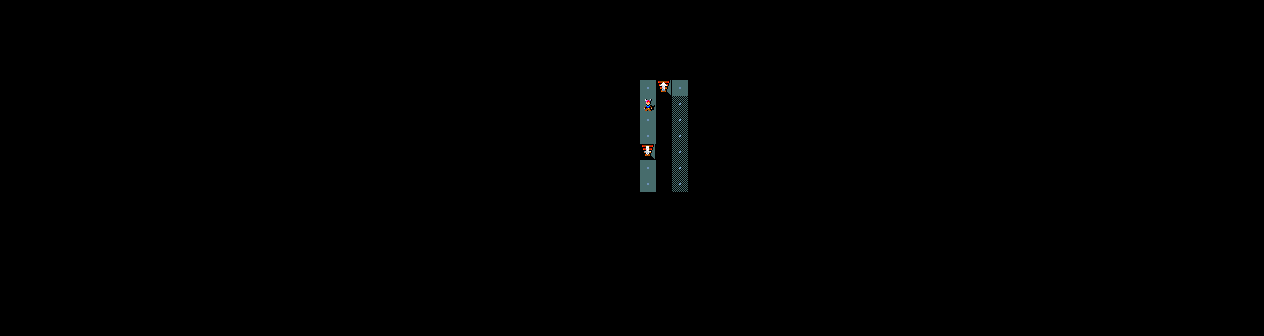

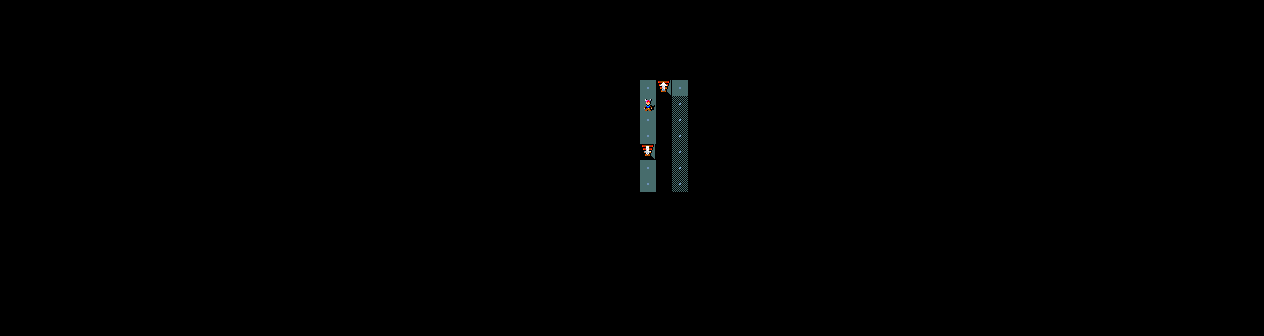

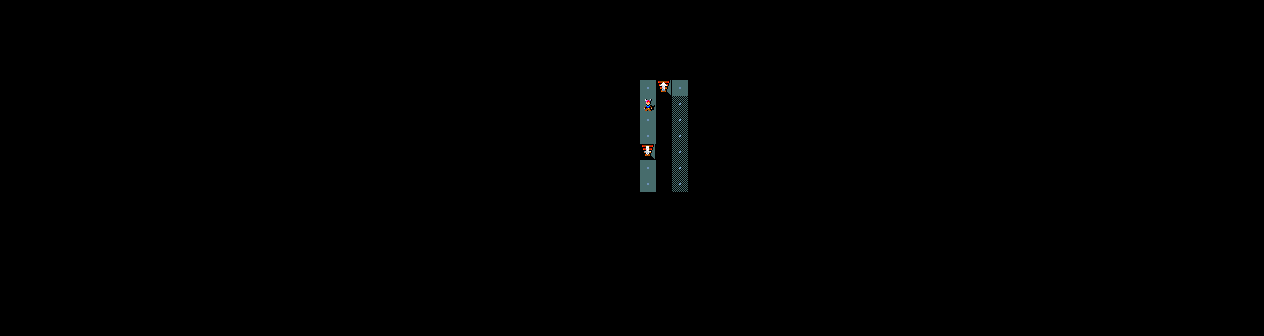

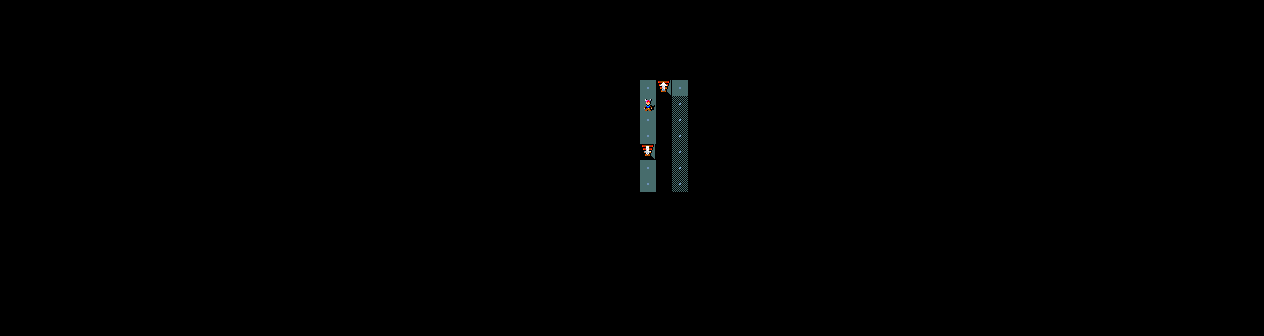

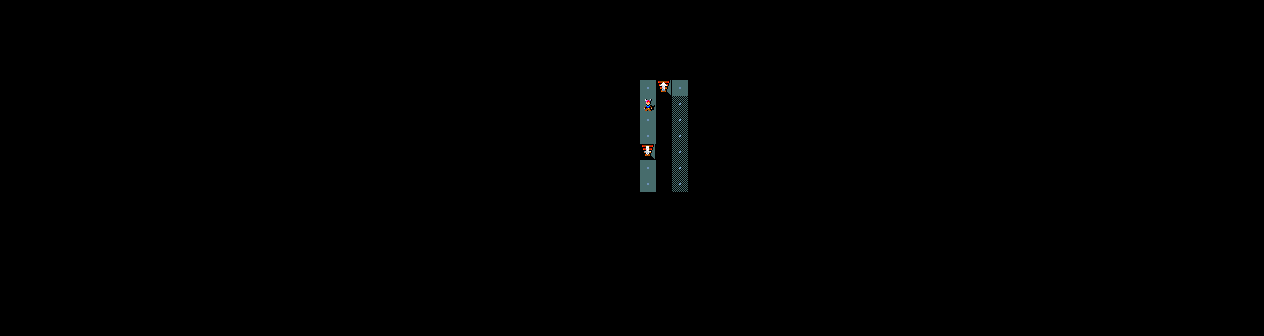

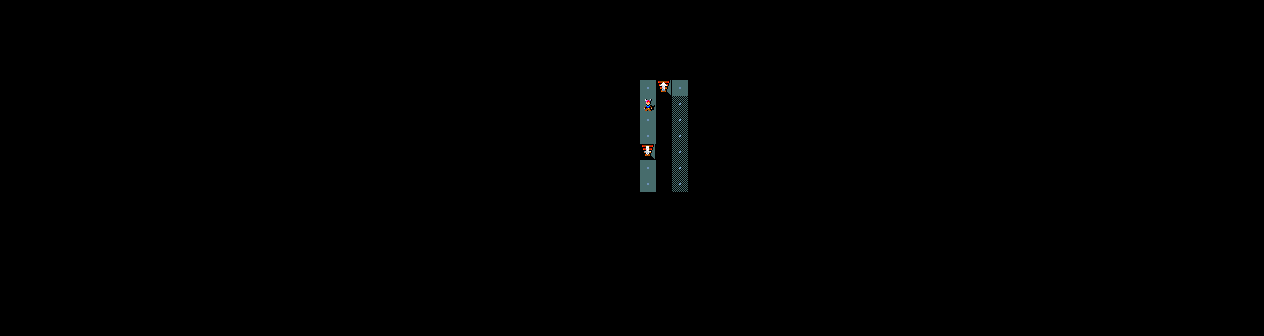

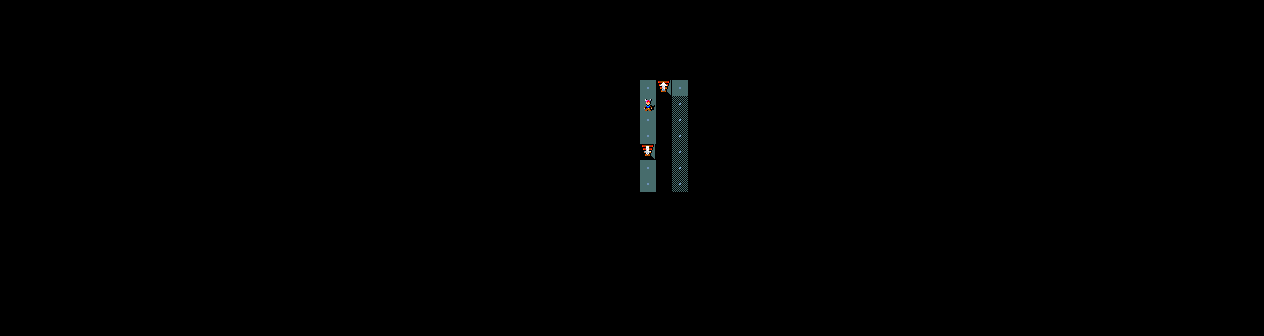

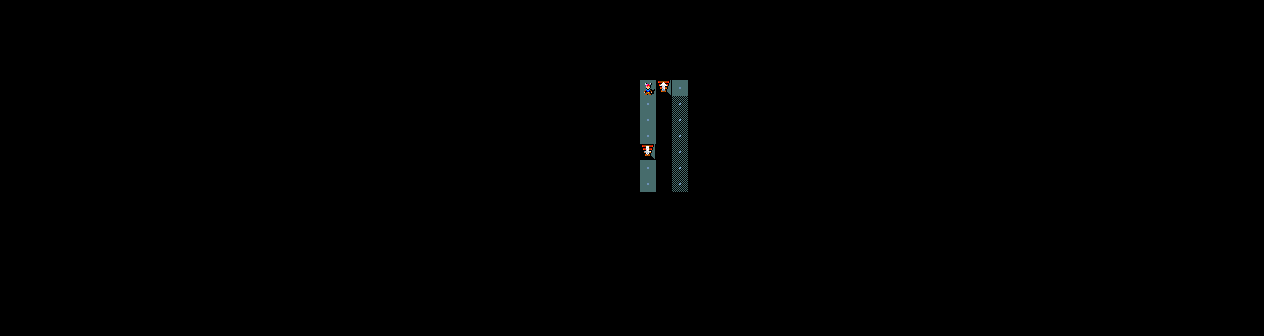

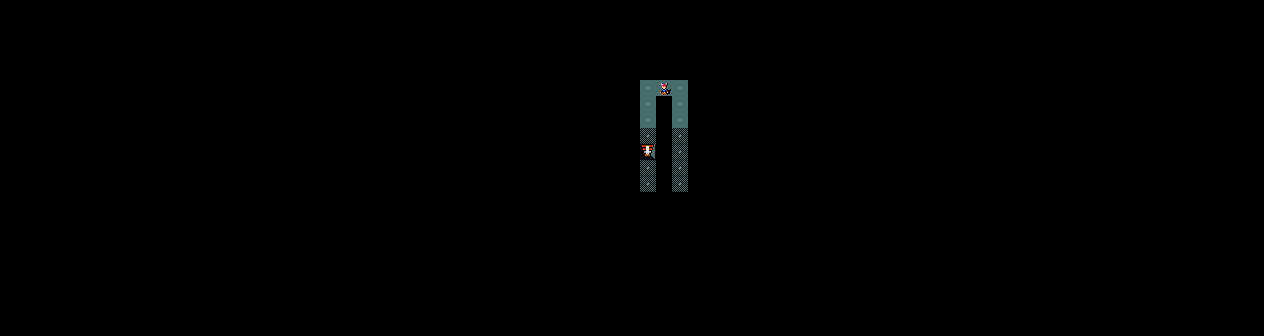

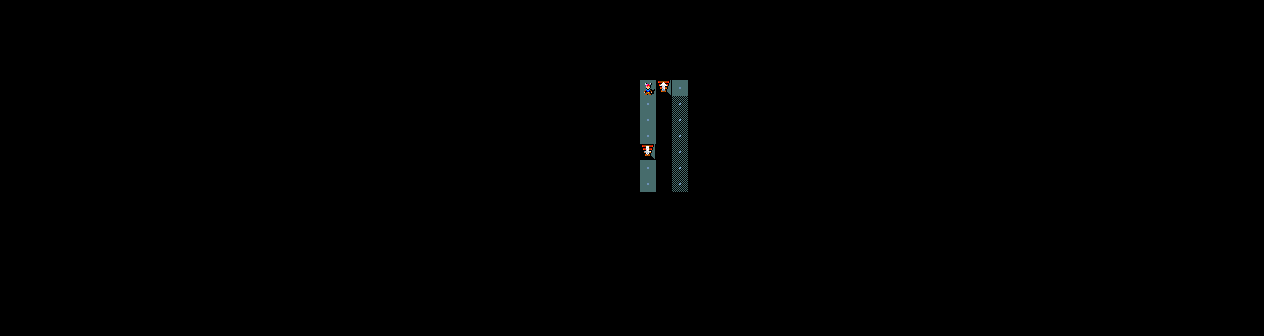

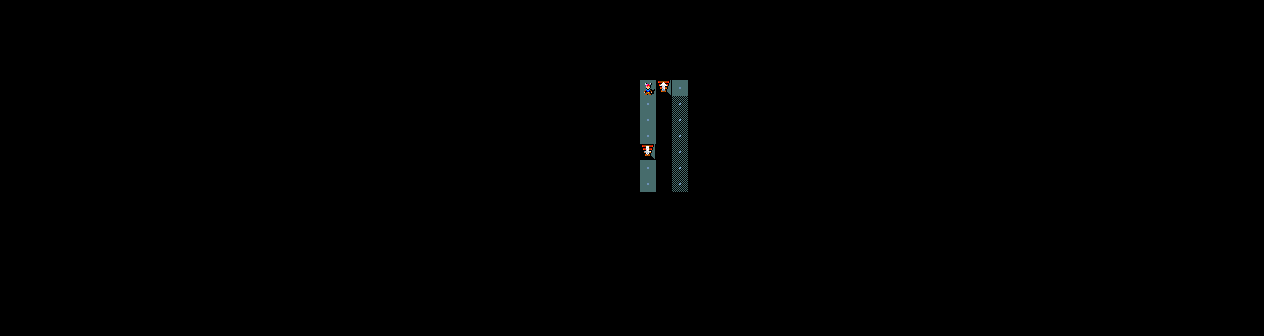

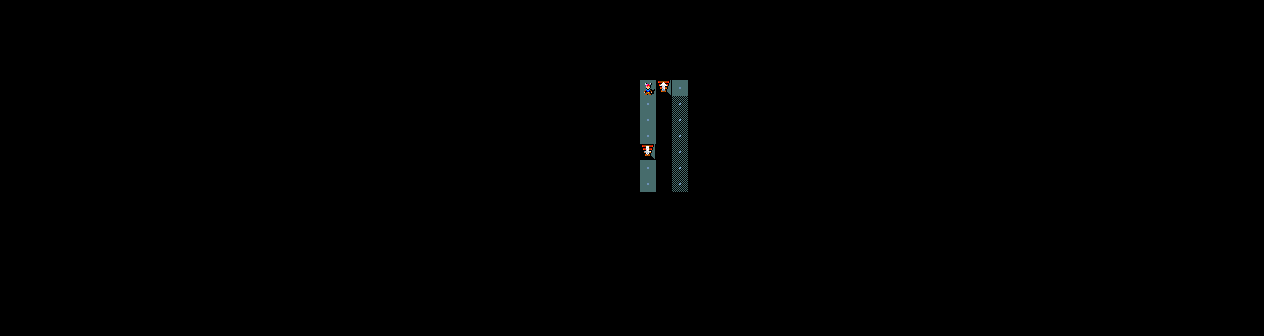

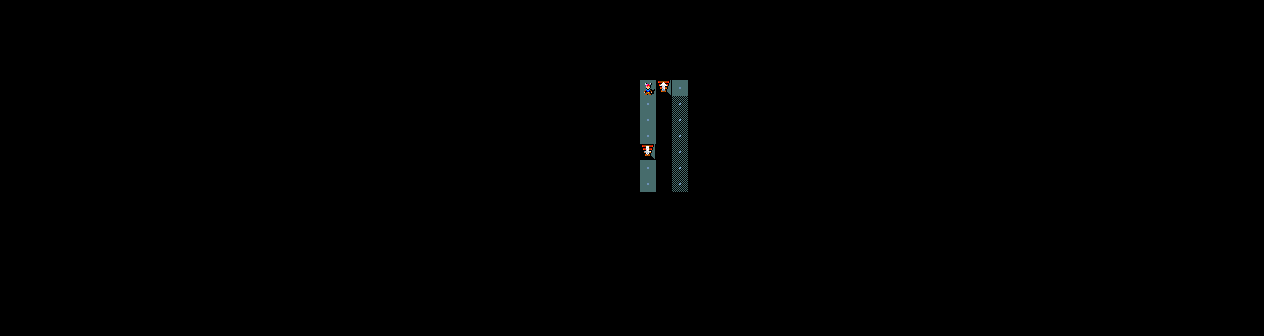

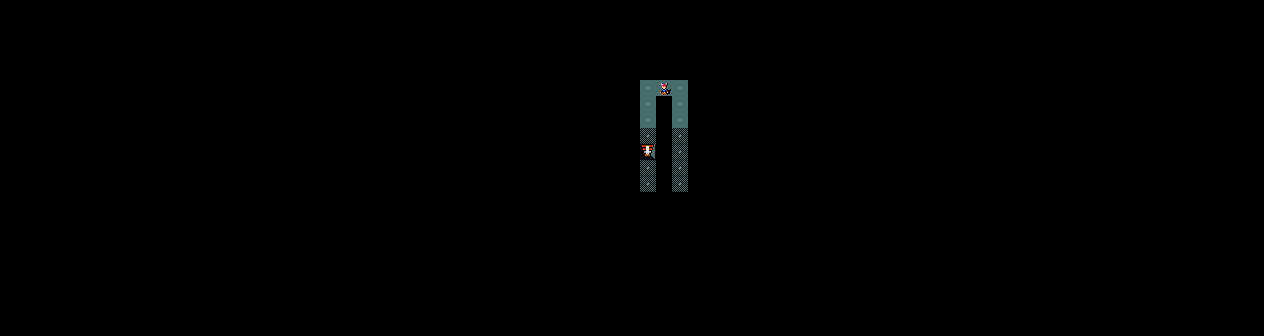

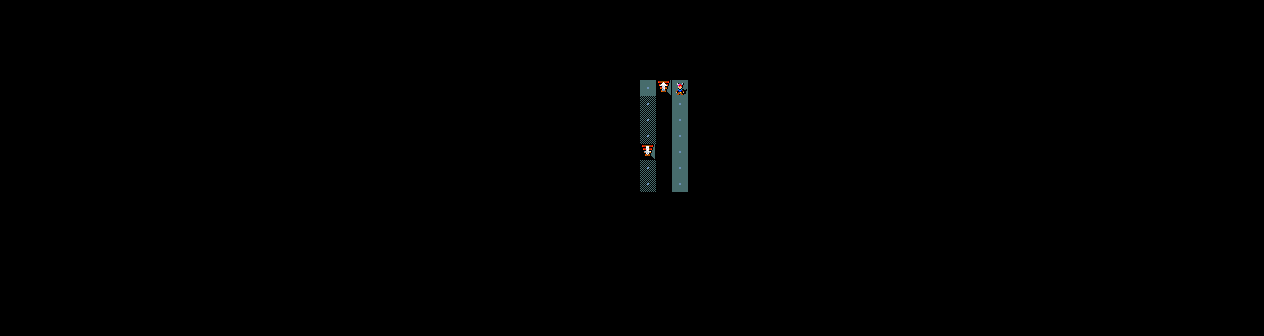

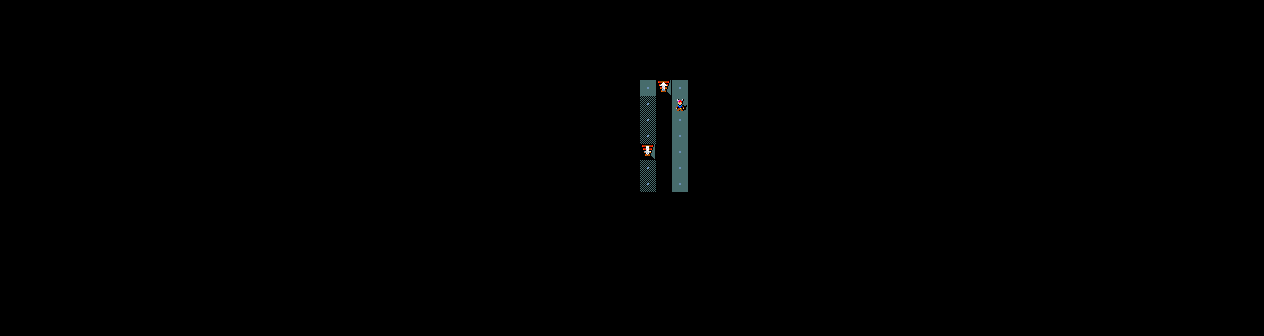

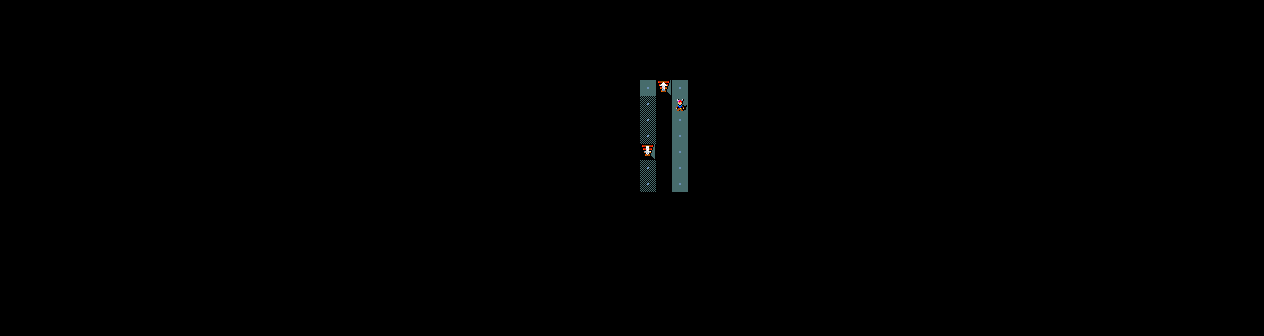

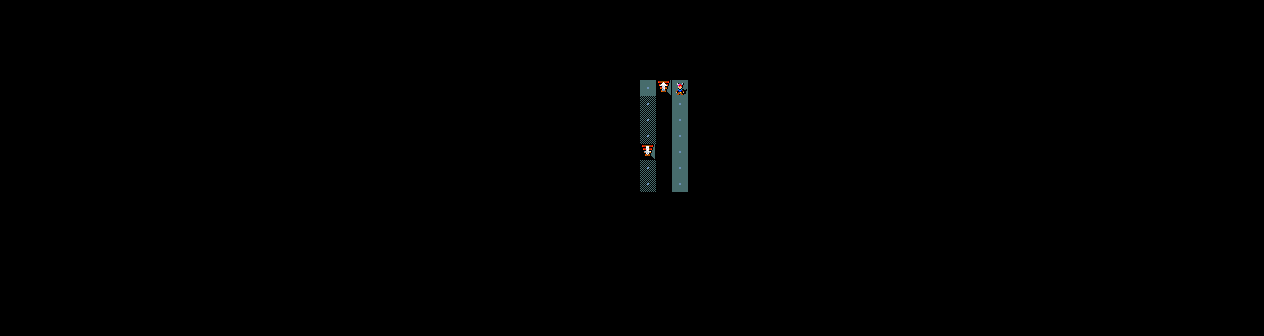

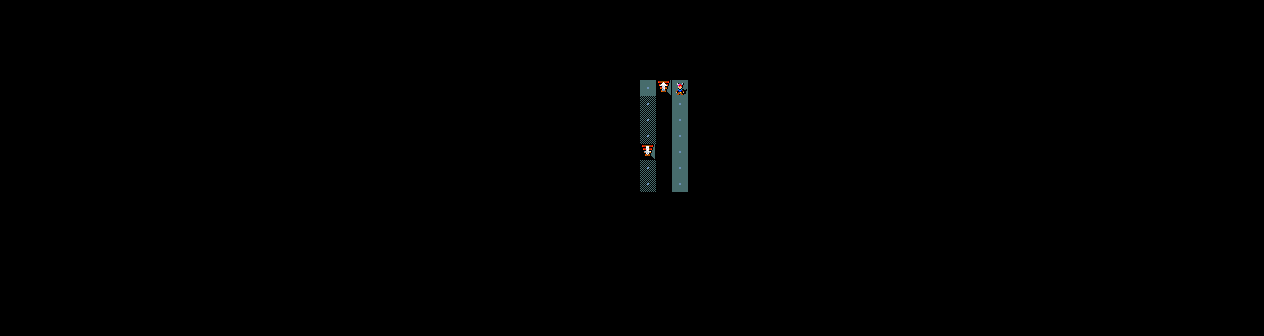

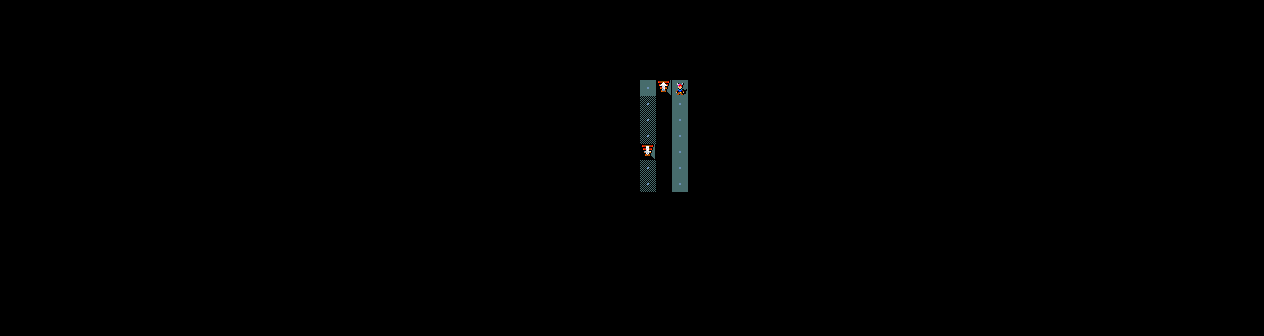

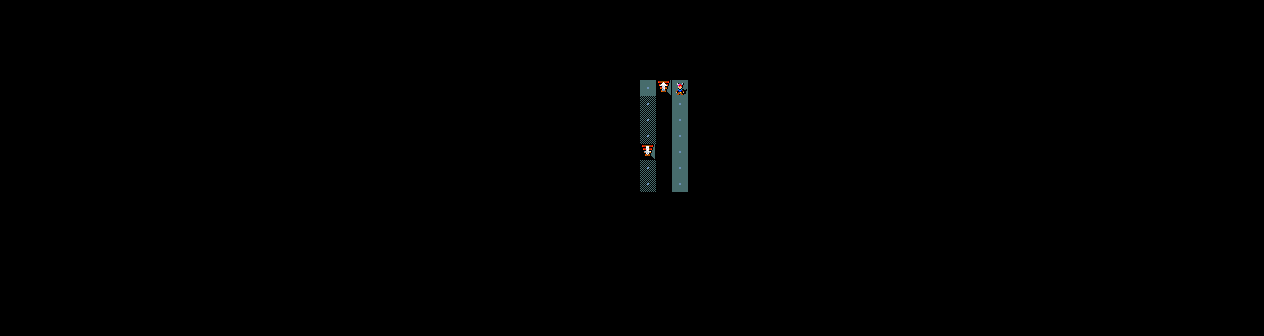

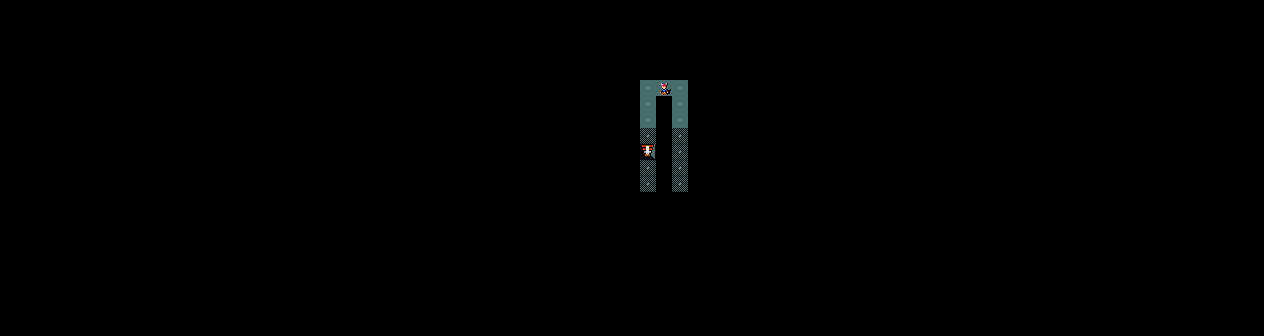

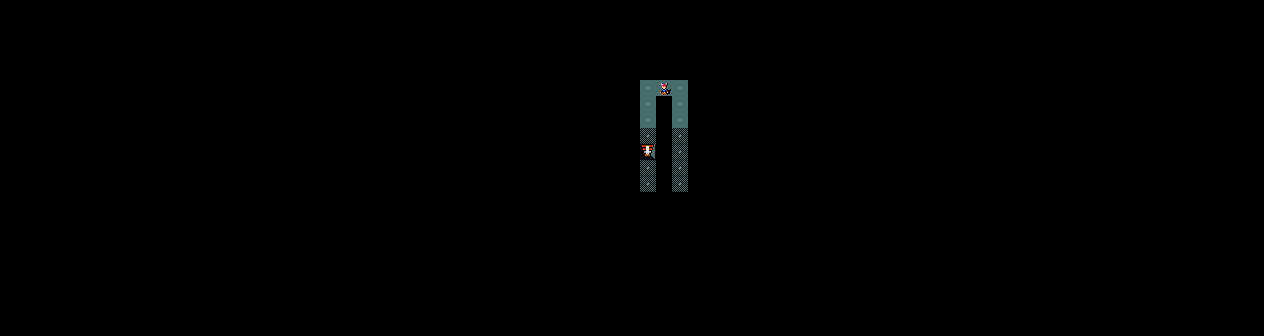

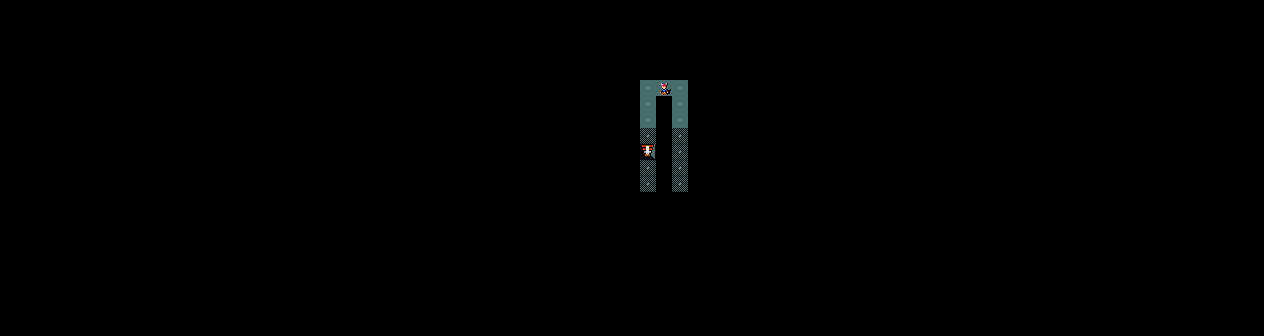

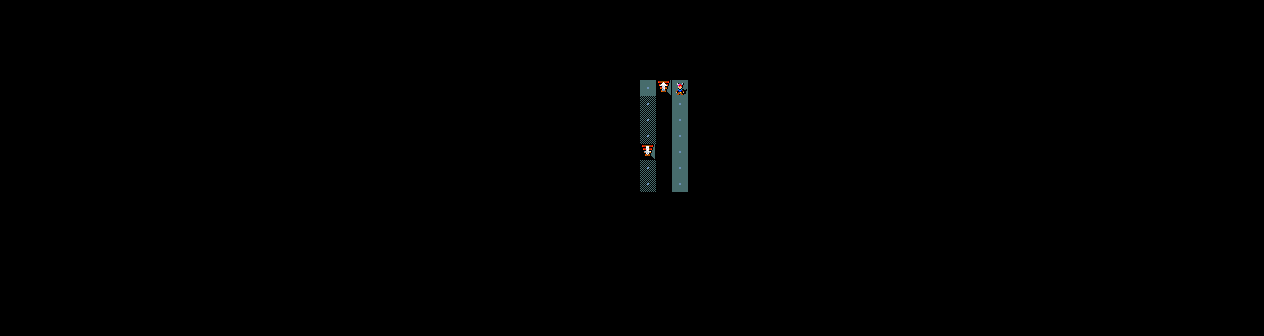

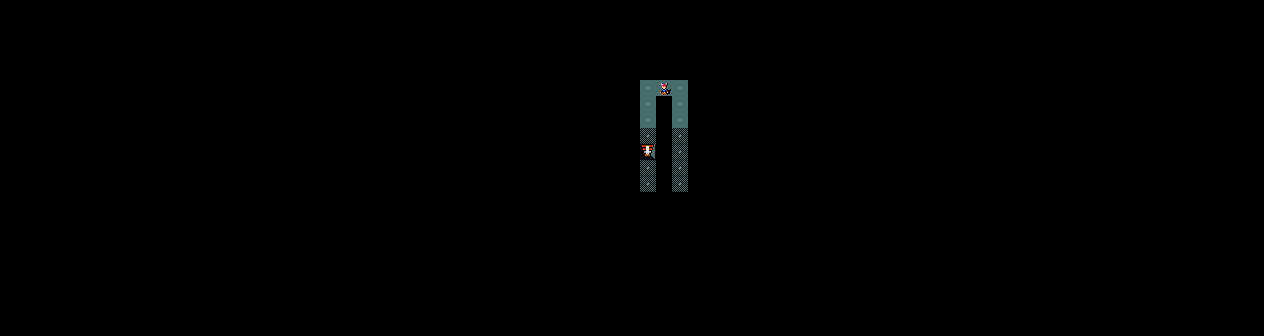

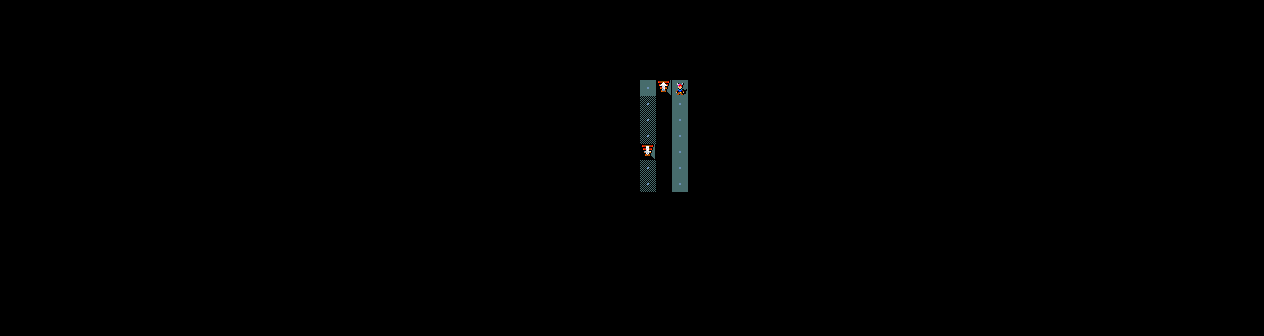

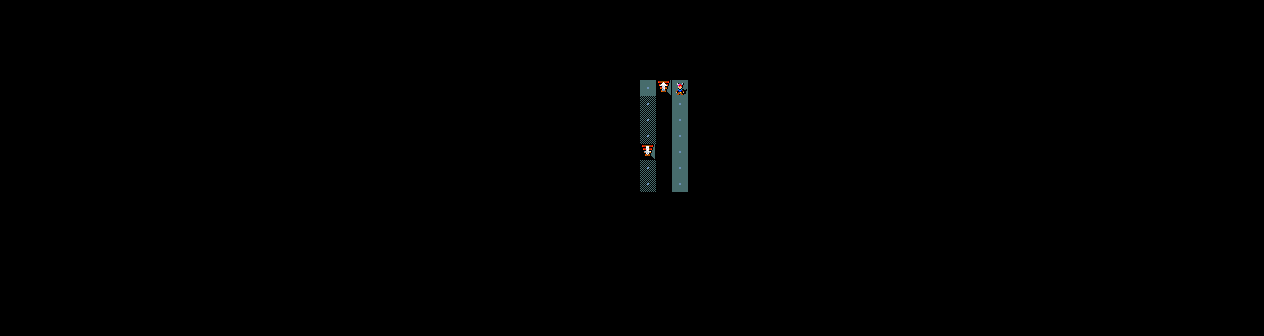

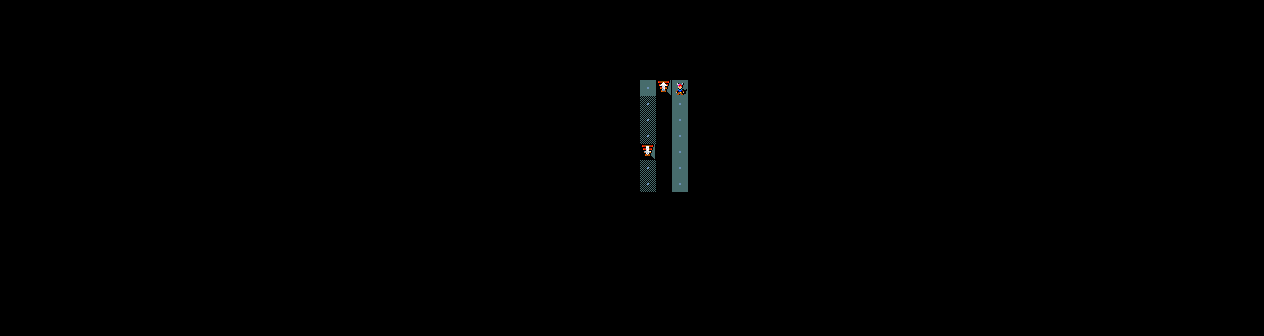

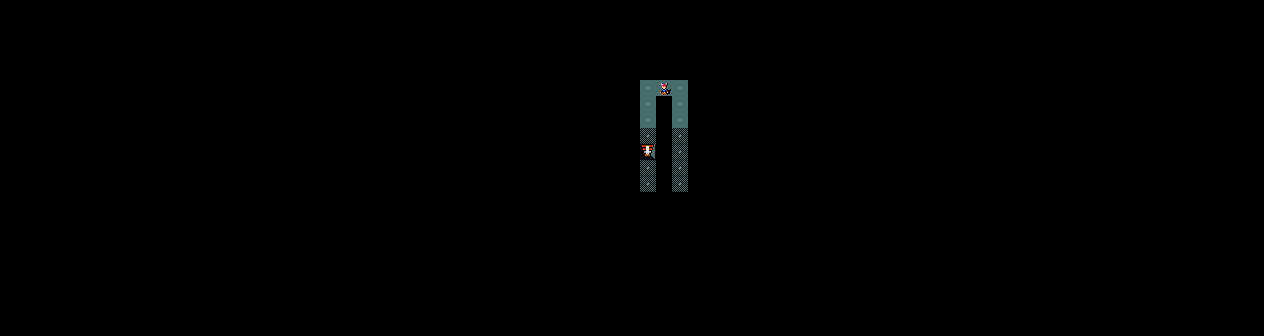

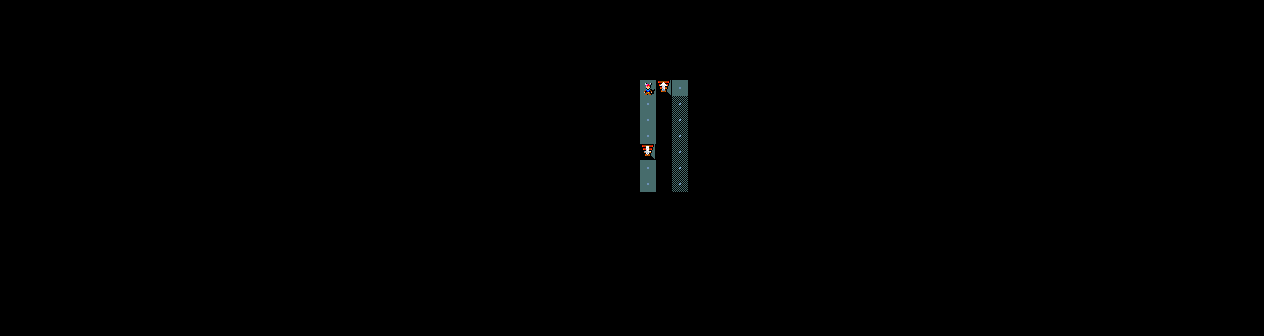

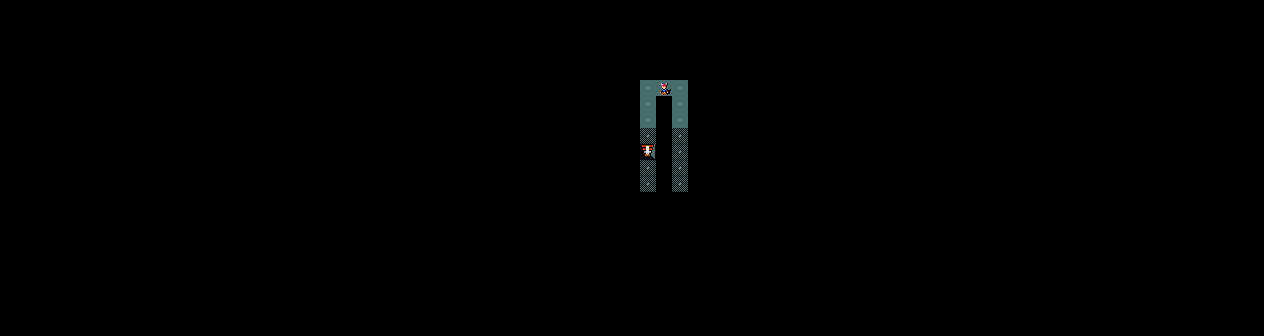

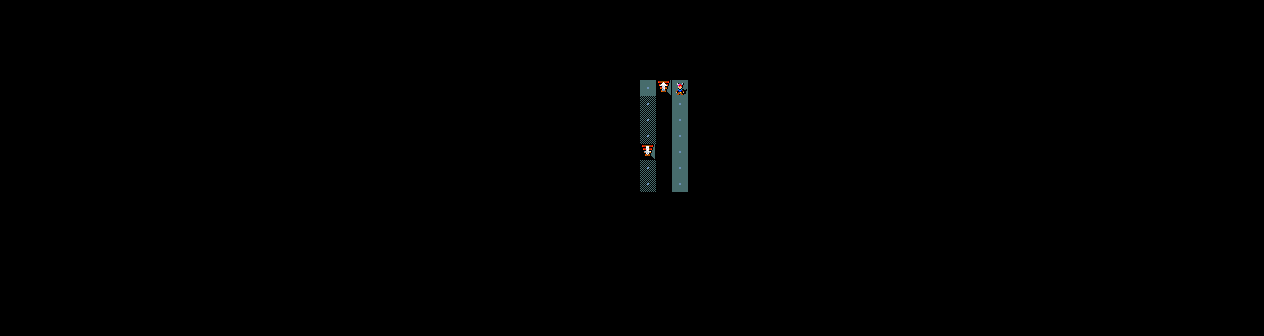

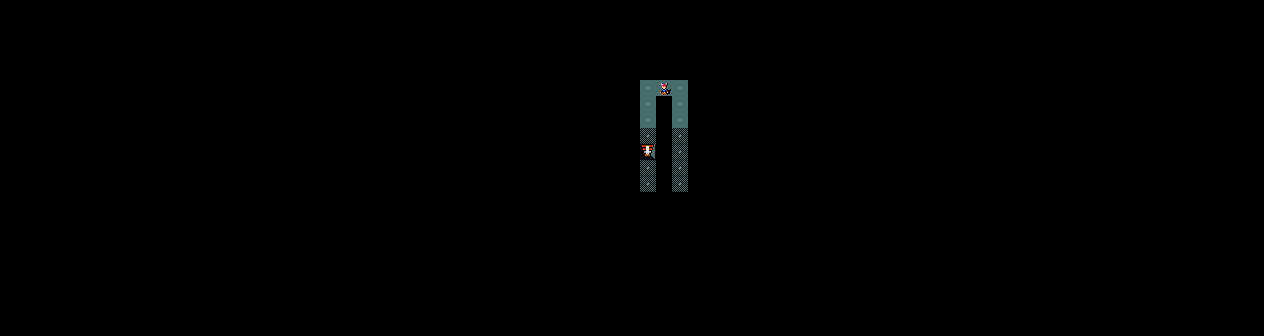

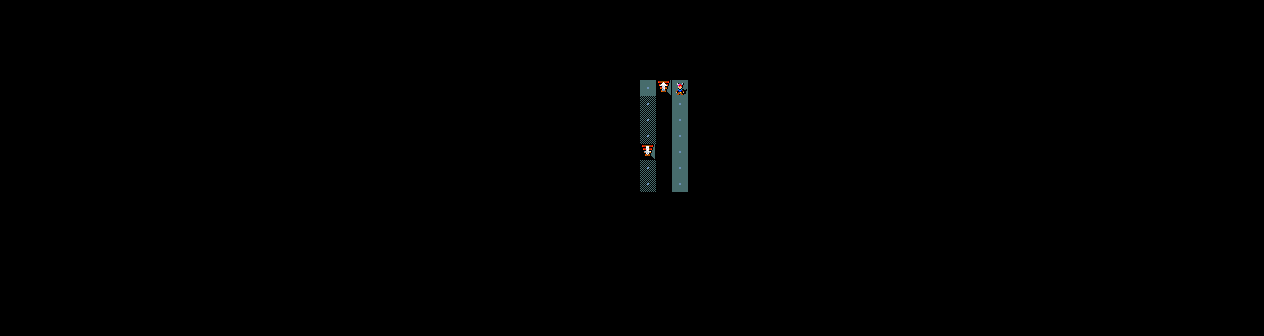

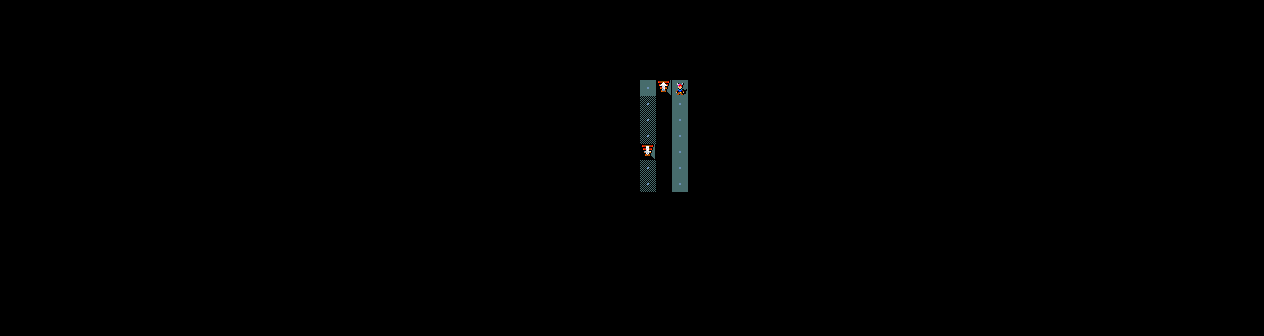

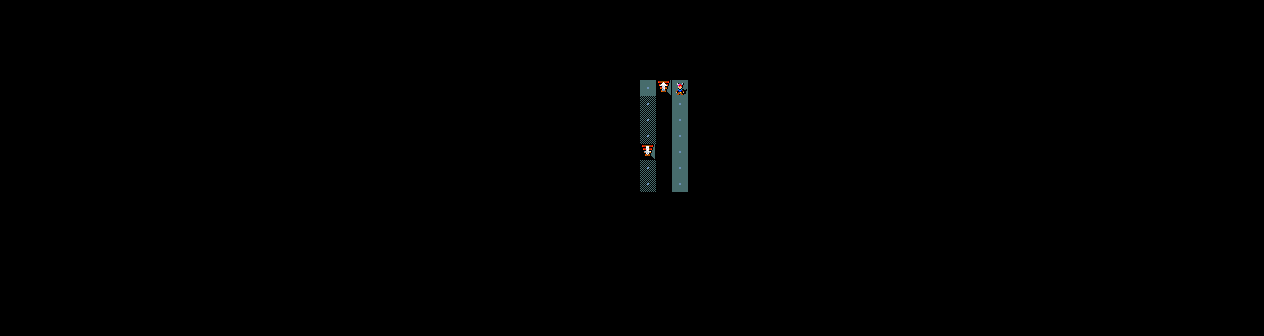

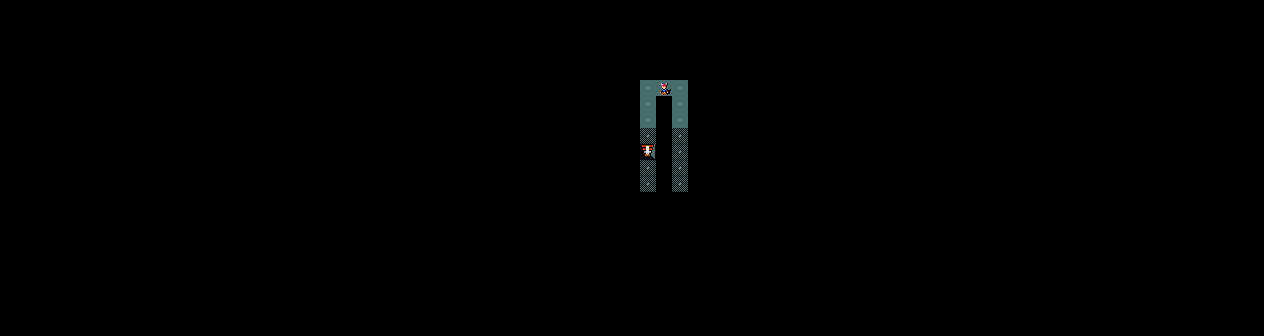

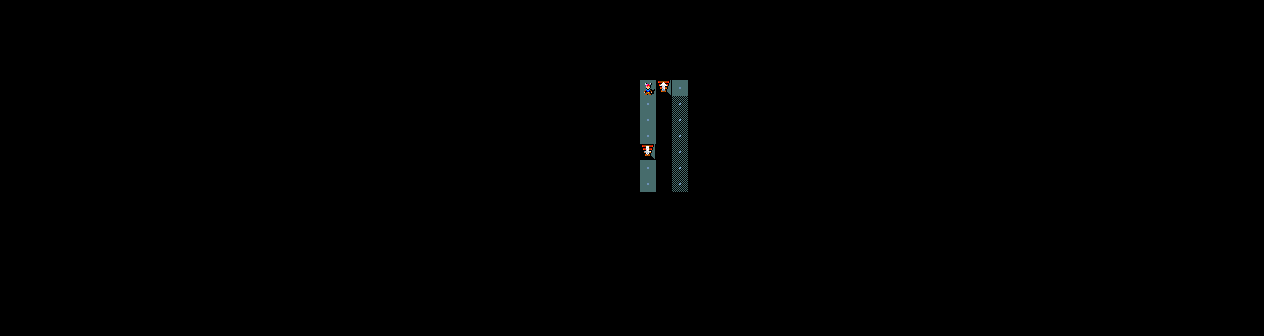

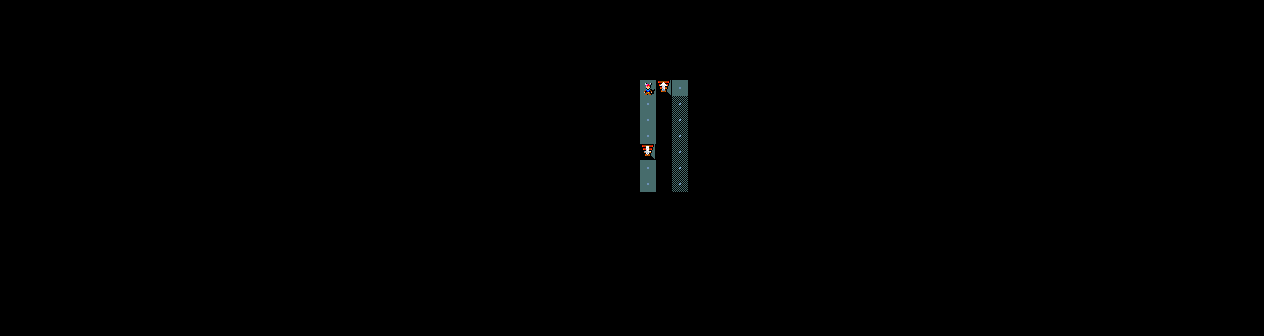

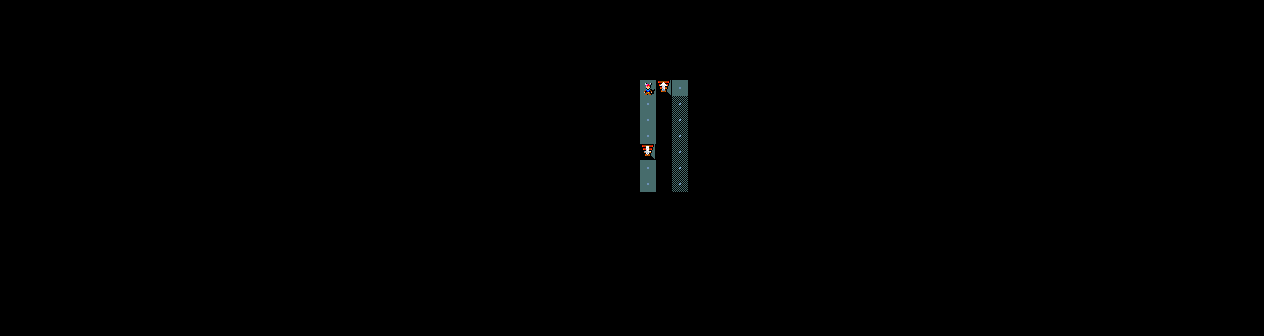

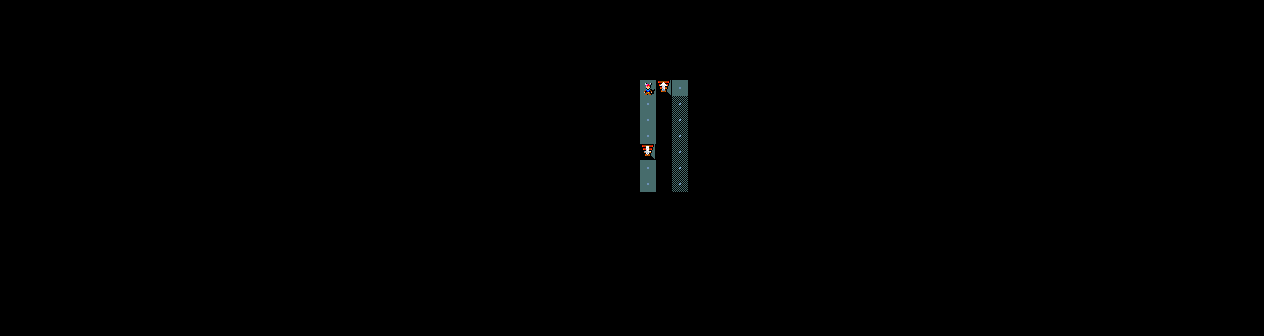

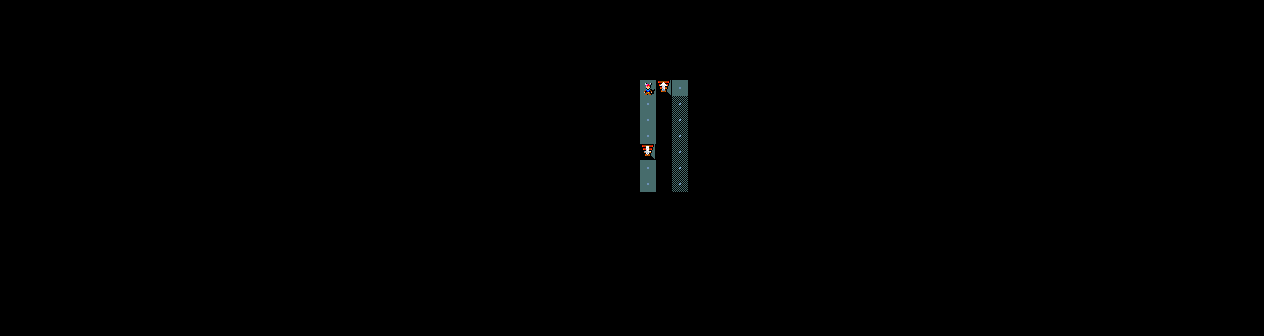

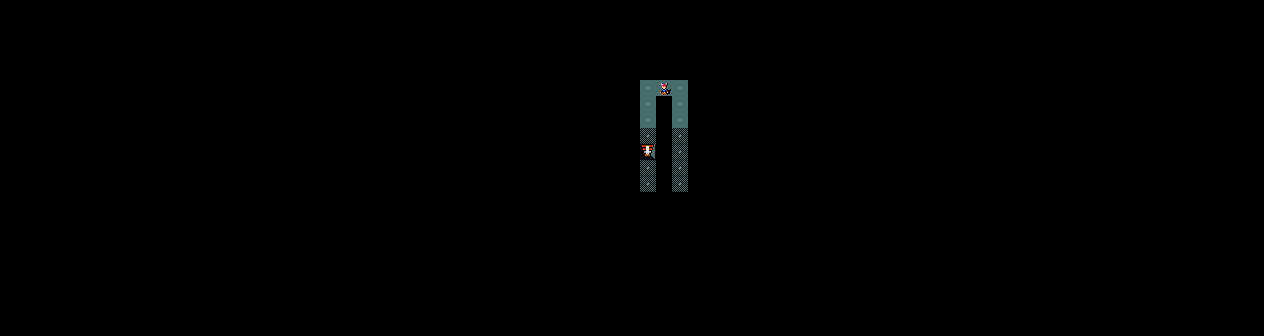

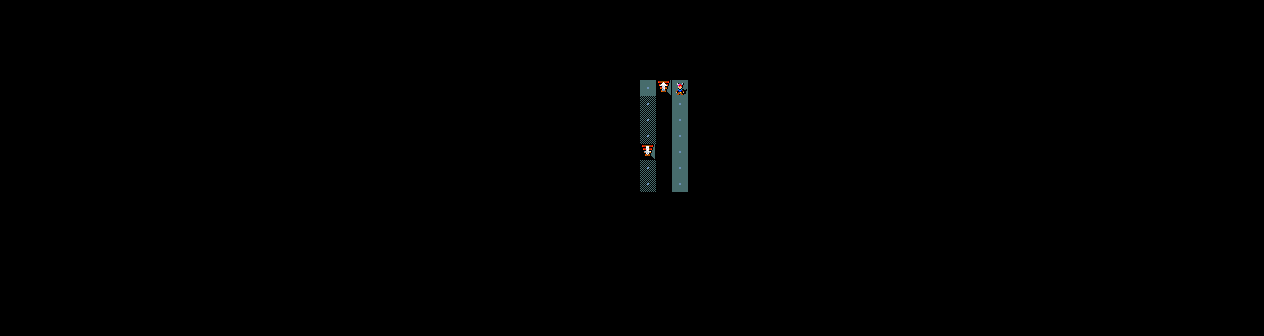

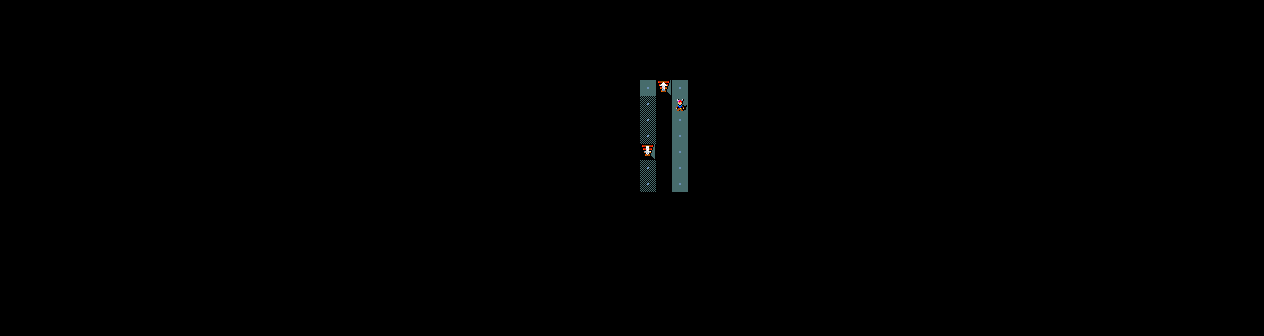

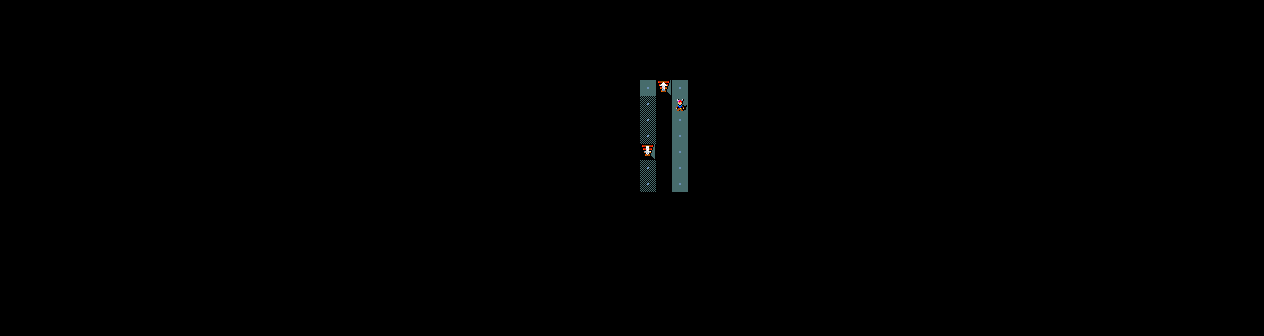

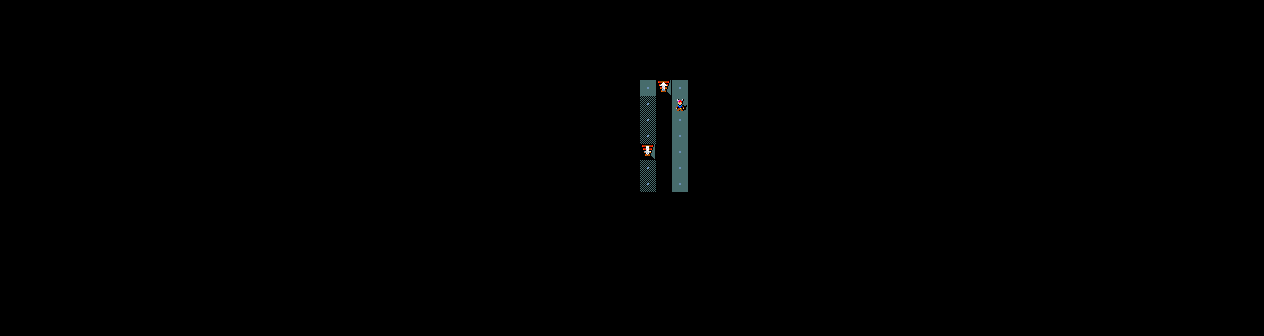

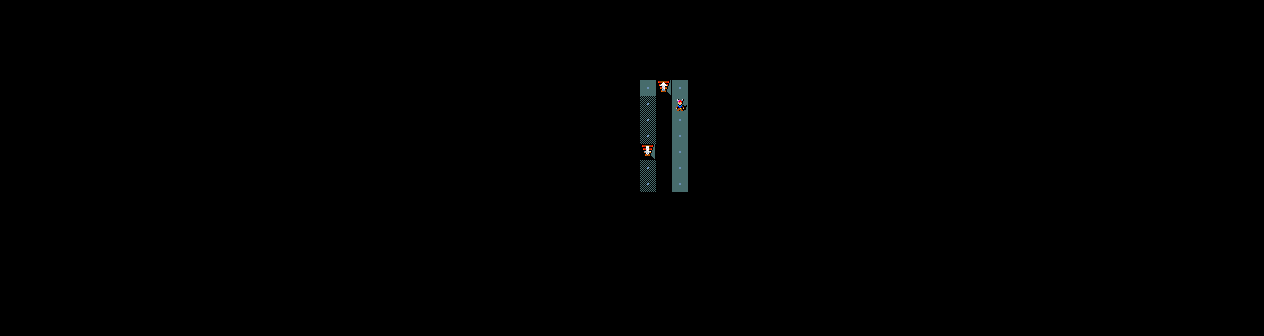

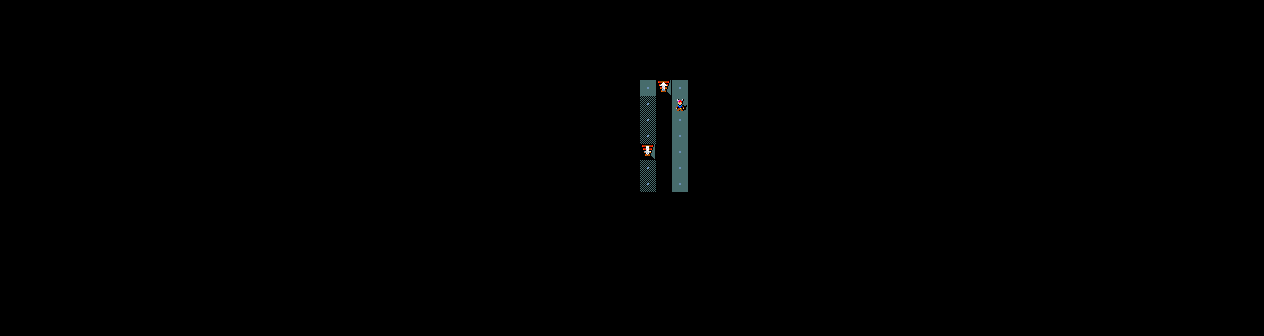

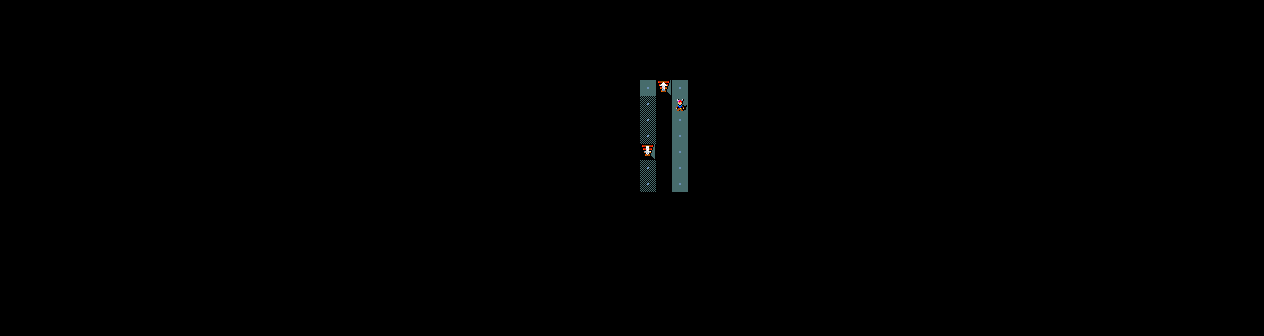

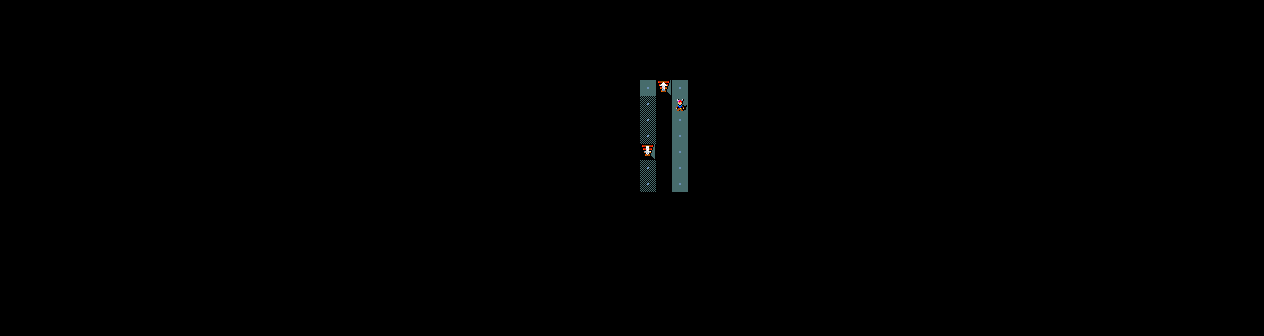

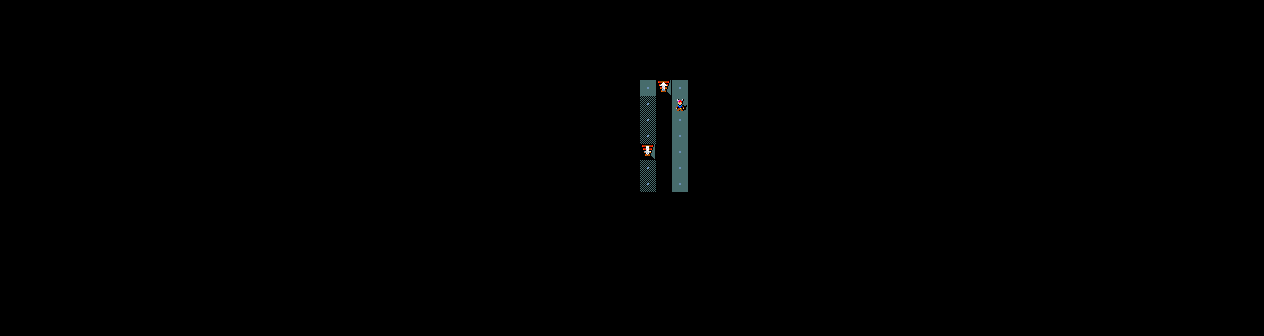

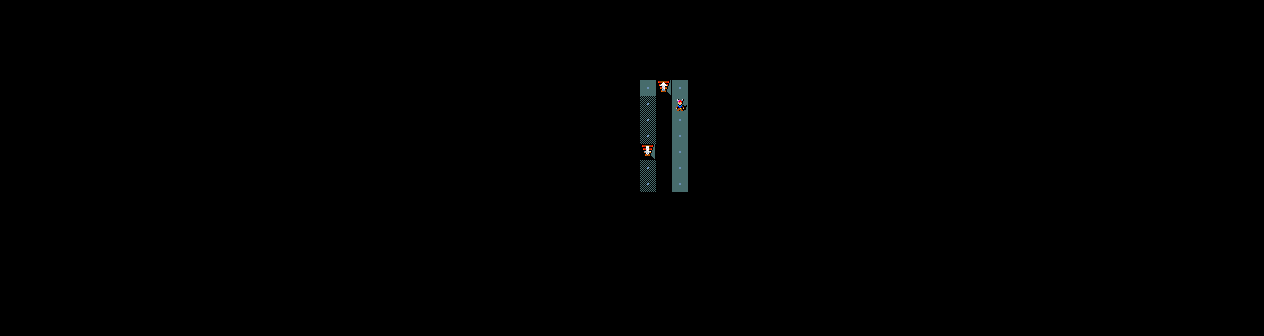

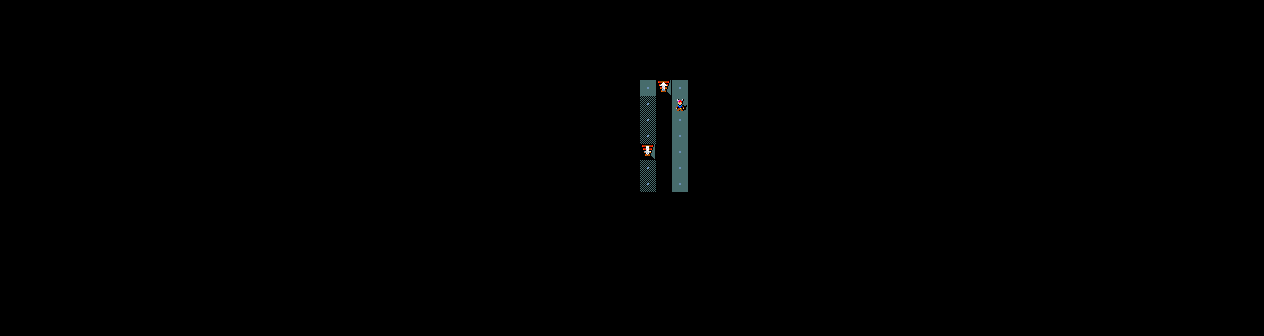

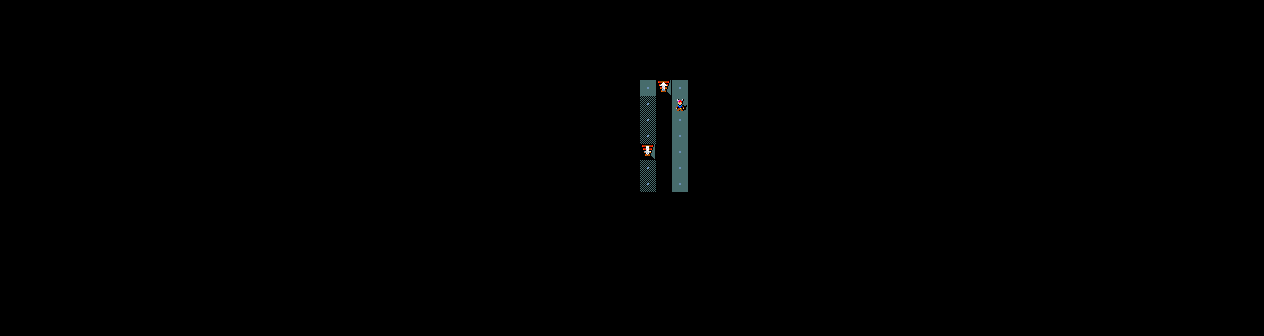

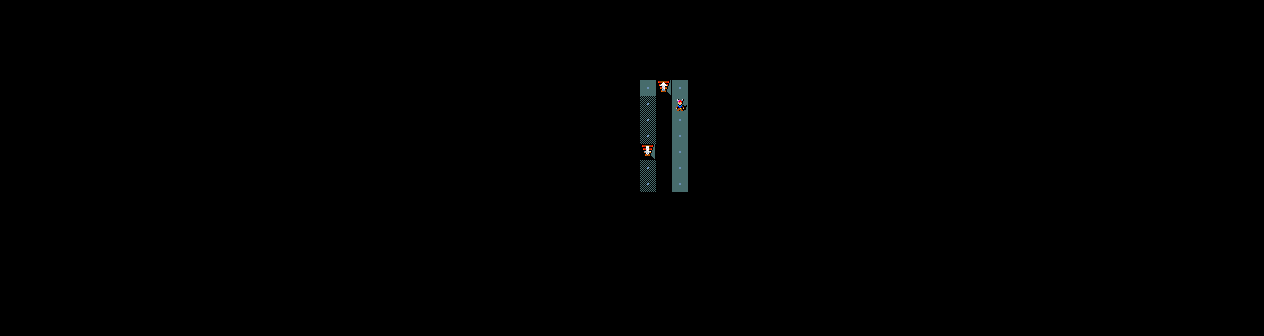

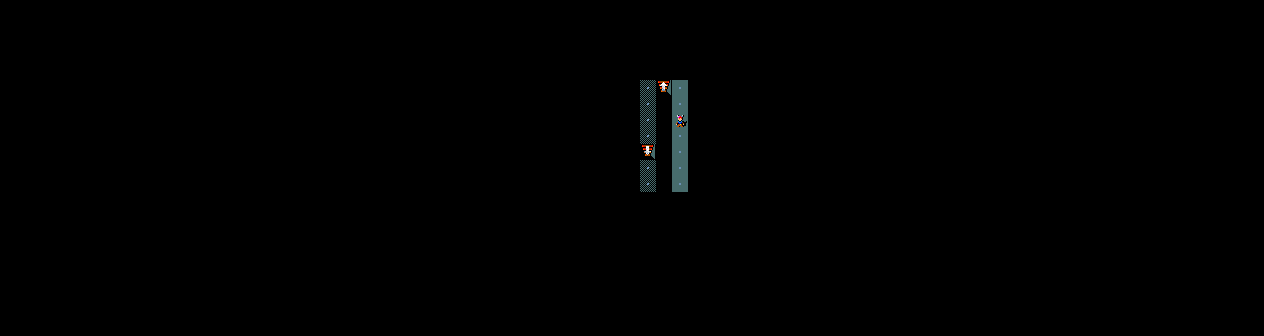

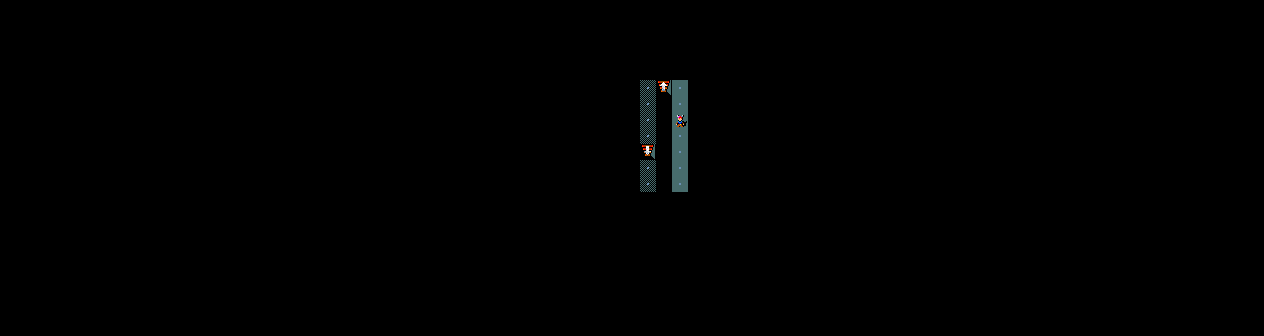

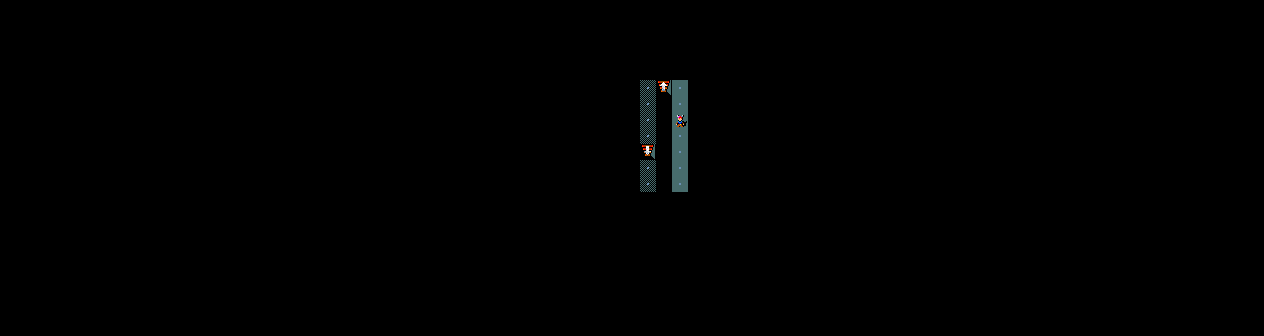

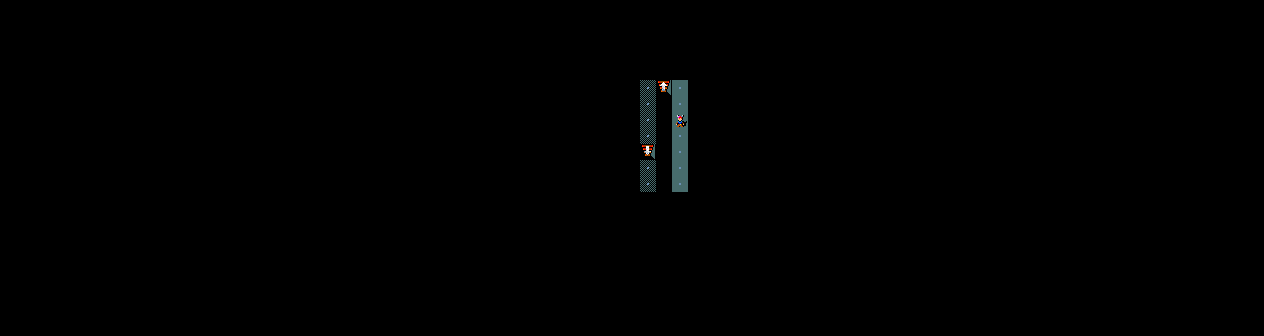

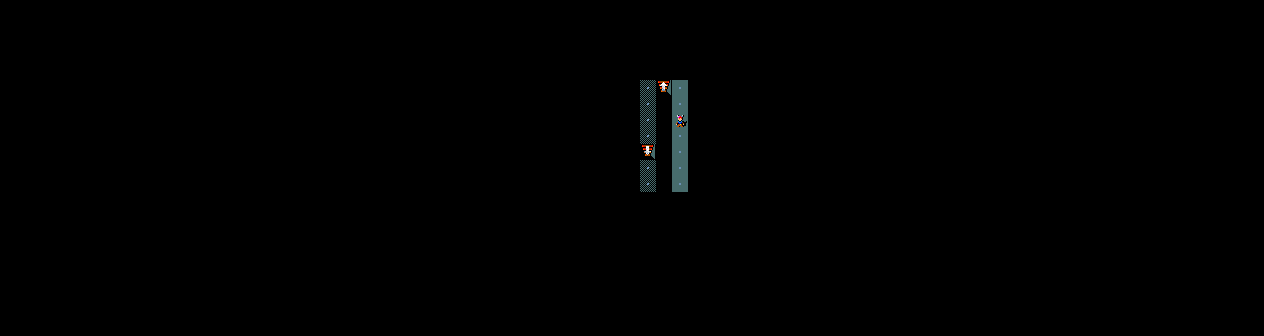

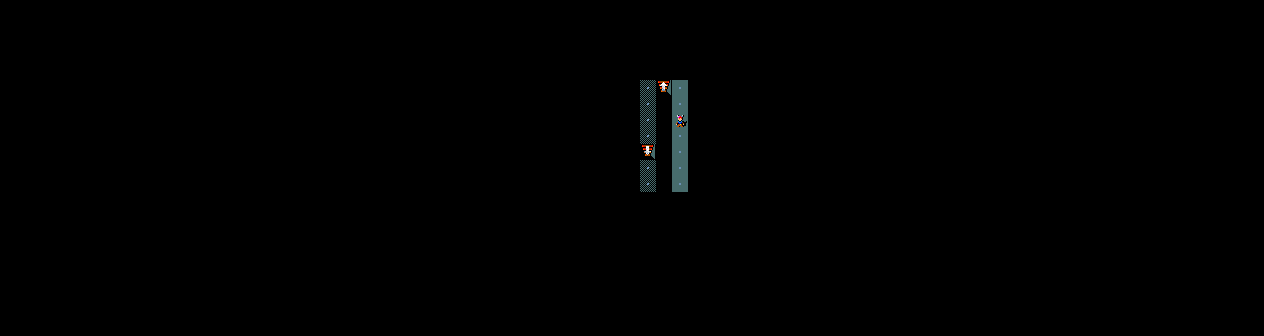

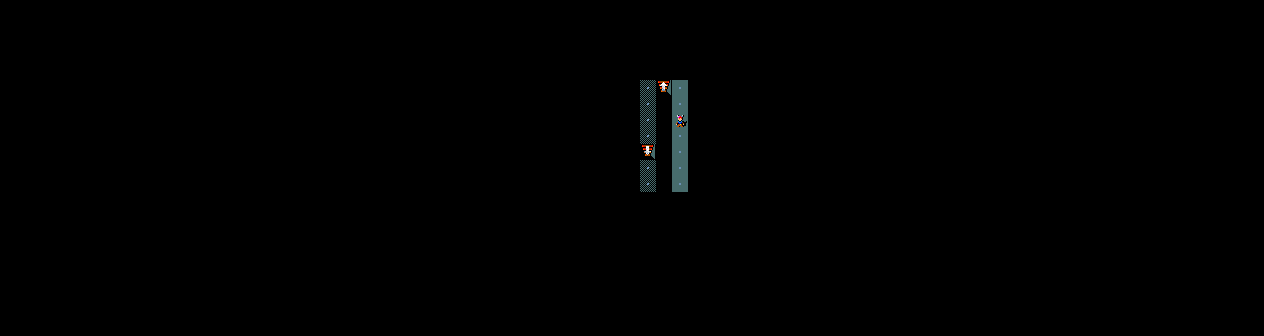

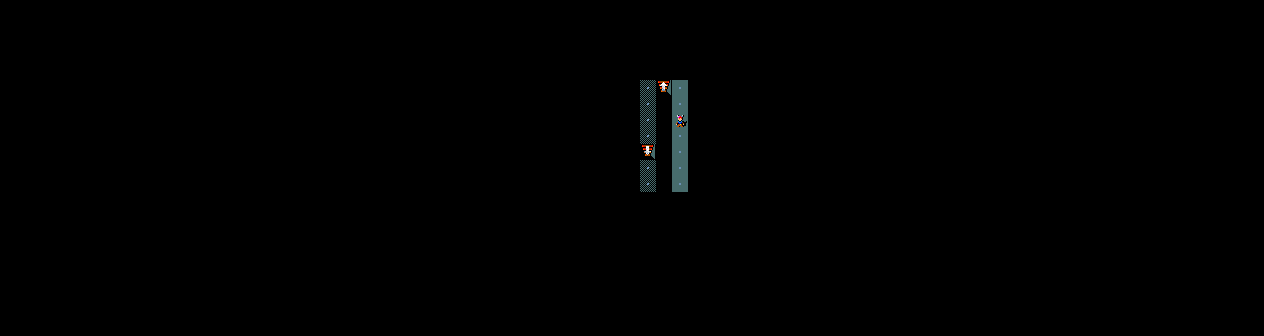

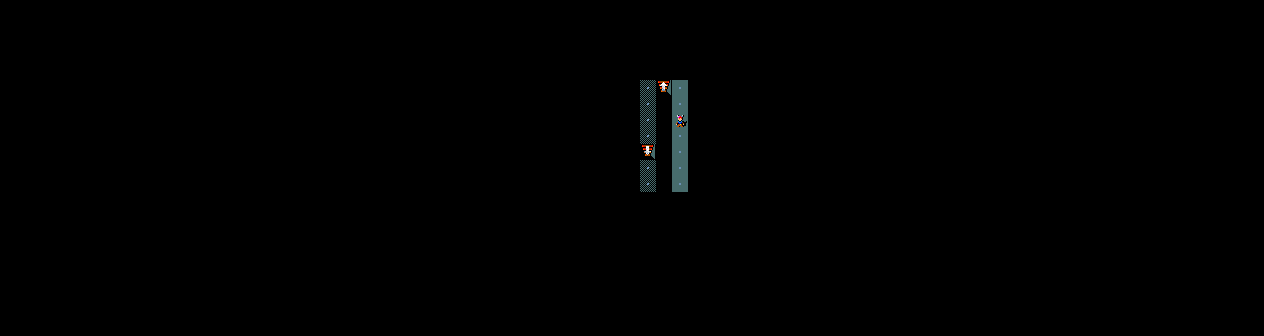

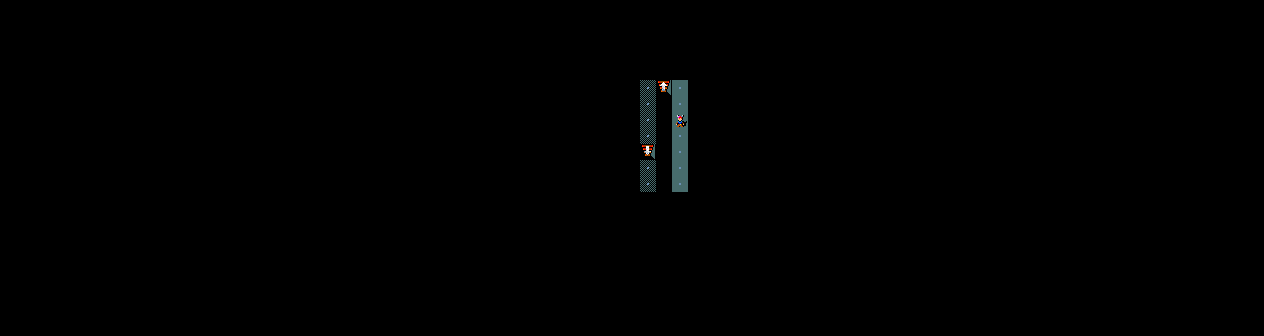

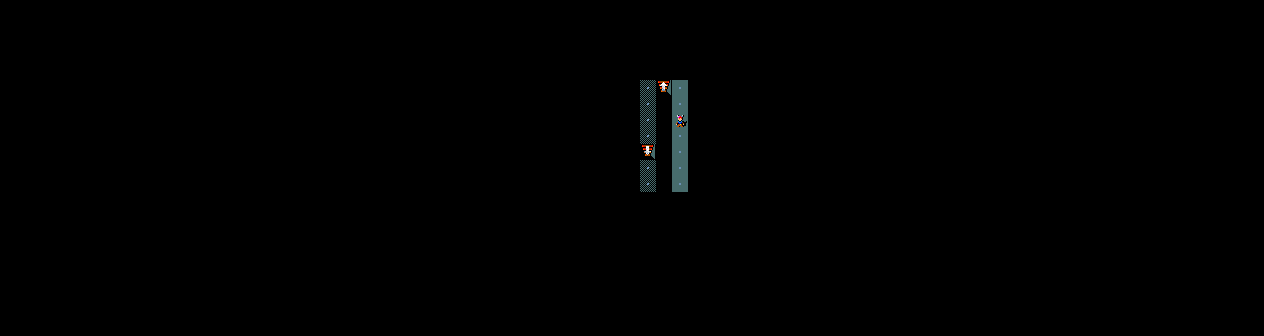

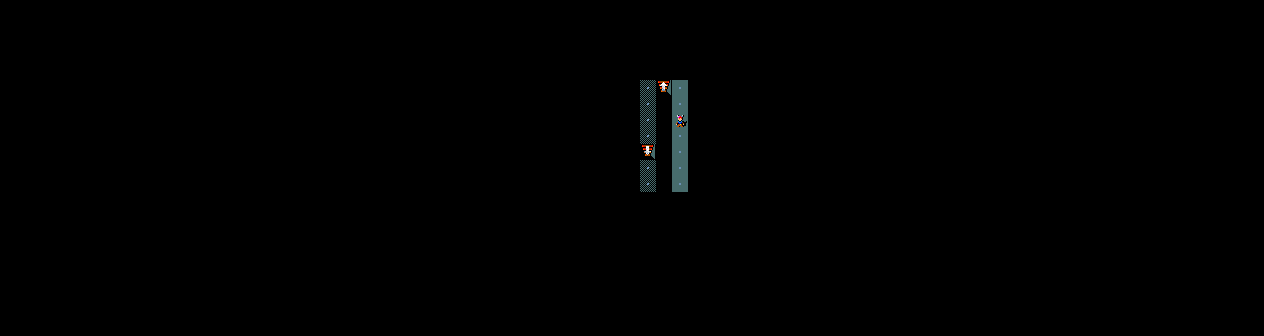

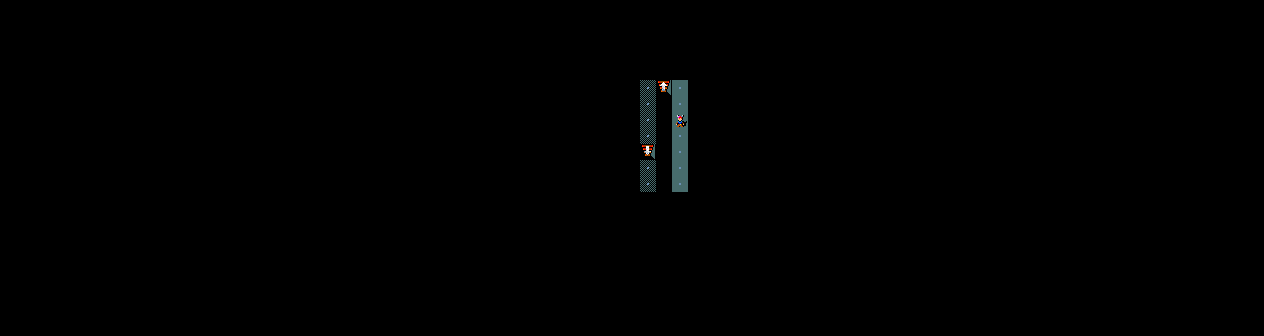

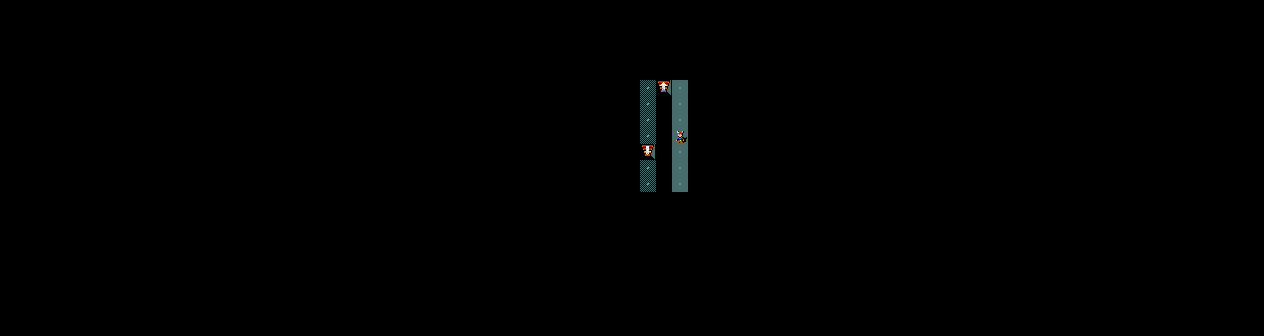

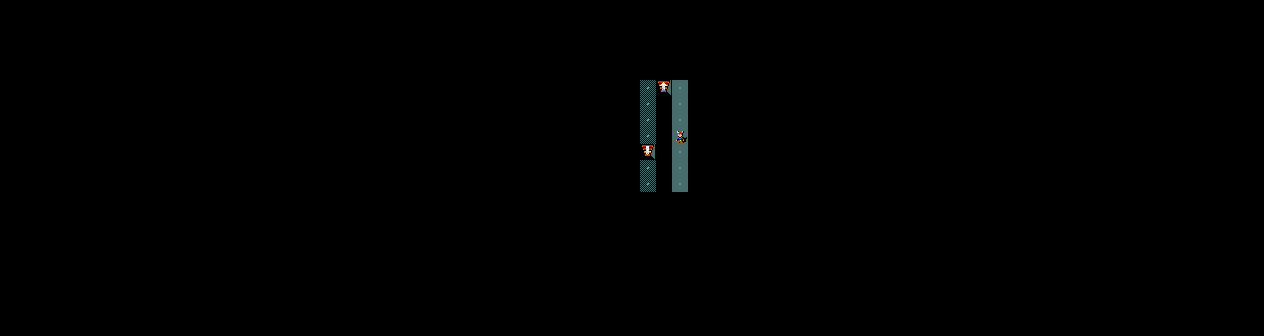

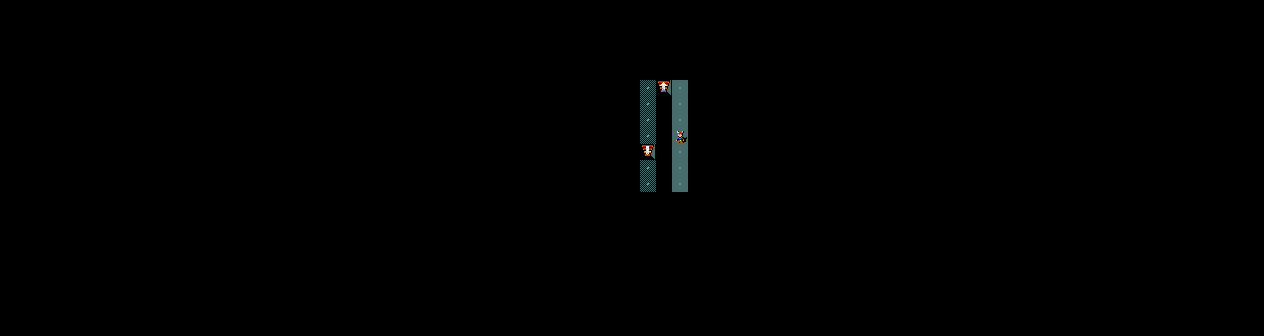

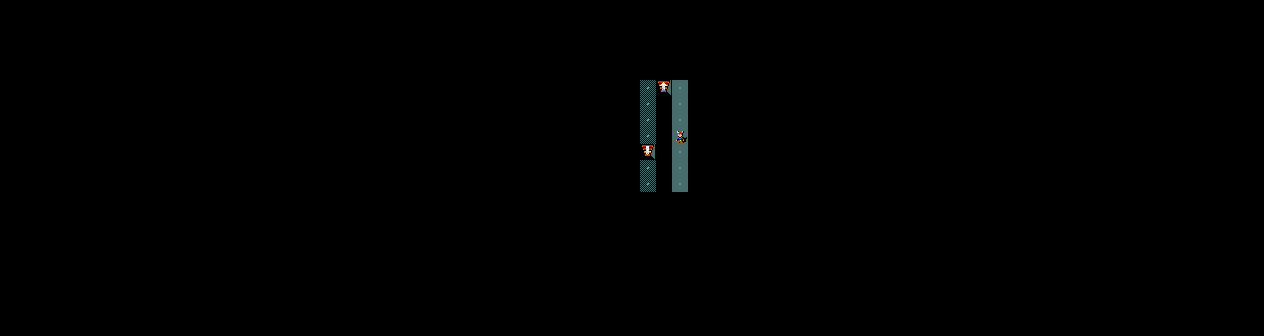

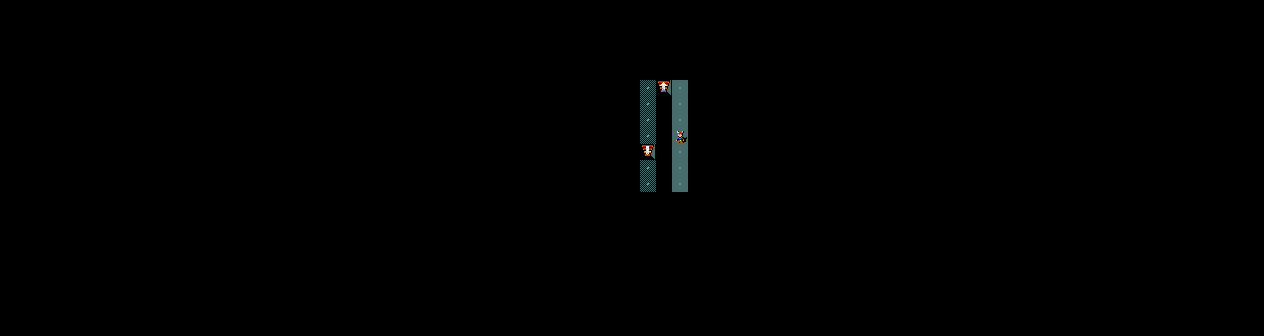

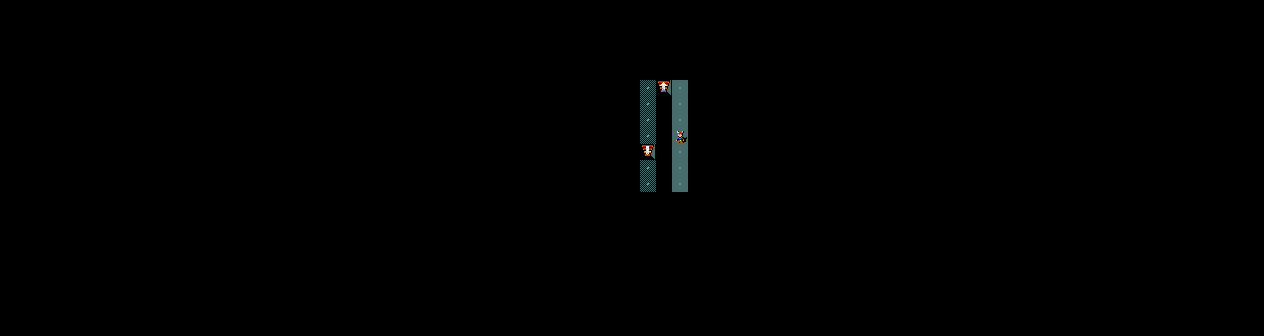

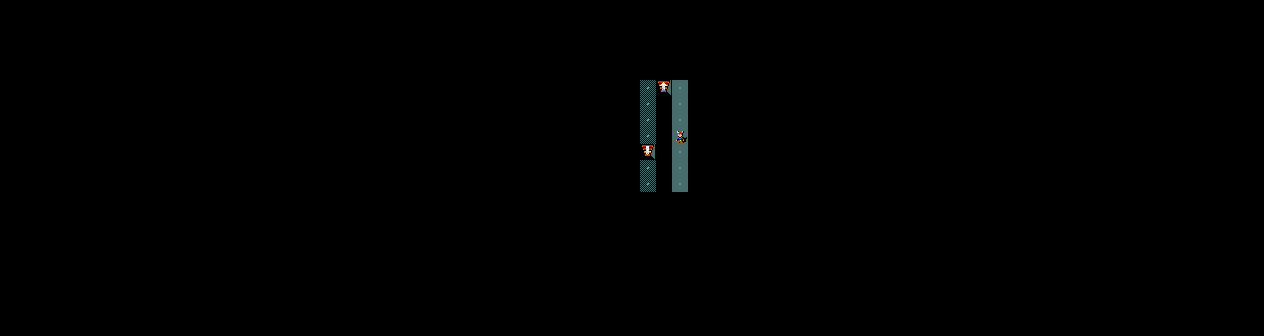

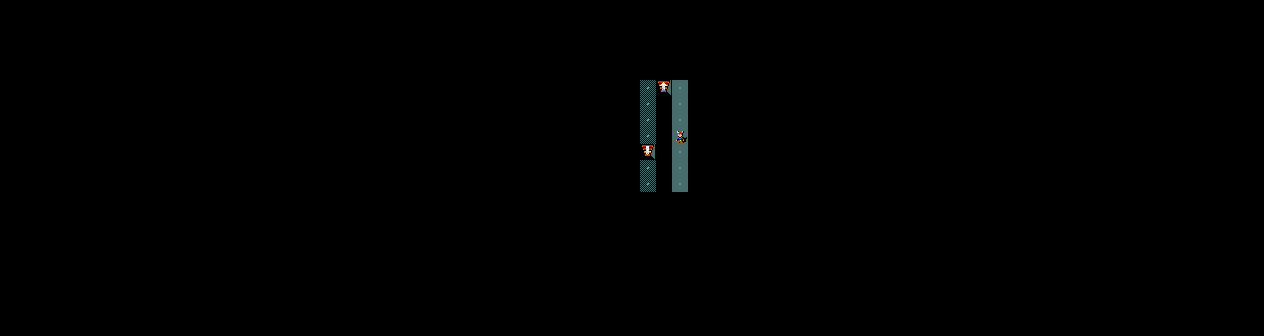

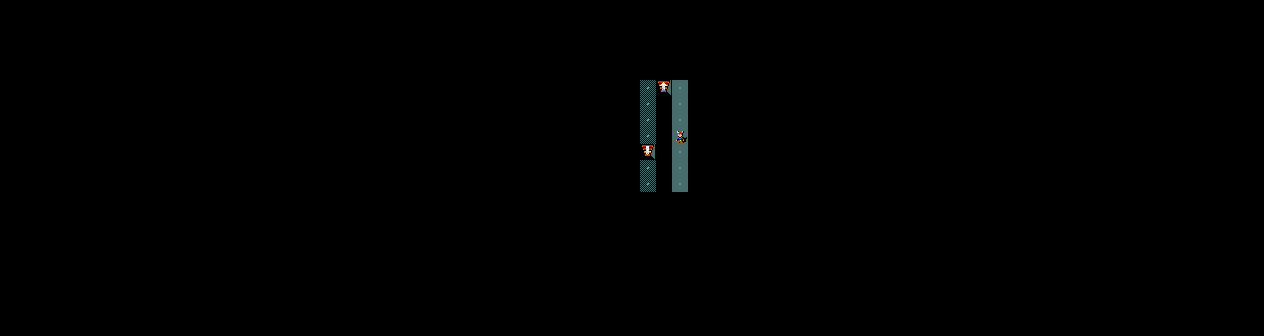

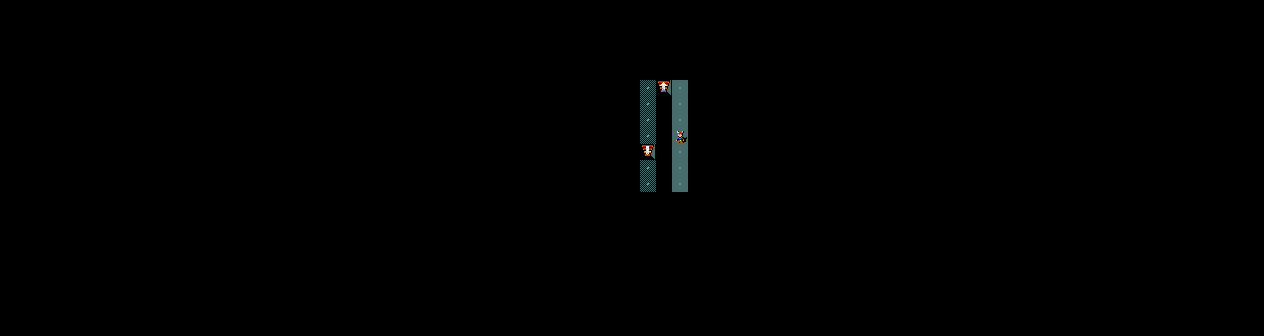

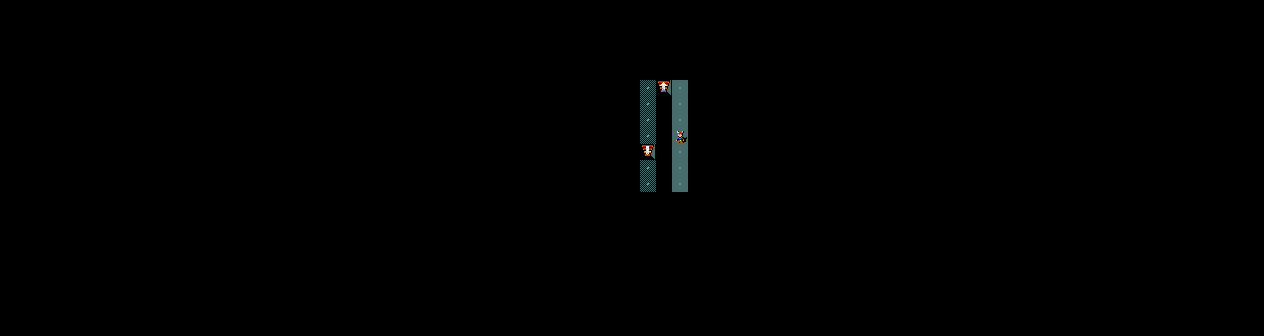

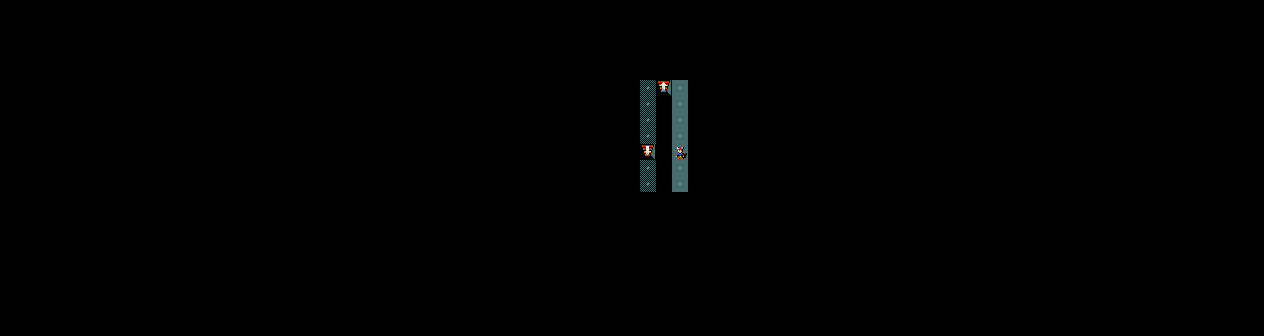

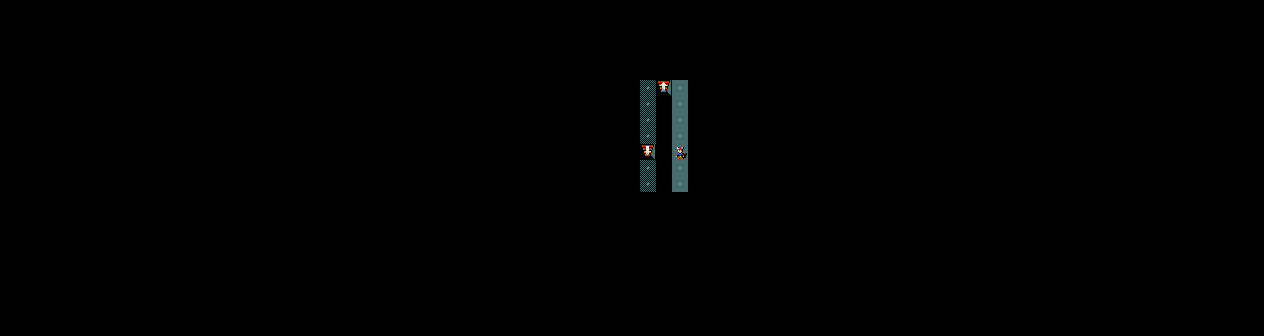

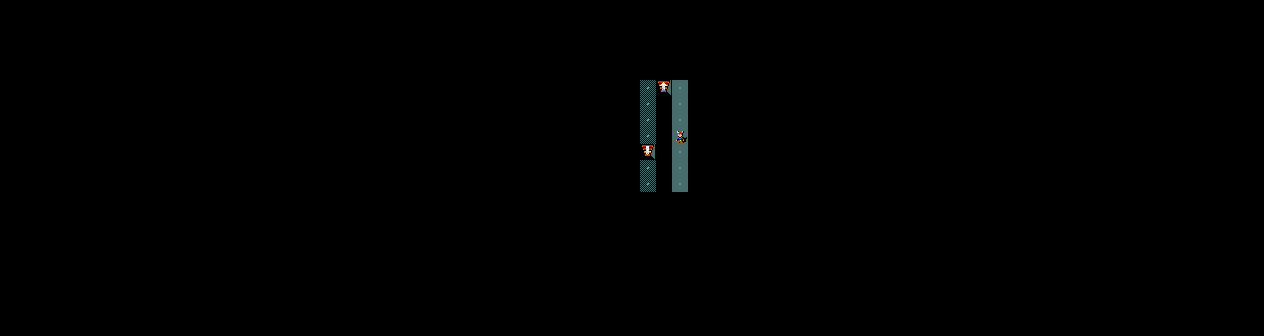

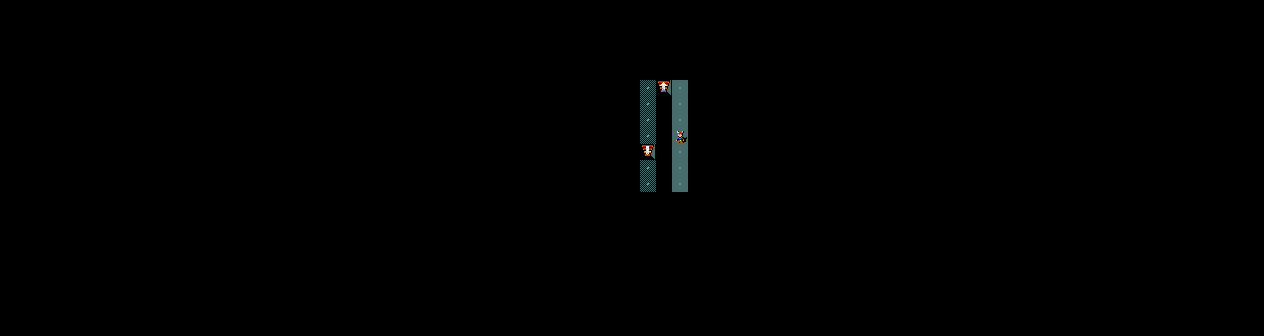

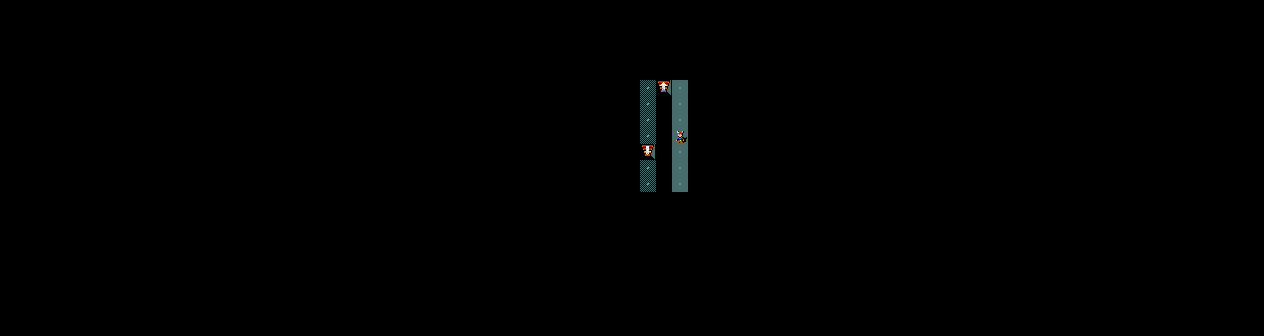

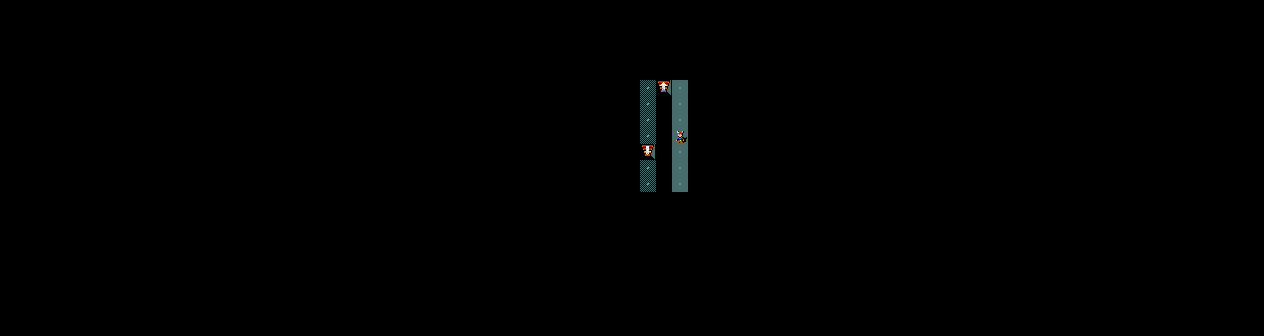

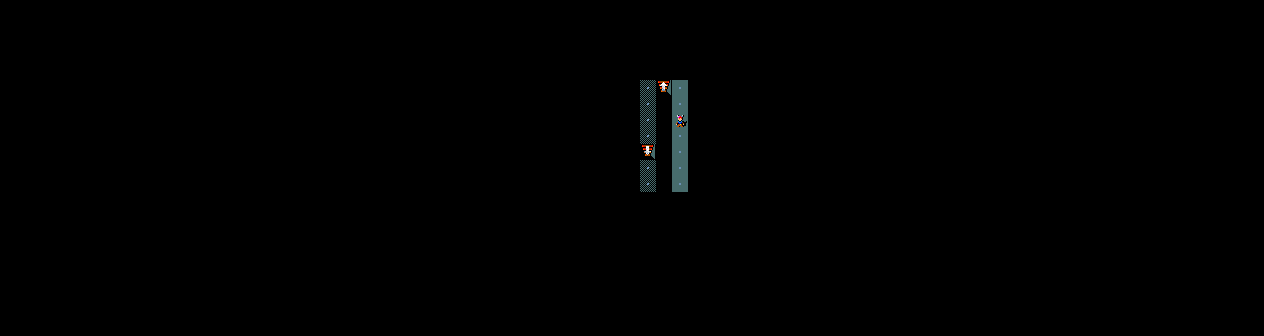

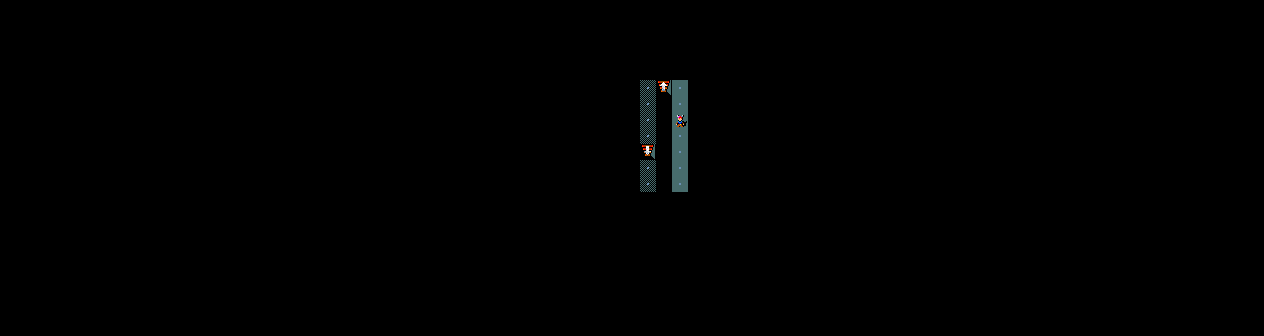

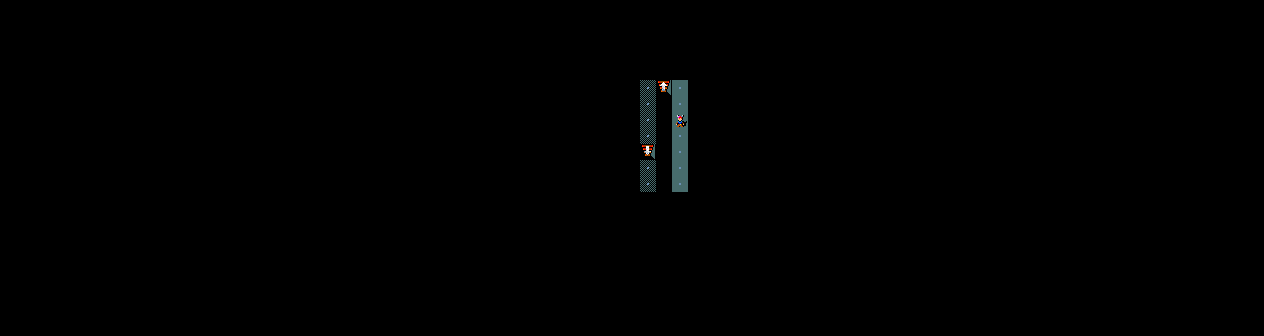

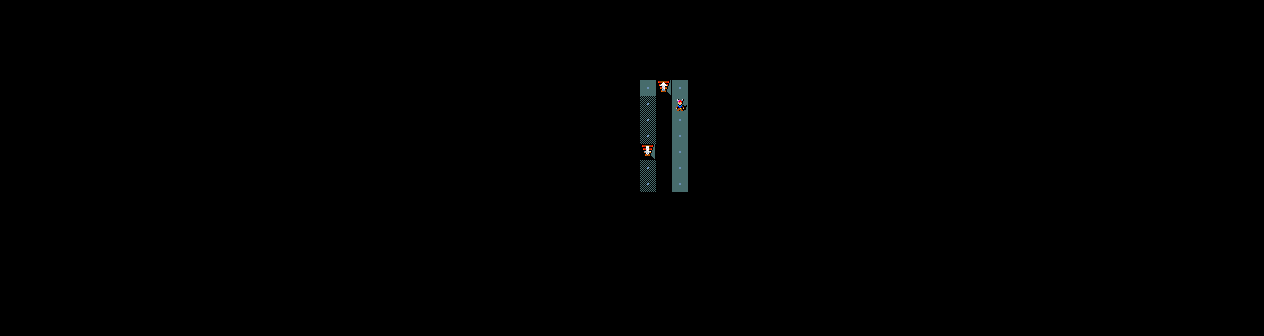

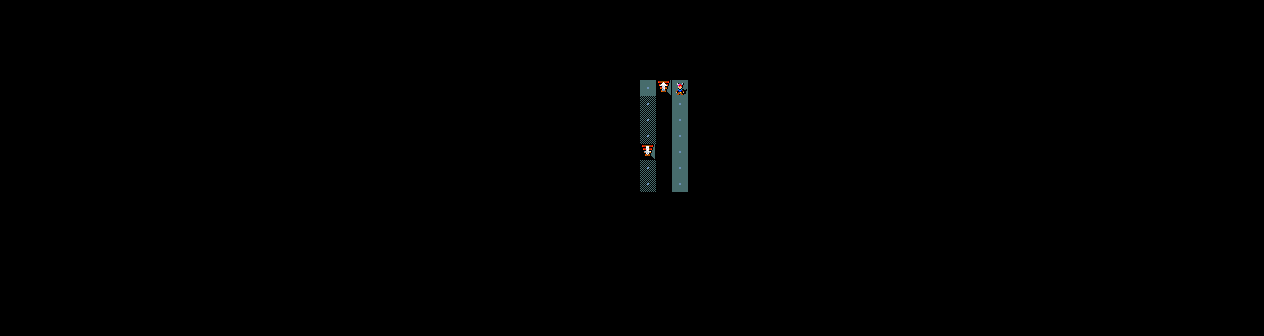

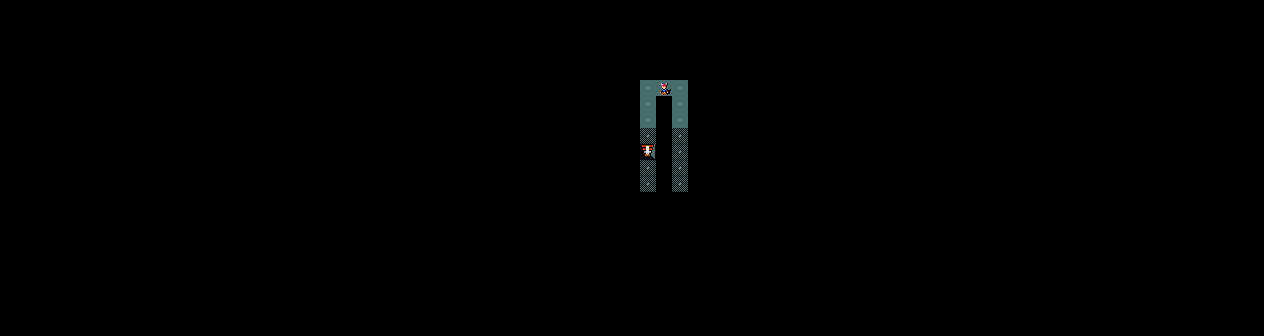

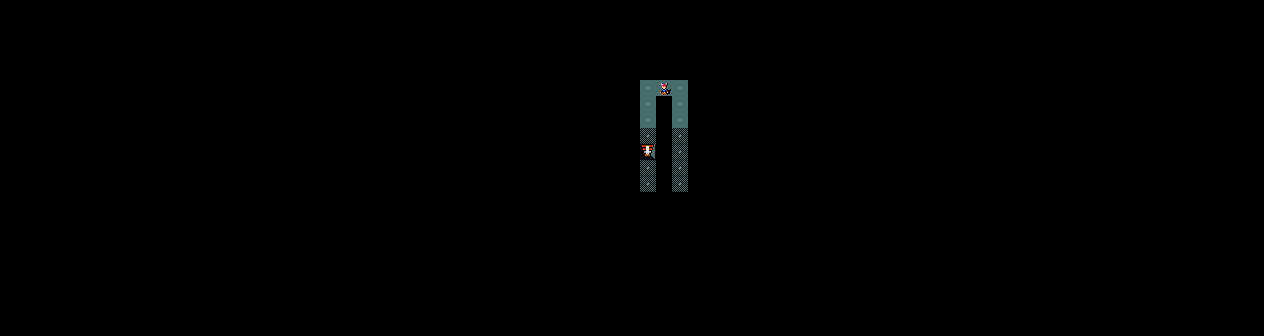

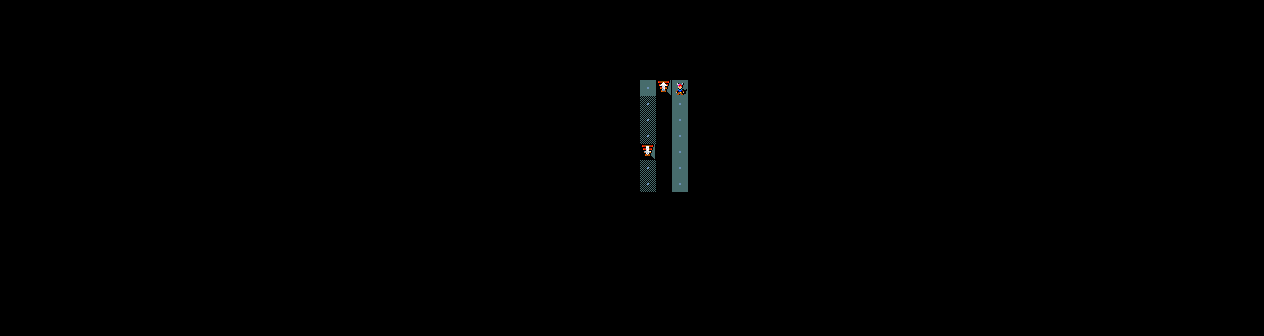

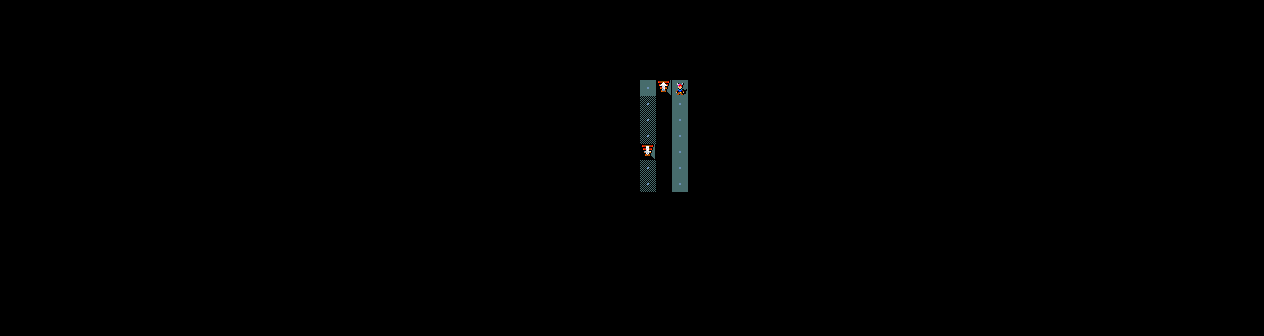

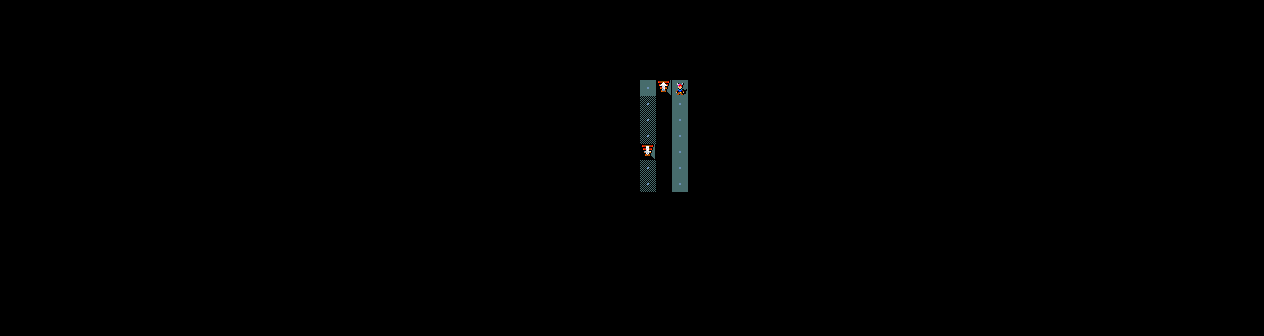

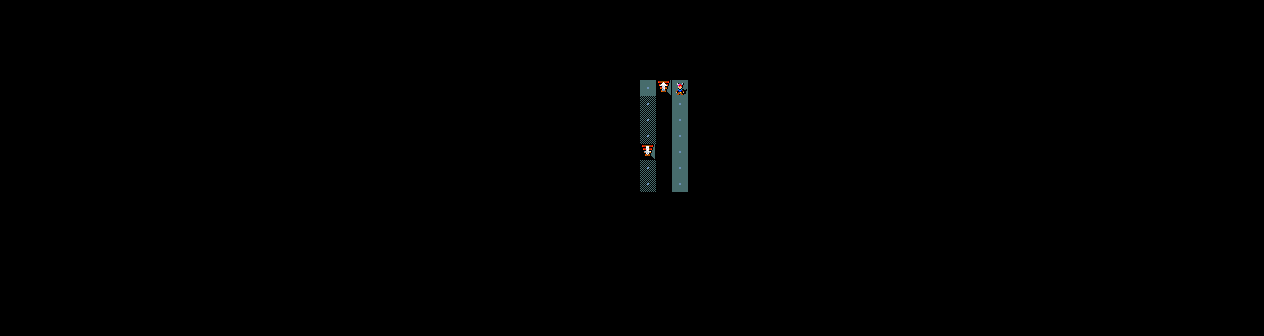

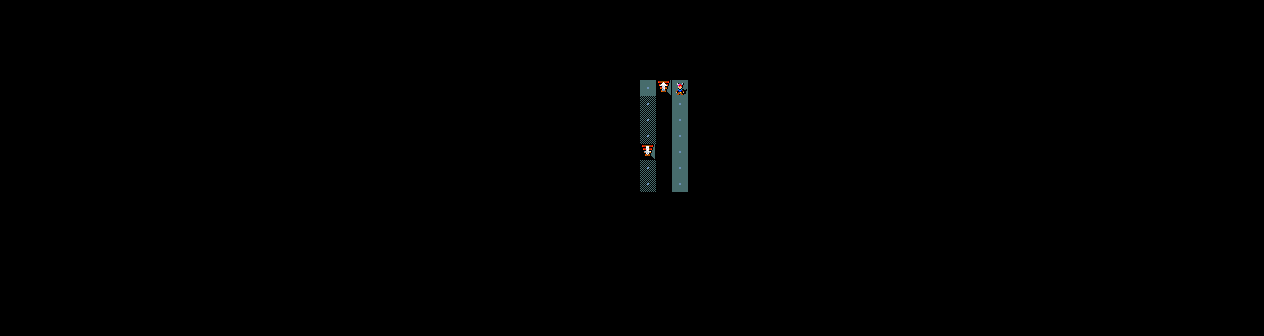

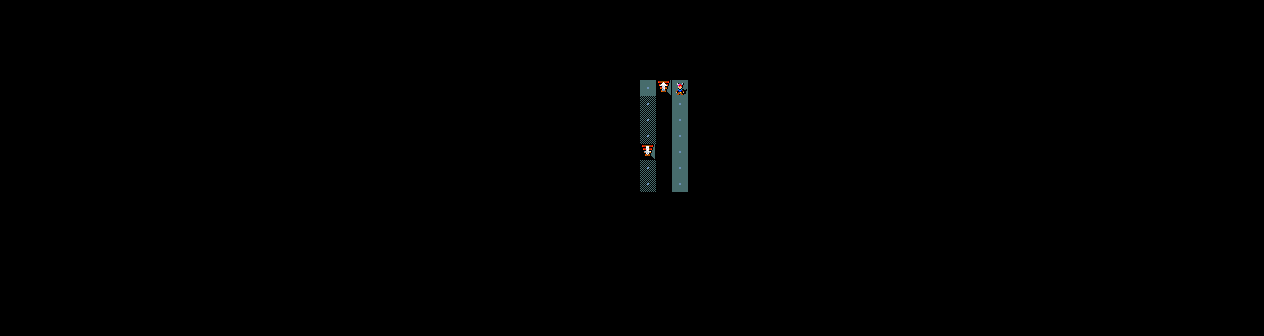

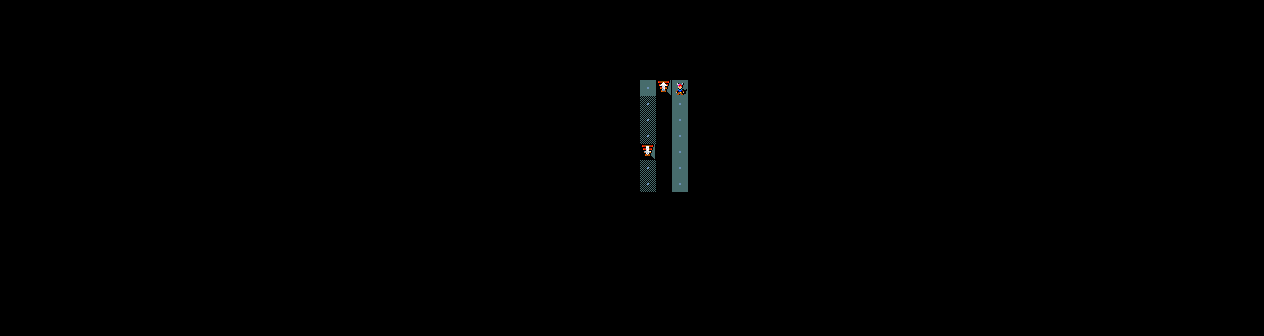

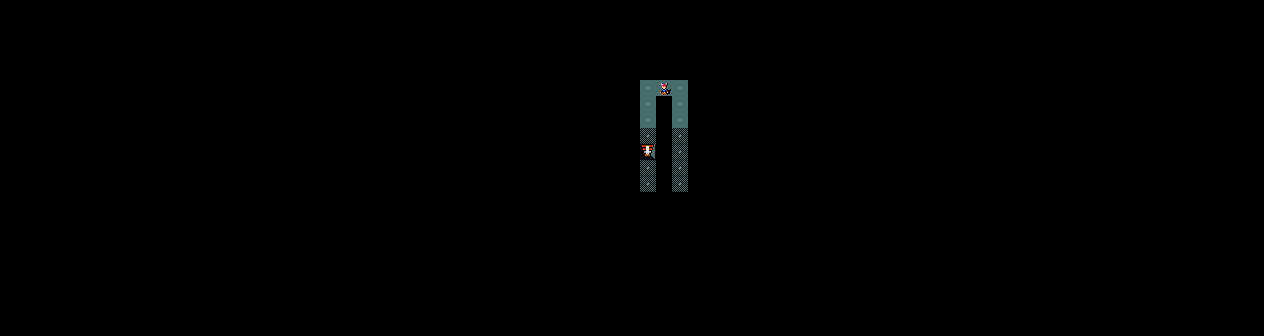

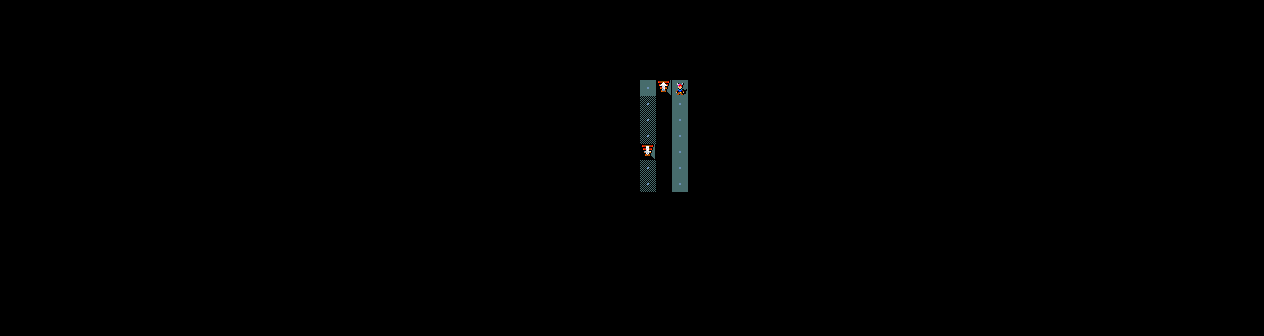

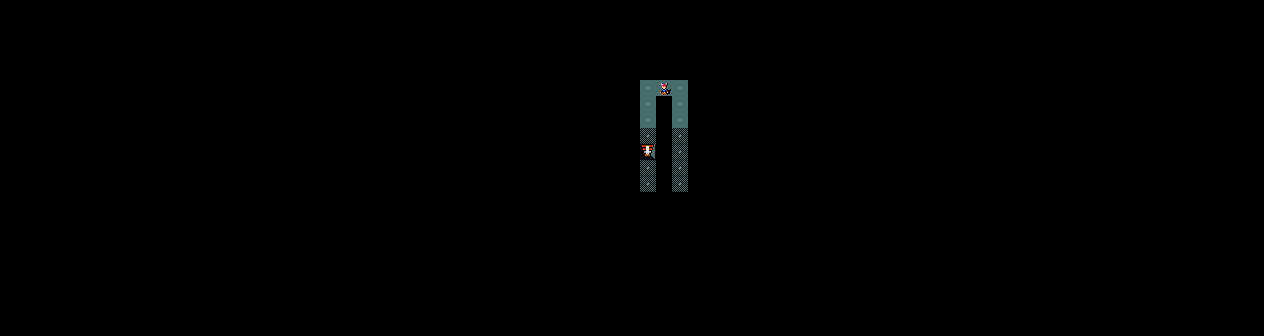

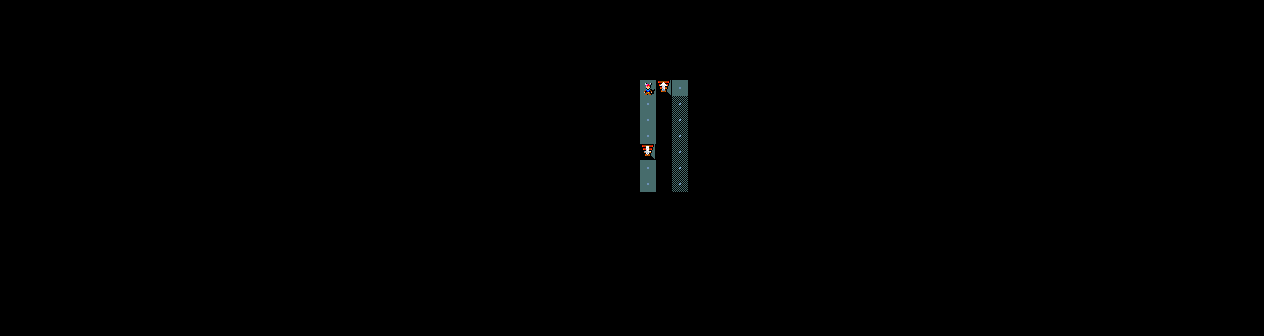

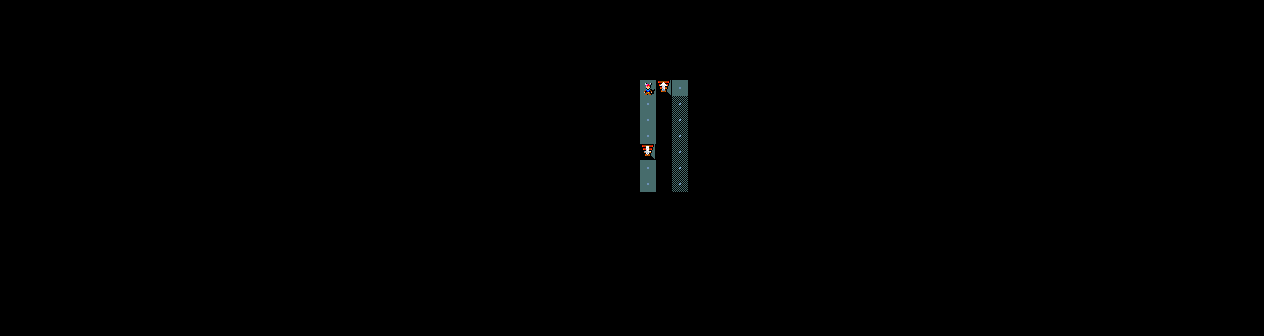

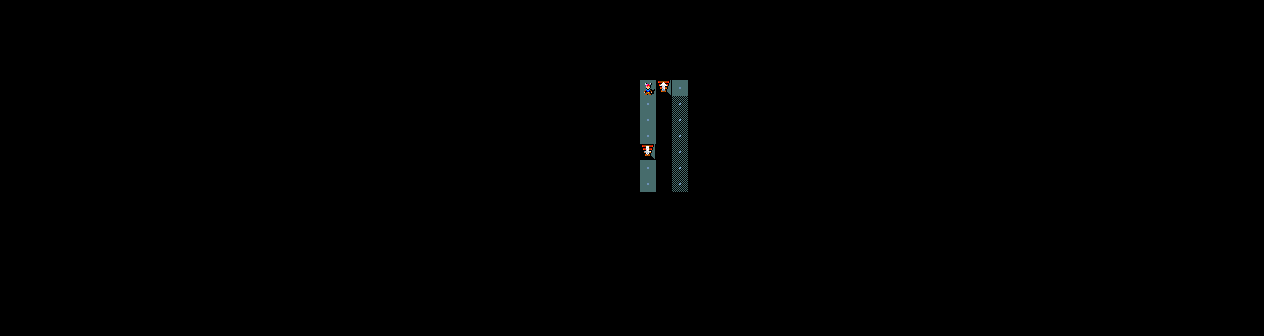

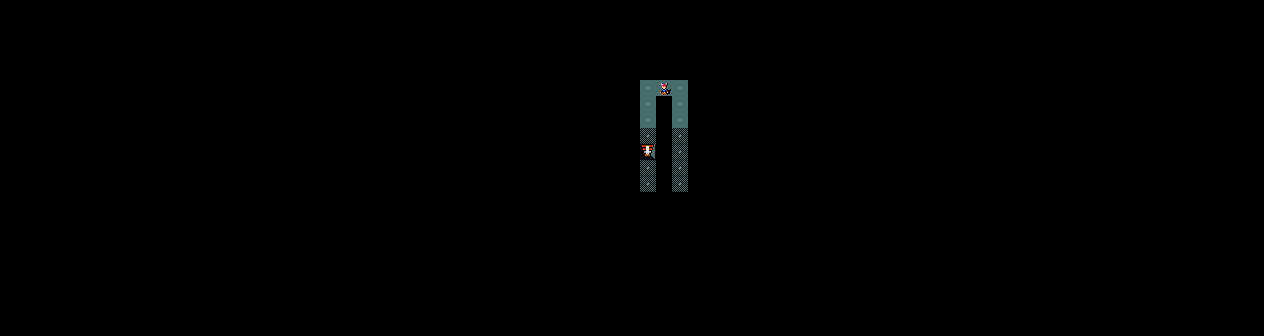

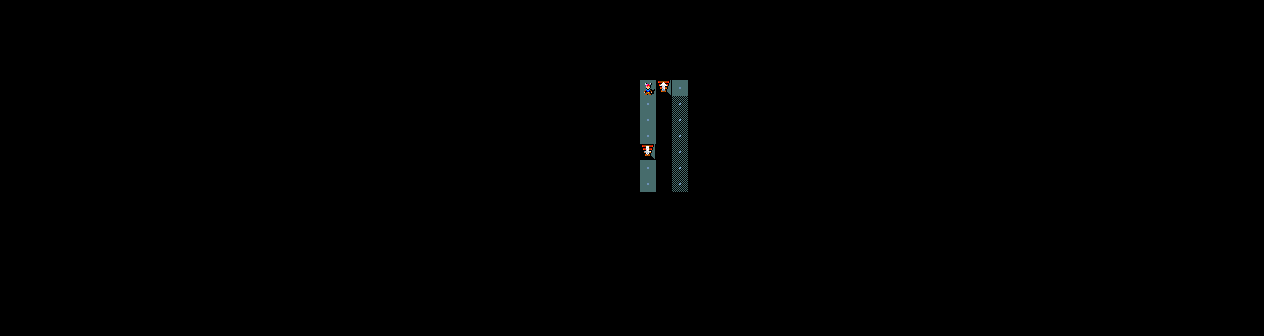

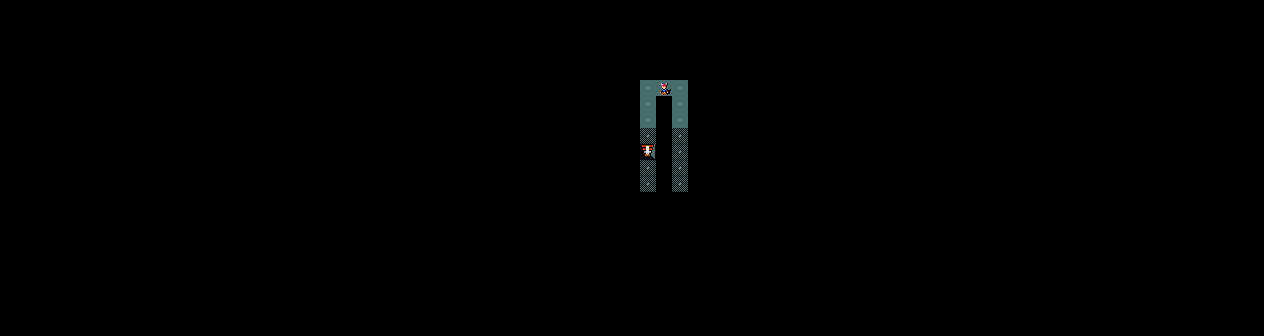

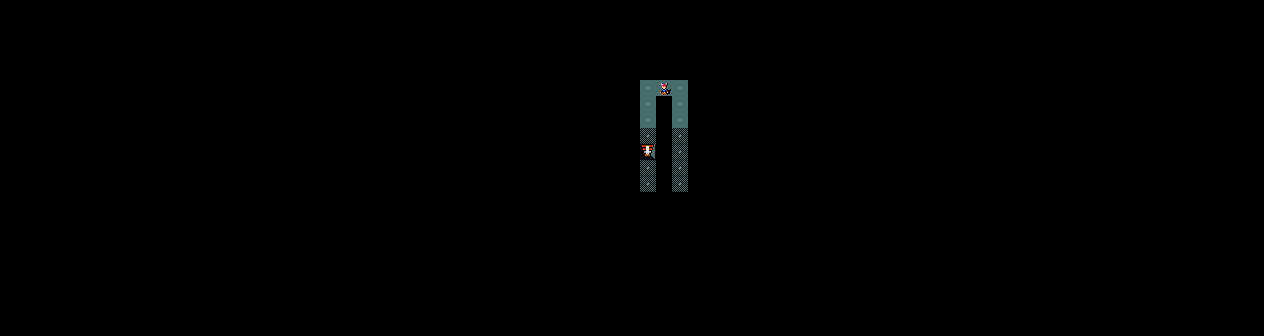

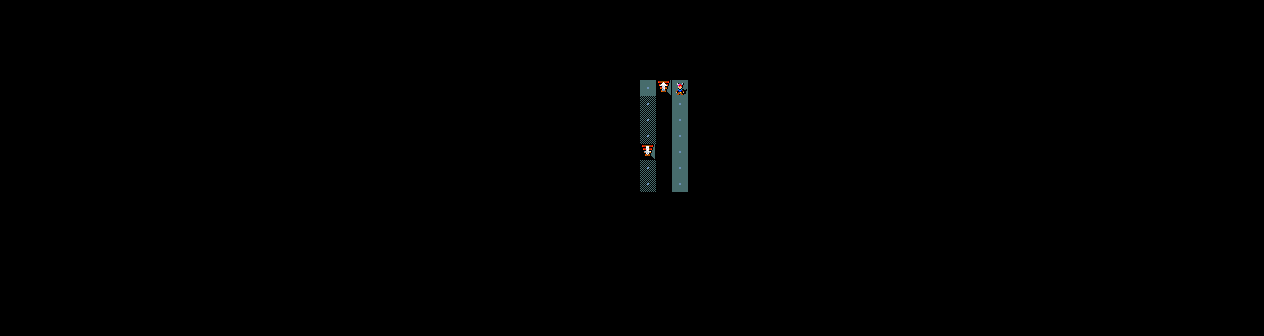

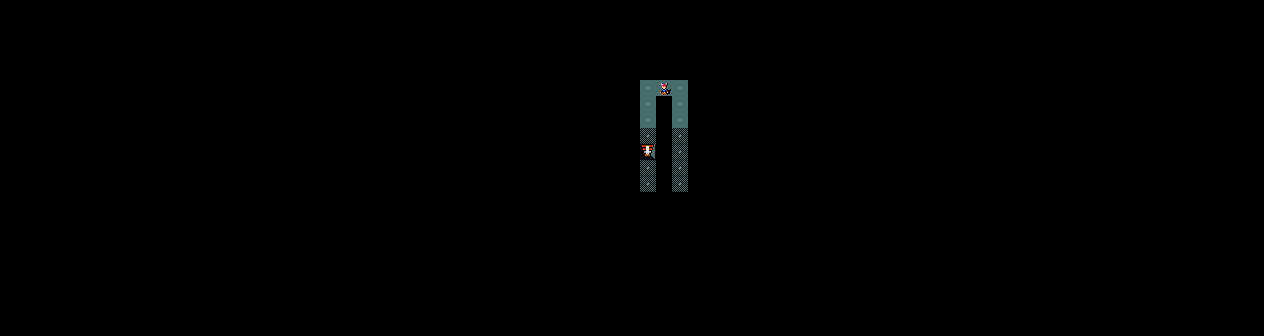

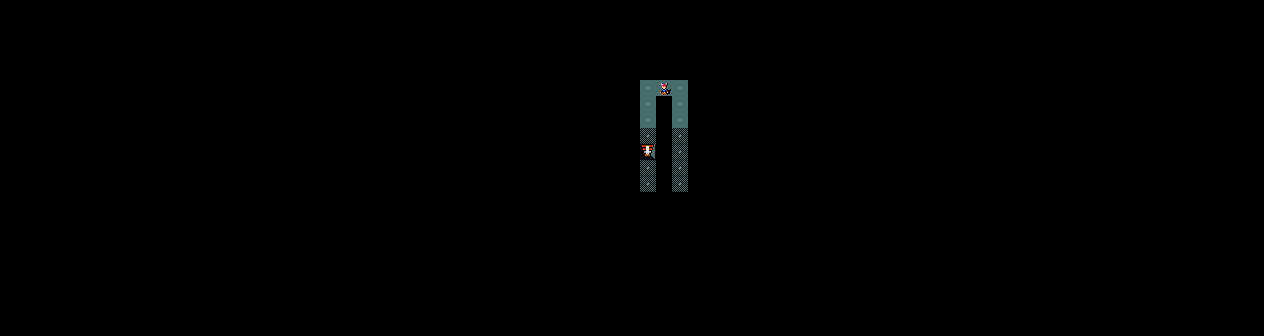

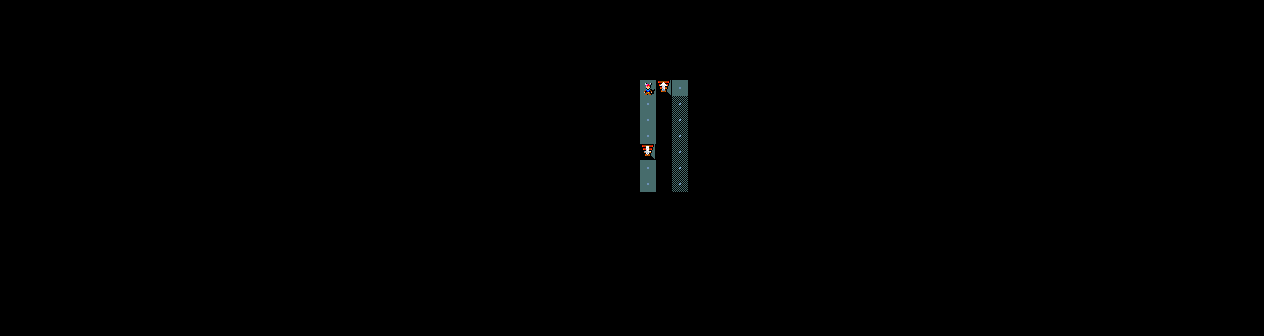

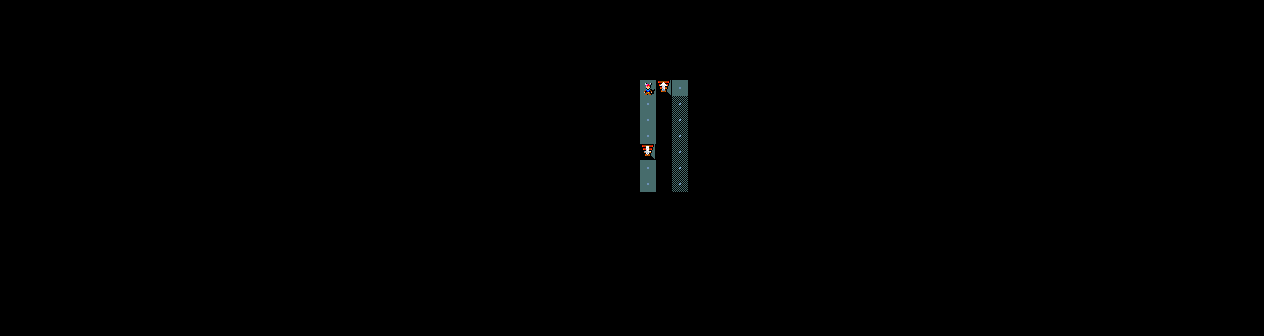

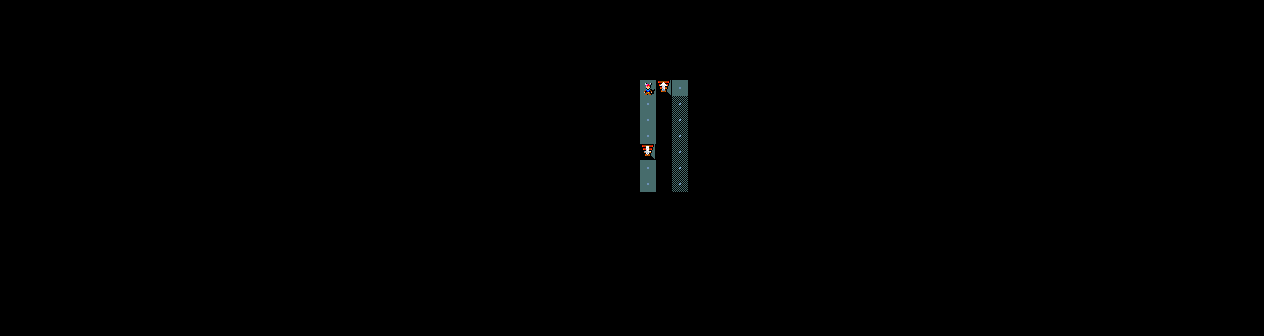

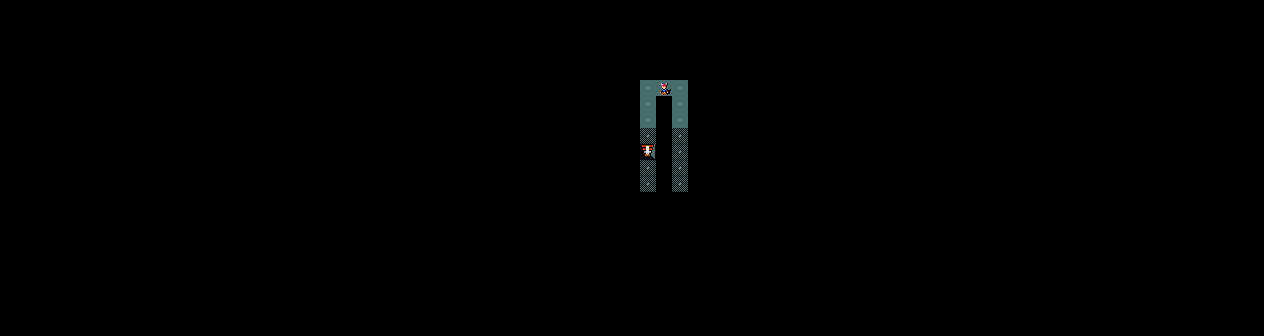

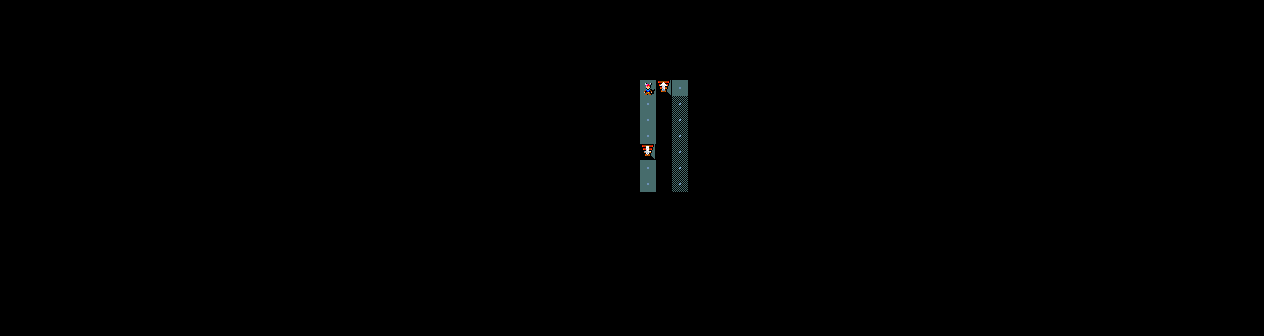

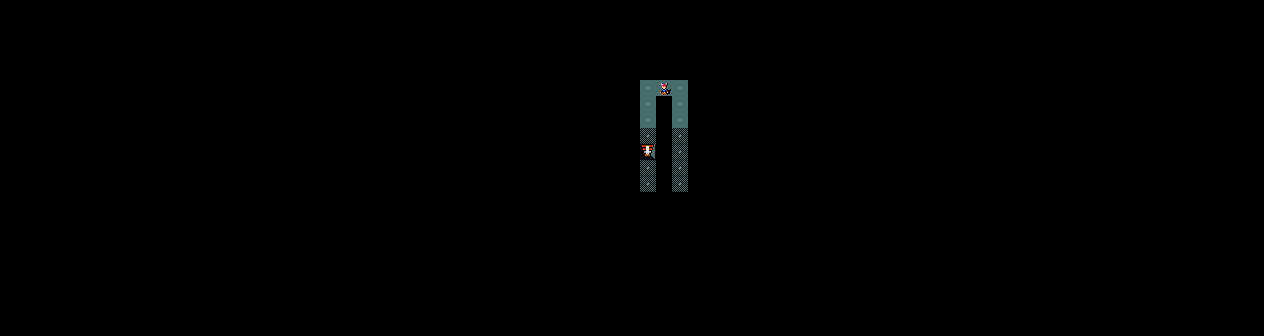

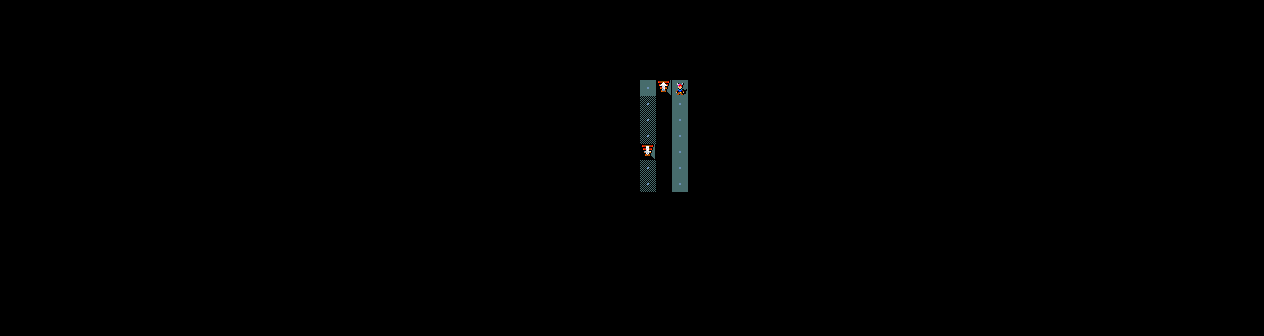

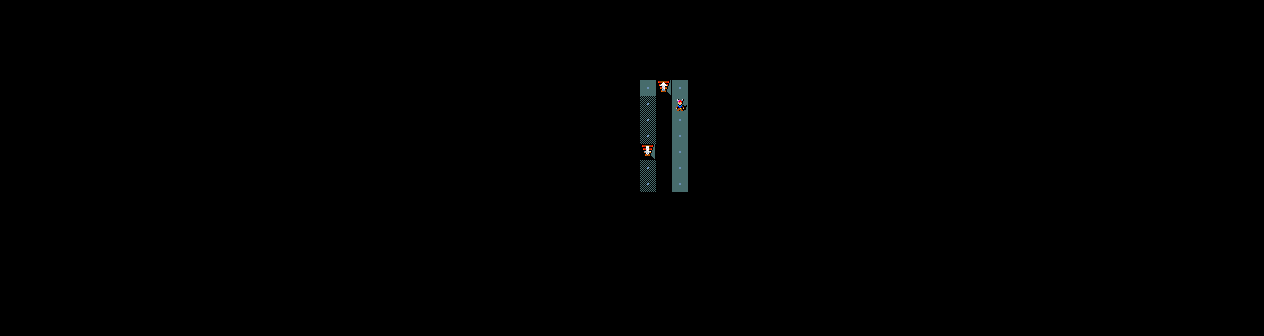

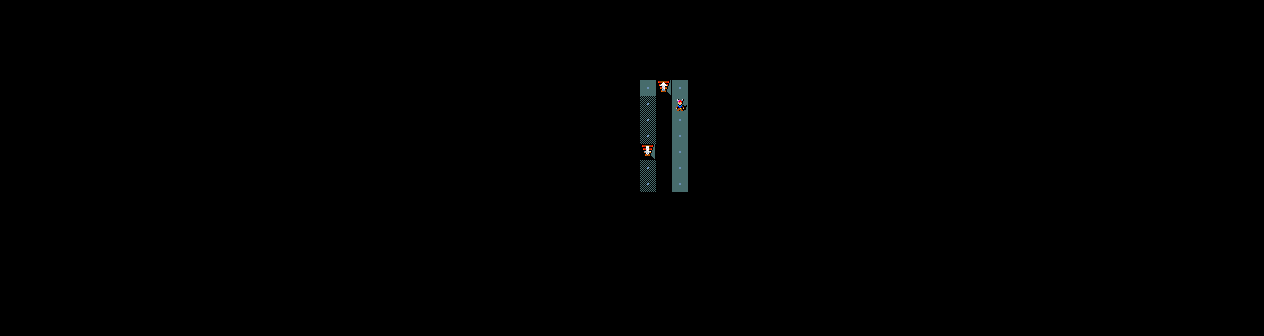

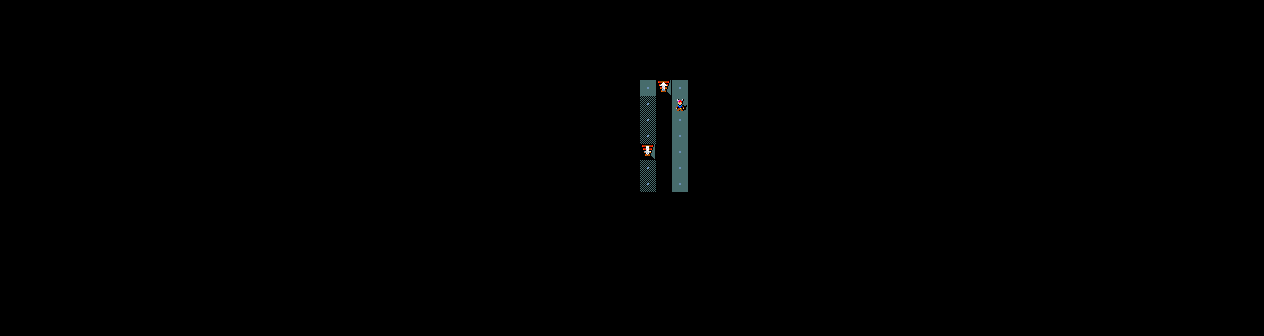

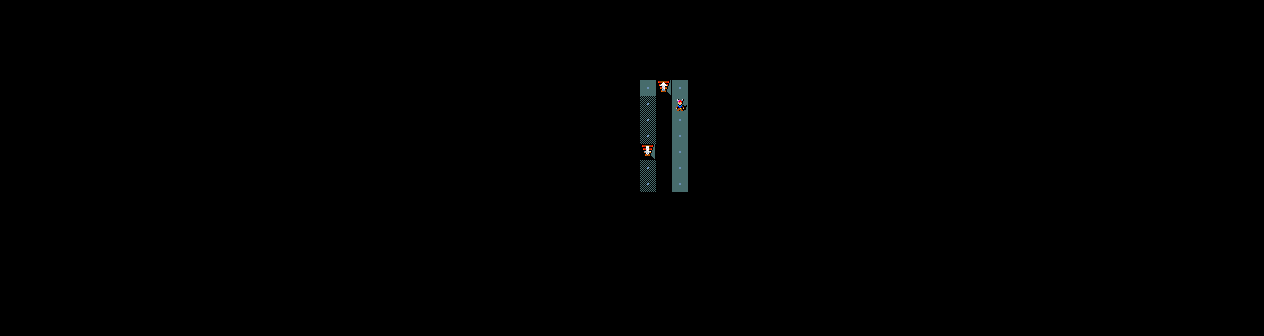

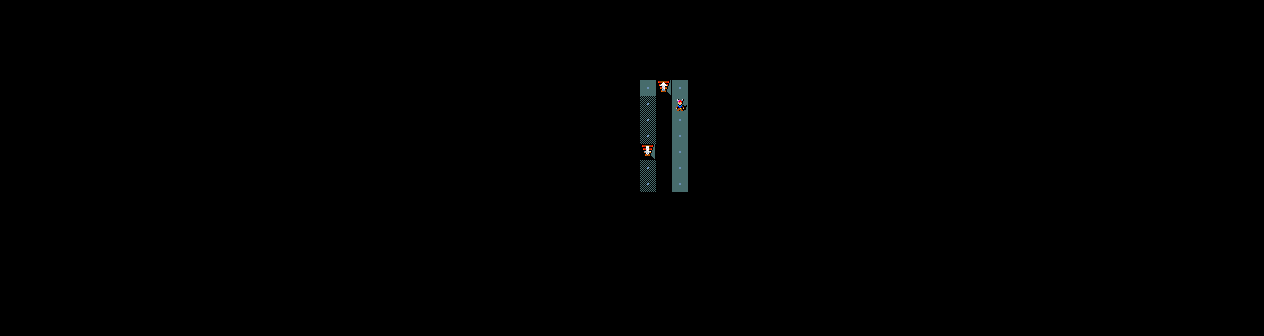

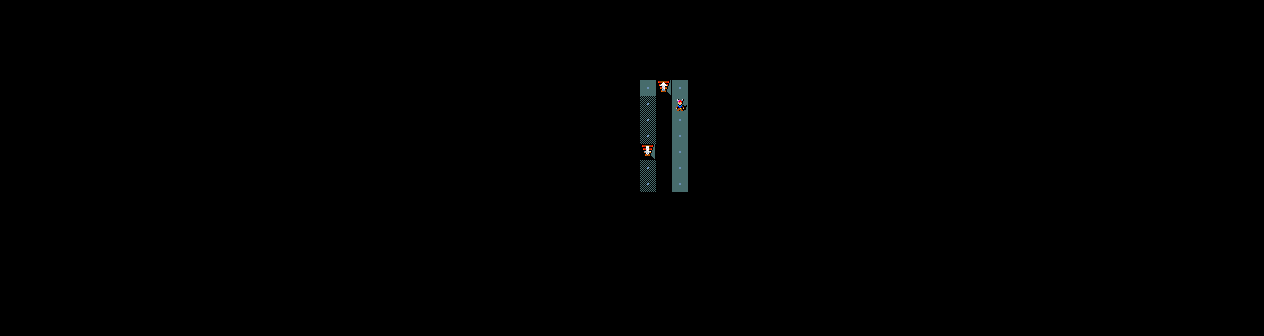

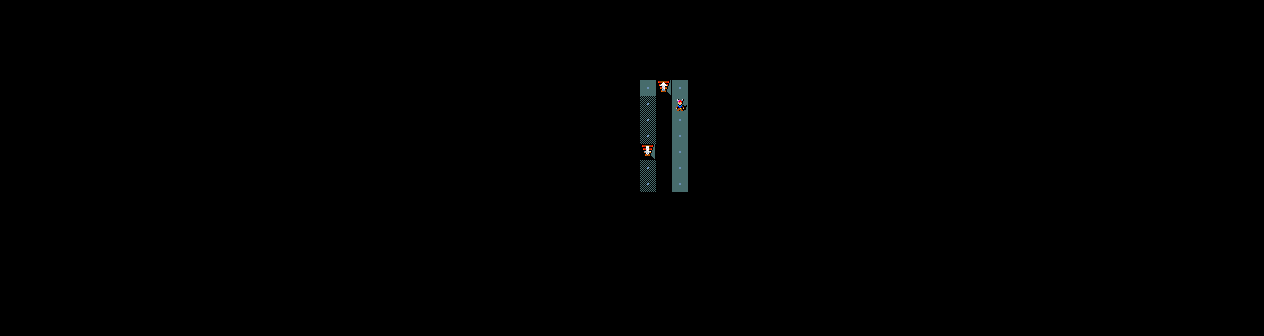

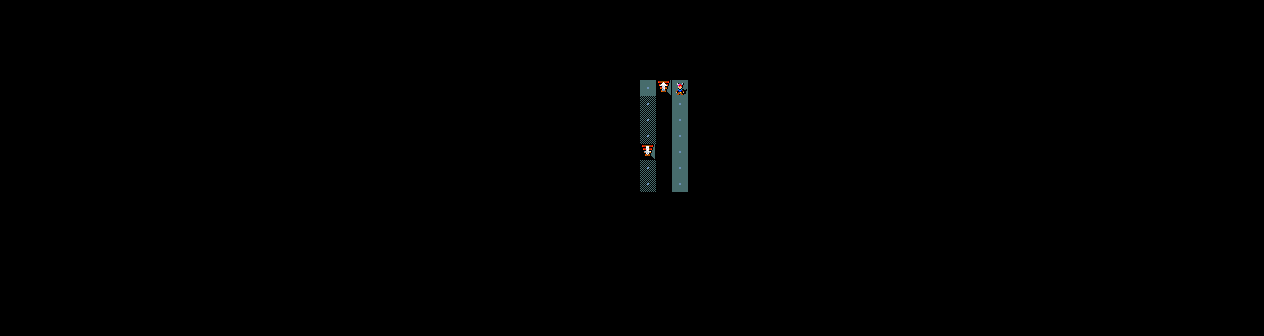

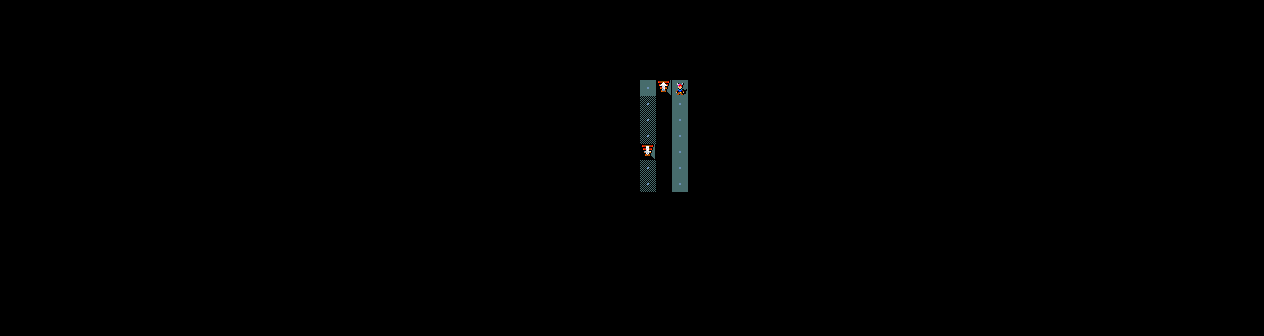

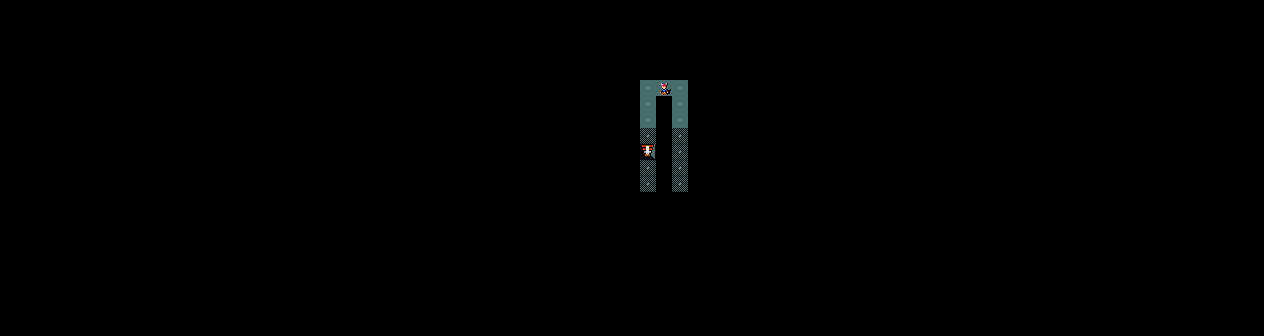

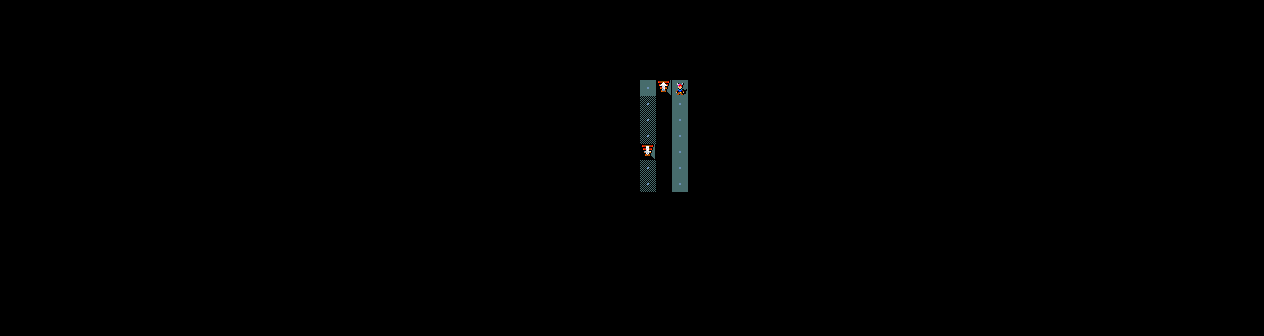

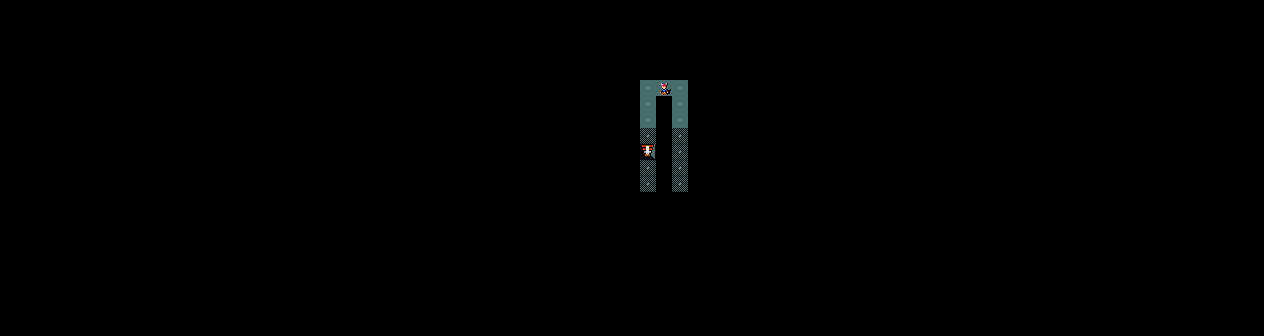

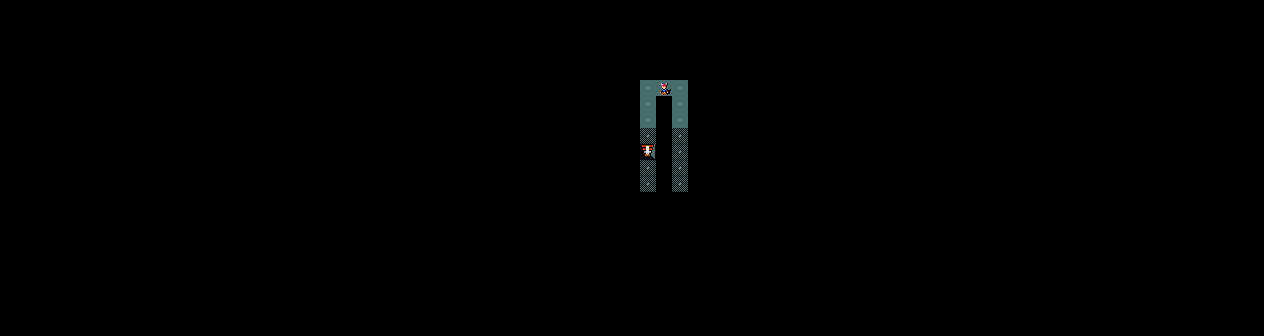

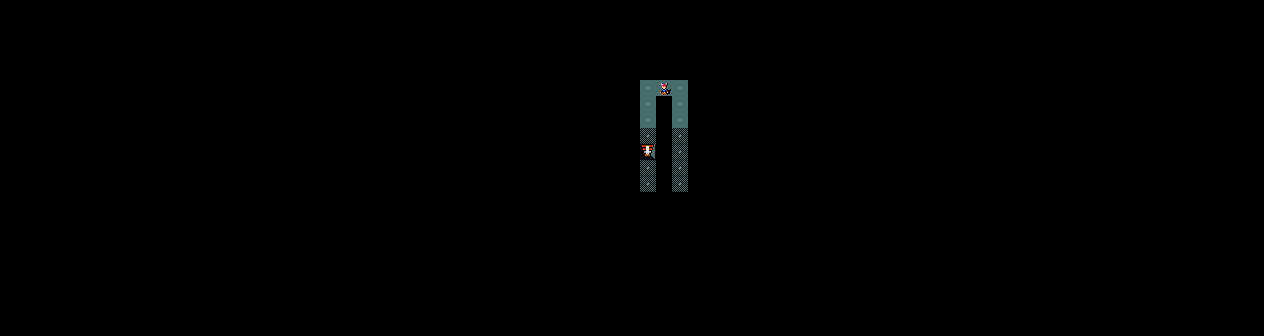

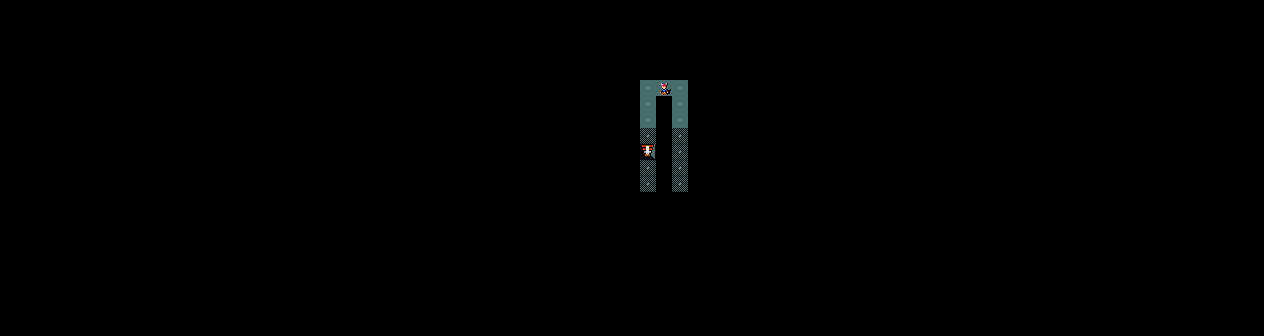

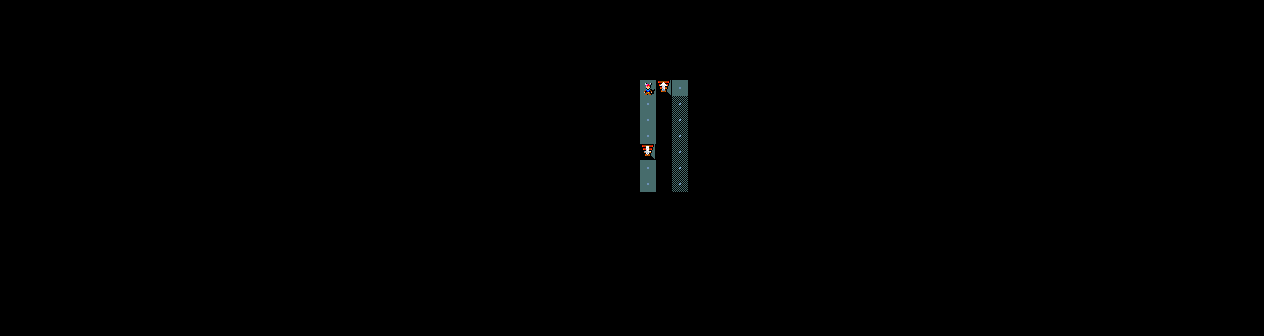

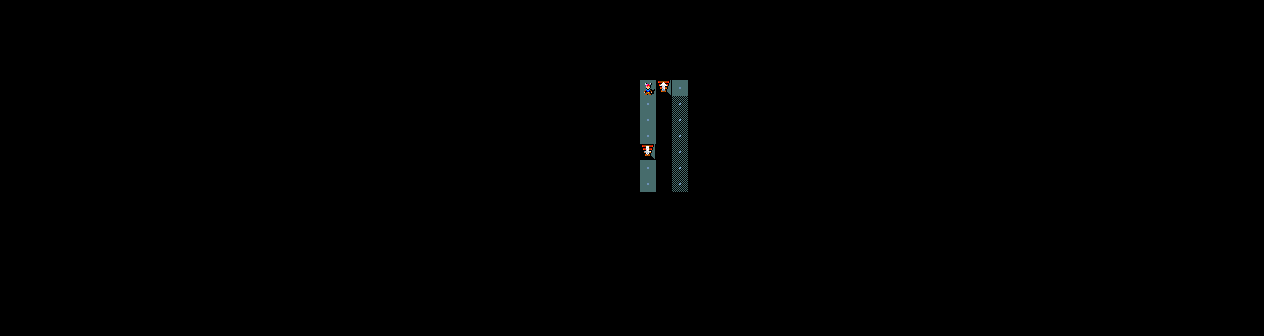

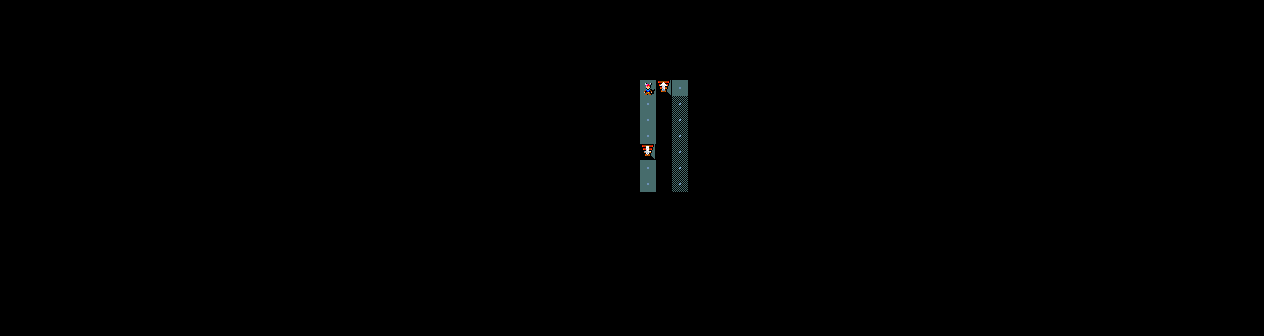

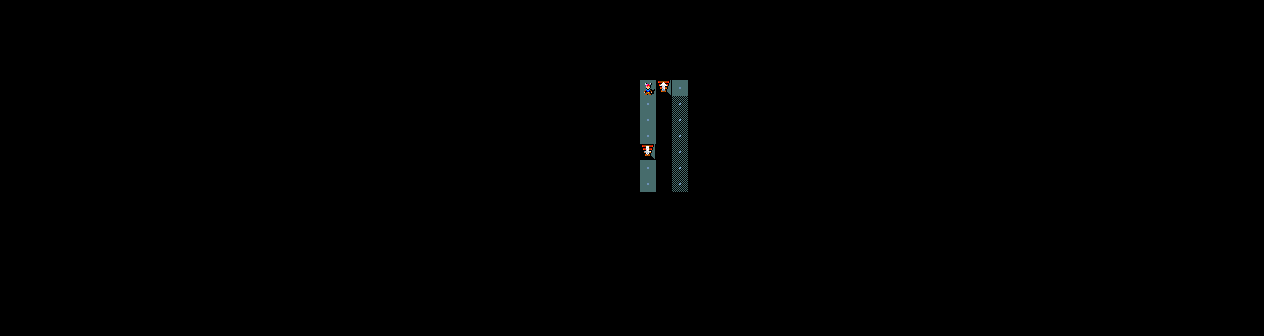

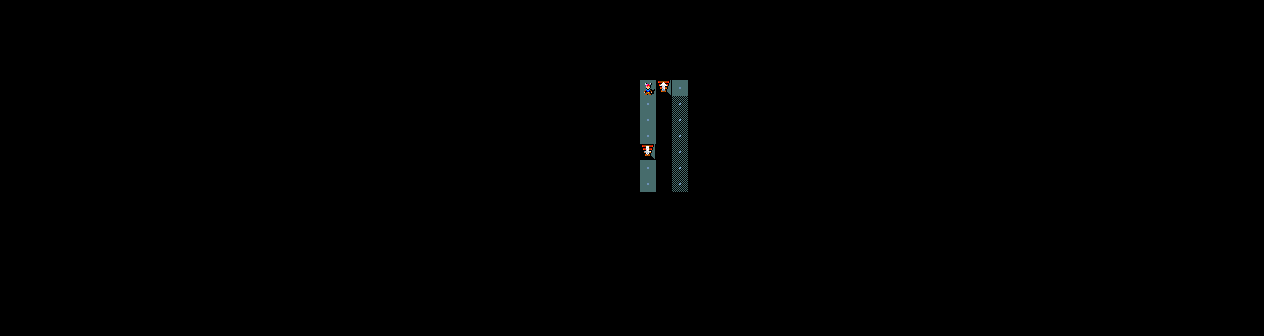

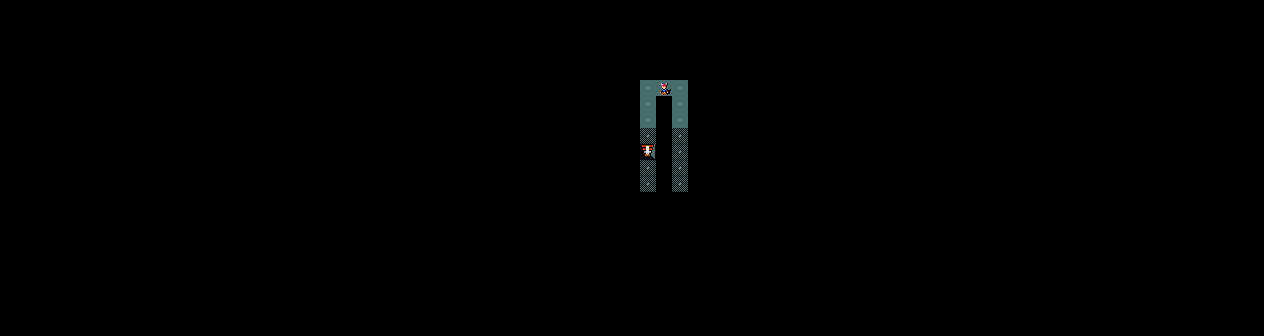

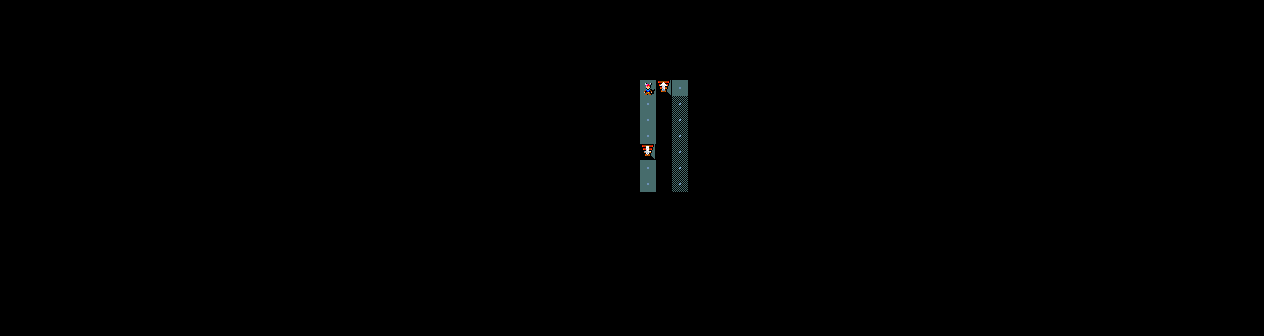

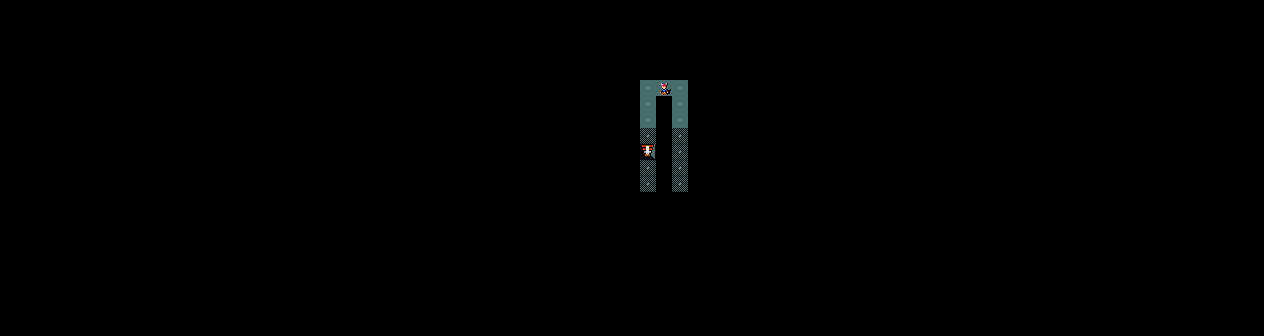

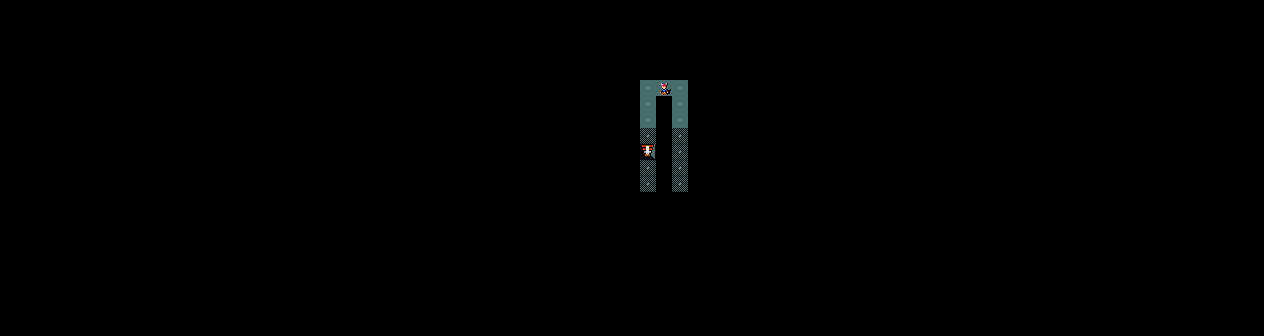

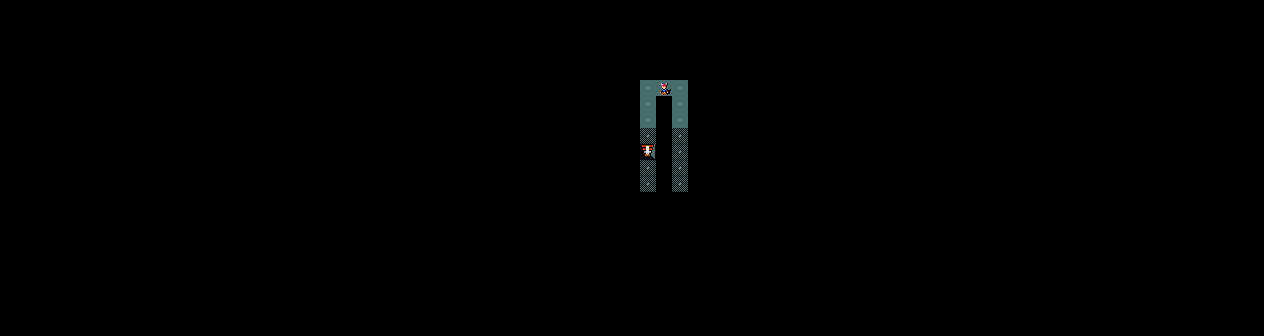

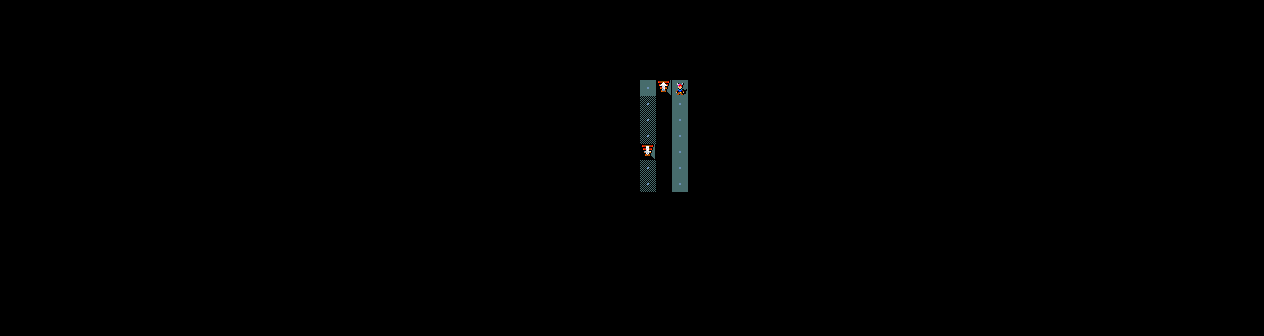

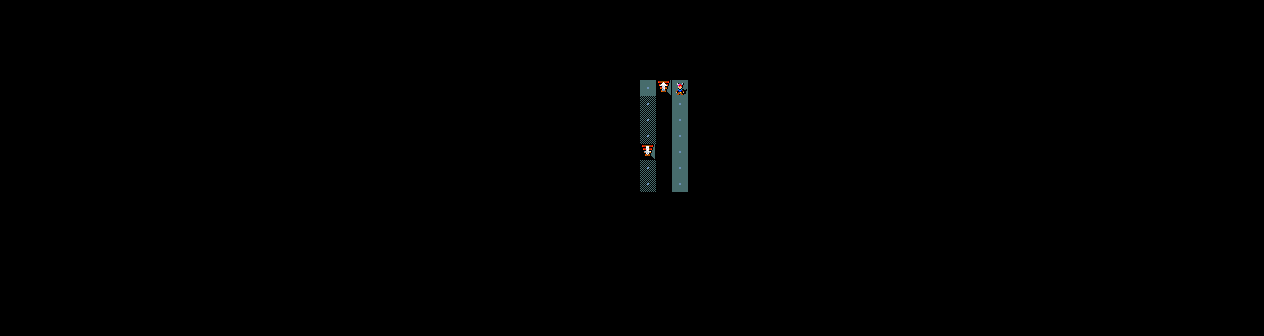

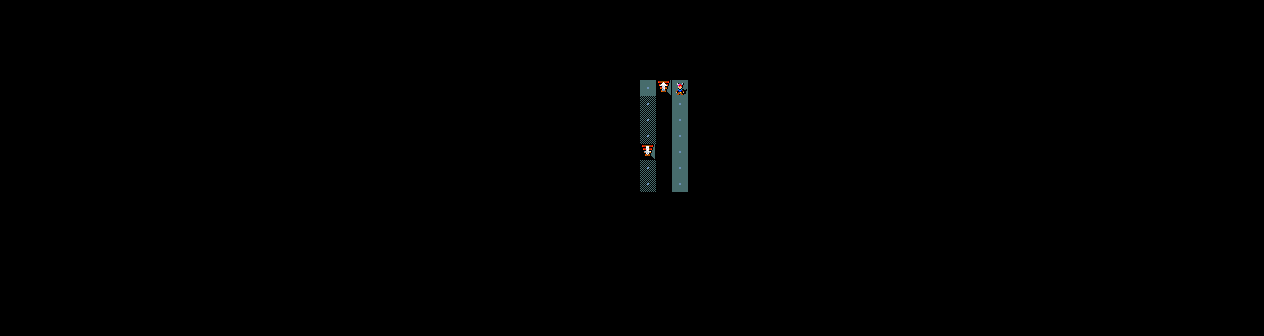

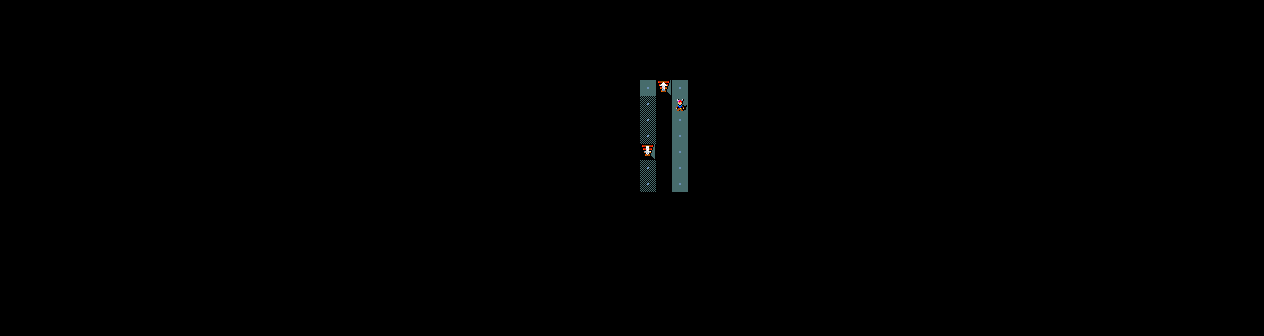

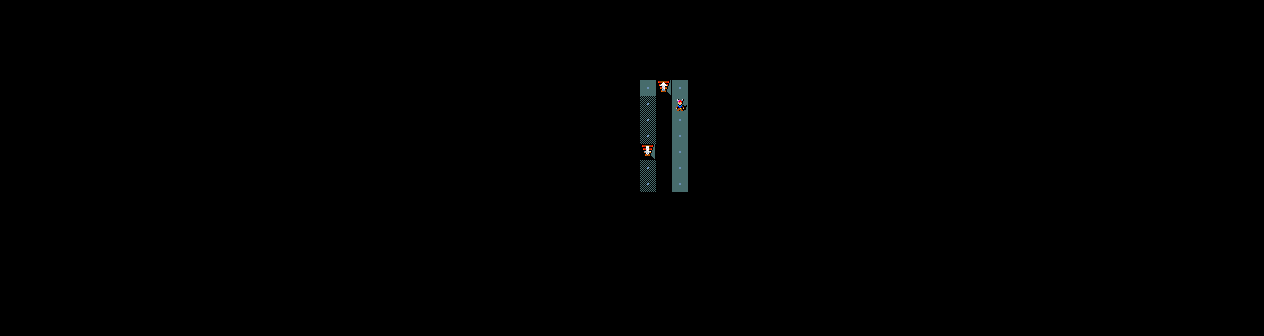

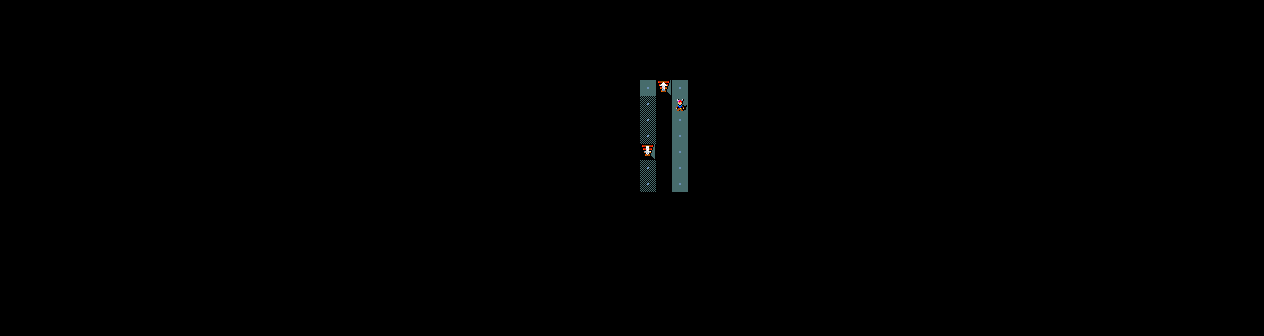

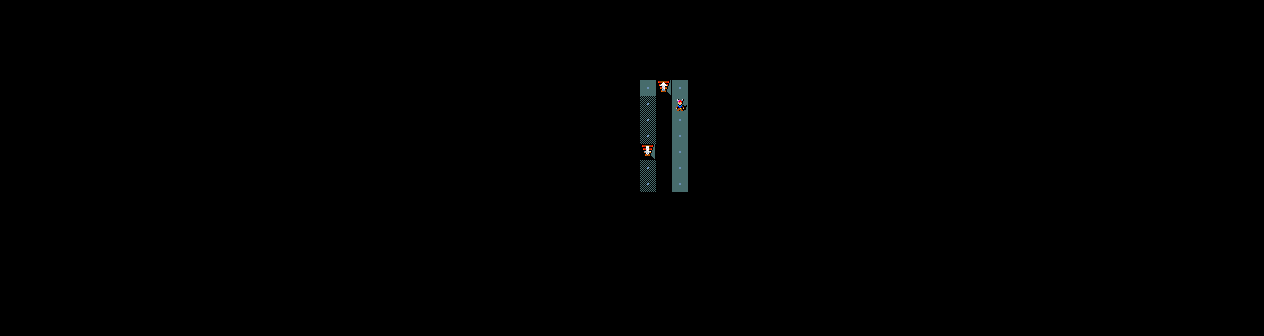

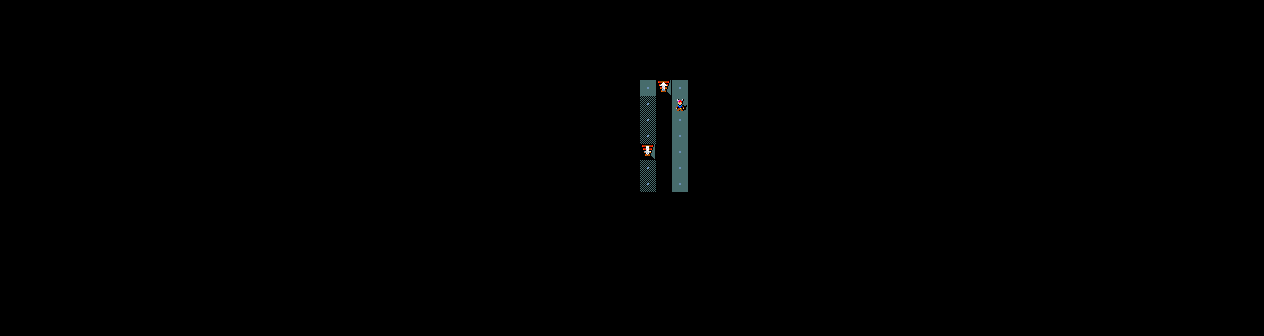

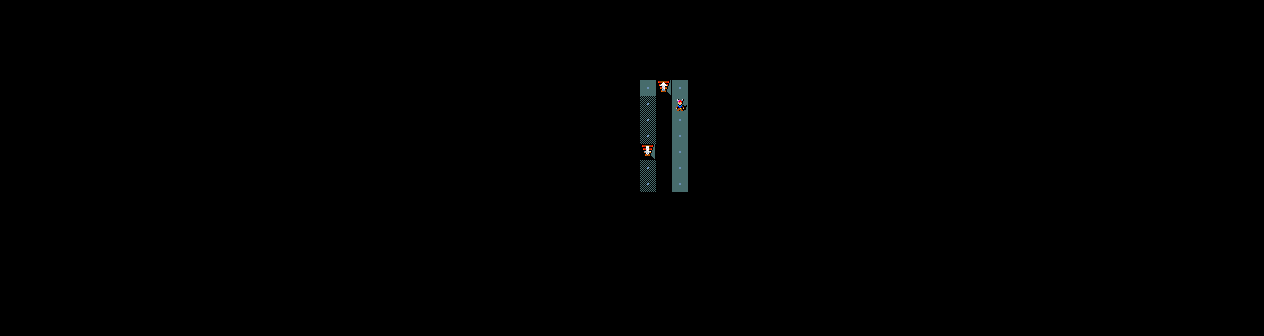

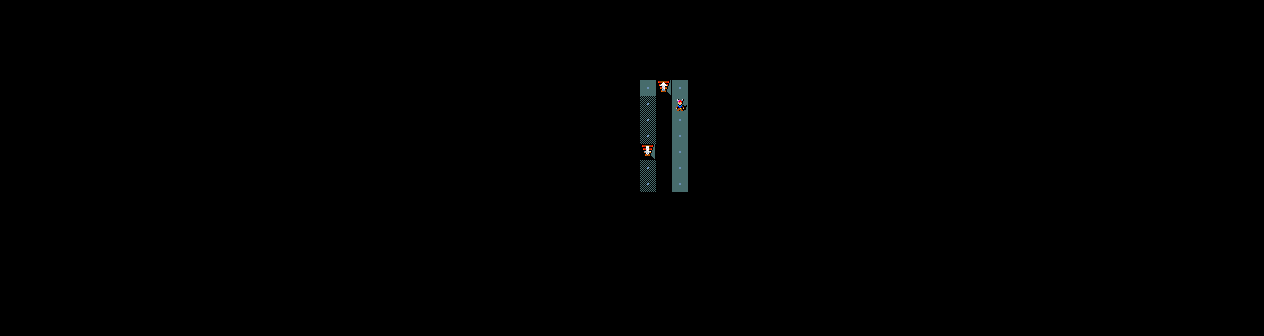

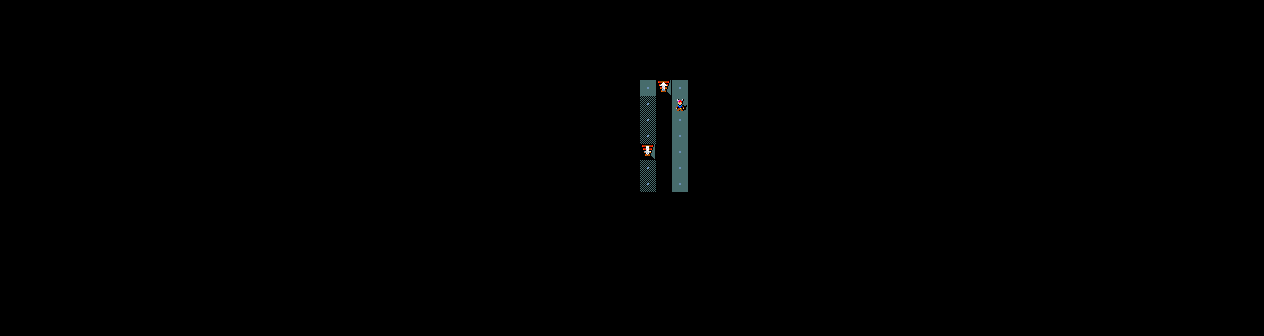

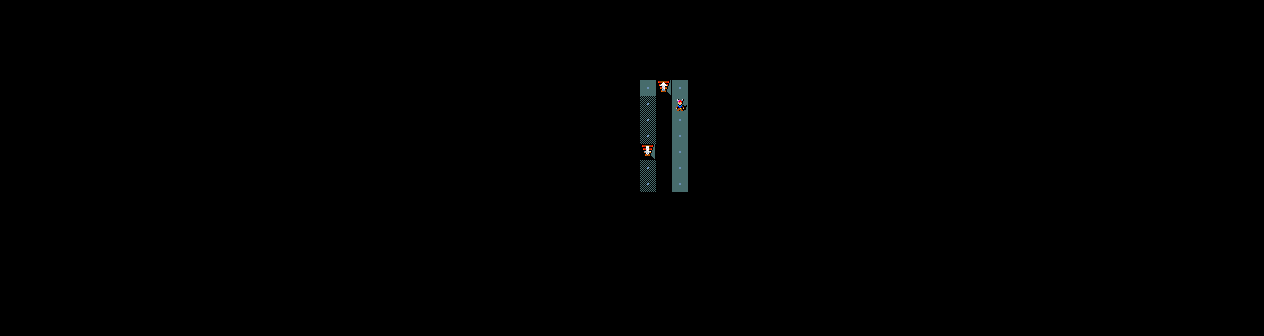

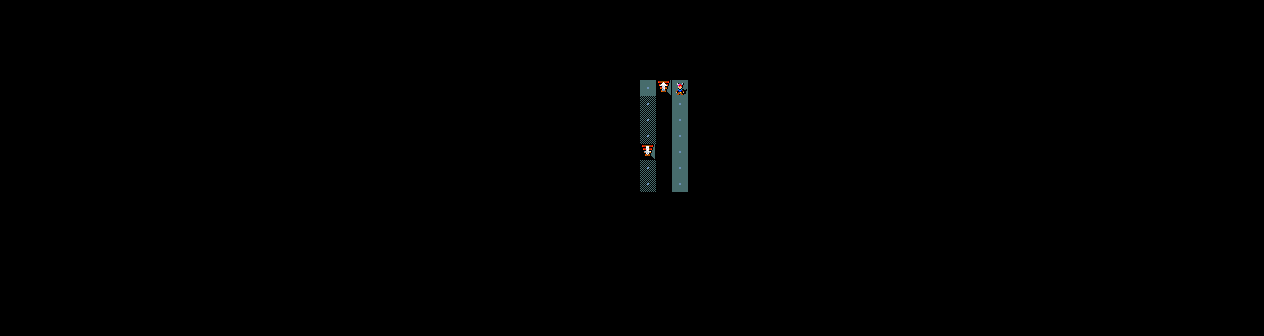

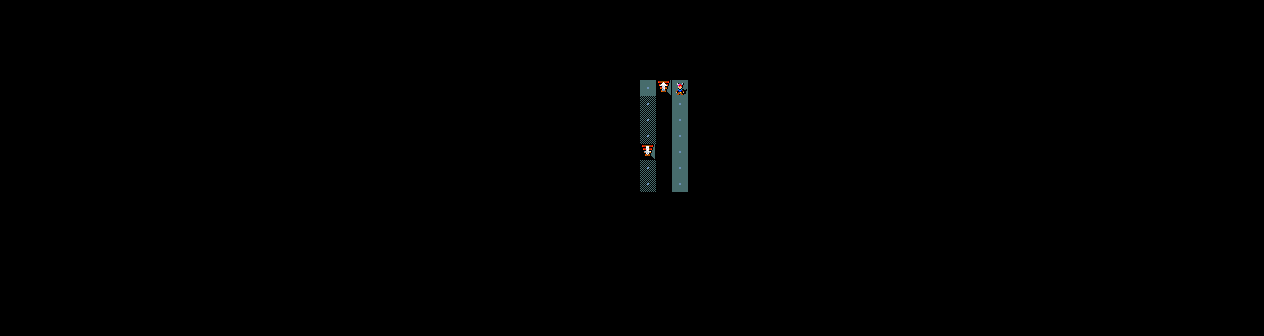

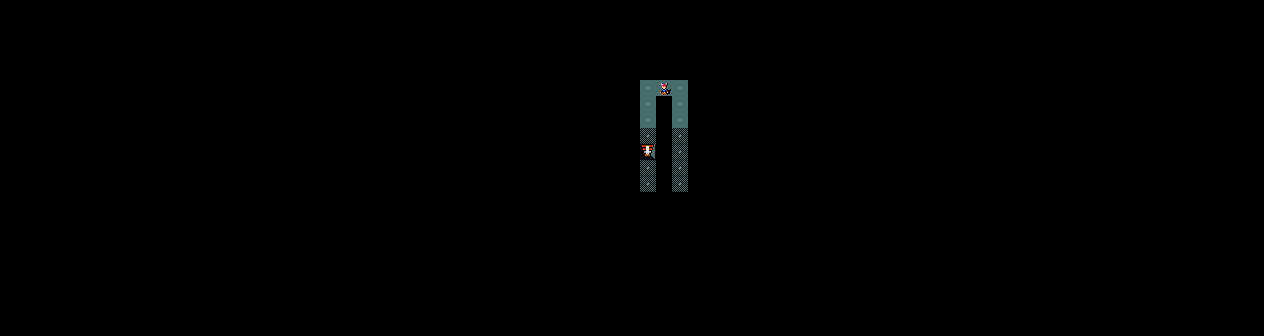

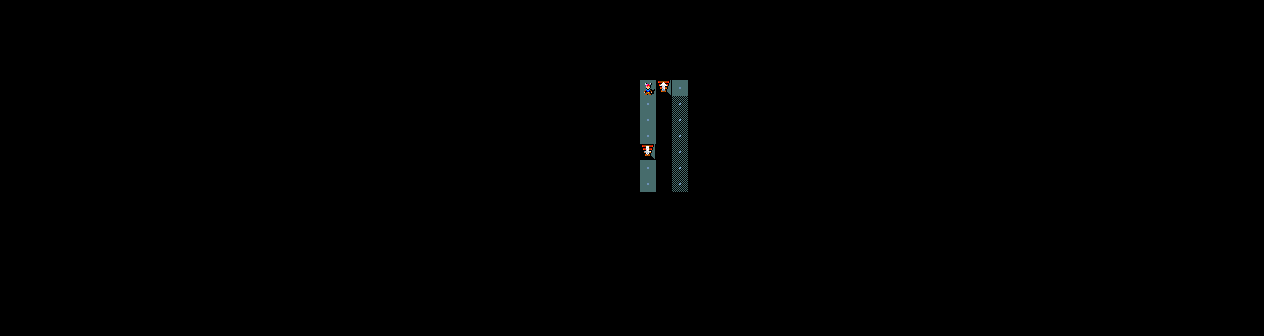

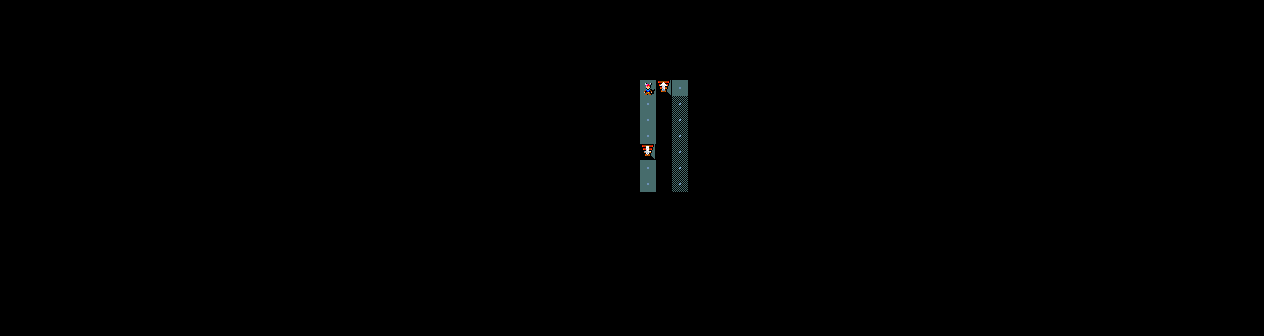

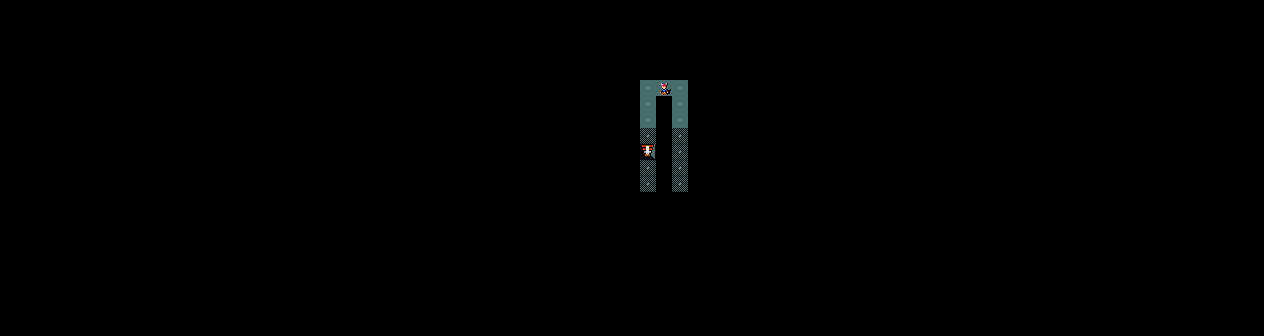

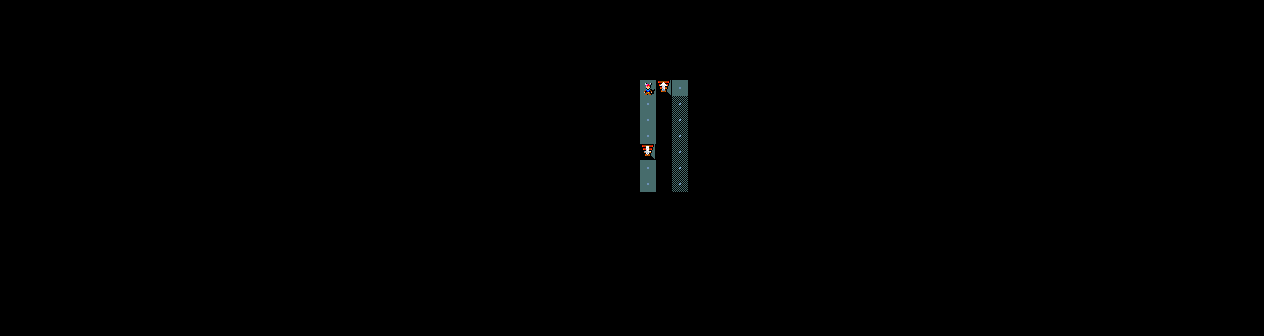

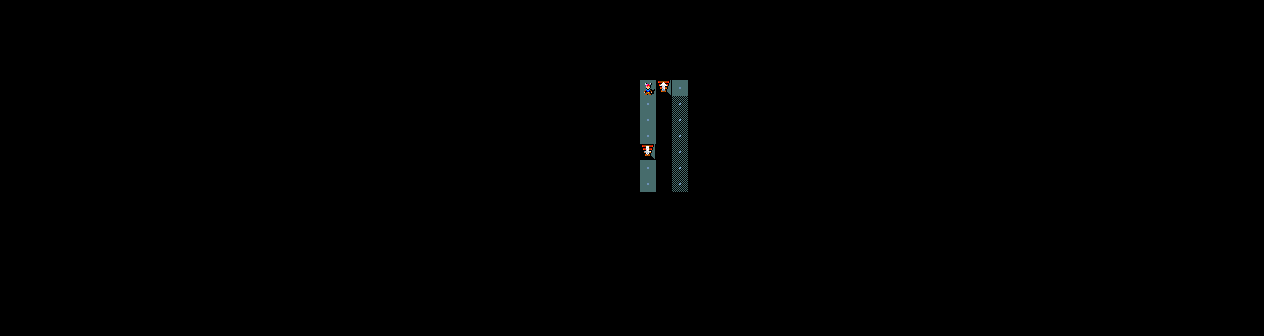

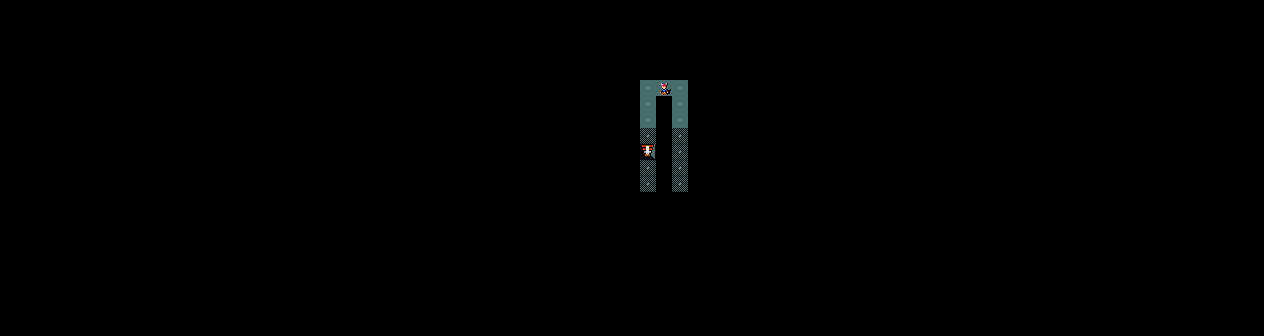

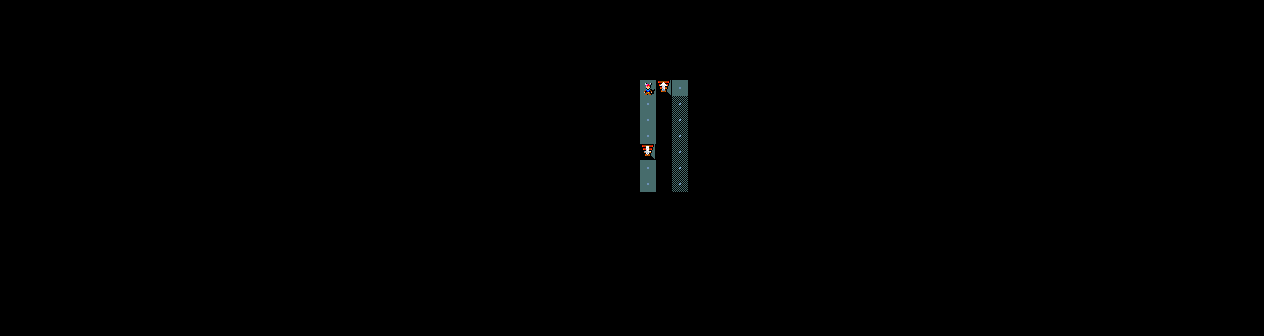

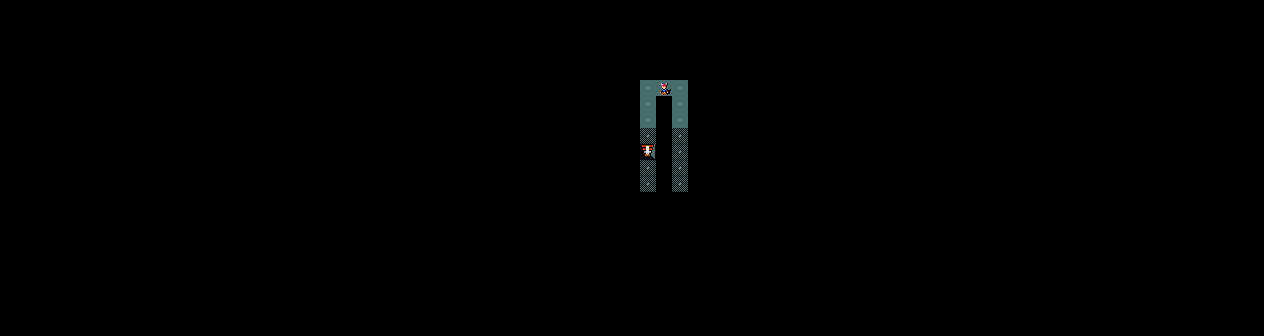

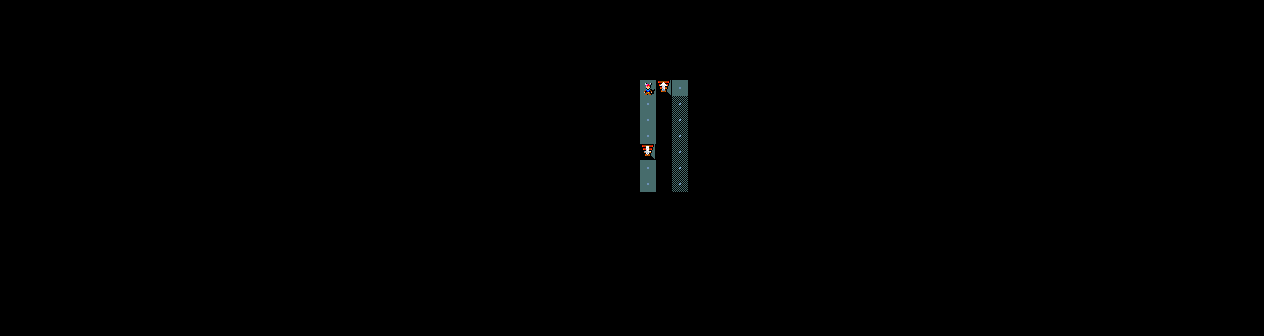

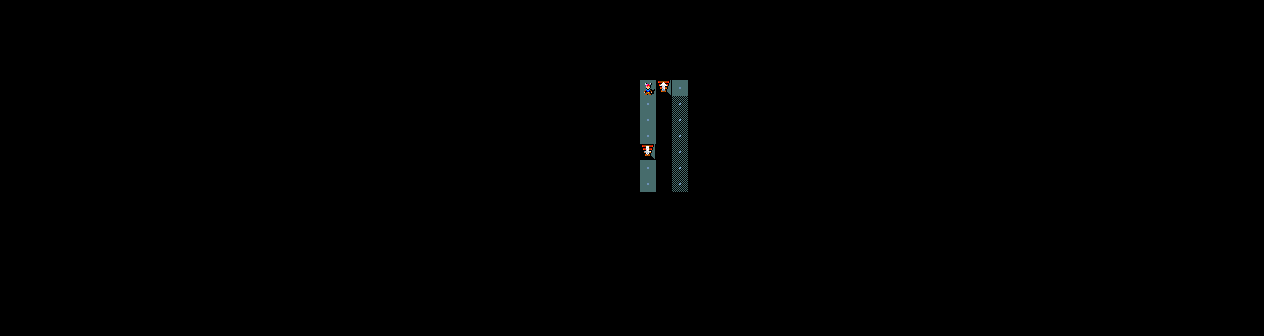

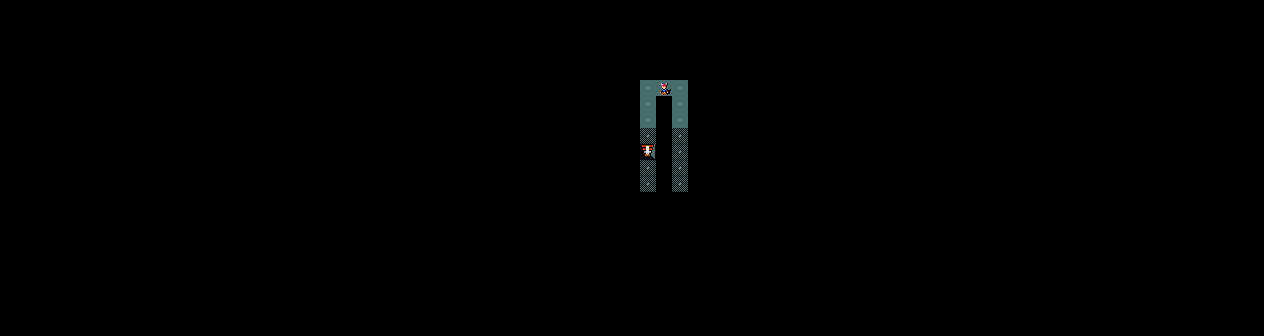

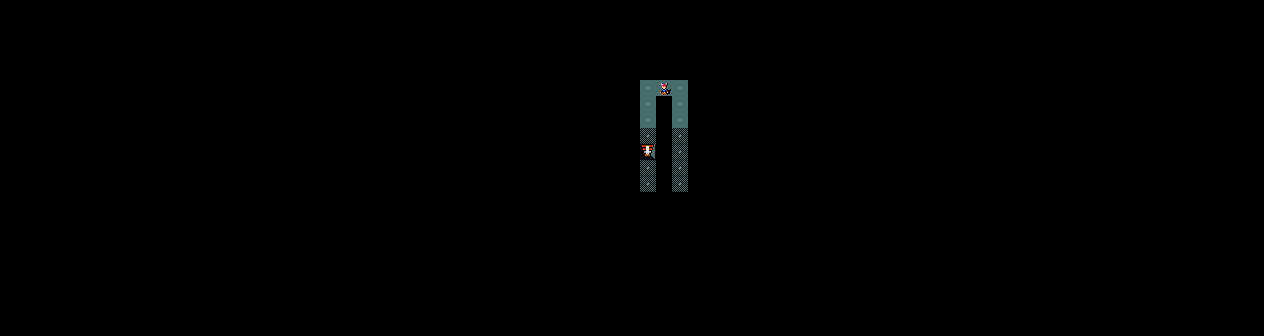

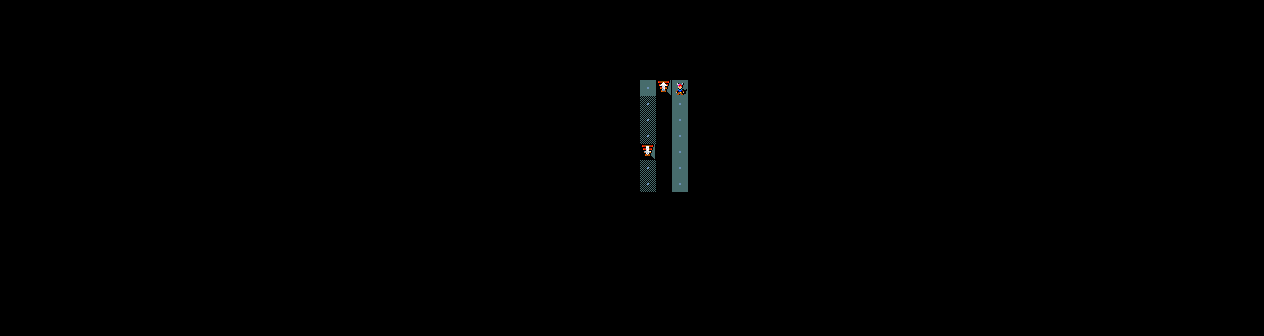

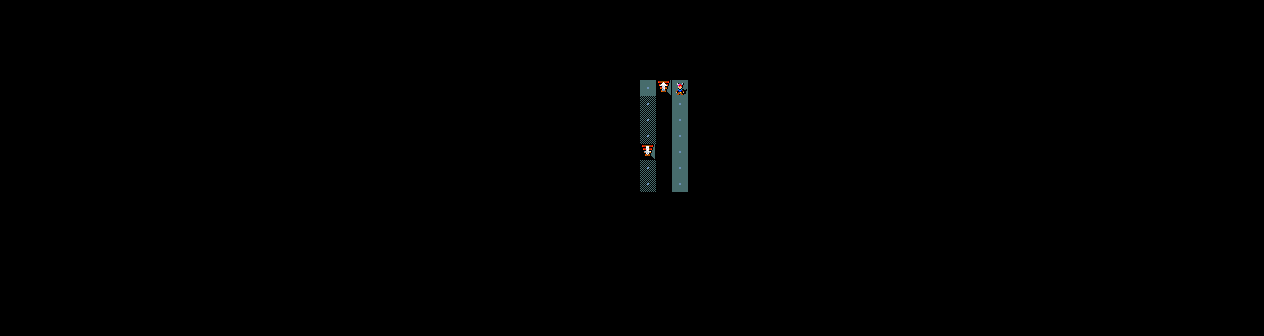

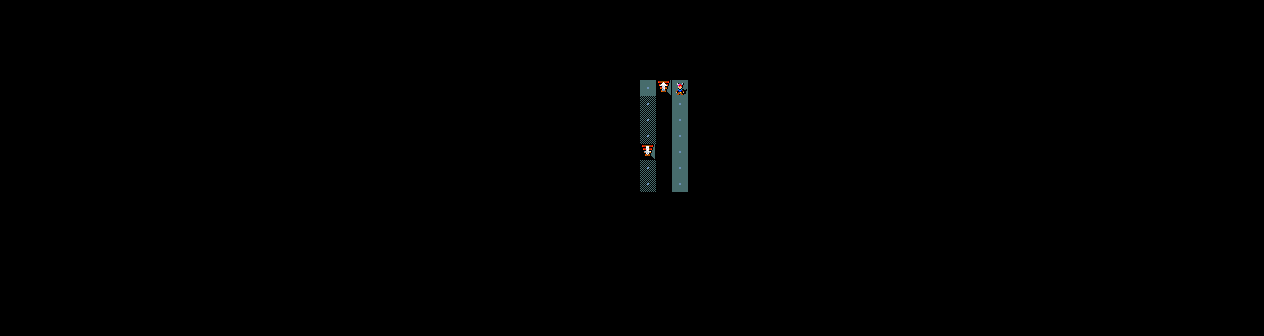

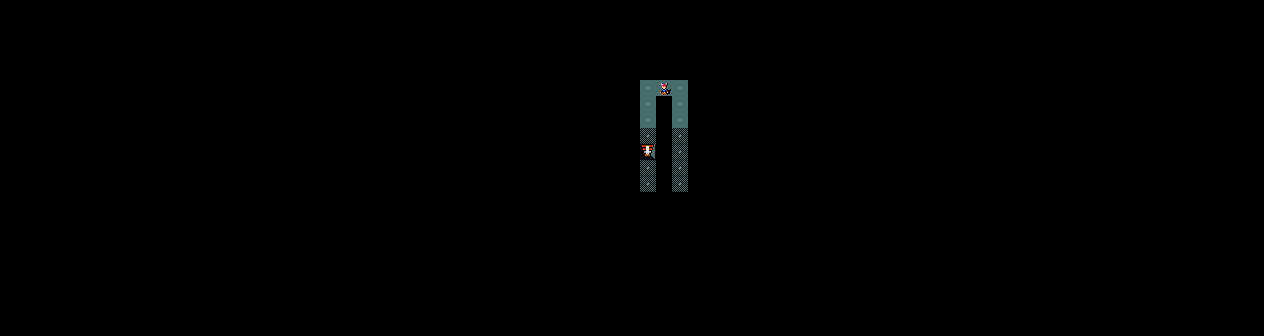

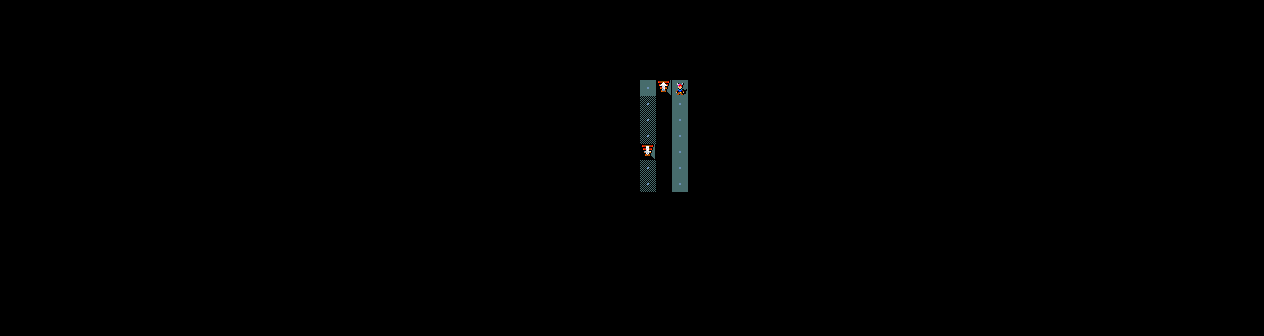

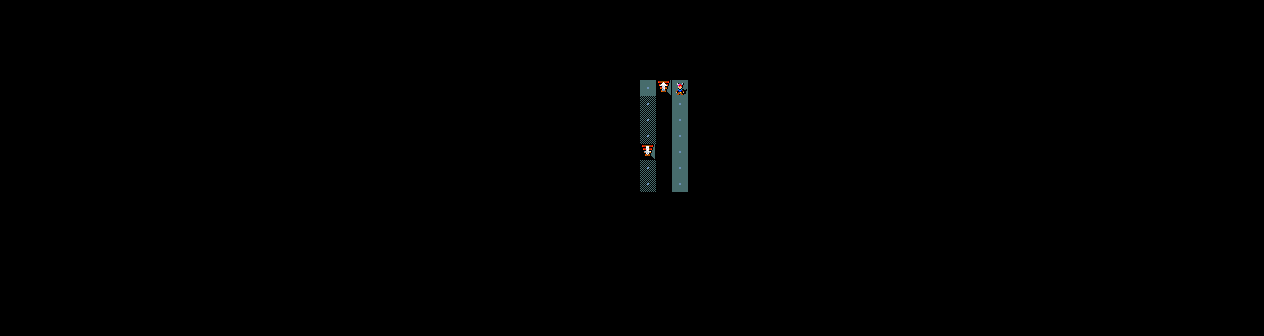

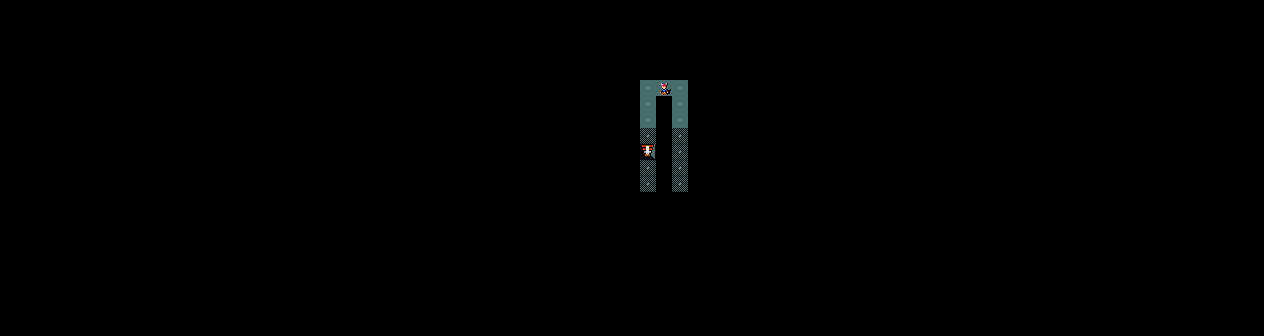

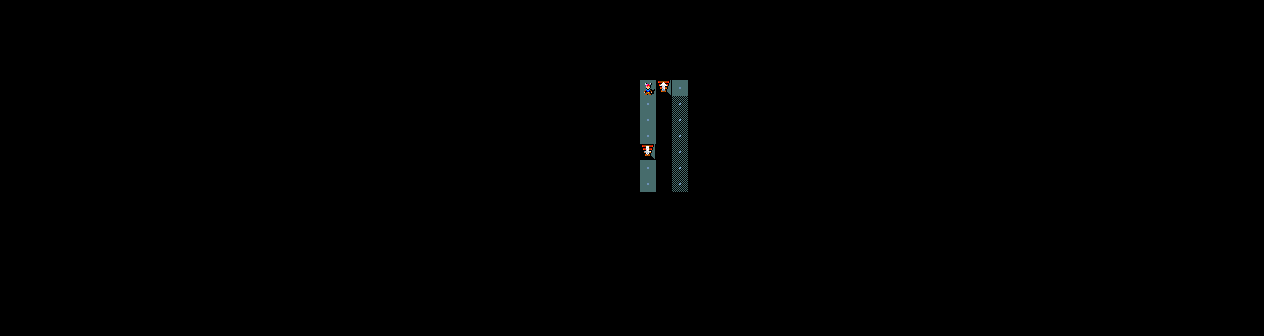

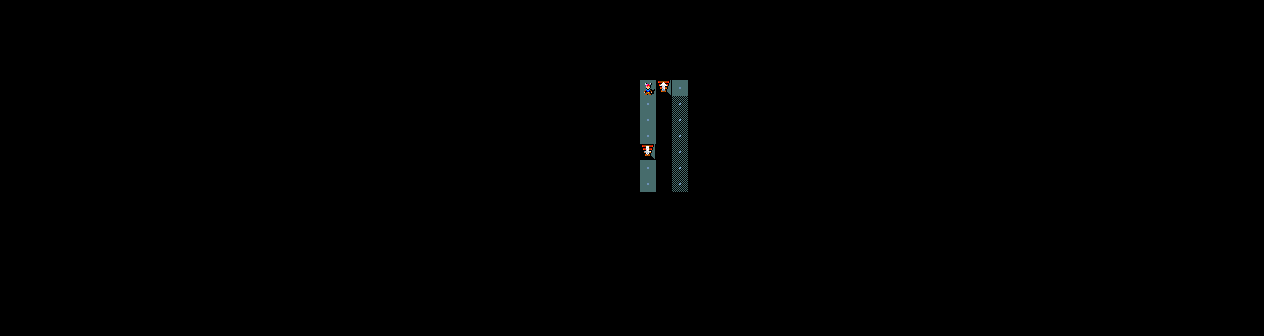

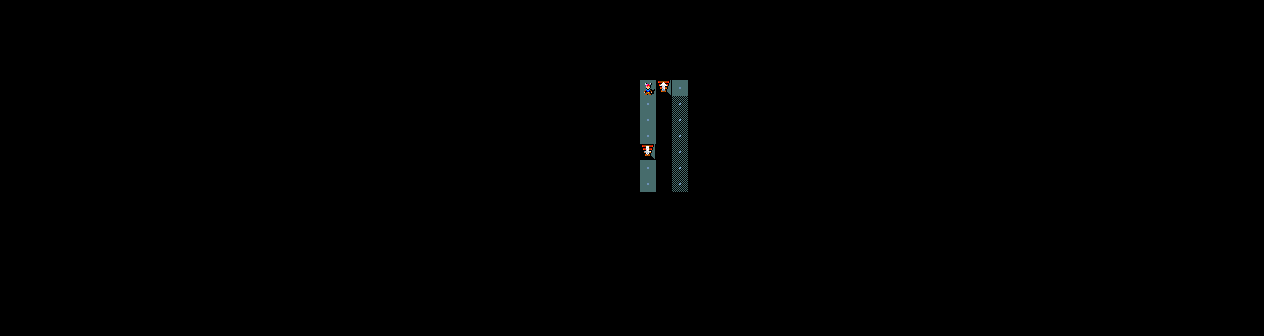

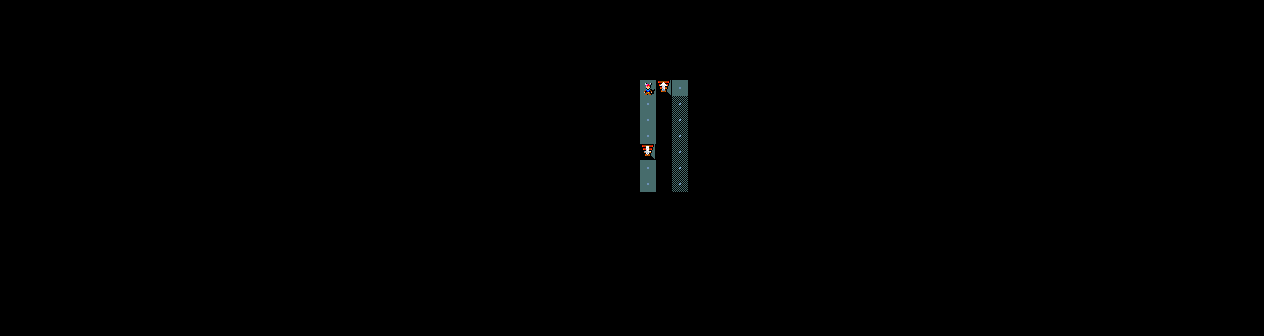

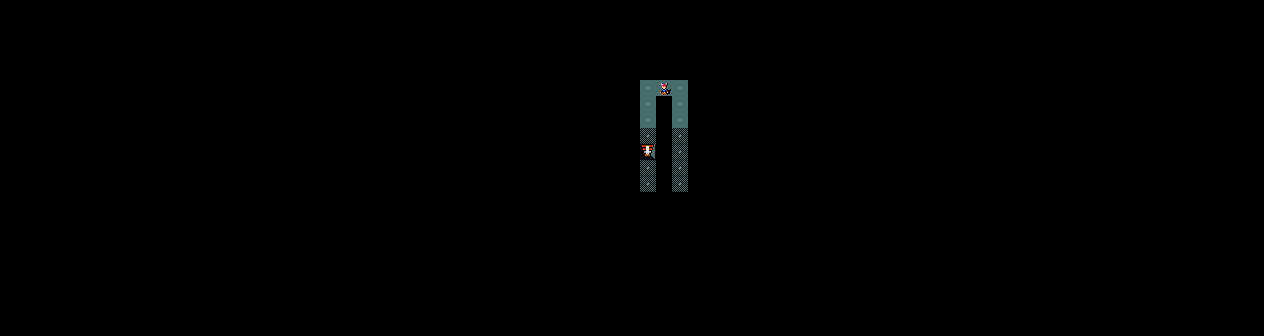

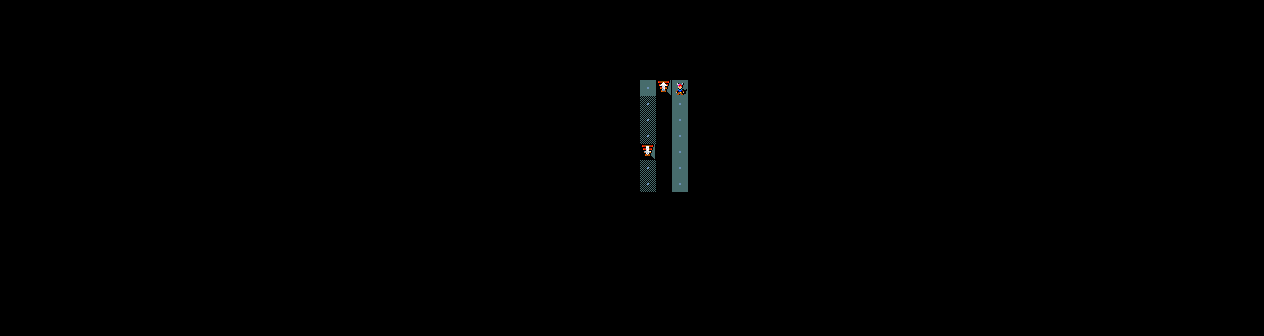

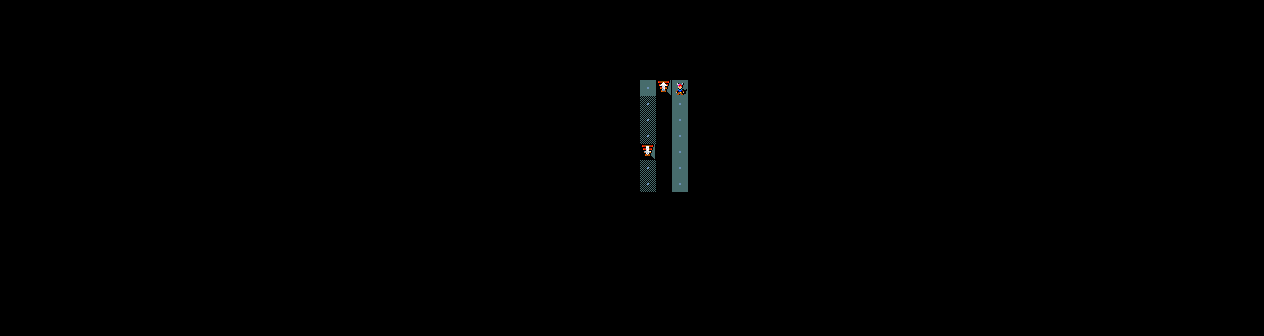

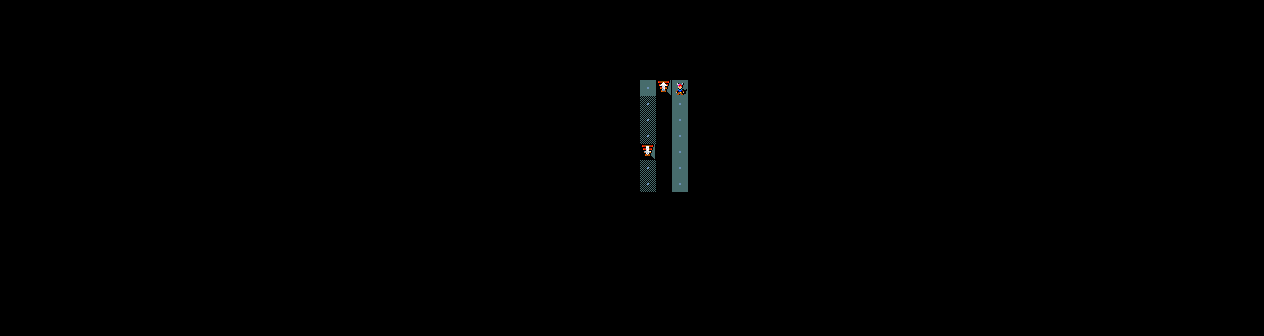

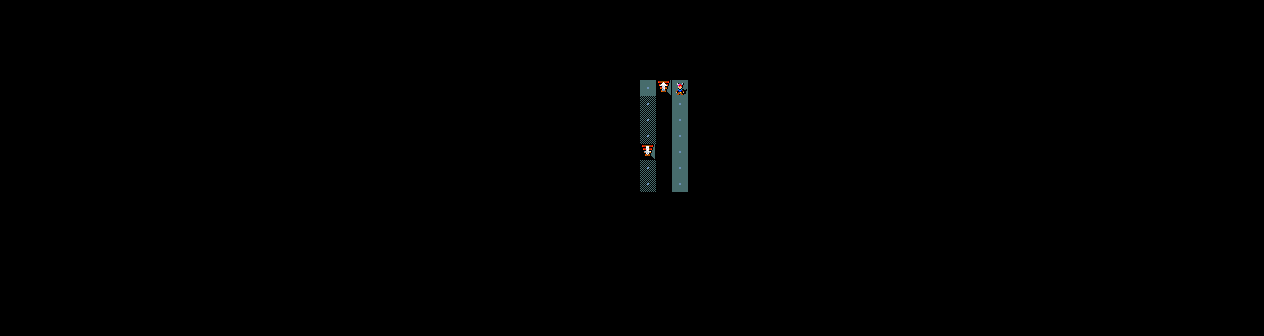

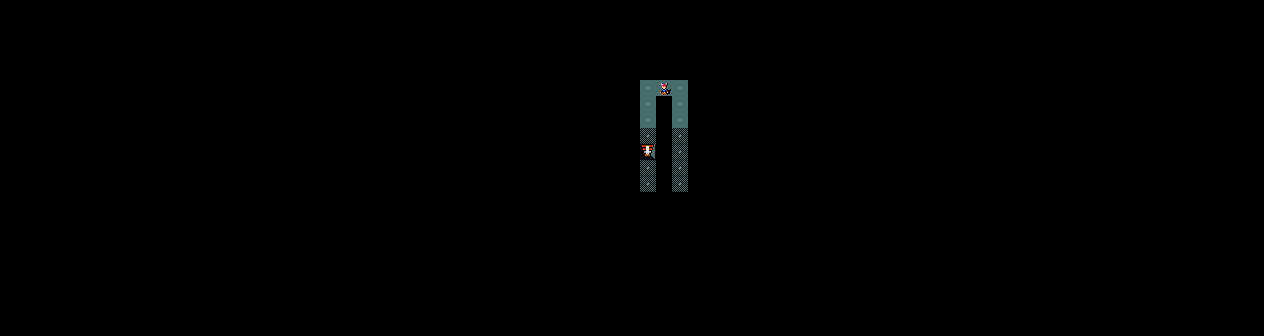

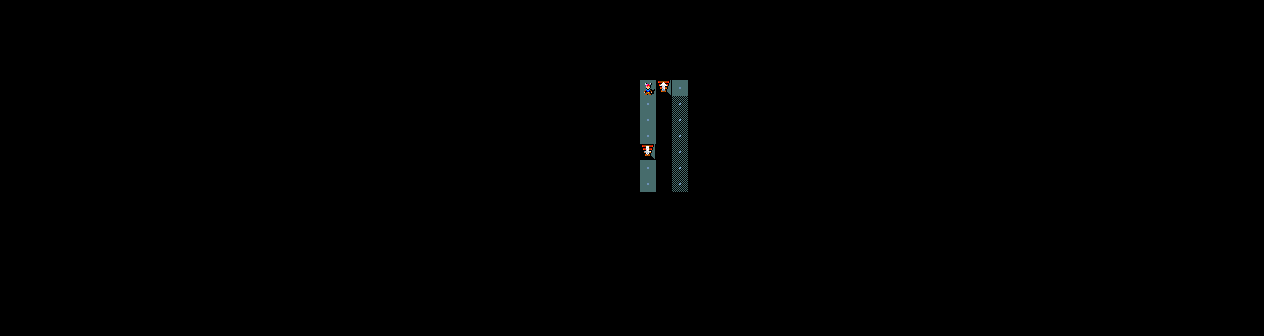

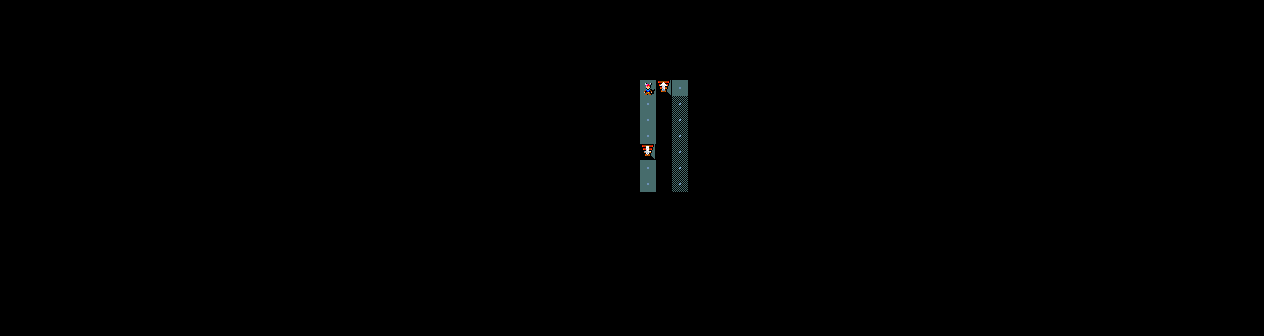

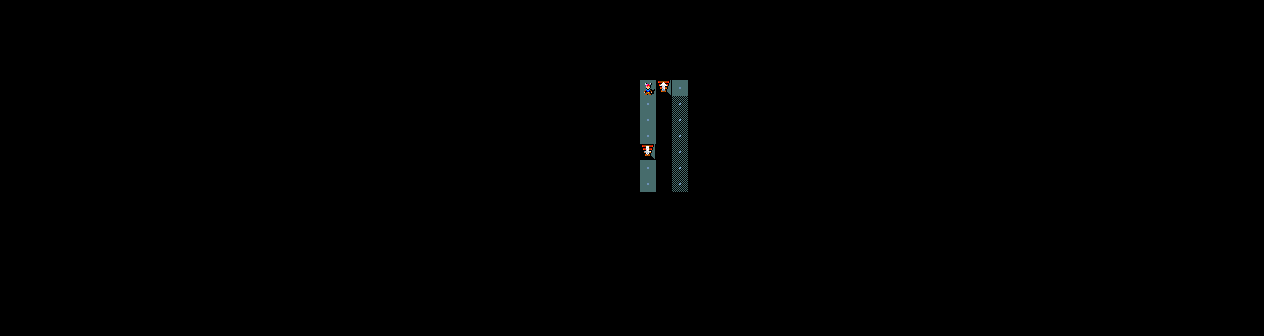

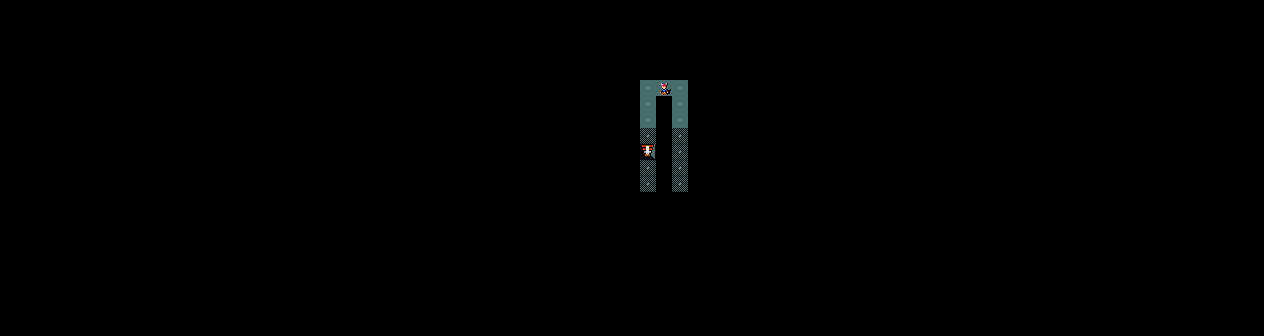

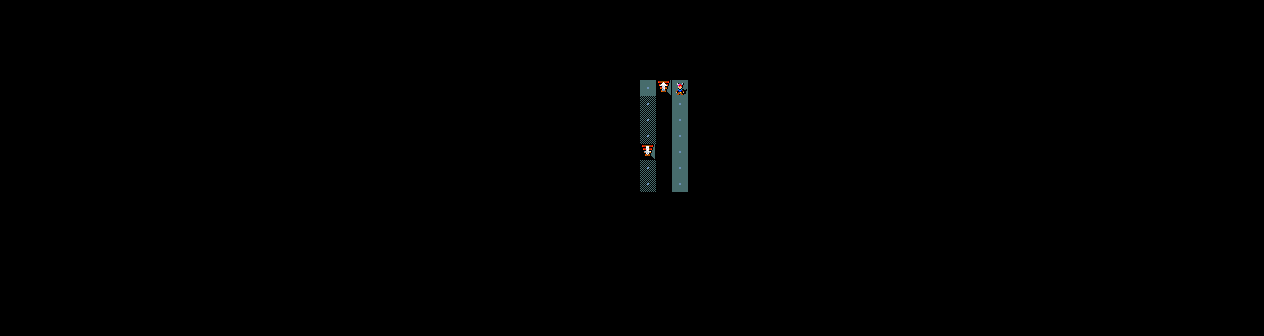

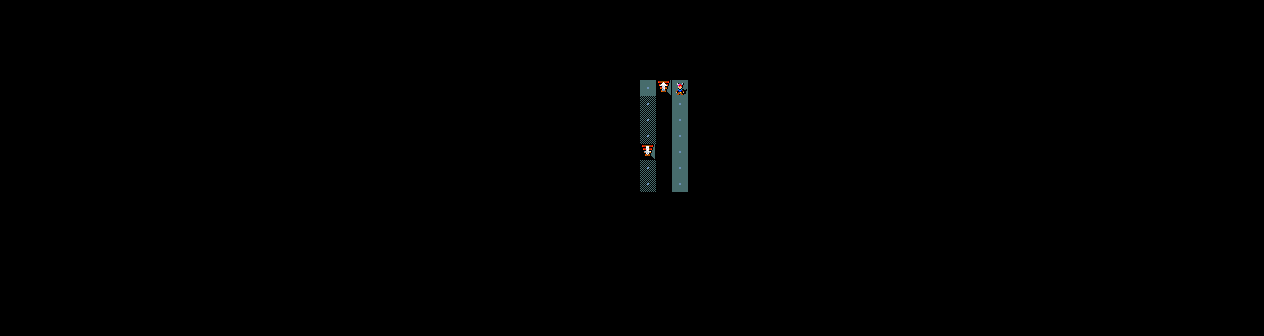

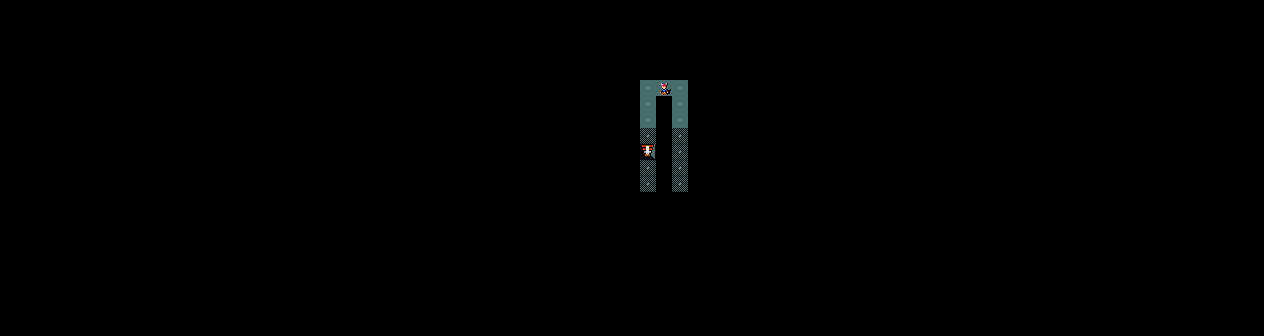

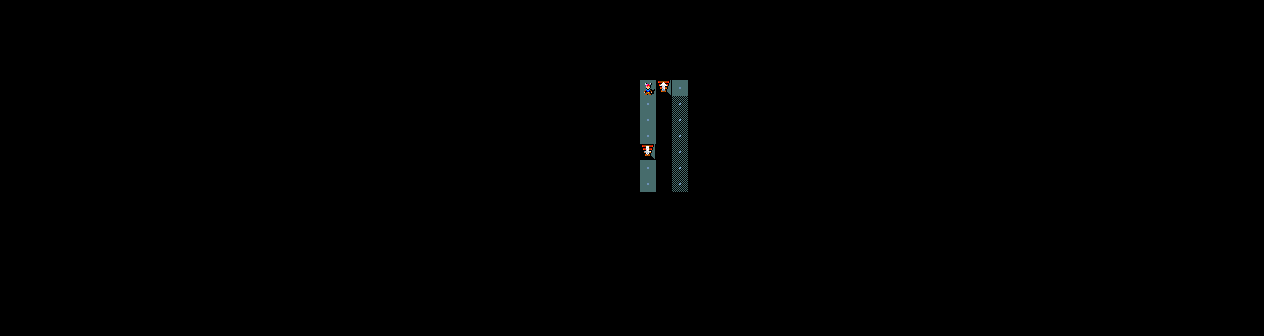

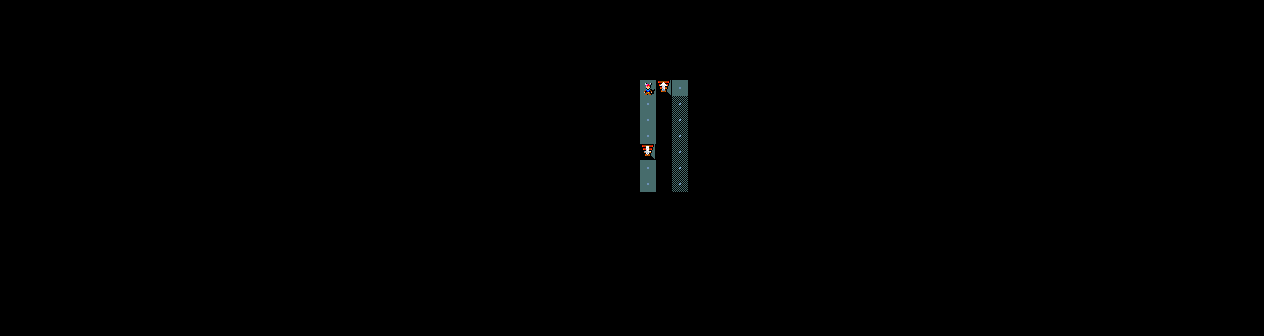

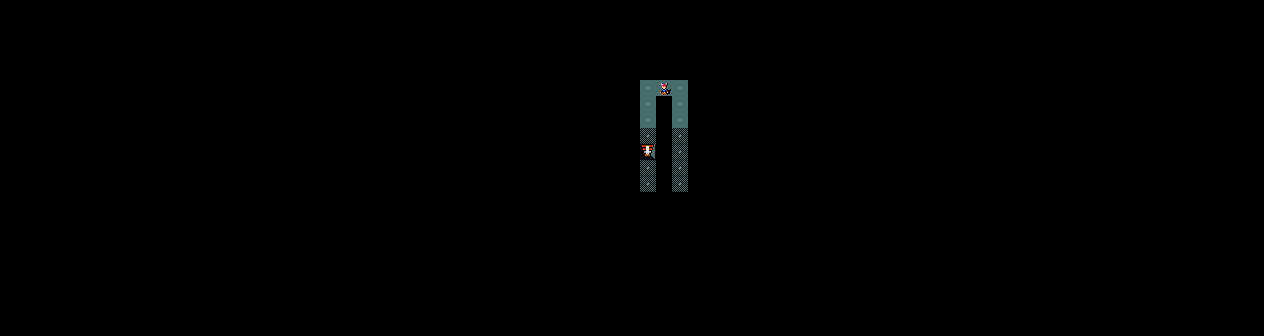

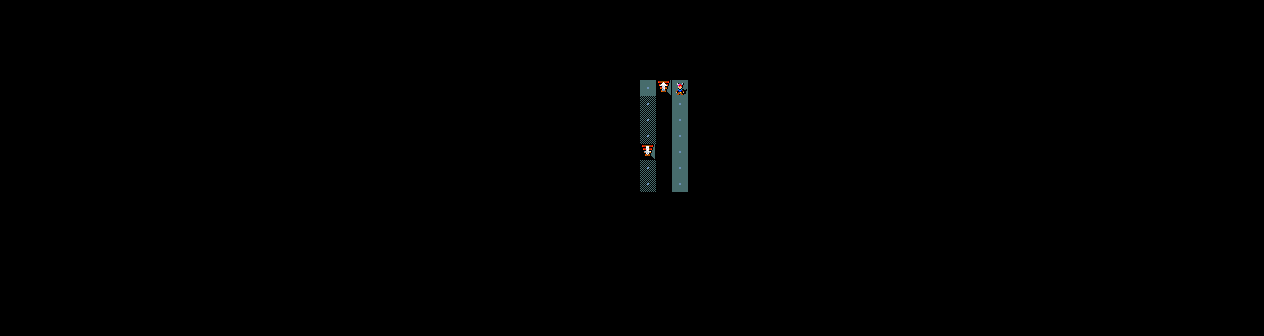

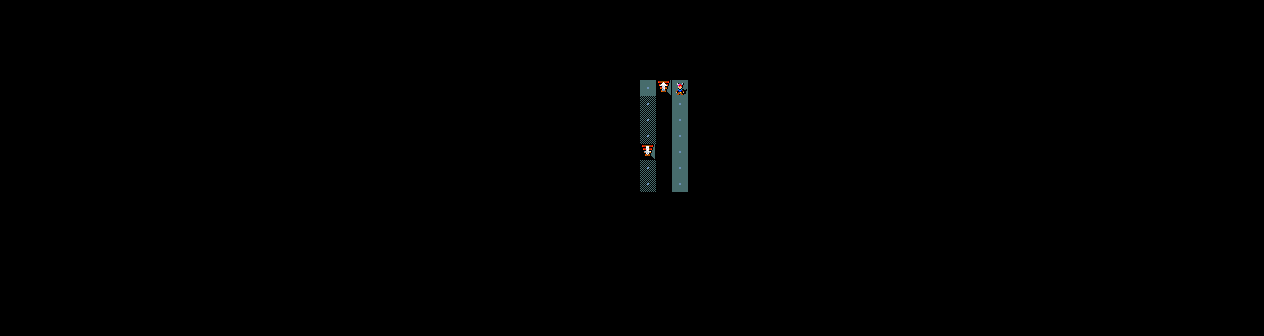

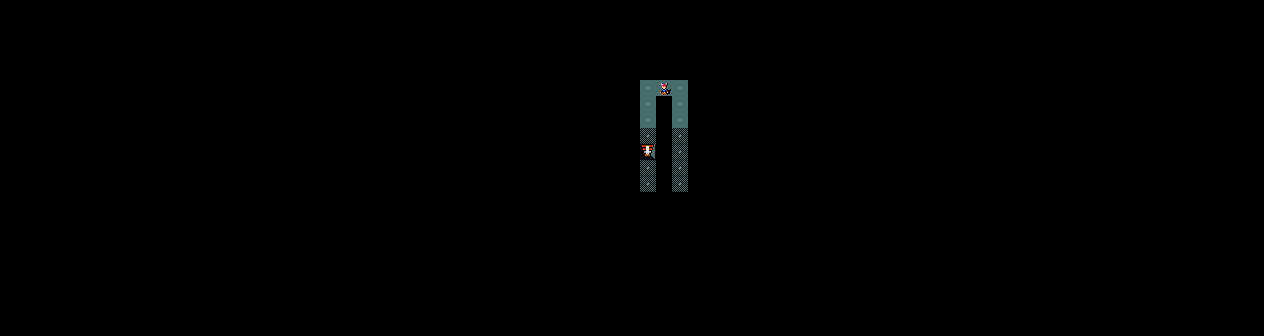

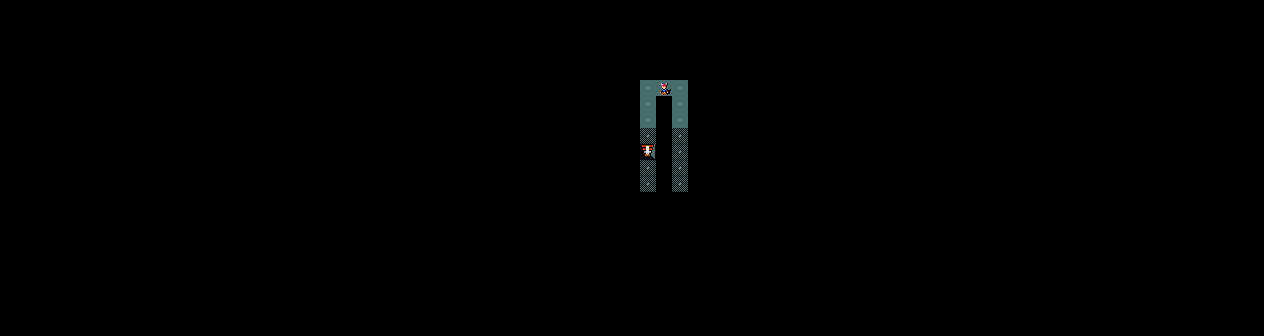

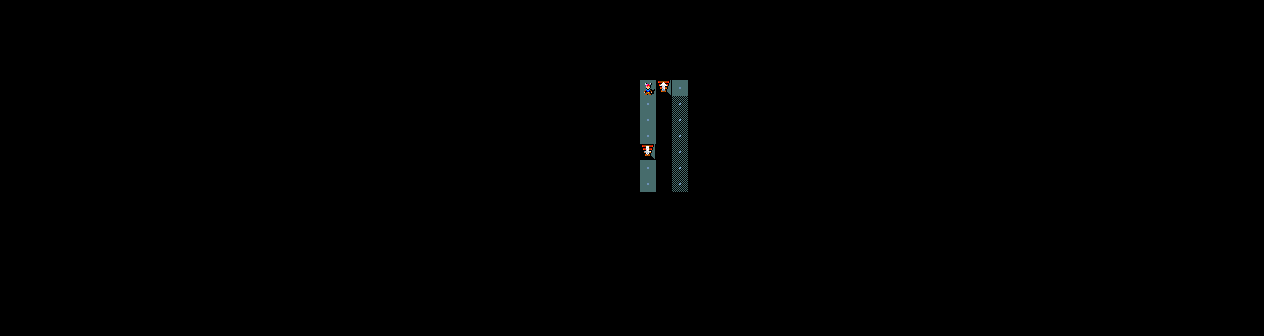

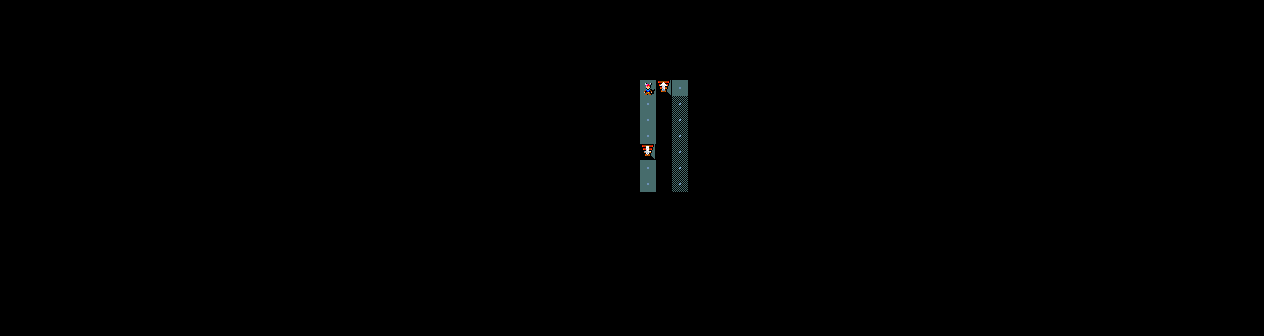

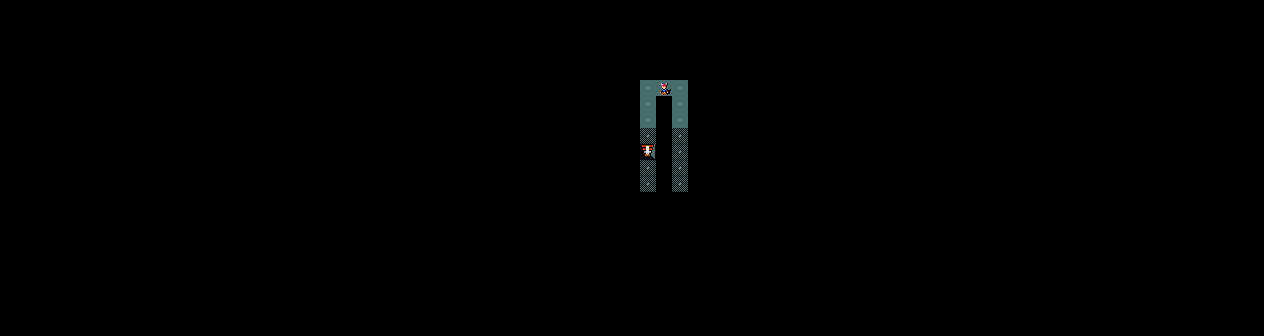

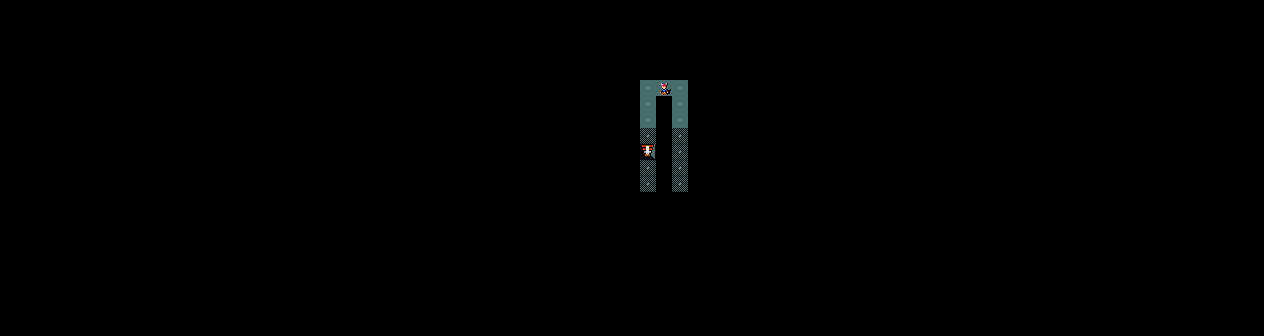

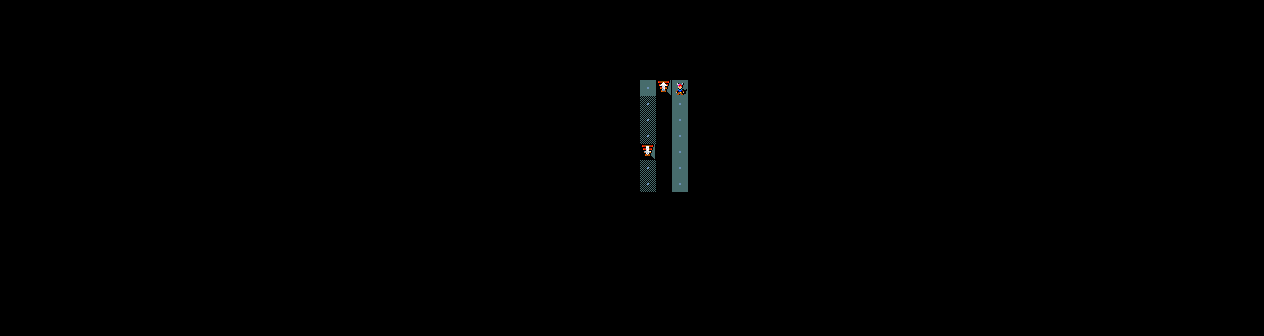

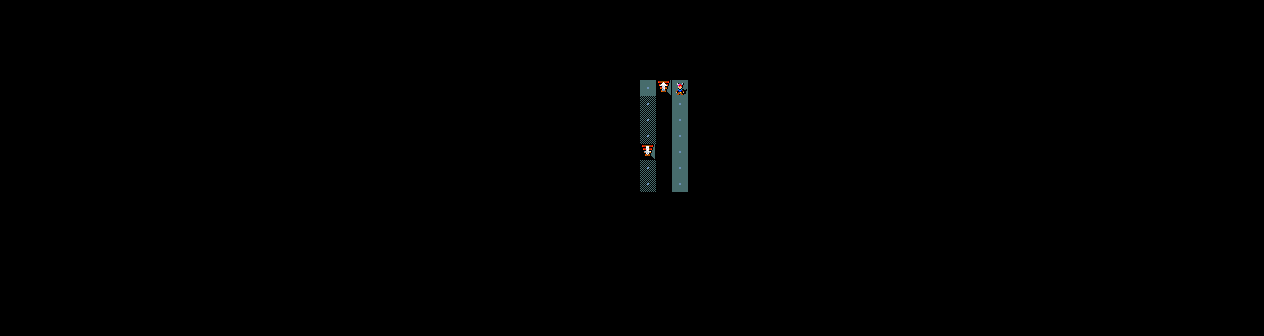

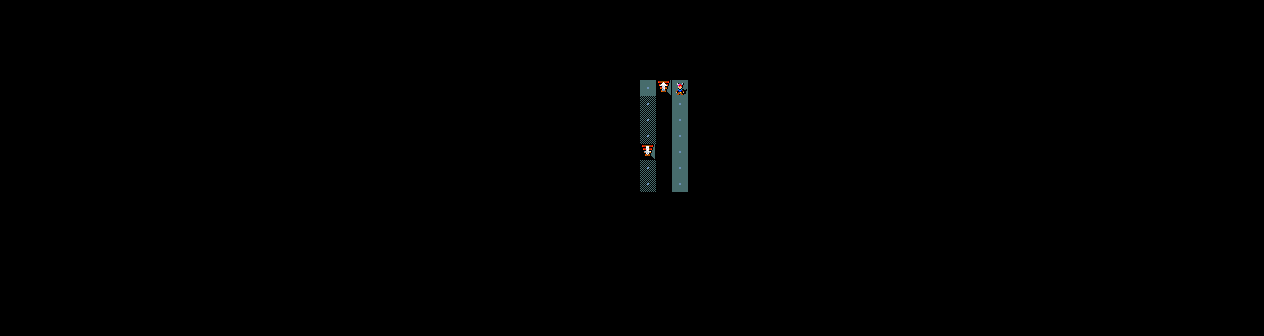

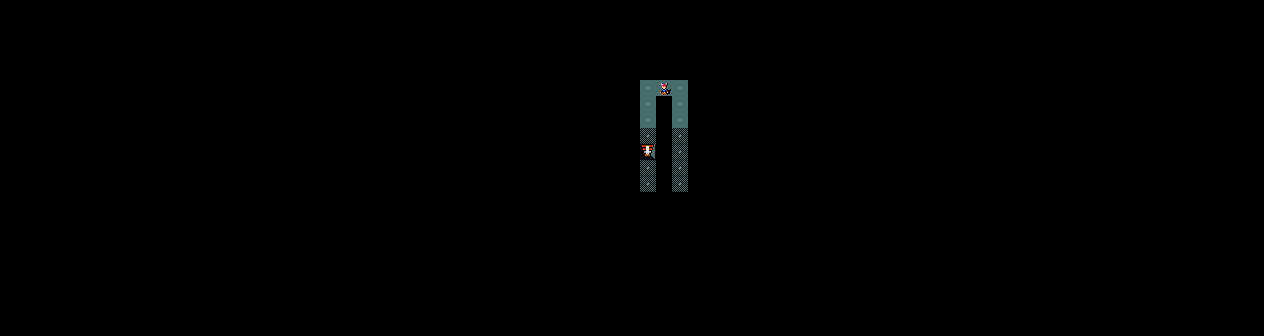

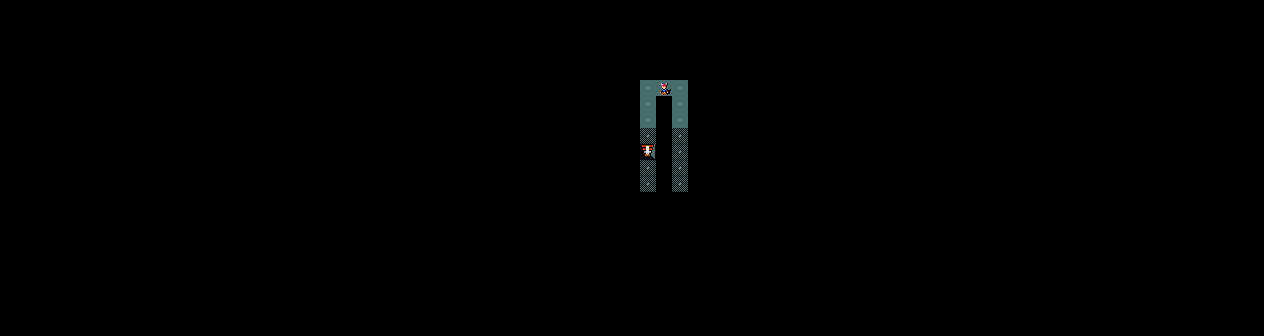

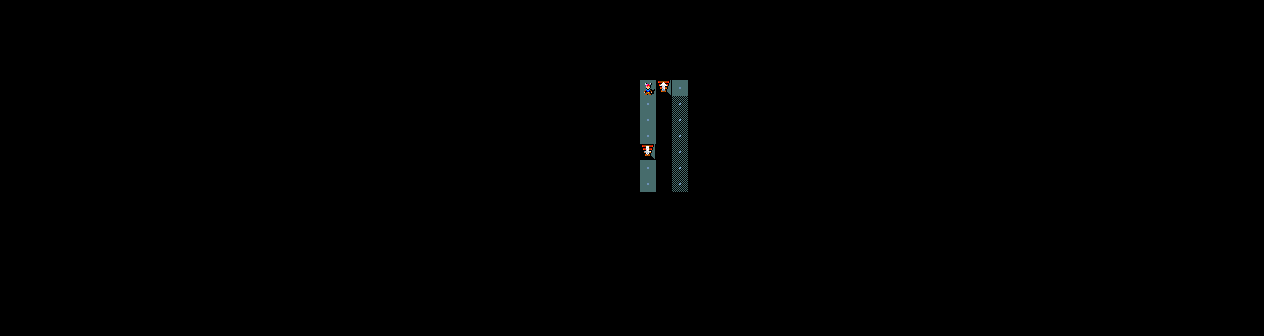

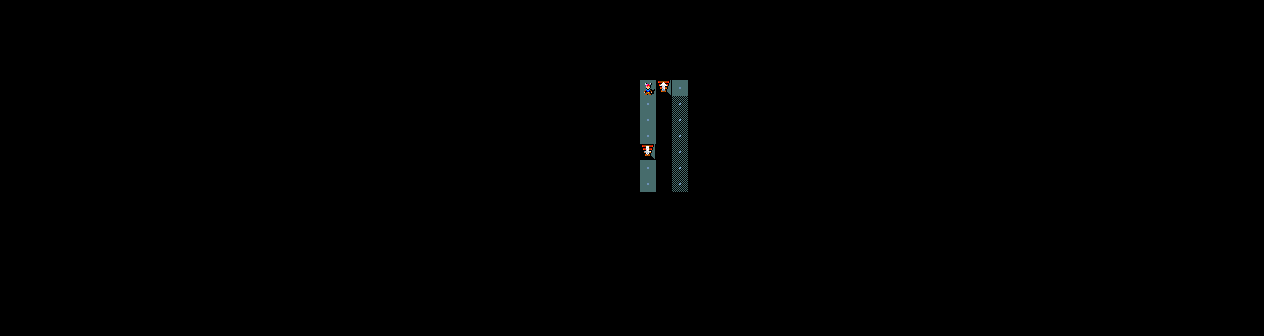

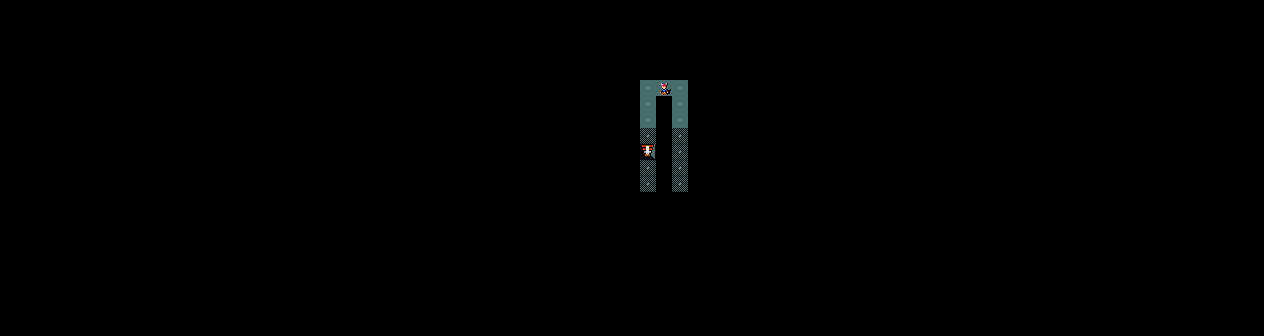

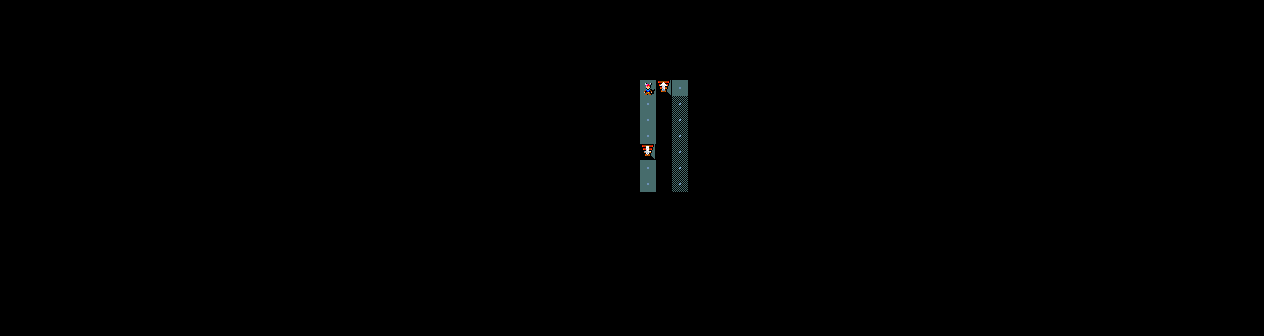

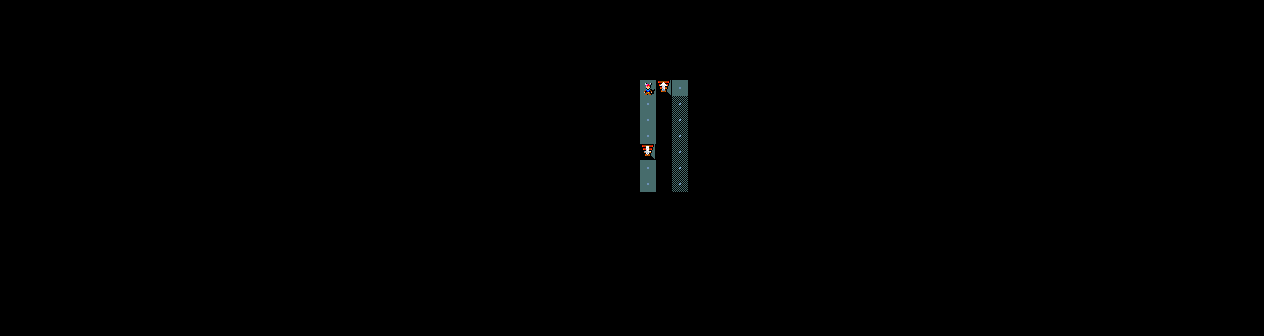

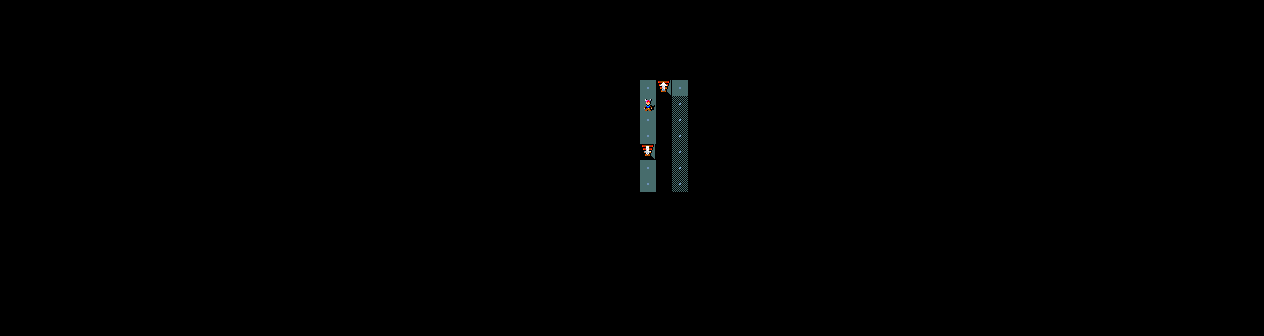

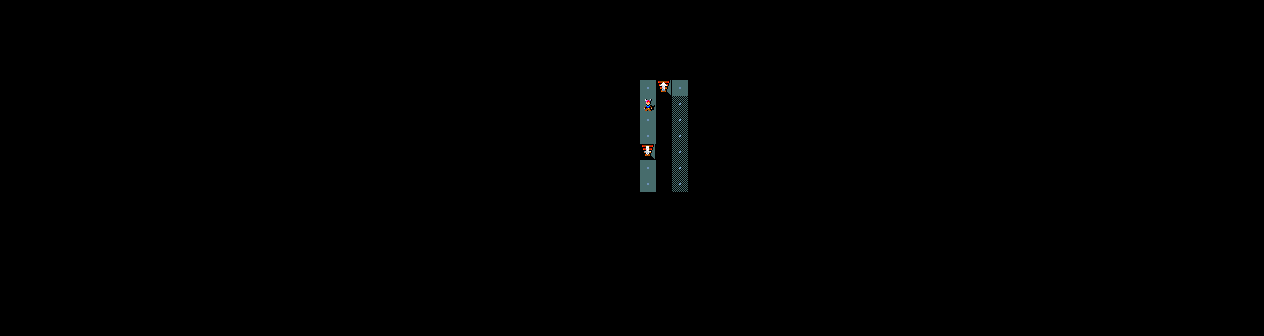

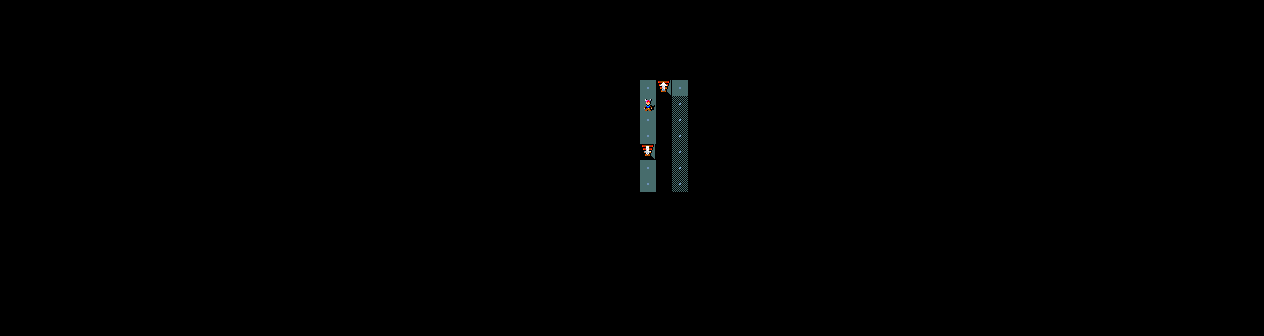

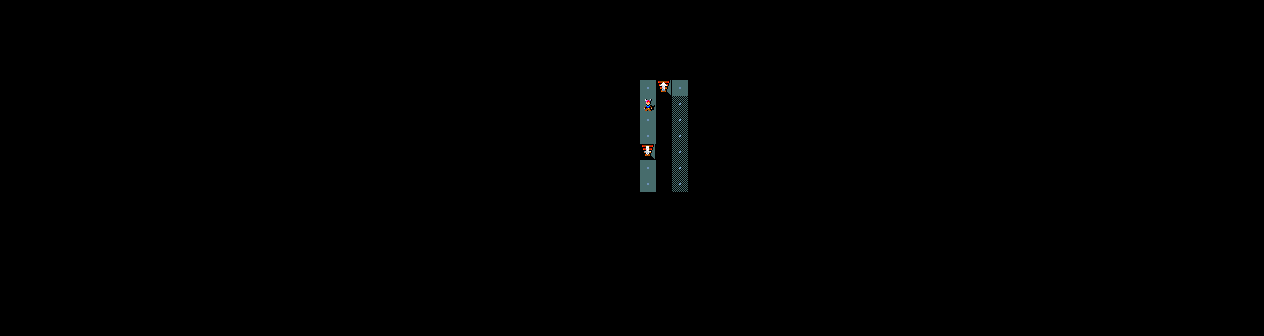

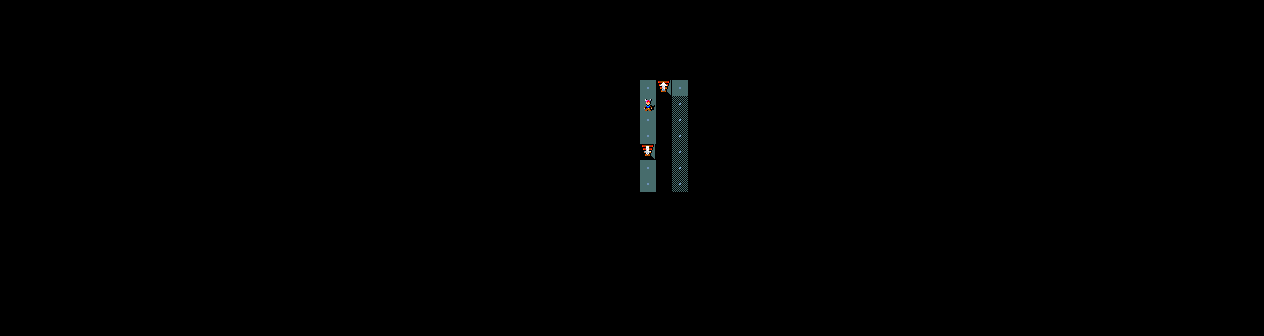

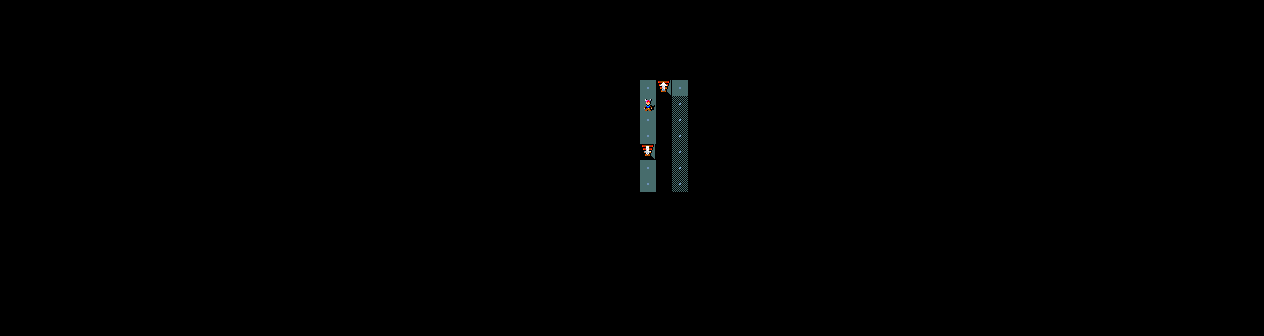

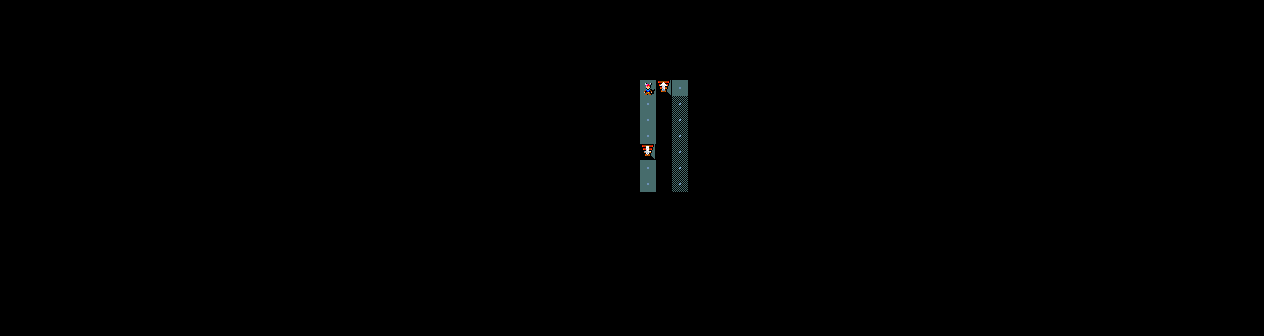

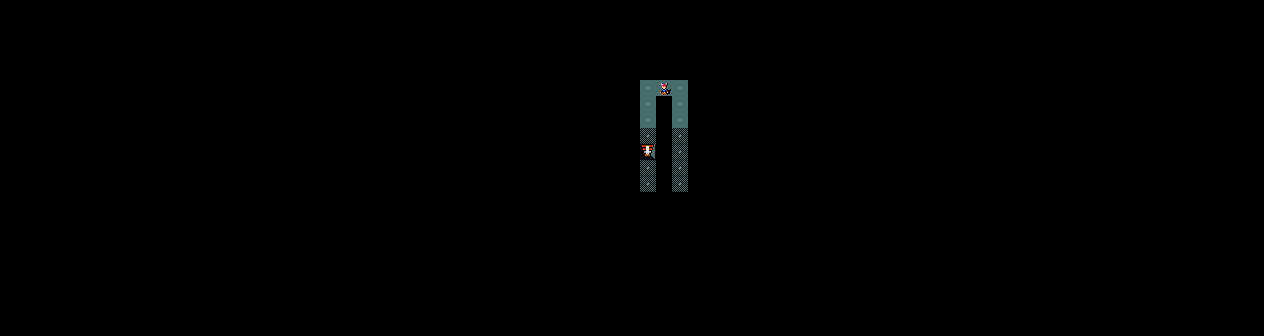

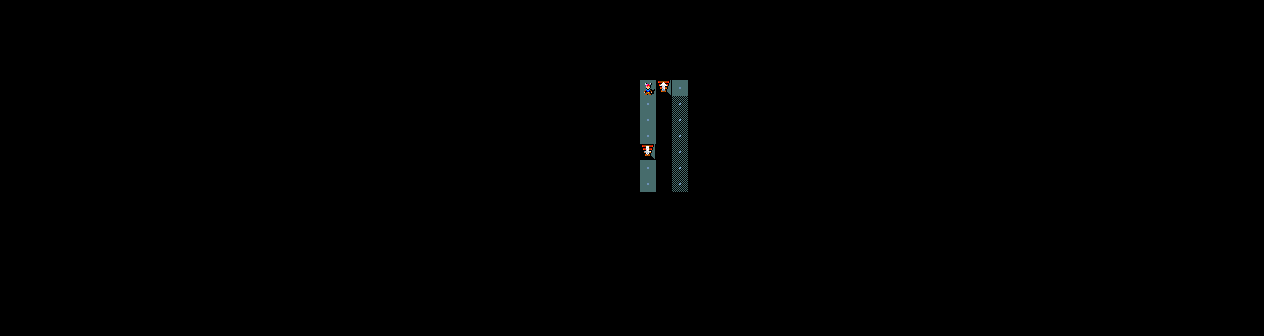

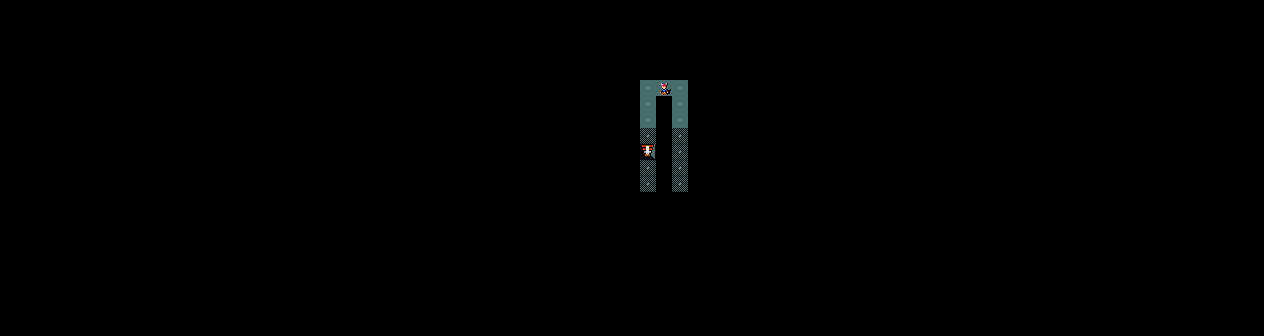

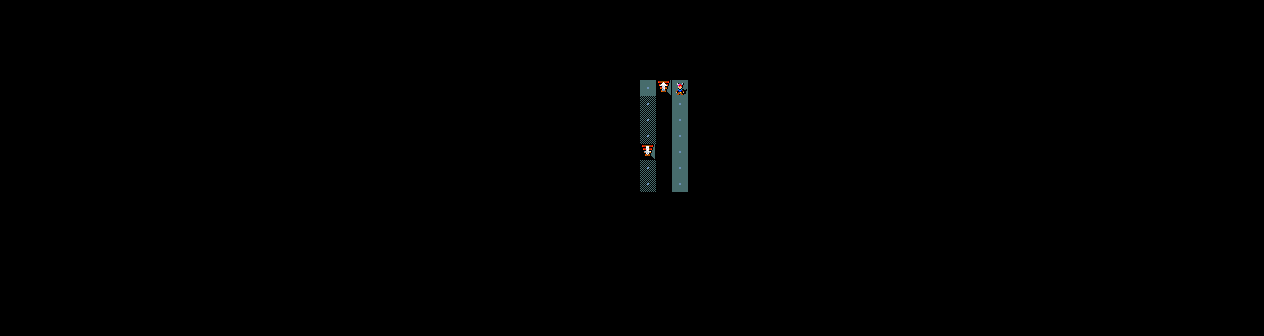

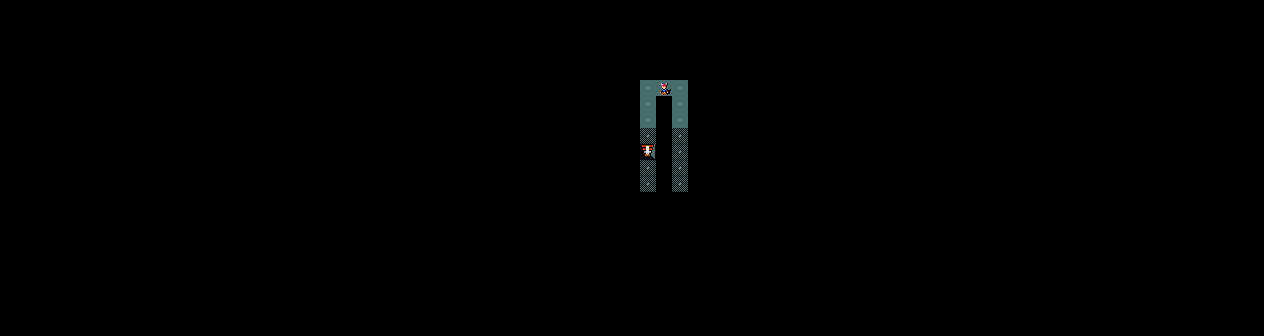

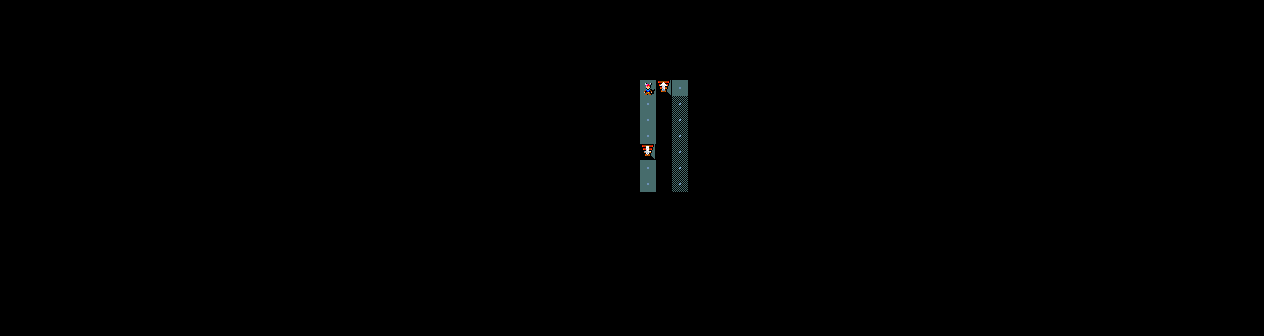

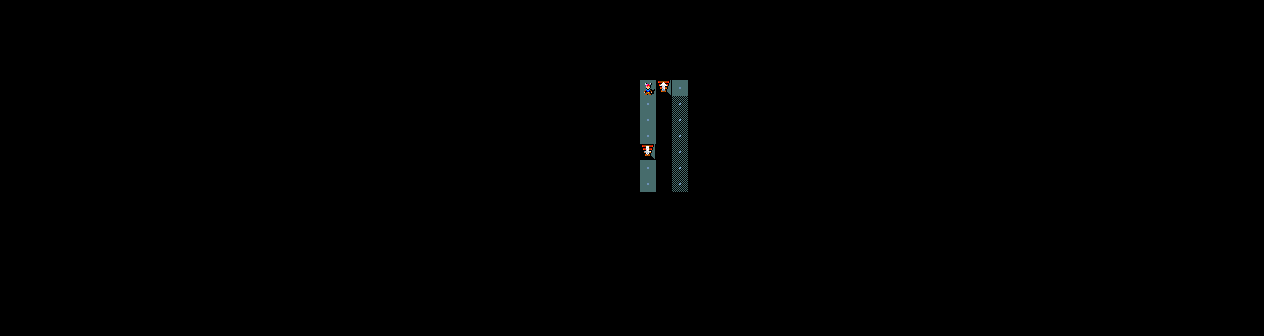

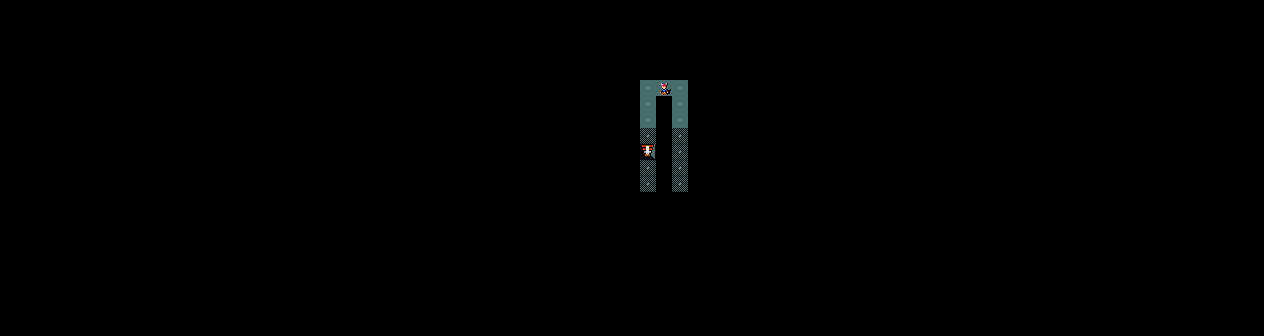

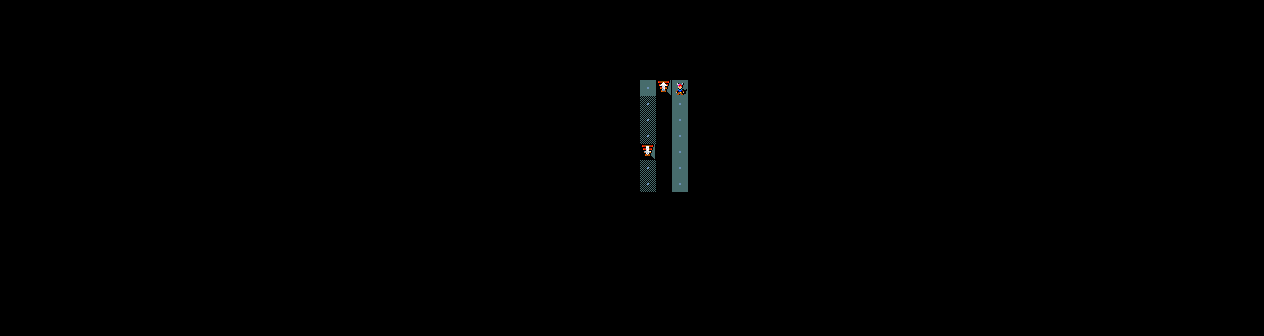

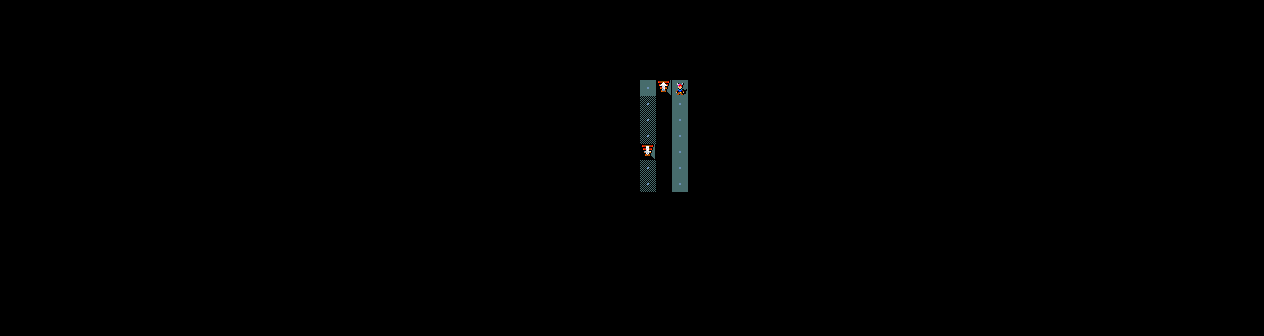

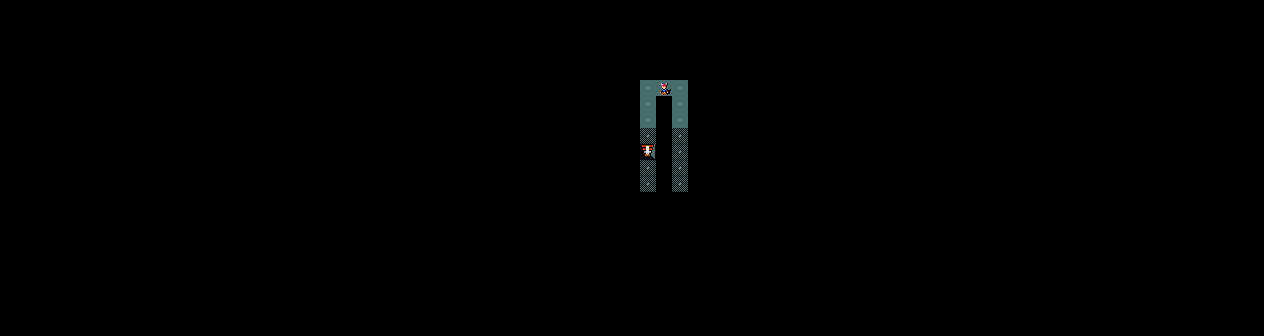

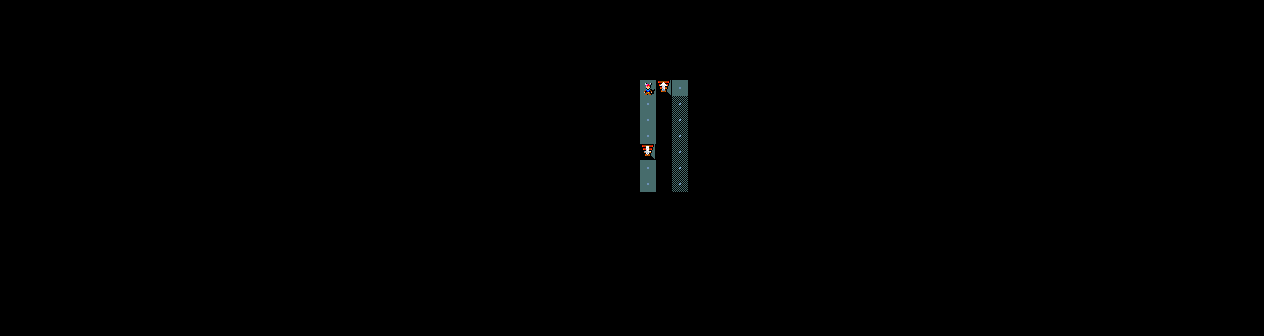

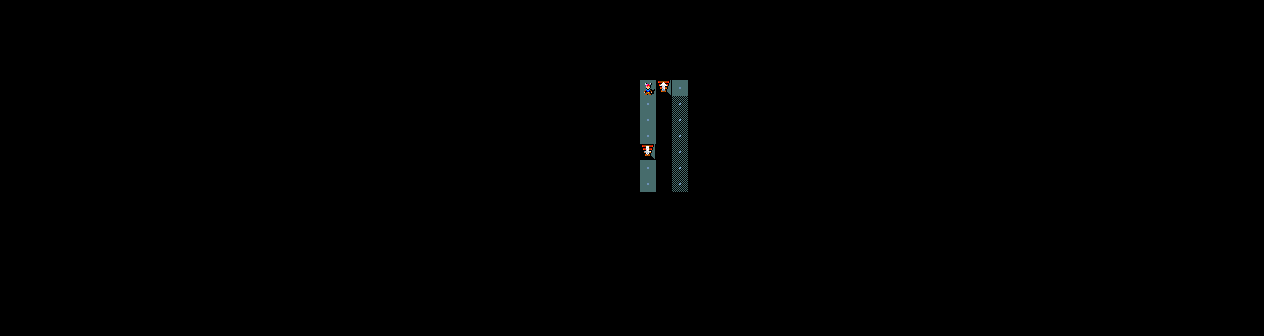

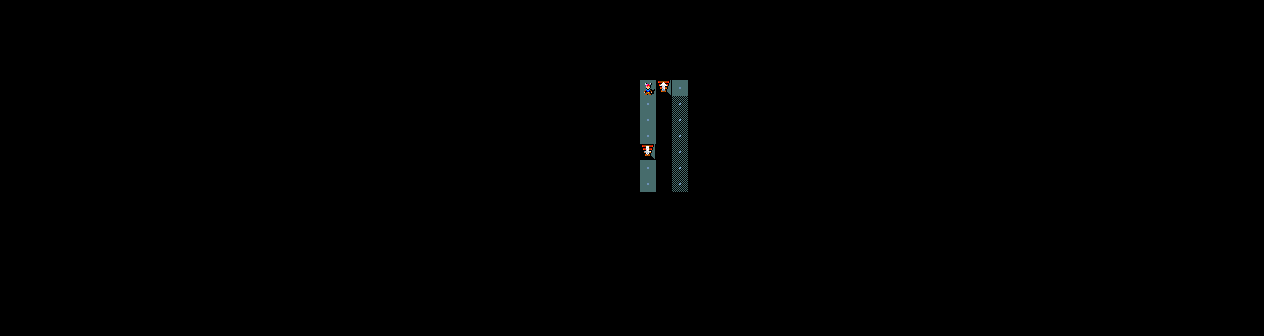

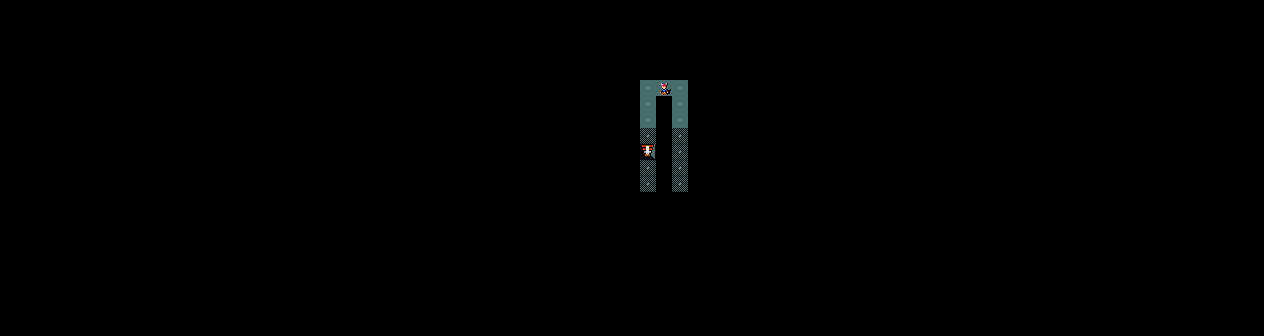

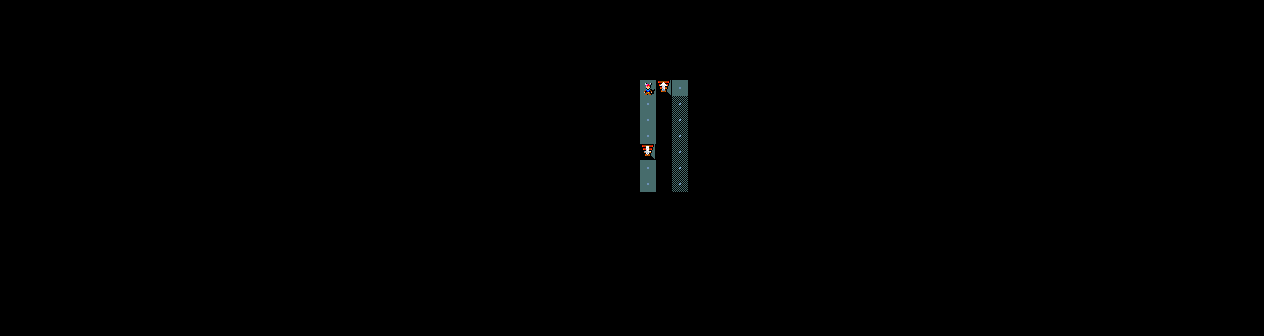

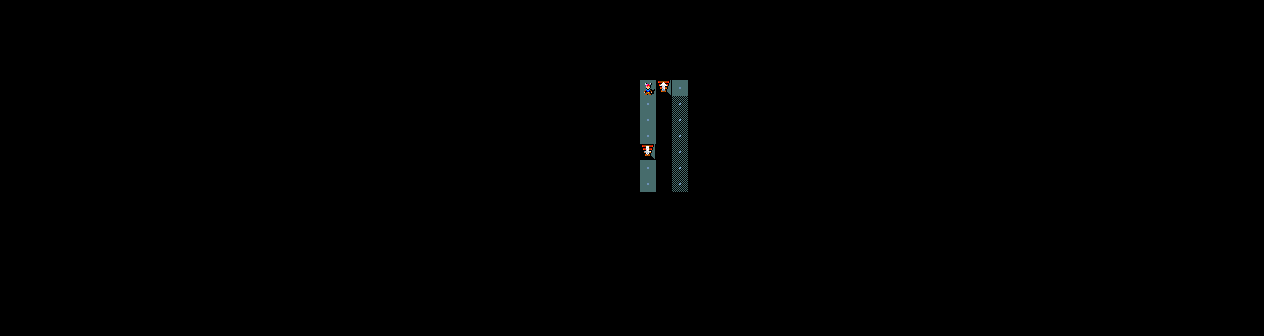

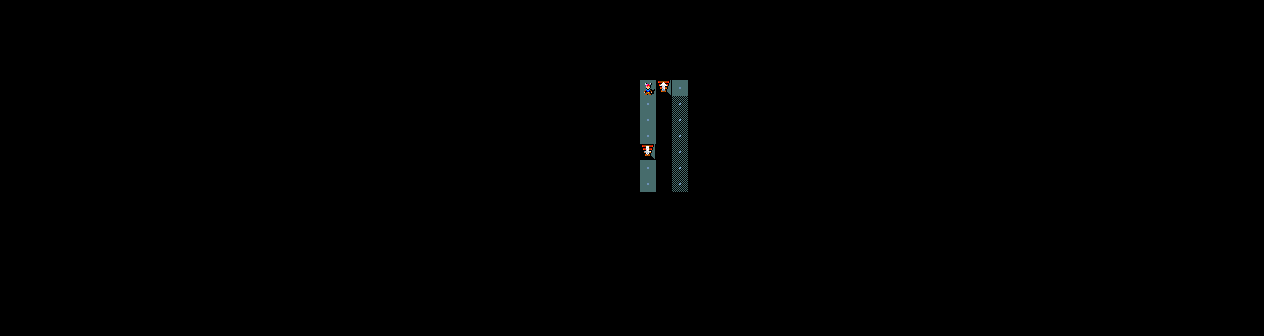

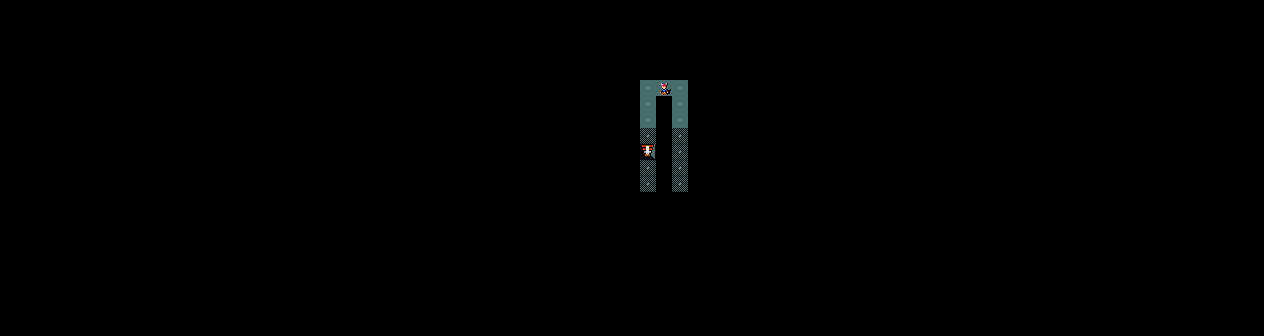

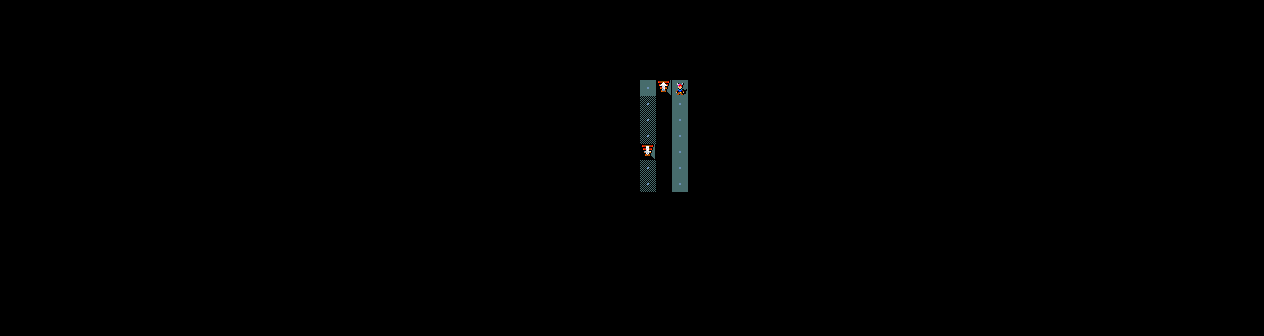

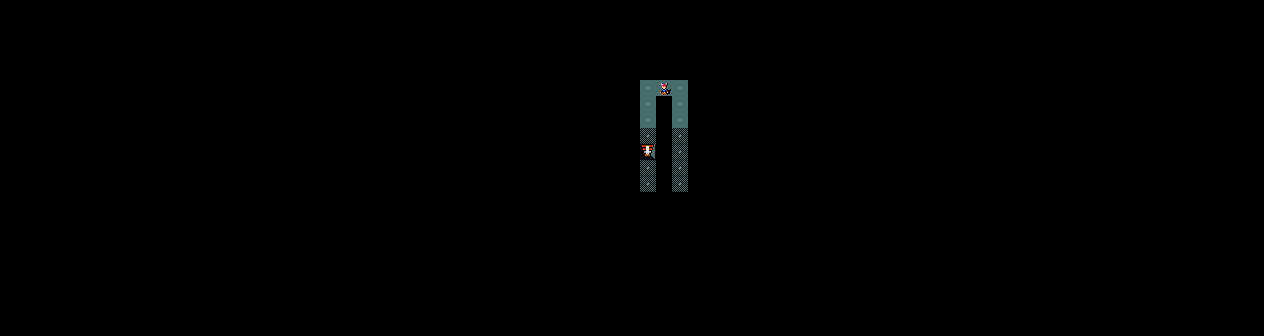

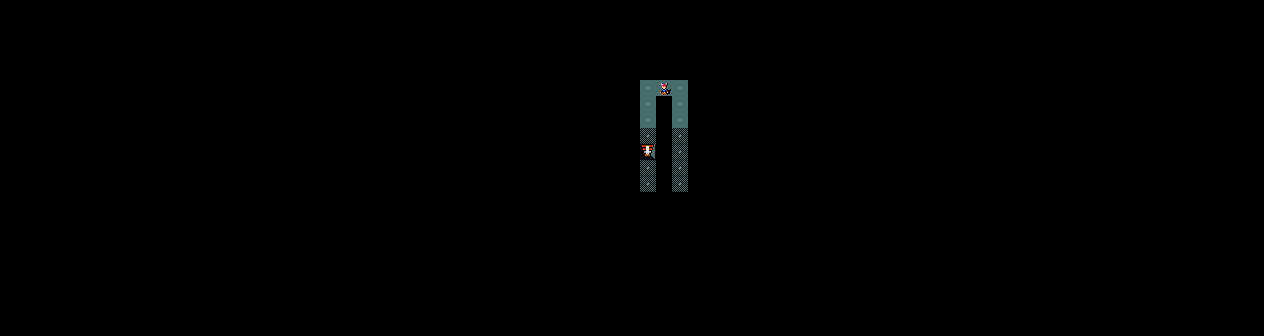

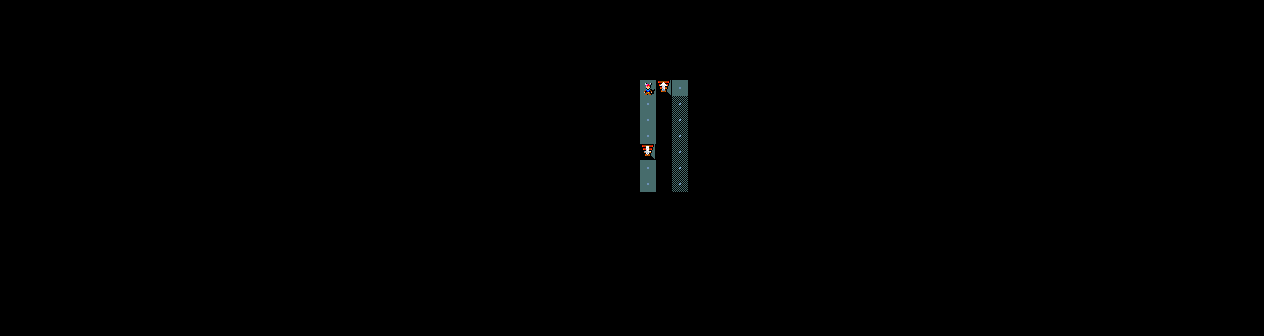

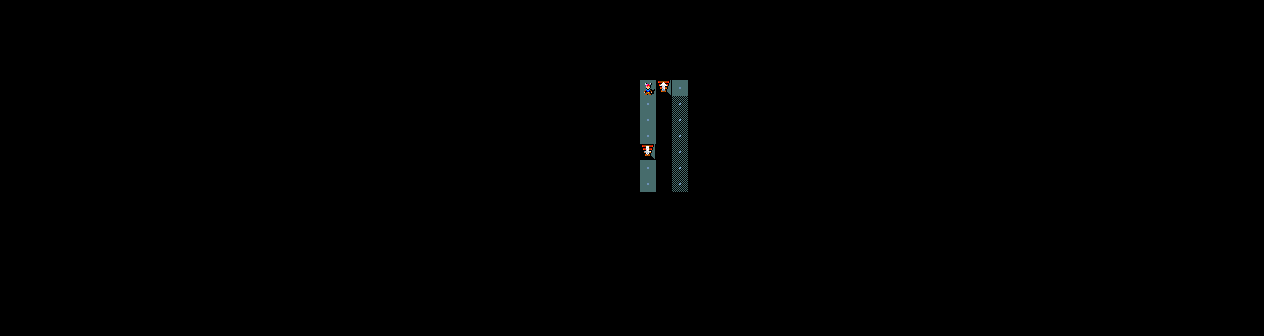

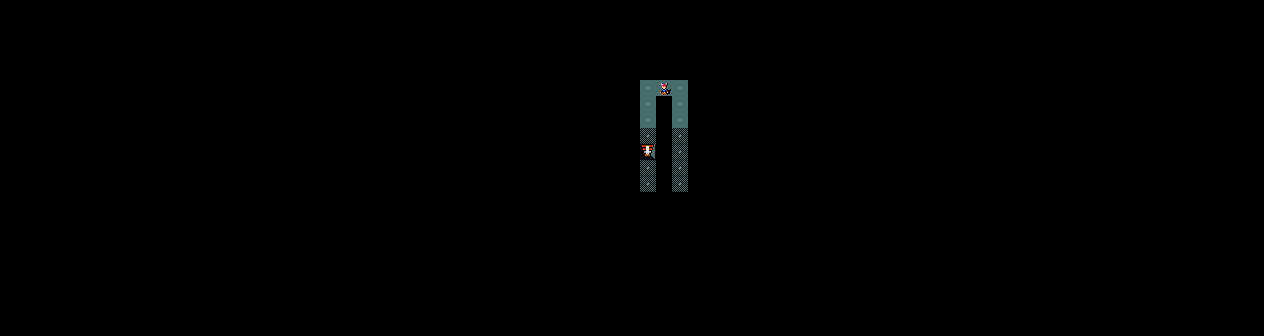

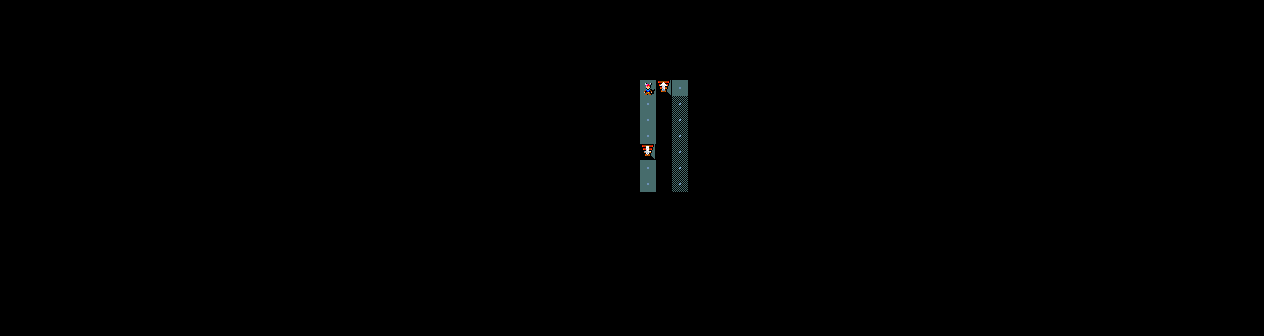

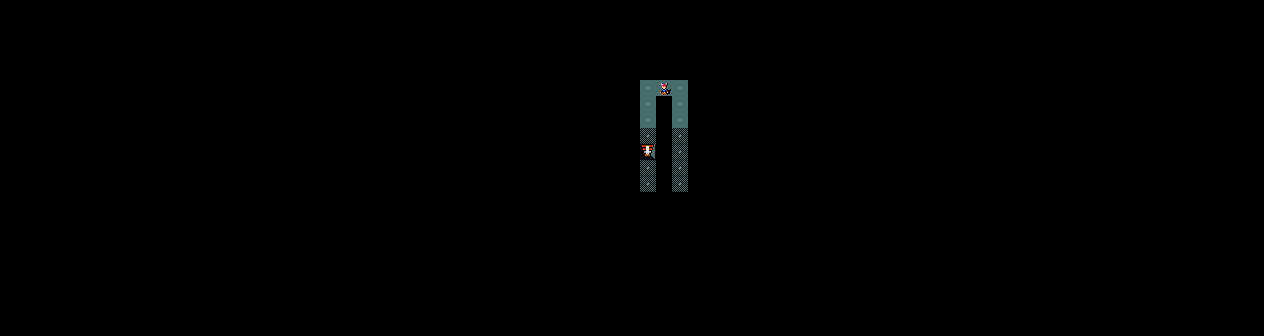

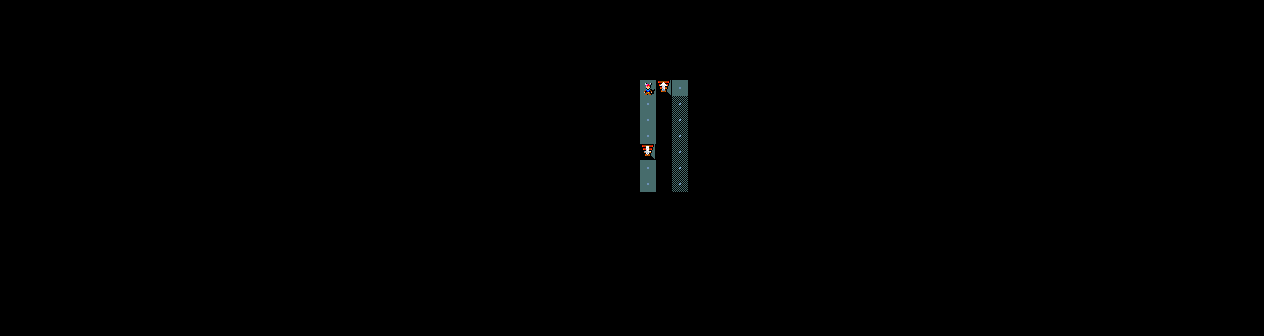

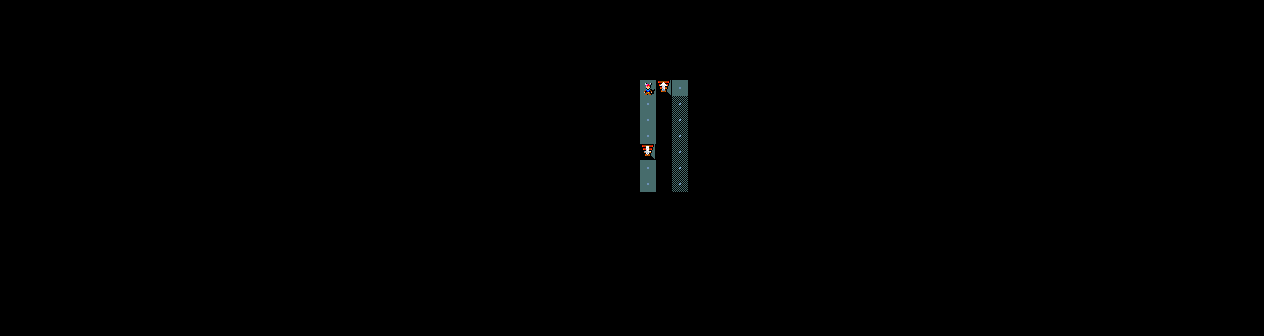

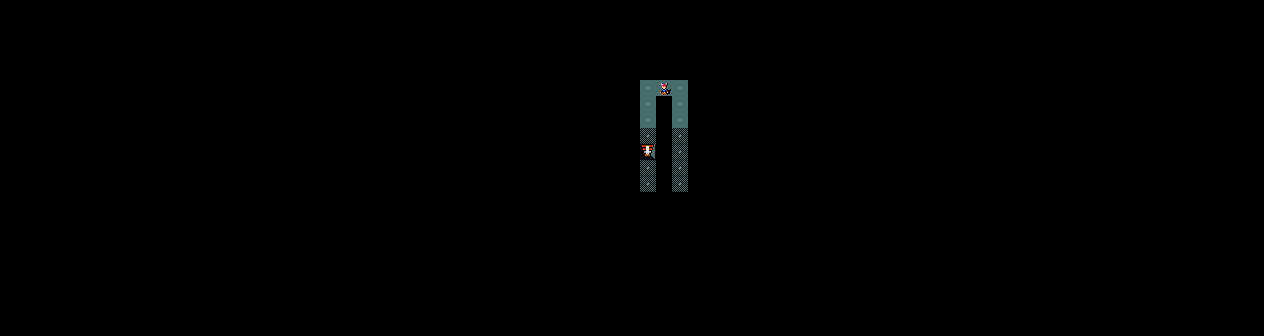

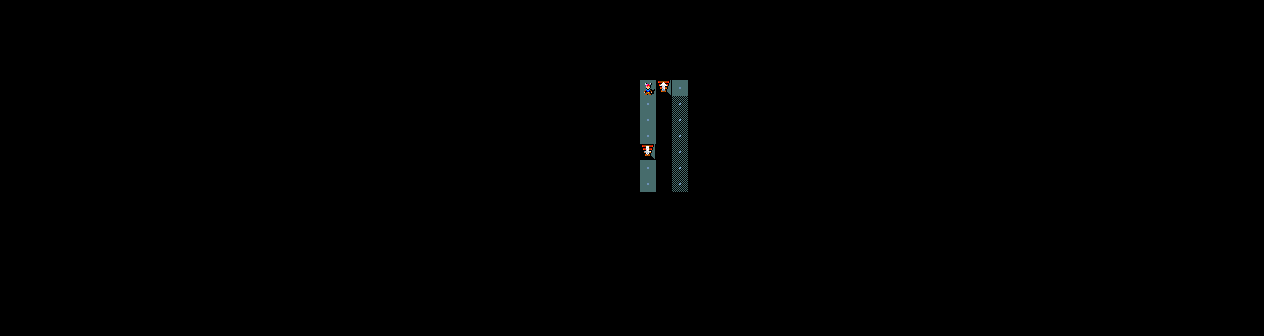

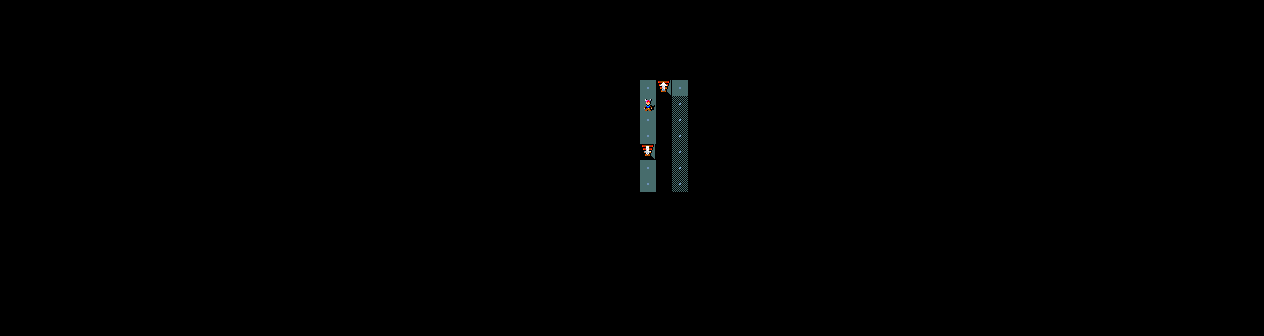

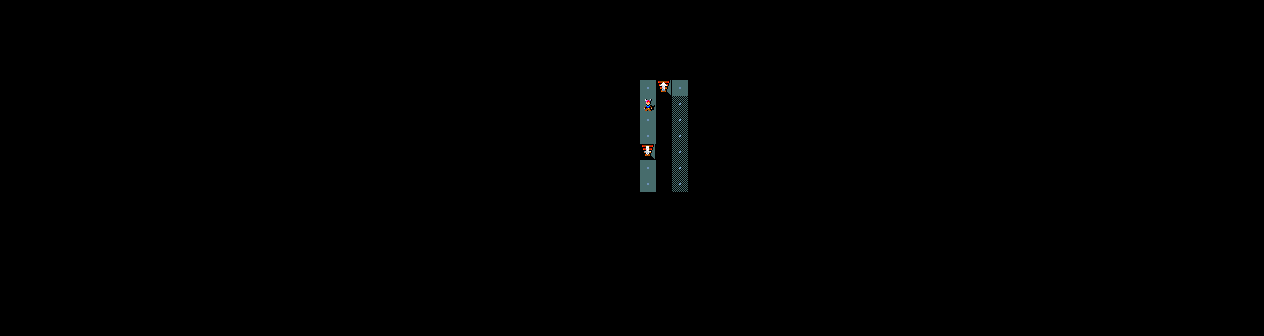

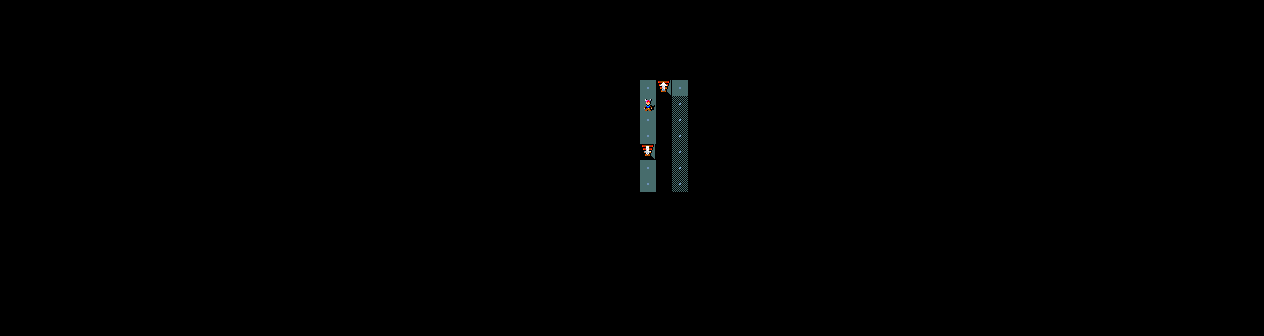

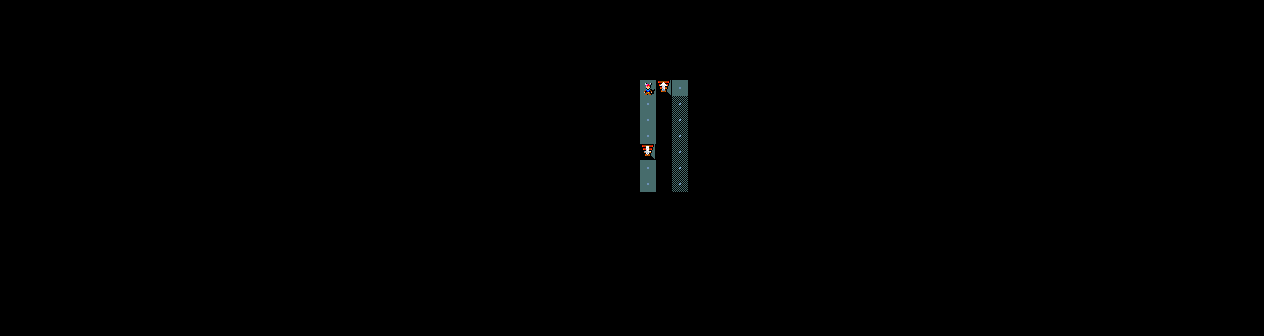

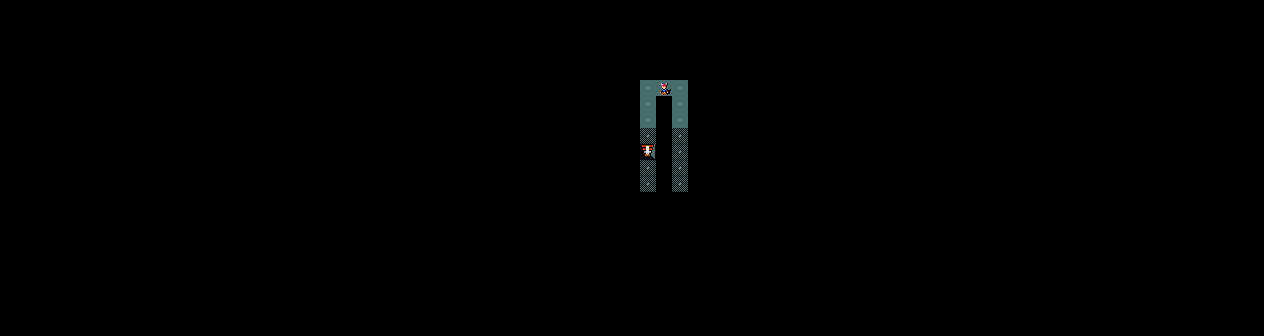

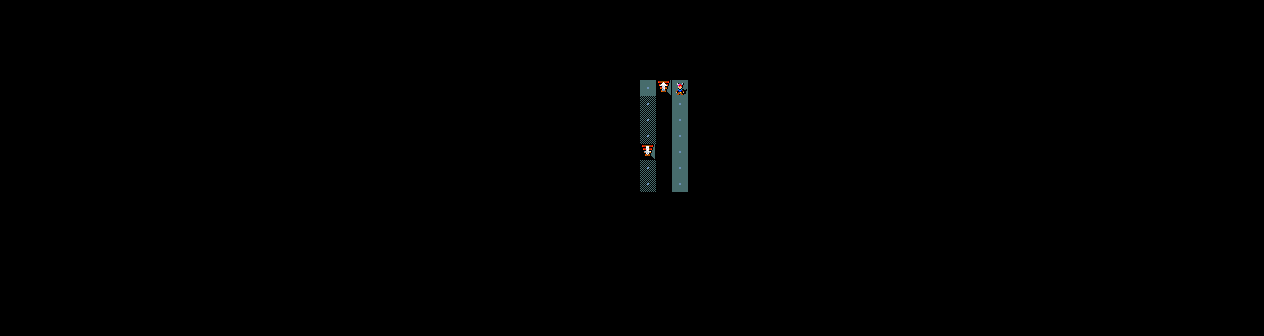

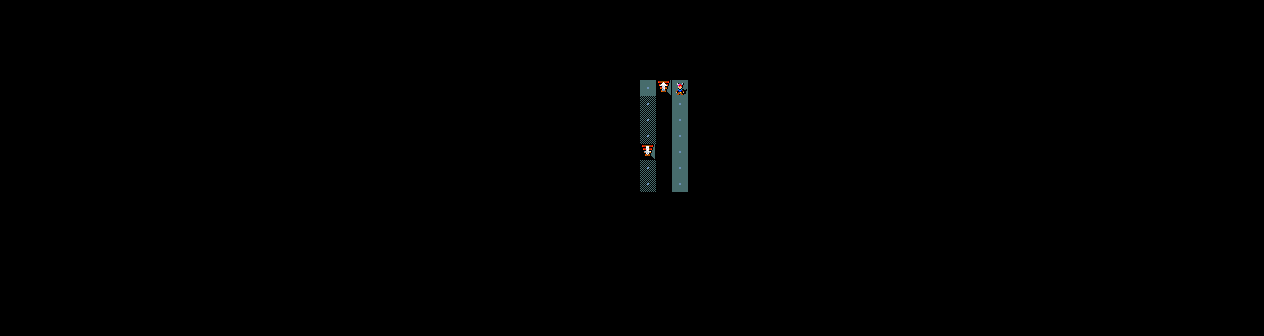

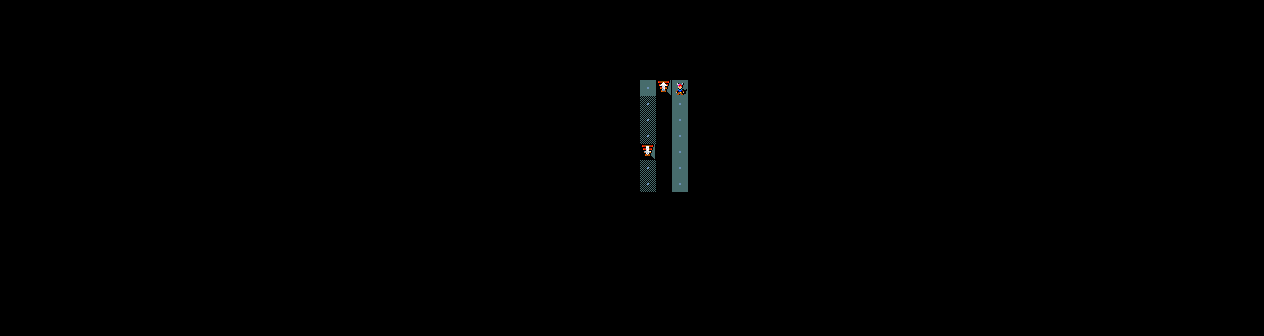

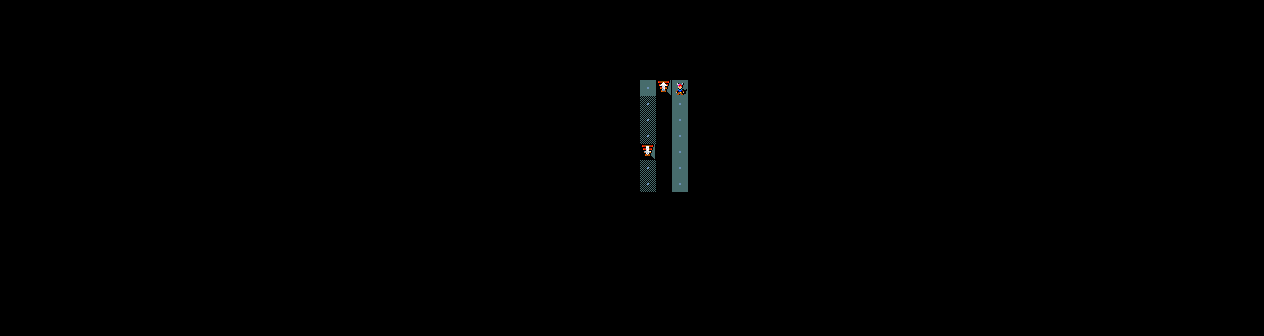

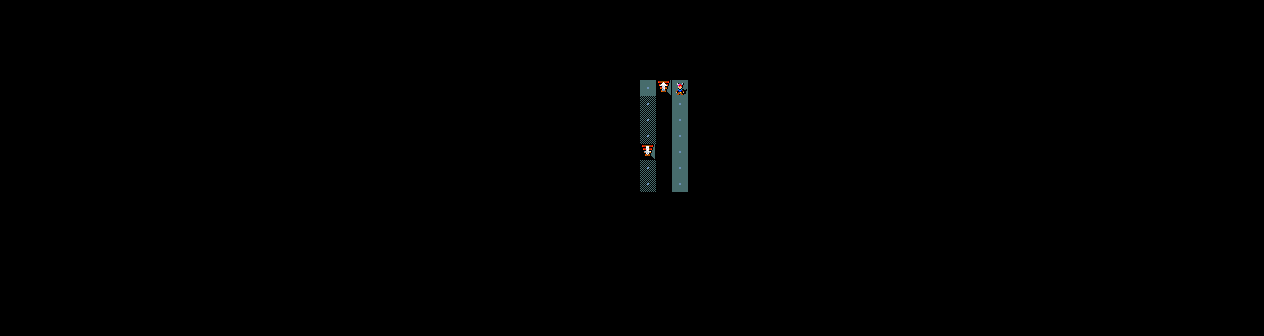

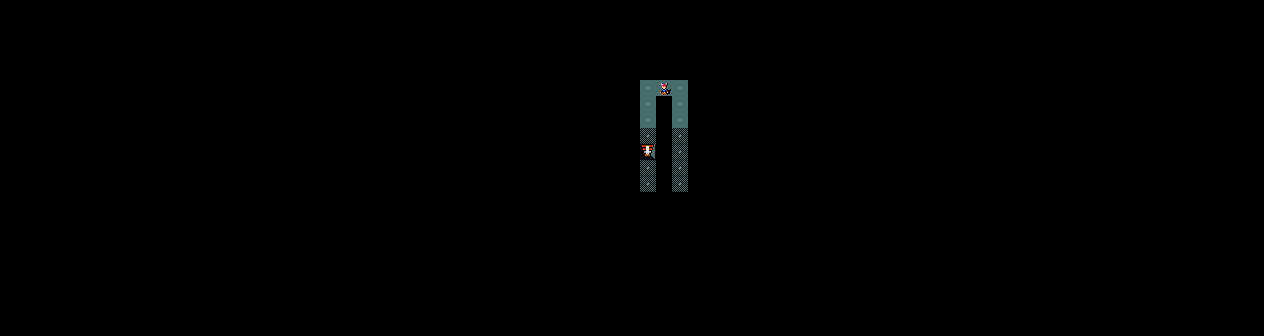

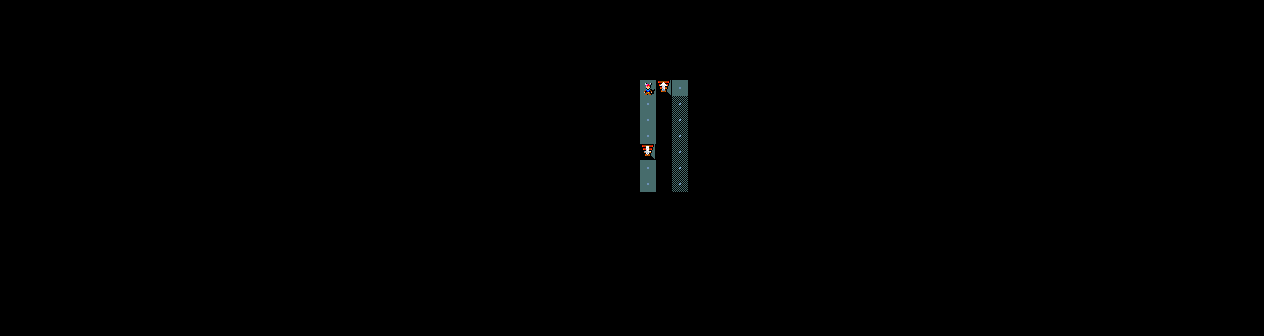

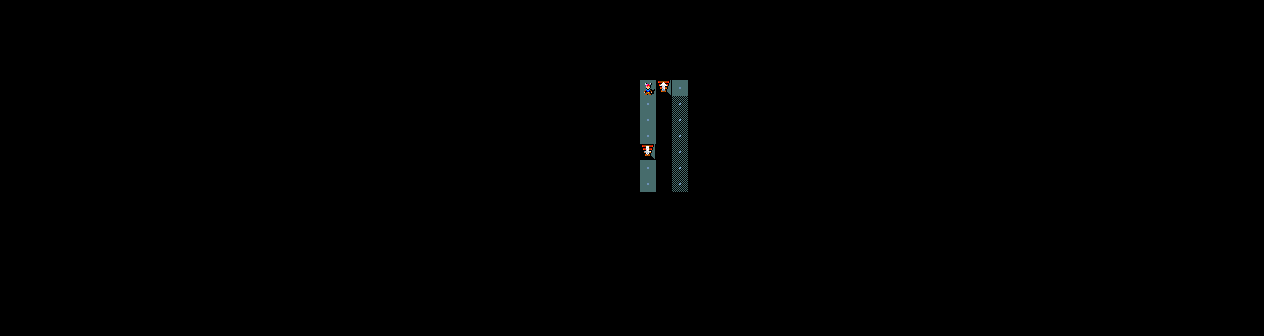

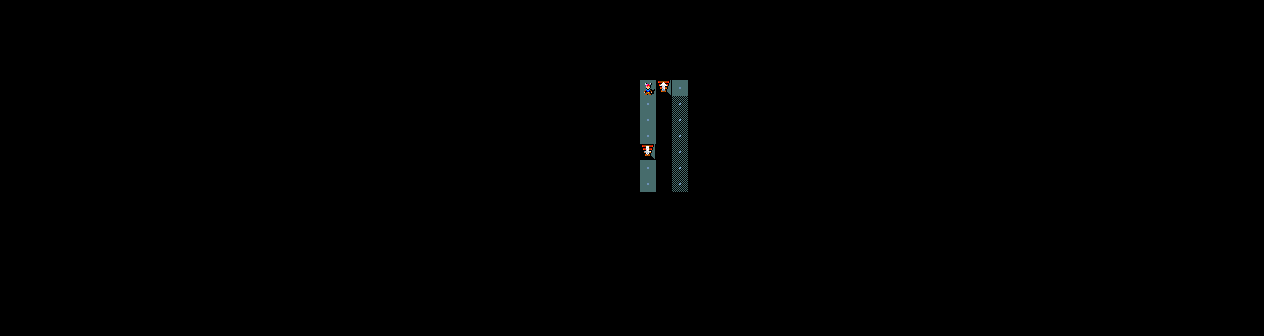

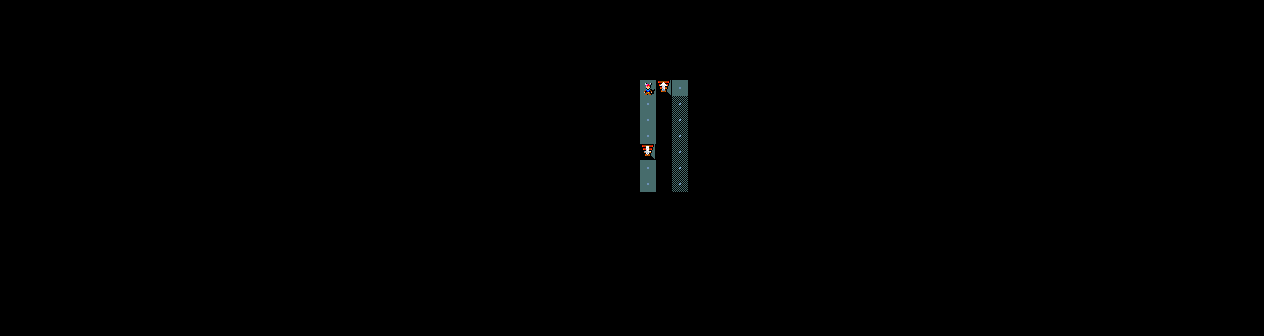

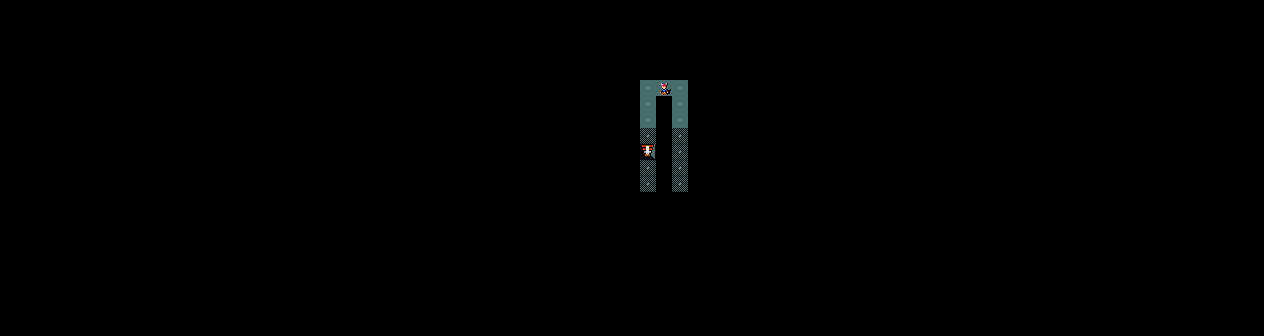

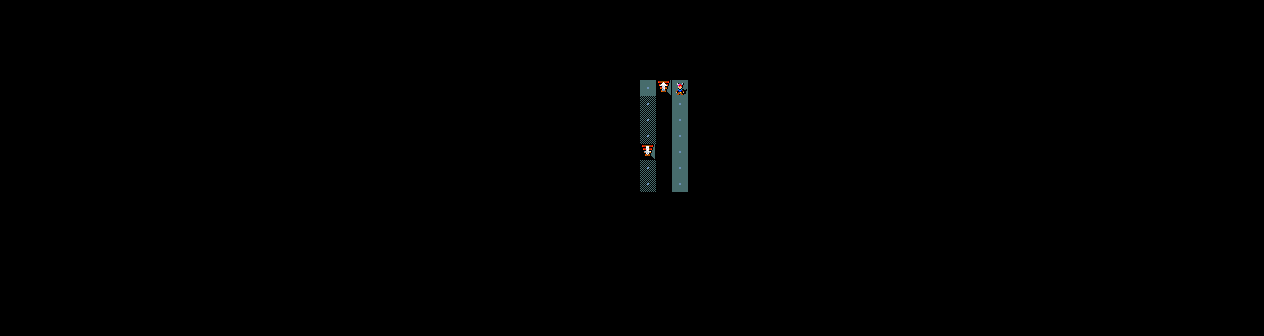

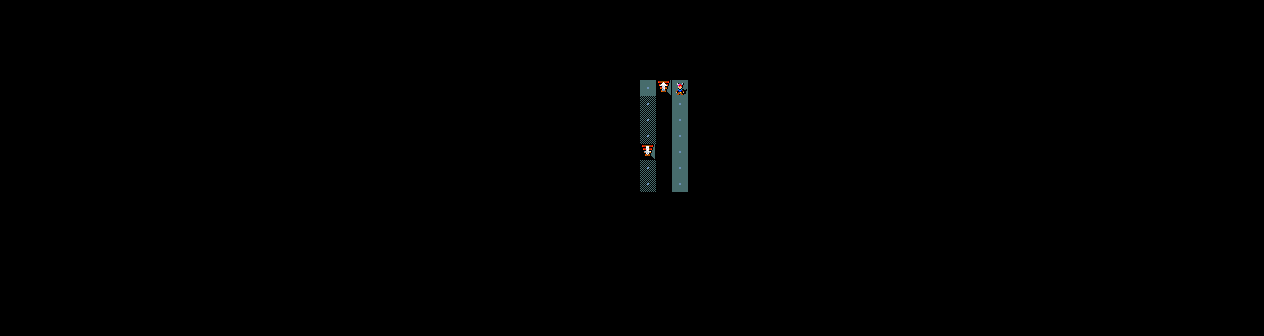

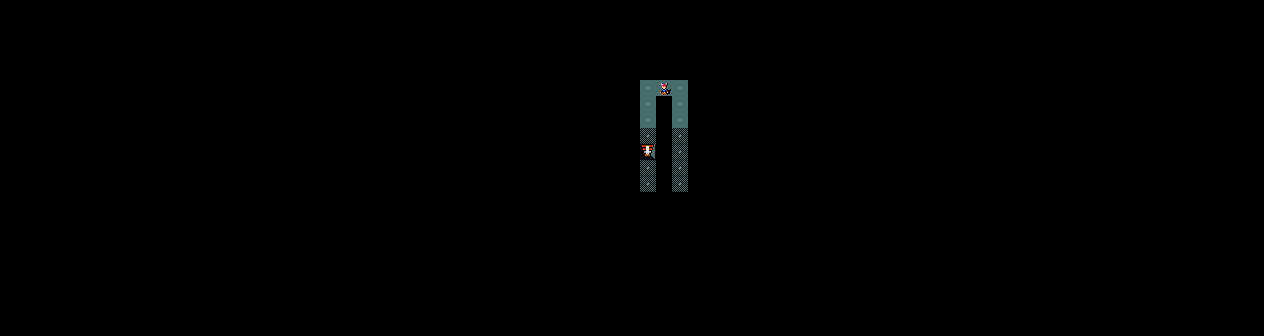

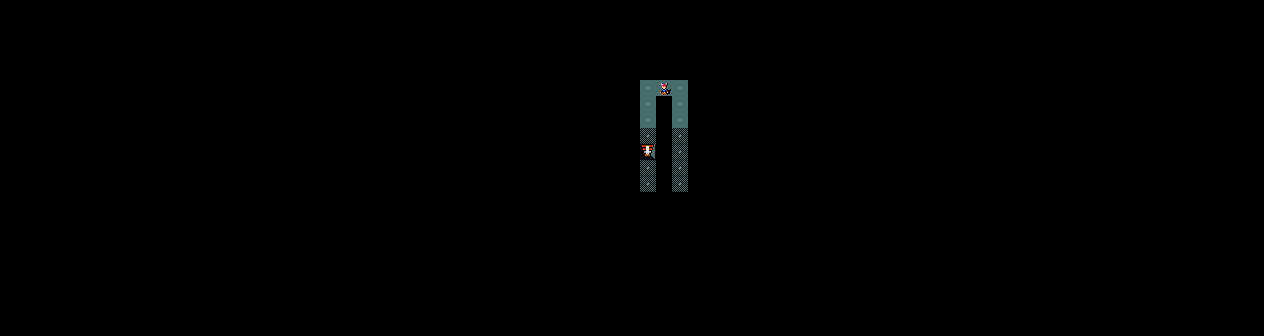

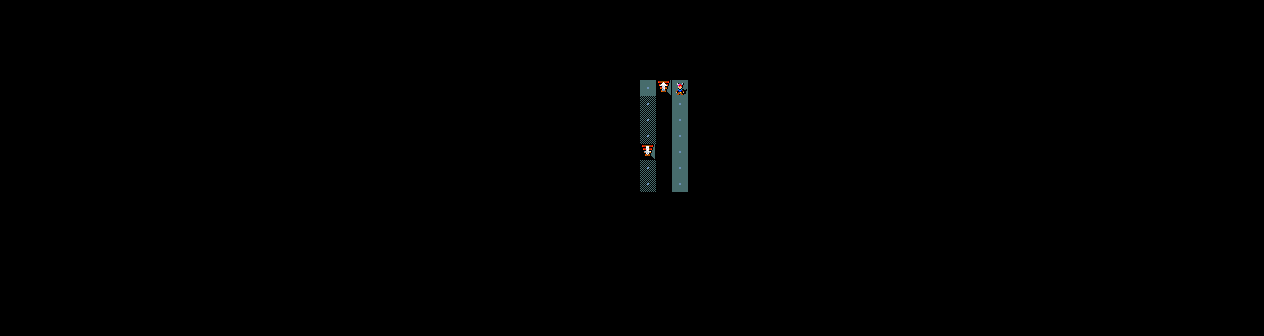

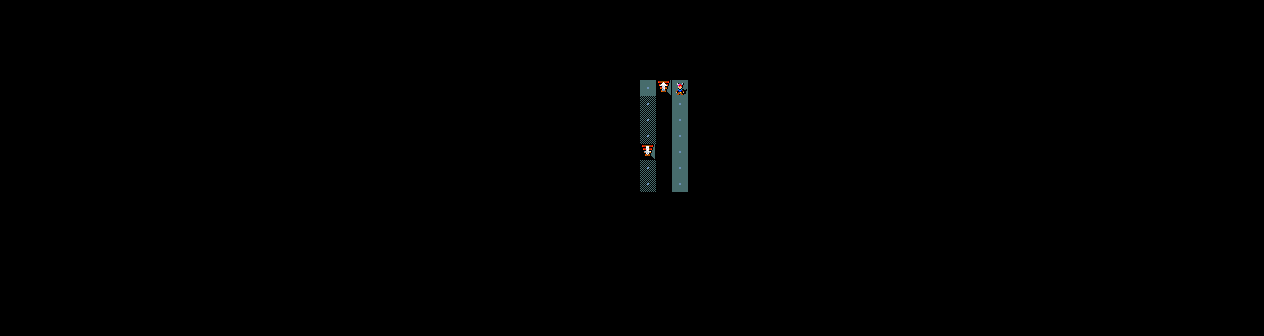

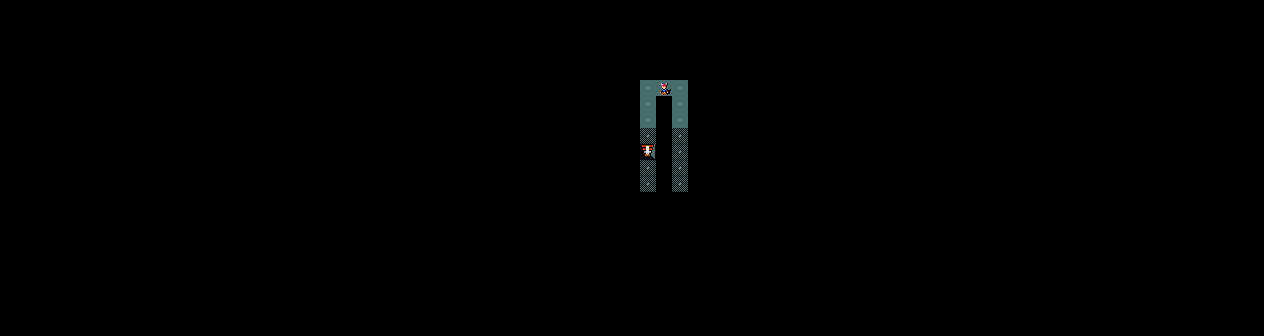

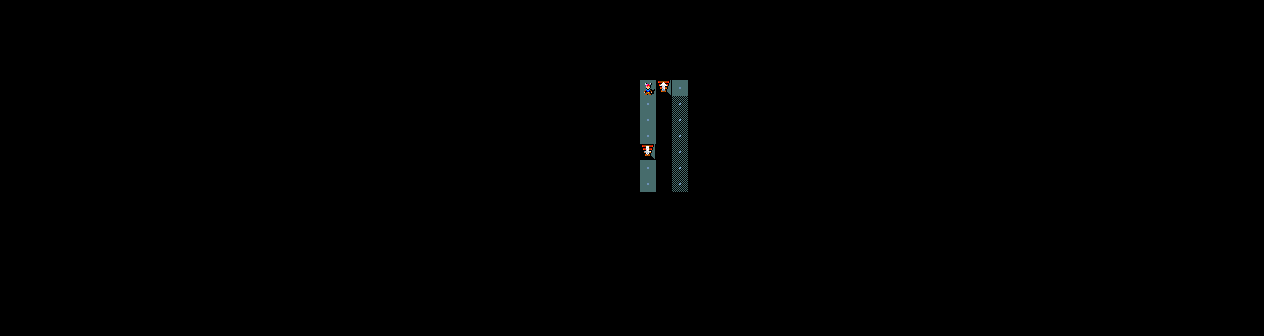

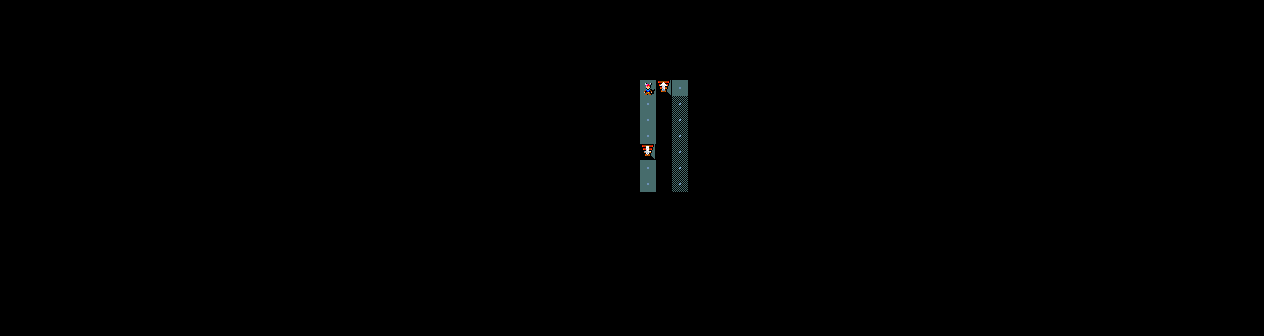

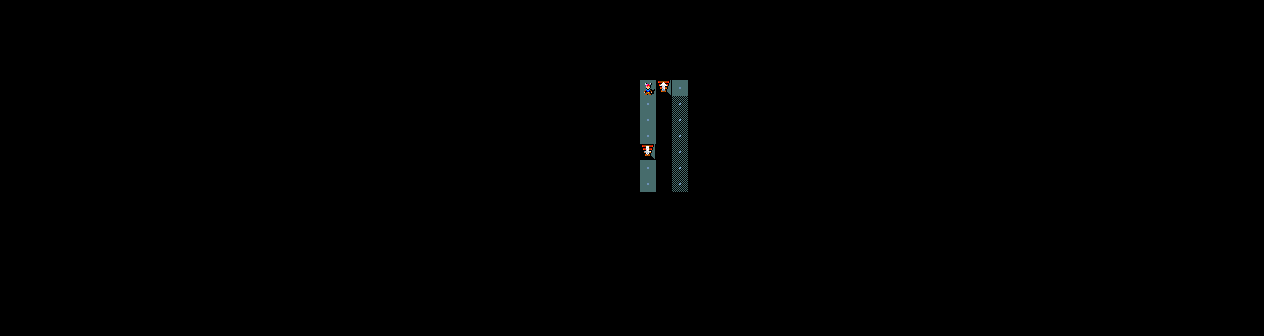

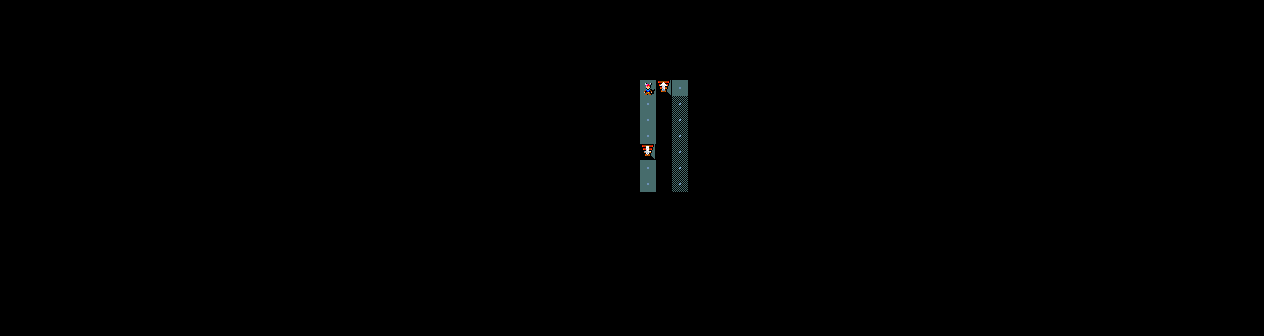

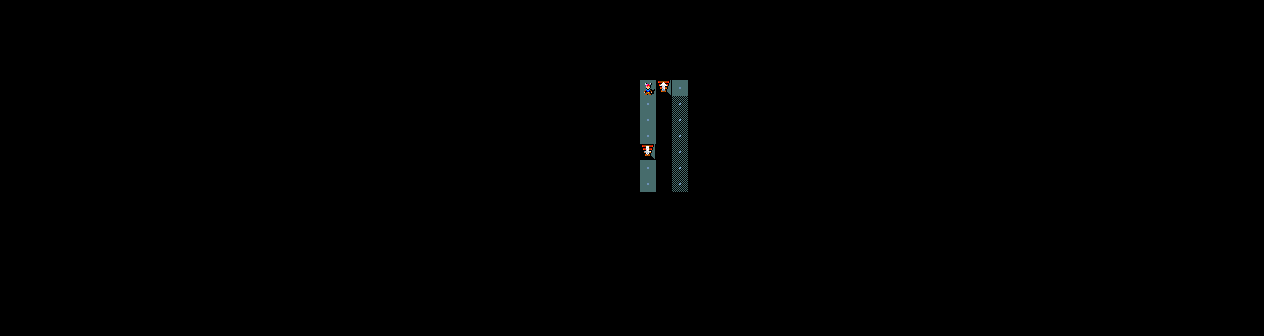

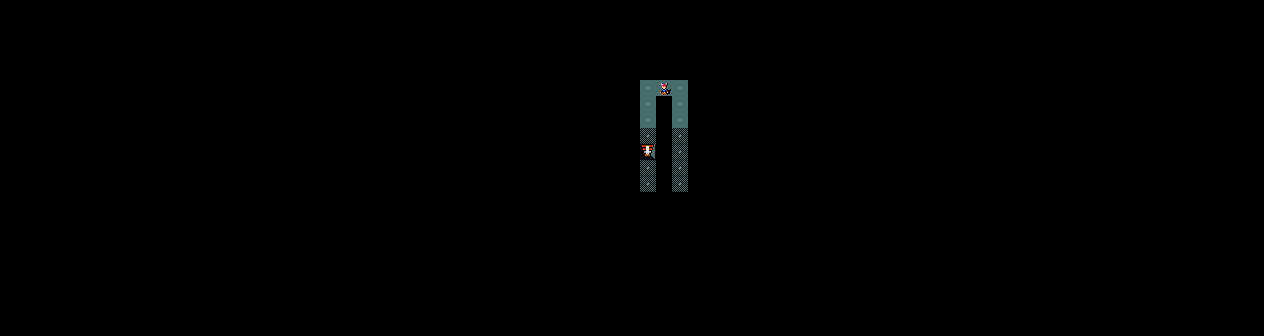

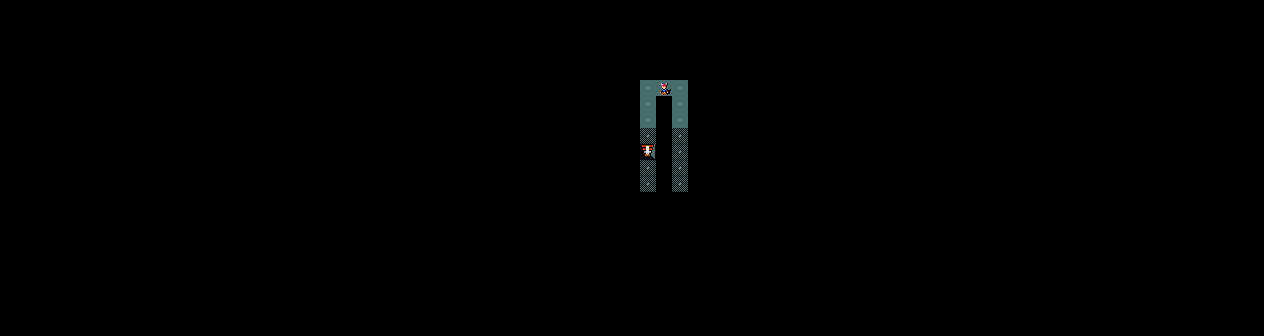

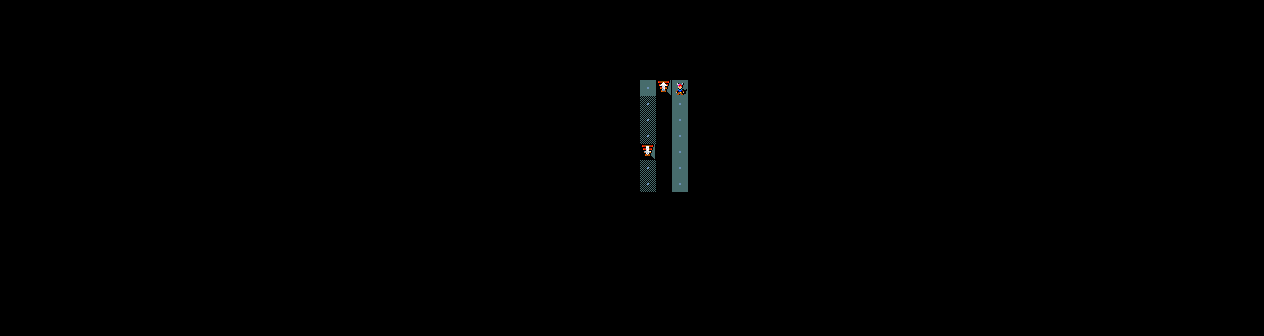

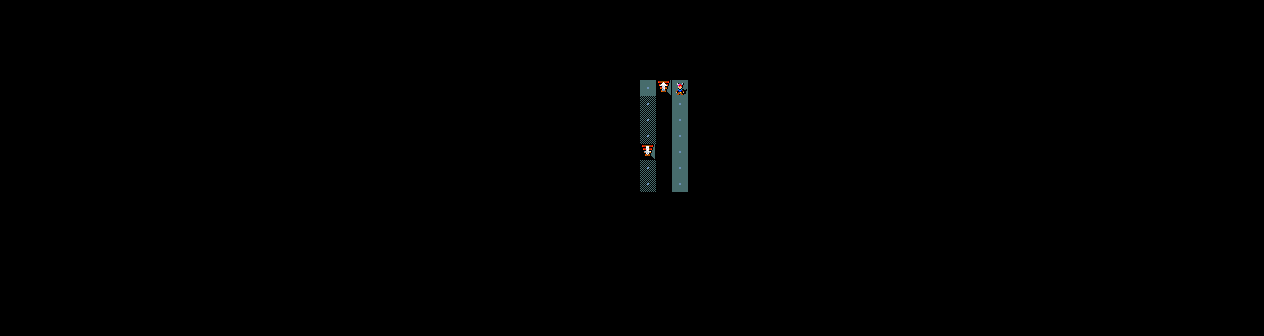

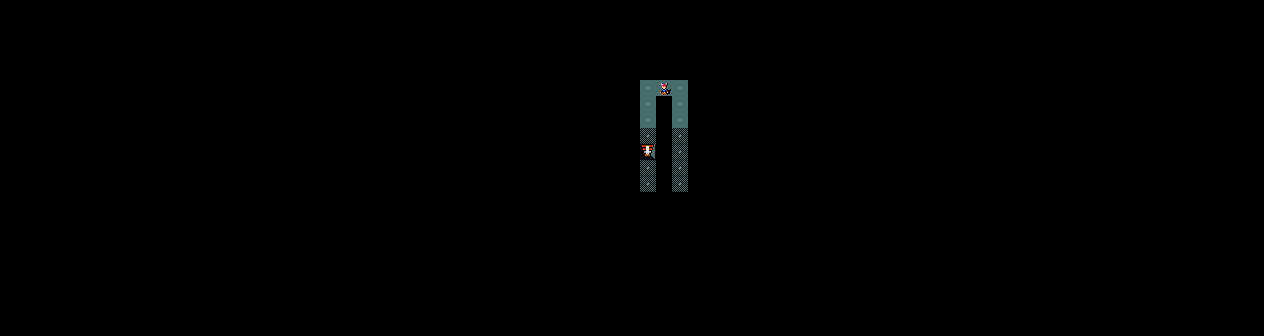

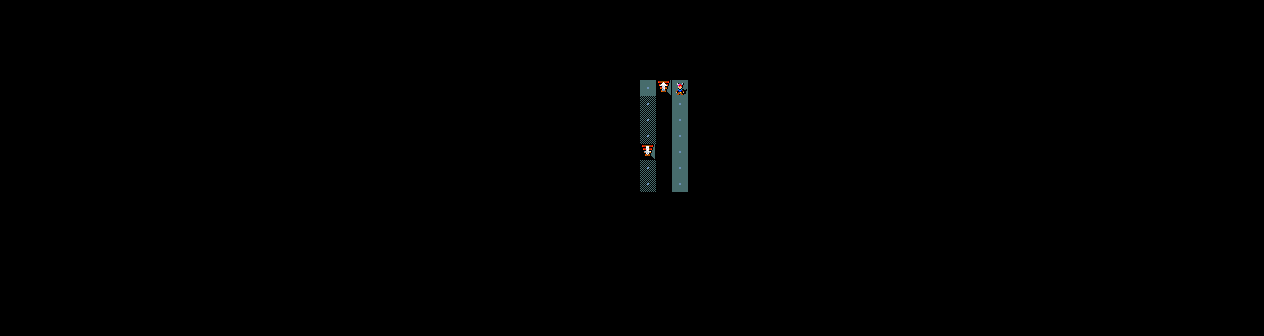

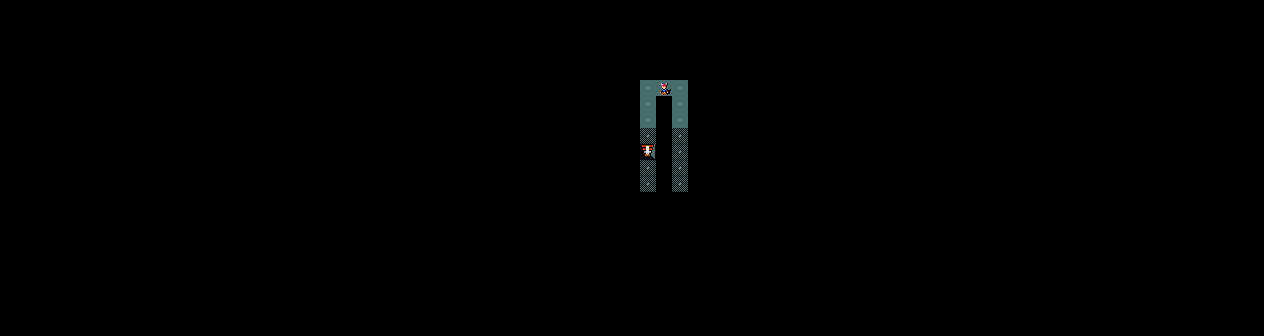

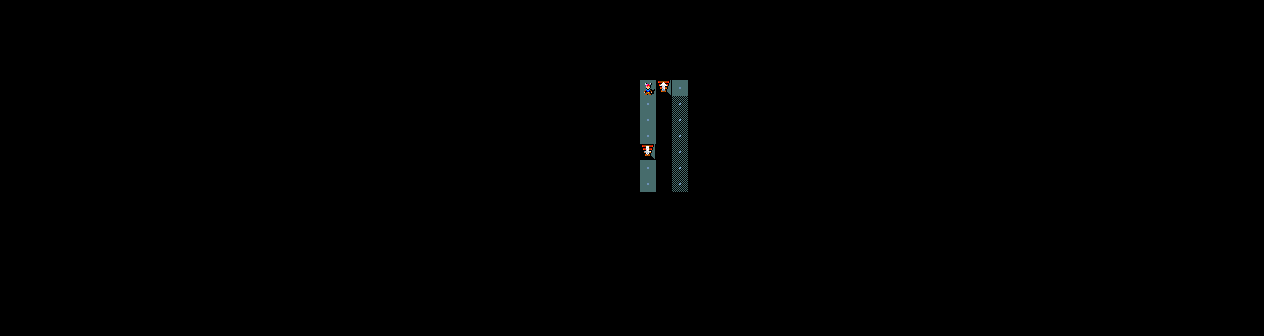

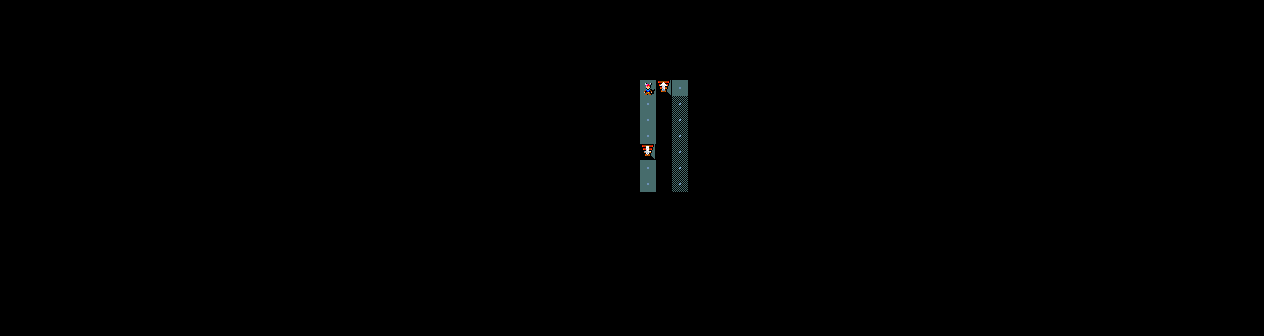

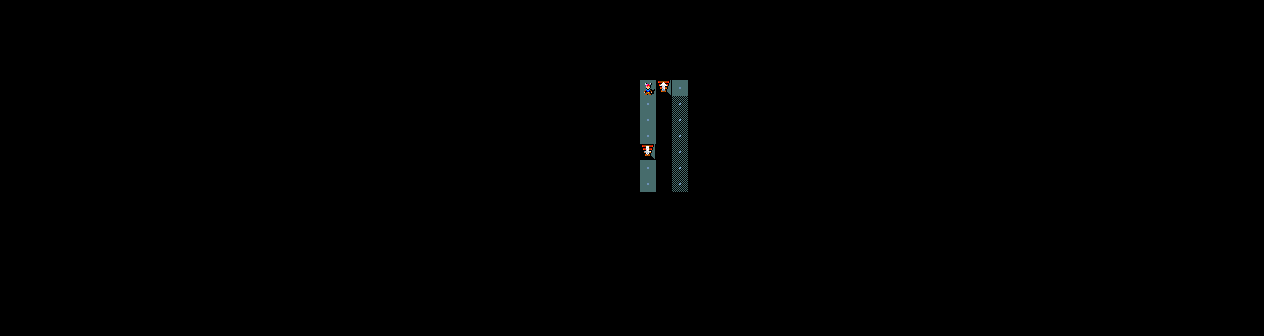

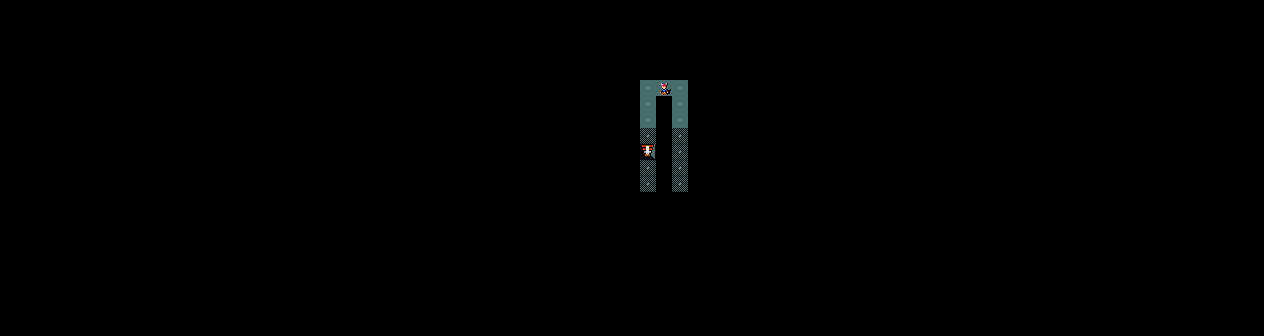

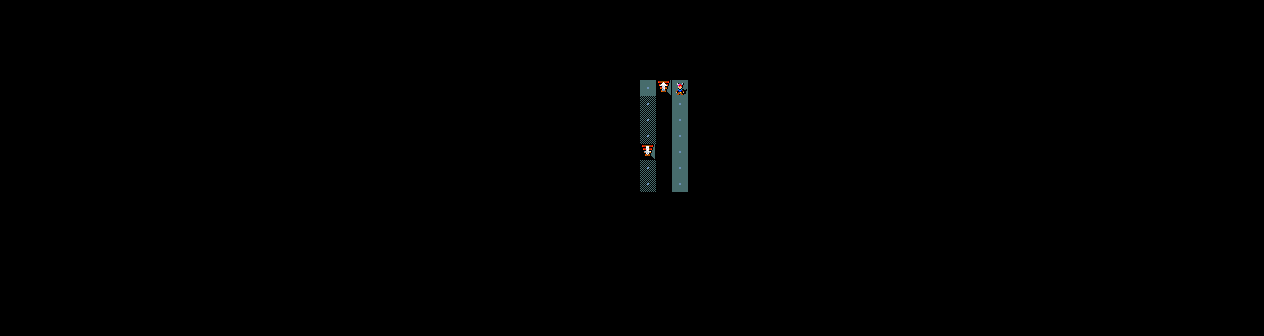

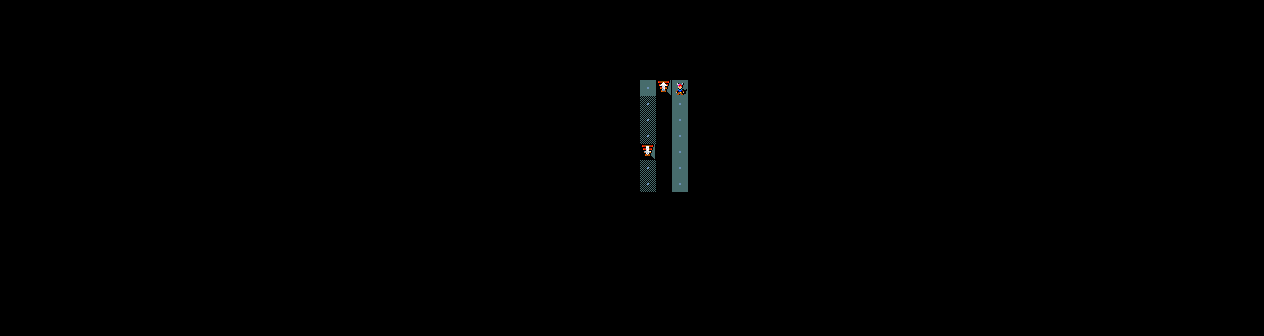

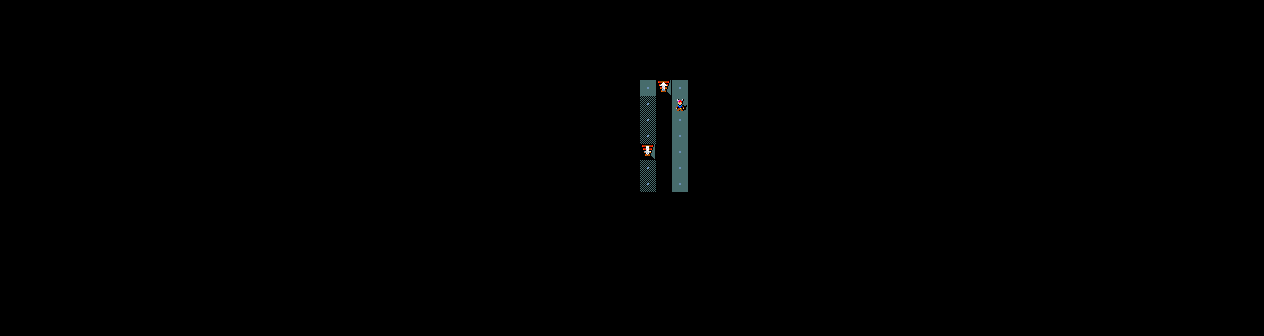

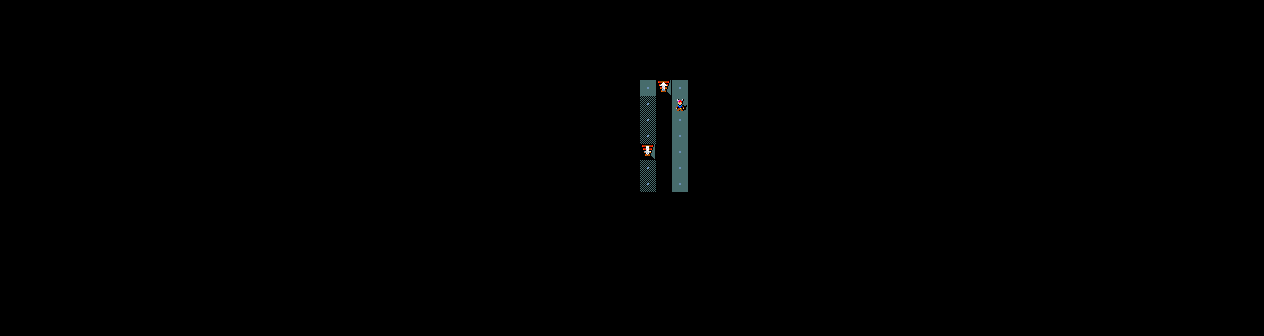

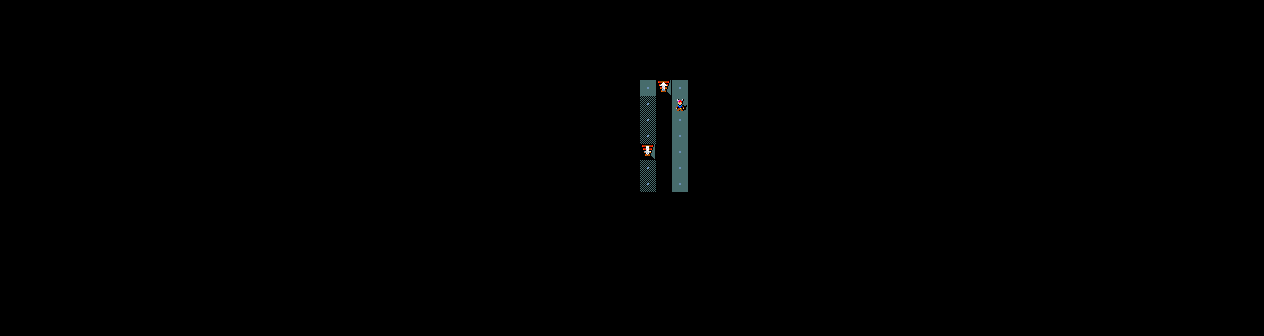

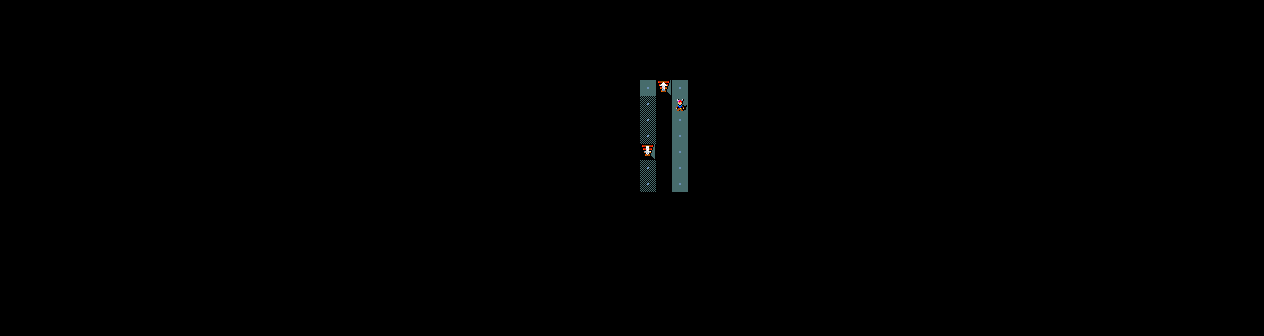

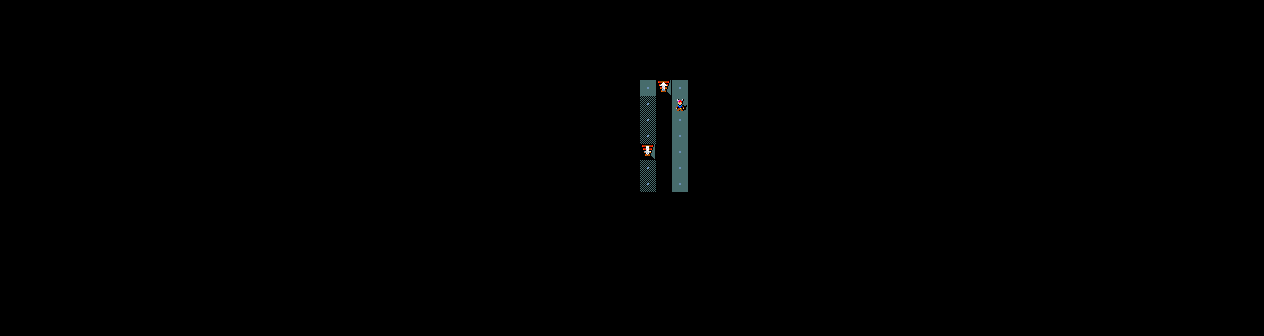

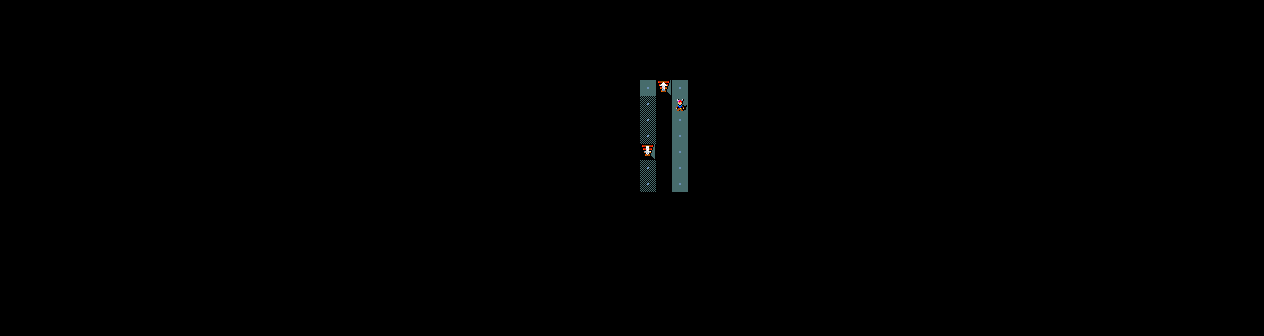

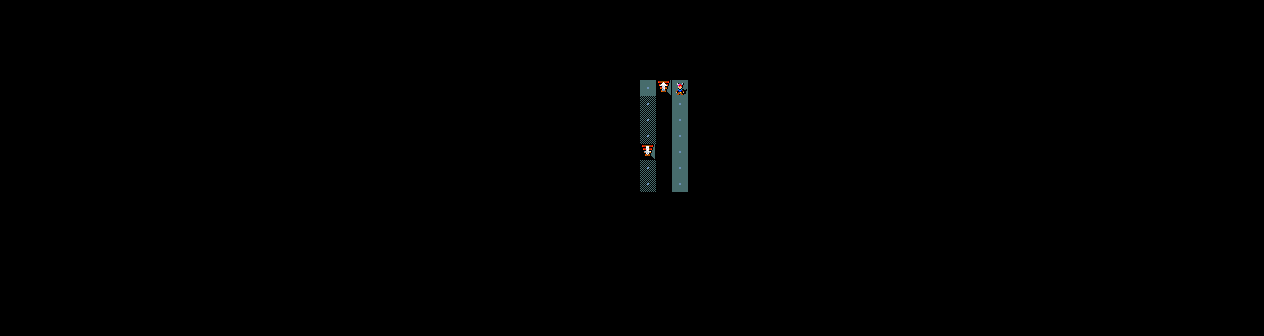

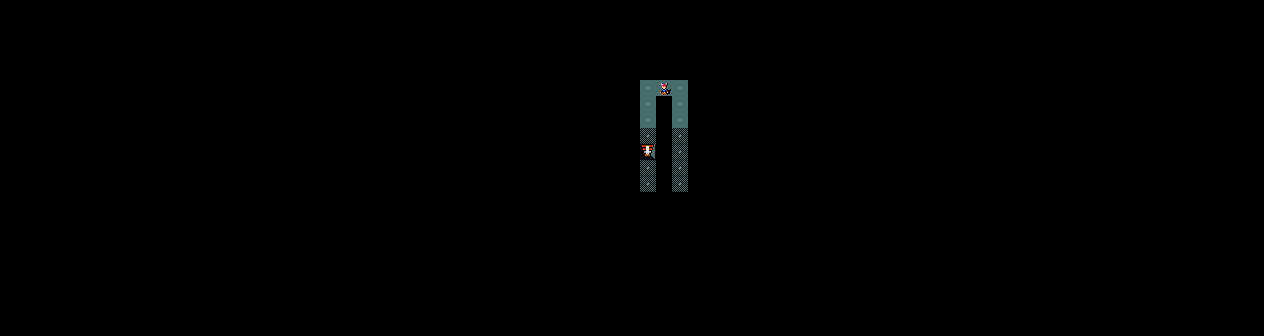

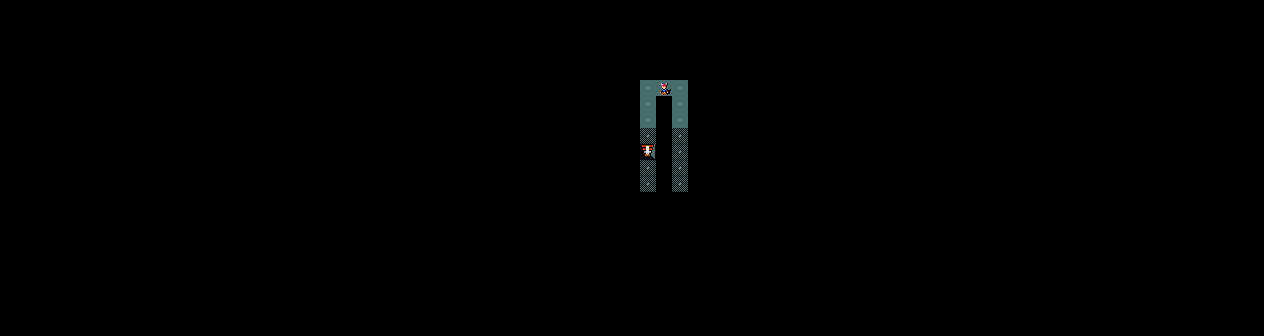

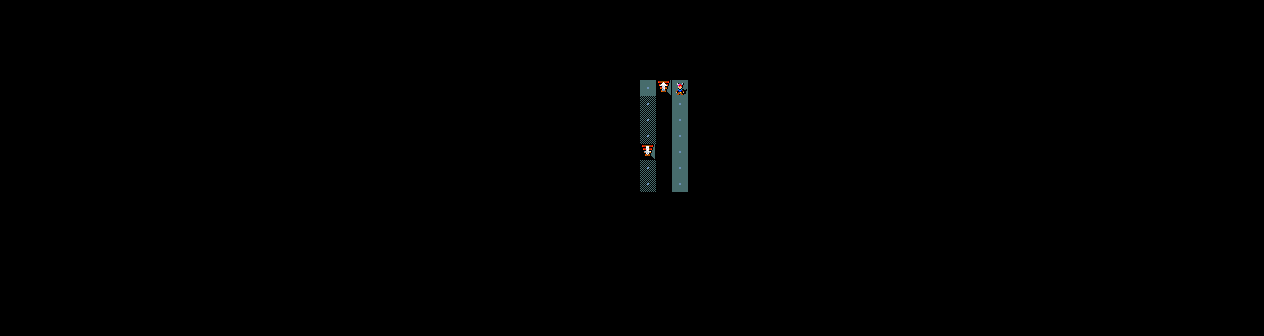

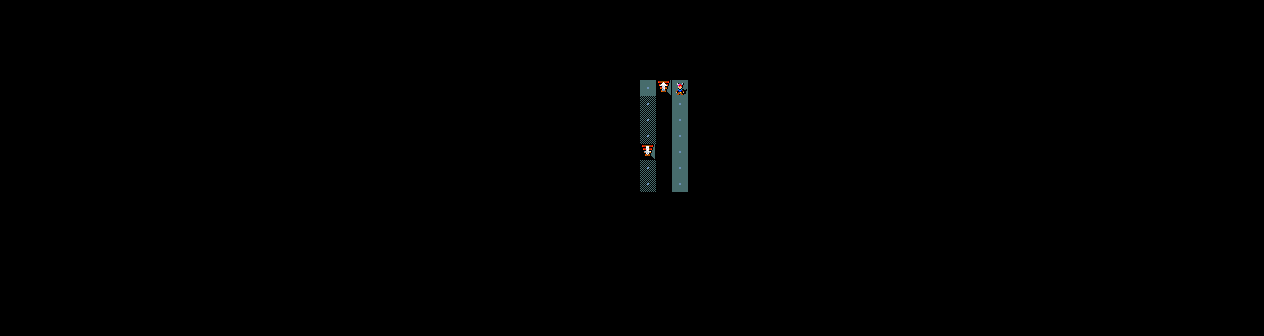

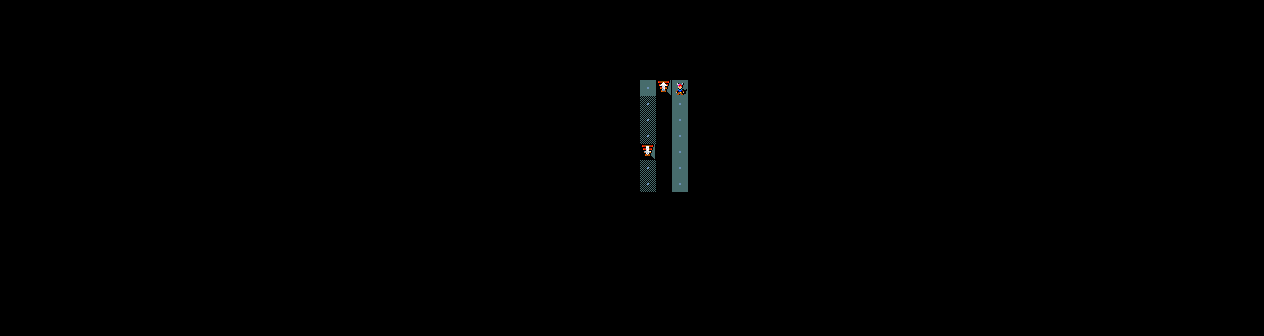

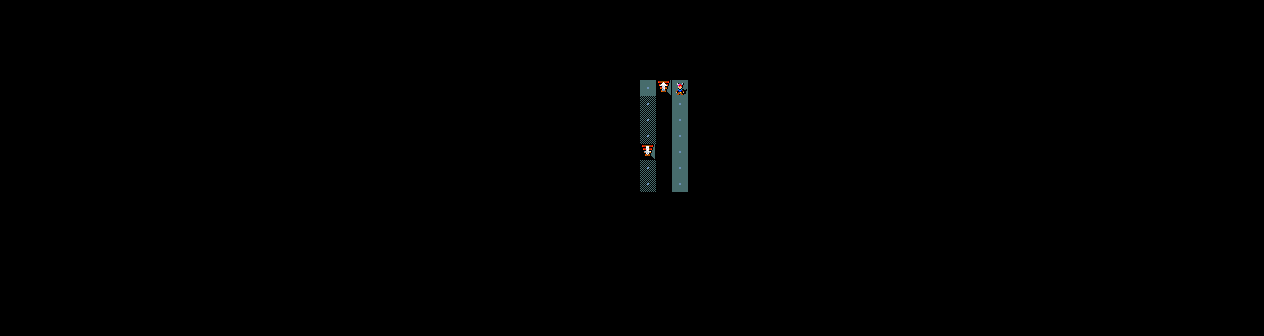

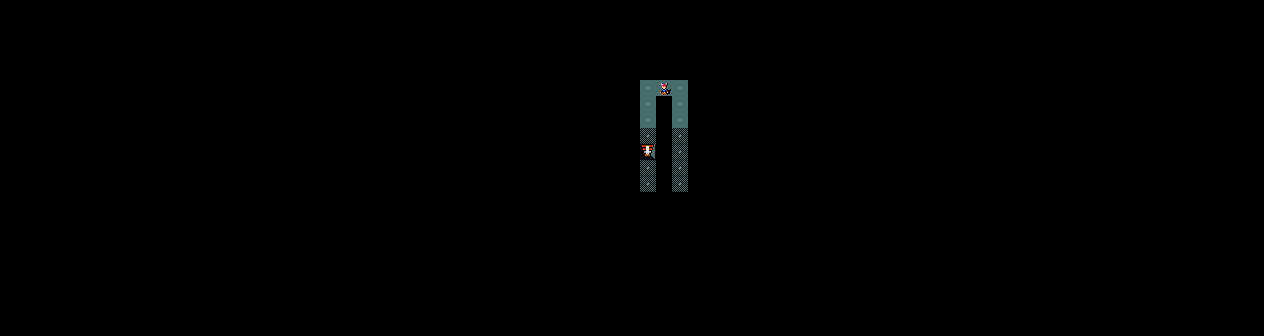

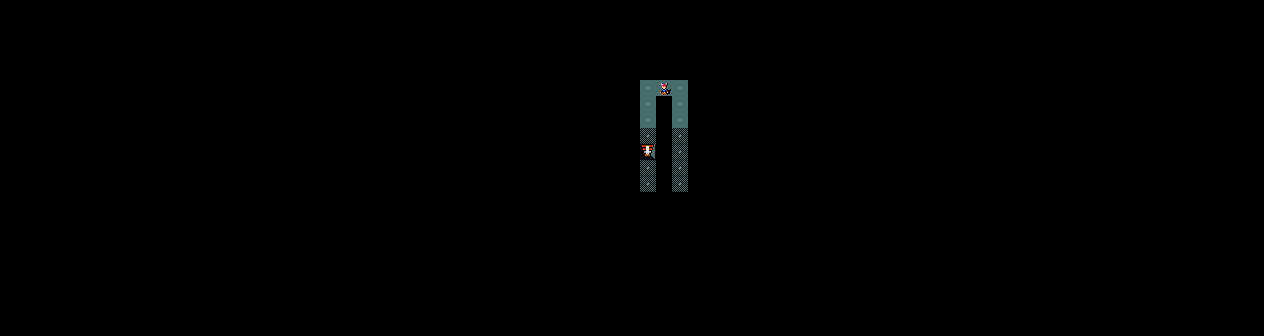

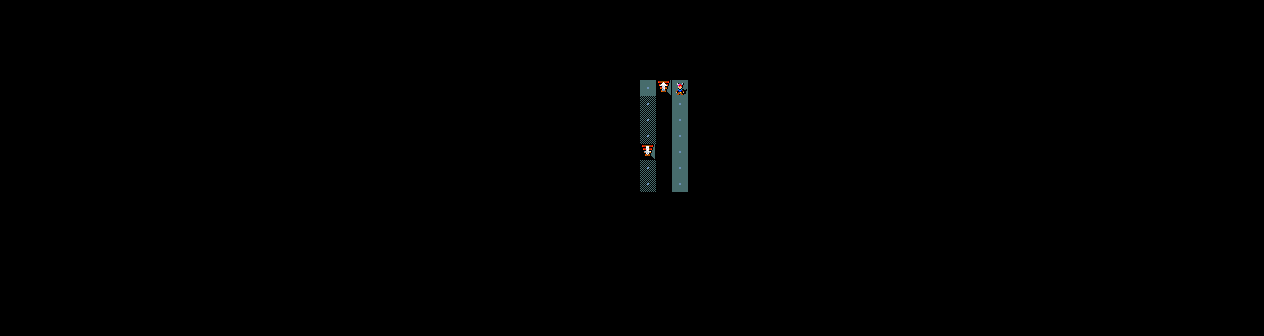

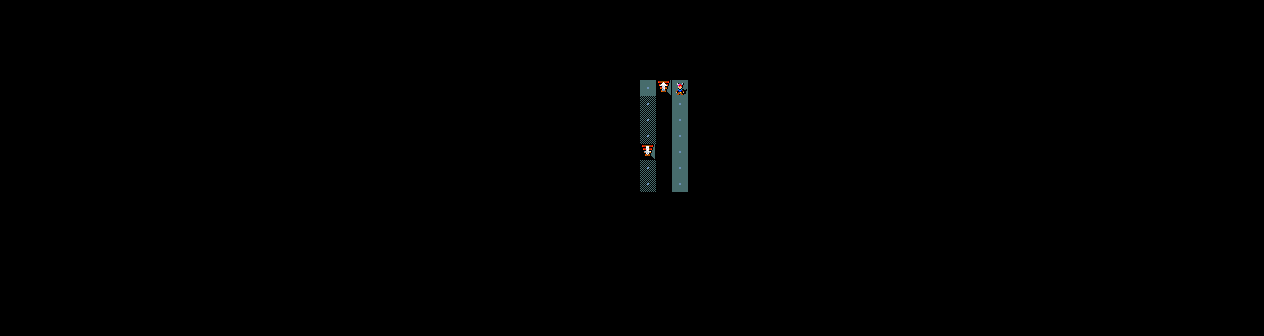

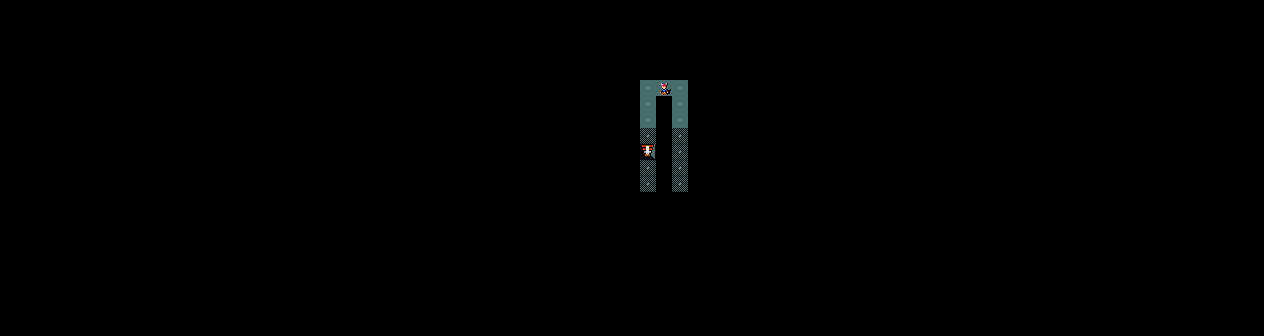

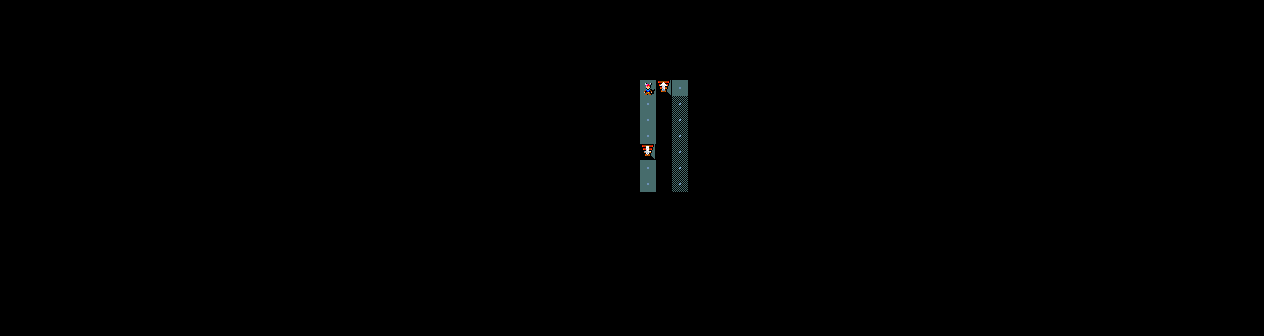

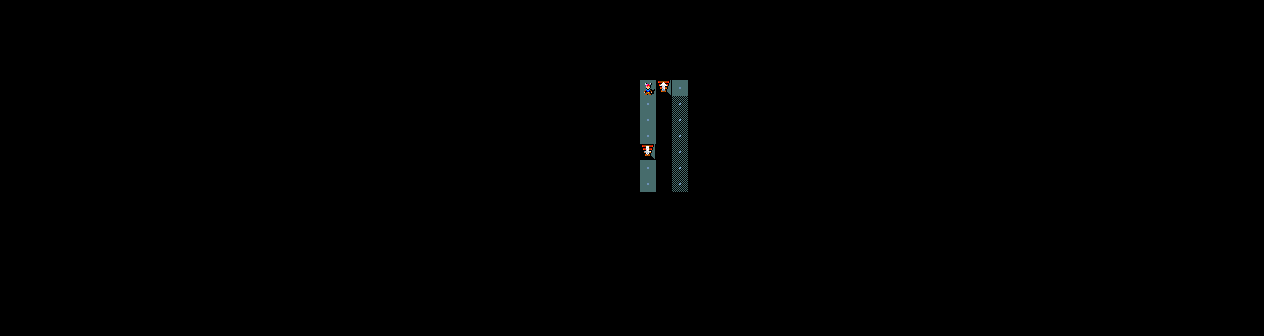

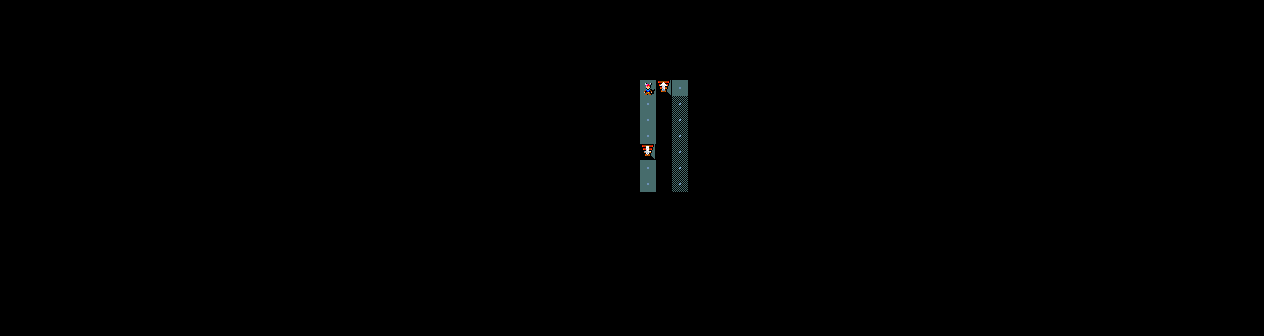

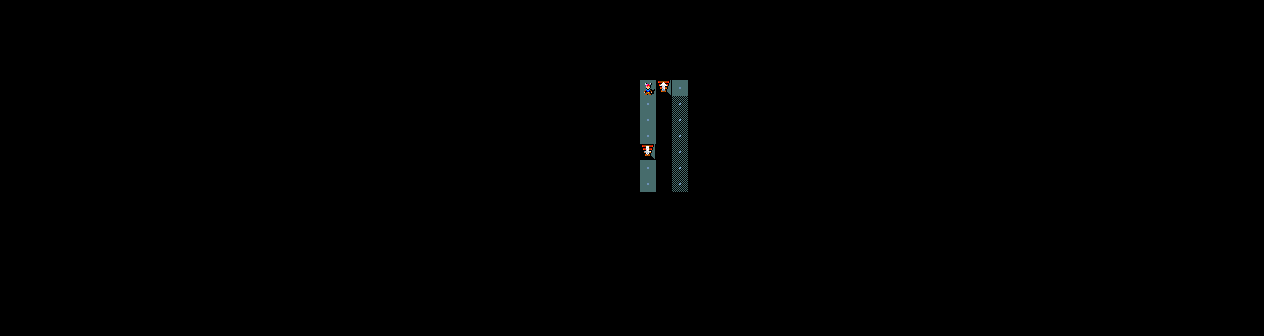

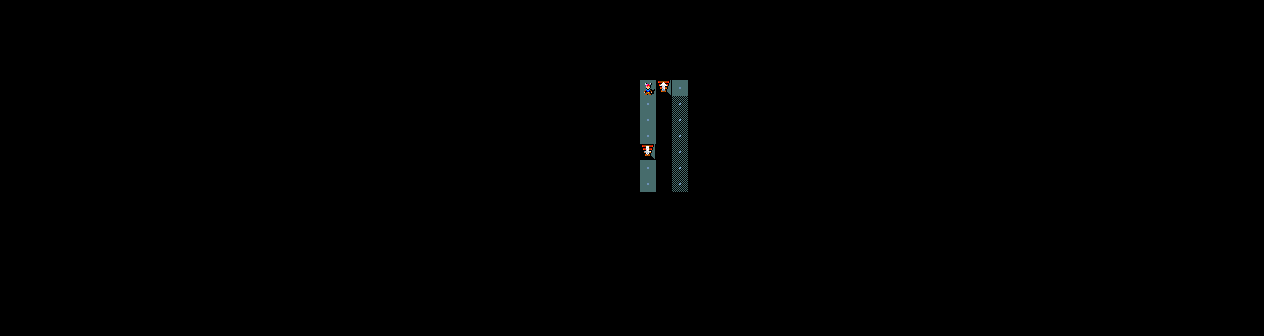

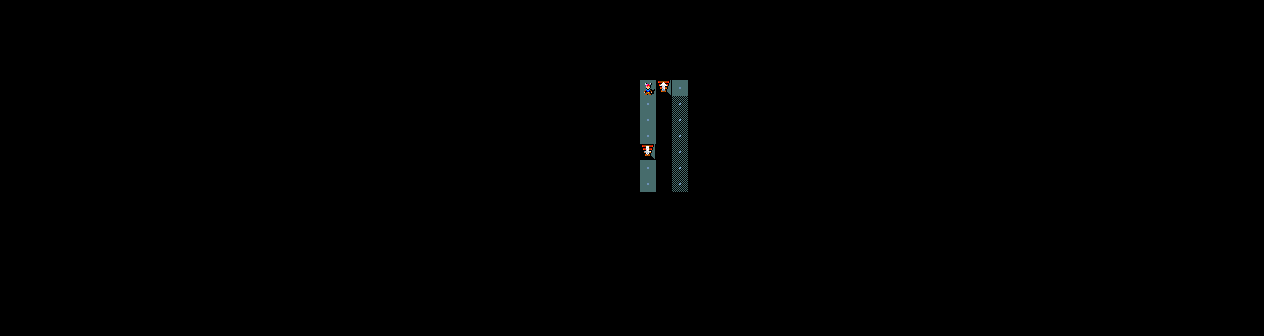

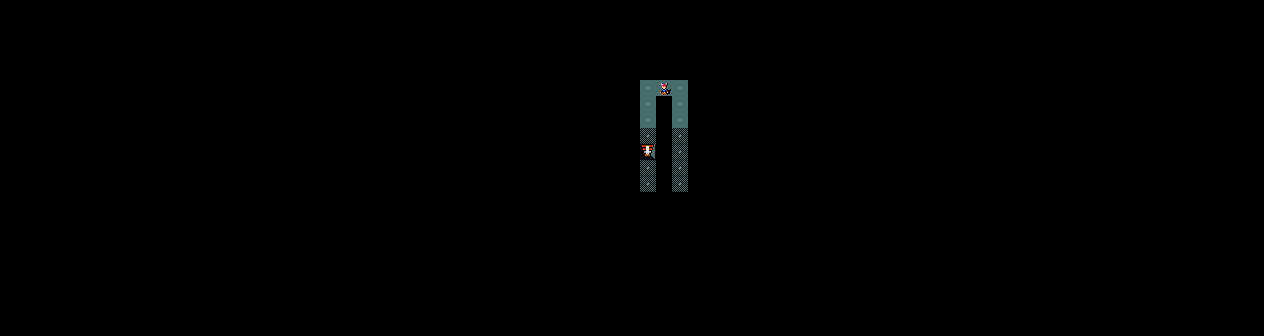

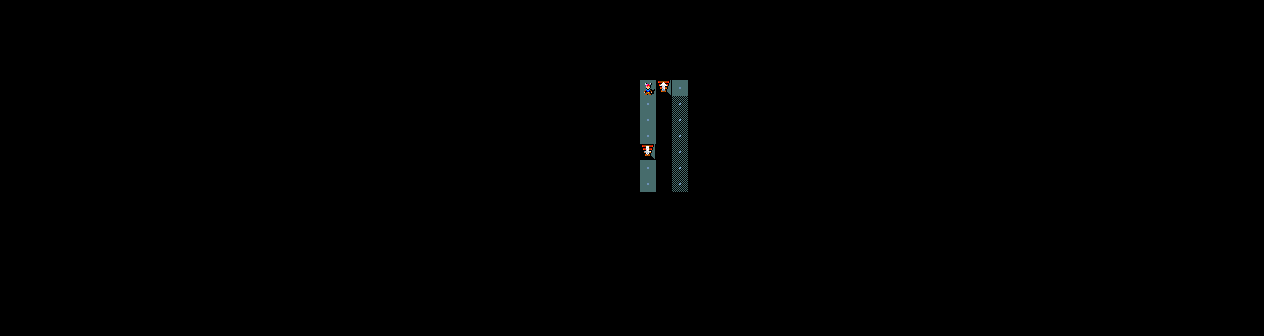

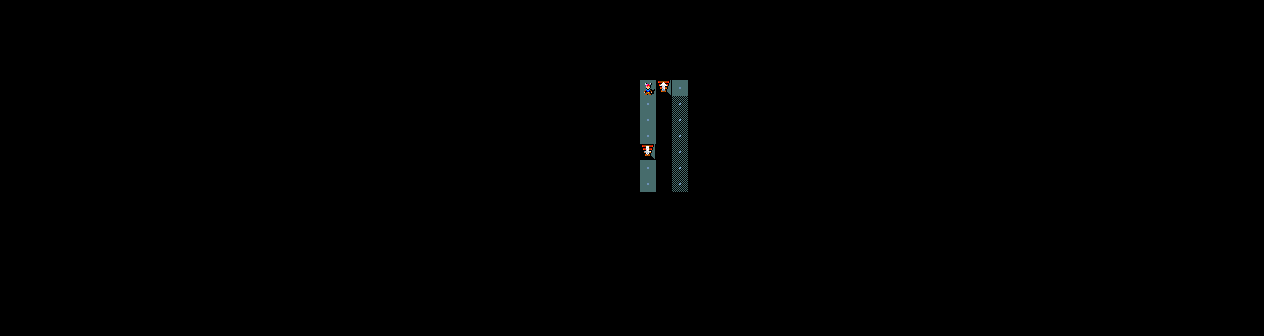

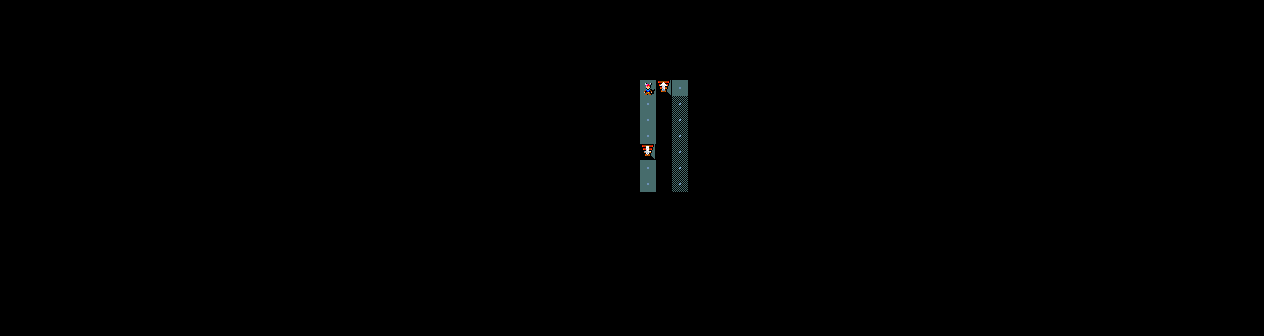

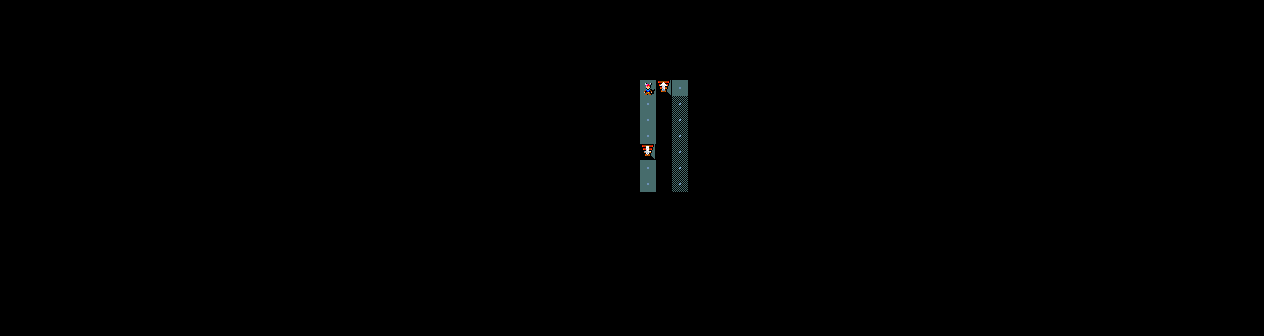

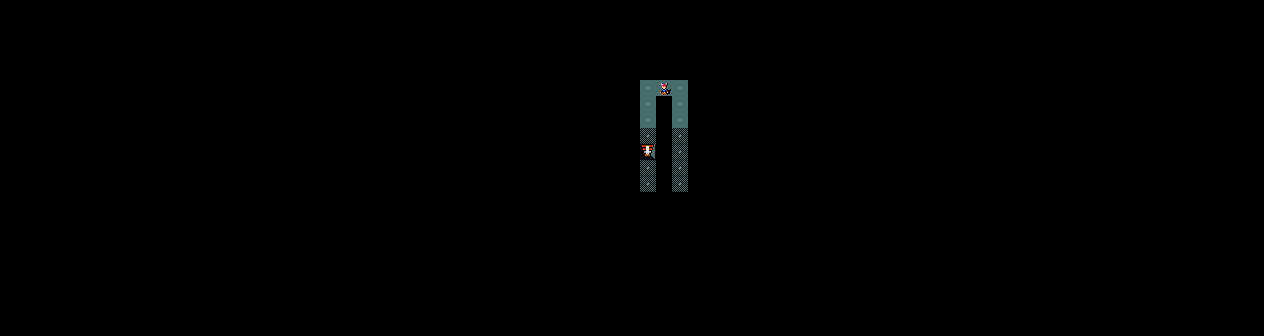

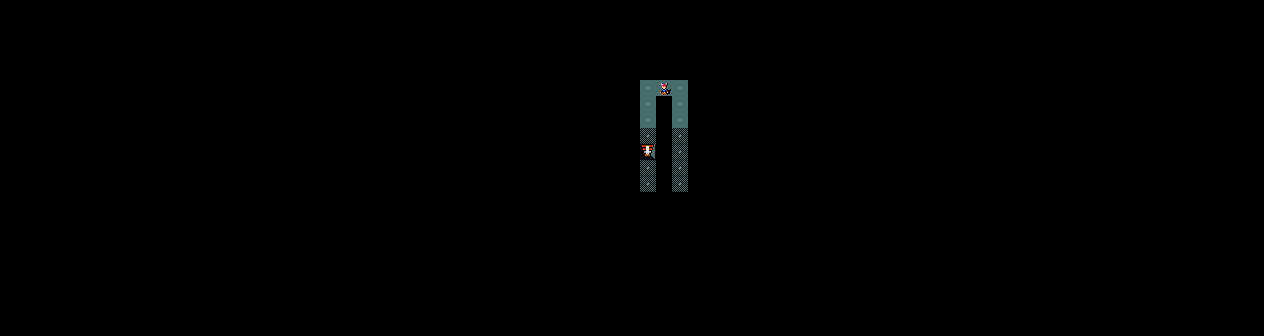

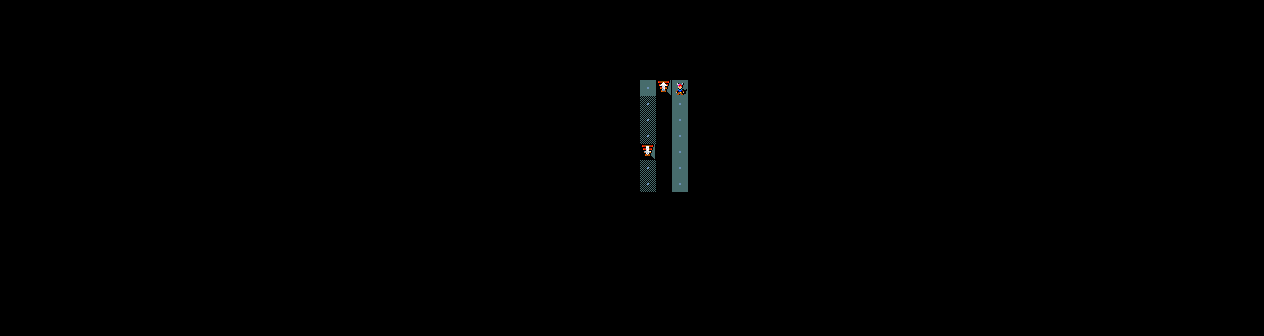

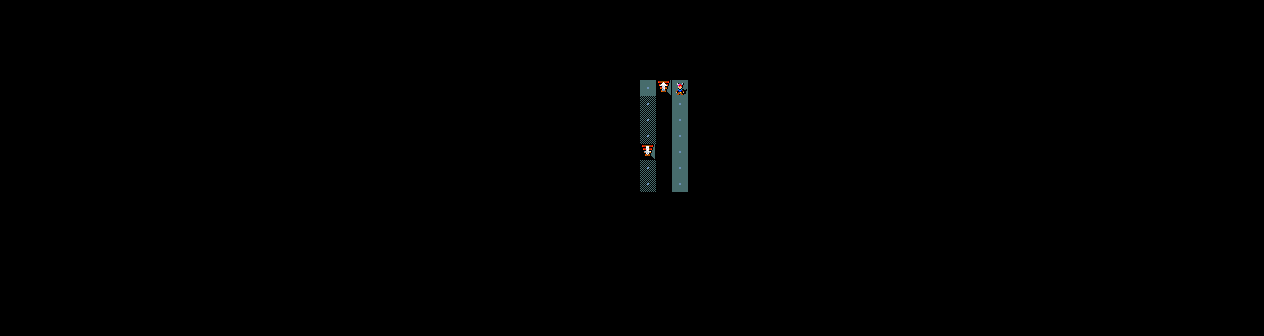

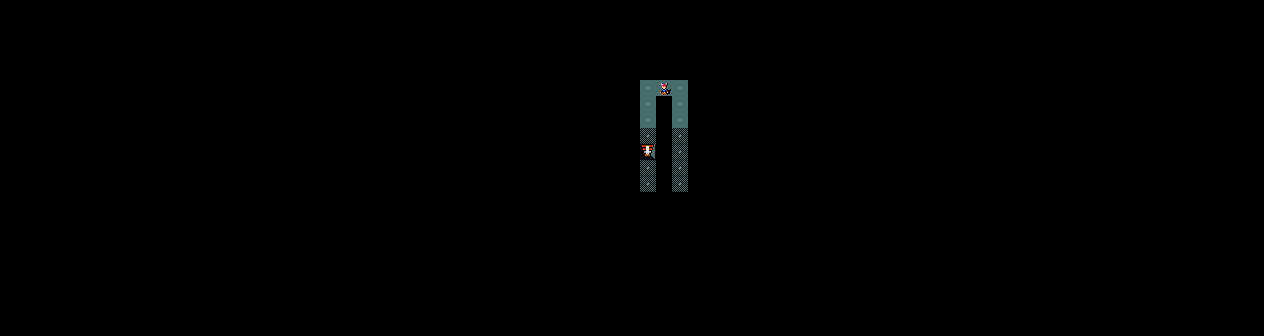

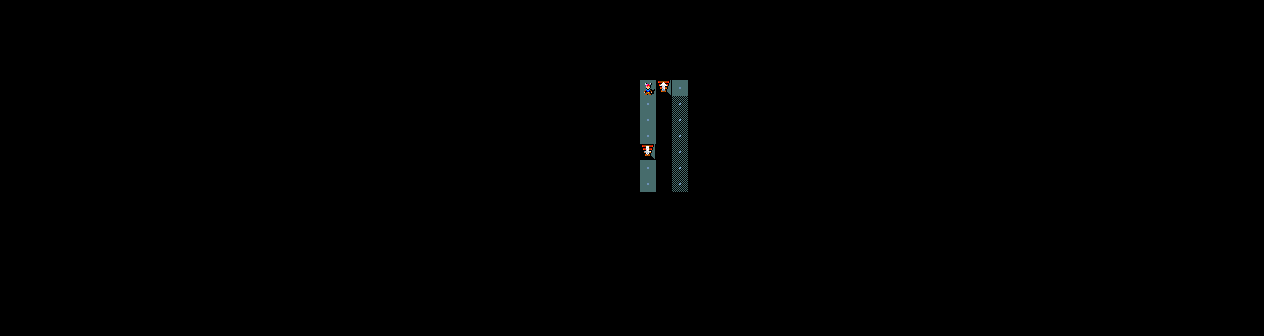

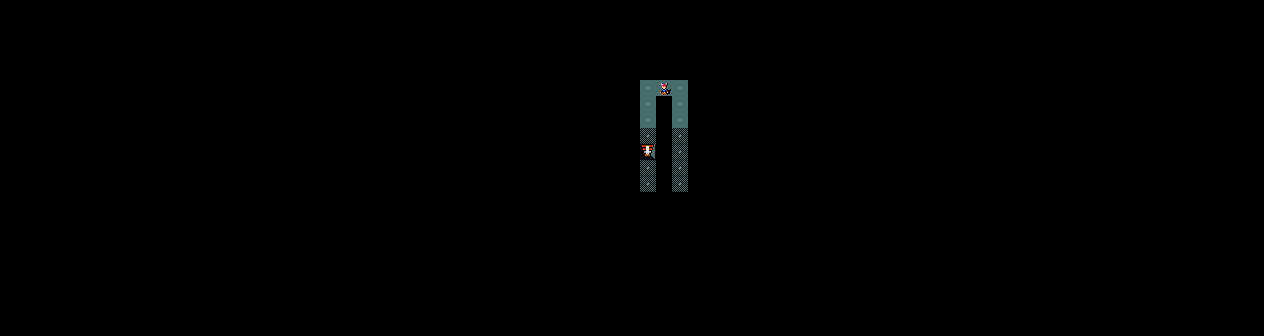

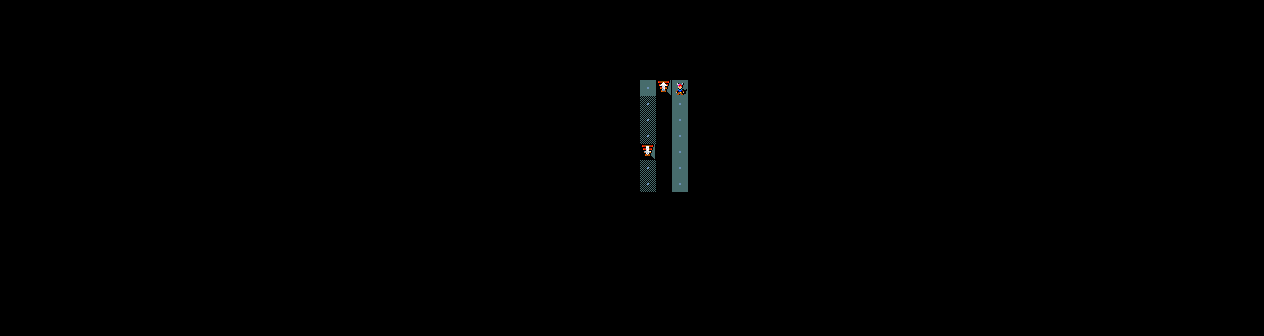

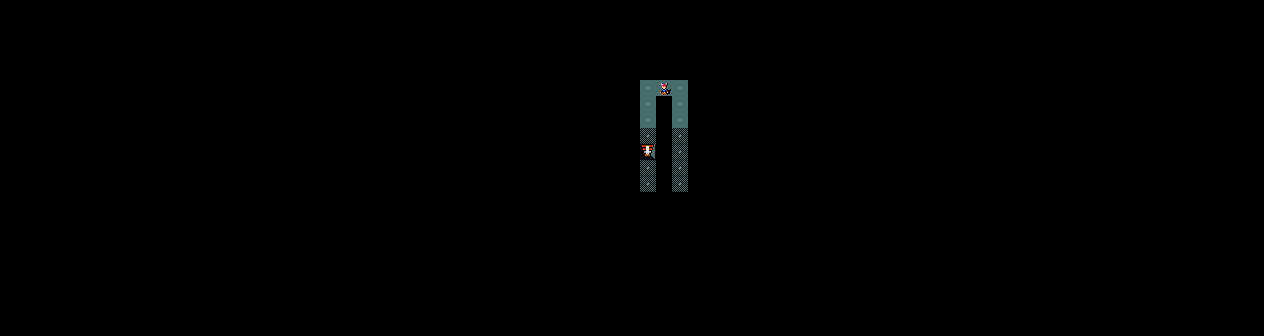

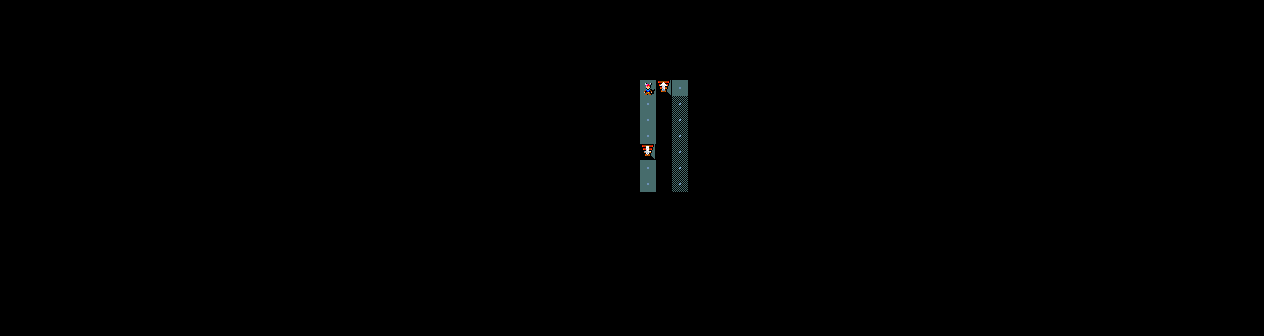

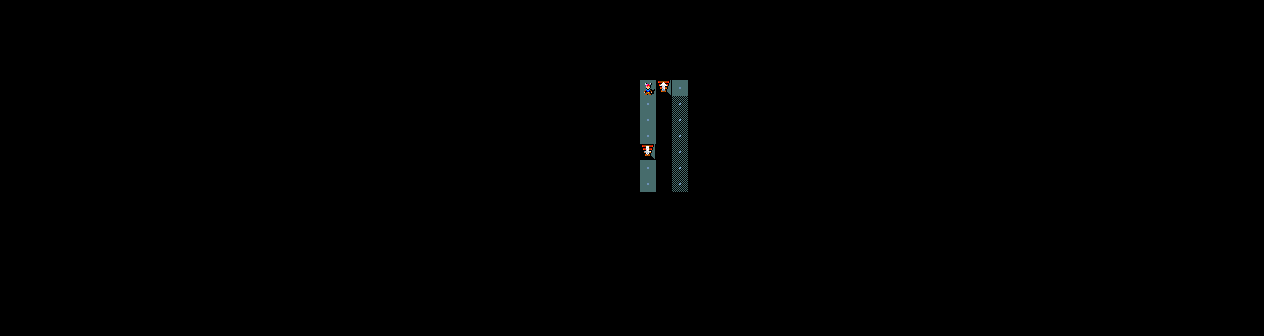

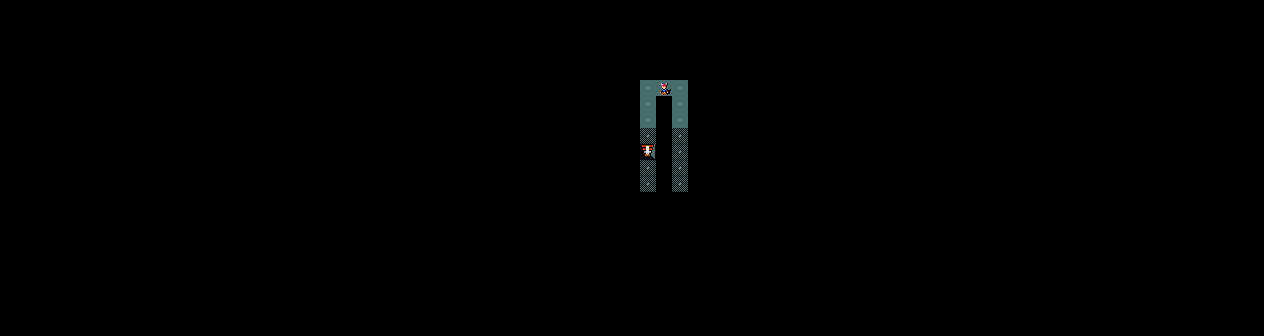

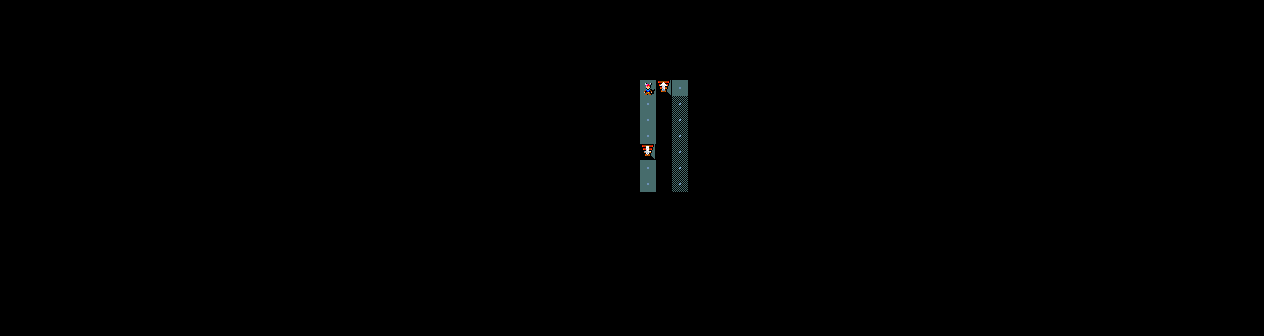

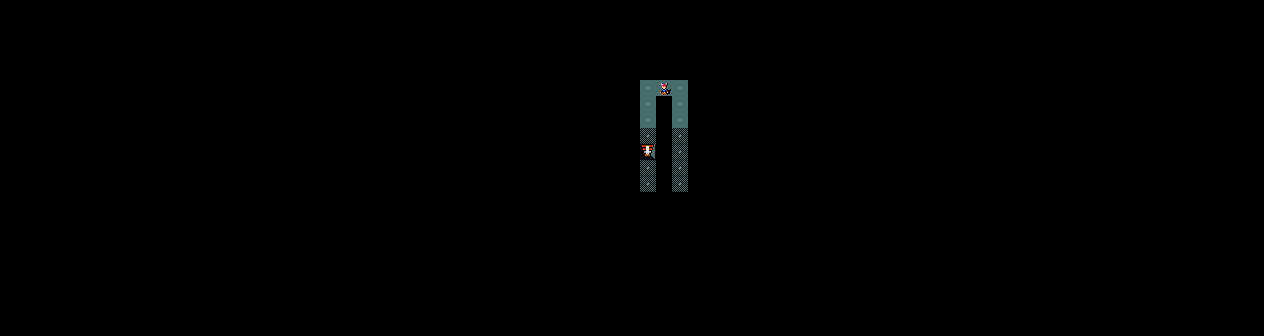

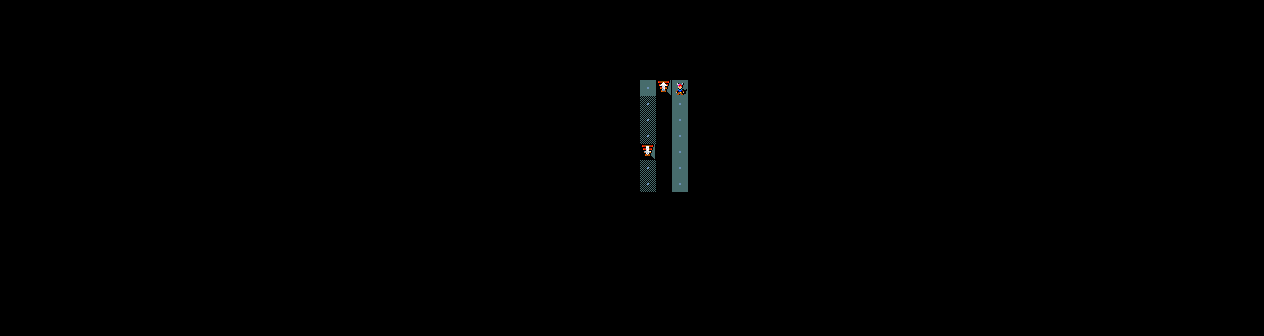

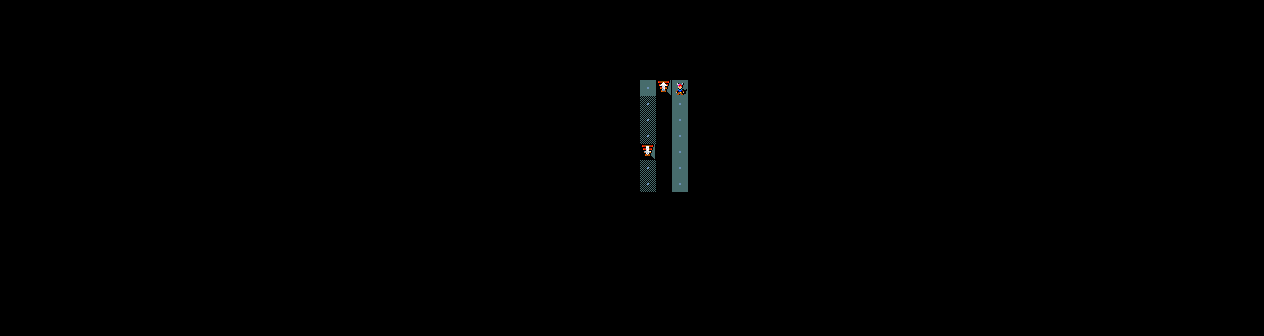

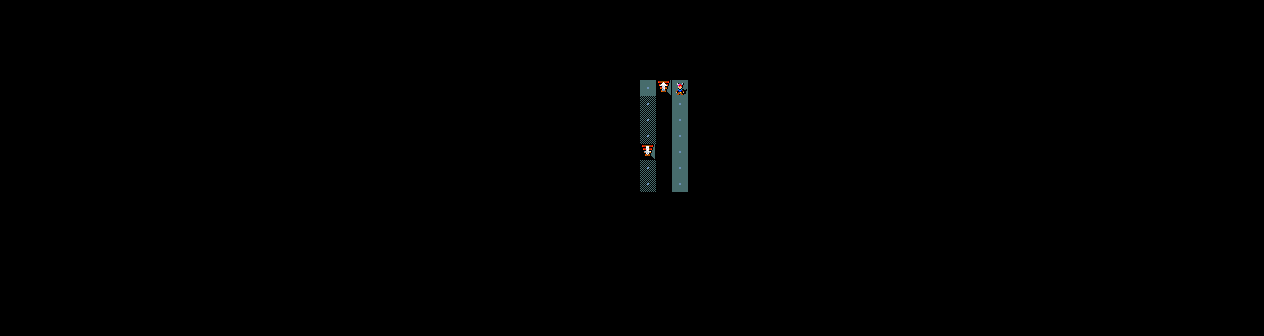

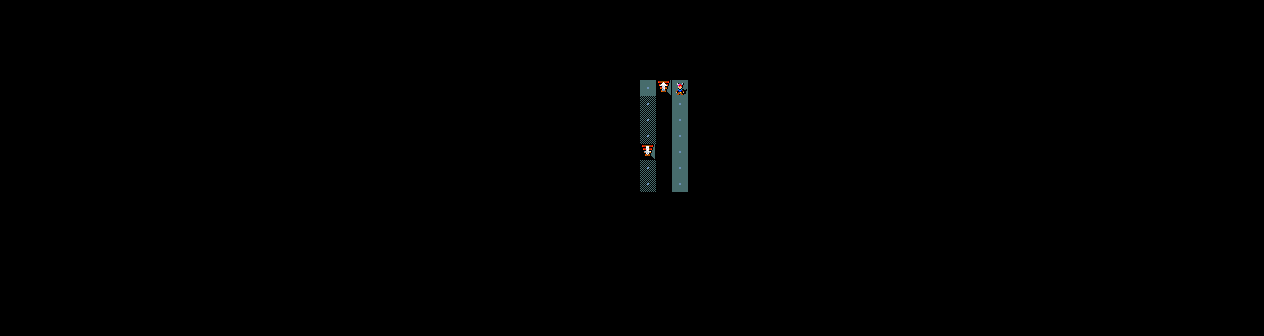

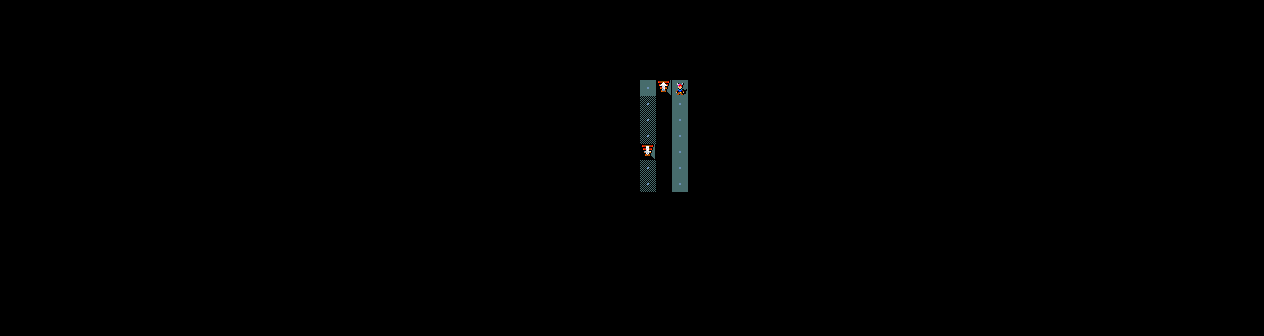

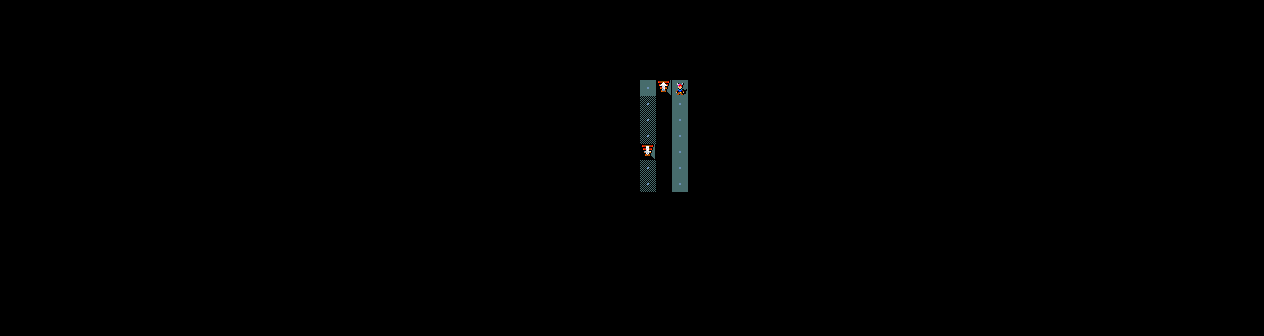

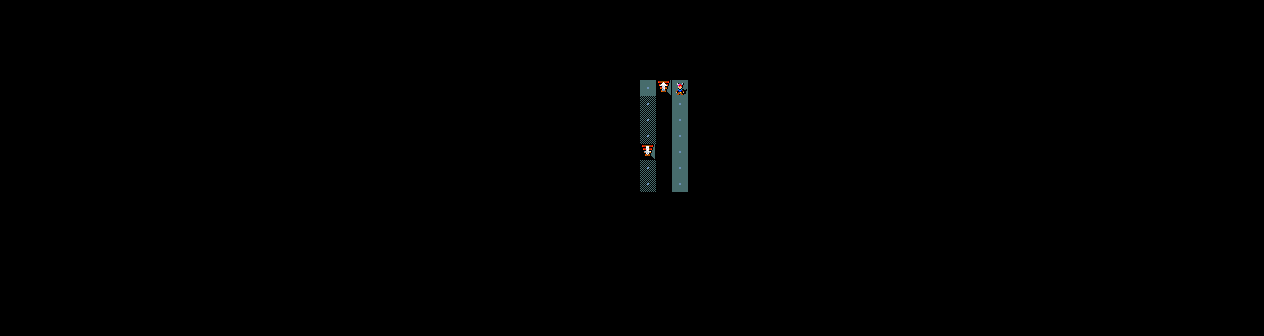

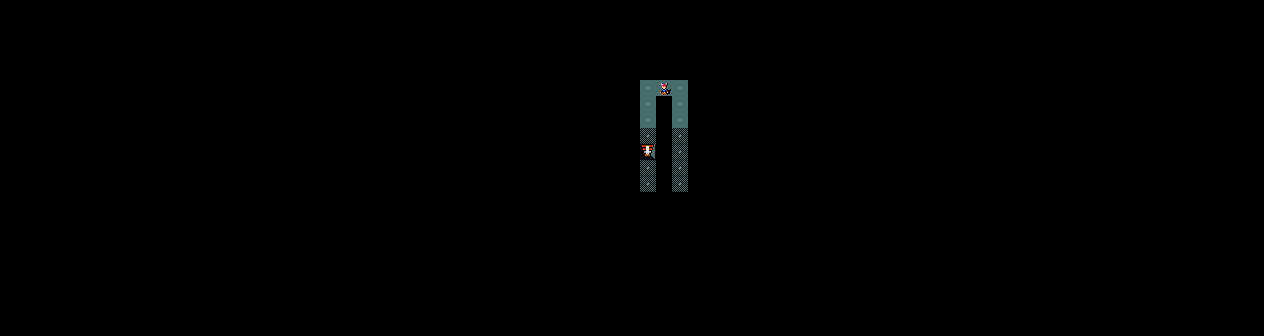

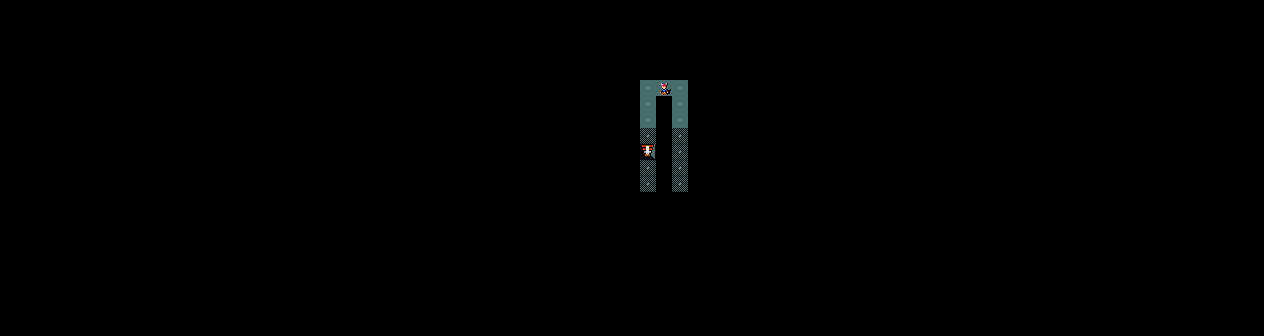

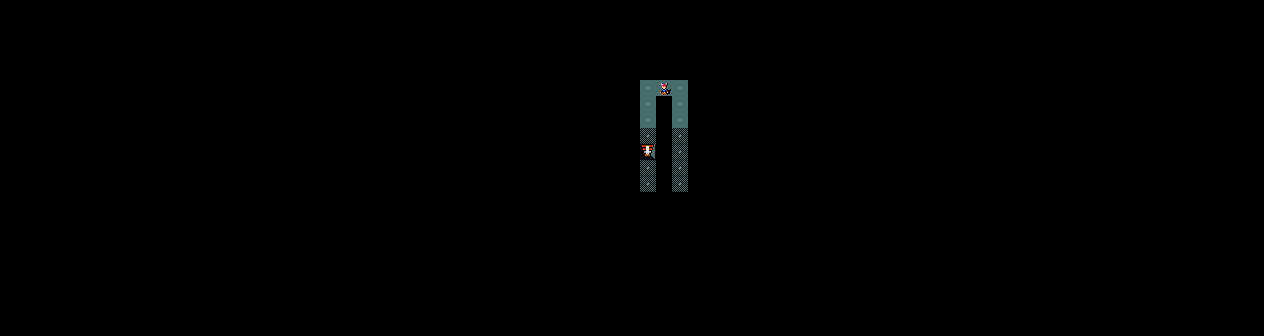

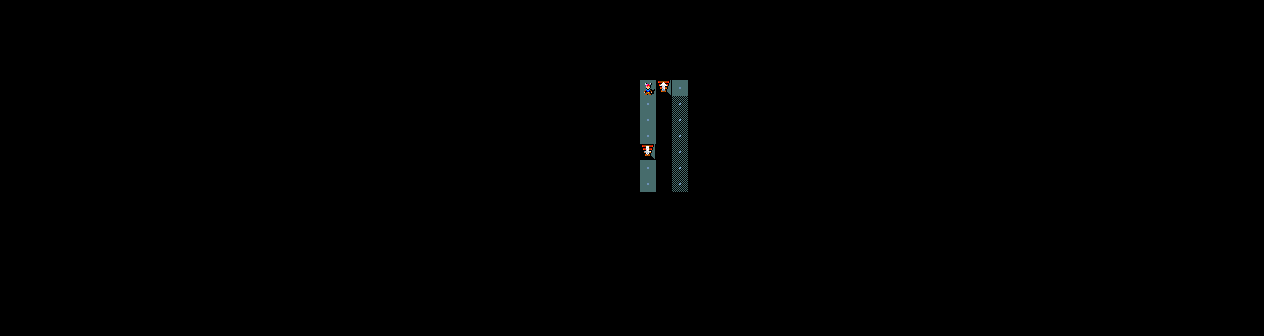

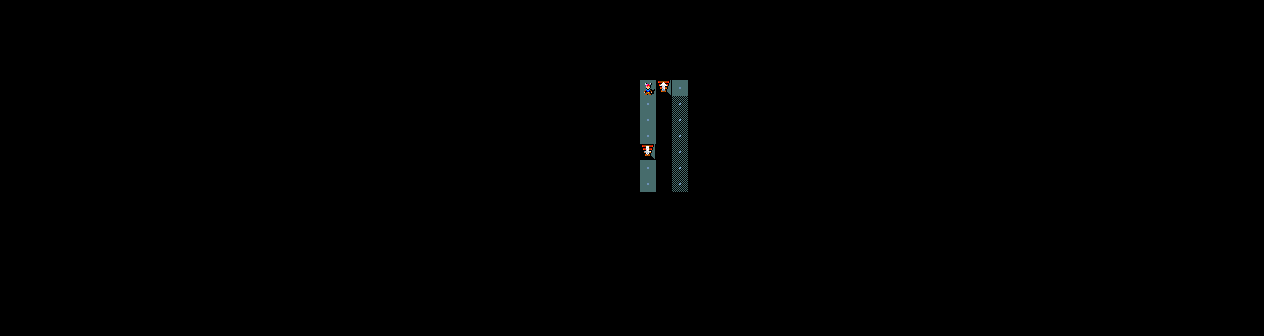

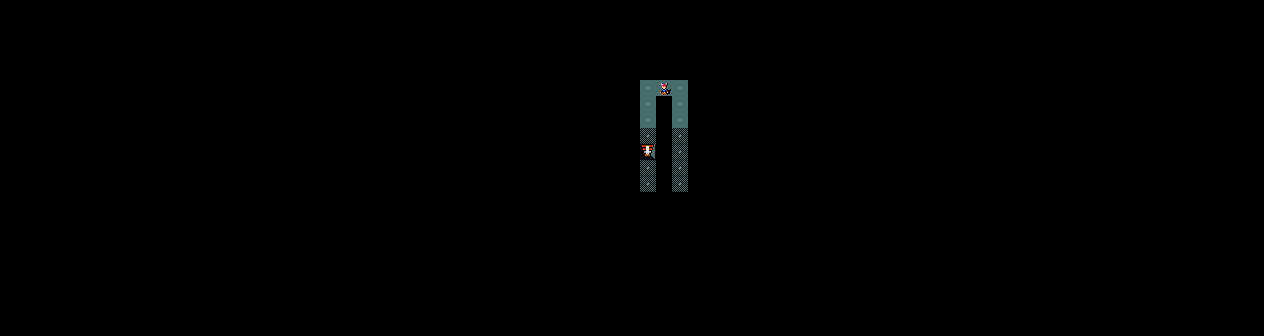

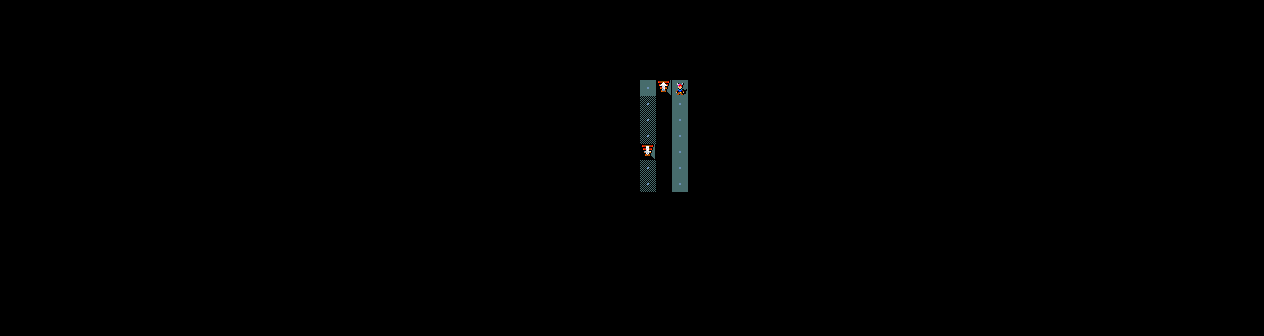

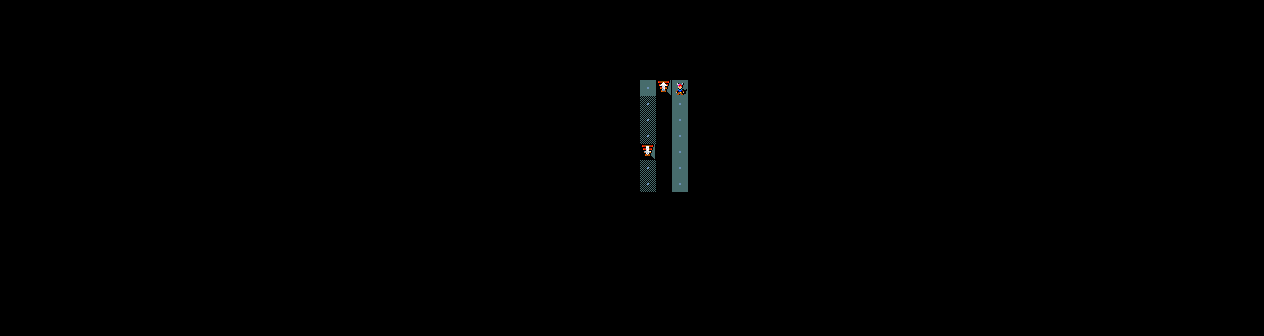

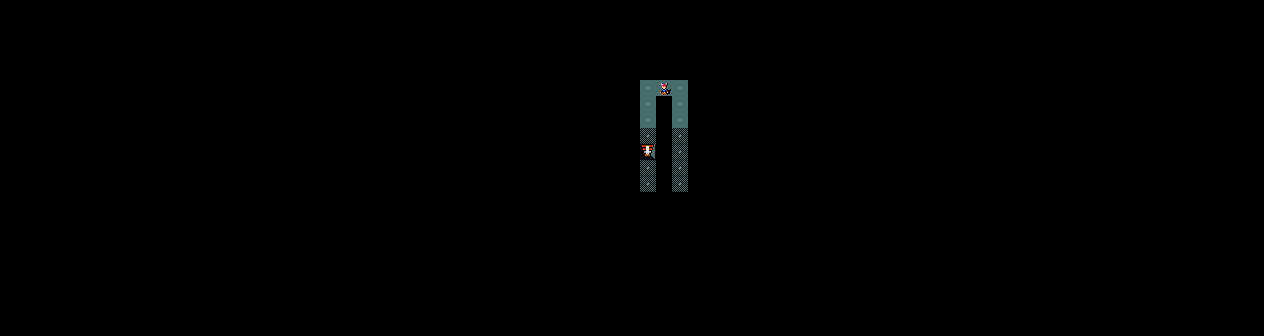

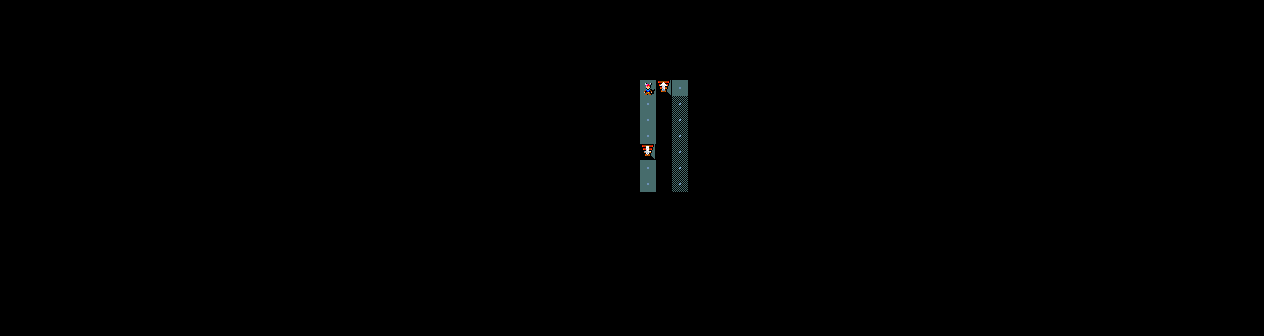

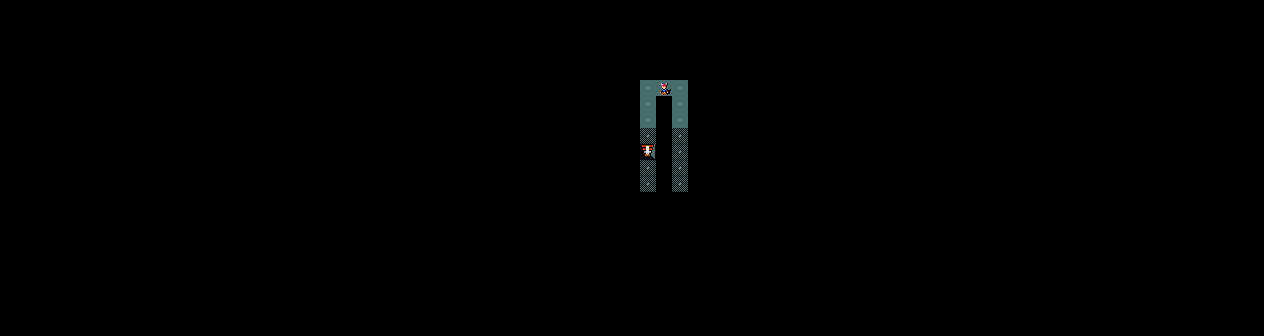

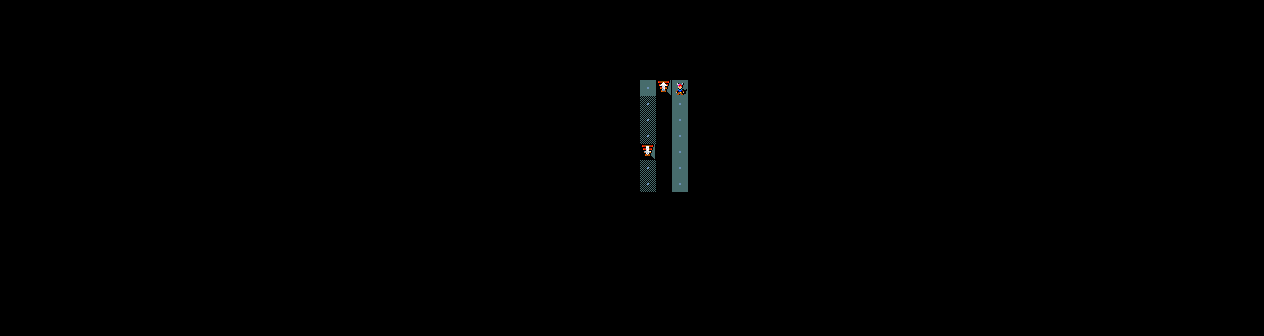

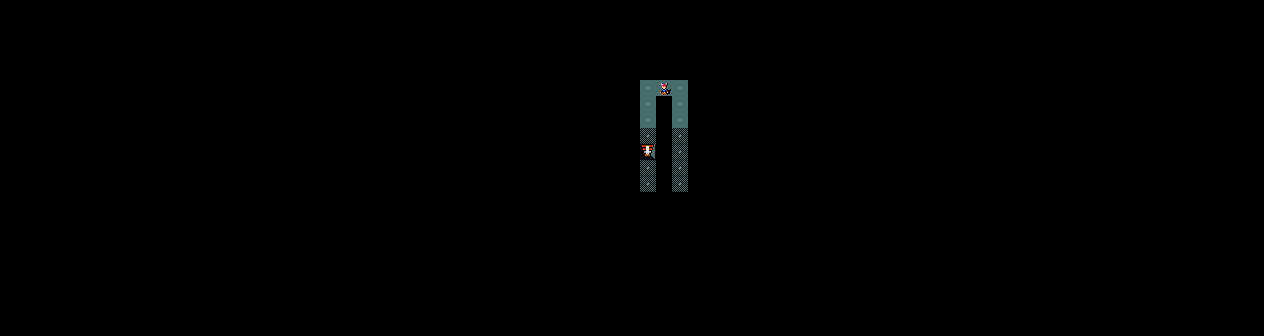

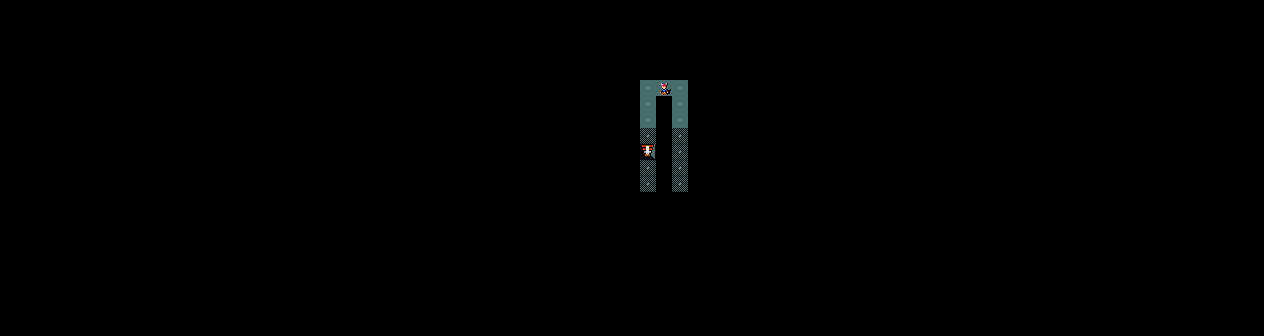

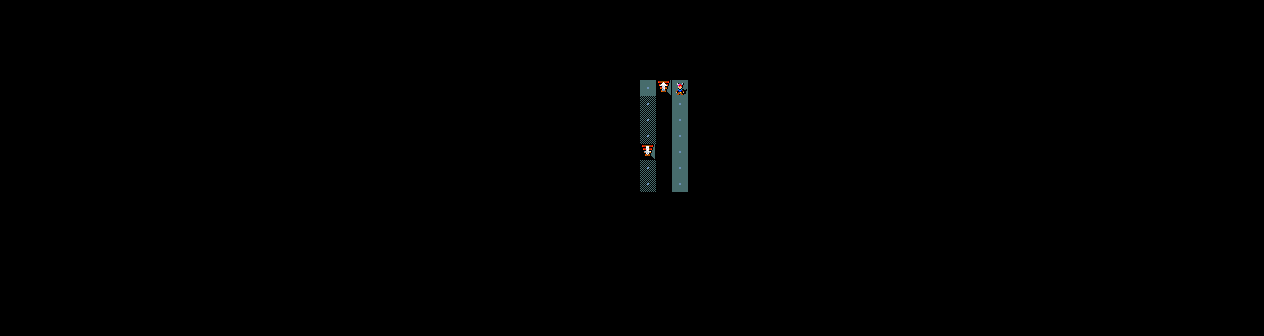

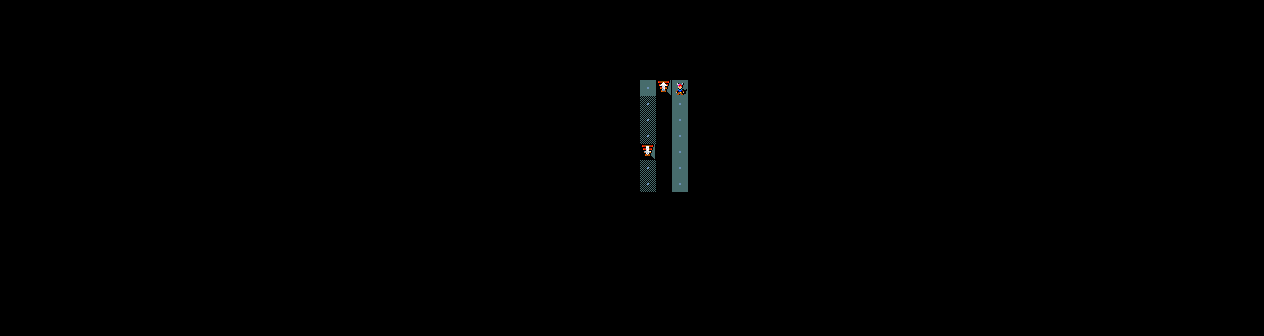

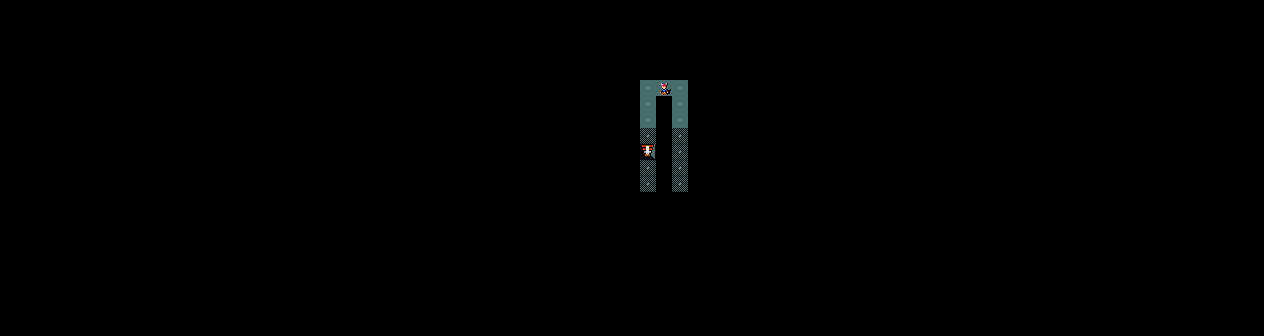

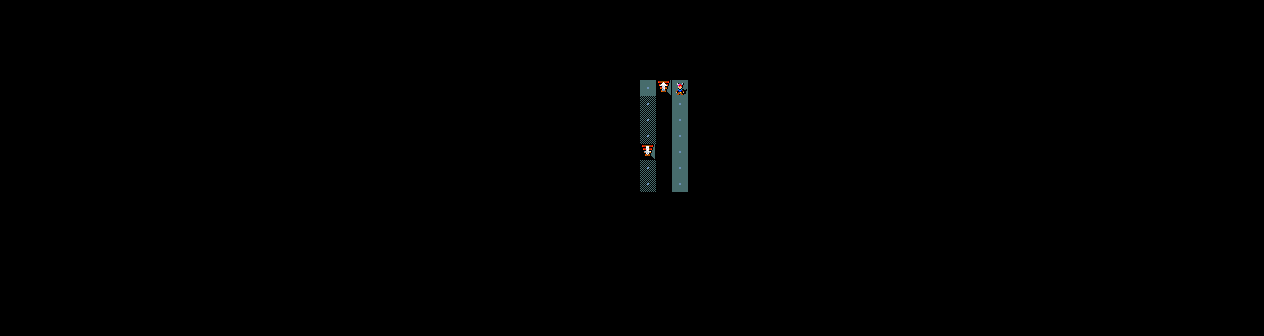

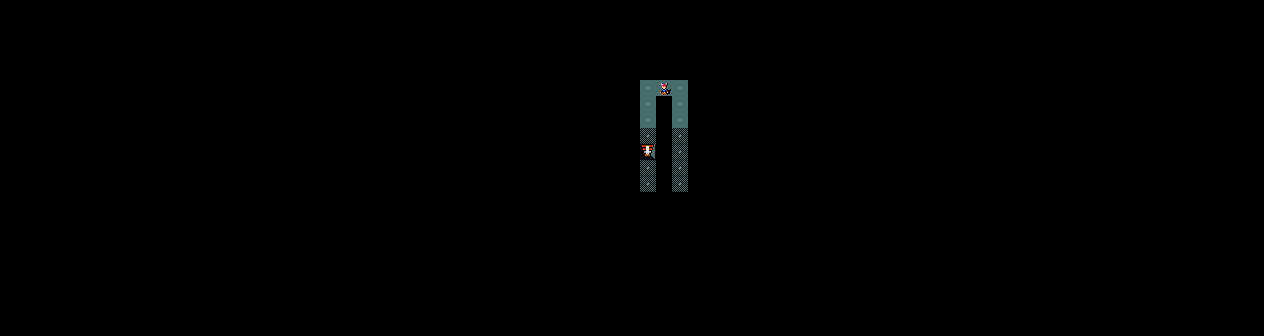

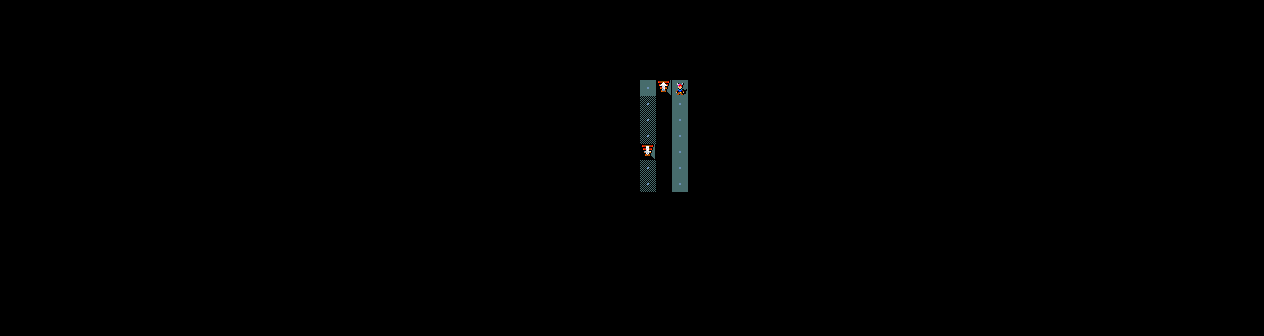

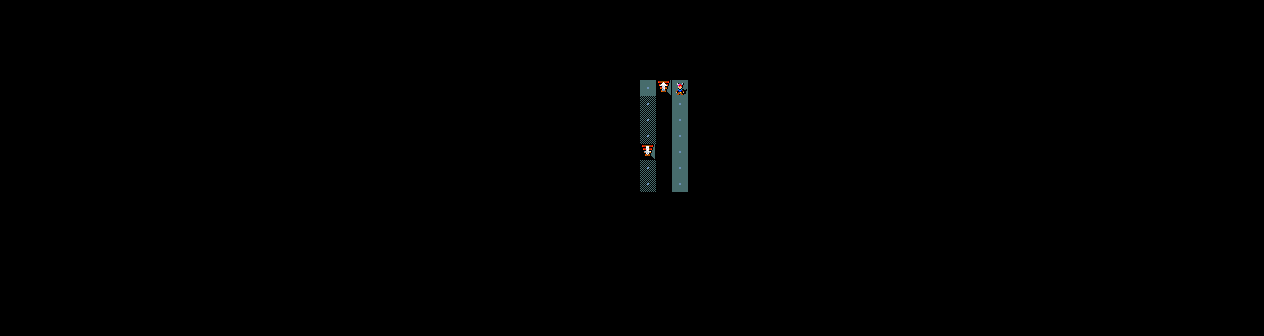

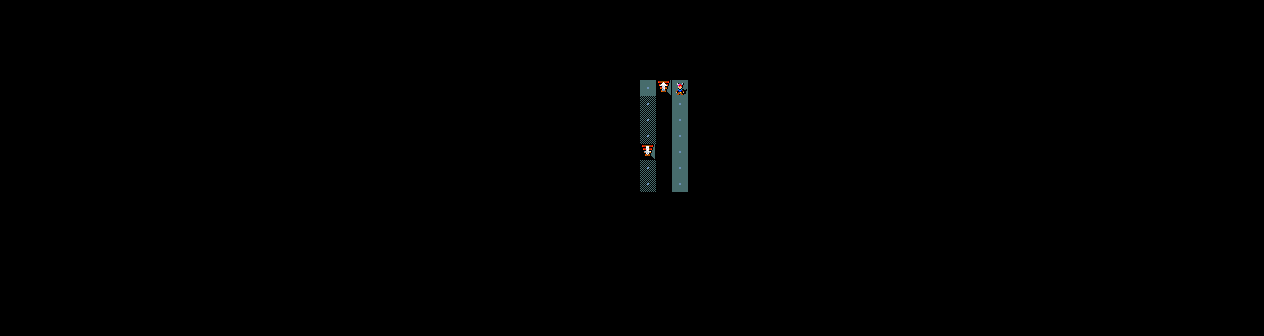

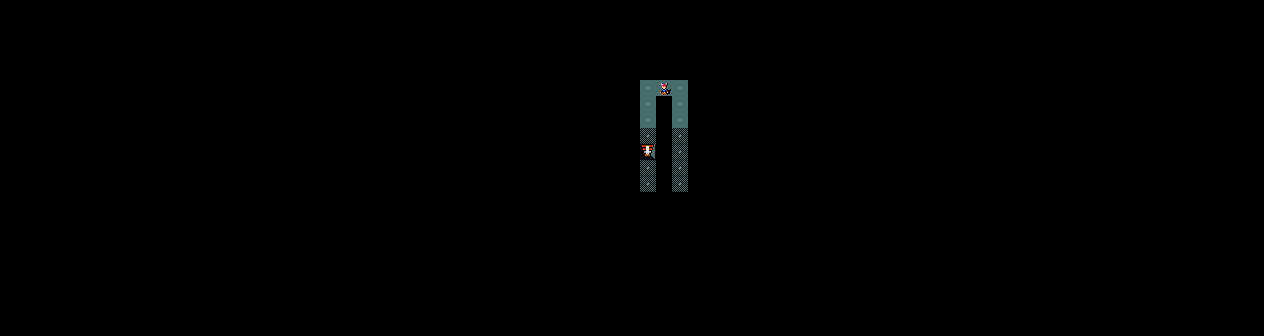

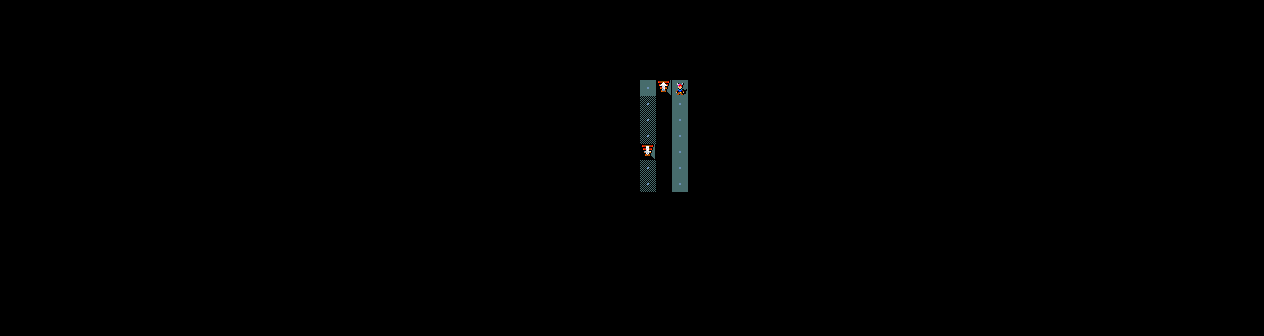

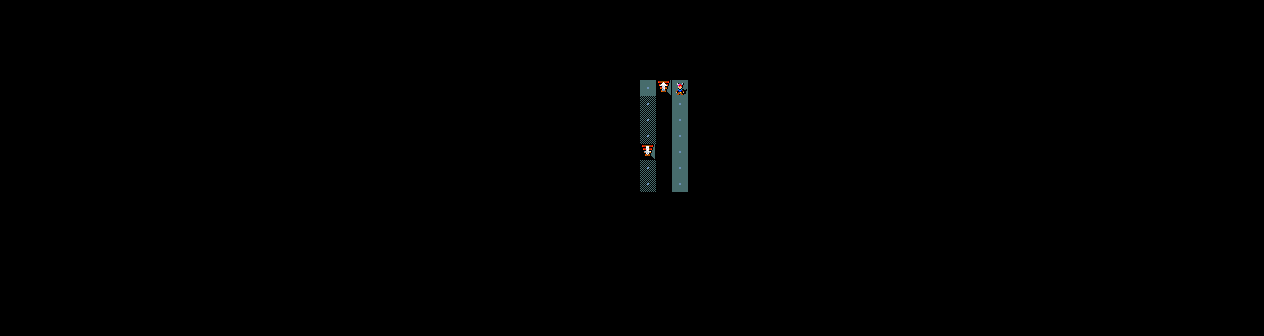

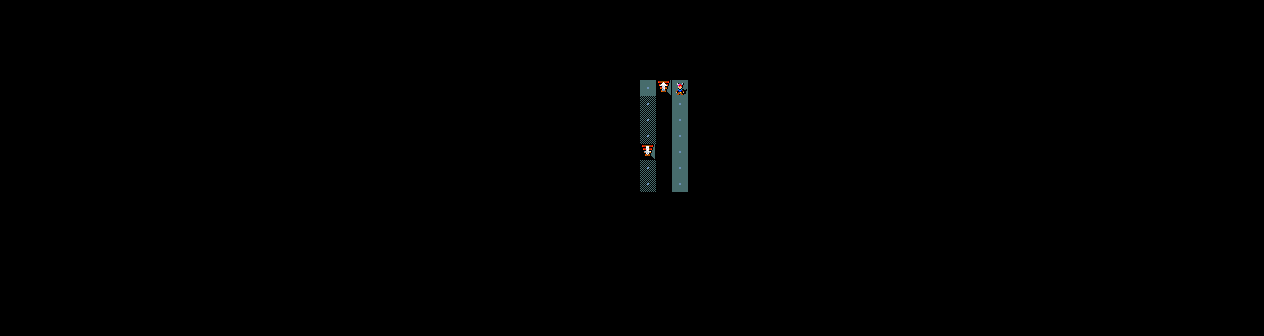

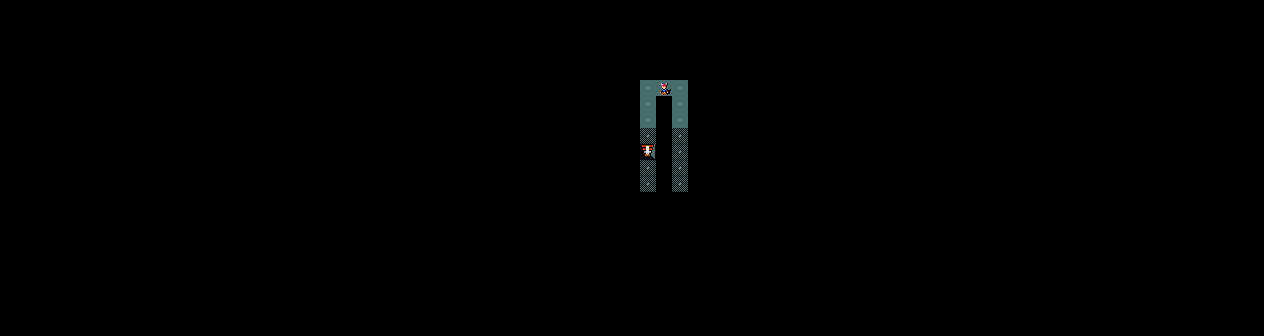

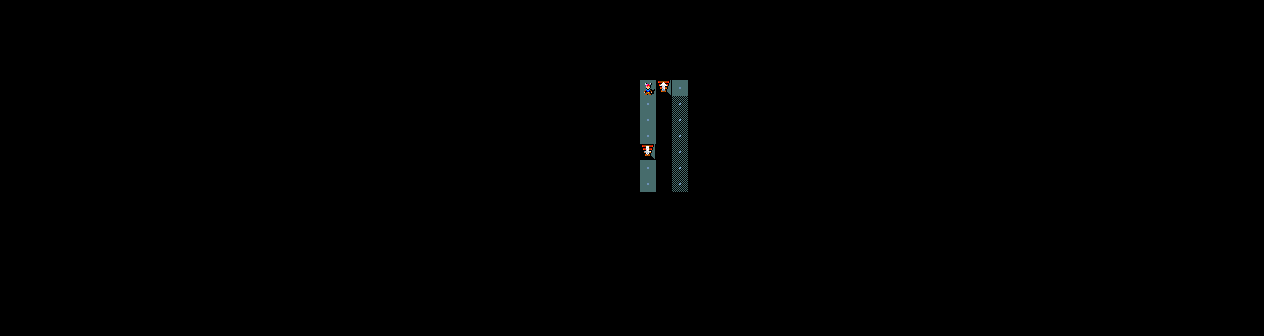

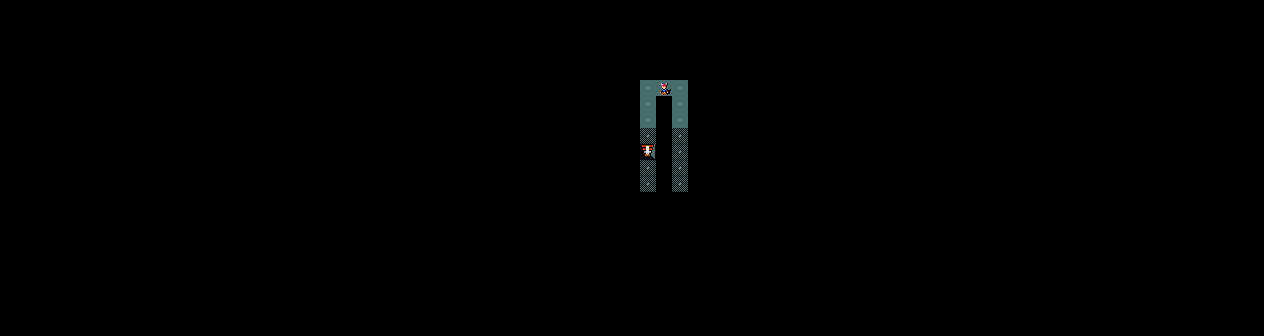

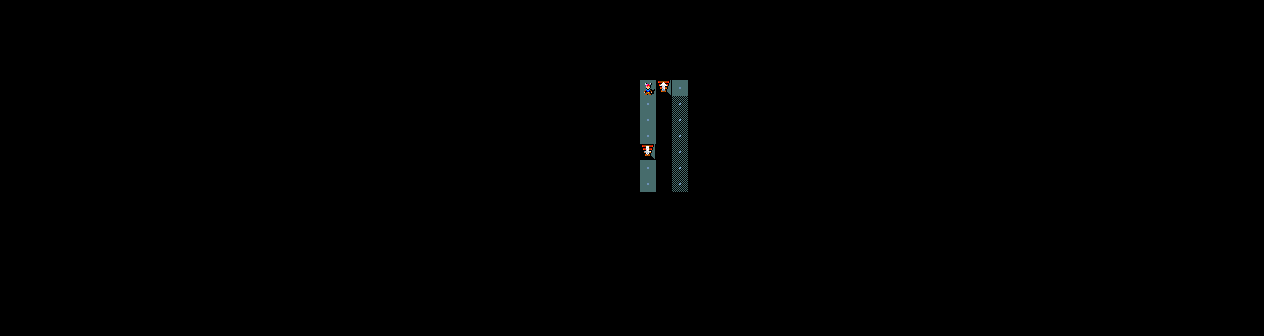

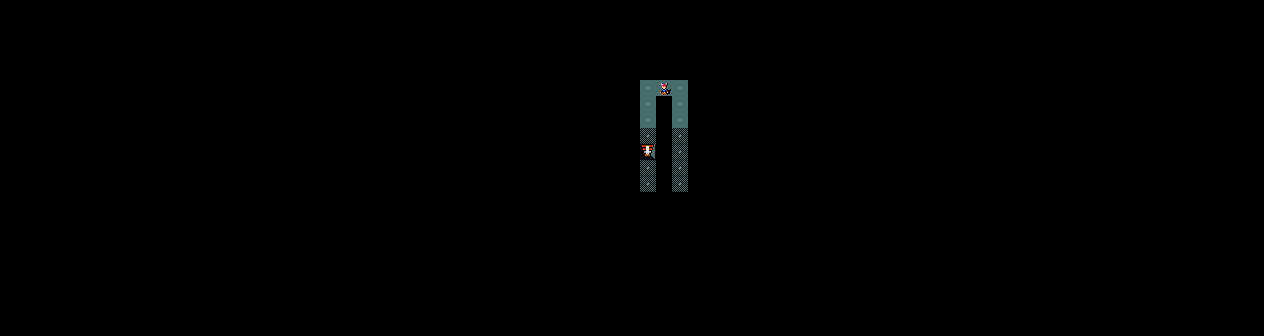

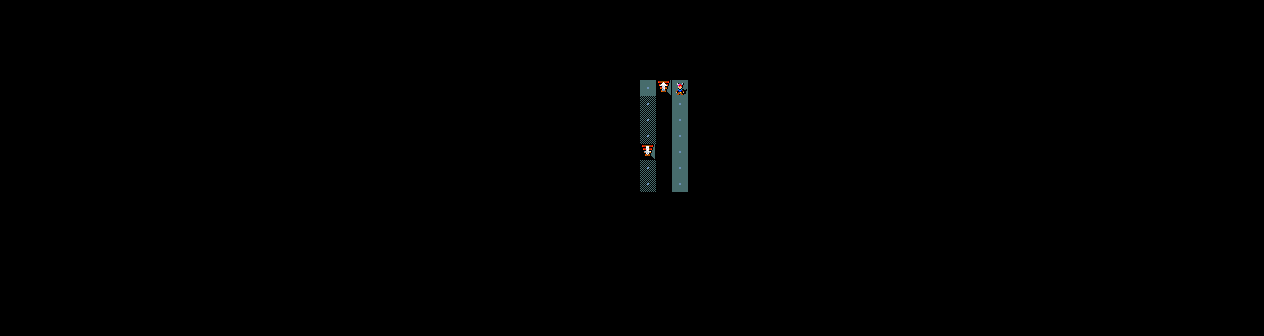

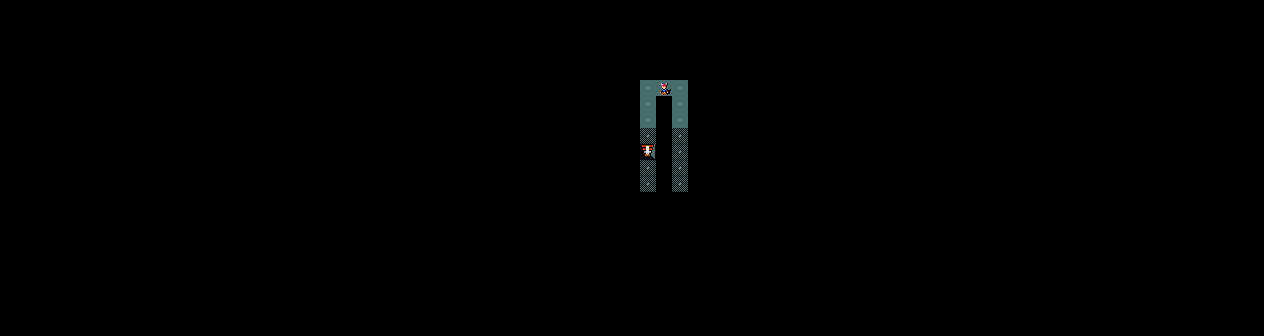

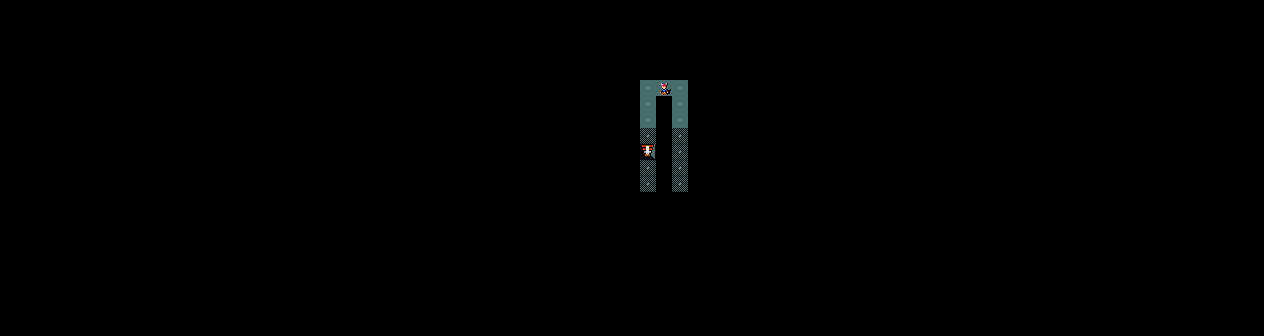

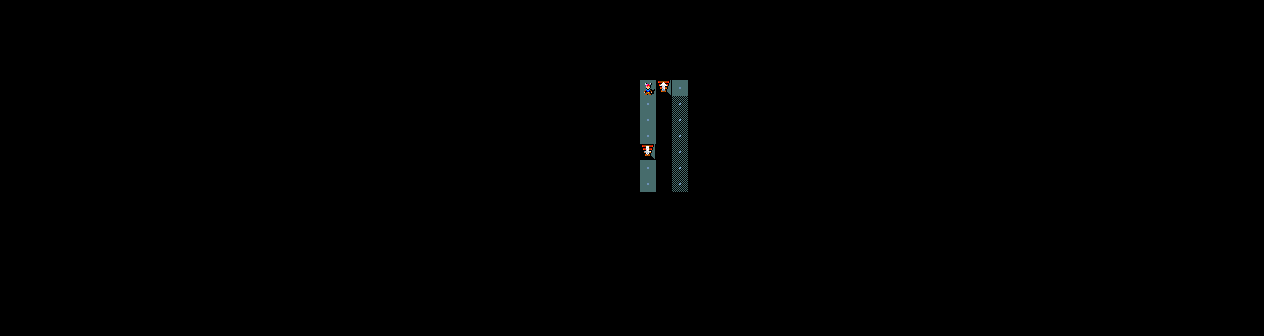

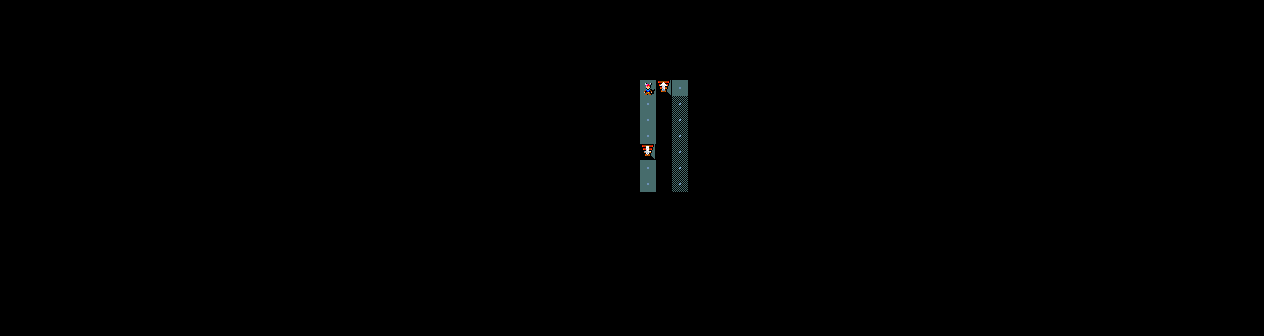

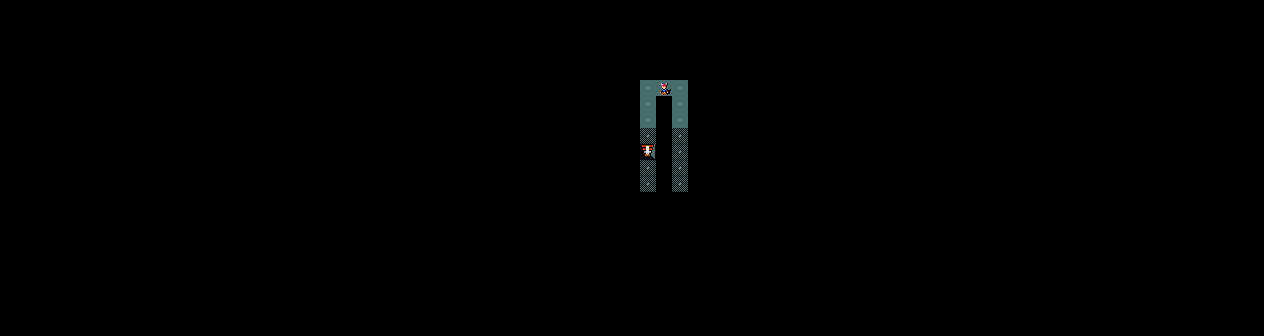

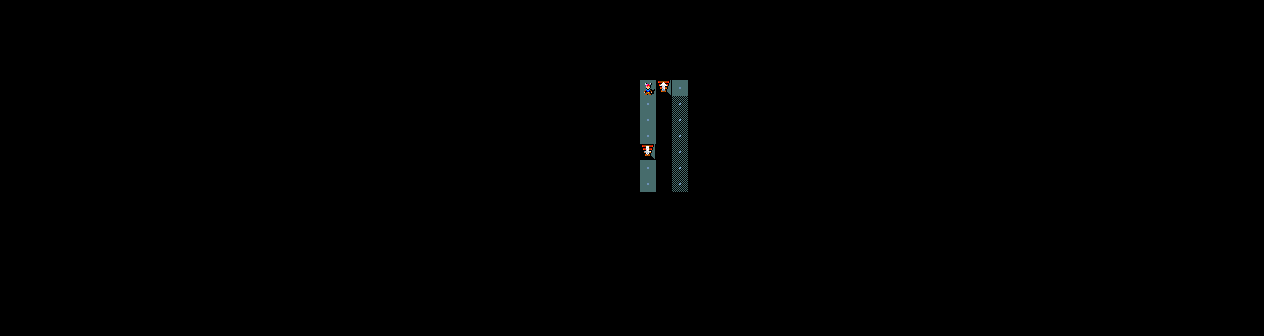

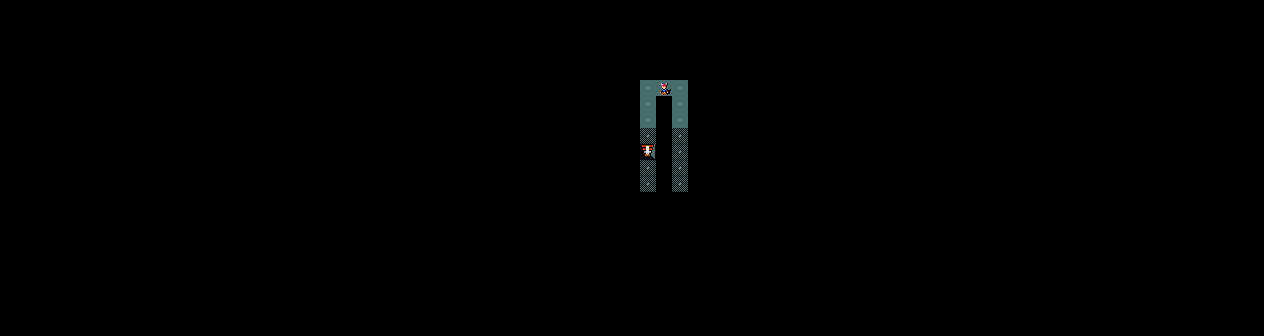

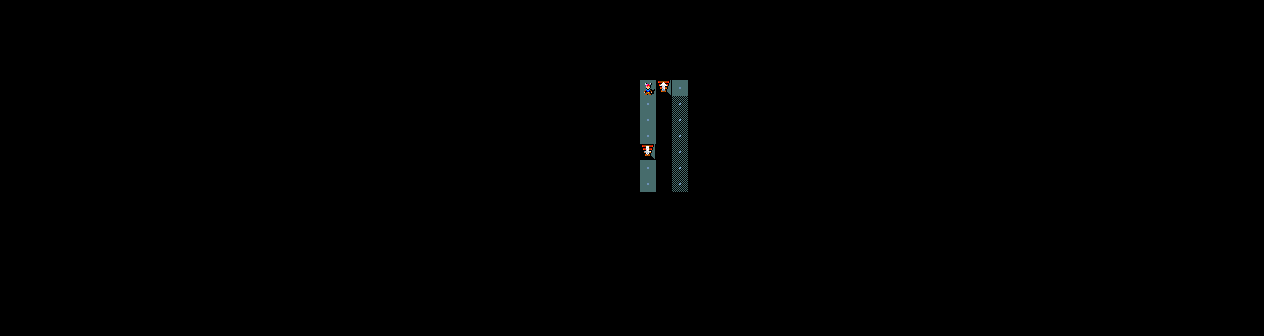

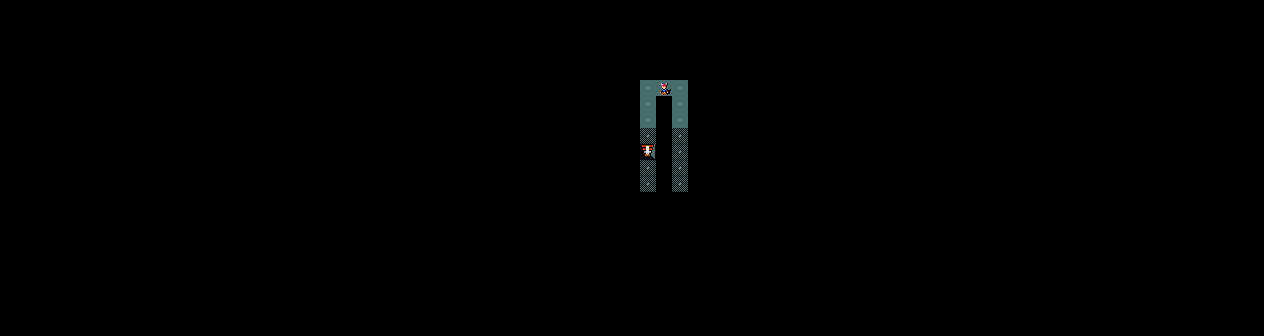

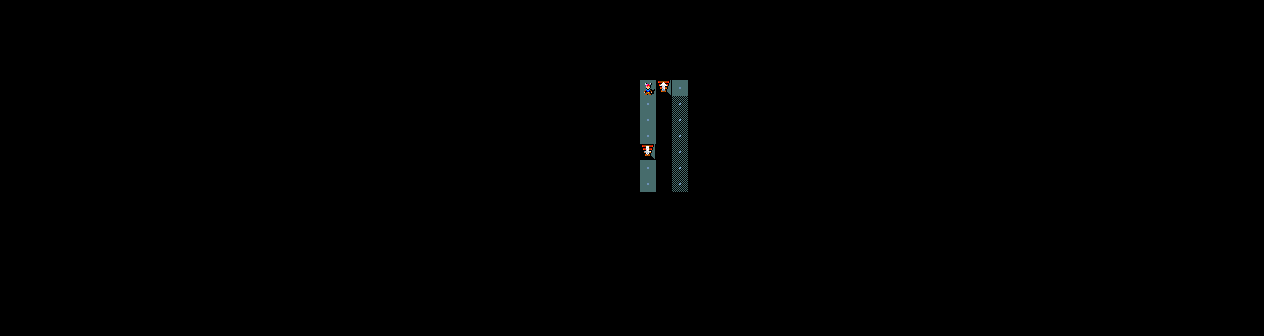

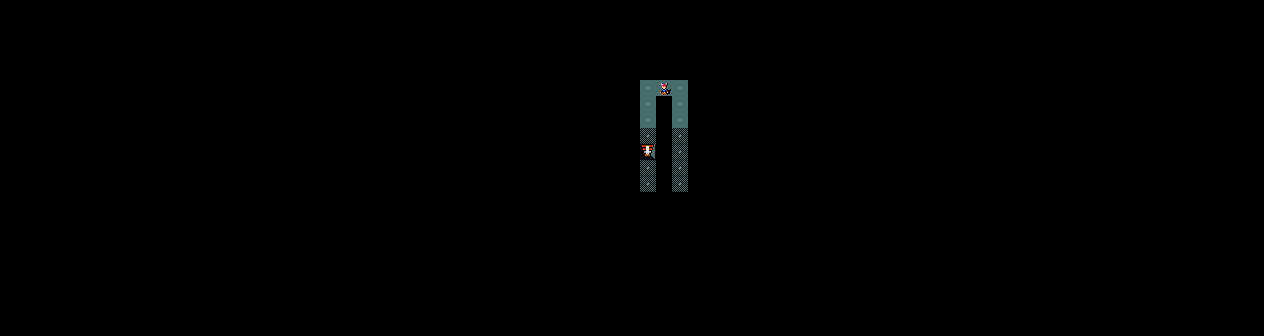

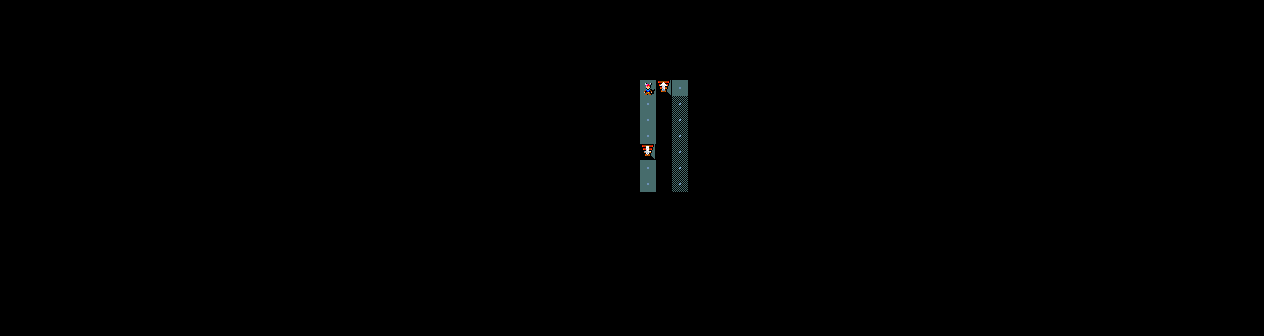

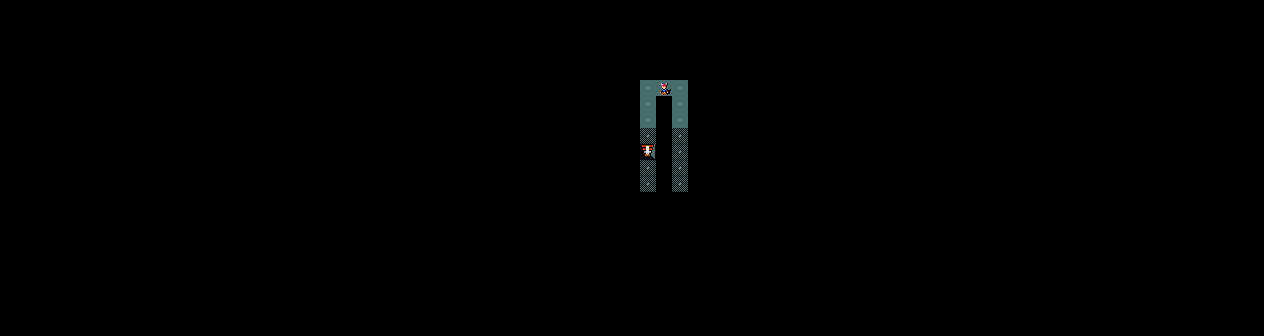

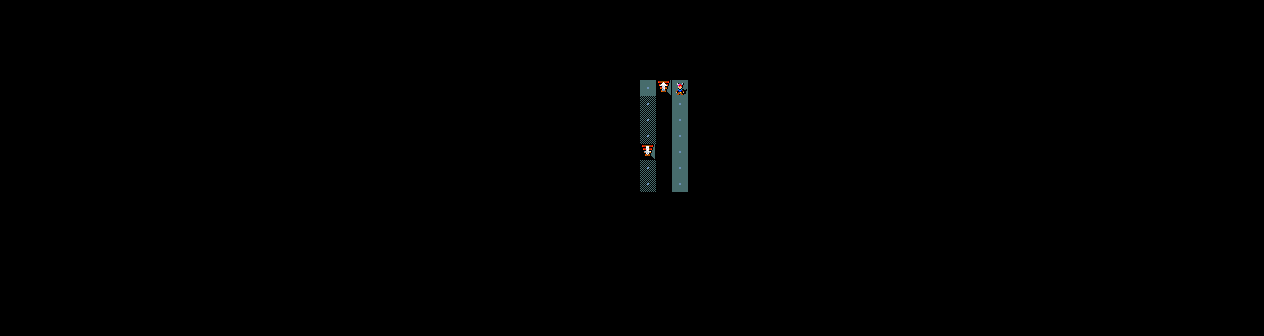

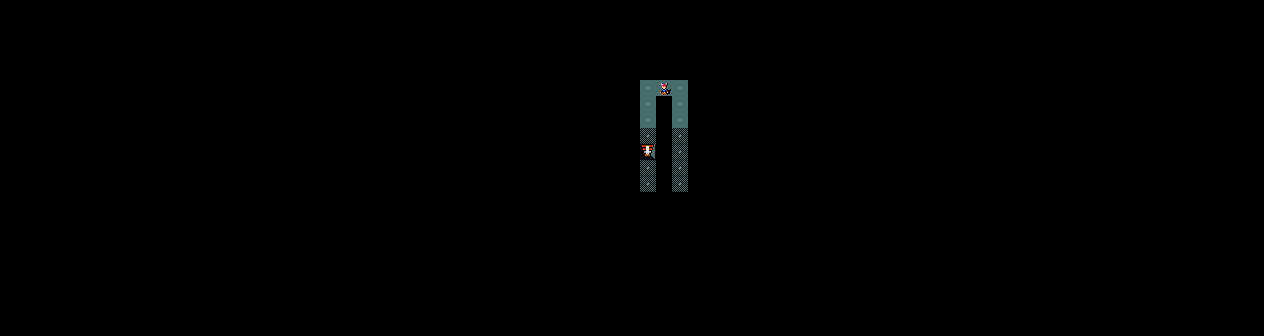

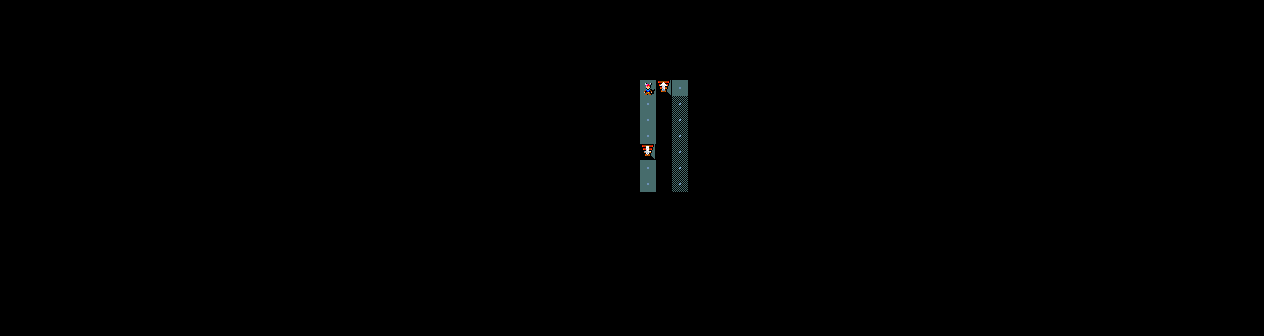

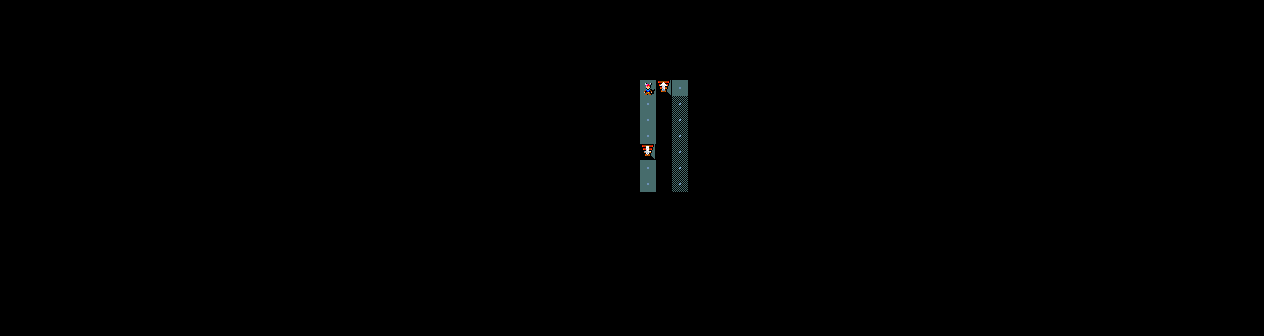

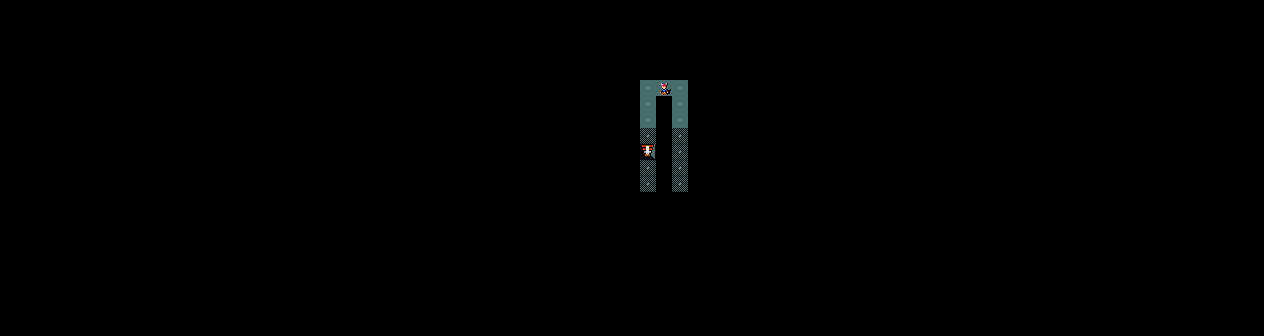

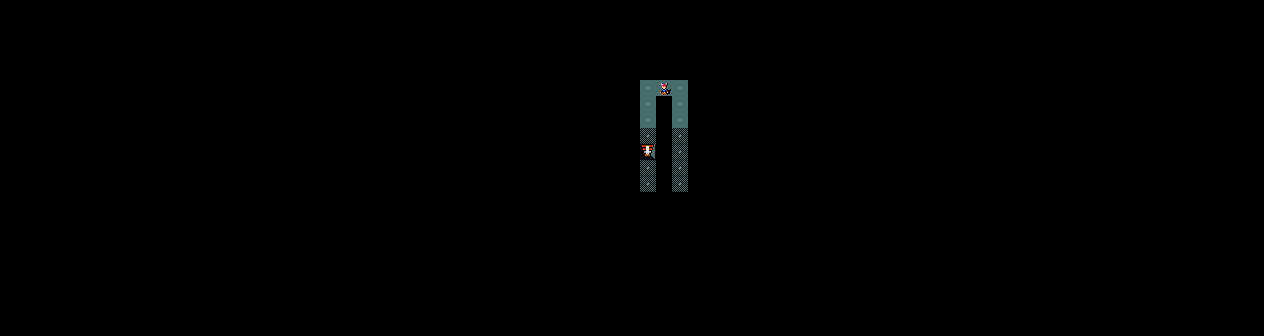

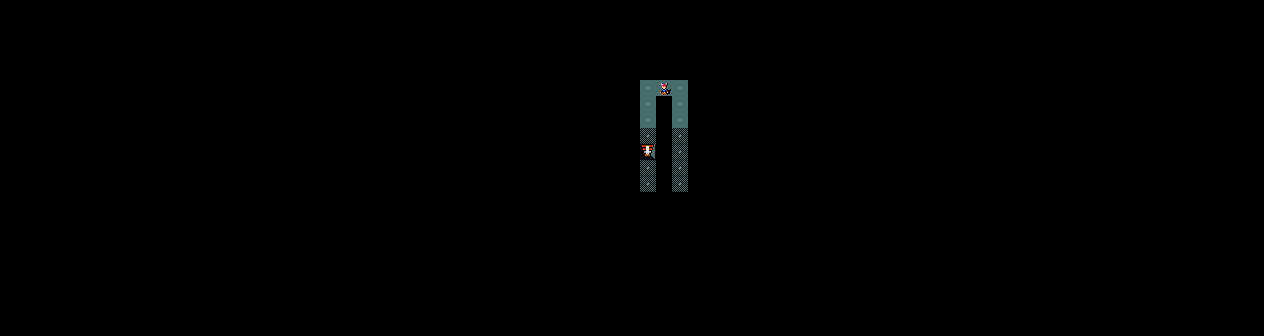

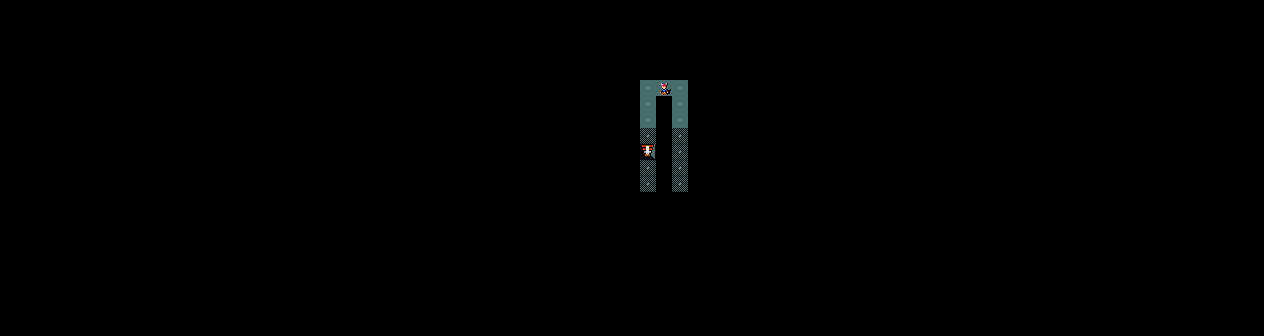

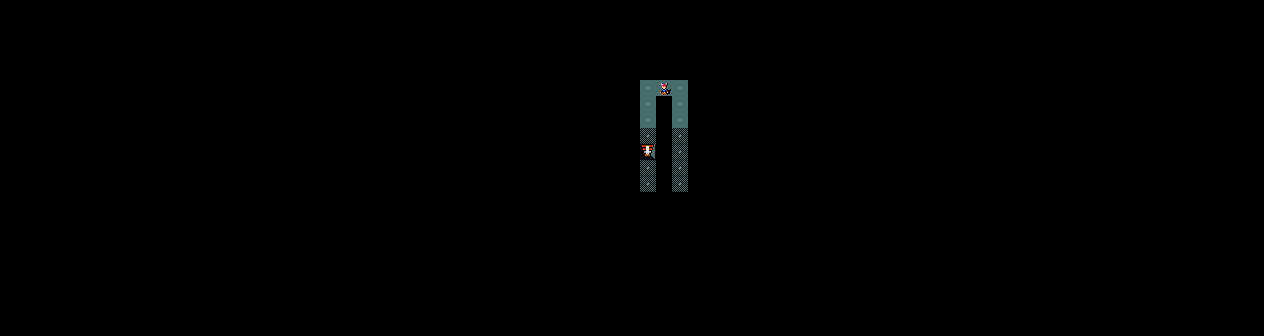

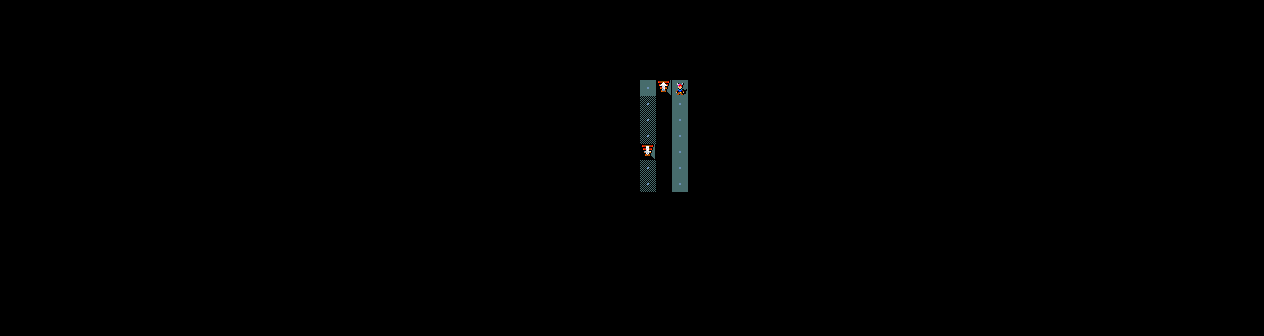

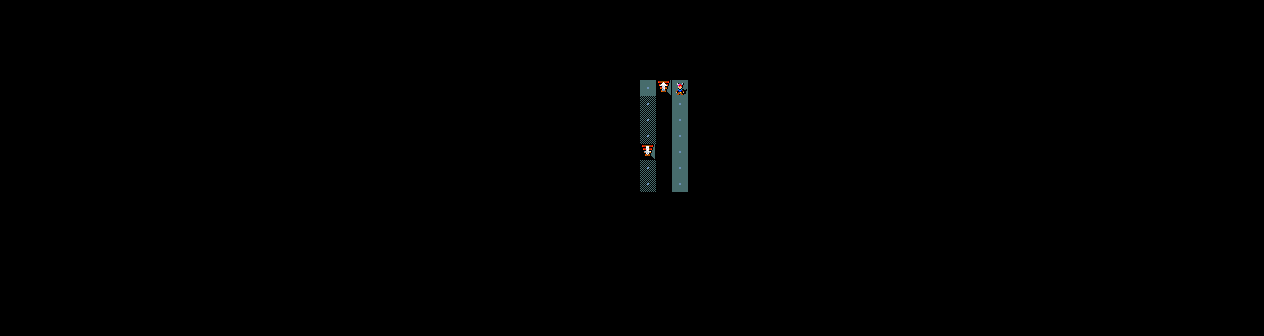

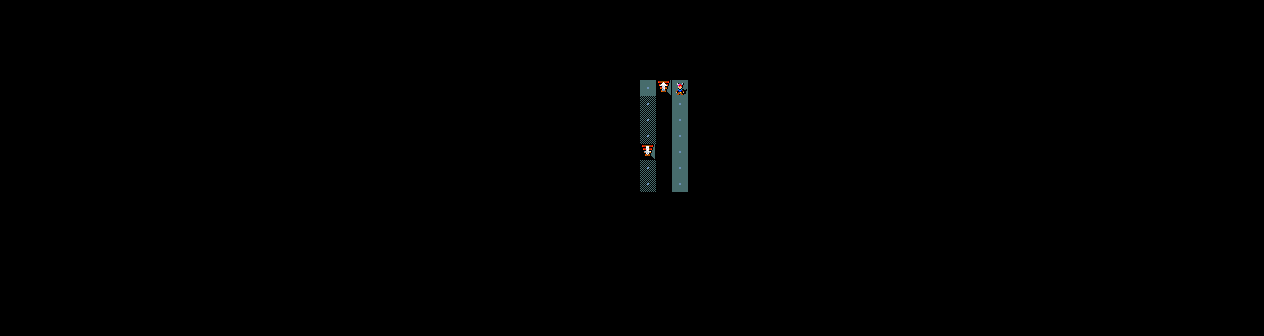

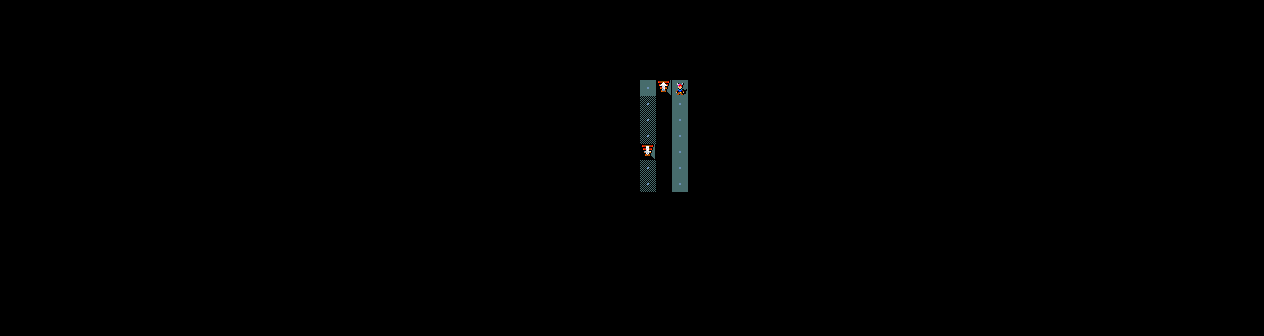

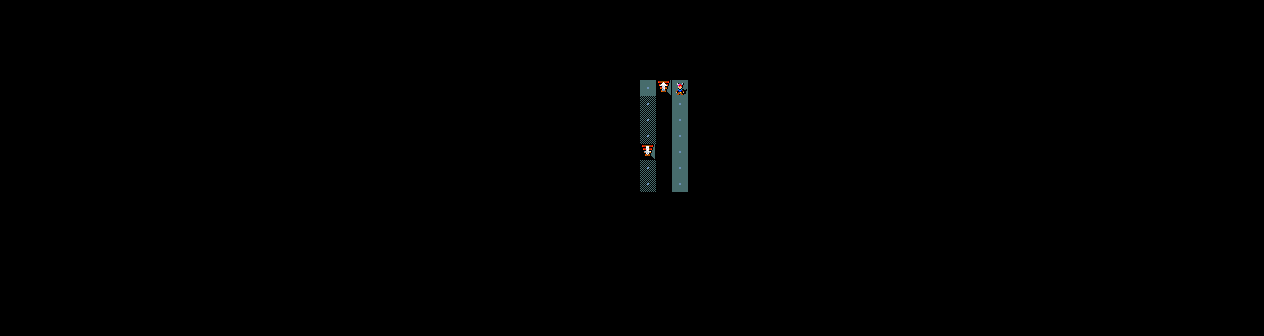

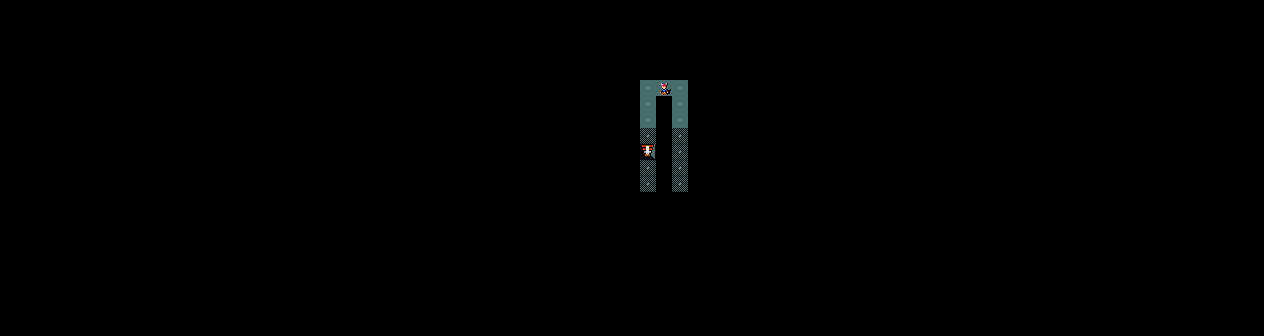

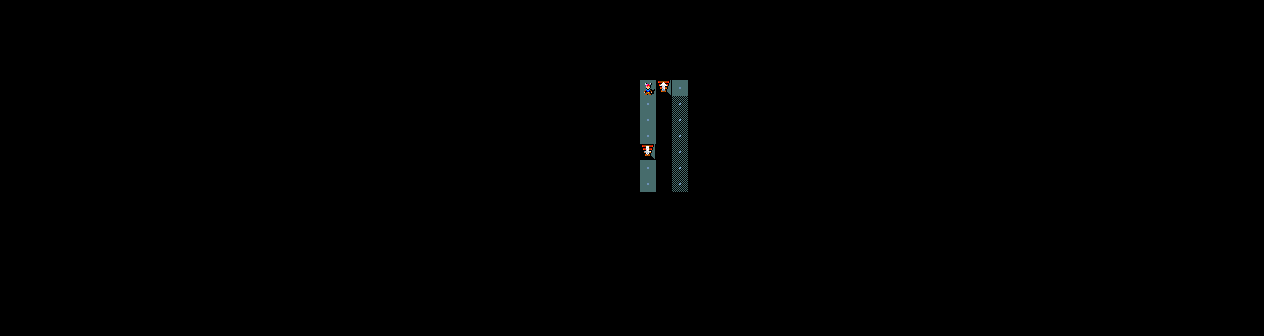

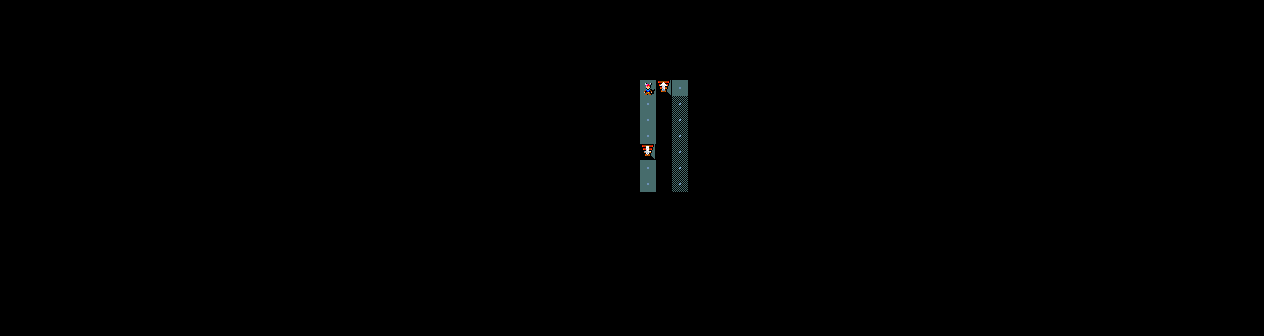

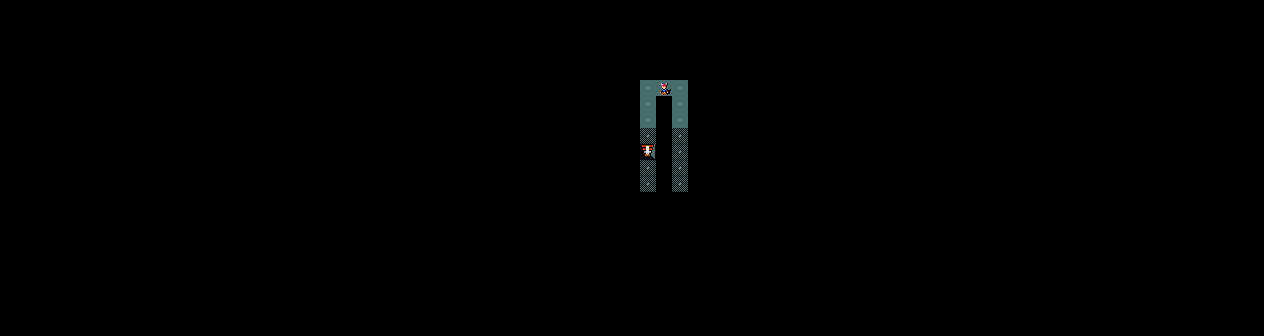

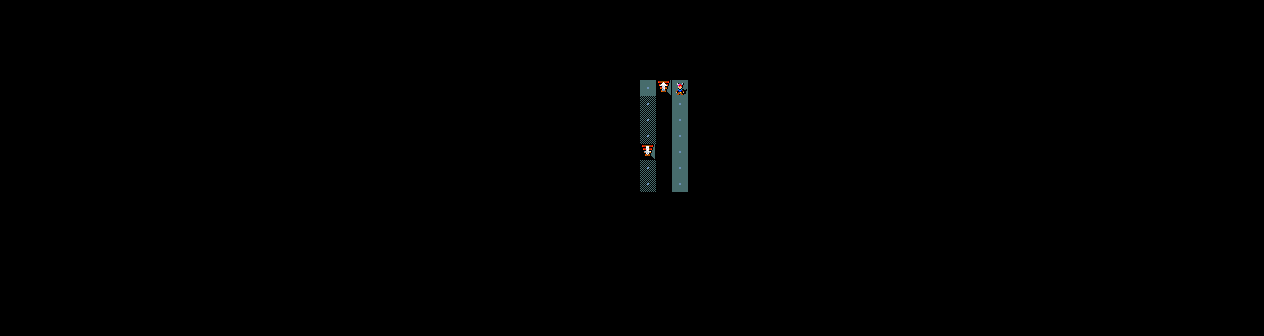

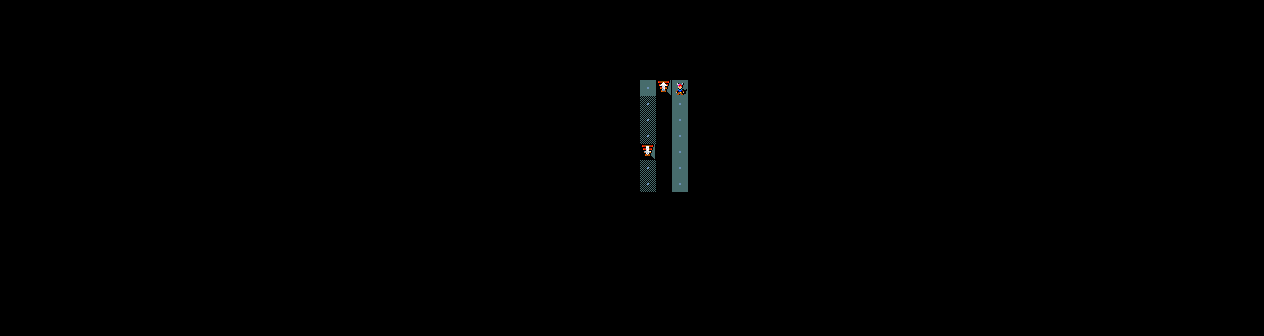

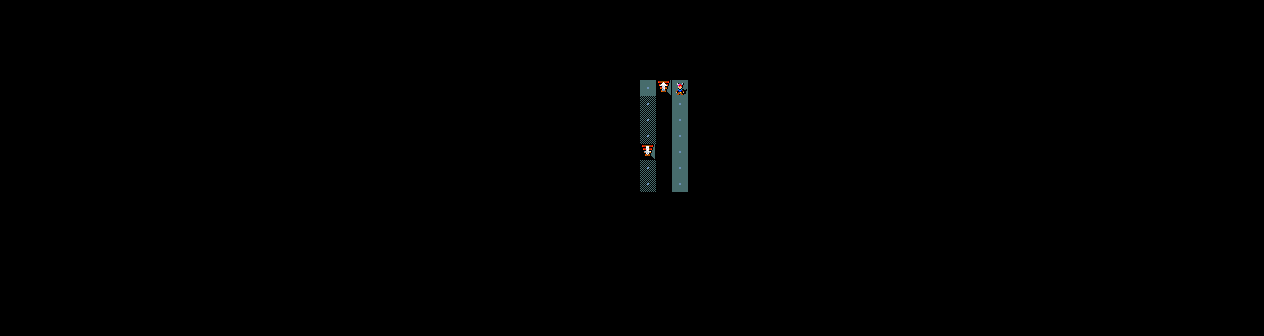

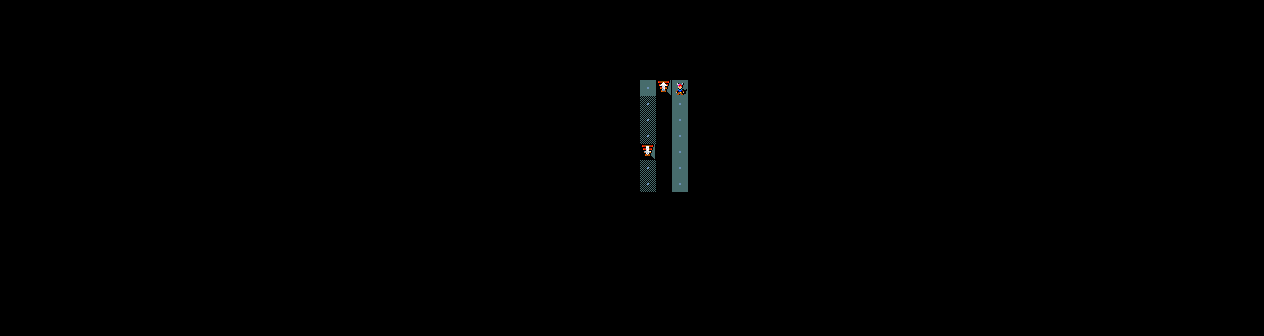

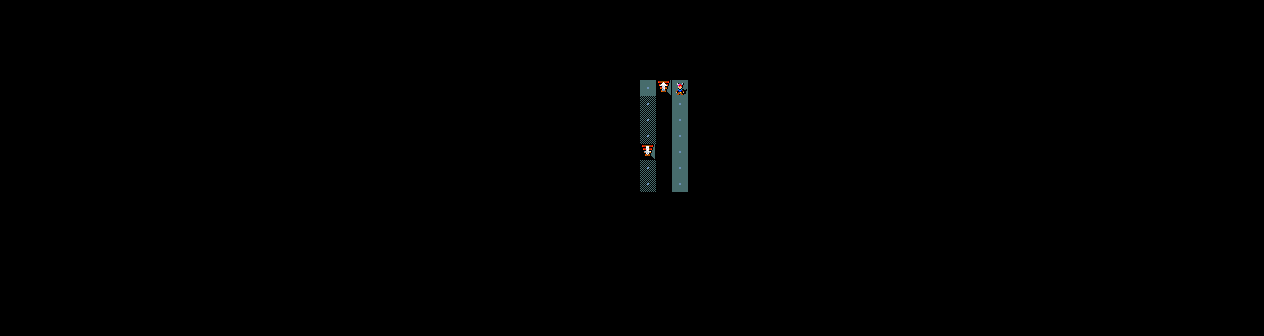

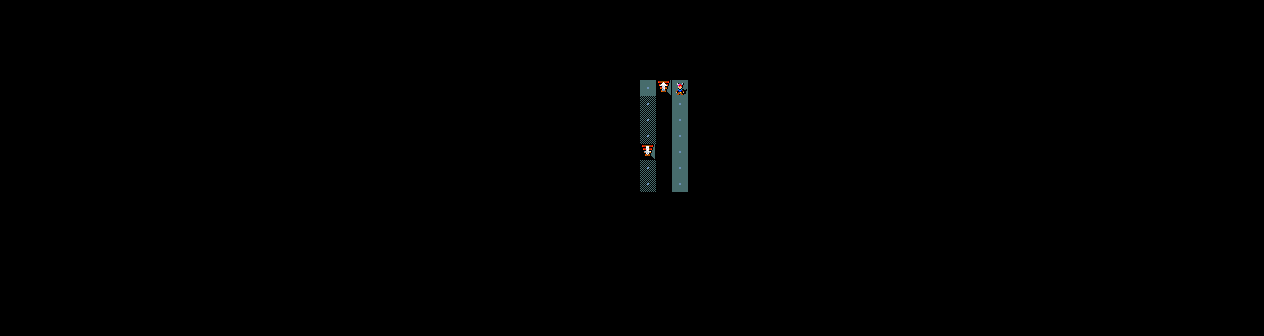

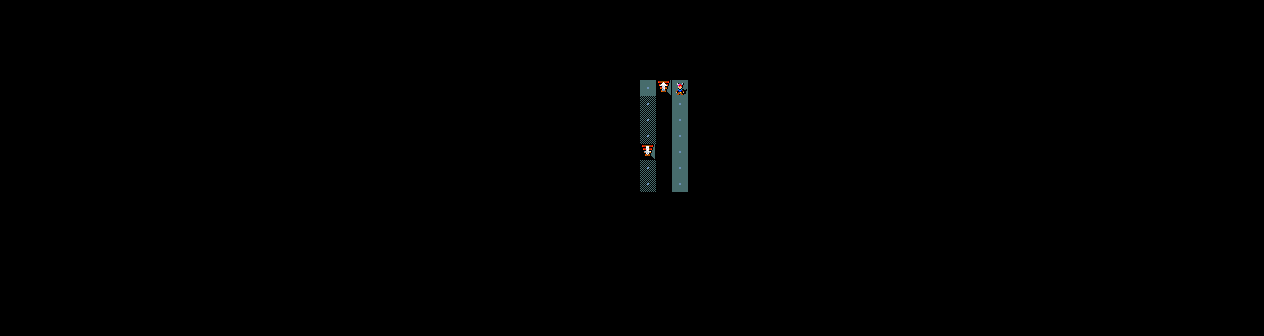

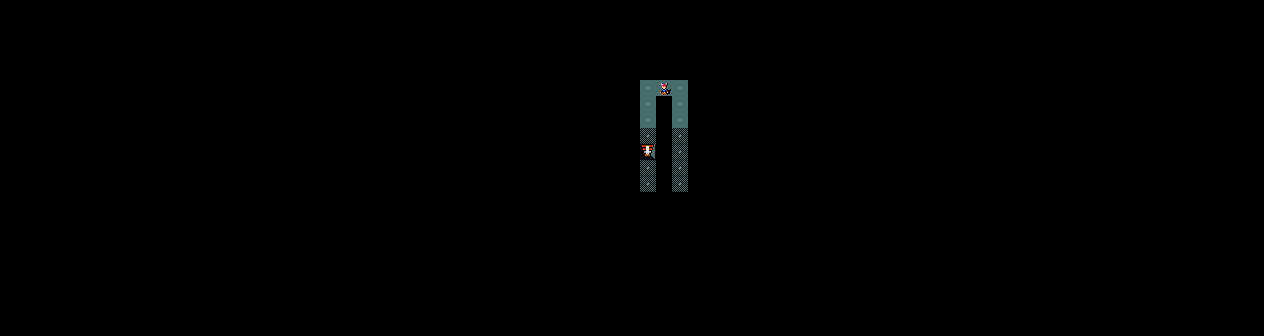

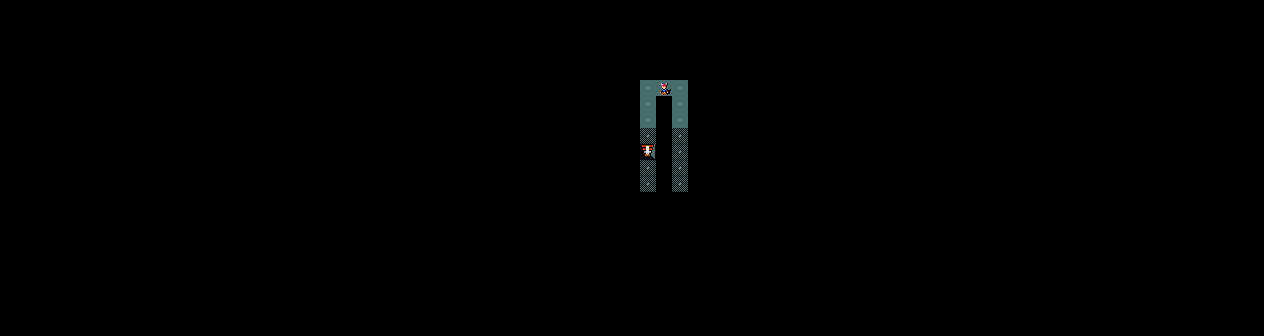

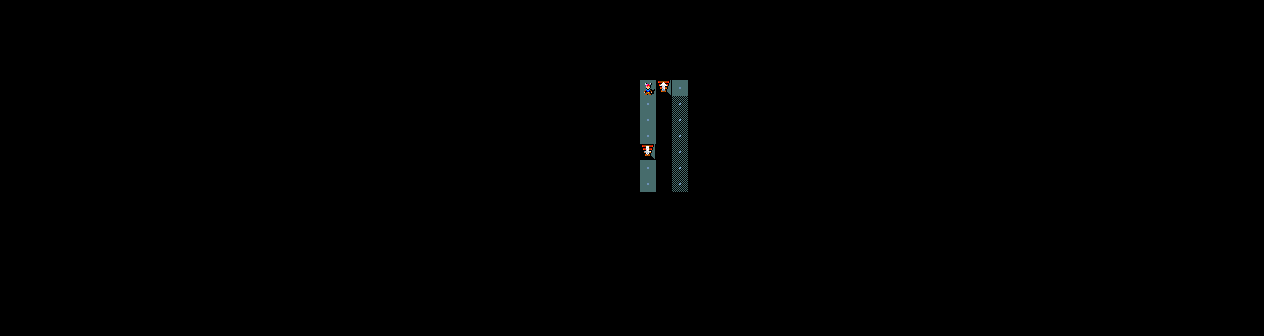

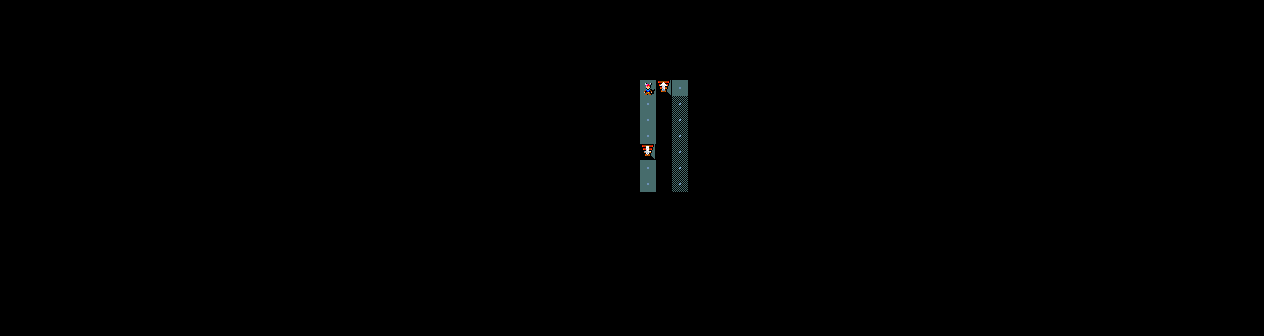

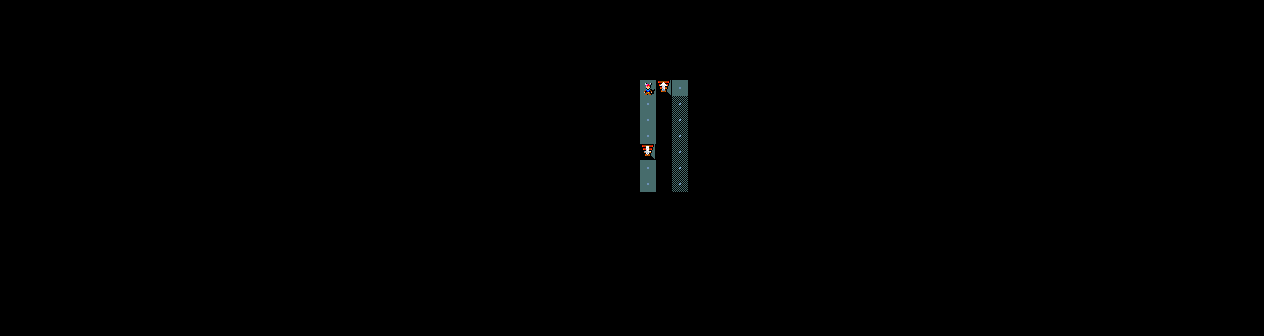

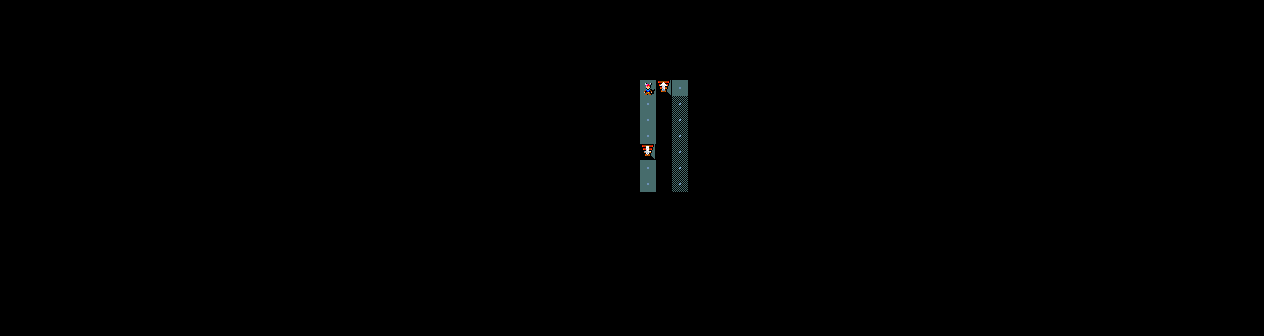

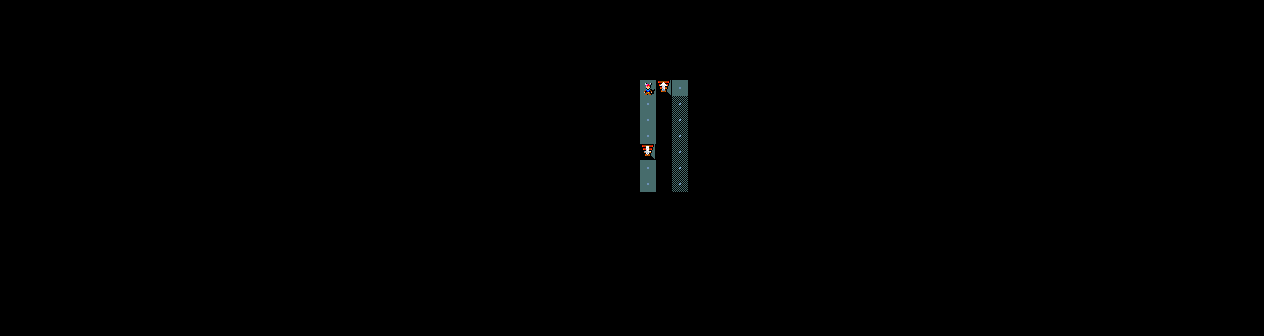

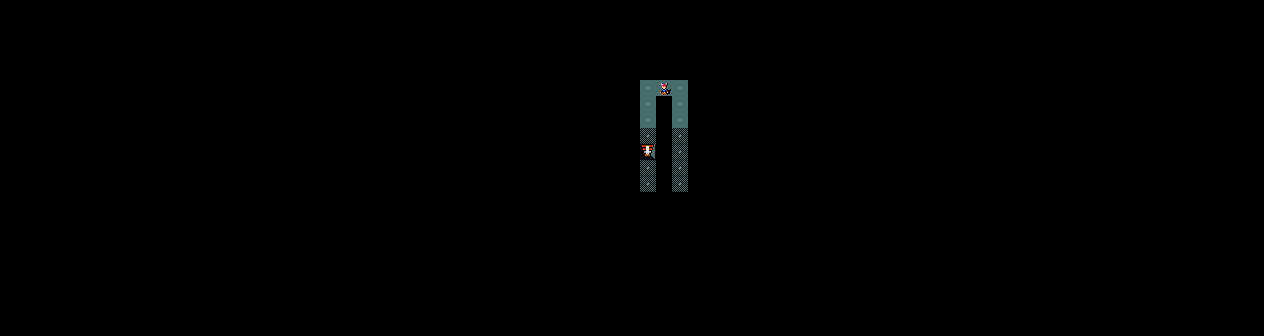

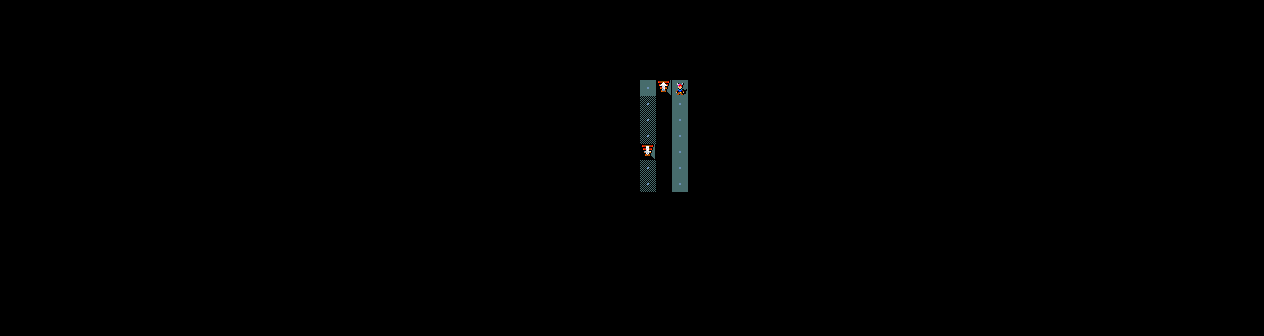

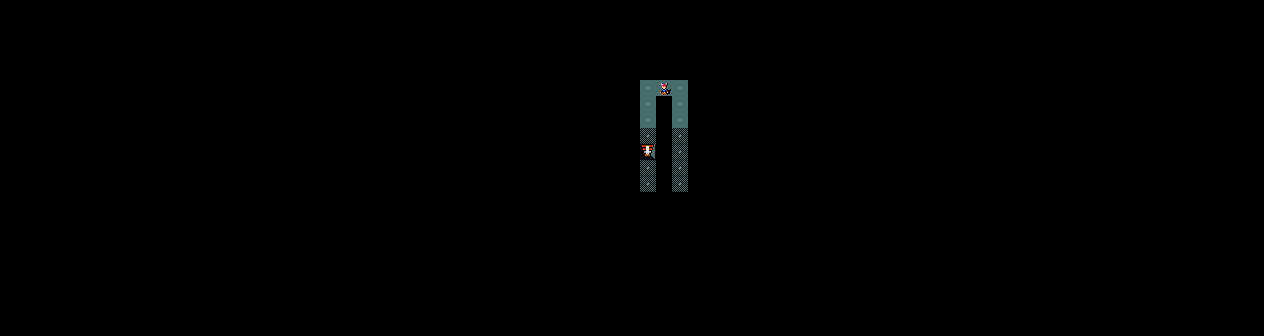

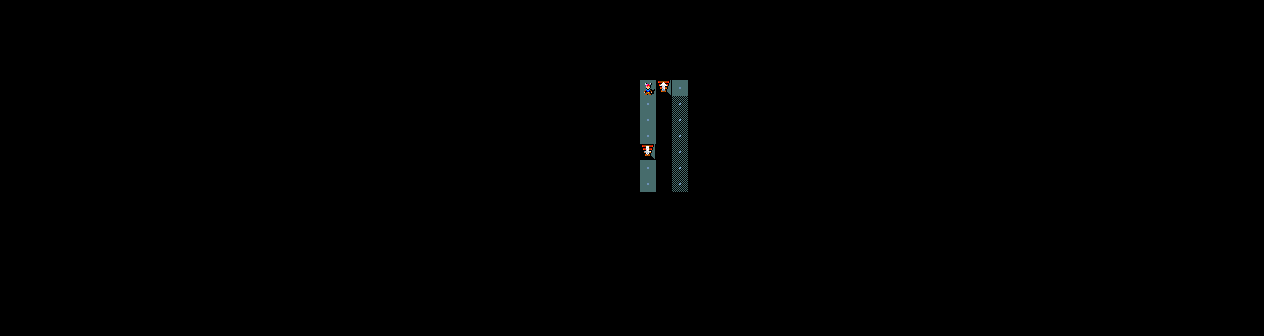

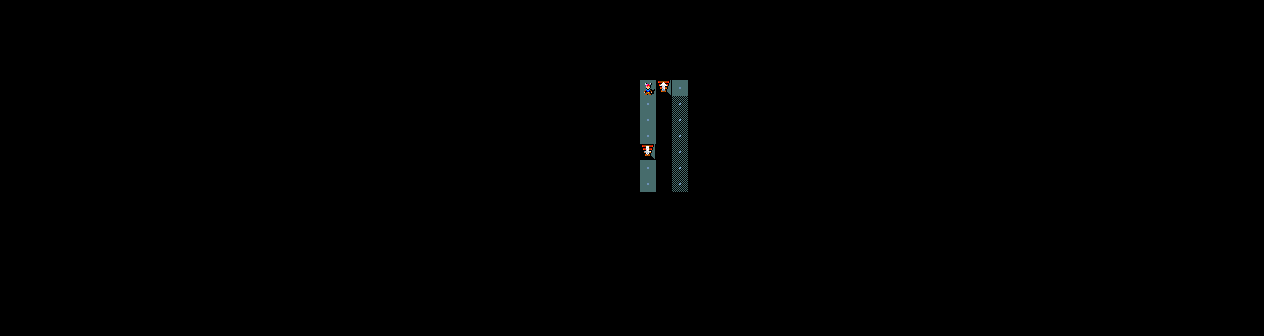

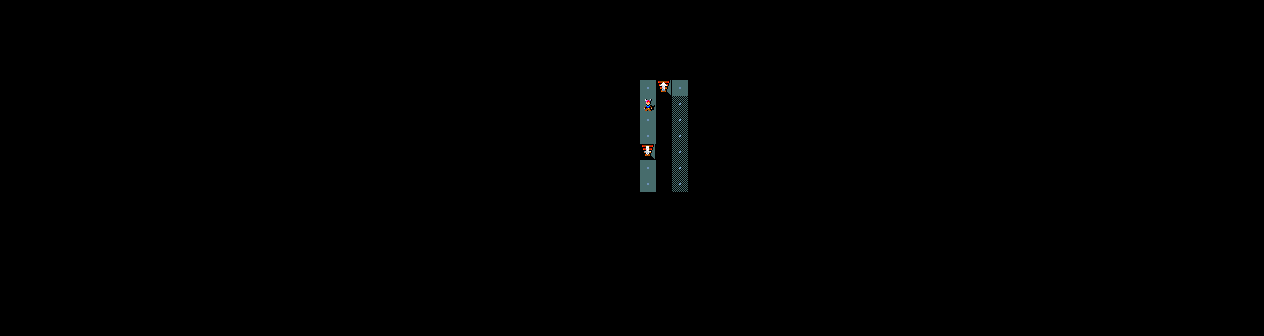

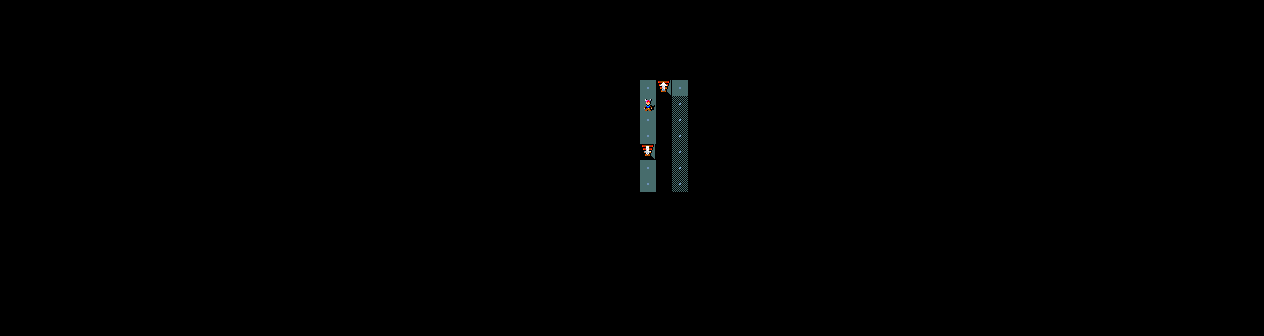

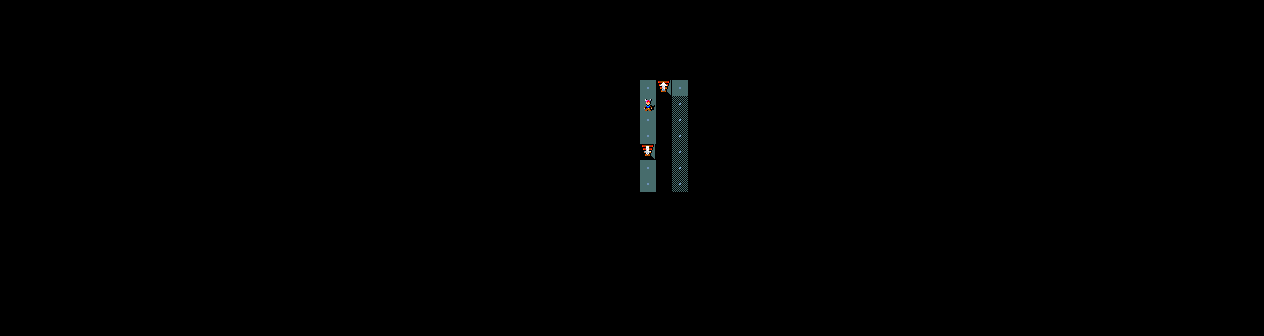

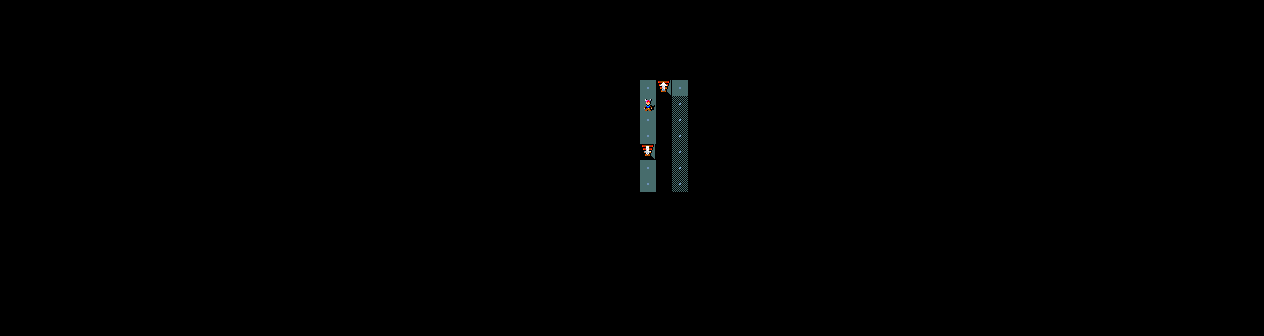

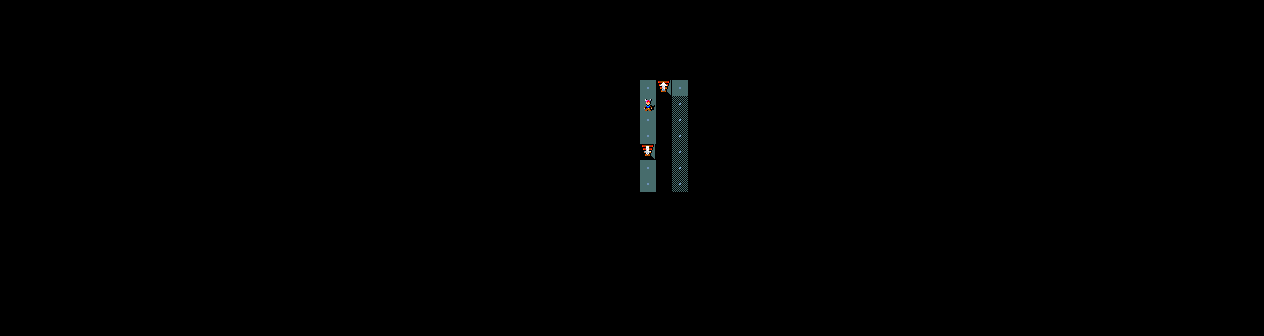

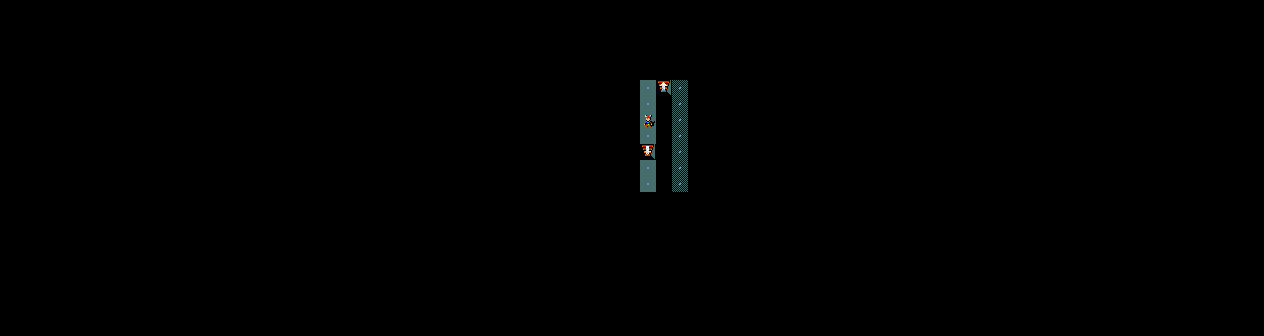

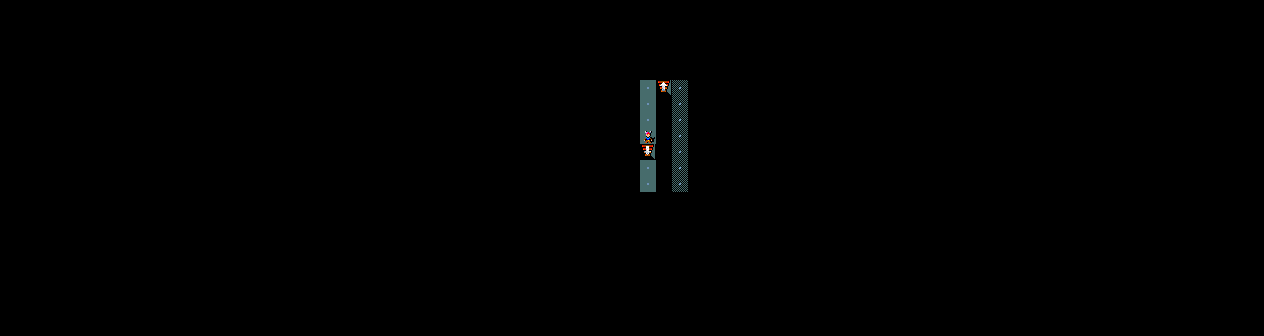

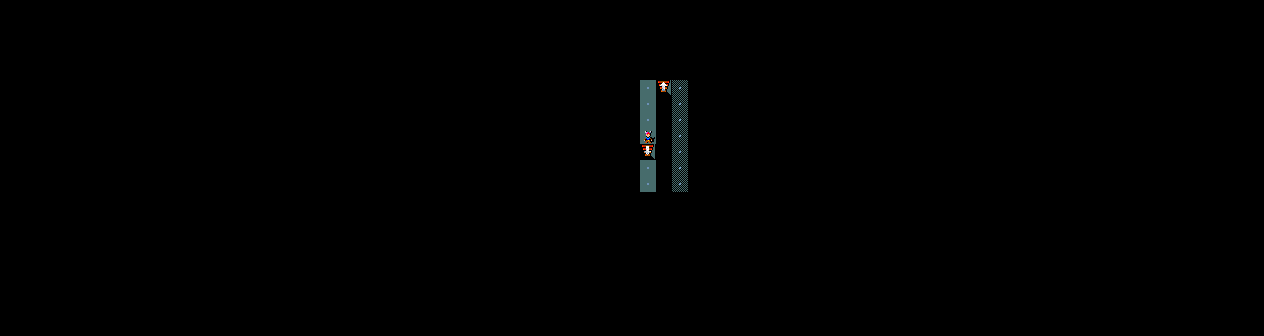

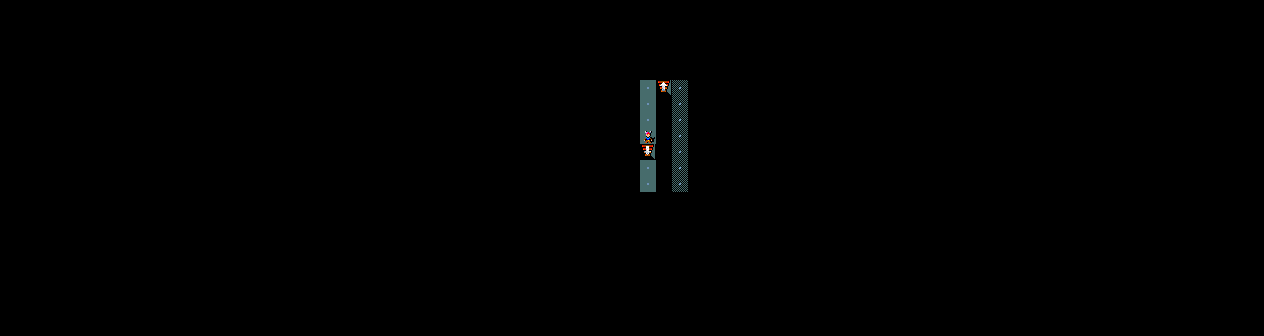

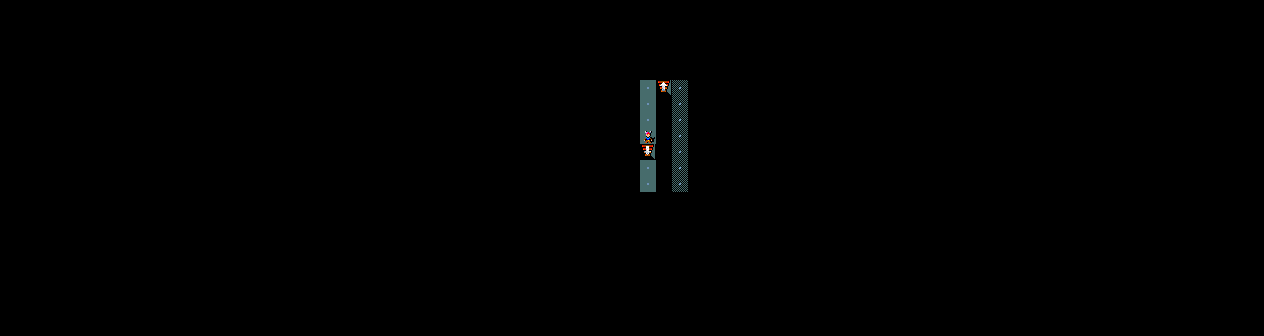

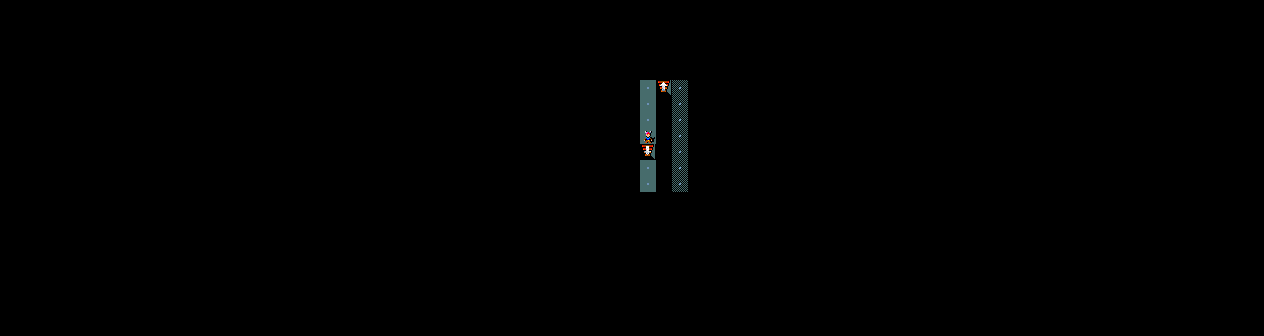

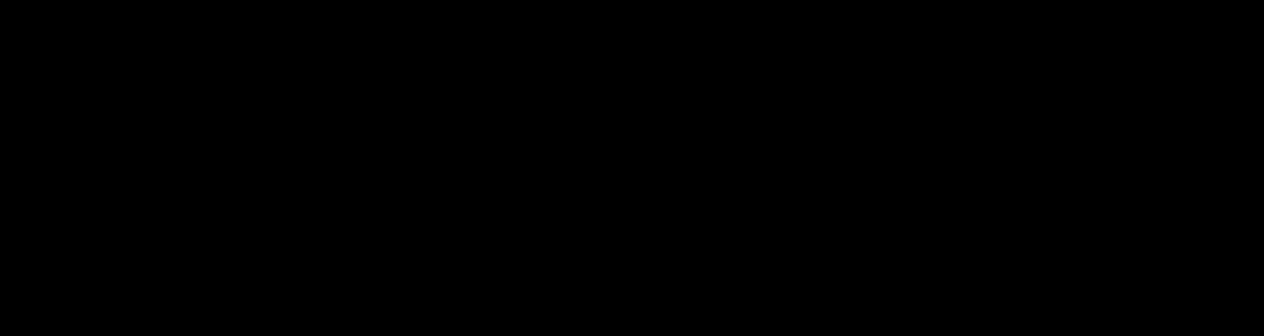

RuntimeError: Called step on finished NetHack

In [121]:
for i in range(10000):
    policy.forward(format_state(state))
    distribution = torch.distributions.Categorical(action_probs)
    action = distribution.sample()


    next_state, reward, done, _ = env.step(action.item())
    state = next_state
    display_screen(state)

In [ ]:
model = ActorCritic(h_size=512, a_size=env.action_space.n)
policy, scores = actor_critic(env=env, model= model, seed=42, learning_rate=0.02, betas=(0.9, 0.999),
                           number_episodes=1500, max_episode_length=10000, gamma=0.99 ,verbose=True, max_reward=1)